## In this notebook I aim to change the noise input of the generator to a low resolution galaxy image instead

By Shooby, started: July 25 <br>
last edited: Aug 26th

In [1]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from photutils import create_matching_kernel


from astropy.convolution import convolve_fft as convolve
import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

import warnings
warnings.filterwarnings('ignore')

In [2]:
# initializing parameters:

dataroot='gals/'
device = torch.device("cuda:0") # If GPU then use "cuda:0"
ngpu = 3 #number of GPUs to use 
ngf = 64
ndf = 64
workers = 8 #number of data loading workers
batchSize = 64 #input batch size
imageSize = 64 #the height / width of the input image to network
nz = 16 #size of the latent z vector
niter = 500 #number of epochs to train for
lr = 0.0002 #learning rate, default=0.0002
beta1 = 0.5 #beta1 for adam. default=0.5
outf='outputs' #folder to output images and model checkpoints
print(nz)

manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


16
Random Seed:  5729


In [3]:
dataset = dset.MNIST(root=dataroot, download=True,
                     transform=transforms.Compose([transforms.Resize(imageSize),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),]))
nc=1

assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=int(workers))


(41, 41)
(41, 41)
(41, 41)


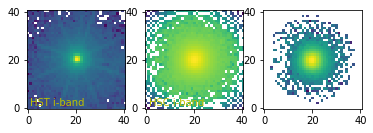

In [5]:
## The pixel scale of the kernel is now downsampled!

from skimage.transform import downscale_local_mean
psf = pyfits.getdata('psf_i.fits')
psf = downscale_local_mean(psf,(3,3))
psf = psf[7:-8,7:-8]#[22:-22,22:-22]
print(psf.shape)
plt.subplot(1,3,1)
plt.imshow(np.log(psf),origin='lower')
plt.text(1,1,'HST i-band',color='y')

from scipy.ndimage import zoom
psf_hsc = pyfits.getdata('psf-calexp-s16a_wide-HSC-I-15827-7,2-236.00000-42.00000.fits')
psf_hsc = psf_hsc[0:41,1:42]
#psf_hsc = zoom(psf_hsc, 3, order=1)
print(psf_hsc.shape)
plt.subplot(1,3,2)
plt.imshow(np.log(psf_hsc),origin='lower')
plt.text(1,1,'HSC i-band',color='y')

kern = create_matching_kernel(psf,psf_hsc)
plt.subplot(1,3,3)
print(kern.shape)
#kern = kern[35:-35,35:-35]
plt.imshow(np.log(kern),origin='lower')

psfh = np.repeat(kern[:,:, np.newaxis], 1, axis=2)
psfh = np.repeat(psfh[:,:,:,np.newaxis],1,axis = 3)
kernel = torch.Tensor(psfh)
kernel = kernel.permute(2,3,0,1)
kernel =  kernel.float()

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [7]:
class Shoobygen(nn.Module):

    def __init__(self,ngpu):
        super(Shoobygen, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d( 1, ngf * 8, 4, 1, 2, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 2, 2, 2, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
  
            nn.ConvTranspose2d(ngf*4, nc, 2, 2, 4, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
            output1 = output[:,:,:,:]

        else:
            output = self.main(input)
            output1 = output[:,:,:,:]

        return output1

netS = Shoobygen(ngpu).to(device)
netS.apply(weights_init)
print(netS)

Shoobygen(
  (main): Sequential(
    (0): ConvTranspose2d(1, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 1, kernel_size=(2, 2), stride=(2, 2), padding=(4, 4), bias=False)
    (7): Tanh()
  )
)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#if netD != '':
#    netD.load_state_dict(torch.load(netD))
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [9]:
criterion = nn.BCELoss()

real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerS = optim.Adam(netS.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with resampled, lower res, noise added images
        kernel = kernel.to(device)
        im = real_cpu+0.25*torch.rand_like(real_cpu)
        downsampled = F.upsample(im,scale_factor=1/3,mode='bilinear')
        img = F.conv2d(downsampled, kernel,padding=int(((kernel.shape[3])-1)/2))
        img = img[:,:,:,:]
        #print(img.shape)
        fake = netS(img)
        #print(fake.shape)
        label.fill_(fake_label)
        fd = fake.detach()
        output = netD(fd.float())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netS.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerS.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netS(img)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)
    # do checkpointing
    torch.save(netS.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/500][0/157] Loss_D: 2.2612 Loss_G: 11.5426 D(x): 0.3507 D(G(z)): 0.5607 / 0.0048
[0/500][1/157] Loss_D: 0.6259 Loss_G: 11.8315 D(x): 0.9985 D(G(z)): 0.3250 / 0.0000
[0/500][2/157] Loss_D: 0.1683 Loss_G: 11.1787 D(x): 0.9965 D(G(z)): 0.1449 / 0.0001
[0/500][3/157] Loss_D: 0.0687 Loss_G: 9.4572 D(x): 0.9949 D(G(z)): 0.0606 / 0.0002
[0/500][4/157] Loss_D: 0.2257 Loss_G: 8.9041 D(x): 0.9182 D(G(z)): 0.0948 / 0.0009
[0/500][5/157] Loss_D: 0.3636 Loss_G: 6.1151 D(x): 0.7965 D(G(z)): 0.0908 / 0.0041
[0/500][6/157] Loss_D: 1.7003 Loss_G: 16.9892 D(x): 0.9795 D(G(z)): 0.7772 / 0.0000
[0/500][7/157] Loss_D: 0.4669 Loss_G: 16.2853 D(x): 0.6977 D(G(z)): 0.0019 / 0.0009
[0/500][8/157] Loss_D: 0.0745 Loss_G: 11.9817 D(x): 0.9538 D(G(z)): 0.0006 / 0.0002
[0/500][9/157] Loss_D: 0.0252 Loss_G: 6.1099 D(x): 0.9939 D(G(z)): 0.0168 / 0.0063
[0/500][10/157] Loss_D: 0.3845 Loss_G: 13.7613 D(x): 0.9920 D(G(z)): 0.2968 / 0.0001
[0/500][11/157] Loss_D: 0.0486 Loss_G: 14.9069 D(x): 0.9740 D(G(z)): 0.0005 / 0

[0/500][101/157] Loss_D: 0.6769 Loss_G: 15.0400 D(x): 0.6211 D(G(z)): 0.0000 / 0.0000
[0/500][102/157] Loss_D: 0.6506 Loss_G: 7.6724 D(x): 0.6355 D(G(z)): 0.0002 / 0.0022
[0/500][103/157] Loss_D: 0.1376 Loss_G: 3.8108 D(x): 0.9722 D(G(z)): 0.0893 / 0.0551
[0/500][104/157] Loss_D: 1.1283 Loss_G: 10.6970 D(x): 0.9709 D(G(z)): 0.4721 / 0.0001
[0/500][105/157] Loss_D: 1.1399 Loss_G: 7.1222 D(x): 0.5963 D(G(z)): 0.0012 / 0.0024
[0/500][106/157] Loss_D: 0.3208 Loss_G: 5.7080 D(x): 0.9294 D(G(z)): 0.1543 / 0.0110
[0/500][107/157] Loss_D: 0.9571 Loss_G: 11.0868 D(x): 0.9671 D(G(z)): 0.4085 / 0.0000
[0/500][108/157] Loss_D: 2.4447 Loss_G: 3.4788 D(x): 0.2617 D(G(z)): 0.0003 / 0.0613
[0/500][109/157] Loss_D: 1.1183 Loss_G: 11.5362 D(x): 0.9947 D(G(z)): 0.5712 / 0.0002
[0/500][110/157] Loss_D: 0.3123 Loss_G: 10.9073 D(x): 0.8074 D(G(z)): 0.0028 / 0.0014
[0/500][111/157] Loss_D: 0.2008 Loss_G: 8.1620 D(x): 0.8733 D(G(z)): 0.0023 / 0.0042
[0/500][112/157] Loss_D: 0.1714 Loss_G: 4.9110 D(x): 0.9197 

[1/500][43/157] Loss_D: 0.2011 Loss_G: 6.8345 D(x): 0.9355 D(G(z)): 0.0915 / 0.0064
[1/500][44/157] Loss_D: 0.0611 Loss_G: 6.5874 D(x): 0.9671 D(G(z)): 0.0219 / 0.0075
[1/500][45/157] Loss_D: 0.0328 Loss_G: 6.1349 D(x): 0.9782 D(G(z)): 0.0094 / 0.0050
[1/500][46/157] Loss_D: 0.0826 Loss_G: 5.2724 D(x): 0.9506 D(G(z)): 0.0128 / 0.0089
[1/500][47/157] Loss_D: 0.1881 Loss_G: 8.9879 D(x): 0.9863 D(G(z)): 0.1496 / 0.0003
[1/500][48/157] Loss_D: 0.0752 Loss_G: 7.7576 D(x): 0.9373 D(G(z)): 0.0056 / 0.0008
[1/500][49/157] Loss_D: 0.0977 Loss_G: 5.4130 D(x): 0.9443 D(G(z)): 0.0275 / 0.0093
[1/500][50/157] Loss_D: 0.3402 Loss_G: 9.5082 D(x): 0.9147 D(G(z)): 0.1809 / 0.0011
[1/500][51/157] Loss_D: 0.2462 Loss_G: 8.3939 D(x): 0.8462 D(G(z)): 0.0032 / 0.0021
[1/500][52/157] Loss_D: 0.0482 Loss_G: 6.7801 D(x): 0.9700 D(G(z)): 0.0065 / 0.0050
[1/500][53/157] Loss_D: 0.0211 Loss_G: 6.4960 D(x): 0.9859 D(G(z)): 0.0062 / 0.0050
[1/500][54/157] Loss_D: 0.2913 Loss_G: 12.0878 D(x): 0.9864 D(G(z)): 0.1966 

[1/500][142/157] Loss_D: 0.0493 Loss_G: 5.8604 D(x): 0.9683 D(G(z)): 0.0140 / 0.0054
[1/500][143/157] Loss_D: 0.2217 Loss_G: 8.5628 D(x): 0.9733 D(G(z)): 0.1475 / 0.0005
[1/500][144/157] Loss_D: 0.1266 Loss_G: 7.2965 D(x): 0.8946 D(G(z)): 0.0030 / 0.0025
[1/500][145/157] Loss_D: 0.0662 Loss_G: 5.6921 D(x): 0.9498 D(G(z)): 0.0102 / 0.0107
[1/500][146/157] Loss_D: 0.0494 Loss_G: 6.2250 D(x): 0.9848 D(G(z)): 0.0311 / 0.0037
[1/500][147/157] Loss_D: 0.0920 Loss_G: 7.7429 D(x): 0.9862 D(G(z)): 0.0706 / 0.0019
[1/500][148/157] Loss_D: 0.0863 Loss_G: 8.0831 D(x): 0.9625 D(G(z)): 0.0348 / 0.0020
[1/500][149/157] Loss_D: 0.1122 Loss_G: 7.9124 D(x): 0.9552 D(G(z)): 0.0564 / 0.0011
[1/500][150/157] Loss_D: 0.1086 Loss_G: 6.1908 D(x): 0.9191 D(G(z)): 0.0161 / 0.0039
[1/500][151/157] Loss_D: 0.1996 Loss_G: 9.9537 D(x): 0.9667 D(G(z)): 0.1137 / 0.0002
[1/500][152/157] Loss_D: 0.1053 Loss_G: 8.3305 D(x): 0.9126 D(G(z)): 0.0018 / 0.0006
[1/500][153/157] Loss_D: 0.0259 Loss_G: 5.9905 D(x): 0.9822 D(G(z

[2/500][86/157] Loss_D: 0.1019 Loss_G: 7.1817 D(x): 0.9204 D(G(z)): 0.0089 / 0.0104
[2/500][87/157] Loss_D: 0.1063 Loss_G: 5.7521 D(x): 0.9589 D(G(z)): 0.0437 / 0.0092
[2/500][88/157] Loss_D: 0.0462 Loss_G: 5.8605 D(x): 0.9859 D(G(z)): 0.0296 / 0.0054
[2/500][89/157] Loss_D: 0.0142 Loss_G: 6.3539 D(x): 0.9933 D(G(z)): 0.0073 / 0.0031
[2/500][90/157] Loss_D: 0.0187 Loss_G: 7.2391 D(x): 0.9855 D(G(z)): 0.0034 / 0.0028
[2/500][91/157] Loss_D: 0.0119 Loss_G: 6.5742 D(x): 0.9926 D(G(z)): 0.0043 / 0.0030
[2/500][92/157] Loss_D: 0.1071 Loss_G: 7.4418 D(x): 0.9926 D(G(z)): 0.0914 / 0.0011
[2/500][93/157] Loss_D: 0.0174 Loss_G: 8.0728 D(x): 0.9863 D(G(z)): 0.0030 / 0.0007
[2/500][94/157] Loss_D: 0.0712 Loss_G: 7.5376 D(x): 0.9469 D(G(z)): 0.0050 / 0.0040
[2/500][95/157] Loss_D: 0.0450 Loss_G: 6.6015 D(x): 0.9607 D(G(z)): 0.0030 / 0.0033
[2/500][96/157] Loss_D: 0.0632 Loss_G: 5.7132 D(x): 0.9857 D(G(z)): 0.0448 / 0.0069
[2/500][97/157] Loss_D: 0.0497 Loss_G: 5.8921 D(x): 0.9713 D(G(z)): 0.0155 /

[3/500][26/157] Loss_D: 0.1027 Loss_G: 9.9734 D(x): 0.9966 D(G(z)): 0.0860 / 0.0001
[3/500][27/157] Loss_D: 0.0320 Loss_G: 11.7414 D(x): 0.9769 D(G(z)): 0.0002 / 0.0000
[3/500][28/157] Loss_D: 0.0172 Loss_G: 8.7234 D(x): 0.9860 D(G(z)): 0.0026 / 0.0014
[3/500][29/157] Loss_D: 0.0346 Loss_G: 11.2526 D(x): 0.9683 D(G(z)): 0.0000 / 0.0000
[3/500][30/157] Loss_D: 0.0363 Loss_G: 6.3333 D(x): 0.9929 D(G(z)): 0.0271 / 0.0051
[3/500][31/157] Loss_D: 0.0499 Loss_G: 7.0061 D(x): 0.9891 D(G(z)): 0.0346 / 0.0024
[3/500][32/157] Loss_D: 0.0241 Loss_G: 6.9722 D(x): 0.9970 D(G(z)): 0.0206 / 0.0017
[3/500][33/157] Loss_D: 0.0164 Loss_G: 7.6306 D(x): 0.9863 D(G(z)): 0.0024 / 0.0009
[3/500][34/157] Loss_D: 0.0151 Loss_G: 12.9001 D(x): 0.9853 D(G(z)): 0.0000 / 0.0000
[3/500][35/157] Loss_D: 0.0118 Loss_G: 9.3406 D(x): 0.9890 D(G(z)): 0.0004 / 0.0004
[3/500][36/157] Loss_D: 0.0316 Loss_G: 7.8229 D(x): 0.9954 D(G(z)): 0.0253 / 0.0016
[3/500][37/157] Loss_D: 0.0225 Loss_G: 8.0322 D(x): 0.9885 D(G(z)): 0.010

[3/500][125/157] Loss_D: 0.0238 Loss_G: 10.2250 D(x): 0.9774 D(G(z)): 0.0006 / 0.0004
[3/500][126/157] Loss_D: 0.0562 Loss_G: 5.6740 D(x): 0.9647 D(G(z)): 0.0165 / 0.0090
[3/500][127/157] Loss_D: 0.0628 Loss_G: 7.0116 D(x): 0.9741 D(G(z)): 0.0021 / 0.0022
[3/500][128/157] Loss_D: 0.0336 Loss_G: 10.1916 D(x): 0.9748 D(G(z)): 0.0016 / 0.0021
[3/500][129/157] Loss_D: 0.2274 Loss_G: 10.6806 D(x): 0.9929 D(G(z)): 0.1447 / 0.0001
[3/500][130/157] Loss_D: 0.0186 Loss_G: 13.4172 D(x): 0.9822 D(G(z)): 0.0000 / 0.0000
[3/500][131/157] Loss_D: 0.0482 Loss_G: 9.0762 D(x): 0.9585 D(G(z)): 0.0027 / 0.0025
[3/500][132/157] Loss_D: 0.0365 Loss_G: 10.1990 D(x): 0.9668 D(G(z)): 0.0003 / 0.0004
[3/500][133/157] Loss_D: 0.0363 Loss_G: 8.1008 D(x): 0.9704 D(G(z)): 0.0016 / 0.0023
[3/500][134/157] Loss_D: 0.0248 Loss_G: 6.3285 D(x): 0.9962 D(G(z)): 0.0200 / 0.0077
[3/500][135/157] Loss_D: 0.0466 Loss_G: 7.1854 D(x): 0.9935 D(G(z)): 0.0368 / 0.0025
[3/500][136/157] Loss_D: 0.0094 Loss_G: 7.3899 D(x): 0.9950 

[4/500][66/157] Loss_D: 0.0029 Loss_G: 8.9809 D(x): 0.9975 D(G(z)): 0.0004 / 0.0003
[4/500][67/157] Loss_D: 0.0089 Loss_G: 6.5741 D(x): 0.9969 D(G(z)): 0.0057 / 0.0037
[4/500][68/157] Loss_D: 0.0842 Loss_G: 8.7284 D(x): 0.9965 D(G(z)): 0.0720 / 0.0003
[4/500][69/157] Loss_D: 0.0305 Loss_G: 8.8090 D(x): 0.9800 D(G(z)): 0.0084 / 0.0006
[4/500][70/157] Loss_D: 0.0154 Loss_G: 8.1812 D(x): 0.9865 D(G(z)): 0.0015 / 0.0006
[4/500][71/157] Loss_D: 0.0112 Loss_G: 10.2422 D(x): 0.9892 D(G(z)): 0.0001 / 0.0001
[4/500][72/157] Loss_D: 0.0109 Loss_G: 9.9432 D(x): 0.9896 D(G(z)): 0.0002 / 0.0002
[4/500][73/157] Loss_D: 0.0174 Loss_G: 6.6853 D(x): 0.9931 D(G(z)): 0.0102 / 0.0045
[4/500][74/157] Loss_D: 0.0084 Loss_G: 7.8804 D(x): 0.9934 D(G(z)): 0.0018 / 0.0013
[4/500][75/157] Loss_D: 0.0073 Loss_G: 7.1596 D(x): 0.9959 D(G(z)): 0.0031 / 0.0023
[4/500][76/157] Loss_D: 0.0033 Loss_G: 7.3020 D(x): 0.9988 D(G(z)): 0.0020 / 0.0016
[4/500][77/157] Loss_D: 0.0347 Loss_G: 7.3209 D(x): 0.9962 D(G(z)): 0.0294 

[5/500][6/157] Loss_D: 0.0551 Loss_G: 7.6881 D(x): 0.9821 D(G(z)): 0.0316 / 0.0009
[5/500][7/157] Loss_D: 0.0602 Loss_G: 7.2786 D(x): 0.9764 D(G(z)): 0.0317 / 0.0021
[5/500][8/157] Loss_D: 0.0964 Loss_G: 8.3275 D(x): 0.9779 D(G(z)): 0.0631 / 0.0005
[5/500][9/157] Loss_D: 0.0661 Loss_G: 6.9442 D(x): 0.9509 D(G(z)): 0.0079 / 0.0015
[5/500][10/157] Loss_D: 0.0484 Loss_G: 6.9526 D(x): 0.9895 D(G(z)): 0.0361 / 0.0022
[5/500][11/157] Loss_D: 0.0536 Loss_G: 6.8923 D(x): 0.9576 D(G(z)): 0.0068 / 0.0027
[5/500][12/157] Loss_D: 0.1860 Loss_G: 11.5507 D(x): 0.9896 D(G(z)): 0.1347 / 0.0001
[5/500][13/157] Loss_D: 0.0798 Loss_G: 10.6347 D(x): 0.9292 D(G(z)): 0.0007 / 0.0002
[5/500][14/157] Loss_D: 0.0465 Loss_G: 8.3976 D(x): 0.9570 D(G(z)): 0.0009 / 0.0010
[5/500][15/157] Loss_D: 0.0271 Loss_G: 6.4957 D(x): 0.9915 D(G(z)): 0.0171 / 0.0051
[5/500][16/157] Loss_D: 0.0211 Loss_G: 7.4551 D(x): 0.9815 D(G(z)): 0.0013 / 0.0015
[5/500][17/157] Loss_D: 0.0058 Loss_G: 9.2287 D(x): 0.9945 D(G(z)): 0.0002 / 0

[5/500][105/157] Loss_D: 0.0279 Loss_G: 13.0924 D(x): 0.9733 D(G(z)): 0.0001 / 0.0001
[5/500][106/157] Loss_D: 0.0080 Loss_G: 16.3312 D(x): 0.9921 D(G(z)): 0.0000 / 0.0001
[5/500][107/157] Loss_D: 0.0043 Loss_G: 13.3824 D(x): 0.9965 D(G(z)): 0.0008 / 0.0012
[5/500][108/157] Loss_D: 0.0023 Loss_G: 13.0155 D(x): 0.9979 D(G(z)): 0.0002 / 0.0002
[5/500][109/157] Loss_D: 0.0048 Loss_G: 10.8904 D(x): 0.9990 D(G(z)): 0.0035 / 0.0017
[5/500][110/157] Loss_D: 0.0133 Loss_G: 7.0585 D(x): 0.9971 D(G(z)): 0.0098 / 0.0049
[5/500][111/157] Loss_D: 0.0508 Loss_G: 7.5951 D(x): 0.9988 D(G(z)): 0.0408 / 0.0036
[5/500][112/157] Loss_D: 0.0152 Loss_G: 8.0707 D(x): 0.9961 D(G(z)): 0.0104 / 0.0014
[5/500][113/157] Loss_D: 0.0033 Loss_G: 12.8213 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[5/500][114/157] Loss_D: 0.0155 Loss_G: 15.3346 D(x): 0.9856 D(G(z)): 0.0000 / 0.0000
[5/500][115/157] Loss_D: 0.0078 Loss_G: 10.8393 D(x): 0.9923 D(G(z)): 0.0000 / 0.0001
[5/500][116/157] Loss_D: 0.0141 Loss_G: 14.7131 D(x): 0.9

[6/500][45/157] Loss_D: 0.0040 Loss_G: 7.1911 D(x): 0.9978 D(G(z)): 0.0018 / 0.0019
[6/500][46/157] Loss_D: 0.0061 Loss_G: 6.5747 D(x): 0.9982 D(G(z)): 0.0043 / 0.0032
[6/500][47/157] Loss_D: 0.0099 Loss_G: 6.5359 D(x): 0.9954 D(G(z)): 0.0052 / 0.0034
[6/500][48/157] Loss_D: 0.0032 Loss_G: 10.7272 D(x): 0.9969 D(G(z)): 0.0000 / 0.0000
[6/500][49/157] Loss_D: 0.0167 Loss_G: 5.7437 D(x): 0.9978 D(G(z)): 0.0143 / 0.0059
[6/500][50/157] Loss_D: 0.0025 Loss_G: 11.4430 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[6/500][51/157] Loss_D: 0.0056 Loss_G: 8.0508 D(x): 0.9952 D(G(z)): 0.0007 / 0.0007
[6/500][52/157] Loss_D: 0.0019 Loss_G: 10.6535 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[6/500][53/157] Loss_D: 0.0194 Loss_G: 5.8327 D(x): 0.9974 D(G(z)): 0.0164 / 0.0049
[6/500][54/157] Loss_D: 0.0034 Loss_G: 8.2661 D(x): 0.9975 D(G(z)): 0.0009 / 0.0006
[6/500][55/157] Loss_D: 0.0319 Loss_G: 6.3785 D(x): 0.9971 D(G(z)): 0.0276 / 0.0029
[6/500][56/157] Loss_D: 0.0070 Loss_G: 11.2679 D(x): 0.9931 D(G(z)): 0.00

[6/500][142/157] Loss_D: 0.0027 Loss_G: 7.2929 D(x): 0.9988 D(G(z)): 0.0015 / 0.0013
[6/500][143/157] Loss_D: 0.0027 Loss_G: 7.6787 D(x): 0.9984 D(G(z)): 0.0011 / 0.0010
[6/500][144/157] Loss_D: 0.0039 Loss_G: 8.2527 D(x): 0.9973 D(G(z)): 0.0012 / 0.0010
[6/500][145/157] Loss_D: 0.0017 Loss_G: 8.4572 D(x): 0.9988 D(G(z)): 0.0005 / 0.0005
[6/500][146/157] Loss_D: 0.0545 Loss_G: 9.5066 D(x): 0.9991 D(G(z)): 0.0506 / 0.0001
[6/500][147/157] Loss_D: 0.0094 Loss_G: 14.6361 D(x): 0.9907 D(G(z)): 0.0000 / 0.0000
[6/500][148/157] Loss_D: 0.0687 Loss_G: 9.8923 D(x): 0.9393 D(G(z)): 0.0000 / 0.0001
[6/500][149/157] Loss_D: 0.0045 Loss_G: 11.8742 D(x): 0.9956 D(G(z)): 0.0000 / 0.0000
[6/500][150/157] Loss_D: 0.0050 Loss_G: 6.5934 D(x): 0.9990 D(G(z)): 0.0040 / 0.0047
[6/500][151/157] Loss_D: 0.0009 Loss_G: 8.9494 D(x): 0.9993 D(G(z)): 0.0002 / 0.0003
[6/500][152/157] Loss_D: 0.0013 Loss_G: 8.6952 D(x): 0.9991 D(G(z)): 0.0003 / 0.0004
[6/500][153/157] Loss_D: 0.0424 Loss_G: 8.1576 D(x): 0.9989 D(G

[7/500][85/157] Loss_D: 0.0012 Loss_G: 10.1569 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[7/500][86/157] Loss_D: 0.0047 Loss_G: 7.4925 D(x): 0.9969 D(G(z)): 0.0015 / 0.0014
[7/500][87/157] Loss_D: 0.0052 Loss_G: 7.0591 D(x): 0.9982 D(G(z)): 0.0033 / 0.0023
[7/500][88/157] Loss_D: 0.0011 Loss_G: 8.8026 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[7/500][89/157] Loss_D: 0.0045 Loss_G: 9.8693 D(x): 0.9958 D(G(z)): 0.0002 / 0.0002
[7/500][90/157] Loss_D: 0.0064 Loss_G: 6.8755 D(x): 0.9994 D(G(z)): 0.0058 / 0.0024
[7/500][91/157] Loss_D: 0.0033 Loss_G: 10.9225 D(x): 0.9968 D(G(z)): 0.0001 / 0.0000
[7/500][92/157] Loss_D: 0.0020 Loss_G: 7.8652 D(x): 0.9989 D(G(z)): 0.0010 / 0.0008
[7/500][93/157] Loss_D: 0.0038 Loss_G: 6.9774 D(x): 0.9990 D(G(z)): 0.0028 / 0.0020
[7/500][94/157] Loss_D: 0.0098 Loss_G: 6.3419 D(x): 0.9992 D(G(z)): 0.0089 / 0.0038
[7/500][95/157] Loss_D: 0.0081 Loss_G: 6.9598 D(x): 0.9992 D(G(z)): 0.0071 / 0.0025
[7/500][96/157] Loss_D: 0.0024 Loss_G: 10.3242 D(x): 0.9978 D(G(z)): 0.000

[8/500][25/157] Loss_D: 0.0027 Loss_G: 7.6894 D(x): 0.9981 D(G(z)): 0.0009 / 0.0009
[8/500][26/157] Loss_D: 0.0023 Loss_G: 7.6210 D(x): 0.9989 D(G(z)): 0.0012 / 0.0011
[8/500][27/157] Loss_D: 0.0012 Loss_G: 10.3659 D(x): 0.9989 D(G(z)): 0.0000 / 0.0001
[8/500][28/157] Loss_D: 0.0438 Loss_G: 9.5663 D(x): 0.9981 D(G(z)): 0.0400 / 0.0001
[8/500][29/157] Loss_D: 0.0321 Loss_G: 9.8685 D(x): 0.9702 D(G(z)): 0.0001 / 0.0002
[8/500][30/157] Loss_D: 0.0131 Loss_G: 7.7965 D(x): 0.9876 D(G(z)): 0.0004 / 0.0012
[8/500][31/157] Loss_D: 0.0020 Loss_G: 11.6832 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[8/500][32/157] Loss_D: 0.0161 Loss_G: 6.5383 D(x): 0.9980 D(G(z)): 0.0137 / 0.0031
[8/500][33/157] Loss_D: 0.0042 Loss_G: 11.4114 D(x): 0.9959 D(G(z)): 0.0000 / 0.0000
[8/500][34/157] Loss_D: 0.0154 Loss_G: 6.4124 D(x): 0.9880 D(G(z)): 0.0028 / 0.0033
[8/500][35/157] Loss_D: 0.0053 Loss_G: 10.6549 D(x): 0.9949 D(G(z)): 0.0001 / 0.0002
[8/500][36/157] Loss_D: 0.0019 Loss_G: 9.8143 D(x): 0.9982 D(G(z)): 0.00

[8/500][125/157] Loss_D: 0.0809 Loss_G: 9.5163 D(x): 0.9984 D(G(z)): 0.0655 / 0.0001
[8/500][126/157] Loss_D: 0.0370 Loss_G: 8.6768 D(x): 0.9964 D(G(z)): 0.0317 / 0.0003
[8/500][127/157] Loss_D: 0.0708 Loss_G: 8.6839 D(x): 0.9760 D(G(z)): 0.0312 / 0.0005
[8/500][128/157] Loss_D: 0.0928 Loss_G: 7.8309 D(x): 0.9582 D(G(z)): 0.0282 / 0.0014
[8/500][129/157] Loss_D: 0.0524 Loss_G: 8.0185 D(x): 0.9902 D(G(z)): 0.0371 / 0.0013
[8/500][130/157] Loss_D: 0.0864 Loss_G: 6.9850 D(x): 0.9535 D(G(z)): 0.0149 / 0.0018
[8/500][131/157] Loss_D: 0.1089 Loss_G: 8.3101 D(x): 0.9803 D(G(z)): 0.0771 / 0.0006
[8/500][132/157] Loss_D: 0.0692 Loss_G: 8.0152 D(x): 0.9670 D(G(z)): 0.0057 / 0.0010
[8/500][133/157] Loss_D: 0.0363 Loss_G: 6.9503 D(x): 0.9963 D(G(z)): 0.0313 / 0.0021
[8/500][134/157] Loss_D: 0.0408 Loss_G: 7.3595 D(x): 0.9960 D(G(z)): 0.0342 / 0.0014
[8/500][135/157] Loss_D: 0.0707 Loss_G: 7.0572 D(x): 0.9748 D(G(z)): 0.0215 / 0.0016
[8/500][136/157] Loss_D: 0.0186 Loss_G: 6.6372 D(x): 0.9919 D(G(z

[9/500][69/157] Loss_D: 0.0283 Loss_G: 6.7668 D(x): 0.9807 D(G(z)): 0.0069 / 0.0024
[9/500][70/157] Loss_D: 0.0169 Loss_G: 6.8834 D(x): 0.9950 D(G(z)): 0.0115 / 0.0031
[9/500][71/157] Loss_D: 0.0111 Loss_G: 6.9385 D(x): 0.9978 D(G(z)): 0.0088 / 0.0024
[9/500][72/157] Loss_D: 0.0162 Loss_G: 7.0722 D(x): 0.9955 D(G(z)): 0.0115 / 0.0020
[9/500][73/157] Loss_D: 0.0128 Loss_G: 6.9209 D(x): 0.9928 D(G(z)): 0.0051 / 0.0019
[9/500][74/157] Loss_D: 0.0226 Loss_G: 6.5896 D(x): 0.9928 D(G(z)): 0.0147 / 0.0036
[9/500][75/157] Loss_D: 0.0247 Loss_G: 6.9683 D(x): 0.9950 D(G(z)): 0.0189 / 0.0021
[9/500][76/157] Loss_D: 0.0094 Loss_G: 7.0729 D(x): 0.9982 D(G(z)): 0.0075 / 0.0013
[9/500][77/157] Loss_D: 0.0158 Loss_G: 7.2421 D(x): 0.9906 D(G(z)): 0.0054 / 0.0016
[9/500][78/157] Loss_D: 0.0139 Loss_G: 6.9936 D(x): 0.9919 D(G(z)): 0.0056 / 0.0023
[9/500][79/157] Loss_D: 0.0566 Loss_G: 9.1165 D(x): 0.9971 D(G(z)): 0.0496 / 0.0003
[9/500][80/157] Loss_D: 0.0232 Loss_G: 9.3948 D(x): 0.9791 D(G(z)): 0.0016 /

[10/500][11/157] Loss_D: 0.0105 Loss_G: 7.9165 D(x): 0.9912 D(G(z)): 0.0012 / 0.0011
[10/500][12/157] Loss_D: 0.0058 Loss_G: 10.9204 D(x): 0.9945 D(G(z)): 0.0001 / 0.0001
[10/500][13/157] Loss_D: 0.0270 Loss_G: 7.8554 D(x): 0.9997 D(G(z)): 0.0253 / 0.0008
[10/500][14/157] Loss_D: 0.0028 Loss_G: 9.5265 D(x): 0.9982 D(G(z)): 0.0009 / 0.0003
[10/500][15/157] Loss_D: 0.0112 Loss_G: 8.9681 D(x): 0.9900 D(G(z)): 0.0008 / 0.0004
[10/500][16/157] Loss_D: 0.0036 Loss_G: 7.9514 D(x): 0.9984 D(G(z)): 0.0021 / 0.0013
[10/500][17/157] Loss_D: 0.0035 Loss_G: 8.5994 D(x): 0.9970 D(G(z)): 0.0005 / 0.0004
[10/500][18/157] Loss_D: 0.0017 Loss_G: 9.2279 D(x): 0.9986 D(G(z)): 0.0003 / 0.0003
[10/500][19/157] Loss_D: 0.0574 Loss_G: 8.8866 D(x): 0.9969 D(G(z)): 0.0445 / 0.0004
[10/500][20/157] Loss_D: 0.0187 Loss_G: 10.6178 D(x): 0.9831 D(G(z)): 0.0003 / 0.0001
[10/500][21/157] Loss_D: 0.0044 Loss_G: 11.6681 D(x): 0.9956 D(G(z)): 0.0000 / 0.0000
[10/500][22/157] Loss_D: 0.0049 Loss_G: 8.3086 D(x): 0.9960 D(

[10/500][110/157] Loss_D: 0.0044 Loss_G: 8.4650 D(x): 0.9965 D(G(z)): 0.0008 / 0.0005
[10/500][111/157] Loss_D: 0.0061 Loss_G: 11.9839 D(x): 0.9940 D(G(z)): 0.0000 / 0.0000
[10/500][112/157] Loss_D: 0.0056 Loss_G: 8.0139 D(x): 0.9951 D(G(z)): 0.0007 / 0.0007
[10/500][113/157] Loss_D: 0.0042 Loss_G: 11.0677 D(x): 0.9959 D(G(z)): 0.0000 / 0.0000
[10/500][114/157] Loss_D: 0.0045 Loss_G: 6.7565 D(x): 0.9978 D(G(z)): 0.0024 / 0.0023
[10/500][115/157] Loss_D: 0.0055 Loss_G: 10.7602 D(x): 0.9947 D(G(z)): 0.0000 / 0.0000
[10/500][116/157] Loss_D: 0.0034 Loss_G: 7.4478 D(x): 0.9976 D(G(z)): 0.0010 / 0.0011
[10/500][117/157] Loss_D: 0.0029 Loss_G: 7.5900 D(x): 0.9983 D(G(z)): 0.0012 / 0.0011
[10/500][118/157] Loss_D: 0.0030 Loss_G: 7.2781 D(x): 0.9982 D(G(z)): 0.0012 / 0.0012
[10/500][119/157] Loss_D: 0.0106 Loss_G: 6.6849 D(x): 0.9991 D(G(z)): 0.0093 / 0.0030
[10/500][120/157] Loss_D: 0.0036 Loss_G: 7.3172 D(x): 0.9987 D(G(z)): 0.0022 / 0.0016
[10/500][121/157] Loss_D: 0.0083 Loss_G: 7.0951 D(x

[11/500][50/157] Loss_D: 0.0045 Loss_G: 6.6999 D(x): 0.9985 D(G(z)): 0.0031 / 0.0026
[11/500][51/157] Loss_D: 0.0028 Loss_G: 11.4177 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[11/500][52/157] Loss_D: 0.0028 Loss_G: 7.3573 D(x): 0.9987 D(G(z)): 0.0015 / 0.0014
[11/500][53/157] Loss_D: 0.0011 Loss_G: 11.1239 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[11/500][54/157] Loss_D: 0.0038 Loss_G: 7.0614 D(x): 0.9990 D(G(z)): 0.0028 / 0.0022
[11/500][55/157] Loss_D: 0.0011 Loss_G: 11.2095 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[11/500][56/157] Loss_D: 0.0020 Loss_G: 8.8435 D(x): 0.9983 D(G(z)): 0.0003 / 0.0003
[11/500][57/157] Loss_D: 0.0029 Loss_G: 8.7780 D(x): 0.9975 D(G(z)): 0.0004 / 0.0004
[11/500][58/157] Loss_D: 0.0039 Loss_G: 6.9996 D(x): 0.9993 D(G(z)): 0.0032 / 0.0024
[11/500][59/157] Loss_D: 0.0010 Loss_G: 10.1733 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[11/500][60/157] Loss_D: 0.0321 Loss_G: 6.9337 D(x): 0.9994 D(G(z)): 0.0302 / 0.0019
[11/500][61/157] Loss_D: 0.0045 Loss_G: 10.9179 D(x): 0.9957 

[11/500][149/157] Loss_D: 0.0019 Loss_G: 12.8752 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[11/500][150/157] Loss_D: 0.0011 Loss_G: 10.3039 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[11/500][151/157] Loss_D: 0.0019 Loss_G: 7.5150 D(x): 0.9992 D(G(z)): 0.0011 / 0.0011
[11/500][152/157] Loss_D: 0.0006 Loss_G: 10.1071 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[11/500][153/157] Loss_D: 0.0182 Loss_G: 6.8268 D(x): 0.9996 D(G(z)): 0.0174 / 0.0020
[11/500][154/157] Loss_D: 0.0012 Loss_G: 13.2824 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[11/500][155/157] Loss_D: 0.0050 Loss_G: 8.5112 D(x): 0.9956 D(G(z)): 0.0006 / 0.0006
[11/500][156/157] Loss_D: 0.0125 Loss_G: 13.0799 D(x): 0.9878 D(G(z)): 0.0000 / 0.0000
[12/500][0/157] Loss_D: 0.0008 Loss_G: 10.0470 D(x): 0.9994 D(G(z)): 0.0002 / 0.0003
[12/500][1/157] Loss_D: 0.0019 Loss_G: 7.8284 D(x): 0.9987 D(G(z)): 0.0006 / 0.0008
[12/500][2/157] Loss_D: 0.0159 Loss_G: 6.6990 D(x): 0.9990 D(G(z)): 0.0145 / 0.0026
[12/500][3/157] Loss_D: 0.0011 Loss_G: 15.4793 D(x): 0

[12/500][90/157] Loss_D: 0.0044 Loss_G: 11.5369 D(x): 0.9957 D(G(z)): 0.0000 / 0.0000
[12/500][91/157] Loss_D: 0.0066 Loss_G: 9.5134 D(x): 0.9938 D(G(z)): 0.0001 / 0.0002
[12/500][92/157] Loss_D: 0.0016 Loss_G: 7.9921 D(x): 0.9992 D(G(z)): 0.0009 / 0.0010
[12/500][93/157] Loss_D: 0.0087 Loss_G: 6.3034 D(x): 0.9993 D(G(z)): 0.0079 / 0.0041
[12/500][94/157] Loss_D: 0.0008 Loss_G: 12.6434 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[12/500][95/157] Loss_D: 0.0318 Loss_G: 7.6026 D(x): 0.9960 D(G(z)): 0.0261 / 0.0011
[12/500][96/157] Loss_D: 0.0061 Loss_G: 14.6210 D(x): 0.9941 D(G(z)): 0.0000 / 0.0000
[12/500][97/157] Loss_D: 0.0143 Loss_G: 10.5622 D(x): 0.9861 D(G(z)): 0.0000 / 0.0001
[12/500][98/157] Loss_D: 0.0045 Loss_G: 12.8649 D(x): 0.9955 D(G(z)): 0.0000 / 0.0000
[12/500][99/157] Loss_D: 0.0027 Loss_G: 7.5786 D(x): 0.9982 D(G(z)): 0.0009 / 0.0012
[12/500][100/157] Loss_D: 0.0008 Loss_G: 12.1000 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[12/500][101/157] Loss_D: 0.0021 Loss_G: 7.8884 D(x): 0.99

[13/500][29/157] Loss_D: 0.0047 Loss_G: 11.9259 D(x): 0.9954 D(G(z)): 0.0000 / 0.0000
[13/500][30/157] Loss_D: 0.0049 Loss_G: 9.4918 D(x): 0.9953 D(G(z)): 0.0002 / 0.0002
[13/500][31/157] Loss_D: 0.0040 Loss_G: 10.9262 D(x): 0.9960 D(G(z)): 0.0000 / 0.0001
[13/500][32/157] Loss_D: 0.0029 Loss_G: 9.0988 D(x): 0.9986 D(G(z)): 0.0015 / 0.0015
[13/500][33/157] Loss_D: 0.0015 Loss_G: 10.6241 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[13/500][34/157] Loss_D: 0.0030 Loss_G: 7.7250 D(x): 0.9986 D(G(z)): 0.0016 / 0.0015
[13/500][35/157] Loss_D: 0.0028 Loss_G: 10.1484 D(x): 0.9973 D(G(z)): 0.0001 / 0.0001
[13/500][36/157] Loss_D: 0.0031 Loss_G: 8.4318 D(x): 0.9992 D(G(z)): 0.0022 / 0.0017
[13/500][37/157] Loss_D: 0.0009 Loss_G: 12.2108 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[13/500][38/157] Loss_D: 0.0032 Loss_G: 8.8478 D(x): 0.9986 D(G(z)): 0.0017 / 0.0013
[13/500][39/157] Loss_D: 0.0005 Loss_G: 12.6342 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[13/500][40/157] Loss_D: 0.0049 Loss_G: 7.2811 D(x): 0.9994

[13/500][126/157] Loss_D: 0.0029 Loss_G: 9.1940 D(x): 0.9975 D(G(z)): 0.0004 / 0.0006
[13/500][127/157] Loss_D: 0.0019 Loss_G: 11.6700 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[13/500][128/157] Loss_D: 0.0026 Loss_G: 7.6685 D(x): 0.9994 D(G(z)): 0.0020 / 0.0017
[13/500][129/157] Loss_D: 0.0006 Loss_G: 11.9291 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[13/500][130/157] Loss_D: 0.0068 Loss_G: 6.5702 D(x): 0.9996 D(G(z)): 0.0063 / 0.0028
[13/500][131/157] Loss_D: 0.0014 Loss_G: 8.5230 D(x): 0.9993 D(G(z)): 0.0007 / 0.0005
[13/500][132/157] Loss_D: 0.0019 Loss_G: 10.6700 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[13/500][133/157] Loss_D: 0.0012 Loss_G: 8.8566 D(x): 0.9993 D(G(z)): 0.0005 / 0.0004
[13/500][134/157] Loss_D: 0.0012 Loss_G: 10.6132 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[13/500][135/157] Loss_D: 0.0167 Loss_G: 7.3496 D(x): 0.9992 D(G(z)): 0.0154 / 0.0013
[13/500][136/157] Loss_D: 0.0075 Loss_G: 11.4787 D(x): 0.9928 D(G(z)): 0.0001 / 0.0001
[13/500][137/157] Loss_D: 0.0070 Loss_G: 8.0006 D

[14/500][66/157] Loss_D: 0.0053 Loss_G: 7.3756 D(x): 0.9986 D(G(z)): 0.0038 / 0.0020
[14/500][67/157] Loss_D: 0.0017 Loss_G: 8.2055 D(x): 0.9991 D(G(z)): 0.0008 / 0.0006
[14/500][68/157] Loss_D: 0.0007 Loss_G: 10.9457 D(x): 0.9994 D(G(z)): 0.0001 / 0.0000
[14/500][69/157] Loss_D: 0.0029 Loss_G: 8.3862 D(x): 0.9976 D(G(z)): 0.0006 / 0.0006
[14/500][70/157] Loss_D: 0.0006 Loss_G: 9.6538 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[14/500][71/157] Loss_D: 0.0031 Loss_G: 7.2538 D(x): 0.9996 D(G(z)): 0.0027 / 0.0016
[14/500][72/157] Loss_D: 0.0006 Loss_G: 11.4850 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[14/500][73/157] Loss_D: 0.0059 Loss_G: 7.4300 D(x): 0.9993 D(G(z)): 0.0051 / 0.0018
[14/500][74/157] Loss_D: 0.0013 Loss_G: 17.0992 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[14/500][75/157] Loss_D: 0.0014 Loss_G: 14.7374 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[14/500][76/157] Loss_D: 0.0023 Loss_G: 8.5804 D(x): 0.9985 D(G(z)): 0.0007 / 0.0007
[14/500][77/157] Loss_D: 0.0030 Loss_G: 7.7658 D(x): 0.9980 D

[15/500][6/157] Loss_D: 0.0037 Loss_G: 10.3313 D(x): 0.9963 D(G(z)): 0.0000 / 0.0001
[15/500][7/157] Loss_D: 0.0009 Loss_G: 10.1552 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[15/500][8/157] Loss_D: 0.0048 Loss_G: 7.4355 D(x): 0.9992 D(G(z)): 0.0039 / 0.0024
[15/500][9/157] Loss_D: 0.0007 Loss_G: 11.5757 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[15/500][10/157] Loss_D: 0.0025 Loss_G: 7.7596 D(x): 0.9995 D(G(z)): 0.0019 / 0.0013
[15/500][11/157] Loss_D: 0.0013 Loss_G: 12.8158 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[15/500][12/157] Loss_D: 0.0053 Loss_G: 6.8297 D(x): 0.9995 D(G(z)): 0.0048 / 0.0021
[15/500][13/157] Loss_D: 0.0017 Loss_G: 8.7962 D(x): 0.9990 D(G(z)): 0.0006 / 0.0005
[15/500][14/157] Loss_D: 0.0012 Loss_G: 10.8887 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[15/500][15/157] Loss_D: 0.0025 Loss_G: 8.6290 D(x): 0.9980 D(G(z)): 0.0005 / 0.0005
[15/500][16/157] Loss_D: 0.0006 Loss_G: 12.4452 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[15/500][17/157] Loss_D: 0.0004 Loss_G: 13.5643 D(x): 0.9996 D(

[15/500][105/157] Loss_D: 0.0735 Loss_G: 12.8590 D(x): 0.9400 D(G(z)): 0.0005 / 0.0000
[15/500][106/157] Loss_D: 0.2583 Loss_G: 7.3495 D(x): 0.8000 D(G(z)): 0.0004 / 0.0020
[15/500][107/157] Loss_D: 0.0524 Loss_G: 4.7116 D(x): 0.9776 D(G(z)): 0.0255 / 0.0231
[15/500][108/157] Loss_D: 0.2081 Loss_G: 8.0080 D(x): 0.9947 D(G(z)): 0.1707 / 0.0022
[15/500][109/157] Loss_D: 0.0307 Loss_G: 9.0821 D(x): 0.9744 D(G(z)): 0.0030 / 0.0009
[15/500][110/157] Loss_D: 0.0364 Loss_G: 7.8947 D(x): 0.9693 D(G(z)): 0.0027 / 0.0015
[15/500][111/157] Loss_D: 0.0574 Loss_G: 6.1593 D(x): 0.9601 D(G(z)): 0.0056 / 0.0069
[15/500][112/157] Loss_D: 0.0782 Loss_G: 6.1251 D(x): 0.9940 D(G(z)): 0.0655 / 0.0043
[15/500][113/157] Loss_D: 0.0655 Loss_G: 7.3848 D(x): 0.9822 D(G(z)): 0.0433 / 0.0017
[15/500][114/157] Loss_D: 0.0602 Loss_G: 6.8242 D(x): 0.9582 D(G(z)): 0.0082 / 0.0049
[15/500][115/157] Loss_D: 0.1043 Loss_G: 5.4991 D(x): 0.9483 D(G(z)): 0.0412 / 0.0082
[15/500][116/157] Loss_D: 0.2393 Loss_G: 14.2488 D(x)

[16/500][45/157] Loss_D: 0.0059 Loss_G: 9.5394 D(x): 0.9973 D(G(z)): 0.0031 / 0.0002
[16/500][46/157] Loss_D: 0.0080 Loss_G: 9.1345 D(x): 0.9931 D(G(z)): 0.0009 / 0.0004
[16/500][47/157] Loss_D: 0.0041 Loss_G: 8.0600 D(x): 0.9977 D(G(z)): 0.0017 / 0.0008
[16/500][48/157] Loss_D: 0.0052 Loss_G: 7.2901 D(x): 0.9992 D(G(z)): 0.0044 / 0.0018
[16/500][49/157] Loss_D: 0.0134 Loss_G: 8.0607 D(x): 0.9984 D(G(z)): 0.0114 / 0.0010
[16/500][50/157] Loss_D: 0.0215 Loss_G: 8.5708 D(x): 0.9978 D(G(z)): 0.0180 / 0.0004
[16/500][51/157] Loss_D: 0.0032 Loss_G: 9.0826 D(x): 0.9986 D(G(z)): 0.0018 / 0.0003
[16/500][52/157] Loss_D: 0.0069 Loss_G: 7.6003 D(x): 0.9987 D(G(z)): 0.0055 / 0.0012
[16/500][53/157] Loss_D: 0.0073 Loss_G: 8.1680 D(x): 0.9976 D(G(z)): 0.0047 / 0.0012
[16/500][54/157] Loss_D: 0.0180 Loss_G: 7.9702 D(x): 0.9933 D(G(z)): 0.0108 / 0.0012
[16/500][55/157] Loss_D: 0.0067 Loss_G: 8.2198 D(x): 0.9975 D(G(z)): 0.0041 / 0.0008
[16/500][56/157] Loss_D: 0.0203 Loss_G: 8.9166 D(x): 0.9932 D(G(z

[16/500][141/157] Loss_D: 0.0022 Loss_G: 8.9722 D(x): 0.9994 D(G(z)): 0.0016 / 0.0008
[16/500][142/157] Loss_D: 0.0028 Loss_G: 9.0451 D(x): 0.9997 D(G(z)): 0.0025 / 0.0010
[16/500][143/157] Loss_D: 0.0025 Loss_G: 9.7104 D(x): 0.9992 D(G(z)): 0.0017 / 0.0008
[16/500][144/157] Loss_D: 0.0024 Loss_G: 9.4215 D(x): 0.9996 D(G(z)): 0.0020 / 0.0009
[16/500][145/157] Loss_D: 0.0015 Loss_G: 9.0629 D(x): 0.9997 D(G(z)): 0.0012 / 0.0007
[16/500][146/157] Loss_D: 0.0021 Loss_G: 8.8947 D(x): 0.9999 D(G(z)): 0.0019 / 0.0009
[16/500][147/157] Loss_D: 0.0074 Loss_G: 9.2121 D(x): 0.9948 D(G(z)): 0.0012 / 0.0007
[16/500][148/157] Loss_D: 0.0041 Loss_G: 9.3296 D(x): 0.9999 D(G(z)): 0.0039 / 0.0013
[16/500][149/157] Loss_D: 0.0017 Loss_G: 9.1011 D(x): 0.9999 D(G(z)): 0.0016 / 0.0007
[16/500][150/157] Loss_D: 0.0024 Loss_G: 8.8268 D(x): 0.9999 D(G(z)): 0.0022 / 0.0010
[16/500][151/157] Loss_D: 0.0024 Loss_G: 8.9693 D(x): 0.9999 D(G(z)): 0.0023 / 0.0009
[16/500][152/157] Loss_D: 0.0029 Loss_G: 9.2510 D(x): 

[17/500][81/157] Loss_D: 0.0013 Loss_G: 12.8933 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[17/500][82/157] Loss_D: 0.0013 Loss_G: 9.5634 D(x): 0.9993 D(G(z)): 0.0006 / 0.0006
[17/500][83/157] Loss_D: 0.0020 Loss_G: 11.9743 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[17/500][84/157] Loss_D: 0.0077 Loss_G: 7.2296 D(x): 0.9953 D(G(z)): 0.0028 / 0.0025
[17/500][85/157] Loss_D: 0.0178 Loss_G: 7.7208 D(x): 0.9961 D(G(z)): 0.0134 / 0.0019
[17/500][86/157] Loss_D: 0.0013 Loss_G: 10.9427 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[17/500][87/157] Loss_D: 0.0061 Loss_G: 7.2587 D(x): 0.9984 D(G(z)): 0.0044 / 0.0025
[17/500][88/157] Loss_D: 0.0038 Loss_G: 12.8454 D(x): 0.9963 D(G(z)): 0.0000 / 0.0000
[17/500][89/157] Loss_D: 0.0050 Loss_G: 8.2100 D(x): 0.9978 D(G(z)): 0.0028 / 0.0019
[17/500][90/157] Loss_D: 0.0035 Loss_G: 7.4886 D(x): 0.9995 D(G(z)): 0.0029 / 0.0016
[17/500][91/157] Loss_D: 0.0012 Loss_G: 11.8620 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[17/500][92/157] Loss_D: 0.0225 Loss_G: 7.7893 D(x): 0.9980 

[18/500][21/157] Loss_D: 0.0018 Loss_G: 9.6825 D(x): 0.9983 D(G(z)): 0.0001 / 0.0003
[18/500][22/157] Loss_D: 0.0264 Loss_G: 9.3066 D(x): 0.9996 D(G(z)): 0.0245 / 0.0005
[18/500][23/157] Loss_D: 0.0026 Loss_G: 14.3887 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[18/500][24/157] Loss_D: 0.0129 Loss_G: 13.1878 D(x): 0.9904 D(G(z)): 0.0000 / 0.0000
[18/500][25/157] Loss_D: 0.0025 Loss_G: 10.4783 D(x): 0.9994 D(G(z)): 0.0018 / 0.0011
[18/500][26/157] Loss_D: 0.0025 Loss_G: 7.9986 D(x): 0.9993 D(G(z)): 0.0018 / 0.0015
[18/500][27/157] Loss_D: 0.0028 Loss_G: 7.7683 D(x): 0.9996 D(G(z)): 0.0024 / 0.0016
[18/500][28/157] Loss_D: 0.0012 Loss_G: 11.7265 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[18/500][29/157] Loss_D: 0.0031 Loss_G: 9.0356 D(x): 0.9976 D(G(z)): 0.0007 / 0.0006
[18/500][30/157] Loss_D: 0.0004 Loss_G: 14.6193 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[18/500][31/157] Loss_D: 0.0091 Loss_G: 8.1744 D(x): 0.9928 D(G(z)): 0.0010 / 0.0012
[18/500][32/157] Loss_D: 0.0004 Loss_G: 14.8010 D(x): 0.9996

[18/500][117/157] Loss_D: 0.0168 Loss_G: 7.5121 D(x): 0.9990 D(G(z)): 0.0143 / 0.0020
[18/500][118/157] Loss_D: 0.0008 Loss_G: 10.6070 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[18/500][119/157] Loss_D: 0.0055 Loss_G: 12.7956 D(x): 0.9950 D(G(z)): 0.0000 / 0.0000
[18/500][120/157] Loss_D: 0.0035 Loss_G: 7.6645 D(x): 0.9989 D(G(z)): 0.0024 / 0.0019
[18/500][121/157] Loss_D: 0.0015 Loss_G: 11.0854 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[18/500][122/157] Loss_D: 0.0015 Loss_G: 12.9291 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[18/500][123/157] Loss_D: 0.0049 Loss_G: 11.3290 D(x): 0.9954 D(G(z)): 0.0000 / 0.0000
[18/500][124/157] Loss_D: 0.0014 Loss_G: 10.3514 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[18/500][125/157] Loss_D: 0.0008 Loss_G: 9.2561 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[18/500][126/157] Loss_D: 0.0013 Loss_G: 8.1900 D(x): 0.9995 D(G(z)): 0.0008 / 0.0008
[18/500][127/157] Loss_D: 0.0014 Loss_G: 8.5833 D(x): 0.9998 D(G(z)): 0.0011 / 0.0010
[18/500][128/157] Loss_D: 0.0006 Loss_G: 10.0403

[19/500][58/157] Loss_D: 0.0079 Loss_G: 7.6241 D(x): 0.9996 D(G(z)): 0.0073 / 0.0018
[19/500][59/157] Loss_D: 0.0012 Loss_G: 10.6306 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[19/500][60/157] Loss_D: 0.0005 Loss_G: 12.2775 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[19/500][61/157] Loss_D: 0.0185 Loss_G: 8.5077 D(x): 0.9994 D(G(z)): 0.0172 / 0.0005
[19/500][62/157] Loss_D: 0.0069 Loss_G: 14.9124 D(x): 0.9933 D(G(z)): 0.0000 / 0.0000
[19/500][63/157] Loss_D: 0.0179 Loss_G: 10.2599 D(x): 0.9841 D(G(z)): 0.0000 / 0.0001
[19/500][64/157] Loss_D: 0.0008 Loss_G: 9.6351 D(x): 0.9992 D(G(z)): 0.0001 / 0.0002
[19/500][65/157] Loss_D: 0.0006 Loss_G: 13.7823 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[19/500][66/157] Loss_D: 0.0009 Loss_G: 8.9667 D(x): 0.9995 D(G(z)): 0.0004 / 0.0005
[19/500][67/157] Loss_D: 0.0006 Loss_G: 10.6345 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[19/500][68/157] Loss_D: 0.0008 Loss_G: 10.5371 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[19/500][69/157] Loss_D: 0.0104 Loss_G: 7.1649 D(x): 0.999

[20/500][0/157] Loss_D: 0.0033 Loss_G: 9.2163 D(x): 0.9971 D(G(z)): 0.0004 / 0.0003
[20/500][1/157] Loss_D: 0.0028 Loss_G: 14.1839 D(x): 0.9972 D(G(z)): 0.0000 / 0.0000
[20/500][2/157] Loss_D: 0.0069 Loss_G: 8.2322 D(x): 0.9941 D(G(z)): 0.0009 / 0.0013
[20/500][3/157] Loss_D: 0.0017 Loss_G: 12.3253 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[20/500][4/157] Loss_D: 0.0016 Loss_G: 9.7741 D(x): 0.9985 D(G(z)): 0.0001 / 0.0002
[20/500][5/157] Loss_D: 0.0020 Loss_G: 11.6368 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[20/500][6/157] Loss_D: 0.0027 Loss_G: 7.4483 D(x): 0.9990 D(G(z)): 0.0017 / 0.0015
[20/500][7/157] Loss_D: 0.0009 Loss_G: 15.0763 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[20/500][8/157] Loss_D: 0.0004 Loss_G: 11.1945 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[20/500][9/157] Loss_D: 0.0009 Loss_G: 8.8160 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[20/500][10/157] Loss_D: 0.0037 Loss_G: 7.8878 D(x): 0.9996 D(G(z)): 0.0032 / 0.0015
[20/500][11/157] Loss_D: 0.0019 Loss_G: 11.7380 D(x): 0.9982 D(G(z)): 

[20/500][97/157] Loss_D: 0.0006 Loss_G: 13.6835 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[20/500][98/157] Loss_D: 0.0003 Loss_G: 12.6806 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[20/500][99/157] Loss_D: 0.0004 Loss_G: 10.0793 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[20/500][100/157] Loss_D: 0.0378 Loss_G: 10.2816 D(x): 0.9999 D(G(z)): 0.0352 / 0.0001
[20/500][101/157] Loss_D: 0.0252 Loss_G: 10.2599 D(x): 0.9792 D(G(z)): 0.0001 / 0.0002
[20/500][102/157] Loss_D: 0.0044 Loss_G: 12.6542 D(x): 0.9957 D(G(z)): 0.0000 / 0.0001
[20/500][103/157] Loss_D: 0.0013 Loss_G: 11.7102 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[20/500][104/157] Loss_D: 0.0065 Loss_G: 8.8572 D(x): 0.9981 D(G(z)): 0.0044 / 0.0023
[20/500][105/157] Loss_D: 0.0015 Loss_G: 11.7654 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[20/500][106/157] Loss_D: 0.0069 Loss_G: 8.4129 D(x): 0.9992 D(G(z)): 0.0059 / 0.0012
[20/500][107/157] Loss_D: 0.0009 Loss_G: 13.8163 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[20/500][108/157] Loss_D: 0.0011 Loss_G: 12.3676

[21/500][37/157] Loss_D: 0.0005 Loss_G: 9.1826 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[21/500][38/157] Loss_D: 0.0007 Loss_G: 15.1067 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[21/500][39/157] Loss_D: 0.0004 Loss_G: 10.4725 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[21/500][40/157] Loss_D: 0.0002 Loss_G: 12.2688 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[21/500][41/157] Loss_D: 0.0114 Loss_G: 9.4112 D(x): 0.9999 D(G(z)): 0.0109 / 0.0005
[21/500][42/157] Loss_D: 0.0030 Loss_G: 10.3062 D(x): 0.9978 D(G(z)): 0.0009 / 0.0003
[21/500][43/157] Loss_D: 0.0023 Loss_G: 11.1371 D(x): 0.9978 D(G(z)): 0.0001 / 0.0001
[21/500][44/157] Loss_D: 0.0037 Loss_G: 10.1957 D(x): 0.9965 D(G(z)): 0.0001 / 0.0001
[21/500][45/157] Loss_D: 0.0008 Loss_G: 9.5323 D(x): 0.9995 D(G(z)): 0.0003 / 0.0004
[21/500][46/157] Loss_D: 0.0032 Loss_G: 13.8197 D(x): 0.9969 D(G(z)): 0.0000 / 0.0000
[21/500][47/157] Loss_D: 0.0016 Loss_G: 8.2022 D(x): 0.9996 D(G(z)): 0.0012 / 0.0012
[21/500][48/157] Loss_D: 0.0006 Loss_G: 13.8267 D(x): 0.99

[21/500][133/157] Loss_D: 0.0006 Loss_G: 10.7981 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[21/500][134/157] Loss_D: 0.0002 Loss_G: 11.4153 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[21/500][135/157] Loss_D: 0.0003 Loss_G: 9.8280 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[21/500][136/157] Loss_D: 0.0012 Loss_G: 8.6833 D(x): 0.9999 D(G(z)): 0.0010 / 0.0008
[21/500][137/157] Loss_D: 0.0009 Loss_G: 11.4644 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[21/500][138/157] Loss_D: 0.0649 Loss_G: 16.1777 D(x): 0.9998 D(G(z)): 0.0563 / 0.0000
[21/500][139/157] Loss_D: 1.4429 Loss_G: 0.0154 D(x): 0.4099 D(G(z)): 0.0000 / 0.9856
[21/500][140/157] Loss_D: 4.9778 Loss_G: 22.2358 D(x): 1.0000 D(G(z)): 0.9651 / 0.0000
[21/500][141/157] Loss_D: 10.9734 Loss_G: 8.9177 D(x): 0.0013 D(G(z)): 0.0000 / 0.0122
[21/500][142/157] Loss_D: 1.6775 Loss_G: 1.2192 D(x): 0.7315 D(G(z)): 0.4297 / 0.4528
[21/500][143/157] Loss_D: 2.3009 Loss_G: 8.8390 D(x): 0.8589 D(G(z)): 0.6277 / 0.0040
[21/500][144/157] Loss_D: 2.1872 Loss_G: 3.7361 

[22/500][74/157] Loss_D: 0.0119 Loss_G: 6.6988 D(x): 0.9980 D(G(z)): 0.0098 / 0.0023
[22/500][75/157] Loss_D: 0.0167 Loss_G: 7.2725 D(x): 0.9918 D(G(z)): 0.0082 / 0.0020
[22/500][76/157] Loss_D: 0.0098 Loss_G: 6.9102 D(x): 0.9962 D(G(z)): 0.0059 / 0.0020
[22/500][77/157] Loss_D: 0.0182 Loss_G: 6.6819 D(x): 0.9896 D(G(z)): 0.0073 / 0.0032
[22/500][78/157] Loss_D: 0.0196 Loss_G: 6.7082 D(x): 0.9881 D(G(z)): 0.0072 / 0.0028
[22/500][79/157] Loss_D: 0.0149 Loss_G: 6.8729 D(x): 0.9963 D(G(z)): 0.0110 / 0.0021
[22/500][80/157] Loss_D: 0.0050 Loss_G: 7.6870 D(x): 0.9970 D(G(z)): 0.0019 / 0.0008
[22/500][81/157] Loss_D: 0.0074 Loss_G: 7.3742 D(x): 0.9947 D(G(z)): 0.0020 / 0.0013
[22/500][82/157] Loss_D: 0.0066 Loss_G: 6.7923 D(x): 0.9969 D(G(z)): 0.0034 / 0.0022
[22/500][83/157] Loss_D: 0.0160 Loss_G: 6.8509 D(x): 0.9978 D(G(z)): 0.0136 / 0.0023
[22/500][84/157] Loss_D: 0.0233 Loss_G: 7.1666 D(x): 0.9875 D(G(z)): 0.0097 / 0.0021
[22/500][85/157] Loss_D: 0.0125 Loss_G: 7.4221 D(x): 0.9991 D(G(z

[23/500][13/157] Loss_D: 0.0039 Loss_G: 7.4013 D(x): 0.9982 D(G(z)): 0.0021 / 0.0017
[23/500][14/157] Loss_D: 0.0066 Loss_G: 7.6264 D(x): 0.9989 D(G(z)): 0.0055 / 0.0020
[23/500][15/157] Loss_D: 0.0040 Loss_G: 8.3702 D(x): 0.9971 D(G(z)): 0.0011 / 0.0008
[23/500][16/157] Loss_D: 0.0079 Loss_G: 7.4110 D(x): 0.9980 D(G(z)): 0.0058 / 0.0022
[23/500][17/157] Loss_D: 0.0300 Loss_G: 8.6756 D(x): 0.9856 D(G(z)): 0.0007 / 0.0019
[23/500][18/157] Loss_D: 0.0583 Loss_G: 10.3729 D(x): 0.9974 D(G(z)): 0.0458 / 0.0001
[23/500][19/157] Loss_D: 0.0073 Loss_G: 10.0280 D(x): 0.9934 D(G(z)): 0.0005 / 0.0002
[23/500][20/157] Loss_D: 0.0538 Loss_G: 7.8431 D(x): 0.9599 D(G(z)): 0.0007 / 0.0028
[23/500][21/157] Loss_D: 0.0044 Loss_G: 8.1965 D(x): 0.9961 D(G(z)): 0.0005 / 0.0010
[23/500][22/157] Loss_D: 0.0138 Loss_G: 7.6223 D(x): 0.9990 D(G(z)): 0.0124 / 0.0021
[23/500][23/157] Loss_D: 0.0018 Loss_G: 11.0540 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[23/500][24/157] Loss_D: 0.0021 Loss_G: 7.8259 D(x): 0.9994 D(

[23/500][113/157] Loss_D: 0.0012 Loss_G: 8.5008 D(x): 0.9994 D(G(z)): 0.0007 / 0.0005
[23/500][114/157] Loss_D: 0.0034 Loss_G: 7.7325 D(x): 0.9995 D(G(z)): 0.0029 / 0.0018
[23/500][115/157] Loss_D: 0.0007 Loss_G: 10.0162 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[23/500][116/157] Loss_D: 0.0097 Loss_G: 7.0332 D(x): 0.9991 D(G(z)): 0.0086 / 0.0031
[23/500][117/157] Loss_D: 0.0095 Loss_G: 8.2900 D(x): 0.9997 D(G(z)): 0.0088 / 0.0011
[23/500][118/157] Loss_D: 0.0003 Loss_G: 12.2992 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[23/500][119/157] Loss_D: 0.0024 Loss_G: 7.9207 D(x): 0.9996 D(G(z)): 0.0020 / 0.0011
[23/500][120/157] Loss_D: 0.0021 Loss_G: 9.9305 D(x): 0.9983 D(G(z)): 0.0004 / 0.0003
[23/500][121/157] Loss_D: 0.0009 Loss_G: 9.9107 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[23/500][122/157] Loss_D: 0.0061 Loss_G: 7.1539 D(x): 0.9994 D(G(z)): 0.0055 / 0.0021
[23/500][123/157] Loss_D: 0.0028 Loss_G: 8.9699 D(x): 0.9989 D(G(z)): 0.0016 / 0.0009
[23/500][124/157] Loss_D: 0.0012 Loss_G: 9.3306 D(x)

[24/500][54/157] Loss_D: 0.0083 Loss_G: 10.1570 D(x): 0.9995 D(G(z)): 0.0068 / 0.0003
[24/500][55/157] Loss_D: 0.0011 Loss_G: 9.6511 D(x): 0.9997 D(G(z)): 0.0008 / 0.0002
[24/500][56/157] Loss_D: 0.0004 Loss_G: 10.8463 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[24/500][57/157] Loss_D: 0.0005 Loss_G: 12.4420 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[24/500][58/157] Loss_D: 0.0008 Loss_G: 11.9429 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[24/500][59/157] Loss_D: 0.0017 Loss_G: 9.3417 D(x): 0.9988 D(G(z)): 0.0004 / 0.0004
[24/500][60/157] Loss_D: 0.0014 Loss_G: 12.2380 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[24/500][61/157] Loss_D: 0.0010 Loss_G: 8.6944 D(x): 0.9997 D(G(z)): 0.0007 / 0.0006
[24/500][62/157] Loss_D: 0.0011 Loss_G: 8.3858 D(x): 0.9999 D(G(z)): 0.0010 / 0.0007
[24/500][63/157] Loss_D: 0.0004 Loss_G: 10.6920 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[24/500][64/157] Loss_D: 0.0013 Loss_G: 10.5579 D(x): 0.9990 D(G(z)): 0.0003 / 0.0002
[24/500][65/157] Loss_D: 0.0083 Loss_G: 8.9407 D(x): 0.997

[24/500][153/157] Loss_D: 0.0005 Loss_G: 8.8432 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[24/500][154/157] Loss_D: 0.0006 Loss_G: 8.6641 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[24/500][155/157] Loss_D: 0.0003 Loss_G: 9.5800 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[24/500][156/157] Loss_D: 0.0009 Loss_G: 9.5208 D(x): 0.9997 D(G(z)): 0.0007 / 0.0005
[25/500][0/157] Loss_D: 0.0004 Loss_G: 9.6915 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[25/500][1/157] Loss_D: 0.0001 Loss_G: 10.4684 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[25/500][2/157] Loss_D: 0.0007 Loss_G: 8.6971 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[25/500][3/157] Loss_D: 0.0008 Loss_G: 8.6289 D(x): 0.9999 D(G(z)): 0.0008 / 0.0006
[25/500][4/157] Loss_D: 0.0010 Loss_G: 8.2756 D(x): 1.0000 D(G(z)): 0.0010 / 0.0007
[25/500][5/157] Loss_D: 0.0015 Loss_G: 8.6414 D(x): 1.0000 D(G(z)): 0.0015 / 0.0008
[25/500][6/157] Loss_D: 0.0007 Loss_G: 9.0326 D(x): 0.9999 D(G(z)): 0.0007 / 0.0004
[25/500][7/157] Loss_D: 0.0005 Loss_G: 8.7590 D(x): 1.0000 D(G(z)):

[25/500][94/157] Loss_D: 0.0004 Loss_G: 9.8549 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[25/500][95/157] Loss_D: 0.0006 Loss_G: 10.0636 D(x): 1.0000 D(G(z)): 0.0006 / 0.0004
[25/500][96/157] Loss_D: 0.0003 Loss_G: 10.6186 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[25/500][97/157] Loss_D: 0.0003 Loss_G: 11.2252 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[25/500][98/157] Loss_D: 0.0002 Loss_G: 10.6687 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[25/500][99/157] Loss_D: 0.0005 Loss_G: 10.6005 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[25/500][100/157] Loss_D: 0.0002 Loss_G: 10.2834 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[25/500][101/157] Loss_D: 0.0003 Loss_G: 10.2812 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[25/500][102/157] Loss_D: 0.0002 Loss_G: 10.3589 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[25/500][103/157] Loss_D: 0.0005 Loss_G: 10.6575 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[25/500][104/157] Loss_D: 0.0003 Loss_G: 11.0690 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[25/500][105/157] Loss_D: 0.0007 Loss_G: 10.0330 D

[26/500][33/157] Loss_D: 0.0001 Loss_G: 12.8553 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[26/500][34/157] Loss_D: 0.0001 Loss_G: 10.8092 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[26/500][35/157] Loss_D: 0.0007 Loss_G: 9.8566 D(x): 1.0000 D(G(z)): 0.0007 / 0.0005
[26/500][36/157] Loss_D: 0.0002 Loss_G: 10.7498 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[26/500][37/157] Loss_D: 0.0002 Loss_G: 10.7528 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[26/500][38/157] Loss_D: 0.0003 Loss_G: 10.3236 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[26/500][39/157] Loss_D: 0.0001 Loss_G: 10.6979 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[26/500][40/157] Loss_D: 0.0003 Loss_G: 10.9318 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[26/500][41/157] Loss_D: 0.0003 Loss_G: 11.1299 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[26/500][42/157] Loss_D: 0.0008 Loss_G: 9.8383 D(x): 0.9997 D(G(z)): 0.0005 / 0.0004
[26/500][43/157] Loss_D: 0.0011 Loss_G: 8.9891 D(x): 1.0000 D(G(z)): 0.0011 / 0.0007
[26/500][44/157] Loss_D: 0.0007 Loss_G: 10.4665 D(x): 1.0

[26/500][129/157] Loss_D: 0.0003 Loss_G: 12.8846 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[26/500][130/157] Loss_D: 0.0002 Loss_G: 12.1294 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[26/500][131/157] Loss_D: 0.0016 Loss_G: 9.5820 D(x): 0.9987 D(G(z)): 0.0003 / 0.0003
[26/500][132/157] Loss_D: 0.0014 Loss_G: 8.5302 D(x): 1.0000 D(G(z)): 0.0013 / 0.0009
[26/500][133/157] Loss_D: 0.0002 Loss_G: 11.5891 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[26/500][134/157] Loss_D: 0.0006 Loss_G: 9.4145 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[26/500][135/157] Loss_D: 0.0009 Loss_G: 11.2701 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[26/500][136/157] Loss_D: 0.0019 Loss_G: 8.7907 D(x): 0.9998 D(G(z)): 0.0017 / 0.0009
[26/500][137/157] Loss_D: 0.0006 Loss_G: 11.0044 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[26/500][138/157] Loss_D: 0.0012 Loss_G: 9.1031 D(x): 0.9999 D(G(z)): 0.0011 / 0.0007
[26/500][139/157] Loss_D: 0.0002 Loss_G: 12.4634 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[26/500][140/157] Loss_D: 0.0006 Loss_G: 10.9793

[27/500][69/157] Loss_D: 2.3507 Loss_G: 2.4444 D(x): 0.3416 D(G(z)): 0.0000 / 0.3266
[27/500][70/157] Loss_D: 3.5033 Loss_G: 28.1520 D(x): 1.0000 D(G(z)): 0.8407 / 0.0000
[27/500][71/157] Loss_D: 4.4453 Loss_G: 17.6378 D(x): 0.0983 D(G(z)): 0.0000 / 0.0000
[27/500][72/157] Loss_D: 0.0023 Loss_G: 8.9699 D(x): 0.9978 D(G(z)): 0.0000 / 0.0084
[27/500][73/157] Loss_D: 0.2619 Loss_G: 7.3473 D(x): 1.0000 D(G(z)): 0.1949 / 0.0021
[27/500][74/157] Loss_D: 0.6430 Loss_G: 14.3961 D(x): 0.9867 D(G(z)): 0.3188 / 0.0001
[27/500][75/157] Loss_D: 0.0112 Loss_G: 14.2719 D(x): 0.9910 D(G(z)): 0.0019 / 0.0006
[27/500][76/157] Loss_D: 0.1160 Loss_G: 11.9926 D(x): 0.9375 D(G(z)): 0.0038 / 0.0027
[27/500][77/157] Loss_D: 0.2064 Loss_G: 9.8252 D(x): 0.9179 D(G(z)): 0.0564 / 0.0046
[27/500][78/157] Loss_D: 0.2949 Loss_G: 8.7512 D(x): 0.8830 D(G(z)): 0.0648 / 0.0038
[27/500][79/157] Loss_D: 0.1407 Loss_G: 9.9794 D(x): 0.9701 D(G(z)): 0.0762 / 0.0002
[27/500][80/157] Loss_D: 0.1320 Loss_G: 8.3542 D(x): 0.9197 

[28/500][9/157] Loss_D: 0.0187 Loss_G: 8.0428 D(x): 0.9959 D(G(z)): 0.0137 / 0.0011
[28/500][10/157] Loss_D: 0.0035 Loss_G: 9.0997 D(x): 0.9979 D(G(z)): 0.0014 / 0.0005
[28/500][11/157] Loss_D: 0.0042 Loss_G: 9.3058 D(x): 0.9993 D(G(z)): 0.0035 / 0.0011
[28/500][12/157] Loss_D: 0.0018 Loss_G: 10.0906 D(x): 0.9985 D(G(z)): 0.0003 / 0.0002
[28/500][13/157] Loss_D: 0.0009 Loss_G: 10.6243 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[28/500][14/157] Loss_D: 0.0010 Loss_G: 11.0794 D(x): 0.9992 D(G(z)): 0.0002 / 0.0001
[28/500][15/157] Loss_D: 0.0068 Loss_G: 8.1163 D(x): 0.9986 D(G(z)): 0.0053 / 0.0023
[28/500][16/157] Loss_D: 0.0014 Loss_G: 10.2809 D(x): 0.9990 D(G(z)): 0.0004 / 0.0003
[28/500][17/157] Loss_D: 0.0072 Loss_G: 9.1507 D(x): 0.9955 D(G(z)): 0.0026 / 0.0019
[28/500][18/157] Loss_D: 0.0025 Loss_G: 9.9344 D(x): 0.9981 D(G(z)): 0.0006 / 0.0005
[28/500][19/157] Loss_D: 0.0016 Loss_G: 9.0460 D(x): 0.9994 D(G(z)): 0.0010 / 0.0008
[28/500][20/157] Loss_D: 0.0116 Loss_G: 8.4086 D(x): 0.9991 D(

[28/500][105/157] Loss_D: 0.0073 Loss_G: 9.6175 D(x): 0.9932 D(G(z)): 0.0004 / 0.0004
[28/500][106/157] Loss_D: 0.0054 Loss_G: 18.3926 D(x): 0.9950 D(G(z)): 0.0000 / 0.0000
[28/500][107/157] Loss_D: 0.0032 Loss_G: 11.0703 D(x): 0.9971 D(G(z)): 0.0001 / 0.0001
[28/500][108/157] Loss_D: 0.0008 Loss_G: 14.2398 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[28/500][109/157] Loss_D: 0.0022 Loss_G: 8.2448 D(x): 0.9990 D(G(z)): 0.0011 / 0.0010
[28/500][110/157] Loss_D: 0.0031 Loss_G: 8.5692 D(x): 0.9984 D(G(z)): 0.0015 / 0.0014
[28/500][111/157] Loss_D: 0.0004 Loss_G: 14.8792 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[28/500][112/157] Loss_D: 0.0370 Loss_G: 7.6860 D(x): 0.9992 D(G(z)): 0.0316 / 0.0012
[28/500][113/157] Loss_D: 0.0034 Loss_G: 16.0360 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[28/500][114/157] Loss_D: 0.0100 Loss_G: 11.2170 D(x): 0.9909 D(G(z)): 0.0002 / 0.0002
[28/500][115/157] Loss_D: 0.0021 Loss_G: 11.7804 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[28/500][116/157] Loss_D: 0.0163 Loss_G: 17.795

[29/500][45/157] Loss_D: 0.0037 Loss_G: 7.8191 D(x): 0.9993 D(G(z)): 0.0030 / 0.0016
[29/500][46/157] Loss_D: 0.0006 Loss_G: 16.1616 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[29/500][47/157] Loss_D: 0.0006 Loss_G: 12.8234 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[29/500][48/157] Loss_D: 0.0087 Loss_G: 7.8826 D(x): 0.9996 D(G(z)): 0.0081 / 0.0024
[29/500][49/157] Loss_D: 0.0041 Loss_G: 7.8845 D(x): 0.9993 D(G(z)): 0.0033 / 0.0014
[29/500][50/157] Loss_D: 0.0006 Loss_G: 15.8036 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[29/500][51/157] Loss_D: 0.0033 Loss_G: 8.6639 D(x): 0.9976 D(G(z)): 0.0009 / 0.0008
[29/500][52/157] Loss_D: 0.0079 Loss_G: 18.4503 D(x): 0.9928 D(G(z)): 0.0000 / 0.0000
[29/500][53/157] Loss_D: 0.0011 Loss_G: 9.3315 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[29/500][54/157] Loss_D: 0.0013 Loss_G: 14.0117 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[29/500][55/157] Loss_D: 0.0024 Loss_G: 8.3639 D(x): 0.9995 D(G(z)): 0.0019 / 0.0017
[29/500][56/157] Loss_D: 0.0005 Loss_G: 16.3621 D(x): 0.9995

[29/500][141/157] Loss_D: 0.0012 Loss_G: 14.0327 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[29/500][142/157] Loss_D: 0.0045 Loss_G: 14.0717 D(x): 0.9956 D(G(z)): 0.0000 / 0.0000
[29/500][143/157] Loss_D: 0.0046 Loss_G: 8.5691 D(x): 0.9993 D(G(z)): 0.0038 / 0.0022
[29/500][144/157] Loss_D: 0.0004 Loss_G: 13.8670 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[29/500][145/157] Loss_D: 0.0084 Loss_G: 10.0190 D(x): 0.9995 D(G(z)): 0.0073 / 0.0015
[29/500][146/157] Loss_D: 0.0012 Loss_G: 15.5914 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[29/500][147/157] Loss_D: 0.0023 Loss_G: 13.0874 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[29/500][148/157] Loss_D: 0.0099 Loss_G: 7.6948 D(x): 0.9980 D(G(z)): 0.0075 / 0.0021
[29/500][149/157] Loss_D: 0.0020 Loss_G: 12.1335 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[29/500][150/157] Loss_D: 0.0013 Loss_G: 13.1998 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[29/500][151/157] Loss_D: 0.0021 Loss_G: 9.6646 D(x): 0.9983 D(G(z)): 0.0004 / 0.0004
[29/500][152/157] Loss_D: 0.0018 Loss_G: 17.75

[30/500][82/157] Loss_D: 0.0012 Loss_G: 11.3074 D(x): 0.9996 D(G(z)): 0.0008 / 0.0004
[30/500][83/157] Loss_D: 0.0018 Loss_G: 12.9917 D(x): 0.9983 D(G(z)): 0.0001 / 0.0000
[30/500][84/157] Loss_D: 0.0018 Loss_G: 8.3985 D(x): 0.9994 D(G(z)): 0.0012 / 0.0009
[30/500][85/157] Loss_D: 0.0017 Loss_G: 14.6466 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[30/500][86/157] Loss_D: 0.0804 Loss_G: 14.1998 D(x): 0.9926 D(G(z)): 0.0553 / 0.0000
[30/500][87/157] Loss_D: 0.0059 Loss_G: 21.5398 D(x): 0.9942 D(G(z)): 0.0000 / 0.0000
[30/500][88/157] Loss_D: 0.0191 Loss_G: 20.5656 D(x): 0.9826 D(G(z)): 0.0000 / 0.0000
[30/500][89/157] Loss_D: 0.0105 Loss_G: 16.9281 D(x): 0.9902 D(G(z)): 0.0000 / 0.0000
[30/500][90/157] Loss_D: 0.0027 Loss_G: 14.8872 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[30/500][91/157] Loss_D: 0.0031 Loss_G: 11.4114 D(x): 0.9970 D(G(z)): 0.0001 / 0.0001
[30/500][92/157] Loss_D: 0.0019 Loss_G: 13.6992 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[30/500][93/157] Loss_D: 0.0010 Loss_G: 17.8028 D(x): 0

[31/500][22/157] Loss_D: 0.0008 Loss_G: 13.4292 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[31/500][23/157] Loss_D: 0.0037 Loss_G: 9.5813 D(x): 0.9982 D(G(z)): 0.0019 / 0.0009
[31/500][24/157] Loss_D: 0.0010 Loss_G: 16.5208 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[31/500][25/157] Loss_D: 0.0038 Loss_G: 8.9459 D(x): 0.9990 D(G(z)): 0.0028 / 0.0018
[31/500][26/157] Loss_D: 0.0031 Loss_G: 13.4765 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[31/500][27/157] Loss_D: 0.0004 Loss_G: 16.1636 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[31/500][28/157] Loss_D: 0.0021 Loss_G: 10.4027 D(x): 0.9984 D(G(z)): 0.0005 / 0.0005
[31/500][29/157] Loss_D: 0.0026 Loss_G: 18.6128 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[31/500][30/157] Loss_D: 0.0005 Loss_G: 13.8193 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[31/500][31/157] Loss_D: 0.0011 Loss_G: 13.2249 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[31/500][32/157] Loss_D: 0.0024 Loss_G: 9.4831 D(x): 0.9987 D(G(z)): 0.0011 / 0.0010
[31/500][33/157] Loss_D: 0.0133 Loss_G: 10.0668 D(x): 0.9

[31/500][121/157] Loss_D: 0.0129 Loss_G: 14.7336 D(x): 0.9909 D(G(z)): 0.0000 / 0.0000
[31/500][122/157] Loss_D: 0.0007 Loss_G: 10.8708 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[31/500][123/157] Loss_D: 0.0006 Loss_G: 15.7924 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[31/500][124/157] Loss_D: 0.0067 Loss_G: 9.5911 D(x): 0.9996 D(G(z)): 0.0056 / 0.0024
[31/500][125/157] Loss_D: 0.0020 Loss_G: 12.8514 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[31/500][126/157] Loss_D: 0.0007 Loss_G: 11.8101 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[31/500][127/157] Loss_D: 0.0003 Loss_G: 13.6257 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[31/500][128/157] Loss_D: 0.0005 Loss_G: 13.6547 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[31/500][129/157] Loss_D: 0.0062 Loss_G: 8.0458 D(x): 0.9997 D(G(z)): 0.0057 / 0.0024
[31/500][130/157] Loss_D: 0.0041 Loss_G: 13.5639 D(x): 0.9962 D(G(z)): 0.0001 / 0.0001
[31/500][131/157] Loss_D: 0.0042 Loss_G: 8.4197 D(x): 0.9992 D(G(z)): 0.0034 / 0.0018
[31/500][132/157] Loss_D: 0.0011 Loss_G: 11.32

[32/500][61/157] Loss_D: 0.0026 Loss_G: 9.6229 D(x): 0.9991 D(G(z)): 0.0017 / 0.0011
[32/500][62/157] Loss_D: 0.0011 Loss_G: 14.0344 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[32/500][63/157] Loss_D: 0.0009 Loss_G: 9.7425 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[32/500][64/157] Loss_D: 0.0010 Loss_G: 15.9510 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[32/500][65/157] Loss_D: 0.0026 Loss_G: 9.6061 D(x): 0.9978 D(G(z)): 0.0003 / 0.0004
[32/500][66/157] Loss_D: 0.0007 Loss_G: 15.7264 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[32/500][67/157] Loss_D: 0.0030 Loss_G: 9.7279 D(x): 0.9995 D(G(z)): 0.0025 / 0.0016
[32/500][68/157] Loss_D: 0.0006 Loss_G: 12.7561 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[32/500][69/157] Loss_D: 0.0014 Loss_G: 9.9418 D(x): 0.9993 D(G(z)): 0.0007 / 0.0006
[32/500][70/157] Loss_D: 0.0021 Loss_G: 19.2201 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[32/500][71/157] Loss_D: 0.0025 Loss_G: 8.7075 D(x): 0.9997 D(G(z)): 0.0021 / 0.0013
[32/500][72/157] Loss_D: 0.0016 Loss_G: 15.6860 D(x): 0.9984

[33/500][0/157] Loss_D: 0.0008 Loss_G: 8.9201 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[33/500][1/157] Loss_D: 0.0003 Loss_G: 16.8172 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[33/500][2/157] Loss_D: 0.0003 Loss_G: 13.2852 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[33/500][3/157] Loss_D: 0.0030 Loss_G: 7.7992 D(x): 0.9993 D(G(z)): 0.0023 / 0.0015
[33/500][4/157] Loss_D: 0.0002 Loss_G: 12.2201 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[33/500][5/157] Loss_D: 0.0001 Loss_G: 17.2058 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[33/500][6/157] Loss_D: 0.0003 Loss_G: 14.5574 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[33/500][7/157] Loss_D: 0.0020 Loss_G: 9.4626 D(x): 0.9993 D(G(z)): 0.0013 / 0.0009
[33/500][8/157] Loss_D: 0.0004 Loss_G: 12.1329 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[33/500][9/157] Loss_D: 0.0000 Loss_G: 18.1365 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[33/500][10/157] Loss_D: 0.0003 Loss_G: 14.9118 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[33/500][11/157] Loss_D: 0.0005 Loss_G: 9.8334 D(x): 0.9999 D(G(z))

[33/500][97/157] Loss_D: 0.0007 Loss_G: 16.0720 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[33/500][98/157] Loss_D: 0.0006 Loss_G: 12.9437 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[33/500][99/157] Loss_D: 0.0012 Loss_G: 10.8890 D(x): 0.9991 D(G(z)): 0.0003 / 0.0003
[33/500][100/157] Loss_D: 0.0003 Loss_G: 13.0599 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[33/500][101/157] Loss_D: 0.0003 Loss_G: 11.1518 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[33/500][102/157] Loss_D: 0.0004 Loss_G: 12.4675 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[33/500][103/157] Loss_D: 0.0002 Loss_G: 14.6555 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[33/500][104/157] Loss_D: 0.0023 Loss_G: 10.9964 D(x): 0.9979 D(G(z)): 0.0001 / 0.0001
[33/500][105/157] Loss_D: 0.0002 Loss_G: 11.9946 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[33/500][106/157] Loss_D: 0.0016 Loss_G: 8.7780 D(x): 0.9999 D(G(z)): 0.0015 / 0.0010
[33/500][107/157] Loss_D: 0.0029 Loss_G: 8.9744 D(x): 0.9998 D(G(z)): 0.0026 / 0.0013
[33/500][108/157] Loss_D: 0.0001 Loss_G: 12.0868

[34/500][37/157] Loss_D: 0.0010 Loss_G: 10.1563 D(x): 0.9999 D(G(z)): 0.0009 / 0.0007
[34/500][38/157] Loss_D: 0.0006 Loss_G: 14.3488 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[34/500][39/157] Loss_D: 0.0009 Loss_G: 9.3908 D(x): 0.9997 D(G(z)): 0.0007 / 0.0005
[34/500][40/157] Loss_D: 0.0006 Loss_G: 12.7040 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[34/500][41/157] Loss_D: 0.0006 Loss_G: 14.0614 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[34/500][42/157] Loss_D: 0.0013 Loss_G: 15.7985 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[34/500][43/157] Loss_D: 0.0058 Loss_G: 8.9965 D(x): 0.9998 D(G(z)): 0.0053 / 0.0015
[34/500][44/157] Loss_D: 0.0005 Loss_G: 13.5719 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[34/500][45/157] Loss_D: 0.0020 Loss_G: 17.0253 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[34/500][46/157] Loss_D: 0.0010 Loss_G: 10.2308 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[34/500][47/157] Loss_D: 0.0004 Loss_G: 14.6201 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[34/500][48/157] Loss_D: 0.0019 Loss_G: 14.1462 D(x): 0.

[34/500][133/157] Loss_D: 0.0004 Loss_G: 11.2158 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[34/500][134/157] Loss_D: 0.0003 Loss_G: 18.9223 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[34/500][135/157] Loss_D: 0.0007 Loss_G: 12.1463 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[34/500][136/157] Loss_D: 0.0003 Loss_G: 16.2235 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[34/500][137/157] Loss_D: 0.0018 Loss_G: 11.3444 D(x): 0.9985 D(G(z)): 0.0003 / 0.0003
[34/500][138/157] Loss_D: 0.0002 Loss_G: 13.9338 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[34/500][139/157] Loss_D: 0.0012 Loss_G: 9.3131 D(x): 0.9997 D(G(z)): 0.0008 / 0.0007
[34/500][140/157] Loss_D: 0.0001 Loss_G: 14.8790 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[34/500][141/157] Loss_D: 0.0016 Loss_G: 9.3821 D(x): 0.9997 D(G(z)): 0.0013 / 0.0010
[34/500][142/157] Loss_D: 0.0001 Loss_G: 12.7980 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[34/500][143/157] Loss_D: 0.0003 Loss_G: 14.6837 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[34/500][144/157] Loss_D: 0.0001 Loss_G: 15.0

[35/500][73/157] Loss_D: 0.0001 Loss_G: 16.2225 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[35/500][74/157] Loss_D: 0.0030 Loss_G: 9.9043 D(x): 0.9996 D(G(z)): 0.0025 / 0.0006
[35/500][75/157] Loss_D: 0.0002 Loss_G: 15.6036 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[35/500][76/157] Loss_D: 0.0002 Loss_G: 15.0939 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[35/500][77/157] Loss_D: 0.0004 Loss_G: 14.3327 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[35/500][78/157] Loss_D: 0.0003 Loss_G: 16.9875 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[35/500][79/157] Loss_D: 0.0018 Loss_G: 11.6894 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[35/500][80/157] Loss_D: 0.0006 Loss_G: 10.8647 D(x): 0.9997 D(G(z)): 0.0002 / 0.0003
[35/500][81/157] Loss_D: 0.0001 Loss_G: 13.0395 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[35/500][82/157] Loss_D: 0.0001 Loss_G: 14.9602 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[35/500][83/157] Loss_D: 0.0003 Loss_G: 11.8251 D(x): 0.9997 D(G(z)): 0.0000 / 0.0001
[35/500][84/157] Loss_D: 0.0003 Loss_G: 14.5707 D(x): 0

[36/500][14/157] Loss_D: 0.0032 Loss_G: 9.6646 D(x): 0.9998 D(G(z)): 0.0029 / 0.0013
[36/500][15/157] Loss_D: 0.0005 Loss_G: 20.7552 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[36/500][16/157] Loss_D: 0.0003 Loss_G: 18.0480 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[36/500][17/157] Loss_D: 0.0011 Loss_G: 11.3697 D(x): 0.9996 D(G(z)): 0.0007 / 0.0006
[36/500][18/157] Loss_D: 0.0005 Loss_G: 16.4699 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[36/500][19/157] Loss_D: 0.0007 Loss_G: 18.7680 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[36/500][20/157] Loss_D: 0.0011 Loss_G: 16.0177 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[36/500][21/157] Loss_D: 0.0005 Loss_G: 21.1340 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[36/500][22/157] Loss_D: 0.0004 Loss_G: 13.0422 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[36/500][23/157] Loss_D: 0.0010 Loss_G: 13.9073 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[36/500][24/157] Loss_D: 0.0003 Loss_G: 18.8047 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[36/500][25/157] Loss_D: 0.0002 Loss_G: 12.9210 D(x): 0

[36/500][113/157] Loss_D: 0.0002 Loss_G: 12.6869 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[36/500][114/157] Loss_D: 0.0003 Loss_G: 16.9369 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[36/500][115/157] Loss_D: 0.0019 Loss_G: 9.7503 D(x): 0.9991 D(G(z)): 0.0010 / 0.0009
[36/500][116/157] Loss_D: 0.0003 Loss_G: 18.6273 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[36/500][117/157] Loss_D: 0.0002 Loss_G: 16.3737 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[36/500][118/157] Loss_D: 0.0003 Loss_G: 10.7212 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[36/500][119/157] Loss_D: 0.0002 Loss_G: 13.8378 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[36/500][120/157] Loss_D: 0.0002 Loss_G: 11.7047 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[36/500][121/157] Loss_D: 0.0002 Loss_G: 15.2649 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[36/500][122/157] Loss_D: 0.0001 Loss_G: 13.2850 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[36/500][123/157] Loss_D: 0.0006 Loss_G: 17.3533 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[36/500][124/157] Loss_D: 0.0010 Loss_G: 9.9

[37/500][55/157] Loss_D: 0.0199 Loss_G: 9.9375 D(x): 0.9828 D(G(z)): 0.0007 / 0.0006
[37/500][56/157] Loss_D: 0.0046 Loss_G: 9.3133 D(x): 0.9960 D(G(z)): 0.0006 / 0.0006
[37/500][57/157] Loss_D: 0.0069 Loss_G: 8.0649 D(x): 0.9987 D(G(z)): 0.0056 / 0.0028
[37/500][58/157] Loss_D: 0.0031 Loss_G: 8.0061 D(x): 0.9984 D(G(z)): 0.0015 / 0.0011
[37/500][59/157] Loss_D: 0.0040 Loss_G: 7.3878 D(x): 0.9989 D(G(z)): 0.0028 / 0.0018
[37/500][60/157] Loss_D: 0.0042 Loss_G: 8.6402 D(x): 0.9966 D(G(z)): 0.0008 / 0.0007
[37/500][61/157] Loss_D: 0.0021 Loss_G: 10.3790 D(x): 0.9982 D(G(z)): 0.0003 / 0.0003
[37/500][62/157] Loss_D: 0.0048 Loss_G: 11.7941 D(x): 0.9952 D(G(z)): 0.0000 / 0.0000
[37/500][63/157] Loss_D: 0.0029 Loss_G: 8.1256 D(x): 0.9982 D(G(z)): 0.0010 / 0.0011
[37/500][64/157] Loss_D: 0.0049 Loss_G: 8.2364 D(x): 0.9986 D(G(z)): 0.0034 / 0.0022
[37/500][65/157] Loss_D: 0.0061 Loss_G: 6.9350 D(x): 0.9993 D(G(z)): 0.0053 / 0.0024
[37/500][66/157] Loss_D: 0.0012 Loss_G: 9.9862 D(x): 0.9992 D(G

[37/500][153/157] Loss_D: 0.0023 Loss_G: 8.2347 D(x): 0.9990 D(G(z)): 0.0014 / 0.0012
[37/500][154/157] Loss_D: 0.0006 Loss_G: 15.3378 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[37/500][155/157] Loss_D: 0.0013 Loss_G: 8.7131 D(x): 0.9996 D(G(z)): 0.0009 / 0.0007
[37/500][156/157] Loss_D: 0.0019 Loss_G: 11.6032 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[38/500][0/157] Loss_D: 0.0014 Loss_G: 7.9375 D(x): 0.9996 D(G(z)): 0.0010 / 0.0009
[38/500][1/157] Loss_D: 0.0004 Loss_G: 13.4051 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[38/500][2/157] Loss_D: 0.0057 Loss_G: 7.6446 D(x): 0.9998 D(G(z)): 0.0054 / 0.0024
[38/500][3/157] Loss_D: 0.0020 Loss_G: 10.3544 D(x): 0.9983 D(G(z)): 0.0003 / 0.0003
[38/500][4/157] Loss_D: 0.0015 Loss_G: 10.0948 D(x): 0.9992 D(G(z)): 0.0007 / 0.0005
[38/500][5/157] Loss_D: 0.0012 Loss_G: 10.5420 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[38/500][6/157] Loss_D: 0.0006 Loss_G: 9.6094 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[38/500][7/157] Loss_D: 0.0009 Loss_G: 10.7836 D(x): 0.9992 D(

[38/500][93/157] Loss_D: 0.0028 Loss_G: 12.5988 D(x): 0.9973 D(G(z)): 0.0001 / 0.0001
[38/500][94/157] Loss_D: 0.0016 Loss_G: 10.0718 D(x): 0.9987 D(G(z)): 0.0003 / 0.0003
[38/500][95/157] Loss_D: 0.0007 Loss_G: 10.7324 D(x): 0.9996 D(G(z)): 0.0003 / 0.0004
[38/500][96/157] Loss_D: 0.0002 Loss_G: 14.7836 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[38/500][97/157] Loss_D: 0.0070 Loss_G: 7.5381 D(x): 0.9997 D(G(z)): 0.0066 / 0.0020
[38/500][98/157] Loss_D: 0.0007 Loss_G: 12.0278 D(x): 0.9997 D(G(z)): 0.0004 / 0.0002
[38/500][99/157] Loss_D: 0.0006 Loss_G: 12.8720 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[38/500][100/157] Loss_D: 0.0047 Loss_G: 9.0769 D(x): 0.9960 D(G(z)): 0.0006 / 0.0008
[38/500][101/157] Loss_D: 0.0034 Loss_G: 8.4168 D(x): 0.9982 D(G(z)): 0.0016 / 0.0015
[38/500][102/157] Loss_D: 0.0006 Loss_G: 11.4892 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[38/500][103/157] Loss_D: 0.0006 Loss_G: 12.4745 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[38/500][104/157] Loss_D: 0.0023 Loss_G: 9.0193 D(x):

[39/500][33/157] Loss_D: 0.0015 Loss_G: 16.8451 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[39/500][34/157] Loss_D: 0.0011 Loss_G: 12.0751 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[39/500][35/157] Loss_D: 0.0012 Loss_G: 14.6970 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[39/500][36/157] Loss_D: 0.0003 Loss_G: 12.2396 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[39/500][37/157] Loss_D: 0.0009 Loss_G: 10.9635 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[39/500][38/157] Loss_D: 0.0022 Loss_G: 9.4179 D(x): 0.9998 D(G(z)): 0.0020 / 0.0011
[39/500][39/157] Loss_D: 0.0003 Loss_G: 15.8841 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[39/500][40/157] Loss_D: 0.0072 Loss_G: 9.5903 D(x): 0.9995 D(G(z)): 0.0062 / 0.0009
[39/500][41/157] Loss_D: 0.0003 Loss_G: 14.8758 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[39/500][42/157] Loss_D: 0.0015 Loss_G: 11.3117 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[39/500][43/157] Loss_D: 0.0007 Loss_G: 12.6550 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[39/500][44/157] Loss_D: 0.0013 Loss_G: 13.5228 D(x): 0.

[39/500][129/157] Loss_D: 0.0026 Loss_G: 9.9399 D(x): 0.9999 D(G(z)): 0.0023 / 0.0007
[39/500][130/157] Loss_D: 0.0002 Loss_G: 14.5935 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[39/500][131/157] Loss_D: 0.0011 Loss_G: 8.7327 D(x): 0.9998 D(G(z)): 0.0009 / 0.0006
[39/500][132/157] Loss_D: 0.0005 Loss_G: 12.2768 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[39/500][133/157] Loss_D: 0.0005 Loss_G: 11.5001 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[39/500][134/157] Loss_D: 0.0010 Loss_G: 11.7800 D(x): 0.9994 D(G(z)): 0.0005 / 0.0004
[39/500][135/157] Loss_D: 0.0005 Loss_G: 12.4130 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[39/500][136/157] Loss_D: 0.0003 Loss_G: 11.6147 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[39/500][137/157] Loss_D: 0.0009 Loss_G: 9.7955 D(x): 0.9999 D(G(z)): 0.0008 / 0.0006
[39/500][138/157] Loss_D: 0.0003 Loss_G: 12.8608 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[39/500][139/157] Loss_D: 0.0018 Loss_G: 9.9398 D(x): 0.9998 D(G(z)): 0.0016 / 0.0010
[39/500][140/157] Loss_D: 0.0002 Loss_G: 14.248

[40/500][69/157] Loss_D: 0.0005 Loss_G: 13.6103 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[40/500][70/157] Loss_D: 0.0012 Loss_G: 10.1596 D(x): 0.9995 D(G(z)): 0.0008 / 0.0006
[40/500][71/157] Loss_D: 0.0005 Loss_G: 15.3607 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[40/500][72/157] Loss_D: 0.0005 Loss_G: 9.9987 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[40/500][73/157] Loss_D: 0.0005 Loss_G: 15.9377 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[40/500][74/157] Loss_D: 0.0003 Loss_G: 11.9595 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[40/500][75/157] Loss_D: 0.0001 Loss_G: 17.2491 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[40/500][76/157] Loss_D: 0.0005 Loss_G: 12.8090 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[40/500][77/157] Loss_D: 0.0015 Loss_G: 10.7197 D(x): 0.9998 D(G(z)): 0.0013 / 0.0005
[40/500][78/157] Loss_D: 0.0005 Loss_G: 9.6871 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[40/500][79/157] Loss_D: 0.0002 Loss_G: 16.8653 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[40/500][80/157] Loss_D: 0.0001 Loss_G: 13.0984 D(x): 0.

[41/500][9/157] Loss_D: 0.0001 Loss_G: 13.8119 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[41/500][10/157] Loss_D: 0.0002 Loss_G: 13.9930 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[41/500][11/157] Loss_D: 0.0009 Loss_G: 10.3277 D(x): 1.0000 D(G(z)): 0.0009 / 0.0006
[41/500][12/157] Loss_D: 0.0008 Loss_G: 9.7689 D(x): 0.9999 D(G(z)): 0.0007 / 0.0005
[41/500][13/157] Loss_D: 0.0002 Loss_G: 13.1824 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[41/500][14/157] Loss_D: 0.0001 Loss_G: 12.3940 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[41/500][15/157] Loss_D: 0.0003 Loss_G: 11.1981 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[41/500][16/157] Loss_D: 0.0001 Loss_G: 12.9449 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[41/500][17/157] Loss_D: 0.0001 Loss_G: 13.1621 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[41/500][18/157] Loss_D: 0.0001 Loss_G: 11.7933 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[41/500][19/157] Loss_D: 0.0002 Loss_G: 11.2146 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[41/500][20/157] Loss_D: 0.0001 Loss_G: 13.8875 D(x): 0.

[41/500][105/157] Loss_D: 0.0001 Loss_G: 11.8271 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[41/500][106/157] Loss_D: 0.0002 Loss_G: 11.8021 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[41/500][107/157] Loss_D: 0.0003 Loss_G: 11.0038 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[41/500][108/157] Loss_D: 0.0015 Loss_G: 10.2781 D(x): 1.0000 D(G(z)): 0.0015 / 0.0007
[41/500][109/157] Loss_D: 0.0010 Loss_G: 10.2941 D(x): 1.0000 D(G(z)): 0.0010 / 0.0004
[41/500][110/157] Loss_D: 0.0003 Loss_G: 11.0432 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[41/500][111/157] Loss_D: 0.0001 Loss_G: 12.3491 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[41/500][112/157] Loss_D: 0.0001 Loss_G: 12.1853 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[41/500][113/157] Loss_D: 0.0002 Loss_G: 12.4863 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[41/500][114/157] Loss_D: 0.0000 Loss_G: 12.6617 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[41/500][115/157] Loss_D: 0.0002 Loss_G: 11.7273 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[41/500][116/157] Loss_D: 0.0003 Loss_G: 10

[42/500][45/157] Loss_D: 0.0001 Loss_G: 12.1659 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[42/500][46/157] Loss_D: 0.0001 Loss_G: 12.4217 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[42/500][47/157] Loss_D: 0.0002 Loss_G: 10.2215 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[42/500][48/157] Loss_D: 0.0011 Loss_G: 11.6502 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[42/500][49/157] Loss_D: 0.0002 Loss_G: 11.3326 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[42/500][50/157] Loss_D: 0.0001 Loss_G: 11.6176 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[42/500][51/157] Loss_D: 0.0005 Loss_G: 11.0468 D(x): 1.0000 D(G(z)): 0.0005 / 0.0003
[42/500][52/157] Loss_D: 0.0006 Loss_G: 10.6008 D(x): 1.0000 D(G(z)): 0.0006 / 0.0004
[42/500][53/157] Loss_D: 0.0003 Loss_G: 11.2541 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[42/500][54/157] Loss_D: 0.0001 Loss_G: 11.5136 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[42/500][55/157] Loss_D: 0.0001 Loss_G: 12.0920 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[42/500][56/157] Loss_D: 0.0002 Loss_G: 11.3056 D(x): 

[42/500][141/157] Loss_D: 0.0001 Loss_G: 11.9493 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[42/500][142/157] Loss_D: 0.0000 Loss_G: 12.4956 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[42/500][143/157] Loss_D: 0.0001 Loss_G: 11.9226 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[42/500][144/157] Loss_D: 0.0001 Loss_G: 11.1604 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[42/500][145/157] Loss_D: 0.0002 Loss_G: 11.8701 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[42/500][146/157] Loss_D: 0.0001 Loss_G: 11.1952 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[42/500][147/157] Loss_D: 0.0001 Loss_G: 11.2478 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[42/500][148/157] Loss_D: 0.0001 Loss_G: 11.8726 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[42/500][149/157] Loss_D: 0.0001 Loss_G: 11.4684 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[42/500][150/157] Loss_D: 0.0001 Loss_G: 11.8670 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[42/500][151/157] Loss_D: 0.0002 Loss_G: 12.2618 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[42/500][152/157] Loss_D: 0.0001 Loss_G: 12

[43/500][82/157] Loss_D: 0.0001 Loss_G: 11.5014 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[43/500][83/157] Loss_D: 0.0000 Loss_G: 12.2920 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[43/500][84/157] Loss_D: 0.0001 Loss_G: 11.6168 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[43/500][85/157] Loss_D: 0.0002 Loss_G: 11.9082 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[43/500][86/157] Loss_D: 0.0002 Loss_G: 11.6171 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[43/500][87/157] Loss_D: 0.0001 Loss_G: 12.0489 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[43/500][88/157] Loss_D: 0.0001 Loss_G: 12.4599 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[43/500][89/157] Loss_D: 0.0001 Loss_G: 11.4026 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[43/500][90/157] Loss_D: 0.0001 Loss_G: 12.0093 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[43/500][91/157] Loss_D: 0.0001 Loss_G: 11.6068 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[43/500][92/157] Loss_D: 0.0001 Loss_G: 12.0748 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[43/500][93/157] Loss_D: 0.0001 Loss_G: 11.6574 D(x): 

[44/500][21/157] Loss_D: 0.0004 Loss_G: 11.0838 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[44/500][22/157] Loss_D: 0.0003 Loss_G: 11.3046 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[44/500][23/157] Loss_D: 0.0000 Loss_G: 12.8469 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[44/500][24/157] Loss_D: 0.0001 Loss_G: 12.2104 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[44/500][25/157] Loss_D: 0.0003 Loss_G: 10.8021 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[44/500][26/157] Loss_D: 0.0005 Loss_G: 11.1702 D(x): 0.9997 D(G(z)): 0.0002 / 0.0001
[44/500][27/157] Loss_D: 0.0002 Loss_G: 12.1406 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[44/500][28/157] Loss_D: 0.0002 Loss_G: 11.4688 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[44/500][29/157] Loss_D: 0.0001 Loss_G: 11.4060 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[44/500][30/157] Loss_D: 0.0007 Loss_G: 11.2634 D(x): 1.0000 D(G(z)): 0.0007 / 0.0004
[44/500][31/157] Loss_D: 0.0002 Loss_G: 11.7641 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[44/500][32/157] Loss_D: 0.0005 Loss_G: 11.8436 D(x): 

[44/500][117/157] Loss_D: 0.0000 Loss_G: 15.9146 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[44/500][118/157] Loss_D: 0.0001 Loss_G: 13.1820 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[44/500][119/157] Loss_D: 0.0000 Loss_G: 14.5969 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[44/500][120/157] Loss_D: 0.0000 Loss_G: 14.5799 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[44/500][121/157] Loss_D: 0.0001 Loss_G: 12.1072 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[44/500][122/157] Loss_D: 0.0001 Loss_G: 13.8006 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[44/500][123/157] Loss_D: 0.0000 Loss_G: 13.7770 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[44/500][124/157] Loss_D: 0.0002 Loss_G: 11.9435 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[44/500][125/157] Loss_D: 0.0001 Loss_G: 13.2980 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[44/500][126/157] Loss_D: 0.0000 Loss_G: 13.3579 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[44/500][127/157] Loss_D: 0.0001 Loss_G: 12.0363 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[44/500][128/157] Loss_D: 0.0002 Loss_G: 12

[45/500][57/157] Loss_D: 0.0001 Loss_G: 15.3692 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[45/500][58/157] Loss_D: 0.0000 Loss_G: 12.6338 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[45/500][59/157] Loss_D: 0.0000 Loss_G: 14.6497 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[45/500][60/157] Loss_D: 0.0000 Loss_G: 13.7376 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[45/500][61/157] Loss_D: 0.0001 Loss_G: 12.4434 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[45/500][62/157] Loss_D: 0.0001 Loss_G: 12.7000 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[45/500][63/157] Loss_D: 0.0000 Loss_G: 13.1768 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[45/500][64/157] Loss_D: 0.0001 Loss_G: 12.2254 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[45/500][65/157] Loss_D: 0.0000 Loss_G: 13.7382 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[45/500][66/157] Loss_D: 0.0000 Loss_G: 14.2530 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[45/500][67/157] Loss_D: 0.0001 Loss_G: 12.5479 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[45/500][68/157] Loss_D: 0.0001 Loss_G: 12.0311 D(x): 

[45/500][153/157] Loss_D: 0.0000 Loss_G: 12.7705 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[45/500][154/157] Loss_D: 0.0000 Loss_G: 13.2553 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[45/500][155/157] Loss_D: 0.0000 Loss_G: 13.2900 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[45/500][156/157] Loss_D: 0.0001 Loss_G: 10.9430 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[46/500][0/157] Loss_D: 0.0000 Loss_G: 13.3956 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[46/500][1/157] Loss_D: 0.0000 Loss_G: 13.7998 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[46/500][2/157] Loss_D: 0.0002 Loss_G: 11.4340 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[46/500][3/157] Loss_D: 0.0001 Loss_G: 12.9820 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[46/500][4/157] Loss_D: 0.0000 Loss_G: 14.1473 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[46/500][5/157] Loss_D: 0.0002 Loss_G: 11.7417 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[46/500][6/157] Loss_D: 0.0000 Loss_G: 13.3264 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[46/500][7/157] Loss_D: 0.0000 Loss_G: 14.3927 D(x): 1.00

[46/500][93/157] Loss_D: 0.0001 Loss_G: 11.9797 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[46/500][94/157] Loss_D: 0.0000 Loss_G: 13.6522 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[46/500][95/157] Loss_D: 0.0000 Loss_G: 14.8571 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[46/500][96/157] Loss_D: 0.0009 Loss_G: 9.7745 D(x): 1.0000 D(G(z)): 0.0009 / 0.0004
[46/500][97/157] Loss_D: 0.0001 Loss_G: 15.4058 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[46/500][98/157] Loss_D: 0.0003 Loss_G: 10.7166 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[46/500][99/157] Loss_D: 0.0000 Loss_G: 16.2368 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[46/500][100/157] Loss_D: 0.0005 Loss_G: 10.6575 D(x): 1.0000 D(G(z)): 0.0005 / 0.0003
[46/500][101/157] Loss_D: 0.0001 Loss_G: 14.4460 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[46/500][102/157] Loss_D: 0.0038 Loss_G: 10.4247 D(x): 1.0000 D(G(z)): 0.0037 / 0.0002
[46/500][103/157] Loss_D: 0.0001 Loss_G: 12.6938 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[46/500][104/157] Loss_D: 0.0001 Loss_G: 19.0915 D(

[47/500][34/157] Loss_D: 0.0003 Loss_G: 17.5853 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[47/500][35/157] Loss_D: 0.0013 Loss_G: 11.3962 D(x): 0.9997 D(G(z)): 0.0010 / 0.0004
[47/500][36/157] Loss_D: 0.0001 Loss_G: 19.2571 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[47/500][37/157] Loss_D: 0.0001 Loss_G: 13.5590 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[47/500][38/157] Loss_D: 0.0000 Loss_G: 15.0001 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[47/500][39/157] Loss_D: 0.0001 Loss_G: 13.4944 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[47/500][40/157] Loss_D: 0.0001 Loss_G: 15.6580 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[47/500][41/157] Loss_D: 0.0007 Loss_G: 11.0962 D(x): 0.9999 D(G(z)): 0.0006 / 0.0004
[47/500][42/157] Loss_D: 0.0004 Loss_G: 13.0718 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[47/500][43/157] Loss_D: 0.0001 Loss_G: 15.5233 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[47/500][44/157] Loss_D: 0.0002 Loss_G: 18.2588 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[47/500][45/157] Loss_D: 0.0008 Loss_G: 9.9215 D(x): 0

[47/500][133/157] Loss_D: 0.0051 Loss_G: 7.5325 D(x): 0.9975 D(G(z)): 0.0025 / 0.0012
[47/500][134/157] Loss_D: 0.0075 Loss_G: 7.5760 D(x): 0.9996 D(G(z)): 0.0070 / 0.0016
[47/500][135/157] Loss_D: 0.0110 Loss_G: 7.4711 D(x): 0.9945 D(G(z)): 0.0043 / 0.0013
[47/500][136/157] Loss_D: 0.0086 Loss_G: 8.0075 D(x): 0.9995 D(G(z)): 0.0080 / 0.0011
[47/500][137/157] Loss_D: 0.0034 Loss_G: 8.2337 D(x): 0.9994 D(G(z)): 0.0028 / 0.0008
[47/500][138/157] Loss_D: 0.0033 Loss_G: 7.9643 D(x): 0.9999 D(G(z)): 0.0032 / 0.0010
[47/500][139/157] Loss_D: 0.0049 Loss_G: 8.2408 D(x): 0.9998 D(G(z)): 0.0045 / 0.0009
[47/500][140/157] Loss_D: 0.0040 Loss_G: 7.8425 D(x): 0.9997 D(G(z)): 0.0037 / 0.0010
[47/500][141/157] Loss_D: 0.0043 Loss_G: 8.3666 D(x): 0.9979 D(G(z)): 0.0021 / 0.0008
[47/500][142/157] Loss_D: 0.0047 Loss_G: 8.2851 D(x): 0.9998 D(G(z)): 0.0044 / 0.0011
[47/500][143/157] Loss_D: 0.0167 Loss_G: 10.2395 D(x): 0.9996 D(G(z)): 0.0129 / 0.0002
[47/500][144/157] Loss_D: 0.0020 Loss_G: 10.5169 D(x)

[48/500][73/157] Loss_D: 0.0016 Loss_G: 8.6292 D(x): 0.9997 D(G(z)): 0.0013 / 0.0011
[48/500][74/157] Loss_D: 0.0121 Loss_G: 9.6670 D(x): 0.9986 D(G(z)): 0.0099 / 0.0004
[48/500][75/157] Loss_D: 0.0079 Loss_G: 8.7813 D(x): 0.9975 D(G(z)): 0.0053 / 0.0007
[48/500][76/157] Loss_D: 0.0068 Loss_G: 9.7946 D(x): 0.9970 D(G(z)): 0.0037 / 0.0004
[48/500][77/157] Loss_D: 0.0004 Loss_G: 13.1876 D(x): 0.9996 D(G(z)): 0.0001 / 0.0000
[48/500][78/157] Loss_D: 0.0201 Loss_G: 9.8298 D(x): 0.9998 D(G(z)): 0.0186 / 0.0003
[48/500][79/157] Loss_D: 0.0011 Loss_G: 12.3174 D(x): 0.9991 D(G(z)): 0.0001 / 0.0000
[48/500][80/157] Loss_D: 0.0104 Loss_G: 16.4758 D(x): 0.9909 D(G(z)): 0.0000 / 0.0000
[48/500][81/157] Loss_D: 0.0011 Loss_G: 10.5968 D(x): 0.9993 D(G(z)): 0.0004 / 0.0005
[48/500][82/157] Loss_D: 0.0033 Loss_G: 14.7330 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[48/500][83/157] Loss_D: 0.0008 Loss_G: 12.6436 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[48/500][84/157] Loss_D: 0.0010 Loss_G: 12.2342 D(x): 0.999

[49/500][13/157] Loss_D: 0.0105 Loss_G: 6.2895 D(x): 0.9991 D(G(z)): 0.0095 / 0.0045
[49/500][14/157] Loss_D: 0.0180 Loss_G: 6.9578 D(x): 0.9991 D(G(z)): 0.0164 / 0.0024
[49/500][15/157] Loss_D: 0.0104 Loss_G: 7.9962 D(x): 0.9945 D(G(z)): 0.0048 / 0.0013
[49/500][16/157] Loss_D: 0.0125 Loss_G: 7.0913 D(x): 0.9943 D(G(z)): 0.0065 / 0.0028
[49/500][17/157] Loss_D: 0.0232 Loss_G: 7.4818 D(x): 0.9939 D(G(z)): 0.0163 / 0.0015
[49/500][18/157] Loss_D: 0.0072 Loss_G: 8.6378 D(x): 0.9946 D(G(z)): 0.0018 / 0.0009
[49/500][19/157] Loss_D: 0.0177 Loss_G: 7.9711 D(x): 0.9928 D(G(z)): 0.0097 / 0.0027
[49/500][20/157] Loss_D: 0.0123 Loss_G: 7.5026 D(x): 0.9927 D(G(z)): 0.0049 / 0.0026
[49/500][21/157] Loss_D: 0.0129 Loss_G: 7.3997 D(x): 0.9893 D(G(z)): 0.0016 / 0.0017
[49/500][22/157] Loss_D: 0.0056 Loss_G: 8.4564 D(x): 0.9966 D(G(z)): 0.0022 / 0.0020
[49/500][23/157] Loss_D: 0.0090 Loss_G: 8.6477 D(x): 0.9950 D(G(z)): 0.0039 / 0.0029
[49/500][24/157] Loss_D: 0.1090 Loss_G: 14.0014 D(x): 0.9991 D(G(

[49/500][109/157] Loss_D: 0.0087 Loss_G: 8.1012 D(x): 0.9994 D(G(z)): 0.0080 / 0.0010
[49/500][110/157] Loss_D: 0.0009 Loss_G: 10.8225 D(x): 0.9994 D(G(z)): 0.0004 / 0.0002
[49/500][111/157] Loss_D: 0.0506 Loss_G: 13.9814 D(x): 0.9968 D(G(z)): 0.0424 / 0.0000
[49/500][112/157] Loss_D: 0.0030 Loss_G: 15.7642 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[49/500][113/157] Loss_D: 0.0018 Loss_G: 14.8218 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[49/500][114/157] Loss_D: 0.0045 Loss_G: 13.9606 D(x): 0.9956 D(G(z)): 0.0000 / 0.0000
[49/500][115/157] Loss_D: 0.0022 Loss_G: 13.9705 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[49/500][116/157] Loss_D: 0.0022 Loss_G: 15.9126 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[49/500][117/157] Loss_D: 0.0010 Loss_G: 12.1797 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[49/500][118/157] Loss_D: 0.0006 Loss_G: 13.2352 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[49/500][119/157] Loss_D: 0.0011 Loss_G: 11.8476 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[49/500][120/157] Loss_D: 0.0012 Loss_G: 10.

[50/500][49/157] Loss_D: 0.0008 Loss_G: 11.2679 D(x): 0.9999 D(G(z)): 0.0007 / 0.0004
[50/500][50/157] Loss_D: 0.0038 Loss_G: 10.6878 D(x): 0.9999 D(G(z)): 0.0036 / 0.0010
[50/500][51/157] Loss_D: 0.0018 Loss_G: 11.3362 D(x): 0.9999 D(G(z)): 0.0016 / 0.0005
[50/500][52/157] Loss_D: 0.0037 Loss_G: 11.2964 D(x): 0.9971 D(G(z)): 0.0005 / 0.0003
[50/500][53/157] Loss_D: 0.0013 Loss_G: 11.5316 D(x): 0.9999 D(G(z)): 0.0012 / 0.0006
[50/500][54/157] Loss_D: 0.0021 Loss_G: 10.7983 D(x): 0.9999 D(G(z)): 0.0020 / 0.0009
[50/500][55/157] Loss_D: 0.0013 Loss_G: 10.9202 D(x): 0.9998 D(G(z)): 0.0011 / 0.0006
[50/500][56/157] Loss_D: 0.0014 Loss_G: 11.3375 D(x): 0.9999 D(G(z)): 0.0013 / 0.0007
[50/500][57/157] Loss_D: 0.0023 Loss_G: 10.8918 D(x): 0.9999 D(G(z)): 0.0022 / 0.0009
[50/500][58/157] Loss_D: 0.0020 Loss_G: 11.1138 D(x): 0.9998 D(G(z)): 0.0018 / 0.0007
[50/500][59/157] Loss_D: 0.0023 Loss_G: 10.4068 D(x): 1.0000 D(G(z)): 0.0023 / 0.0008
[50/500][60/157] Loss_D: 0.0021 Loss_G: 11.7084 D(x): 

[50/500][145/157] Loss_D: 0.0007 Loss_G: 18.7936 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[50/500][146/157] Loss_D: 0.0010 Loss_G: 9.3464 D(x): 0.9998 D(G(z)): 0.0008 / 0.0005
[50/500][147/157] Loss_D: 0.0003 Loss_G: 13.6171 D(x): 0.9998 D(G(z)): 0.0001 / 0.0000
[50/500][148/157] Loss_D: 0.0014 Loss_G: 13.7399 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[50/500][149/157] Loss_D: 0.0021 Loss_G: 8.6656 D(x): 0.9995 D(G(z)): 0.0016 / 0.0009
[50/500][150/157] Loss_D: 0.0003 Loss_G: 12.5879 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[50/500][151/157] Loss_D: 0.0006 Loss_G: 13.8530 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[50/500][152/157] Loss_D: 0.0001 Loss_G: 16.3217 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[50/500][153/157] Loss_D: 0.0062 Loss_G: 8.5915 D(x): 0.9999 D(G(z)): 0.0060 / 0.0010
[50/500][154/157] Loss_D: 0.0013 Loss_G: 18.9210 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[50/500][155/157] Loss_D: 0.0003 Loss_G: 14.4357 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[50/500][156/157] Loss_D: 0.0016 Loss_G: 14.69

[51/500][86/157] Loss_D: 0.0003 Loss_G: 13.6204 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[51/500][87/157] Loss_D: 0.0012 Loss_G: 11.3659 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[51/500][88/157] Loss_D: 0.0004 Loss_G: 12.7635 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[51/500][89/157] Loss_D: 0.0010 Loss_G: 10.0619 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[51/500][90/157] Loss_D: 0.0003 Loss_G: 16.0716 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[51/500][91/157] Loss_D: 0.0022 Loss_G: 8.9160 D(x): 0.9994 D(G(z)): 0.0016 / 0.0011
[51/500][92/157] Loss_D: 0.0006 Loss_G: 11.7276 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[51/500][93/157] Loss_D: 0.0010 Loss_G: 11.1600 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[51/500][94/157] Loss_D: 0.0005 Loss_G: 11.6892 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[51/500][95/157] Loss_D: 0.0038 Loss_G: 8.7681 D(x): 0.9996 D(G(z)): 0.0033 / 0.0011
[51/500][96/157] Loss_D: 0.0007 Loss_G: 12.3233 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[51/500][97/157] Loss_D: 0.0080 Loss_G: 10.3452 D(x): 0.

[52/500][25/157] Loss_D: 0.0034 Loss_G: 10.6026 D(x): 0.9967 D(G(z)): 0.0001 / 0.0001
[52/500][26/157] Loss_D: 0.0014 Loss_G: 11.6839 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[52/500][27/157] Loss_D: 0.0339 Loss_G: 10.2949 D(x): 0.9844 D(G(z)): 0.0001 / 0.0001
[52/500][28/157] Loss_D: 0.0027 Loss_G: 7.6370 D(x): 0.9991 D(G(z)): 0.0018 / 0.0018
[52/500][29/157] Loss_D: 0.0042 Loss_G: 7.2941 D(x): 0.9993 D(G(z)): 0.0034 / 0.0021
[52/500][30/157] Loss_D: 0.0050 Loss_G: 7.7744 D(x): 0.9981 D(G(z)): 0.0031 / 0.0019
[52/500][31/157] Loss_D: 0.0058 Loss_G: 7.4030 D(x): 0.9982 D(G(z)): 0.0040 / 0.0020
[52/500][32/157] Loss_D: 0.0016 Loss_G: 11.3828 D(x): 0.9985 D(G(z)): 0.0002 / 0.0001
[52/500][33/157] Loss_D: 0.0075 Loss_G: 9.8514 D(x): 0.9930 D(G(z)): 0.0002 / 0.0002
[52/500][34/157] Loss_D: 0.0127 Loss_G: 8.0325 D(x): 0.9970 D(G(z)): 0.0090 / 0.0013
[52/500][35/157] Loss_D: 0.0052 Loss_G: 7.7895 D(x): 0.9987 D(G(z)): 0.0039 / 0.0012
[52/500][36/157] Loss_D: 0.0029 Loss_G: 8.5573 D(x): 0.9988 D

[52/500][121/157] Loss_D: 0.0031 Loss_G: 7.9996 D(x): 0.9981 D(G(z)): 0.0012 / 0.0011
[52/500][122/157] Loss_D: 0.0025 Loss_G: 8.8907 D(x): 0.9985 D(G(z)): 0.0009 / 0.0008
[52/500][123/157] Loss_D: 0.0005 Loss_G: 13.1433 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[52/500][124/157] Loss_D: 0.0048 Loss_G: 7.8493 D(x): 0.9996 D(G(z)): 0.0042 / 0.0016
[52/500][125/157] Loss_D: 0.0040 Loss_G: 13.0875 D(x): 0.9964 D(G(z)): 0.0000 / 0.0000
[52/500][126/157] Loss_D: 0.0029 Loss_G: 8.4822 D(x): 0.9991 D(G(z)): 0.0021 / 0.0015
[52/500][127/157] Loss_D: 0.0056 Loss_G: 8.8098 D(x): 0.9990 D(G(z)): 0.0045 / 0.0018
[52/500][128/157] Loss_D: 0.0020 Loss_G: 12.1771 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[52/500][129/157] Loss_D: 0.0015 Loss_G: 15.9454 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[52/500][130/157] Loss_D: 0.0013 Loss_G: 8.6074 D(x): 0.9992 D(G(z)): 0.0005 / 0.0004
[52/500][131/157] Loss_D: 0.0006 Loss_G: 11.4400 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[52/500][132/157] Loss_D: 0.0036 Loss_G: 15.4424 

[53/500][61/157] Loss_D: 0.0039 Loss_G: 8.8877 D(x): 0.9984 D(G(z)): 0.0022 / 0.0017
[53/500][62/157] Loss_D: 0.0044 Loss_G: 13.8801 D(x): 0.9957 D(G(z)): 0.0000 / 0.0000
[53/500][63/157] Loss_D: 0.0034 Loss_G: 16.4183 D(x): 0.9966 D(G(z)): 0.0000 / 0.0000
[53/500][64/157] Loss_D: 0.0005 Loss_G: 10.1813 D(x): 0.9996 D(G(z)): 0.0001 / 0.0002
[53/500][65/157] Loss_D: 0.0013 Loss_G: 8.6372 D(x): 0.9996 D(G(z)): 0.0009 / 0.0009
[53/500][66/157] Loss_D: 0.0017 Loss_G: 11.4818 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[53/500][67/157] Loss_D: 0.0015 Loss_G: 10.2093 D(x): 0.9990 D(G(z)): 0.0004 / 0.0005
[53/500][68/157] Loss_D: 0.0012 Loss_G: 9.5875 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[53/500][69/157] Loss_D: 0.0012 Loss_G: 9.2593 D(x): 0.9995 D(G(z)): 0.0008 / 0.0007
[53/500][70/157] Loss_D: 0.0018 Loss_G: 12.6510 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[53/500][71/157] Loss_D: 0.0043 Loss_G: 7.6092 D(x): 0.9997 D(G(z)): 0.0040 / 0.0025
[53/500][72/157] Loss_D: 0.0011 Loss_G: 13.1328 D(x): 0.999

[54/500][0/157] Loss_D: 0.0049 Loss_G: 7.7031 D(x): 0.9998 D(G(z)): 0.0046 / 0.0022
[54/500][1/157] Loss_D: 0.0005 Loss_G: 12.1907 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[54/500][2/157] Loss_D: 0.0005 Loss_G: 11.6372 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[54/500][3/157] Loss_D: 0.0005 Loss_G: 9.7854 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[54/500][4/157] Loss_D: 0.0005 Loss_G: 12.1163 D(x): 0.9997 D(G(z)): 0.0002 / 0.0001
[54/500][5/157] Loss_D: 0.0006 Loss_G: 10.8053 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[54/500][6/157] Loss_D: 0.0006 Loss_G: 10.1371 D(x): 0.9997 D(G(z)): 0.0004 / 0.0003
[54/500][7/157] Loss_D: 0.0005 Loss_G: 10.5080 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[54/500][8/157] Loss_D: 0.0020 Loss_G: 8.4839 D(x): 0.9990 D(G(z)): 0.0010 / 0.0009
[54/500][9/157] Loss_D: 0.0024 Loss_G: 8.4394 D(x): 0.9997 D(G(z)): 0.0022 / 0.0015
[54/500][10/157] Loss_D: 0.0006 Loss_G: 11.2142 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[54/500][11/157] Loss_D: 0.0009 Loss_G: 10.3066 D(x): 0.9996 D(G(z))

[54/500][97/157] Loss_D: 0.0015 Loss_G: 10.3292 D(x): 0.9989 D(G(z)): 0.0004 / 0.0004
[54/500][98/157] Loss_D: 0.0003 Loss_G: 13.0436 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[54/500][99/157] Loss_D: 0.0005 Loss_G: 9.9989 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[54/500][100/157] Loss_D: 0.0005 Loss_G: 12.3064 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[54/500][101/157] Loss_D: 0.0012 Loss_G: 9.1699 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[54/500][102/157] Loss_D: 0.0005 Loss_G: 14.9302 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[54/500][103/157] Loss_D: 0.0036 Loss_G: 9.2412 D(x): 0.9992 D(G(z)): 0.0027 / 0.0014
[54/500][104/157] Loss_D: 0.0005 Loss_G: 12.5446 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[54/500][105/157] Loss_D: 0.0005 Loss_G: 13.2725 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[54/500][106/157] Loss_D: 0.0008 Loss_G: 13.4278 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[54/500][107/157] Loss_D: 0.0009 Loss_G: 12.2074 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[54/500][108/157] Loss_D: 0.0019 Loss_G: 8.7549 D

[55/500][38/157] Loss_D: 0.0002 Loss_G: 13.4235 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[55/500][39/157] Loss_D: 0.0006 Loss_G: 10.1742 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[55/500][40/157] Loss_D: 0.0008 Loss_G: 12.6500 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[55/500][41/157] Loss_D: 0.0008 Loss_G: 12.2133 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[55/500][42/157] Loss_D: 0.0025 Loss_G: 9.3399 D(x): 0.9998 D(G(z)): 0.0023 / 0.0011
[55/500][43/157] Loss_D: 0.0002 Loss_G: 13.6694 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[55/500][44/157] Loss_D: 0.0084 Loss_G: 8.9579 D(x): 0.9997 D(G(z)): 0.0074 / 0.0009
[55/500][45/157] Loss_D: 0.0008 Loss_G: 15.6244 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[55/500][46/157] Loss_D: 0.0014 Loss_G: 9.7579 D(x): 0.9992 D(G(z)): 0.0006 / 0.0005
[55/500][47/157] Loss_D: 0.0025 Loss_G: 12.6723 D(x): 0.9976 D(G(z)): 0.0001 / 0.0001
[55/500][48/157] Loss_D: 0.0008 Loss_G: 12.7216 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[55/500][49/157] Loss_D: 0.0020 Loss_G: 14.1732 D(x): 0.9

[55/500][137/157] Loss_D: 0.0005 Loss_G: 12.6608 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[55/500][138/157] Loss_D: 0.0003 Loss_G: 14.0407 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[55/500][139/157] Loss_D: 0.0017 Loss_G: 9.8360 D(x): 0.9991 D(G(z)): 0.0008 / 0.0008
[55/500][140/157] Loss_D: 0.0004 Loss_G: 12.4731 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[55/500][141/157] Loss_D: 0.0003 Loss_G: 10.3005 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[55/500][142/157] Loss_D: 0.0003 Loss_G: 15.6291 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[55/500][143/157] Loss_D: 0.0008 Loss_G: 9.7095 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[55/500][144/157] Loss_D: 0.0007 Loss_G: 13.0765 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[55/500][145/157] Loss_D: 0.0005 Loss_G: 15.5839 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[55/500][146/157] Loss_D: 0.0019 Loss_G: 9.2061 D(x): 0.9996 D(G(z)): 0.0015 / 0.0011
[55/500][147/157] Loss_D: 0.0001 Loss_G: 13.5832 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[55/500][148/157] Loss_D: 0.0542 Loss_G: 11.25

[56/500][78/157] Loss_D: 0.0001 Loss_G: 16.2803 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[56/500][79/157] Loss_D: 0.0007 Loss_G: 13.2022 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[56/500][80/157] Loss_D: 0.0002 Loss_G: 13.7315 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[56/500][81/157] Loss_D: 0.0002 Loss_G: 16.1908 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[56/500][82/157] Loss_D: 0.0046 Loss_G: 9.0176 D(x): 0.9999 D(G(z)): 0.0043 / 0.0009
[56/500][83/157] Loss_D: 0.0004 Loss_G: 14.3586 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[56/500][84/157] Loss_D: 0.0003 Loss_G: 15.5510 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[56/500][85/157] Loss_D: 0.0016 Loss_G: 10.0534 D(x): 0.9995 D(G(z)): 0.0011 / 0.0006
[56/500][86/157] Loss_D: 0.0002 Loss_G: 12.6938 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[56/500][87/157] Loss_D: 0.0004 Loss_G: 15.9221 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[56/500][88/157] Loss_D: 0.0010 Loss_G: 11.1183 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[56/500][89/157] Loss_D: 0.0010 Loss_G: 15.8569 D(x): 0

[57/500][17/157] Loss_D: 0.0008 Loss_G: 11.8330 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[57/500][18/157] Loss_D: 0.0003 Loss_G: 12.8935 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[57/500][19/157] Loss_D: 0.0002 Loss_G: 12.2906 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[57/500][20/157] Loss_D: 0.0001 Loss_G: 15.2219 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[57/500][21/157] Loss_D: 0.0006 Loss_G: 10.7147 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[57/500][22/157] Loss_D: 0.0001 Loss_G: 14.8508 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[57/500][23/157] Loss_D: 0.0001 Loss_G: 13.3000 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[57/500][24/157] Loss_D: 0.0034 Loss_G: 8.5948 D(x): 0.9999 D(G(z)): 0.0033 / 0.0014
[57/500][25/157] Loss_D: 0.0002 Loss_G: 14.9702 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[57/500][26/157] Loss_D: 0.0005 Loss_G: 14.3971 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[57/500][27/157] Loss_D: 0.0003 Loss_G: 13.1545 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[57/500][28/157] Loss_D: 0.0002 Loss_G: 12.0297 D(x): 0

[57/500][113/157] Loss_D: 0.0008 Loss_G: 14.0573 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[57/500][114/157] Loss_D: 0.0179 Loss_G: 10.9233 D(x): 0.9989 D(G(z)): 0.0146 / 0.0002
[57/500][115/157] Loss_D: 0.0064 Loss_G: 12.6021 D(x): 0.9938 D(G(z)): 0.0001 / 0.0001
[57/500][116/157] Loss_D: 0.0152 Loss_G: 14.6639 D(x): 0.9861 D(G(z)): 0.0000 / 0.0000
[57/500][117/157] Loss_D: 0.0008 Loss_G: 15.3056 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[57/500][118/157] Loss_D: 0.0001 Loss_G: 11.5517 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[57/500][119/157] Loss_D: 0.0002 Loss_G: 14.1123 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[57/500][120/157] Loss_D: 0.0001 Loss_G: 11.8547 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[57/500][121/157] Loss_D: 0.0030 Loss_G: 10.5185 D(x): 1.0000 D(G(z)): 0.0029 / 0.0010
[57/500][122/157] Loss_D: 0.0001 Loss_G: 15.0309 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[57/500][123/157] Loss_D: 0.0065 Loss_G: 9.6958 D(x): 0.9999 D(G(z)): 0.0062 / 0.0009
[57/500][124/157] Loss_D: 0.0001 Loss_G: 16.

[58/500][54/157] Loss_D: 0.0000 Loss_G: 14.5567 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[58/500][55/157] Loss_D: 0.0002 Loss_G: 11.5400 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[58/500][56/157] Loss_D: 0.0009 Loss_G: 9.6410 D(x): 0.9999 D(G(z)): 0.0008 / 0.0006
[58/500][57/157] Loss_D: 0.0003 Loss_G: 13.9884 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[58/500][58/157] Loss_D: 0.0008 Loss_G: 9.7605 D(x): 0.9998 D(G(z)): 0.0007 / 0.0005
[58/500][59/157] Loss_D: 0.0002 Loss_G: 14.9032 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[58/500][60/157] Loss_D: 0.0002 Loss_G: 11.9461 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[58/500][61/157] Loss_D: 0.0002 Loss_G: 16.1267 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[58/500][62/157] Loss_D: 0.0003 Loss_G: 10.6258 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[58/500][63/157] Loss_D: 0.0000 Loss_G: 13.2523 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[58/500][64/157] Loss_D: 0.0014 Loss_G: 10.6554 D(x): 0.9998 D(G(z)): 0.0012 / 0.0005
[58/500][65/157] Loss_D: 0.0001 Loss_G: 13.7780 D(x): 0.

[58/500][149/157] Loss_D: 0.0003 Loss_G: 17.4785 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[58/500][150/157] Loss_D: 0.0011 Loss_G: 10.1321 D(x): 0.9998 D(G(z)): 0.0009 / 0.0006
[58/500][151/157] Loss_D: 0.0003 Loss_G: 14.9046 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[58/500][152/157] Loss_D: 0.0002 Loss_G: 14.8843 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[58/500][153/157] Loss_D: 0.0001 Loss_G: 14.6530 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[58/500][154/157] Loss_D: 0.0005 Loss_G: 11.2952 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[58/500][155/157] Loss_D: 0.0003 Loss_G: 15.0326 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[58/500][156/157] Loss_D: 0.0016 Loss_G: 9.2404 D(x): 0.9999 D(G(z)): 0.0016 / 0.0007
[59/500][0/157] Loss_D: 0.0002 Loss_G: 12.4332 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[59/500][1/157] Loss_D: 0.0002 Loss_G: 15.2751 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[59/500][2/157] Loss_D: 0.0058 Loss_G: 9.5737 D(x): 0.9998 D(G(z)): 0.0053 / 0.0006
[59/500][3/157] Loss_D: 0.0005 Loss_G: 16.5981 D(x)

[59/500][90/157] Loss_D: 0.0006 Loss_G: 9.7430 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[59/500][91/157] Loss_D: 0.0008 Loss_G: 12.6026 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[59/500][92/157] Loss_D: 0.0004 Loss_G: 18.0567 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[59/500][93/157] Loss_D: 0.0005 Loss_G: 10.6510 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[59/500][94/157] Loss_D: 0.0001 Loss_G: 16.9556 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[59/500][95/157] Loss_D: 0.0004 Loss_G: 10.9588 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[59/500][96/157] Loss_D: 0.0003 Loss_G: 11.4002 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[59/500][97/157] Loss_D: 0.0004 Loss_G: 17.4944 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[59/500][98/157] Loss_D: 0.0002 Loss_G: 12.6610 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[59/500][99/157] Loss_D: 0.0001 Loss_G: 21.2118 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[59/500][100/157] Loss_D: 0.0013 Loss_G: 9.7853 D(x): 0.9999 D(G(z)): 0.0012 / 0.0008
[59/500][101/157] Loss_D: 0.0001 Loss_G: 14.4214 D(x): 

[60/500][29/157] Loss_D: 0.0007 Loss_G: 11.0910 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[60/500][30/157] Loss_D: 0.0001 Loss_G: 13.7638 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[60/500][31/157] Loss_D: 0.0002 Loss_G: 14.7676 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[60/500][32/157] Loss_D: 0.0002 Loss_G: 11.5403 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[60/500][33/157] Loss_D: 0.0001 Loss_G: 17.6733 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[60/500][34/157] Loss_D: 0.0002 Loss_G: 12.7504 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[60/500][35/157] Loss_D: 0.0006 Loss_G: 11.2969 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[60/500][36/157] Loss_D: 0.0005 Loss_G: 11.8952 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[60/500][37/157] Loss_D: 0.0001 Loss_G: 12.9643 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[60/500][38/157] Loss_D: 0.0002 Loss_G: 14.4023 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[60/500][39/157] Loss_D: 0.0181 Loss_G: 13.2527 D(x): 0.9997 D(G(z)): 0.0162 / 0.0000
[60/500][40/157] Loss_D: 0.0132 Loss_G: 13.0544 D(x): 

[60/500][125/157] Loss_D: 0.0001 Loss_G: 14.7036 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[60/500][126/157] Loss_D: 0.0001 Loss_G: 14.8103 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[60/500][127/157] Loss_D: 0.0003 Loss_G: 13.7499 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[60/500][128/157] Loss_D: 0.0002 Loss_G: 17.4708 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[60/500][129/157] Loss_D: 0.0002 Loss_G: 12.3568 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[60/500][130/157] Loss_D: 0.0001 Loss_G: 16.9143 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[60/500][131/157] Loss_D: 0.0000 Loss_G: 14.6699 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[60/500][132/157] Loss_D: 0.0002 Loss_G: 14.8073 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[60/500][133/157] Loss_D: 0.0001 Loss_G: 16.2049 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[60/500][134/157] Loss_D: 0.0001 Loss_G: 19.0558 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[60/500][135/157] Loss_D: 0.0004 Loss_G: 12.4966 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[60/500][136/157] Loss_D: 0.0001 Loss_G: 17

[61/500][66/157] Loss_D: 0.0001 Loss_G: 15.5398 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[61/500][67/157] Loss_D: 0.0001 Loss_G: 15.6522 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[61/500][68/157] Loss_D: 0.0008 Loss_G: 11.6416 D(x): 0.9999 D(G(z)): 0.0007 / 0.0003
[61/500][69/157] Loss_D: 0.0000 Loss_G: 16.1105 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[61/500][70/157] Loss_D: 0.0002 Loss_G: 11.2629 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[61/500][71/157] Loss_D: 0.0002 Loss_G: 16.3758 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[61/500][72/157] Loss_D: 0.0002 Loss_G: 12.6044 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[61/500][73/157] Loss_D: 0.0001 Loss_G: 13.9084 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[61/500][74/157] Loss_D: 0.0001 Loss_G: 15.6718 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[61/500][75/157] Loss_D: 0.0002 Loss_G: 12.0747 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[61/500][76/157] Loss_D: 0.0001 Loss_G: 16.0073 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[61/500][77/157] Loss_D: 0.0004 Loss_G: 12.8990 D(x): 

[62/500][6/157] Loss_D: 0.0005 Loss_G: 20.6944 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[62/500][7/157] Loss_D: 0.0003 Loss_G: 10.4134 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[62/500][8/157] Loss_D: 0.0000 Loss_G: 18.3851 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[62/500][9/157] Loss_D: 0.0001 Loss_G: 11.4335 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[62/500][10/157] Loss_D: 0.0001 Loss_G: 16.3006 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[62/500][11/157] Loss_D: 0.0001 Loss_G: 14.1390 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[62/500][12/157] Loss_D: 0.0001 Loss_G: 16.4568 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[62/500][13/157] Loss_D: 0.0000 Loss_G: 16.1721 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[62/500][14/157] Loss_D: 0.0025 Loss_G: 11.6635 D(x): 0.9999 D(G(z)): 0.0023 / 0.0002
[62/500][15/157] Loss_D: 0.0007 Loss_G: 18.4958 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[62/500][16/157] Loss_D: 0.0006 Loss_G: 12.3775 D(x): 0.9997 D(G(z)): 0.0003 / 0.0002
[62/500][17/157] Loss_D: 0.0003 Loss_G: 15.7375 D(x): 0.99

[62/500][105/157] Loss_D: 0.0001 Loss_G: 18.9946 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[62/500][106/157] Loss_D: 0.0001 Loss_G: 15.3994 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[62/500][107/157] Loss_D: 0.0002 Loss_G: 12.6604 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[62/500][108/157] Loss_D: 0.0000 Loss_G: 16.1117 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[62/500][109/157] Loss_D: 0.0000 Loss_G: 16.9585 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[62/500][110/157] Loss_D: 0.0002 Loss_G: 13.4051 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[62/500][111/157] Loss_D: 0.0000 Loss_G: 15.5821 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[62/500][112/157] Loss_D: 0.0008 Loss_G: 12.2219 D(x): 1.0000 D(G(z)): 0.0008 / 0.0003
[62/500][113/157] Loss_D: 0.0001 Loss_G: 13.1839 D(x): 0.9999 D(G(z)): 0.0001 / 0.0000
[62/500][114/157] Loss_D: 0.0001 Loss_G: 12.1955 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[62/500][115/157] Loss_D: 0.0001 Loss_G: 16.3335 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[62/500][116/157] Loss_D: 0.0001 Loss_G: 12

[63/500][45/157] Loss_D: 0.0001 Loss_G: 13.5367 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/500][46/157] Loss_D: 0.0000 Loss_G: 16.5962 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/500][47/157] Loss_D: 0.0000 Loss_G: 17.2835 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/500][48/157] Loss_D: 0.0002 Loss_G: 11.2543 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[63/500][49/157] Loss_D: 0.0000 Loss_G: 17.0399 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/500][50/157] Loss_D: 0.0004 Loss_G: 11.1437 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[63/500][51/157] Loss_D: 0.0002 Loss_G: 12.1815 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[63/500][52/157] Loss_D: 0.0001 Loss_G: 18.4749 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[63/500][53/157] Loss_D: 0.0017 Loss_G: 9.8415 D(x): 0.9999 D(G(z)): 0.0016 / 0.0005
[63/500][54/157] Loss_D: 0.0001 Loss_G: 15.5810 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[63/500][55/157] Loss_D: 0.0001 Loss_G: 14.8729 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[63/500][56/157] Loss_D: 0.0003 Loss_G: 19.4017 D(x): 0

[63/500][141/157] Loss_D: 0.0002 Loss_G: 14.0738 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[63/500][142/157] Loss_D: 0.0000 Loss_G: 16.0067 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/500][143/157] Loss_D: 0.0002 Loss_G: 16.9637 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[63/500][144/157] Loss_D: 0.0000 Loss_G: 16.6573 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/500][145/157] Loss_D: 0.0001 Loss_G: 15.6405 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/500][146/157] Loss_D: 0.0003 Loss_G: 11.9443 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[63/500][147/157] Loss_D: 0.0001 Loss_G: 15.8241 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[63/500][148/157] Loss_D: 0.0000 Loss_G: 14.6783 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/500][149/157] Loss_D: 0.0001 Loss_G: 14.8643 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[63/500][150/157] Loss_D: 0.0004 Loss_G: 13.0952 D(x): 1.0000 D(G(z)): 0.0004 / 0.0002
[63/500][151/157] Loss_D: 0.0000 Loss_G: 17.3673 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/500][152/157] Loss_D: 0.0001 Loss_G: 14

[64/500][81/157] Loss_D: 0.0006 Loss_G: 15.7999 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[64/500][82/157] Loss_D: 0.0003 Loss_G: 22.3750 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[64/500][83/157] Loss_D: 0.0002 Loss_G: 15.3554 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[64/500][84/157] Loss_D: 0.0002 Loss_G: 17.5137 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[64/500][85/157] Loss_D: 0.0002 Loss_G: 14.4335 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[64/500][86/157] Loss_D: 0.0000 Loss_G: 15.0055 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[64/500][87/157] Loss_D: 0.0001 Loss_G: 15.7818 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[64/500][88/157] Loss_D: 0.0006 Loss_G: 16.1659 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[64/500][89/157] Loss_D: 0.0000 Loss_G: 17.9832 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[64/500][90/157] Loss_D: 0.0003 Loss_G: 10.9338 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[64/500][91/157] Loss_D: 0.0001 Loss_G: 15.3772 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[64/500][92/157] Loss_D: 0.0000 Loss_G: 19.4592 D(x): 

[65/500][21/157] Loss_D: 0.4320 Loss_G: 42.1402 D(x): 1.0000 D(G(z)): 0.1468 / 0.0000
[65/500][22/157] Loss_D: 28.8922 Loss_G: 15.9629 D(x): 0.0000 D(G(z)): 0.0000 / 0.3639
[65/500][23/157] Loss_D: 7.6253 Loss_G: 32.9679 D(x): 0.6888 D(G(z)): 0.3838 / 0.0000
[65/500][24/157] Loss_D: 0.0003 Loss_G: 27.8933 D(x): 0.9999 D(G(z)): 0.0002 / 0.0111
[65/500][25/157] Loss_D: 2.5801 Loss_G: 16.4227 D(x): 0.7675 D(G(z)): 0.3239 / 0.0002
[65/500][26/157] Loss_D: 15.7799 Loss_G: 21.1659 D(x): 0.8794 D(G(z)): 0.8212 / 0.0000
[65/500][27/157] Loss_D: 5.6793 Loss_G: 10.4199 D(x): 0.2981 D(G(z)): 0.0003 / 0.0177
[65/500][28/157] Loss_D: 0.2045 Loss_G: 12.7554 D(x): 1.0000 D(G(z)): 0.1010 / 0.0012
[65/500][29/157] Loss_D: 0.1537 Loss_G: 13.0905 D(x): 1.0000 D(G(z)): 0.0918 / 0.0002
[65/500][30/157] Loss_D: 0.0162 Loss_G: 10.2904 D(x): 1.0000 D(G(z)): 0.0151 / 0.0005
[65/500][31/157] Loss_D: 0.5256 Loss_G: 16.8162 D(x): 0.9998 D(G(z)): 0.2823 / 0.0000
[65/500][32/157] Loss_D: 0.0614 Loss_G: 15.0223 D(x)

[65/500][117/157] Loss_D: 0.0013 Loss_G: 8.2518 D(x): 0.9997 D(G(z)): 0.0011 / 0.0009
[65/500][118/157] Loss_D: 0.0005 Loss_G: 11.0344 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[65/500][119/157] Loss_D: 0.0020 Loss_G: 7.9970 D(x): 0.9997 D(G(z)): 0.0017 / 0.0014
[65/500][120/157] Loss_D: 0.0011 Loss_G: 9.6350 D(x): 0.9995 D(G(z)): 0.0006 / 0.0005
[65/500][121/157] Loss_D: 0.0008 Loss_G: 9.1546 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[65/500][122/157] Loss_D: 0.0399 Loss_G: 8.5881 D(x): 0.9991 D(G(z)): 0.0322 / 0.0005
[65/500][123/157] Loss_D: 0.0018 Loss_G: 11.4799 D(x): 0.9984 D(G(z)): 0.0002 / 0.0001
[65/500][124/157] Loss_D: 0.0043 Loss_G: 12.7586 D(x): 0.9957 D(G(z)): 0.0000 / 0.0000
[65/500][125/157] Loss_D: 0.0020 Loss_G: 12.2927 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[65/500][126/157] Loss_D: 0.0015 Loss_G: 12.6462 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[65/500][127/157] Loss_D: 0.0037 Loss_G: 14.2840 D(x): 0.9964 D(G(z)): 0.0000 / 0.0000
[65/500][128/157] Loss_D: 0.0016 Loss_G: 9.4991 

[66/500][57/157] Loss_D: 0.0054 Loss_G: 7.7132 D(x): 0.9997 D(G(z)): 0.0049 / 0.0025
[66/500][58/157] Loss_D: 0.0002 Loss_G: 12.2864 D(x): 0.9999 D(G(z)): 0.0001 / 0.0000
[66/500][59/157] Loss_D: 0.0008 Loss_G: 10.3824 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[66/500][60/157] Loss_D: 0.0024 Loss_G: 8.3731 D(x): 0.9997 D(G(z)): 0.0021 / 0.0015
[66/500][61/157] Loss_D: 0.0003 Loss_G: 14.3295 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[66/500][62/157] Loss_D: 0.0007 Loss_G: 10.5605 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[66/500][63/157] Loss_D: 0.0008 Loss_G: 12.0811 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[66/500][64/157] Loss_D: 0.0022 Loss_G: 8.1303 D(x): 0.9999 D(G(z)): 0.0020 / 0.0016
[66/500][65/157] Loss_D: 0.0005 Loss_G: 10.1685 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[66/500][66/157] Loss_D: 0.0002 Loss_G: 12.2591 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[66/500][67/157] Loss_D: 0.0032 Loss_G: 8.4550 D(x): 0.9993 D(G(z)): 0.0024 / 0.0019
[66/500][68/157] Loss_D: 0.0161 Loss_G: 12.7047 D(x): 0.99

[66/500][153/157] Loss_D: 0.0003 Loss_G: 10.4586 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[66/500][154/157] Loss_D: 0.0018 Loss_G: 12.9602 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[66/500][155/157] Loss_D: 0.0009 Loss_G: 14.1990 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[66/500][156/157] Loss_D: 0.0004 Loss_G: 10.6981 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[67/500][0/157] Loss_D: 0.0003 Loss_G: 12.9328 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[67/500][1/157] Loss_D: 0.0016 Loss_G: 10.2288 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[67/500][2/157] Loss_D: 0.0089 Loss_G: 8.9665 D(x): 0.9998 D(G(z)): 0.0084 / 0.0018
[67/500][3/157] Loss_D: 0.0012 Loss_G: 12.7991 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[67/500][4/157] Loss_D: 0.0036 Loss_G: 8.5491 D(x): 0.9991 D(G(z)): 0.0028 / 0.0015
[67/500][5/157] Loss_D: 0.0030 Loss_G: 10.3431 D(x): 0.9973 D(G(z)): 0.0003 / 0.0003
[67/500][6/157] Loss_D: 0.0006 Loss_G: 13.2143 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[67/500][7/157] Loss_D: 0.0013 Loss_G: 11.2480 D(x): 0.9988

[67/500][93/157] Loss_D: 0.0001 Loss_G: 14.3054 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[67/500][94/157] Loss_D: 0.0045 Loss_G: 8.0349 D(x): 0.9993 D(G(z)): 0.0037 / 0.0020
[67/500][95/157] Loss_D: 0.0004 Loss_G: 12.5038 D(x): 0.9997 D(G(z)): 0.0001 / 0.0000
[67/500][96/157] Loss_D: 0.0004 Loss_G: 10.7854 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[67/500][97/157] Loss_D: 0.0007 Loss_G: 11.4633 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[67/500][98/157] Loss_D: 0.0003 Loss_G: 13.9315 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[67/500][99/157] Loss_D: 0.0017 Loss_G: 9.1560 D(x): 0.9996 D(G(z)): 0.0013 / 0.0010
[67/500][100/157] Loss_D: 0.0002 Loss_G: 14.8766 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[67/500][101/157] Loss_D: 0.0014 Loss_G: 10.1058 D(x): 0.9993 D(G(z)): 0.0007 / 0.0006
[67/500][102/157] Loss_D: 0.0007 Loss_G: 11.8666 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[67/500][103/157] Loss_D: 0.0010 Loss_G: 10.5078 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[67/500][104/157] Loss_D: 0.0008 Loss_G: 10.6900 D(x

[68/500][34/157] Loss_D: 0.0007 Loss_G: 12.2918 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[68/500][35/157] Loss_D: 0.0005 Loss_G: 10.2415 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[68/500][36/157] Loss_D: 0.0003 Loss_G: 13.7240 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[68/500][37/157] Loss_D: 0.0005 Loss_G: 11.8929 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[68/500][38/157] Loss_D: 0.0001 Loss_G: 15.2704 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[68/500][39/157] Loss_D: 0.0006 Loss_G: 9.8078 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[68/500][40/157] Loss_D: 0.0008 Loss_G: 13.6878 D(x): 0.9998 D(G(z)): 0.0006 / 0.0004
[68/500][41/157] Loss_D: 0.0003 Loss_G: 11.7052 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[68/500][42/157] Loss_D: 0.0003 Loss_G: 11.6211 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[68/500][43/157] Loss_D: 0.0004 Loss_G: 11.5206 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[68/500][44/157] Loss_D: 0.0002 Loss_G: 11.8699 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[68/500][45/157] Loss_D: 0.0094 Loss_G: 10.9713 D(x): 0

[68/500][133/157] Loss_D: 0.0002 Loss_G: 11.8525 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[68/500][134/157] Loss_D: 0.0016 Loss_G: 13.8983 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[68/500][135/157] Loss_D: 0.0028 Loss_G: 8.7366 D(x): 0.9996 D(G(z)): 0.0024 / 0.0017
[68/500][136/157] Loss_D: 0.0002 Loss_G: 12.5800 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[68/500][137/157] Loss_D: 0.0002 Loss_G: 12.7032 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[68/500][138/157] Loss_D: 0.0022 Loss_G: 9.1273 D(x): 0.9998 D(G(z)): 0.0019 / 0.0012
[68/500][139/157] Loss_D: 0.0008 Loss_G: 11.8156 D(x): 0.9998 D(G(z)): 0.0006 / 0.0004
[68/500][140/157] Loss_D: 0.0003 Loss_G: 12.1641 D(x): 0.9997 D(G(z)): 0.0001 / 0.0000
[68/500][141/157] Loss_D: 0.0002 Loss_G: 13.1390 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[68/500][142/157] Loss_D: 0.0007 Loss_G: 15.3336 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[68/500][143/157] Loss_D: 0.0004 Loss_G: 10.4796 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[68/500][144/157] Loss_D: 0.0003 Loss_G: 15.3

[69/500][74/157] Loss_D: 0.0036 Loss_G: 9.6582 D(x): 0.9995 D(G(z)): 0.0030 / 0.0014
[69/500][75/157] Loss_D: 0.0002 Loss_G: 14.6989 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[69/500][76/157] Loss_D: 0.0008 Loss_G: 9.9191 D(x): 0.9995 D(G(z)): 0.0004 / 0.0003
[69/500][77/157] Loss_D: 0.0003 Loss_G: 13.9511 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[69/500][78/157] Loss_D: 0.0005 Loss_G: 10.5596 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[69/500][79/157] Loss_D: 0.0016 Loss_G: 14.7213 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[69/500][80/157] Loss_D: 0.0011 Loss_G: 11.4334 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[69/500][81/157] Loss_D: 0.0010 Loss_G: 14.7969 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[69/500][82/157] Loss_D: 0.0022 Loss_G: 8.4728 D(x): 1.0000 D(G(z)): 0.0021 / 0.0015
[69/500][83/157] Loss_D: 0.0005 Loss_G: 11.0534 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[69/500][84/157] Loss_D: 0.0001 Loss_G: 12.4348 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[69/500][85/157] Loss_D: 0.0001 Loss_G: 15.0879 D(x): 0.9

[70/500][14/157] Loss_D: 0.0003 Loss_G: 17.1075 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[70/500][15/157] Loss_D: 0.0003 Loss_G: 11.0938 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[70/500][16/157] Loss_D: 0.0001 Loss_G: 17.8335 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[70/500][17/157] Loss_D: 0.0009 Loss_G: 9.9310 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[70/500][18/157] Loss_D: 0.0001 Loss_G: 15.9700 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[70/500][19/157] Loss_D: 0.0007 Loss_G: 12.9539 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[70/500][20/157] Loss_D: 0.0003 Loss_G: 13.9326 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[70/500][21/157] Loss_D: 0.0029 Loss_G: 9.7890 D(x): 0.9998 D(G(z)): 0.0027 / 0.0012
[70/500][22/157] Loss_D: 0.0020 Loss_G: 9.2133 D(x): 1.0000 D(G(z)): 0.0019 / 0.0008
[70/500][23/157] Loss_D: 0.0003 Loss_G: 13.2427 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[70/500][24/157] Loss_D: 0.0016 Loss_G: 11.0577 D(x): 0.9999 D(G(z)): 0.0015 / 0.0008
[70/500][25/157] Loss_D: 0.0014 Loss_G: 14.1535 D(x): 0.9

[70/500][113/157] Loss_D: 0.0050 Loss_G: 9.4846 D(x): 0.9957 D(G(z)): 0.0004 / 0.0006
[70/500][114/157] Loss_D: 0.0012 Loss_G: 8.9942 D(x): 0.9994 D(G(z)): 0.0006 / 0.0009
[70/500][115/157] Loss_D: 0.0003 Loss_G: 12.9076 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[70/500][116/157] Loss_D: 0.0026 Loss_G: 8.8730 D(x): 0.9999 D(G(z)): 0.0025 / 0.0015
[70/500][117/157] Loss_D: 0.0011 Loss_G: 10.5950 D(x): 0.9995 D(G(z)): 0.0007 / 0.0005
[70/500][118/157] Loss_D: 0.0004 Loss_G: 11.4085 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[70/500][119/157] Loss_D: 0.0002 Loss_G: 10.7122 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[70/500][120/157] Loss_D: 0.0027 Loss_G: 9.4486 D(x): 0.9999 D(G(z)): 0.0026 / 0.0012
[70/500][121/157] Loss_D: 0.0004 Loss_G: 11.5817 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[70/500][122/157] Loss_D: 0.0003 Loss_G: 11.2547 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[70/500][123/157] Loss_D: 0.0007 Loss_G: 11.2414 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[70/500][124/157] Loss_D: 0.0010 Loss_G: 9.0917

[71/500][54/157] Loss_D: 0.0003 Loss_G: 13.2705 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[71/500][55/157] Loss_D: 0.0010 Loss_G: 13.4970 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[71/500][56/157] Loss_D: 0.0004 Loss_G: 11.3014 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[71/500][57/157] Loss_D: 0.0010 Loss_G: 15.1213 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[71/500][58/157] Loss_D: 0.0005 Loss_G: 10.1422 D(x): 0.9998 D(G(z)): 0.0002 / 0.0003
[71/500][59/157] Loss_D: 0.0001 Loss_G: 13.9457 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[71/500][60/157] Loss_D: 0.0025 Loss_G: 9.7750 D(x): 1.0000 D(G(z)): 0.0024 / 0.0008
[71/500][61/157] Loss_D: 0.0003 Loss_G: 11.0248 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[71/500][62/157] Loss_D: 0.0001 Loss_G: 17.6940 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[71/500][63/157] Loss_D: 0.0006 Loss_G: 10.0819 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[71/500][64/157] Loss_D: 0.0001 Loss_G: 15.0182 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[71/500][65/157] Loss_D: 0.0002 Loss_G: 13.3764 D(x): 0

[71/500][149/157] Loss_D: 0.0013 Loss_G: 9.5706 D(x): 0.9998 D(G(z)): 0.0011 / 0.0007
[71/500][150/157] Loss_D: 0.0001 Loss_G: 16.0393 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[71/500][151/157] Loss_D: 0.0005 Loss_G: 11.4548 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[71/500][152/157] Loss_D: 0.0002 Loss_G: 12.1765 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[71/500][153/157] Loss_D: 0.0004 Loss_G: 14.1886 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[71/500][154/157] Loss_D: 0.0003 Loss_G: 12.5940 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[71/500][155/157] Loss_D: 0.0012 Loss_G: 10.1703 D(x): 0.9998 D(G(z)): 0.0010 / 0.0006
[71/500][156/157] Loss_D: 0.0001 Loss_G: 13.5228 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[72/500][0/157] Loss_D: 0.0001 Loss_G: 13.8367 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[72/500][1/157] Loss_D: 0.0001 Loss_G: 12.4733 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[72/500][2/157] Loss_D: 0.0017 Loss_G: 10.4347 D(x): 0.9998 D(G(z)): 0.0015 / 0.0009
[72/500][3/157] Loss_D: 0.0002 Loss_G: 15.3166 D(x

[72/500][89/157] Loss_D: 0.0006 Loss_G: 11.7246 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[72/500][90/157] Loss_D: 0.0002 Loss_G: 11.2854 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[72/500][91/157] Loss_D: 0.0000 Loss_G: 13.4578 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[72/500][92/157] Loss_D: 0.0010 Loss_G: 9.5394 D(x): 0.9999 D(G(z)): 0.0010 / 0.0008
[72/500][93/157] Loss_D: 0.0001 Loss_G: 12.5781 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[72/500][94/157] Loss_D: 0.0001 Loss_G: 13.5463 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[72/500][95/157] Loss_D: 0.0009 Loss_G: 10.8834 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[72/500][96/157] Loss_D: 0.0003 Loss_G: 12.3009 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[72/500][97/157] Loss_D: 0.0002 Loss_G: 12.0752 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[72/500][98/157] Loss_D: 0.0016 Loss_G: 9.9509 D(x): 0.9999 D(G(z)): 0.0015 / 0.0011
[72/500][99/157] Loss_D: 0.0012 Loss_G: 9.5997 D(x): 1.0000 D(G(z)): 0.0012 / 0.0008
[72/500][100/157] Loss_D: 0.0002 Loss_G: 14.0510 D(x): 0.

[73/500][29/157] Loss_D: 0.0016 Loss_G: 10.4260 D(x): 0.9989 D(G(z)): 0.0005 / 0.0004
[73/500][30/157] Loss_D: 0.0004 Loss_G: 10.7559 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[73/500][31/157] Loss_D: 0.0004 Loss_G: 10.5947 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[73/500][32/157] Loss_D: 0.0003 Loss_G: 10.3046 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[73/500][33/157] Loss_D: 0.0003 Loss_G: 10.8207 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[73/500][34/157] Loss_D: 0.0002 Loss_G: 10.9930 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[73/500][35/157] Loss_D: 0.0002 Loss_G: 11.6462 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[73/500][36/157] Loss_D: 0.0003 Loss_G: 10.6621 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[73/500][37/157] Loss_D: 0.0003 Loss_G: 10.6616 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[73/500][38/157] Loss_D: 0.0004 Loss_G: 10.9211 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[73/500][39/157] Loss_D: 0.0005 Loss_G: 10.5310 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[73/500][40/157] Loss_D: 0.0002 Loss_G: 10.7611 D(x): 

[73/500][125/157] Loss_D: 0.0000 Loss_G: 12.8576 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[73/500][126/157] Loss_D: 0.0001 Loss_G: 12.0581 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[73/500][127/157] Loss_D: 0.0002 Loss_G: 11.3943 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[73/500][128/157] Loss_D: 0.0003 Loss_G: 12.3652 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[73/500][129/157] Loss_D: 0.0002 Loss_G: 10.9309 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[73/500][130/157] Loss_D: 0.0002 Loss_G: 11.6513 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[73/500][131/157] Loss_D: 0.0001 Loss_G: 12.6454 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[73/500][132/157] Loss_D: 0.0001 Loss_G: 13.1274 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[73/500][133/157] Loss_D: 0.0000 Loss_G: 13.0879 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[73/500][134/157] Loss_D: 0.0001 Loss_G: 11.7261 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[73/500][135/157] Loss_D: 0.0002 Loss_G: 11.5852 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[73/500][136/157] Loss_D: 0.0003 Loss_G: 12

[74/500][65/157] Loss_D: 0.0005 Loss_G: 11.0846 D(x): 1.0000 D(G(z)): 0.0005 / 0.0003
[74/500][66/157] Loss_D: 0.0002 Loss_G: 10.9319 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[74/500][67/157] Loss_D: 0.0002 Loss_G: 12.2537 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[74/500][68/157] Loss_D: 0.0001 Loss_G: 12.1005 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[74/500][69/157] Loss_D: 0.0001 Loss_G: 12.4721 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[74/500][70/157] Loss_D: 0.0001 Loss_G: 12.5825 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[74/500][71/157] Loss_D: 0.0001 Loss_G: 11.6294 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[74/500][72/157] Loss_D: 0.0004 Loss_G: 10.9442 D(x): 1.0000 D(G(z)): 0.0004 / 0.0002
[74/500][73/157] Loss_D: 0.0005 Loss_G: 10.7042 D(x): 1.0000 D(G(z)): 0.0005 / 0.0003
[74/500][74/157] Loss_D: 0.0006 Loss_G: 10.8886 D(x): 1.0000 D(G(z)): 0.0006 / 0.0003
[74/500][75/157] Loss_D: 0.0002 Loss_G: 12.1170 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[74/500][76/157] Loss_D: 0.0001 Loss_G: 11.7823 D(x): 

[75/500][5/157] Loss_D: 0.0000 Loss_G: 12.1147 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[75/500][6/157] Loss_D: 0.0001 Loss_G: 12.0993 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[75/500][7/157] Loss_D: 0.0001 Loss_G: 11.5678 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[75/500][8/157] Loss_D: 0.0003 Loss_G: 10.7506 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[75/500][9/157] Loss_D: 0.0001 Loss_G: 11.3691 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[75/500][10/157] Loss_D: 0.0001 Loss_G: 11.7867 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[75/500][11/157] Loss_D: 0.0001 Loss_G: 12.1198 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[75/500][12/157] Loss_D: 0.0001 Loss_G: 12.5579 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[75/500][13/157] Loss_D: 0.0001 Loss_G: 11.7873 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[75/500][14/157] Loss_D: 0.0001 Loss_G: 11.1937 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[75/500][15/157] Loss_D: 0.0003 Loss_G: 10.3061 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[75/500][16/157] Loss_D: 0.0005 Loss_G: 10.8832 D(x): 1.000

[75/500][101/157] Loss_D: 0.0001 Loss_G: 11.6142 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[75/500][102/157] Loss_D: 0.0002 Loss_G: 10.9716 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[75/500][103/157] Loss_D: 0.0001 Loss_G: 11.6339 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[75/500][104/157] Loss_D: 0.0001 Loss_G: 12.0771 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[75/500][105/157] Loss_D: 0.0000 Loss_G: 12.9496 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[75/500][106/157] Loss_D: 0.0000 Loss_G: 13.0399 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[75/500][107/157] Loss_D: 0.0000 Loss_G: 13.0349 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[75/500][108/157] Loss_D: 0.0001 Loss_G: 10.7961 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[75/500][109/157] Loss_D: 0.0000 Loss_G: 12.0224 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[75/500][110/157] Loss_D: 0.0001 Loss_G: 12.1713 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[75/500][111/157] Loss_D: 0.0000 Loss_G: 12.9604 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[75/500][112/157] Loss_D: 0.0001 Loss_G: 12

[76/500][41/157] Loss_D: 0.0000 Loss_G: 14.2083 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[76/500][42/157] Loss_D: 0.0003 Loss_G: 10.2993 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[76/500][43/157] Loss_D: 0.0003 Loss_G: 10.9756 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[76/500][44/157] Loss_D: 0.0002 Loss_G: 11.2845 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[76/500][45/157] Loss_D: 0.0001 Loss_G: 12.2720 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[76/500][46/157] Loss_D: 0.0000 Loss_G: 13.4338 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[76/500][47/157] Loss_D: 0.0000 Loss_G: 15.7082 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[76/500][48/157] Loss_D: 0.0001 Loss_G: 12.4237 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[76/500][49/157] Loss_D: 0.0001 Loss_G: 12.1620 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[76/500][50/157] Loss_D: 0.0000 Loss_G: 15.0162 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[76/500][51/157] Loss_D: 0.0001 Loss_G: 11.6909 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[76/500][52/157] Loss_D: 0.0003 Loss_G: 11.3157 D(x): 

[76/500][137/157] Loss_D: 0.0000 Loss_G: 13.2254 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[76/500][138/157] Loss_D: 0.0000 Loss_G: 12.8897 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[76/500][139/157] Loss_D: 0.0001 Loss_G: 12.0824 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[76/500][140/157] Loss_D: 0.0001 Loss_G: 12.5680 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[76/500][141/157] Loss_D: 0.0001 Loss_G: 14.1377 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[76/500][142/157] Loss_D: 0.0000 Loss_G: 12.8262 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[76/500][143/157] Loss_D: 0.0000 Loss_G: 12.4586 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[76/500][144/157] Loss_D: 0.0001 Loss_G: 12.5498 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[76/500][145/157] Loss_D: 0.0000 Loss_G: 15.6810 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[76/500][146/157] Loss_D: 0.0002 Loss_G: 12.7374 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[76/500][147/157] Loss_D: 0.0000 Loss_G: 12.6393 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[76/500][148/157] Loss_D: 0.0000 Loss_G: 15

[77/500][77/157] Loss_D: 0.0000 Loss_G: 13.2537 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[77/500][78/157] Loss_D: 0.0000 Loss_G: 13.7768 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[77/500][79/157] Loss_D: 0.0000 Loss_G: 12.7480 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[77/500][80/157] Loss_D: 0.0000 Loss_G: 13.6186 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[77/500][81/157] Loss_D: 0.0000 Loss_G: 14.0730 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[77/500][82/157] Loss_D: 0.0000 Loss_G: 14.5716 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[77/500][83/157] Loss_D: 0.0000 Loss_G: 12.9490 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[77/500][84/157] Loss_D: 0.0000 Loss_G: 13.2642 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[77/500][85/157] Loss_D: 0.0000 Loss_G: 12.9714 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[77/500][86/157] Loss_D: 0.0000 Loss_G: 13.2486 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[77/500][87/157] Loss_D: 0.0001 Loss_G: 12.5153 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[77/500][88/157] Loss_D: 0.0000 Loss_G: 12.6526 D(x): 

[78/500][18/157] Loss_D: 0.0000 Loss_G: 13.4348 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/500][19/157] Loss_D: 0.0001 Loss_G: 11.8519 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[78/500][20/157] Loss_D: 0.0001 Loss_G: 11.9261 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[78/500][21/157] Loss_D: 0.0001 Loss_G: 12.3841 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[78/500][22/157] Loss_D: 0.0000 Loss_G: 13.2238 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/500][23/157] Loss_D: 0.0000 Loss_G: 14.2532 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/500][24/157] Loss_D: 0.0001 Loss_G: 12.6160 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[78/500][25/157] Loss_D: 0.0001 Loss_G: 11.8371 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[78/500][26/157] Loss_D: 0.0001 Loss_G: 12.7220 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/500][27/157] Loss_D: 0.0000 Loss_G: 13.2987 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/500][28/157] Loss_D: 0.0000 Loss_G: 13.6572 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/500][29/157] Loss_D: 0.0000 Loss_G: 14.1566 D(x): 

[78/500][117/157] Loss_D: 0.0001 Loss_G: 11.3529 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[78/500][118/157] Loss_D: 0.0000 Loss_G: 12.7988 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/500][119/157] Loss_D: 0.0000 Loss_G: 13.0264 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/500][120/157] Loss_D: 0.0000 Loss_G: 14.4736 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/500][121/157] Loss_D: 0.0000 Loss_G: 12.7482 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/500][122/157] Loss_D: 0.0001 Loss_G: 12.1766 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[78/500][123/157] Loss_D: 0.0000 Loss_G: 12.1286 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/500][124/157] Loss_D: 0.0000 Loss_G: 13.3534 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/500][125/157] Loss_D: 0.0000 Loss_G: 13.0479 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/500][126/157] Loss_D: 0.0000 Loss_G: 12.7717 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/500][127/157] Loss_D: 0.0001 Loss_G: 11.4301 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[78/500][128/157] Loss_D: 0.0000 Loss_G: 12

[79/500][57/157] Loss_D: 0.0000 Loss_G: 13.3649 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/500][58/157] Loss_D: 0.0000 Loss_G: 13.6420 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/500][59/157] Loss_D: 0.0000 Loss_G: 13.3935 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/500][60/157] Loss_D: 0.0000 Loss_G: 12.1224 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/500][61/157] Loss_D: 0.0000 Loss_G: 12.5005 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/500][62/157] Loss_D: 0.0000 Loss_G: 13.4926 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/500][63/157] Loss_D: 0.0000 Loss_G: 12.7846 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/500][64/157] Loss_D: 0.0000 Loss_G: 13.2601 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/500][65/157] Loss_D: 0.0000 Loss_G: 13.3270 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/500][66/157] Loss_D: 0.0000 Loss_G: 13.0493 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/500][67/157] Loss_D: 0.0000 Loss_G: 13.4699 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/500][68/157] Loss_D: 0.0000 Loss_G: 12.4794 D(x): 

[79/500][153/157] Loss_D: 0.0000 Loss_G: 13.2091 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/500][154/157] Loss_D: 0.0000 Loss_G: 13.9521 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/500][155/157] Loss_D: 0.0000 Loss_G: 12.9252 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/500][156/157] Loss_D: 0.0000 Loss_G: 14.0751 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][0/157] Loss_D: 0.0000 Loss_G: 13.6596 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][1/157] Loss_D: 0.0000 Loss_G: 13.0467 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][2/157] Loss_D: 0.0000 Loss_G: 12.1113 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][3/157] Loss_D: 0.0000 Loss_G: 11.9845 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][4/157] Loss_D: 0.0000 Loss_G: 12.9458 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][5/157] Loss_D: 0.0000 Loss_G: 12.8848 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][6/157] Loss_D: 0.0000 Loss_G: 12.9510 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][7/157] Loss_D: 0.0000 Loss_G: 13.1159 D(x): 1.00

[80/500][93/157] Loss_D: 0.0000 Loss_G: 13.2896 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][94/157] Loss_D: 0.0001 Loss_G: 11.9561 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[80/500][95/157] Loss_D: 0.0000 Loss_G: 12.5872 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][96/157] Loss_D: 0.0000 Loss_G: 13.6290 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][97/157] Loss_D: 0.0000 Loss_G: 12.8751 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][98/157] Loss_D: 0.0000 Loss_G: 13.4379 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][99/157] Loss_D: 0.0000 Loss_G: 12.4675 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][100/157] Loss_D: 0.0000 Loss_G: 12.4497 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][101/157] Loss_D: 0.0000 Loss_G: 13.0840 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][102/157] Loss_D: 0.0000 Loss_G: 13.4390 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][103/157] Loss_D: 0.0000 Loss_G: 13.3747 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[80/500][104/157] Loss_D: 0.0000 Loss_G: 12.4486 D

[81/500][33/157] Loss_D: 0.0000 Loss_G: 13.2326 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][34/157] Loss_D: 0.0000 Loss_G: 14.0508 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][35/157] Loss_D: 0.0000 Loss_G: 12.5268 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][36/157] Loss_D: 0.0000 Loss_G: 13.1349 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][37/157] Loss_D: 0.0000 Loss_G: 13.3955 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][38/157] Loss_D: 0.0000 Loss_G: 12.7555 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][39/157] Loss_D: 0.0000 Loss_G: 13.5116 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][40/157] Loss_D: 0.0000 Loss_G: 13.0605 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][41/157] Loss_D: 0.0001 Loss_G: 11.4765 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[81/500][42/157] Loss_D: 0.0000 Loss_G: 12.8704 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][43/157] Loss_D: 0.0000 Loss_G: 12.5759 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][44/157] Loss_D: 0.0000 Loss_G: 13.0428 D(x): 

[81/500][129/157] Loss_D: 0.0000 Loss_G: 13.3516 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][130/157] Loss_D: 0.0000 Loss_G: 12.4838 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][131/157] Loss_D: 0.0000 Loss_G: 14.0673 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][132/157] Loss_D: 0.0000 Loss_G: 12.1364 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][133/157] Loss_D: 0.0000 Loss_G: 12.3365 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][134/157] Loss_D: 0.0000 Loss_G: 12.9379 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][135/157] Loss_D: 0.0000 Loss_G: 13.7206 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][136/157] Loss_D: 0.0000 Loss_G: 13.8554 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][137/157] Loss_D: 0.0000 Loss_G: 13.1238 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][138/157] Loss_D: 0.0001 Loss_G: 11.9479 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][139/157] Loss_D: 0.0000 Loss_G: 12.1663 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/500][140/157] Loss_D: 0.0000 Loss_G: 12

[82/500][69/157] Loss_D: 0.0000 Loss_G: 13.3509 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[82/500][70/157] Loss_D: 0.0000 Loss_G: 15.2986 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[82/500][71/157] Loss_D: 0.0001 Loss_G: 11.9011 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[82/500][72/157] Loss_D: 0.0000 Loss_G: 11.4784 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[82/500][73/157] Loss_D: 0.0000 Loss_G: 13.2239 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[82/500][74/157] Loss_D: 0.0000 Loss_G: 14.2405 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[82/500][75/157] Loss_D: 0.0000 Loss_G: 13.3071 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[82/500][76/157] Loss_D: 0.0000 Loss_G: 12.0216 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[82/500][77/157] Loss_D: 0.0000 Loss_G: 14.1582 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[82/500][78/157] Loss_D: 0.0000 Loss_G: 13.1369 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[82/500][79/157] Loss_D: 0.0000 Loss_G: 14.3352 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[82/500][80/157] Loss_D: 0.0000 Loss_G: 12.5176 D(x): 

[83/500][9/157] Loss_D: 0.0000 Loss_G: 15.0629 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][10/157] Loss_D: 0.0000 Loss_G: 13.1057 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][11/157] Loss_D: 0.0000 Loss_G: 13.2789 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][12/157] Loss_D: 0.0000 Loss_G: 14.7389 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][13/157] Loss_D: 0.0000 Loss_G: 13.7733 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][14/157] Loss_D: 0.0000 Loss_G: 13.8103 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][15/157] Loss_D: 0.0000 Loss_G: 13.5381 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][16/157] Loss_D: 0.0000 Loss_G: 13.9497 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][17/157] Loss_D: 0.0000 Loss_G: 13.0609 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][18/157] Loss_D: 0.0000 Loss_G: 13.3475 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][19/157] Loss_D: 0.0000 Loss_G: 12.9252 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][20/157] Loss_D: 0.0000 Loss_G: 14.4102 D(x): 1

[83/500][105/157] Loss_D: 0.0000 Loss_G: 13.8289 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][106/157] Loss_D: 0.0000 Loss_G: 13.9697 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][107/157] Loss_D: 0.0000 Loss_G: 15.7752 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][108/157] Loss_D: 0.0000 Loss_G: 12.9190 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][109/157] Loss_D: 0.0001 Loss_G: 12.0046 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[83/500][110/157] Loss_D: 0.0000 Loss_G: 12.7788 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][111/157] Loss_D: 0.0000 Loss_G: 17.0989 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][112/157] Loss_D: 0.0000 Loss_G: 13.2620 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][113/157] Loss_D: 0.0000 Loss_G: 13.3278 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][114/157] Loss_D: 0.0000 Loss_G: 13.6487 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][115/157] Loss_D: 0.0000 Loss_G: 14.1993 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[83/500][116/157] Loss_D: 0.0000 Loss_G: 13

[84/500][46/157] Loss_D: 0.0000 Loss_G: 13.5793 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][47/157] Loss_D: 0.0000 Loss_G: 14.8625 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][48/157] Loss_D: 0.0000 Loss_G: 14.1160 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][49/157] Loss_D: 0.0000 Loss_G: 13.5190 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][50/157] Loss_D: 0.0000 Loss_G: 14.7985 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][51/157] Loss_D: 0.0000 Loss_G: 15.4615 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][52/157] Loss_D: 0.0000 Loss_G: 14.0428 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][53/157] Loss_D: 0.0000 Loss_G: 13.3532 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][54/157] Loss_D: 0.0000 Loss_G: 13.2284 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][55/157] Loss_D: 0.0000 Loss_G: 13.8926 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][56/157] Loss_D: 0.0001 Loss_G: 12.1721 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[84/500][57/157] Loss_D: 0.0000 Loss_G: 15.5538 D(x): 

[84/500][141/157] Loss_D: 0.0001 Loss_G: 12.5700 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[84/500][142/157] Loss_D: 0.0000 Loss_G: 13.1955 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][143/157] Loss_D: 0.0000 Loss_G: 16.4593 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][144/157] Loss_D: 0.0001 Loss_G: 12.6313 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[84/500][145/157] Loss_D: 0.0000 Loss_G: 13.9082 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][146/157] Loss_D: 0.0000 Loss_G: 17.1263 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][147/157] Loss_D: 0.0001 Loss_G: 12.2346 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[84/500][148/157] Loss_D: 0.0000 Loss_G: 13.8944 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][149/157] Loss_D: 0.0000 Loss_G: 16.6499 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][150/157] Loss_D: 0.0000 Loss_G: 13.8066 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[84/500][151/157] Loss_D: 0.0001 Loss_G: 12.2067 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[84/500][152/157] Loss_D: 0.0001 Loss_G: 13

[85/500][82/157] Loss_D: 0.0000 Loss_G: 14.6312 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[85/500][83/157] Loss_D: 0.0000 Loss_G: 15.6280 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[85/500][84/157] Loss_D: 0.0000 Loss_G: 14.5438 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[85/500][85/157] Loss_D: 0.0000 Loss_G: 13.0143 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[85/500][86/157] Loss_D: 0.0000 Loss_G: 16.4587 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[85/500][87/157] Loss_D: 0.0000 Loss_G: 13.8753 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[85/500][88/157] Loss_D: 0.0000 Loss_G: 14.1540 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[85/500][89/157] Loss_D: 0.0000 Loss_G: 14.7483 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[85/500][90/157] Loss_D: 0.0000 Loss_G: 14.2665 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[85/500][91/157] Loss_D: 0.0000 Loss_G: 13.8025 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[85/500][92/157] Loss_D: 0.0000 Loss_G: 16.5776 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[85/500][93/157] Loss_D: 0.0000 Loss_G: 13.1609 D(x): 

[86/500][22/157] Loss_D: 0.0003 Loss_G: 11.6284 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[86/500][23/157] Loss_D: 0.0001 Loss_G: 12.3259 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[86/500][24/157] Loss_D: 0.0000 Loss_G: 19.5689 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][25/157] Loss_D: 0.0000 Loss_G: 13.5769 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][26/157] Loss_D: 0.0000 Loss_G: 17.3165 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][27/157] Loss_D: 0.0000 Loss_G: 12.9861 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][28/157] Loss_D: 0.0000 Loss_G: 16.5974 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][29/157] Loss_D: 0.0000 Loss_G: 18.4070 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][30/157] Loss_D: 0.0001 Loss_G: 12.2139 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[86/500][31/157] Loss_D: 0.0000 Loss_G: 17.0151 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][32/157] Loss_D: 0.0000 Loss_G: 16.2064 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][33/157] Loss_D: 0.0001 Loss_G: 12.7625 D(x): 

[86/500][121/157] Loss_D: 0.0000 Loss_G: 14.1647 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][122/157] Loss_D: 0.0000 Loss_G: 19.1683 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][123/157] Loss_D: 0.0000 Loss_G: 12.8735 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][124/157] Loss_D: 0.0000 Loss_G: 20.0632 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][125/157] Loss_D: 0.0000 Loss_G: 14.3067 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][126/157] Loss_D: 0.0000 Loss_G: 16.3834 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][127/157] Loss_D: 0.0002 Loss_G: 11.9077 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[86/500][128/157] Loss_D: 0.0000 Loss_G: 19.6023 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][129/157] Loss_D: 0.0000 Loss_G: 14.3846 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][130/157] Loss_D: 0.0000 Loss_G: 21.5060 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][131/157] Loss_D: 0.0000 Loss_G: 13.2089 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[86/500][132/157] Loss_D: 0.0000 Loss_G: 16

[87/500][61/157] Loss_D: 0.0000 Loss_G: 16.0656 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[87/500][62/157] Loss_D: 0.0000 Loss_G: 18.3203 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[87/500][63/157] Loss_D: 0.0000 Loss_G: 17.4260 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[87/500][64/157] Loss_D: 0.0000 Loss_G: 21.7076 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[87/500][65/157] Loss_D: 0.0000 Loss_G: 15.8779 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[87/500][66/157] Loss_D: 0.0000 Loss_G: 18.3787 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[87/500][67/157] Loss_D: 0.0000 Loss_G: 19.0636 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[87/500][68/157] Loss_D: 0.0002 Loss_G: 11.8555 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[87/500][69/157] Loss_D: 0.0001 Loss_G: 19.9215 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[87/500][70/157] Loss_D: 0.0000 Loss_G: 19.4340 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[87/500][71/157] Loss_D: 0.0000 Loss_G: 14.2759 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[87/500][72/157] Loss_D: 0.0001 Loss_G: 15.2101 D(x): 

[88/500][0/157] Loss_D: 0.0000 Loss_G: 39.9008 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][1/157] Loss_D: 0.0000 Loss_G: 40.3522 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][2/157] Loss_D: 0.0000 Loss_G: 39.8700 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][3/157] Loss_D: 0.0000 Loss_G: 38.6334 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][4/157] Loss_D: 0.0000 Loss_G: 39.7145 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][5/157] Loss_D: 0.0000 Loss_G: 40.1855 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][6/157] Loss_D: 0.0000 Loss_G: 40.0976 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][7/157] Loss_D: 0.0000 Loss_G: 40.2026 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][8/157] Loss_D: 0.0000 Loss_G: 39.9189 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][9/157] Loss_D: 0.0000 Loss_G: 40.0006 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][10/157] Loss_D: 0.0000 Loss_G: 40.0411 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][11/157] Loss_D: 0.0000 Loss_G: 39.4124 D(x): 1.0000 D(G

[88/500][97/157] Loss_D: 0.0000 Loss_G: 39.8964 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][98/157] Loss_D: 0.0000 Loss_G: 39.1269 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][99/157] Loss_D: 0.0000 Loss_G: 39.9232 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][100/157] Loss_D: 0.0000 Loss_G: 39.7306 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][101/157] Loss_D: 0.0000 Loss_G: 39.7208 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][102/157] Loss_D: 0.0000 Loss_G: 39.4423 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][103/157] Loss_D: 0.0000 Loss_G: 39.6357 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][104/157] Loss_D: 0.0000 Loss_G: 39.4749 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][105/157] Loss_D: 0.0000 Loss_G: 39.5188 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][106/157] Loss_D: 0.0000 Loss_G: 39.8418 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][107/157] Loss_D: 0.0000 Loss_G: 39.7720 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[88/500][108/157] Loss_D: 0.0000 Loss_G: 39.39

[89/500][37/157] Loss_D: 0.0000 Loss_G: 39.5143 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][38/157] Loss_D: 0.0000 Loss_G: 39.2059 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][39/157] Loss_D: 0.0000 Loss_G: 39.7589 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][40/157] Loss_D: 0.0000 Loss_G: 39.3193 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][41/157] Loss_D: 0.0000 Loss_G: 39.7636 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][42/157] Loss_D: 0.0000 Loss_G: 39.4430 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][43/157] Loss_D: 0.0000 Loss_G: 39.9209 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][44/157] Loss_D: 0.0000 Loss_G: 39.4387 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][45/157] Loss_D: 0.0000 Loss_G: 39.8981 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][46/157] Loss_D: 0.0000 Loss_G: 39.6410 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][47/157] Loss_D: 0.0000 Loss_G: 39.3175 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][48/157] Loss_D: 0.0000 Loss_G: 39.0044 D(x): 

[89/500][133/157] Loss_D: 0.0000 Loss_G: 39.4701 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][134/157] Loss_D: 0.0000 Loss_G: 39.5567 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][135/157] Loss_D: 0.0000 Loss_G: 39.6676 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][136/157] Loss_D: 0.0000 Loss_G: 40.1449 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][137/157] Loss_D: 0.0000 Loss_G: 39.3106 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][138/157] Loss_D: 0.0000 Loss_G: 38.9623 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][139/157] Loss_D: 0.0000 Loss_G: 39.6993 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][140/157] Loss_D: 0.0000 Loss_G: 39.8365 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][141/157] Loss_D: 0.0000 Loss_G: 39.4727 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][142/157] Loss_D: 0.0000 Loss_G: 39.8380 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][143/157] Loss_D: 0.0000 Loss_G: 40.0987 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[89/500][144/157] Loss_D: 0.0000 Loss_G: 39

[90/500][74/157] Loss_D: 0.0000 Loss_G: 39.6175 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[90/500][75/157] Loss_D: 0.0000 Loss_G: 39.9964 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[90/500][76/157] Loss_D: 0.0000 Loss_G: 39.0994 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[90/500][77/157] Loss_D: 0.0000 Loss_G: 39.7927 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[90/500][78/157] Loss_D: 0.0000 Loss_G: 39.1312 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[90/500][79/157] Loss_D: 0.0000 Loss_G: 38.6390 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[90/500][80/157] Loss_D: 0.0000 Loss_G: 39.7789 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[90/500][81/157] Loss_D: 0.0000 Loss_G: 39.7766 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[90/500][82/157] Loss_D: 0.0000 Loss_G: 39.8934 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[90/500][83/157] Loss_D: 0.0000 Loss_G: 39.2209 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[90/500][84/157] Loss_D: 0.0000 Loss_G: 39.4743 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[90/500][85/157] Loss_D: 0.0000 Loss_G: 39.5275 D(x): 

[91/500][13/157] Loss_D: 0.0000 Loss_G: 38.8761 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][14/157] Loss_D: 0.0000 Loss_G: 39.1466 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][15/157] Loss_D: 0.0000 Loss_G: 38.9919 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][16/157] Loss_D: 0.0000 Loss_G: 38.9320 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][17/157] Loss_D: 0.0000 Loss_G: 38.7281 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][18/157] Loss_D: 0.0000 Loss_G: 39.6516 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][19/157] Loss_D: 0.0000 Loss_G: 39.6971 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][20/157] Loss_D: 0.0000 Loss_G: 39.6308 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][21/157] Loss_D: 0.0000 Loss_G: 38.5790 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][22/157] Loss_D: 0.0000 Loss_G: 39.3764 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][23/157] Loss_D: 0.0000 Loss_G: 38.9175 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][24/157] Loss_D: 0.0000 Loss_G: 38.9501 D(x): 

[91/500][109/157] Loss_D: 0.0000 Loss_G: 38.9523 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][110/157] Loss_D: 0.0000 Loss_G: 38.9950 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][111/157] Loss_D: 0.0000 Loss_G: 39.2728 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][112/157] Loss_D: 0.0000 Loss_G: 39.4896 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][113/157] Loss_D: 0.0000 Loss_G: 39.0388 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][114/157] Loss_D: 0.0000 Loss_G: 39.2122 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][115/157] Loss_D: 0.0000 Loss_G: 39.5975 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][116/157] Loss_D: 0.0000 Loss_G: 39.0978 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][117/157] Loss_D: 0.0000 Loss_G: 39.2462 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][118/157] Loss_D: 0.0000 Loss_G: 38.9837 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][119/157] Loss_D: 0.0000 Loss_G: 39.0614 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[91/500][120/157] Loss_D: 0.0000 Loss_G: 38

[92/500][49/157] Loss_D: 0.0000 Loss_G: 39.2785 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][50/157] Loss_D: 0.0000 Loss_G: 39.1874 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][51/157] Loss_D: 0.0000 Loss_G: 38.5559 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][52/157] Loss_D: 0.0000 Loss_G: 39.1043 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][53/157] Loss_D: 0.0000 Loss_G: 38.2513 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][54/157] Loss_D: 0.0000 Loss_G: 39.2481 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][55/157] Loss_D: 0.0000 Loss_G: 39.3298 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][56/157] Loss_D: 0.0000 Loss_G: 39.2284 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][57/157] Loss_D: 0.0000 Loss_G: 39.2753 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][58/157] Loss_D: 0.0000 Loss_G: 38.7879 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][59/157] Loss_D: 0.0000 Loss_G: 38.4850 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][60/157] Loss_D: 0.0000 Loss_G: 38.1802 D(x): 

[92/500][145/157] Loss_D: 0.0000 Loss_G: 38.4970 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][146/157] Loss_D: 0.0000 Loss_G: 39.2310 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][147/157] Loss_D: 0.0000 Loss_G: 39.5227 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][148/157] Loss_D: 0.0000 Loss_G: 39.2938 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][149/157] Loss_D: 0.0000 Loss_G: 39.0200 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][150/157] Loss_D: 0.0000 Loss_G: 39.1593 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][151/157] Loss_D: 0.0000 Loss_G: 38.7761 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][152/157] Loss_D: 0.0000 Loss_G: 39.1826 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][153/157] Loss_D: 0.0000 Loss_G: 39.0785 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][154/157] Loss_D: 0.0000 Loss_G: 38.9949 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][155/157] Loss_D: 0.0000 Loss_G: 39.2922 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[92/500][156/157] Loss_D: 0.0000 Loss_G: 39

[93/500][85/157] Loss_D: 0.0000 Loss_G: 38.7991 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[93/500][86/157] Loss_D: 0.0000 Loss_G: 39.1447 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[93/500][87/157] Loss_D: 0.0000 Loss_G: 39.1414 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[93/500][88/157] Loss_D: 0.0000 Loss_G: 38.0975 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[93/500][89/157] Loss_D: 0.0000 Loss_G: 39.0386 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[93/500][90/157] Loss_D: 0.0000 Loss_G: 39.1947 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[93/500][91/157] Loss_D: 0.0000 Loss_G: 38.4957 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[93/500][92/157] Loss_D: 0.0000 Loss_G: 38.8761 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[93/500][93/157] Loss_D: 0.0000 Loss_G: 38.2752 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[93/500][94/157] Loss_D: 0.0000 Loss_G: 39.1297 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[93/500][95/157] Loss_D: 0.0000 Loss_G: 39.1629 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[93/500][96/157] Loss_D: 0.0000 Loss_G: 38.7784 D(x): 

[94/500][25/157] Loss_D: 0.0000 Loss_G: 38.7180 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][26/157] Loss_D: 0.0000 Loss_G: 38.0825 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][27/157] Loss_D: 0.0000 Loss_G: 38.9745 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][28/157] Loss_D: 0.0000 Loss_G: 39.0401 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][29/157] Loss_D: 0.0000 Loss_G: 38.3105 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][30/157] Loss_D: 0.0000 Loss_G: 38.8610 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][31/157] Loss_D: 0.0000 Loss_G: 38.1312 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][32/157] Loss_D: 0.0000 Loss_G: 38.9684 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][33/157] Loss_D: 0.0000 Loss_G: 38.3733 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][34/157] Loss_D: 0.0000 Loss_G: 39.0131 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][35/157] Loss_D: 0.0000 Loss_G: 39.1368 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][36/157] Loss_D: 0.0000 Loss_G: 38.7450 D(x): 

[94/500][121/157] Loss_D: 0.0000 Loss_G: 39.2049 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][122/157] Loss_D: 0.0000 Loss_G: 39.2876 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][123/157] Loss_D: 0.0000 Loss_G: 39.0254 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][124/157] Loss_D: 0.0000 Loss_G: 38.2741 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][125/157] Loss_D: 0.0000 Loss_G: 39.2935 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][126/157] Loss_D: 0.0000 Loss_G: 39.0048 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][127/157] Loss_D: 0.0000 Loss_G: 39.0788 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][128/157] Loss_D: 0.0000 Loss_G: 38.9302 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][129/157] Loss_D: 0.0000 Loss_G: 37.9565 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][130/157] Loss_D: 0.0000 Loss_G: 39.0504 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][131/157] Loss_D: 0.0000 Loss_G: 38.7223 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[94/500][132/157] Loss_D: 0.0000 Loss_G: 38

[95/500][61/157] Loss_D: 0.0000 Loss_G: 38.6060 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[95/500][62/157] Loss_D: 0.0000 Loss_G: 38.4946 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[95/500][63/157] Loss_D: 0.0000 Loss_G: 39.1019 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[95/500][64/157] Loss_D: 0.0000 Loss_G: 39.1123 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[95/500][65/157] Loss_D: 0.0000 Loss_G: 39.2085 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[95/500][66/157] Loss_D: 0.0000 Loss_G: 39.0747 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[95/500][67/157] Loss_D: 0.0000 Loss_G: 38.5566 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[95/500][68/157] Loss_D: 0.0000 Loss_G: 38.6268 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[95/500][69/157] Loss_D: 0.0000 Loss_G: 39.1674 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[95/500][70/157] Loss_D: 0.0000 Loss_G: 38.7894 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[95/500][71/157] Loss_D: 0.0000 Loss_G: 38.6013 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[95/500][72/157] Loss_D: 0.0000 Loss_G: 38.9972 D(x): 

[96/500][0/157] Loss_D: 0.0000 Loss_G: 38.2532 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][1/157] Loss_D: 0.0000 Loss_G: 38.9646 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][2/157] Loss_D: 0.0000 Loss_G: 39.1189 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][3/157] Loss_D: 0.0000 Loss_G: 38.6449 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][4/157] Loss_D: 0.0000 Loss_G: 38.2171 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][5/157] Loss_D: 0.0000 Loss_G: 38.4836 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][6/157] Loss_D: 0.0000 Loss_G: 38.2385 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][7/157] Loss_D: 0.0000 Loss_G: 39.1688 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][8/157] Loss_D: 0.0000 Loss_G: 38.9434 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][9/157] Loss_D: 0.0000 Loss_G: 38.4846 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][10/157] Loss_D: 0.0000 Loss_G: 39.0965 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][11/157] Loss_D: 0.0000 Loss_G: 38.3531 D(x): 1.0000 D(G

[96/500][97/157] Loss_D: 0.0000 Loss_G: 38.3959 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][98/157] Loss_D: 0.0000 Loss_G: 38.6720 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][99/157] Loss_D: 0.0000 Loss_G: 39.1871 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][100/157] Loss_D: 0.0000 Loss_G: 39.1984 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][101/157] Loss_D: 0.0000 Loss_G: 39.2596 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][102/157] Loss_D: 0.0000 Loss_G: 38.8861 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][103/157] Loss_D: 0.0000 Loss_G: 38.7573 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][104/157] Loss_D: 0.0000 Loss_G: 38.6145 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][105/157] Loss_D: 0.0000 Loss_G: 38.5116 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][106/157] Loss_D: 0.0000 Loss_G: 38.0973 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][107/157] Loss_D: 0.0000 Loss_G: 38.9774 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[96/500][108/157] Loss_D: 0.0000 Loss_G: 38.88

[97/500][37/157] Loss_D: 0.0000 Loss_G: 38.5587 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][38/157] Loss_D: 0.0000 Loss_G: 38.4119 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][39/157] Loss_D: 0.0000 Loss_G: 38.7407 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][40/157] Loss_D: 0.0000 Loss_G: 38.1161 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][41/157] Loss_D: 0.0000 Loss_G: 38.4339 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][42/157] Loss_D: 0.0000 Loss_G: 38.3372 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][43/157] Loss_D: 0.0000 Loss_G: 38.2924 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][44/157] Loss_D: 0.0000 Loss_G: 38.6000 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][45/157] Loss_D: 0.0000 Loss_G: 38.3754 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][46/157] Loss_D: 0.0000 Loss_G: 38.6277 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][47/157] Loss_D: 0.0000 Loss_G: 38.9677 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][48/157] Loss_D: 0.0000 Loss_G: 37.7854 D(x): 

[97/500][133/157] Loss_D: 0.0000 Loss_G: 38.0524 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][134/157] Loss_D: 0.0000 Loss_G: 38.2201 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][135/157] Loss_D: 0.0000 Loss_G: 38.9083 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][136/157] Loss_D: 0.0000 Loss_G: 38.3852 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][137/157] Loss_D: 0.0000 Loss_G: 38.8263 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][138/157] Loss_D: 0.0000 Loss_G: 37.2299 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][139/157] Loss_D: 0.0000 Loss_G: 38.0213 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][140/157] Loss_D: 0.0000 Loss_G: 38.8656 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][141/157] Loss_D: 0.0000 Loss_G: 38.1864 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][142/157] Loss_D: 0.0000 Loss_G: 38.6868 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][143/157] Loss_D: 0.0000 Loss_G: 38.4690 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/500][144/157] Loss_D: 0.0000 Loss_G: 38

[98/500][73/157] Loss_D: 0.0000 Loss_G: 38.0704 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[98/500][74/157] Loss_D: 0.0000 Loss_G: 38.5061 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[98/500][75/157] Loss_D: 0.0000 Loss_G: 38.8766 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[98/500][76/157] Loss_D: 0.0000 Loss_G: 38.0838 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[98/500][77/157] Loss_D: 0.0000 Loss_G: 36.2411 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[98/500][78/157] Loss_D: 0.0000 Loss_G: 37.2570 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[98/500][79/157] Loss_D: 0.0000 Loss_G: 38.4307 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[98/500][80/157] Loss_D: 0.0000 Loss_G: 38.5852 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[98/500][81/157] Loss_D: 0.0000 Loss_G: 37.8246 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[98/500][82/157] Loss_D: 0.0000 Loss_G: 37.3070 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[98/500][83/157] Loss_D: 0.0000 Loss_G: 38.0236 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[98/500][84/157] Loss_D: 0.0000 Loss_G: 38.5481 D(x): 

[99/500][13/157] Loss_D: 0.0000 Loss_G: 38.7174 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][14/157] Loss_D: 0.0000 Loss_G: 38.1454 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][15/157] Loss_D: 0.0000 Loss_G: 37.9201 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][16/157] Loss_D: 0.0000 Loss_G: 37.4967 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][17/157] Loss_D: 0.0000 Loss_G: 37.9669 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][18/157] Loss_D: 0.0000 Loss_G: 38.4438 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][19/157] Loss_D: 0.0000 Loss_G: 38.3030 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][20/157] Loss_D: 0.0000 Loss_G: 37.9380 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][21/157] Loss_D: 0.0000 Loss_G: 37.4387 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][22/157] Loss_D: 0.0000 Loss_G: 38.0869 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][23/157] Loss_D: 0.0000 Loss_G: 37.9979 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][24/157] Loss_D: 0.0000 Loss_G: 37.8729 D(x): 

[99/500][109/157] Loss_D: 0.0000 Loss_G: 37.2079 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][110/157] Loss_D: 0.0000 Loss_G: 38.2826 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][111/157] Loss_D: 0.0000 Loss_G: 37.8300 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][112/157] Loss_D: 0.0000 Loss_G: 37.6967 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][113/157] Loss_D: 0.0000 Loss_G: 37.2499 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][114/157] Loss_D: 0.0000 Loss_G: 37.6157 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][115/157] Loss_D: 0.0000 Loss_G: 36.3047 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][116/157] Loss_D: 0.0000 Loss_G: 37.4582 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][117/157] Loss_D: 0.0000 Loss_G: 37.2867 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][118/157] Loss_D: 0.0000 Loss_G: 38.1109 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][119/157] Loss_D: 0.0000 Loss_G: 38.3057 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[99/500][120/157] Loss_D: 0.0000 Loss_G: 37

[100/500][49/157] Loss_D: 0.0000 Loss_G: 36.1664 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][50/157] Loss_D: 0.0000 Loss_G: 36.8622 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][51/157] Loss_D: 0.0000 Loss_G: 37.0438 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][52/157] Loss_D: 0.0000 Loss_G: 37.0292 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][53/157] Loss_D: 0.0000 Loss_G: 37.5075 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][54/157] Loss_D: 0.0000 Loss_G: 36.2188 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][55/157] Loss_D: 0.0000 Loss_G: 37.6156 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][56/157] Loss_D: 0.0000 Loss_G: 37.4275 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][57/157] Loss_D: 0.0000 Loss_G: 37.4296 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][58/157] Loss_D: 0.0000 Loss_G: 37.6131 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][59/157] Loss_D: 0.0000 Loss_G: 37.4903 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][60/157] Loss_D: 0.0000 Loss_G: 36

[100/500][145/157] Loss_D: 0.0000 Loss_G: 36.7450 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][146/157] Loss_D: 0.0000 Loss_G: 35.7362 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][147/157] Loss_D: 0.0000 Loss_G: 35.9794 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][148/157] Loss_D: 0.0000 Loss_G: 36.1542 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][149/157] Loss_D: 0.0000 Loss_G: 35.6052 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][150/157] Loss_D: 0.0000 Loss_G: 35.8029 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][151/157] Loss_D: 0.0000 Loss_G: 36.2491 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][152/157] Loss_D: 0.0000 Loss_G: 36.4785 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][153/157] Loss_D: 0.0000 Loss_G: 35.6637 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][154/157] Loss_D: 0.0000 Loss_G: 35.7612 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][155/157] Loss_D: 0.0000 Loss_G: 35.0896 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[100/500][156/157] Loss_D: 0.000

[101/500][86/157] Loss_D: 0.0000 Loss_G: 43.1438 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[101/500][87/157] Loss_D: 0.0000 Loss_G: 43.5932 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[101/500][88/157] Loss_D: 0.0000 Loss_G: 42.6898 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[101/500][89/157] Loss_D: 0.0000 Loss_G: 43.7100 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[101/500][90/157] Loss_D: 0.0000 Loss_G: 42.5234 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[101/500][91/157] Loss_D: 0.0000 Loss_G: 43.3019 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[101/500][92/157] Loss_D: 0.0000 Loss_G: 42.9188 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[101/500][93/157] Loss_D: 0.0000 Loss_G: 42.9895 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[101/500][94/157] Loss_D: 0.0000 Loss_G: 43.0450 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[101/500][95/157] Loss_D: 0.0000 Loss_G: 42.9409 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[101/500][96/157] Loss_D: 0.0000 Loss_G: 43.2161 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[101/500][97/157] Loss_D: 0.0000 Loss_G: 43

[102/500][25/157] Loss_D: 0.0000 Loss_G: 43.5653 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][26/157] Loss_D: 0.0000 Loss_G: 42.7398 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][27/157] Loss_D: 0.0000 Loss_G: 42.6075 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][28/157] Loss_D: 0.0000 Loss_G: 44.0594 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][29/157] Loss_D: 0.0000 Loss_G: 42.6657 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][30/157] Loss_D: 0.0000 Loss_G: 43.4791 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][31/157] Loss_D: 0.0000 Loss_G: 43.2125 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][32/157] Loss_D: 0.0000 Loss_G: 43.4415 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][33/157] Loss_D: 0.0000 Loss_G: 43.1640 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][34/157] Loss_D: 0.0000 Loss_G: 43.2803 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][35/157] Loss_D: 0.0000 Loss_G: 42.9099 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][36/157] Loss_D: 0.0000 Loss_G: 42

[102/500][121/157] Loss_D: 0.0000 Loss_G: 42.5735 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][122/157] Loss_D: 0.0000 Loss_G: 43.1738 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][123/157] Loss_D: 0.0000 Loss_G: 43.3537 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][124/157] Loss_D: 0.0000 Loss_G: 43.2962 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][125/157] Loss_D: 0.0000 Loss_G: 42.8708 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][126/157] Loss_D: 0.0000 Loss_G: 43.7297 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][127/157] Loss_D: 0.0000 Loss_G: 43.7224 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][128/157] Loss_D: 0.0000 Loss_G: 43.1287 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][129/157] Loss_D: 0.0000 Loss_G: 43.4931 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][130/157] Loss_D: 0.0000 Loss_G: 42.4423 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][131/157] Loss_D: 0.0000 Loss_G: 42.8250 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[102/500][132/157] Loss_D: 0.000

[103/500][61/157] Loss_D: 0.0000 Loss_G: 43.2649 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[103/500][62/157] Loss_D: 0.0000 Loss_G: 43.6661 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[103/500][63/157] Loss_D: 0.0000 Loss_G: 43.7185 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[103/500][64/157] Loss_D: 0.0000 Loss_G: 42.4355 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[103/500][65/157] Loss_D: 0.0000 Loss_G: 43.3471 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[103/500][66/157] Loss_D: 0.0000 Loss_G: 43.8176 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[103/500][67/157] Loss_D: 0.0000 Loss_G: 43.0152 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[103/500][68/157] Loss_D: 0.0000 Loss_G: 43.2123 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[103/500][69/157] Loss_D: 0.0000 Loss_G: 42.9593 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[103/500][70/157] Loss_D: 0.0000 Loss_G: 42.6859 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[103/500][71/157] Loss_D: 0.0000 Loss_G: 43.3663 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[103/500][72/157] Loss_D: 0.0000 Loss_G: 43

[104/500][0/157] Loss_D: 0.0000 Loss_G: 43.1618 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][1/157] Loss_D: 0.0000 Loss_G: 42.9780 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][2/157] Loss_D: 0.0000 Loss_G: 42.4896 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][3/157] Loss_D: 0.0000 Loss_G: 42.9762 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][4/157] Loss_D: 0.0000 Loss_G: 43.0857 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][5/157] Loss_D: 0.0000 Loss_G: 43.6236 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][6/157] Loss_D: 0.0000 Loss_G: 43.9411 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][7/157] Loss_D: 0.0000 Loss_G: 42.6562 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][8/157] Loss_D: 0.0000 Loss_G: 43.8034 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][9/157] Loss_D: 0.0000 Loss_G: 43.4910 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][10/157] Loss_D: 0.0000 Loss_G: 42.9160 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][11/157] Loss_D: 0.0000 Loss_G: 43.3660 D(x)

[104/500][97/157] Loss_D: 0.0000 Loss_G: 43.4809 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][98/157] Loss_D: 0.0000 Loss_G: 42.9656 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][99/157] Loss_D: 0.0000 Loss_G: 43.1247 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][100/157] Loss_D: 0.0000 Loss_G: 43.1665 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][101/157] Loss_D: 0.0000 Loss_G: 42.9788 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][102/157] Loss_D: 0.0000 Loss_G: 43.2172 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][103/157] Loss_D: 0.0000 Loss_G: 43.6347 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][104/157] Loss_D: 0.0000 Loss_G: 43.3632 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][105/157] Loss_D: 0.0000 Loss_G: 42.7320 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][106/157] Loss_D: 0.0000 Loss_G: 42.6181 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][107/157] Loss_D: 0.0000 Loss_G: 42.6628 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[104/500][108/157] Loss_D: 0.0000 L

[105/500][37/157] Loss_D: 0.0000 Loss_G: 43.4004 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][38/157] Loss_D: 0.0000 Loss_G: 42.3109 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][39/157] Loss_D: 0.0000 Loss_G: 43.1745 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][40/157] Loss_D: 0.0000 Loss_G: 43.0616 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][41/157] Loss_D: 0.0000 Loss_G: 43.1237 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][42/157] Loss_D: 0.0000 Loss_G: 42.8787 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][43/157] Loss_D: 0.0000 Loss_G: 42.9364 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][44/157] Loss_D: 0.0000 Loss_G: 43.4777 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][45/157] Loss_D: 0.0000 Loss_G: 42.4953 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][46/157] Loss_D: 0.0000 Loss_G: 42.7424 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][47/157] Loss_D: 0.0000 Loss_G: 42.7065 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][48/157] Loss_D: 0.0000 Loss_G: 42

[105/500][133/157] Loss_D: 0.0000 Loss_G: 42.9310 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][134/157] Loss_D: 0.0000 Loss_G: 42.9456 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][135/157] Loss_D: 0.0000 Loss_G: 43.3297 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][136/157] Loss_D: 0.0000 Loss_G: 42.7875 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][137/157] Loss_D: 0.0000 Loss_G: 43.3897 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][138/157] Loss_D: 0.0000 Loss_G: 42.8769 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][139/157] Loss_D: 0.0000 Loss_G: 43.3528 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][140/157] Loss_D: 0.0000 Loss_G: 43.1809 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][141/157] Loss_D: 0.0000 Loss_G: 43.1624 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][142/157] Loss_D: 0.0000 Loss_G: 42.9177 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][143/157] Loss_D: 0.0000 Loss_G: 42.6616 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[105/500][144/157] Loss_D: 0.000

[106/500][73/157] Loss_D: 0.0000 Loss_G: 43.4127 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[106/500][74/157] Loss_D: 0.0000 Loss_G: 42.4244 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[106/500][75/157] Loss_D: 0.0000 Loss_G: 42.8750 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[106/500][76/157] Loss_D: 0.0000 Loss_G: 43.2860 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[106/500][77/157] Loss_D: 0.0000 Loss_G: 42.2850 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[106/500][78/157] Loss_D: 0.0000 Loss_G: 43.0467 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[106/500][79/157] Loss_D: 0.0000 Loss_G: 42.1273 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[106/500][80/157] Loss_D: 0.0000 Loss_G: 42.6923 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[106/500][81/157] Loss_D: 0.0000 Loss_G: 43.7563 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[106/500][82/157] Loss_D: 0.0000 Loss_G: 42.7539 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[106/500][83/157] Loss_D: 0.0000 Loss_G: 43.3179 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[106/500][84/157] Loss_D: 0.0000 Loss_G: 42

[107/500][13/157] Loss_D: 0.0000 Loss_G: 43.0659 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][14/157] Loss_D: 0.0000 Loss_G: 42.7075 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][15/157] Loss_D: 0.0000 Loss_G: 42.6852 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][16/157] Loss_D: 0.0000 Loss_G: 42.9208 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][17/157] Loss_D: 0.0000 Loss_G: 43.2755 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][18/157] Loss_D: 0.0000 Loss_G: 43.0981 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][19/157] Loss_D: 0.0000 Loss_G: 43.2541 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][20/157] Loss_D: 0.0000 Loss_G: 42.4447 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][21/157] Loss_D: 0.0000 Loss_G: 42.8172 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][22/157] Loss_D: 0.0000 Loss_G: 43.3857 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][23/157] Loss_D: 0.0000 Loss_G: 42.7222 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][24/157] Loss_D: 0.0000 Loss_G: 42

[107/500][109/157] Loss_D: 0.0000 Loss_G: 42.7575 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][110/157] Loss_D: 0.0000 Loss_G: 42.5600 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][111/157] Loss_D: 0.0000 Loss_G: 43.0716 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][112/157] Loss_D: 0.0000 Loss_G: 43.1819 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][113/157] Loss_D: 0.0000 Loss_G: 43.2791 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][114/157] Loss_D: 0.0000 Loss_G: 42.3497 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][115/157] Loss_D: 0.0000 Loss_G: 42.6568 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][116/157] Loss_D: 0.0000 Loss_G: 42.3635 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][117/157] Loss_D: 0.0000 Loss_G: 42.9201 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][118/157] Loss_D: 0.0000 Loss_G: 42.4624 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][119/157] Loss_D: 0.0000 Loss_G: 42.8828 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[107/500][120/157] Loss_D: 0.000

[108/500][49/157] Loss_D: 0.0000 Loss_G: 42.6828 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][50/157] Loss_D: 0.0000 Loss_G: 42.7280 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][51/157] Loss_D: 0.0000 Loss_G: 43.2038 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][52/157] Loss_D: 0.0000 Loss_G: 42.7237 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][53/157] Loss_D: 0.0000 Loss_G: 43.4051 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][54/157] Loss_D: 0.0000 Loss_G: 42.4157 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][55/157] Loss_D: 0.0000 Loss_G: 42.7313 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][56/157] Loss_D: 0.0000 Loss_G: 43.3091 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][57/157] Loss_D: 0.0000 Loss_G: 43.4084 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][58/157] Loss_D: 0.0000 Loss_G: 43.6076 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][59/157] Loss_D: 0.0000 Loss_G: 42.2325 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][60/157] Loss_D: 0.0000 Loss_G: 42

[108/500][146/157] Loss_D: 0.0000 Loss_G: 43.1863 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][147/157] Loss_D: 0.0000 Loss_G: 43.1884 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][148/157] Loss_D: 0.0000 Loss_G: 42.9299 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][149/157] Loss_D: 0.0000 Loss_G: 42.3788 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][150/157] Loss_D: 0.0000 Loss_G: 42.9918 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][151/157] Loss_D: 0.0000 Loss_G: 42.8689 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][152/157] Loss_D: 0.0000 Loss_G: 43.1897 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][153/157] Loss_D: 0.0000 Loss_G: 43.0074 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][154/157] Loss_D: 0.0000 Loss_G: 41.2611 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][155/157] Loss_D: 0.0000 Loss_G: 42.4483 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[108/500][156/157] Loss_D: 0.0000 Loss_G: 43.4859 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[109/500][0/157] Loss_D: 0.0000 

[109/500][85/157] Loss_D: 0.0000 Loss_G: 42.6813 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[109/500][86/157] Loss_D: 0.0000 Loss_G: 42.4615 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[109/500][87/157] Loss_D: 0.0000 Loss_G: 42.4705 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[109/500][88/157] Loss_D: 0.0000 Loss_G: 42.8713 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[109/500][89/157] Loss_D: 0.0000 Loss_G: 42.5663 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[109/500][90/157] Loss_D: 0.0000 Loss_G: 42.9207 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[109/500][91/157] Loss_D: 0.0000 Loss_G: 42.4735 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[109/500][92/157] Loss_D: 0.0000 Loss_G: 42.3266 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[109/500][93/157] Loss_D: 0.0000 Loss_G: 42.9541 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[109/500][94/157] Loss_D: 0.0000 Loss_G: 42.3922 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[109/500][95/157] Loss_D: 0.0000 Loss_G: 42.8221 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[109/500][96/157] Loss_D: 0.0000 Loss_G: 43

[110/500][25/157] Loss_D: 0.0000 Loss_G: 42.5246 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][26/157] Loss_D: 0.0000 Loss_G: 42.6506 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][27/157] Loss_D: 0.0000 Loss_G: 42.3965 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][28/157] Loss_D: 0.0000 Loss_G: 42.2144 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][29/157] Loss_D: 0.0000 Loss_G: 42.4421 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][30/157] Loss_D: 0.0000 Loss_G: 43.1131 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][31/157] Loss_D: 0.0000 Loss_G: 42.9559 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][32/157] Loss_D: 0.0000 Loss_G: 42.7436 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][33/157] Loss_D: 0.0000 Loss_G: 42.6656 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][34/157] Loss_D: 0.0000 Loss_G: 42.5231 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][35/157] Loss_D: 0.0000 Loss_G: 42.3561 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][36/157] Loss_D: 0.0000 Loss_G: 42

[110/500][121/157] Loss_D: 0.0000 Loss_G: 42.8655 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][122/157] Loss_D: 0.0000 Loss_G: 42.0446 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][123/157] Loss_D: 0.0000 Loss_G: 42.0248 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][124/157] Loss_D: 0.0000 Loss_G: 42.0710 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][125/157] Loss_D: 0.0000 Loss_G: 43.0949 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][126/157] Loss_D: 0.0000 Loss_G: 41.9177 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][127/157] Loss_D: 0.0000 Loss_G: 42.0185 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][128/157] Loss_D: 0.0000 Loss_G: 42.0111 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][129/157] Loss_D: 0.0000 Loss_G: 41.8261 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][130/157] Loss_D: 0.0000 Loss_G: 41.9659 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][131/157] Loss_D: 0.0000 Loss_G: 42.8541 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[110/500][132/157] Loss_D: 0.000

[111/500][61/157] Loss_D: 0.0000 Loss_G: 41.7724 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[111/500][62/157] Loss_D: 0.0000 Loss_G: 42.0020 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[111/500][63/157] Loss_D: 0.0000 Loss_G: 42.2360 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[111/500][64/157] Loss_D: 0.0000 Loss_G: 41.6082 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[111/500][65/157] Loss_D: 0.0000 Loss_G: 41.2172 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[111/500][66/157] Loss_D: 0.0000 Loss_G: 41.9946 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[111/500][67/157] Loss_D: 0.0000 Loss_G: 42.0909 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[111/500][68/157] Loss_D: 0.0000 Loss_G: 42.3814 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[111/500][69/157] Loss_D: 0.0000 Loss_G: 42.2010 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[111/500][70/157] Loss_D: 0.0000 Loss_G: 42.2721 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[111/500][71/157] Loss_D: 0.0000 Loss_G: 41.9411 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[111/500][72/157] Loss_D: 0.0000 Loss_G: 42

[112/500][0/157] Loss_D: 0.0000 Loss_G: 41.4949 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][1/157] Loss_D: 0.0000 Loss_G: 41.4399 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][2/157] Loss_D: 0.0000 Loss_G: 40.8132 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][3/157] Loss_D: 0.0000 Loss_G: 41.4153 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][4/157] Loss_D: 0.0000 Loss_G: 41.2173 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][5/157] Loss_D: 0.0000 Loss_G: 40.6871 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][6/157] Loss_D: 0.0000 Loss_G: 40.8604 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][7/157] Loss_D: 0.0000 Loss_G: 41.3602 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][8/157] Loss_D: 0.0000 Loss_G: 41.1936 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][9/157] Loss_D: 0.0000 Loss_G: 41.2127 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][10/157] Loss_D: 0.0000 Loss_G: 40.5599 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][11/157] Loss_D: 0.0000 Loss_G: 40.7908 D(x)

[112/500][97/157] Loss_D: 0.0000 Loss_G: 43.1717 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][98/157] Loss_D: 0.0000 Loss_G: 42.7907 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][99/157] Loss_D: 0.0000 Loss_G: 43.8995 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][100/157] Loss_D: 0.0000 Loss_G: 43.0932 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][101/157] Loss_D: 0.0000 Loss_G: 42.8560 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][102/157] Loss_D: 0.0000 Loss_G: 42.6584 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][103/157] Loss_D: 0.0000 Loss_G: 43.2885 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][104/157] Loss_D: 0.0000 Loss_G: 42.9813 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][105/157] Loss_D: 0.0000 Loss_G: 43.2768 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][106/157] Loss_D: 0.0000 Loss_G: 43.3086 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][107/157] Loss_D: 0.0000 Loss_G: 42.6841 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[112/500][108/157] Loss_D: 0.0000 L

[113/500][37/157] Loss_D: 0.0000 Loss_G: 42.8990 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][38/157] Loss_D: 0.0000 Loss_G: 42.4447 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][39/157] Loss_D: 0.0000 Loss_G: 43.1048 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][40/157] Loss_D: 0.0000 Loss_G: 42.5637 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][41/157] Loss_D: 0.0000 Loss_G: 42.8878 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][42/157] Loss_D: 0.0000 Loss_G: 43.3654 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][43/157] Loss_D: 0.0000 Loss_G: 42.8834 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][44/157] Loss_D: 0.0000 Loss_G: 42.9273 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][45/157] Loss_D: 0.0000 Loss_G: 42.5444 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][46/157] Loss_D: 0.0000 Loss_G: 42.9416 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][47/157] Loss_D: 0.0000 Loss_G: 42.9857 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][48/157] Loss_D: 0.0000 Loss_G: 43

[113/500][133/157] Loss_D: 0.0000 Loss_G: 42.3699 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][134/157] Loss_D: 0.0000 Loss_G: 43.5015 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][135/157] Loss_D: 0.0000 Loss_G: 42.8431 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][136/157] Loss_D: 0.0000 Loss_G: 43.3420 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][137/157] Loss_D: 0.0000 Loss_G: 42.9957 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][138/157] Loss_D: 0.0000 Loss_G: 43.0632 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][139/157] Loss_D: 0.0000 Loss_G: 43.1304 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][140/157] Loss_D: 0.0000 Loss_G: 42.8959 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][141/157] Loss_D: 0.0000 Loss_G: 42.6576 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][142/157] Loss_D: 0.0000 Loss_G: 42.5583 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][143/157] Loss_D: 0.0000 Loss_G: 43.0886 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[113/500][144/157] Loss_D: 0.000

[114/500][73/157] Loss_D: 0.0000 Loss_G: 43.0597 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[114/500][74/157] Loss_D: 0.0000 Loss_G: 42.5031 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[114/500][75/157] Loss_D: 0.0000 Loss_G: 42.6894 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[114/500][76/157] Loss_D: 0.0000 Loss_G: 42.7063 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[114/500][77/157] Loss_D: 0.0000 Loss_G: 42.6762 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[114/500][78/157] Loss_D: 0.0000 Loss_G: 43.3276 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[114/500][79/157] Loss_D: 0.0000 Loss_G: 42.9810 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[114/500][80/157] Loss_D: 0.0000 Loss_G: 42.8080 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[114/500][81/157] Loss_D: 0.0000 Loss_G: 42.7009 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[114/500][82/157] Loss_D: 0.0000 Loss_G: 42.6845 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[114/500][83/157] Loss_D: 0.0000 Loss_G: 43.0526 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[114/500][84/157] Loss_D: 0.0000 Loss_G: 42

[115/500][13/157] Loss_D: 0.0000 Loss_G: 42.2595 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][14/157] Loss_D: 0.0000 Loss_G: 42.8243 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][15/157] Loss_D: 0.0000 Loss_G: 42.4457 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][16/157] Loss_D: 0.0000 Loss_G: 43.5587 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][17/157] Loss_D: 0.0000 Loss_G: 42.8604 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][18/157] Loss_D: 0.0000 Loss_G: 43.0232 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][19/157] Loss_D: 0.0000 Loss_G: 42.6337 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][20/157] Loss_D: 0.0000 Loss_G: 43.1354 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][21/157] Loss_D: 0.0000 Loss_G: 42.6687 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][22/157] Loss_D: 0.0000 Loss_G: 42.5219 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][23/157] Loss_D: 0.0000 Loss_G: 42.8572 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][24/157] Loss_D: 0.0000 Loss_G: 43

[115/500][109/157] Loss_D: 0.0000 Loss_G: 42.4756 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][110/157] Loss_D: 0.0000 Loss_G: 43.0868 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][111/157] Loss_D: 0.0000 Loss_G: 42.6572 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][112/157] Loss_D: 0.0000 Loss_G: 43.7957 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][113/157] Loss_D: 0.0000 Loss_G: 43.5533 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][114/157] Loss_D: 0.0000 Loss_G: 43.2391 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][115/157] Loss_D: 0.0000 Loss_G: 43.0706 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][116/157] Loss_D: 0.0000 Loss_G: 43.1749 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][117/157] Loss_D: 0.0000 Loss_G: 43.1227 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][118/157] Loss_D: 0.0000 Loss_G: 43.1796 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][119/157] Loss_D: 0.0000 Loss_G: 43.3497 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[115/500][120/157] Loss_D: 0.000

[116/500][49/157] Loss_D: 0.0000 Loss_G: 42.9993 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][50/157] Loss_D: 0.0000 Loss_G: 43.2187 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][51/157] Loss_D: 0.0000 Loss_G: 42.3933 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][52/157] Loss_D: 0.0000 Loss_G: 42.8729 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][53/157] Loss_D: 0.0000 Loss_G: 42.3619 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][54/157] Loss_D: 0.0000 Loss_G: 42.9040 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][55/157] Loss_D: 0.0000 Loss_G: 43.0984 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][56/157] Loss_D: 0.0000 Loss_G: 43.0483 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][57/157] Loss_D: 0.0000 Loss_G: 43.1143 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][58/157] Loss_D: 0.0000 Loss_G: 42.9059 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][59/157] Loss_D: 0.0000 Loss_G: 43.4017 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][60/157] Loss_D: 0.0000 Loss_G: 42

[116/500][145/157] Loss_D: 0.0000 Loss_G: 42.9856 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][146/157] Loss_D: 0.0000 Loss_G: 42.5179 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][147/157] Loss_D: 0.0000 Loss_G: 42.9441 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][148/157] Loss_D: 0.0000 Loss_G: 42.2416 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][149/157] Loss_D: 0.0000 Loss_G: 43.1184 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][150/157] Loss_D: 0.0000 Loss_G: 43.1697 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][151/157] Loss_D: 0.0000 Loss_G: 42.7362 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][152/157] Loss_D: 0.0000 Loss_G: 43.7515 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][153/157] Loss_D: 0.0000 Loss_G: 42.8909 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][154/157] Loss_D: 0.0000 Loss_G: 43.2094 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][155/157] Loss_D: 0.0000 Loss_G: 43.4225 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[116/500][156/157] Loss_D: 0.000

[117/500][86/157] Loss_D: 0.0000 Loss_G: 43.2985 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[117/500][87/157] Loss_D: 0.0000 Loss_G: 42.7156 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[117/500][88/157] Loss_D: 0.0000 Loss_G: 42.8176 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[117/500][89/157] Loss_D: 0.0000 Loss_G: 42.6998 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[117/500][90/157] Loss_D: 0.0000 Loss_G: 43.2284 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[117/500][91/157] Loss_D: 0.0000 Loss_G: 43.4773 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[117/500][92/157] Loss_D: 0.0000 Loss_G: 42.5688 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[117/500][93/157] Loss_D: 0.0000 Loss_G: 42.5712 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[117/500][94/157] Loss_D: 0.0000 Loss_G: 43.0701 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[117/500][95/157] Loss_D: 0.0000 Loss_G: 42.8837 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[117/500][96/157] Loss_D: 0.0000 Loss_G: 43.2595 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[117/500][97/157] Loss_D: 0.0000 Loss_G: 42

[118/500][25/157] Loss_D: 0.0000 Loss_G: 42.7045 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][26/157] Loss_D: 0.0000 Loss_G: 42.2962 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][27/157] Loss_D: 0.0000 Loss_G: 43.0389 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][28/157] Loss_D: 0.0000 Loss_G: 43.1852 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][29/157] Loss_D: 0.0000 Loss_G: 43.1146 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][30/157] Loss_D: 0.0000 Loss_G: 43.1855 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][31/157] Loss_D: 0.0000 Loss_G: 43.4786 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][32/157] Loss_D: 0.0000 Loss_G: 42.7965 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][33/157] Loss_D: 0.0000 Loss_G: 43.3891 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][34/157] Loss_D: 0.0000 Loss_G: 42.8151 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][35/157] Loss_D: 0.0000 Loss_G: 43.0989 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][36/157] Loss_D: 0.0000 Loss_G: 42

[118/500][121/157] Loss_D: 0.0000 Loss_G: 42.9076 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][122/157] Loss_D: 0.0000 Loss_G: 43.4303 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][123/157] Loss_D: 0.0000 Loss_G: 43.1229 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][124/157] Loss_D: 0.0000 Loss_G: 42.8048 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][125/157] Loss_D: 0.0000 Loss_G: 42.9122 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][126/157] Loss_D: 0.0000 Loss_G: 43.0513 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][127/157] Loss_D: 0.0000 Loss_G: 43.0821 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][128/157] Loss_D: 0.0000 Loss_G: 43.0627 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][129/157] Loss_D: 0.0000 Loss_G: 43.4795 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][130/157] Loss_D: 0.0000 Loss_G: 42.9412 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][131/157] Loss_D: 0.0000 Loss_G: 42.6313 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[118/500][132/157] Loss_D: 0.000

[119/500][58/157] Loss_D: 0.0000 Loss_G: 41.9942 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[119/500][59/157] Loss_D: 0.0000 Loss_G: 42.2522 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[119/500][60/157] Loss_D: 0.0000 Loss_G: 42.7799 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[119/500][61/157] Loss_D: 0.0000 Loss_G: 43.0413 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[119/500][62/157] Loss_D: 0.0000 Loss_G: 42.8652 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[119/500][63/157] Loss_D: 0.0000 Loss_G: 43.1202 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[119/500][64/157] Loss_D: 0.0000 Loss_G: 43.2316 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[119/500][65/157] Loss_D: 0.0000 Loss_G: 42.8361 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[119/500][66/157] Loss_D: 0.0000 Loss_G: 42.8970 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[119/500][67/157] Loss_D: 0.0000 Loss_G: 42.0772 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[119/500][68/157] Loss_D: 0.0000 Loss_G: 43.0453 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[119/500][69/157] Loss_D: 0.0000 Loss_G: 43

[119/500][153/157] Loss_D: 0.0000 Loss_G: 43.3438 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[119/500][154/157] Loss_D: 0.0000 Loss_G: 43.2651 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[119/500][155/157] Loss_D: 0.0000 Loss_G: 42.7762 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[119/500][156/157] Loss_D: 0.0000 Loss_G: 44.5975 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][0/157] Loss_D: 0.0000 Loss_G: 42.8114 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][1/157] Loss_D: 0.0000 Loss_G: 43.1887 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][2/157] Loss_D: 0.0000 Loss_G: 43.2210 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][3/157] Loss_D: 0.0000 Loss_G: 42.6392 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][4/157] Loss_D: 0.0000 Loss_G: 42.3705 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][5/157] Loss_D: 0.0000 Loss_G: 42.9268 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][6/157] Loss_D: 0.0000 Loss_G: 42.4431 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][7/157] Loss_D: 0.0000 Loss_G: 43.012

[120/500][93/157] Loss_D: 0.0000 Loss_G: 42.3394 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][94/157] Loss_D: 0.0000 Loss_G: 43.0974 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][95/157] Loss_D: 0.0000 Loss_G: 42.4883 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][96/157] Loss_D: 0.0000 Loss_G: 43.3199 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][97/157] Loss_D: 0.0000 Loss_G: 42.8286 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][98/157] Loss_D: 0.0000 Loss_G: 42.5127 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][99/157] Loss_D: 0.0000 Loss_G: 42.8214 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][100/157] Loss_D: 0.0000 Loss_G: 43.0644 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][101/157] Loss_D: 0.0000 Loss_G: 43.2361 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][102/157] Loss_D: 0.0000 Loss_G: 43.0074 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][103/157] Loss_D: 0.0000 Loss_G: 42.3841 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[120/500][104/157] Loss_D: 0.0000 Loss_

[121/500][33/157] Loss_D: 0.0000 Loss_G: 42.5371 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][34/157] Loss_D: 0.0000 Loss_G: 42.3086 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][35/157] Loss_D: 0.0000 Loss_G: 42.6442 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][36/157] Loss_D: 0.0000 Loss_G: 42.1591 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][37/157] Loss_D: 0.0000 Loss_G: 42.1255 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][38/157] Loss_D: 0.0000 Loss_G: 42.8059 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][39/157] Loss_D: 0.0000 Loss_G: 42.4382 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][40/157] Loss_D: 0.0000 Loss_G: 43.1281 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][41/157] Loss_D: 0.0000 Loss_G: 43.0794 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][42/157] Loss_D: 0.0000 Loss_G: 42.9337 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][43/157] Loss_D: 0.0000 Loss_G: 42.3078 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][44/157] Loss_D: 0.0000 Loss_G: 42

[121/500][129/157] Loss_D: 0.0000 Loss_G: 43.1981 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][130/157] Loss_D: 0.0000 Loss_G: 42.3360 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][131/157] Loss_D: 0.0000 Loss_G: 42.7051 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][132/157] Loss_D: 0.0000 Loss_G: 43.1297 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][133/157] Loss_D: 0.0000 Loss_G: 43.3285 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][134/157] Loss_D: 0.0000 Loss_G: 42.7627 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][135/157] Loss_D: 0.0000 Loss_G: 43.0600 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][136/157] Loss_D: 0.0000 Loss_G: 42.8023 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][137/157] Loss_D: 0.0000 Loss_G: 43.0973 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][138/157] Loss_D: 0.0000 Loss_G: 42.5356 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][139/157] Loss_D: 0.0000 Loss_G: 42.8079 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[121/500][140/157] Loss_D: 0.000

[122/500][66/157] Loss_D: 0.0000 Loss_G: 42.9084 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[122/500][67/157] Loss_D: 0.0000 Loss_G: 42.8605 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[122/500][68/157] Loss_D: 0.0000 Loss_G: 42.3911 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[122/500][69/157] Loss_D: 0.0000 Loss_G: 42.4677 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[122/500][70/157] Loss_D: 0.0000 Loss_G: 42.6910 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[122/500][71/157] Loss_D: 0.0000 Loss_G: 43.1973 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[122/500][72/157] Loss_D: 0.0000 Loss_G: 42.6341 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[122/500][73/157] Loss_D: 0.0000 Loss_G: 42.9439 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[122/500][74/157] Loss_D: 0.0000 Loss_G: 42.7689 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[122/500][75/157] Loss_D: 0.0000 Loss_G: 42.6570 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[122/500][76/157] Loss_D: 0.0000 Loss_G: 42.6764 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[122/500][77/157] Loss_D: 0.0000 Loss_G: 42

[123/500][5/157] Loss_D: 0.0000 Loss_G: 42.6562 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][6/157] Loss_D: 0.0000 Loss_G: 42.9398 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][7/157] Loss_D: 0.0000 Loss_G: 42.7598 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][8/157] Loss_D: 0.0000 Loss_G: 43.2439 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][9/157] Loss_D: 0.0000 Loss_G: 42.7923 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][10/157] Loss_D: 0.0000 Loss_G: 43.0246 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][11/157] Loss_D: 0.0000 Loss_G: 43.0265 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][12/157] Loss_D: 0.0000 Loss_G: 42.6600 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][13/157] Loss_D: 0.0000 Loss_G: 43.5423 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][14/157] Loss_D: 0.0000 Loss_G: 42.9784 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][15/157] Loss_D: 0.0000 Loss_G: 42.8458 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][16/157] Loss_D: 0.0000 Loss_G: 42.7573

[123/500][101/157] Loss_D: 0.0000 Loss_G: 43.1165 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][102/157] Loss_D: 0.0000 Loss_G: 42.9951 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][103/157] Loss_D: 0.0000 Loss_G: 43.0778 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][104/157] Loss_D: 0.0000 Loss_G: 42.7530 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][105/157] Loss_D: 0.0000 Loss_G: 43.3830 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][106/157] Loss_D: 0.0000 Loss_G: 42.2544 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][107/157] Loss_D: 0.0000 Loss_G: 42.3937 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][108/157] Loss_D: 0.0000 Loss_G: 43.2033 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][109/157] Loss_D: 0.0000 Loss_G: 42.6136 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][110/157] Loss_D: 0.0000 Loss_G: 42.6262 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][111/157] Loss_D: 0.0000 Loss_G: 43.1760 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[123/500][112/157] Loss_D: 0.000

[124/500][41/157] Loss_D: 0.0000 Loss_G: 42.5893 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][42/157] Loss_D: 0.0000 Loss_G: 42.4015 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][43/157] Loss_D: 0.0000 Loss_G: 42.8943 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][44/157] Loss_D: 0.0000 Loss_G: 43.0477 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][45/157] Loss_D: 0.0000 Loss_G: 42.7369 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][46/157] Loss_D: 0.0000 Loss_G: 42.6637 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][47/157] Loss_D: 0.0000 Loss_G: 43.0605 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][48/157] Loss_D: 0.0000 Loss_G: 42.7518 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][49/157] Loss_D: 0.0000 Loss_G: 42.6768 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][50/157] Loss_D: 0.0000 Loss_G: 43.4144 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][51/157] Loss_D: 0.0000 Loss_G: 42.8190 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][52/157] Loss_D: 0.0000 Loss_G: 42

[124/500][137/157] Loss_D: 0.0000 Loss_G: 42.9799 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][138/157] Loss_D: 0.0000 Loss_G: 42.3415 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][139/157] Loss_D: 0.0000 Loss_G: 42.8289 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][140/157] Loss_D: 0.0000 Loss_G: 42.8201 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][141/157] Loss_D: 0.0000 Loss_G: 42.9057 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][142/157] Loss_D: 0.0000 Loss_G: 43.2071 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][143/157] Loss_D: 0.0000 Loss_G: 42.4693 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][144/157] Loss_D: 0.0000 Loss_G: 43.0505 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][145/157] Loss_D: 0.0000 Loss_G: 42.3020 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][146/157] Loss_D: 0.0000 Loss_G: 42.6444 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][147/157] Loss_D: 0.0000 Loss_G: 42.5106 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[124/500][148/157] Loss_D: 0.000

[125/500][77/157] Loss_D: 0.0000 Loss_G: 42.6657 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[125/500][78/157] Loss_D: 0.0000 Loss_G: 42.4360 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[125/500][79/157] Loss_D: 0.0000 Loss_G: 42.7287 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[125/500][80/157] Loss_D: 0.0000 Loss_G: 42.7549 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[125/500][81/157] Loss_D: 0.0000 Loss_G: 42.9257 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[125/500][82/157] Loss_D: 0.0000 Loss_G: 43.1303 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[125/500][83/157] Loss_D: 0.0000 Loss_G: 42.9920 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[125/500][84/157] Loss_D: 0.0000 Loss_G: 43.0305 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[125/500][85/157] Loss_D: 0.0000 Loss_G: 42.1873 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[125/500][86/157] Loss_D: 0.0000 Loss_G: 42.6653 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[125/500][87/157] Loss_D: 0.0000 Loss_G: 42.7622 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[125/500][88/157] Loss_D: 0.0000 Loss_G: 42

[126/500][14/157] Loss_D: 0.0000 Loss_G: 42.4953 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][15/157] Loss_D: 0.0000 Loss_G: 42.4462 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][16/157] Loss_D: 0.0000 Loss_G: 43.1509 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][17/157] Loss_D: 0.0000 Loss_G: 43.1291 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][18/157] Loss_D: 0.0000 Loss_G: 42.2639 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][19/157] Loss_D: 0.0000 Loss_G: 42.5025 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][20/157] Loss_D: 0.0000 Loss_G: 42.8424 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][21/157] Loss_D: 0.0000 Loss_G: 42.1132 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][22/157] Loss_D: 0.0000 Loss_G: 42.7830 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][23/157] Loss_D: 0.0000 Loss_G: 42.9327 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][24/157] Loss_D: 0.0000 Loss_G: 42.3507 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][25/157] Loss_D: 0.0000 Loss_G: 43

[126/500][109/157] Loss_D: 0.0000 Loss_G: 43.0499 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][110/157] Loss_D: 0.0000 Loss_G: 42.9458 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][111/157] Loss_D: 0.0000 Loss_G: 42.4906 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][112/157] Loss_D: 0.0000 Loss_G: 42.4325 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][113/157] Loss_D: 0.0000 Loss_G: 42.3722 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][114/157] Loss_D: 0.0000 Loss_G: 43.2275 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][115/157] Loss_D: 0.0000 Loss_G: 42.6882 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][116/157] Loss_D: 0.0000 Loss_G: 42.5471 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][117/157] Loss_D: 0.0000 Loss_G: 42.9877 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][118/157] Loss_D: 0.0000 Loss_G: 42.8476 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][119/157] Loss_D: 0.0000 Loss_G: 42.2753 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[126/500][120/157] Loss_D: 0.000

[127/500][49/157] Loss_D: 0.0000 Loss_G: 42.4247 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][50/157] Loss_D: 0.0000 Loss_G: 41.9779 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][51/157] Loss_D: 0.0000 Loss_G: 42.6670 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][52/157] Loss_D: 0.0000 Loss_G: 42.6936 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][53/157] Loss_D: 0.0000 Loss_G: 43.4786 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][54/157] Loss_D: 0.0000 Loss_G: 43.4408 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][55/157] Loss_D: 0.0000 Loss_G: 42.6989 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][56/157] Loss_D: 0.0000 Loss_G: 43.1733 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][57/157] Loss_D: 0.0000 Loss_G: 42.7799 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][58/157] Loss_D: 0.0000 Loss_G: 42.5976 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][59/157] Loss_D: 0.0000 Loss_G: 42.5293 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][60/157] Loss_D: 0.0000 Loss_G: 42

[127/500][145/157] Loss_D: 0.0000 Loss_G: 42.5689 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][146/157] Loss_D: 0.0000 Loss_G: 43.3710 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][147/157] Loss_D: 0.0000 Loss_G: 42.4880 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][148/157] Loss_D: 0.0000 Loss_G: 42.9455 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][149/157] Loss_D: 0.0000 Loss_G: 43.0081 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][150/157] Loss_D: 0.0000 Loss_G: 42.7949 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][151/157] Loss_D: 0.0000 Loss_G: 42.9817 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][152/157] Loss_D: 0.0000 Loss_G: 42.2506 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][153/157] Loss_D: 0.0000 Loss_G: 42.7957 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][154/157] Loss_D: 0.0000 Loss_G: 43.2177 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][155/157] Loss_D: 0.0000 Loss_G: 43.2092 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[127/500][156/157] Loss_D: 0.000

[128/500][86/157] Loss_D: 0.0000 Loss_G: 42.8737 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[128/500][87/157] Loss_D: 0.0000 Loss_G: 42.6856 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[128/500][88/157] Loss_D: 0.0000 Loss_G: 42.7866 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[128/500][89/157] Loss_D: 0.0000 Loss_G: 43.1340 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[128/500][90/157] Loss_D: 0.0000 Loss_G: 42.2263 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[128/500][91/157] Loss_D: 0.0000 Loss_G: 42.1144 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[128/500][92/157] Loss_D: 0.0000 Loss_G: 42.8762 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[128/500][93/157] Loss_D: 0.0000 Loss_G: 42.7332 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[128/500][94/157] Loss_D: 0.0000 Loss_G: 43.0475 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[128/500][95/157] Loss_D: 0.0000 Loss_G: 42.8954 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[128/500][96/157] Loss_D: 0.0000 Loss_G: 42.4627 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[128/500][97/157] Loss_D: 0.0000 Loss_G: 42

[129/500][25/157] Loss_D: 0.0000 Loss_G: 43.1132 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][26/157] Loss_D: 0.0000 Loss_G: 42.5341 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][27/157] Loss_D: 0.0000 Loss_G: 42.5649 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][28/157] Loss_D: 0.0000 Loss_G: 42.6968 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][29/157] Loss_D: 0.0000 Loss_G: 42.9638 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][30/157] Loss_D: 0.0000 Loss_G: 43.2470 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][31/157] Loss_D: 0.0000 Loss_G: 42.9090 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][32/157] Loss_D: 0.0000 Loss_G: 42.7124 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][33/157] Loss_D: 0.0000 Loss_G: 41.8983 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][34/157] Loss_D: 0.0000 Loss_G: 42.9041 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][35/157] Loss_D: 0.0000 Loss_G: 42.4912 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][36/157] Loss_D: 0.0000 Loss_G: 42

[129/500][121/157] Loss_D: 0.0000 Loss_G: 42.4442 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][122/157] Loss_D: 0.0000 Loss_G: 42.7164 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][123/157] Loss_D: 0.0000 Loss_G: 42.0213 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][124/157] Loss_D: 0.0000 Loss_G: 42.2867 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][125/157] Loss_D: 0.0000 Loss_G: 42.4733 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][126/157] Loss_D: 0.0000 Loss_G: 42.9679 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][127/157] Loss_D: 0.0000 Loss_G: 42.7149 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][128/157] Loss_D: 0.0000 Loss_G: 42.4636 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][129/157] Loss_D: 0.0000 Loss_G: 42.6232 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][130/157] Loss_D: 0.0000 Loss_G: 43.1976 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][131/157] Loss_D: 0.0000 Loss_G: 42.5738 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[129/500][132/157] Loss_D: 0.000

[130/500][58/157] Loss_D: 0.0000 Loss_G: 42.4487 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[130/500][59/157] Loss_D: 0.0000 Loss_G: 42.5457 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[130/500][60/157] Loss_D: 0.0000 Loss_G: 42.8150 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[130/500][61/157] Loss_D: 0.0000 Loss_G: 42.5623 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[130/500][62/157] Loss_D: 0.0000 Loss_G: 41.9251 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[130/500][63/157] Loss_D: 0.0000 Loss_G: 43.0802 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[130/500][64/157] Loss_D: 0.0000 Loss_G: 41.9925 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[130/500][65/157] Loss_D: 0.0000 Loss_G: 42.4085 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[130/500][66/157] Loss_D: 0.0000 Loss_G: 43.0628 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[130/500][67/157] Loss_D: 0.0000 Loss_G: 42.1425 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[130/500][68/157] Loss_D: 0.0000 Loss_G: 42.9849 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[130/500][69/157] Loss_D: 0.0000 Loss_G: 42

[130/500][153/157] Loss_D: 0.0000 Loss_G: 42.3962 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[130/500][154/157] Loss_D: 0.0000 Loss_G: 42.7249 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[130/500][155/157] Loss_D: 0.0000 Loss_G: 42.3512 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[130/500][156/157] Loss_D: 0.0000 Loss_G: 42.2294 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][0/157] Loss_D: 0.0000 Loss_G: 42.7831 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][1/157] Loss_D: 0.0000 Loss_G: 42.4827 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][2/157] Loss_D: 0.0000 Loss_G: 42.1540 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][3/157] Loss_D: 0.0000 Loss_G: 41.9572 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][4/157] Loss_D: 0.0000 Loss_G: 42.3979 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][5/157] Loss_D: 0.0000 Loss_G: 42.2811 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][6/157] Loss_D: 0.0000 Loss_G: 42.6752 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][7/157] Loss_D: 0.0000 Loss_G: 42.849

[131/500][93/157] Loss_D: 0.0000 Loss_G: 42.2468 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][94/157] Loss_D: 0.0000 Loss_G: 42.4507 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][95/157] Loss_D: 0.0000 Loss_G: 42.5421 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][96/157] Loss_D: 0.0000 Loss_G: 43.0374 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][97/157] Loss_D: 0.0000 Loss_G: 43.1640 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][98/157] Loss_D: 0.0000 Loss_G: 42.3906 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][99/157] Loss_D: 0.0000 Loss_G: 42.5129 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][100/157] Loss_D: 0.0000 Loss_G: 42.7273 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][101/157] Loss_D: 0.0000 Loss_G: 42.8511 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][102/157] Loss_D: 0.0000 Loss_G: 42.5256 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][103/157] Loss_D: 0.0000 Loss_G: 42.6828 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[131/500][104/157] Loss_D: 0.0000 Loss_

[132/500][30/157] Loss_D: 0.0000 Loss_G: 42.5874 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][31/157] Loss_D: 0.0000 Loss_G: 42.1248 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][32/157] Loss_D: 0.0000 Loss_G: 42.5513 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][33/157] Loss_D: 0.0000 Loss_G: 42.7125 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][34/157] Loss_D: 0.0000 Loss_G: 42.0954 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][35/157] Loss_D: 0.0000 Loss_G: 41.9662 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][36/157] Loss_D: 0.0000 Loss_G: 42.7303 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][37/157] Loss_D: 0.0000 Loss_G: 43.1538 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][38/157] Loss_D: 0.0000 Loss_G: 42.7573 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][39/157] Loss_D: 0.0000 Loss_G: 42.5616 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][40/157] Loss_D: 0.0000 Loss_G: 42.6124 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][41/157] Loss_D: 0.0000 Loss_G: 42

[132/500][125/157] Loss_D: 0.0000 Loss_G: 42.2300 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][126/157] Loss_D: 0.0000 Loss_G: 42.7330 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][127/157] Loss_D: 0.0000 Loss_G: 42.5666 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][128/157] Loss_D: 0.0000 Loss_G: 42.2841 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][129/157] Loss_D: 0.0000 Loss_G: 42.2302 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][130/157] Loss_D: 0.0000 Loss_G: 42.0782 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][131/157] Loss_D: 0.0000 Loss_G: 42.4782 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][132/157] Loss_D: 0.0000 Loss_G: 42.0115 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][133/157] Loss_D: 0.0000 Loss_G: 43.3790 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][134/157] Loss_D: 0.0000 Loss_G: 42.8097 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][135/157] Loss_D: 0.0000 Loss_G: 42.3858 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[132/500][136/157] Loss_D: 0.000

[133/500][65/157] Loss_D: 0.0000 Loss_G: 42.8311 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[133/500][66/157] Loss_D: 0.0000 Loss_G: 43.0651 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[133/500][67/157] Loss_D: 0.0000 Loss_G: 42.2366 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[133/500][68/157] Loss_D: 0.0000 Loss_G: 41.8480 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[133/500][69/157] Loss_D: 0.0000 Loss_G: 42.6633 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[133/500][70/157] Loss_D: 0.0000 Loss_G: 42.5149 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[133/500][71/157] Loss_D: 0.0000 Loss_G: 42.2436 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[133/500][72/157] Loss_D: 0.0000 Loss_G: 42.2249 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[133/500][73/157] Loss_D: 0.0000 Loss_G: 42.6056 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[133/500][74/157] Loss_D: 0.0000 Loss_G: 42.0553 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[133/500][75/157] Loss_D: 0.0000 Loss_G: 42.4524 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[133/500][76/157] Loss_D: 0.0000 Loss_G: 42

[134/500][5/157] Loss_D: 0.0000 Loss_G: 42.4396 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][6/157] Loss_D: 0.0000 Loss_G: 42.4422 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][7/157] Loss_D: 0.0000 Loss_G: 42.6068 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][8/157] Loss_D: 0.0000 Loss_G: 41.8455 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][9/157] Loss_D: 0.0000 Loss_G: 42.1631 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][10/157] Loss_D: 0.0000 Loss_G: 42.4189 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][11/157] Loss_D: 0.0000 Loss_G: 42.7132 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][12/157] Loss_D: 0.0000 Loss_G: 42.8321 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][13/157] Loss_D: 0.0000 Loss_G: 41.8219 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][14/157] Loss_D: 0.0000 Loss_G: 42.5634 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][15/157] Loss_D: 0.0000 Loss_G: 42.3738 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][16/157] Loss_D: 0.0000 Loss_G: 42.3241

[134/500][101/157] Loss_D: 0.0000 Loss_G: 42.7351 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][102/157] Loss_D: 0.0000 Loss_G: 42.7952 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][103/157] Loss_D: 0.0000 Loss_G: 42.0981 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][104/157] Loss_D: 0.0000 Loss_G: 42.5439 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][105/157] Loss_D: 0.0000 Loss_G: 42.4105 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][106/157] Loss_D: 0.0000 Loss_G: 42.7991 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][107/157] Loss_D: 0.0000 Loss_G: 42.4592 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][108/157] Loss_D: 0.0000 Loss_G: 42.3094 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][109/157] Loss_D: 0.0000 Loss_G: 41.8764 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][110/157] Loss_D: 0.0000 Loss_G: 42.9179 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][111/157] Loss_D: 0.0000 Loss_G: 42.2153 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[134/500][112/157] Loss_D: 0.000

[135/500][41/157] Loss_D: 0.0000 Loss_G: 42.8228 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][42/157] Loss_D: 0.0000 Loss_G: 41.7411 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][43/157] Loss_D: 0.0000 Loss_G: 42.4725 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][44/157] Loss_D: 0.0000 Loss_G: 42.2815 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][45/157] Loss_D: 0.0000 Loss_G: 41.9396 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][46/157] Loss_D: 0.0000 Loss_G: 42.5092 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][47/157] Loss_D: 0.0000 Loss_G: 41.6330 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][48/157] Loss_D: 0.0000 Loss_G: 42.9151 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][49/157] Loss_D: 0.0000 Loss_G: 41.9999 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][50/157] Loss_D: 0.0000 Loss_G: 41.4689 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][51/157] Loss_D: 0.0000 Loss_G: 41.9816 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][52/157] Loss_D: 0.0000 Loss_G: 42

[135/500][137/157] Loss_D: 0.0000 Loss_G: 42.7082 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][138/157] Loss_D: 0.0000 Loss_G: 41.3837 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][139/157] Loss_D: 0.0000 Loss_G: 42.2540 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][140/157] Loss_D: 0.0000 Loss_G: 41.4460 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][141/157] Loss_D: 0.0000 Loss_G: 42.7514 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][142/157] Loss_D: 0.0000 Loss_G: 41.6898 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][143/157] Loss_D: 0.0000 Loss_G: 41.5806 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][144/157] Loss_D: 0.0000 Loss_G: 42.4964 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][145/157] Loss_D: 0.0000 Loss_G: 41.9271 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][146/157] Loss_D: 0.0000 Loss_G: 42.1132 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][147/157] Loss_D: 0.0000 Loss_G: 42.0230 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[135/500][148/157] Loss_D: 0.000

[136/500][77/157] Loss_D: 0.0000 Loss_G: 41.8386 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[136/500][78/157] Loss_D: 0.0000 Loss_G: 42.3431 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[136/500][79/157] Loss_D: 0.0000 Loss_G: 41.7521 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[136/500][80/157] Loss_D: 0.0000 Loss_G: 42.0013 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[136/500][81/157] Loss_D: 0.0000 Loss_G: 41.8736 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[136/500][82/157] Loss_D: 0.0000 Loss_G: 42.3907 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[136/500][83/157] Loss_D: 0.0000 Loss_G: 42.1715 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[136/500][84/157] Loss_D: 0.0000 Loss_G: 41.2616 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[136/500][85/157] Loss_D: 0.0000 Loss_G: 42.1434 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[136/500][86/157] Loss_D: 0.0000 Loss_G: 41.8874 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[136/500][87/157] Loss_D: 0.0000 Loss_G: 41.9024 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[136/500][88/157] Loss_D: 0.0000 Loss_G: 41

[137/500][17/157] Loss_D: 0.0000 Loss_G: 42.5003 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][18/157] Loss_D: 0.0000 Loss_G: 42.0250 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][19/157] Loss_D: 0.0000 Loss_G: 42.1664 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][20/157] Loss_D: 0.0000 Loss_G: 42.0057 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][21/157] Loss_D: 0.0000 Loss_G: 41.4730 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][22/157] Loss_D: 0.0000 Loss_G: 41.7280 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][23/157] Loss_D: 0.0000 Loss_G: 42.3187 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][24/157] Loss_D: 0.0000 Loss_G: 41.6867 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][25/157] Loss_D: 0.0000 Loss_G: 41.9704 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][26/157] Loss_D: 0.0000 Loss_G: 41.5797 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][27/157] Loss_D: 0.0000 Loss_G: 41.9947 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][28/157] Loss_D: 0.0000 Loss_G: 42

[137/500][113/157] Loss_D: 0.0000 Loss_G: 41.6086 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][114/157] Loss_D: 0.0000 Loss_G: 41.3470 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][115/157] Loss_D: 0.0000 Loss_G: 41.5447 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][116/157] Loss_D: 0.0000 Loss_G: 41.3834 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][117/157] Loss_D: 0.0000 Loss_G: 41.5090 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][118/157] Loss_D: 0.0000 Loss_G: 41.0252 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][119/157] Loss_D: 0.0000 Loss_G: 41.1393 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][120/157] Loss_D: 0.0000 Loss_G: 41.6698 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][121/157] Loss_D: 0.0000 Loss_G: 41.9440 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][122/157] Loss_D: 0.0000 Loss_G: 41.3829 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][123/157] Loss_D: 0.0000 Loss_G: 40.9767 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[137/500][124/157] Loss_D: 0.000

[138/500][53/157] Loss_D: 0.0000 Loss_G: 44.6550 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][54/157] Loss_D: 0.0000 Loss_G: 45.0294 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][55/157] Loss_D: 0.0000 Loss_G: 44.7935 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][56/157] Loss_D: 0.0000 Loss_G: 45.1040 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][57/157] Loss_D: 0.0000 Loss_G: 44.9426 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][58/157] Loss_D: 0.0000 Loss_G: 45.4428 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][59/157] Loss_D: 0.0000 Loss_G: 45.1778 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][60/157] Loss_D: 0.0000 Loss_G: 44.9458 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][61/157] Loss_D: 0.0000 Loss_G: 44.7506 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][62/157] Loss_D: 0.0000 Loss_G: 44.8750 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][63/157] Loss_D: 0.0000 Loss_G: 45.6009 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][64/157] Loss_D: 0.0000 Loss_G: 44

[138/500][149/157] Loss_D: 0.0000 Loss_G: 32.7071 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][150/157] Loss_D: 0.0000 Loss_G: 31.7315 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][151/157] Loss_D: 0.0000 Loss_G: 30.3630 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][152/157] Loss_D: 0.0000 Loss_G: 31.9611 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][153/157] Loss_D: 0.0000 Loss_G: 34.1383 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][154/157] Loss_D: 0.0000 Loss_G: 32.2414 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][155/157] Loss_D: 0.0000 Loss_G: 32.7699 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[138/500][156/157] Loss_D: 0.0000 Loss_G: 34.4781 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/500][0/157] Loss_D: 0.0000 Loss_G: 30.7706 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/500][1/157] Loss_D: 0.0000 Loss_G: 31.2931 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/500][2/157] Loss_D: 0.0000 Loss_G: 33.2254 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/500][3/157] Loss_D: 0.0000 Loss_G

[139/500][89/157] Loss_D: 0.0000 Loss_G: 20.1975 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/500][90/157] Loss_D: 0.0000 Loss_G: 17.4129 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/500][91/157] Loss_D: 0.0000 Loss_G: 18.0041 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/500][92/157] Loss_D: 0.0000 Loss_G: 21.6176 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/500][93/157] Loss_D: 0.0000 Loss_G: 19.4335 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/500][94/157] Loss_D: 0.0000 Loss_G: 18.3259 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/500][95/157] Loss_D: 0.0000 Loss_G: 20.2293 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/500][96/157] Loss_D: 0.0000 Loss_G: 19.3694 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/500][97/157] Loss_D: 0.0000 Loss_G: 19.3737 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/500][98/157] Loss_D: 0.0000 Loss_G: 18.1986 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/500][99/157] Loss_D: 0.0000 Loss_G: 18.3022 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[139/500][100/157] Loss_D: 0.0000 Loss_G: 1

[140/500][29/157] Loss_D: 0.0000 Loss_G: 17.4766 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][30/157] Loss_D: 0.0000 Loss_G: 19.5222 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][31/157] Loss_D: 0.0000 Loss_G: 18.8446 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][32/157] Loss_D: 0.0000 Loss_G: 18.6819 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][33/157] Loss_D: 0.0000 Loss_G: 19.9833 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][34/157] Loss_D: 0.0000 Loss_G: 17.2659 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][35/157] Loss_D: 0.0000 Loss_G: 18.9933 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][36/157] Loss_D: 0.0000 Loss_G: 17.0607 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][37/157] Loss_D: 0.0000 Loss_G: 18.1112 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][38/157] Loss_D: 0.0000 Loss_G: 18.2643 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][39/157] Loss_D: 0.0000 Loss_G: 17.5673 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][40/157] Loss_D: 0.0000 Loss_G: 17

[140/500][125/157] Loss_D: 0.0000 Loss_G: 20.8551 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][126/157] Loss_D: 0.0000 Loss_G: 20.7629 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][127/157] Loss_D: 0.0000 Loss_G: 18.5823 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][128/157] Loss_D: 0.0000 Loss_G: 18.2913 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][129/157] Loss_D: 0.0000 Loss_G: 17.7776 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][130/157] Loss_D: 0.0000 Loss_G: 19.4947 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][131/157] Loss_D: 0.0000 Loss_G: 17.7110 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][132/157] Loss_D: 0.0000 Loss_G: 16.9861 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][133/157] Loss_D: 0.0000 Loss_G: 18.8385 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][134/157] Loss_D: 0.0000 Loss_G: 18.9528 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][135/157] Loss_D: 0.0000 Loss_G: 18.4142 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[140/500][136/157] Loss_D: 0.000

[141/500][65/157] Loss_D: 0.0000 Loss_G: 18.2876 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[141/500][66/157] Loss_D: 0.0000 Loss_G: 19.9645 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[141/500][67/157] Loss_D: 0.0000 Loss_G: 23.8546 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[141/500][68/157] Loss_D: 0.0000 Loss_G: 22.4551 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[141/500][69/157] Loss_D: 0.0000 Loss_G: 19.3882 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[141/500][70/157] Loss_D: 0.0000 Loss_G: 18.2458 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[141/500][71/157] Loss_D: 0.0000 Loss_G: 17.4782 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[141/500][72/157] Loss_D: 0.0000 Loss_G: 18.8694 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[141/500][73/157] Loss_D: 0.0000 Loss_G: 17.8061 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[141/500][74/157] Loss_D: 0.0000 Loss_G: 17.1522 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[141/500][75/157] Loss_D: 0.0000 Loss_G: 17.9114 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[141/500][76/157] Loss_D: 0.0000 Loss_G: 19

[142/500][5/157] Loss_D: 0.0000 Loss_G: 23.3239 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][6/157] Loss_D: 0.0000 Loss_G: 19.5941 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][7/157] Loss_D: 0.0000 Loss_G: 20.3265 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][8/157] Loss_D: 0.0000 Loss_G: 17.1199 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][9/157] Loss_D: 0.0000 Loss_G: 19.2172 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][10/157] Loss_D: 0.0000 Loss_G: 22.9169 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][11/157] Loss_D: 0.0000 Loss_G: 19.5827 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][12/157] Loss_D: 0.0000 Loss_G: 17.7831 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][13/157] Loss_D: 0.0000 Loss_G: 19.4090 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][14/157] Loss_D: 0.0000 Loss_G: 20.6214 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][15/157] Loss_D: 0.0000 Loss_G: 17.7430 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][16/157] Loss_D: 0.0000 Loss_G: 18.6703

[142/500][101/157] Loss_D: 0.0000 Loss_G: 20.1474 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][102/157] Loss_D: 0.0000 Loss_G: 14.9733 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][103/157] Loss_D: 0.0000 Loss_G: 17.0587 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][104/157] Loss_D: 0.0000 Loss_G: 19.9668 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][105/157] Loss_D: 0.0000 Loss_G: 18.0894 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][106/157] Loss_D: 0.0000 Loss_G: 15.8789 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][107/157] Loss_D: 0.0000 Loss_G: 19.3727 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][108/157] Loss_D: 0.0000 Loss_G: 18.1551 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][109/157] Loss_D: 0.0000 Loss_G: 18.1723 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][110/157] Loss_D: 0.0000 Loss_G: 16.0808 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][111/157] Loss_D: 0.0000 Loss_G: 18.1537 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[142/500][112/157] Loss_D: 0.000

[143/500][41/157] Loss_D: 0.0000 Loss_G: 19.7317 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][42/157] Loss_D: 0.0000 Loss_G: 18.7560 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][43/157] Loss_D: 0.0000 Loss_G: 18.7286 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][44/157] Loss_D: 0.0000 Loss_G: 15.2068 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][45/157] Loss_D: 0.0000 Loss_G: 16.0863 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][46/157] Loss_D: 0.0000 Loss_G: 18.7953 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][47/157] Loss_D: 0.0000 Loss_G: 23.5247 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][48/157] Loss_D: 0.0000 Loss_G: 22.0994 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][49/157] Loss_D: 0.0000 Loss_G: 17.6853 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][50/157] Loss_D: 0.0000 Loss_G: 17.7530 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][51/157] Loss_D: 0.0000 Loss_G: 20.1790 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][52/157] Loss_D: 0.0000 Loss_G: 18

[143/500][137/157] Loss_D: 0.0000 Loss_G: 18.9756 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][138/157] Loss_D: 0.0000 Loss_G: 15.3737 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][139/157] Loss_D: 0.0000 Loss_G: 17.3023 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][140/157] Loss_D: 0.0000 Loss_G: 19.1343 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][141/157] Loss_D: 0.0000 Loss_G: 20.6314 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][142/157] Loss_D: 0.0000 Loss_G: 17.7850 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][143/157] Loss_D: 0.0000 Loss_G: 17.8038 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][144/157] Loss_D: 0.0000 Loss_G: 14.1746 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][145/157] Loss_D: 0.0000 Loss_G: 15.3087 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][146/157] Loss_D: 0.0000 Loss_G: 20.9196 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][147/157] Loss_D: 0.0000 Loss_G: 18.9702 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[143/500][148/157] Loss_D: 0.000

[144/500][78/157] Loss_D: 0.0000 Loss_G: 16.1542 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[144/500][79/157] Loss_D: 0.0000 Loss_G: 18.0553 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[144/500][80/157] Loss_D: 0.0000 Loss_G: 15.7752 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[144/500][81/157] Loss_D: 0.0000 Loss_G: 20.7567 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[144/500][82/157] Loss_D: 0.0000 Loss_G: 19.3107 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[144/500][83/157] Loss_D: 0.0000 Loss_G: 17.2156 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[144/500][84/157] Loss_D: 0.0000 Loss_G: 16.4382 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[144/500][85/157] Loss_D: 0.0000 Loss_G: 16.4023 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[144/500][86/157] Loss_D: 0.0000 Loss_G: 23.2643 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[144/500][87/157] Loss_D: 0.0000 Loss_G: 17.9967 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[144/500][88/157] Loss_D: 0.0000 Loss_G: 19.9628 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[144/500][89/157] Loss_D: 0.0000 Loss_G: 16

[145/500][18/157] Loss_D: 0.0000 Loss_G: 16.2507 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][19/157] Loss_D: 0.0000 Loss_G: 17.7802 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][20/157] Loss_D: 0.0000 Loss_G: 20.6111 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][21/157] Loss_D: 0.0000 Loss_G: 18.6994 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][22/157] Loss_D: 0.0000 Loss_G: 17.8502 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][23/157] Loss_D: 0.0000 Loss_G: 15.0407 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][24/157] Loss_D: 0.0000 Loss_G: 18.8827 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][25/157] Loss_D: 0.0000 Loss_G: 19.1335 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][26/157] Loss_D: 0.0000 Loss_G: 17.6621 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][27/157] Loss_D: 0.0000 Loss_G: 16.3913 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][28/157] Loss_D: 0.0000 Loss_G: 14.2229 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][29/157] Loss_D: 0.0000 Loss_G: 17

[145/500][113/157] Loss_D: 0.0000 Loss_G: 19.1844 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][114/157] Loss_D: 0.0000 Loss_G: 17.2678 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][115/157] Loss_D: 0.0000 Loss_G: 14.6690 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][116/157] Loss_D: 0.0000 Loss_G: 20.8203 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][117/157] Loss_D: 0.0000 Loss_G: 22.1058 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][118/157] Loss_D: 0.0000 Loss_G: 17.7328 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][119/157] Loss_D: 0.0000 Loss_G: 18.2989 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][120/157] Loss_D: 0.0000 Loss_G: 17.8852 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][121/157] Loss_D: 0.0000 Loss_G: 16.3619 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][122/157] Loss_D: 0.0000 Loss_G: 22.3682 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][123/157] Loss_D: 0.0000 Loss_G: 17.4514 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[145/500][124/157] Loss_D: 0.000

[146/500][53/157] Loss_D: 0.0020 Loss_G: 14.1001 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[146/500][54/157] Loss_D: 0.0068 Loss_G: 9.1349 D(x): 0.9993 D(G(z)): 0.0059 / 0.0024
[146/500][55/157] Loss_D: 0.0027 Loss_G: 15.2929 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[146/500][56/157] Loss_D: 0.0114 Loss_G: 8.1851 D(x): 0.9932 D(G(z)): 0.0042 / 0.0025
[146/500][57/157] Loss_D: 0.0334 Loss_G: 11.7284 D(x): 0.9769 D(G(z)): 0.0001 / 0.0002
[146/500][58/157] Loss_D: 0.0050 Loss_G: 8.8897 D(x): 0.9990 D(G(z)): 0.0040 / 0.0033
[146/500][59/157] Loss_D: 2.5888 Loss_G: 26.2306 D(x): 0.9880 D(G(z)): 0.6507 / 0.0000
[146/500][60/157] Loss_D: 6.7702 Loss_G: 21.4203 D(x): 0.0178 D(G(z)): 0.0000 / 0.0000
[146/500][61/157] Loss_D: 0.2169 Loss_G: 17.1138 D(x): 0.9355 D(G(z)): 0.0000 / 0.0000
[146/500][62/157] Loss_D: 0.0001 Loss_G: 13.5433 D(x): 0.9999 D(G(z)): 0.0001 / 0.0002
[146/500][63/157] Loss_D: 0.0018 Loss_G: 10.2380 D(x): 0.9992 D(G(z)): 0.0010 / 0.0022
[146/500][64/157] Loss_D: 0.0186 Loss_G: 7.968

[146/500][149/157] Loss_D: 0.0003 Loss_G: 12.7697 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[146/500][150/157] Loss_D: 0.0469 Loss_G: 8.5768 D(x): 0.9810 D(G(z)): 0.0189 / 0.0029
[146/500][151/157] Loss_D: 0.0020 Loss_G: 15.7202 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[146/500][152/157] Loss_D: 0.0012 Loss_G: 12.8454 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[146/500][153/157] Loss_D: 0.0032 Loss_G: 9.4977 D(x): 0.9973 D(G(z)): 0.0005 / 0.0004
[146/500][154/157] Loss_D: 0.0034 Loss_G: 11.6587 D(x): 0.9967 D(G(z)): 0.0001 / 0.0001
[146/500][155/157] Loss_D: 0.0178 Loss_G: 7.7340 D(x): 0.9977 D(G(z)): 0.0148 / 0.0052
[146/500][156/157] Loss_D: 0.0026 Loss_G: 15.9165 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[147/500][0/157] Loss_D: 0.0015 Loss_G: 15.7116 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[147/500][1/157] Loss_D: 0.0025 Loss_G: 12.8142 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[147/500][2/157] Loss_D: 0.0636 Loss_G: 9.7148 D(x): 0.9990 D(G(z)): 0.0556 / 0.0007
[147/500][3/157] Loss_D: 0.0097 Loss_G: 15

[147/500][89/157] Loss_D: 0.0680 Loss_G: 10.7327 D(x): 0.9970 D(G(z)): 0.0489 / 0.0005
[147/500][90/157] Loss_D: 0.0151 Loss_G: 10.0977 D(x): 0.9884 D(G(z)): 0.0018 / 0.0005
[147/500][91/157] Loss_D: 0.0154 Loss_G: 8.8312 D(x): 0.9883 D(G(z)): 0.0030 / 0.0021
[147/500][92/157] Loss_D: 0.0041 Loss_G: 10.0284 D(x): 0.9965 D(G(z)): 0.0005 / 0.0005
[147/500][93/157] Loss_D: 0.0875 Loss_G: 8.7912 D(x): 0.9865 D(G(z)): 0.0550 / 0.0022
[147/500][94/157] Loss_D: 0.0270 Loss_G: 9.8578 D(x): 0.9891 D(G(z)): 0.0137 / 0.0026
[147/500][95/157] Loss_D: 0.0134 Loss_G: 10.5884 D(x): 0.9880 D(G(z)): 0.0007 / 0.0005
[147/500][96/157] Loss_D: 0.0333 Loss_G: 8.6424 D(x): 0.9744 D(G(z)): 0.0047 / 0.0051
[147/500][97/157] Loss_D: 0.0231 Loss_G: 7.7306 D(x): 0.9913 D(G(z)): 0.0122 / 0.0050
[147/500][98/157] Loss_D: 0.0086 Loss_G: 8.7708 D(x): 0.9967 D(G(z)): 0.0051 / 0.0033
[147/500][99/157] Loss_D: 0.0292 Loss_G: 7.8793 D(x): 0.9952 D(G(z)): 0.0227 / 0.0028
[147/500][100/157] Loss_D: 0.0052 Loss_G: 10.8180 

[148/500][29/157] Loss_D: 0.0029 Loss_G: 8.0755 D(x): 0.9986 D(G(z)): 0.0014 / 0.0014
[148/500][30/157] Loss_D: 0.0031 Loss_G: 10.2728 D(x): 0.9972 D(G(z)): 0.0002 / 0.0002
[148/500][31/157] Loss_D: 0.0214 Loss_G: 7.4473 D(x): 0.9962 D(G(z)): 0.0166 / 0.0032
[148/500][32/157] Loss_D: 0.0014 Loss_G: 10.7931 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[148/500][33/157] Loss_D: 0.0067 Loss_G: 14.3443 D(x): 0.9936 D(G(z)): 0.0000 / 0.0000
[148/500][34/157] Loss_D: 0.0065 Loss_G: 8.1932 D(x): 0.9961 D(G(z)): 0.0025 / 0.0022
[148/500][35/157] Loss_D: 0.0013 Loss_G: 14.9394 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[148/500][36/157] Loss_D: 0.0067 Loss_G: 9.8875 D(x): 0.9939 D(G(z)): 0.0003 / 0.0004
[148/500][37/157] Loss_D: 0.0033 Loss_G: 8.4709 D(x): 0.9987 D(G(z)): 0.0020 / 0.0018
[148/500][38/157] Loss_D: 0.0044 Loss_G: 9.4818 D(x): 0.9989 D(G(z)): 0.0031 / 0.0026
[148/500][39/157] Loss_D: 0.1585 Loss_G: 14.4835 D(x): 0.9989 D(G(z)): 0.1071 / 0.0000
[148/500][40/157] Loss_D: 0.0308 Loss_G: 15.6088 

[148/500][125/157] Loss_D: 0.0004 Loss_G: 9.8023 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[148/500][126/157] Loss_D: 0.0003 Loss_G: 10.4684 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[148/500][127/157] Loss_D: 0.0006 Loss_G: 10.9676 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[148/500][128/157] Loss_D: 0.2215 Loss_G: 16.4327 D(x): 0.9997 D(G(z)): 0.1283 / 0.0000
[148/500][129/157] Loss_D: 0.1037 Loss_G: 18.9442 D(x): 0.9241 D(G(z)): 0.0000 / 0.0000
[148/500][130/157] Loss_D: 0.1057 Loss_G: 15.5544 D(x): 0.9159 D(G(z)): 0.0000 / 0.0000
[148/500][131/157] Loss_D: 0.0022 Loss_G: 15.5033 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[148/500][132/157] Loss_D: 0.0001 Loss_G: 17.1667 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[148/500][133/157] Loss_D: 0.0028 Loss_G: 10.5435 D(x): 1.0000 D(G(z)): 0.0027 / 0.0031
[148/500][134/157] Loss_D: 0.0007 Loss_G: 11.6305 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[148/500][135/157] Loss_D: 0.0000 Loss_G: 14.6229 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[148/500][136/157] Loss_D: 0.0001

[149/500][66/157] Loss_D: 0.0007 Loss_G: 15.3843 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[149/500][67/157] Loss_D: 0.0022 Loss_G: 8.6848 D(x): 0.9998 D(G(z)): 0.0020 / 0.0016
[149/500][68/157] Loss_D: 0.0005 Loss_G: 12.3790 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[149/500][69/157] Loss_D: 0.0009 Loss_G: 12.9179 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[149/500][70/157] Loss_D: 0.0002 Loss_G: 12.7218 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[149/500][71/157] Loss_D: 0.0003 Loss_G: 12.3890 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[149/500][72/157] Loss_D: 0.0002 Loss_G: 12.6142 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[149/500][73/157] Loss_D: 0.0013 Loss_G: 10.3014 D(x): 0.9995 D(G(z)): 0.0008 / 0.0007
[149/500][74/157] Loss_D: 0.0003 Loss_G: 16.1695 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[149/500][75/157] Loss_D: 0.0014 Loss_G: 9.8654 D(x): 0.9999 D(G(z)): 0.0013 / 0.0011
[149/500][76/157] Loss_D: 0.0004 Loss_G: 16.2429 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[149/500][77/157] Loss_D: 0.0011 Loss_G: 12.0

[150/500][5/157] Loss_D: 0.0002 Loss_G: 12.7885 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[150/500][6/157] Loss_D: 0.0011 Loss_G: 12.9886 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[150/500][7/157] Loss_D: 0.0250 Loss_G: 7.7303 D(x): 0.9982 D(G(z)): 0.0207 / 0.0028
[150/500][8/157] Loss_D: 0.0022 Loss_G: 11.4759 D(x): 0.9980 D(G(z)): 0.0001 / 0.0001
[150/500][9/157] Loss_D: 0.0029 Loss_G: 16.3012 D(x): 0.9972 D(G(z)): 0.0000 / 0.0000
[150/500][10/157] Loss_D: 0.0017 Loss_G: 10.8905 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[150/500][11/157] Loss_D: 0.0018 Loss_G: 15.8597 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[150/500][12/157] Loss_D: 0.0030 Loss_G: 12.5818 D(x): 0.9971 D(G(z)): 0.0000 / 0.0000
[150/500][13/157] Loss_D: 0.0024 Loss_G: 13.9253 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[150/500][14/157] Loss_D: 0.0053 Loss_G: 15.4693 D(x): 0.9948 D(G(z)): 0.0000 / 0.0000
[150/500][15/157] Loss_D: 0.0042 Loss_G: 11.0874 D(x): 0.9959 D(G(z)): 0.0001 / 0.0002
[150/500][16/157] Loss_D: 0.0003 Loss_G: 12.3329 

[150/500][101/157] Loss_D: 0.0008 Loss_G: 15.8399 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[150/500][102/157] Loss_D: 0.0007 Loss_G: 11.4014 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[150/500][103/157] Loss_D: 0.0004 Loss_G: 14.7123 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[150/500][104/157] Loss_D: 0.0013 Loss_G: 13.7141 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[150/500][105/157] Loss_D: 0.0002 Loss_G: 13.7746 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[150/500][106/157] Loss_D: 0.0136 Loss_G: 9.1147 D(x): 0.9992 D(G(z)): 0.0107 / 0.0022
[150/500][107/157] Loss_D: 0.0024 Loss_G: 12.8986 D(x): 0.9978 D(G(z)): 0.0001 / 0.0000
[150/500][108/157] Loss_D: 0.0009 Loss_G: 12.2441 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[150/500][109/157] Loss_D: 0.0008 Loss_G: 15.3072 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[150/500][110/157] Loss_D: 0.0018 Loss_G: 10.6296 D(x): 0.9987 D(G(z)): 0.0004 / 0.0004
[150/500][111/157] Loss_D: 0.0003 Loss_G: 11.1987 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[150/500][112/157] Loss_D: 0.0004

[151/500][41/157] Loss_D: 0.0009 Loss_G: 12.6520 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[151/500][42/157] Loss_D: 0.0012 Loss_G: 13.2390 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[151/500][43/157] Loss_D: 0.0048 Loss_G: 8.7435 D(x): 0.9997 D(G(z)): 0.0043 / 0.0025
[151/500][44/157] Loss_D: 0.0003 Loss_G: 17.2316 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[151/500][45/157] Loss_D: 0.0048 Loss_G: 8.6449 D(x): 0.9997 D(G(z)): 0.0044 / 0.0021
[151/500][46/157] Loss_D: 0.0004 Loss_G: 17.6275 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[151/500][47/157] Loss_D: 0.0009 Loss_G: 13.7506 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[151/500][48/157] Loss_D: 0.0023 Loss_G: 12.8662 D(x): 0.9978 D(G(z)): 0.0001 / 0.0001
[151/500][49/157] Loss_D: 0.0005 Loss_G: 13.7726 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[151/500][50/157] Loss_D: 0.0011 Loss_G: 12.9759 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[151/500][51/157] Loss_D: 0.0011 Loss_G: 13.4244 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[151/500][52/157] Loss_D: 0.0102 Loss_G: 11.1

[151/500][137/157] Loss_D: 0.0007 Loss_G: 11.7332 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[151/500][138/157] Loss_D: 0.0006 Loss_G: 14.0895 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[151/500][139/157] Loss_D: 0.0016 Loss_G: 10.7367 D(x): 0.9986 D(G(z)): 0.0003 / 0.0003
[151/500][140/157] Loss_D: 0.0002 Loss_G: 14.8107 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[151/500][141/157] Loss_D: 0.0005 Loss_G: 11.4868 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[151/500][142/157] Loss_D: 0.0004 Loss_G: 13.6471 D(x): 0.9996 D(G(z)): 0.0000 / 0.0001
[151/500][143/157] Loss_D: 0.0006 Loss_G: 11.0778 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[151/500][144/157] Loss_D: 0.0009 Loss_G: 12.6831 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[151/500][145/157] Loss_D: 0.0016 Loss_G: 8.8505 D(x): 0.9997 D(G(z)): 0.0013 / 0.0011
[151/500][146/157] Loss_D: 0.0009 Loss_G: 12.3719 D(x): 0.9999 D(G(z)): 0.0008 / 0.0006
[151/500][147/157] Loss_D: 0.0004 Loss_G: 14.8092 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[151/500][148/157] Loss_D: 0.0006

[152/500][77/157] Loss_D: 0.0003 Loss_G: 12.6991 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[152/500][78/157] Loss_D: 0.0013 Loss_G: 12.6510 D(x): 0.9997 D(G(z)): 0.0010 / 0.0007
[152/500][79/157] Loss_D: 0.0006 Loss_G: 15.5722 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[152/500][80/157] Loss_D: 0.0055 Loss_G: 9.0853 D(x): 0.9987 D(G(z)): 0.0040 / 0.0020
[152/500][81/157] Loss_D: 0.0011 Loss_G: 15.9684 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[152/500][82/157] Loss_D: 0.0010 Loss_G: 11.7620 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[152/500][83/157] Loss_D: 0.0004 Loss_G: 14.9334 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[152/500][84/157] Loss_D: 0.0012 Loss_G: 12.9341 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[152/500][85/157] Loss_D: 0.0004 Loss_G: 13.4942 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[152/500][86/157] Loss_D: 0.0016 Loss_G: 12.2698 D(x): 0.9997 D(G(z)): 0.0012 / 0.0007
[152/500][87/157] Loss_D: 0.0005 Loss_G: 14.8634 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[152/500][88/157] Loss_D: 0.0013 Loss_G: 9.1

[153/500][17/157] Loss_D: 0.0012 Loss_G: 13.5311 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[153/500][18/157] Loss_D: 0.0015 Loss_G: 13.3851 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[153/500][19/157] Loss_D: 0.0011 Loss_G: 14.0396 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[153/500][20/157] Loss_D: 0.0027 Loss_G: 11.5480 D(x): 0.9974 D(G(z)): 0.0001 / 0.0001
[153/500][21/157] Loss_D: 0.0015 Loss_G: 17.8831 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[153/500][22/157] Loss_D: 0.0006 Loss_G: 11.4155 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[153/500][23/157] Loss_D: 0.0005 Loss_G: 16.8153 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[153/500][24/157] Loss_D: 0.0026 Loss_G: 9.6715 D(x): 0.9999 D(G(z)): 0.0024 / 0.0015
[153/500][25/157] Loss_D: 0.0022 Loss_G: 16.0495 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[153/500][26/157] Loss_D: 0.0009 Loss_G: 10.6847 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[153/500][27/157] Loss_D: 0.0004 Loss_G: 13.5374 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[153/500][28/157] Loss_D: 0.0003 Loss_G: 14.

[153/500][113/157] Loss_D: 0.1264 Loss_G: 8.3228 D(x): 0.9999 D(G(z)): 0.0827 / 0.0027
[153/500][114/157] Loss_D: 0.0100 Loss_G: 15.8039 D(x): 0.9917 D(G(z)): 0.0000 / 0.0000
[153/500][115/157] Loss_D: 0.0334 Loss_G: 9.8506 D(x): 0.9832 D(G(z)): 0.0007 / 0.0004
[153/500][116/157] Loss_D: 0.0106 Loss_G: 16.1929 D(x): 0.9898 D(G(z)): 0.0000 / 0.0000
[153/500][117/157] Loss_D: 0.0052 Loss_G: 14.9995 D(x): 0.9949 D(G(z)): 0.0000 / 0.0000
[153/500][118/157] Loss_D: 0.0030 Loss_G: 11.2431 D(x): 0.9972 D(G(z)): 0.0001 / 0.0001
[153/500][119/157] Loss_D: 0.0021 Loss_G: 8.8715 D(x): 0.9989 D(G(z)): 0.0010 / 0.0010
[153/500][120/157] Loss_D: 0.0019 Loss_G: 9.5716 D(x): 0.9989 D(G(z)): 0.0008 / 0.0007
[153/500][121/157] Loss_D: 0.0045 Loss_G: 11.1413 D(x): 0.9990 D(G(z)): 0.0032 / 0.0021
[153/500][122/157] Loss_D: 0.0010 Loss_G: 9.9697 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[153/500][123/157] Loss_D: 0.1072 Loss_G: 8.6056 D(x): 0.9994 D(G(z)): 0.0519 / 0.0016
[153/500][124/157] Loss_D: 0.0104 Loss

[154/500][53/157] Loss_D: 0.0049 Loss_G: 8.5550 D(x): 0.9965 D(G(z)): 0.0014 / 0.0014
[154/500][54/157] Loss_D: 0.0020 Loss_G: 14.5724 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[154/500][55/157] Loss_D: 0.0038 Loss_G: 8.8249 D(x): 0.9984 D(G(z)): 0.0021 / 0.0017
[154/500][56/157] Loss_D: 0.0009 Loss_G: 14.9147 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[154/500][57/157] Loss_D: 0.0011 Loss_G: 10.6765 D(x): 0.9995 D(G(z)): 0.0006 / 0.0006
[154/500][58/157] Loss_D: 0.0018 Loss_G: 11.0805 D(x): 0.9986 D(G(z)): 0.0004 / 0.0003
[154/500][59/157] Loss_D: 0.0029 Loss_G: 8.5897 D(x): 0.9996 D(G(z)): 0.0024 / 0.0019
[154/500][60/157] Loss_D: 0.0010 Loss_G: 11.9261 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[154/500][61/157] Loss_D: 0.0027 Loss_G: 7.7170 D(x): 0.9992 D(G(z)): 0.0019 / 0.0017
[154/500][62/157] Loss_D: 0.0125 Loss_G: 12.3603 D(x): 0.9890 D(G(z)): 0.0000 / 0.0000
[154/500][63/157] Loss_D: 0.0009 Loss_G: 10.4001 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[154/500][64/157] Loss_D: 0.0188 Loss_G: 7.1594

[154/500][149/157] Loss_D: 0.0004 Loss_G: 13.5238 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[154/500][150/157] Loss_D: 0.0013 Loss_G: 11.0869 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[154/500][151/157] Loss_D: 0.0005 Loss_G: 15.5256 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[154/500][152/157] Loss_D: 0.0010 Loss_G: 10.9911 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[154/500][153/157] Loss_D: 0.0018 Loss_G: 11.2041 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[154/500][154/157] Loss_D: 0.0019 Loss_G: 8.3392 D(x): 0.9995 D(G(z)): 0.0015 / 0.0013
[154/500][155/157] Loss_D: 0.0002 Loss_G: 14.6212 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[154/500][156/157] Loss_D: 0.0472 Loss_G: 8.4518 D(x): 0.9655 D(G(z)): 0.0027 / 0.0092
[155/500][0/157] Loss_D: 0.0008 Loss_G: 14.3644 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[155/500][1/157] Loss_D: 0.0001 Loss_G: 10.1579 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[155/500][2/157] Loss_D: 0.0026 Loss_G: 7.7888 D(x): 0.9999 D(G(z)): 0.0025 / 0.0022
[155/500][3/157] Loss_D: 0.0004 Loss_G: 1

[155/500][89/157] Loss_D: 0.0029 Loss_G: 16.6603 D(x): 0.9971 D(G(z)): 0.0000 / 0.0000
[155/500][90/157] Loss_D: 0.0019 Loss_G: 14.7694 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[155/500][91/157] Loss_D: 0.0010 Loss_G: 10.0260 D(x): 0.9996 D(G(z)): 0.0006 / 0.0006
[155/500][92/157] Loss_D: 0.0017 Loss_G: 10.4967 D(x): 0.9985 D(G(z)): 0.0002 / 0.0002
[155/500][93/157] Loss_D: 0.0008 Loss_G: 12.7200 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[155/500][94/157] Loss_D: 0.0319 Loss_G: 7.9545 D(x): 0.9988 D(G(z)): 0.0204 / 0.0034
[155/500][95/157] Loss_D: 0.0029 Loss_G: 16.6798 D(x): 0.9971 D(G(z)): 0.0000 / 0.0000
[155/500][96/157] Loss_D: 0.0042 Loss_G: 9.4790 D(x): 0.9965 D(G(z)): 0.0006 / 0.0006
[155/500][97/157] Loss_D: 0.0038 Loss_G: 12.2289 D(x): 0.9963 D(G(z)): 0.0000 / 0.0000
[155/500][98/157] Loss_D: 0.0027 Loss_G: 9.2482 D(x): 0.9987 D(G(z)): 0.0014 / 0.0014
[155/500][99/157] Loss_D: 0.0025 Loss_G: 15.5611 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[155/500][100/157] Loss_D: 0.0008 Loss_G: 14.3

[156/500][29/157] Loss_D: 0.0014 Loss_G: 10.9184 D(x): 0.9988 D(G(z)): 0.0002 / 0.0002
[156/500][30/157] Loss_D: 0.0004 Loss_G: 12.1547 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[156/500][31/157] Loss_D: 0.0003 Loss_G: 13.3106 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[156/500][32/157] Loss_D: 0.0007 Loss_G: 9.4430 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[156/500][33/157] Loss_D: 0.0004 Loss_G: 17.0559 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[156/500][34/157] Loss_D: 0.0007 Loss_G: 16.2509 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[156/500][35/157] Loss_D: 0.0056 Loss_G: 8.8288 D(x): 0.9998 D(G(z)): 0.0051 / 0.0029
[156/500][36/157] Loss_D: 0.0010 Loss_G: 9.6108 D(x): 0.9997 D(G(z)): 0.0007 / 0.0006
[156/500][37/157] Loss_D: 0.0007 Loss_G: 16.5007 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[156/500][38/157] Loss_D: 0.0013 Loss_G: 9.7456 D(x): 0.9998 D(G(z)): 0.0011 / 0.0009
[156/500][39/157] Loss_D: 0.0003 Loss_G: 17.1655 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[156/500][40/157] Loss_D: 0.0003 Loss_G: 15.246

[156/500][125/157] Loss_D: 0.0040 Loss_G: 12.1515 D(x): 0.9963 D(G(z)): 0.0003 / 0.0003
[156/500][126/157] Loss_D: 0.0007 Loss_G: 10.3806 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[156/500][127/157] Loss_D: 0.0007 Loss_G: 15.0079 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[156/500][128/157] Loss_D: 0.0004 Loss_G: 10.9413 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[156/500][129/157] Loss_D: 0.0002 Loss_G: 17.5197 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[156/500][130/157] Loss_D: 0.0207 Loss_G: 8.0477 D(x): 0.9997 D(G(z)): 0.0193 / 0.0024
[156/500][131/157] Loss_D: 0.0005 Loss_G: 14.1037 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[156/500][132/157] Loss_D: 0.0024 Loss_G: 10.3562 D(x): 0.9993 D(G(z)): 0.0016 / 0.0009
[156/500][133/157] Loss_D: 0.0014 Loss_G: 18.0335 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[156/500][134/157] Loss_D: 0.0021 Loss_G: 13.3701 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[156/500][135/157] Loss_D: 0.0010 Loss_G: 10.7150 D(x): 0.9993 D(G(z)): 0.0004 / 0.0004
[156/500][136/157] Loss_D: 0.0026

[157/500][65/157] Loss_D: 0.0004 Loss_G: 16.8309 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[157/500][66/157] Loss_D: 0.0037 Loss_G: 8.0080 D(x): 0.9997 D(G(z)): 0.0034 / 0.0023
[157/500][67/157] Loss_D: 0.0004 Loss_G: 14.9964 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[157/500][68/157] Loss_D: 0.0011 Loss_G: 11.6630 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[157/500][69/157] Loss_D: 0.0013 Loss_G: 12.6280 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[157/500][70/157] Loss_D: 0.0020 Loss_G: 10.8180 D(x): 0.9994 D(G(z)): 0.0015 / 0.0012
[157/500][71/157] Loss_D: 0.0007 Loss_G: 19.3837 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[157/500][72/157] Loss_D: 0.0003 Loss_G: 15.2281 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[157/500][73/157] Loss_D: 0.0004 Loss_G: 15.4959 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[157/500][74/157] Loss_D: 0.0074 Loss_G: 7.8115 D(x): 0.9995 D(G(z)): 0.0066 / 0.0032
[157/500][75/157] Loss_D: 0.0010 Loss_G: 14.8590 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[157/500][76/157] Loss_D: 0.0026 Loss_G: 9.13

[158/500][5/157] Loss_D: 0.0009 Loss_G: 11.2555 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[158/500][6/157] Loss_D: 0.0004 Loss_G: 15.4024 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[158/500][7/157] Loss_D: 0.0004 Loss_G: 11.2703 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[158/500][8/157] Loss_D: 0.0002 Loss_G: 18.1298 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[158/500][9/157] Loss_D: 0.0003 Loss_G: 13.5960 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[158/500][10/157] Loss_D: 0.0005 Loss_G: 9.5422 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[158/500][11/157] Loss_D: 0.0006 Loss_G: 21.9498 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[158/500][12/157] Loss_D: 0.0001 Loss_G: 20.0390 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[158/500][13/157] Loss_D: 0.0005 Loss_G: 16.5549 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[158/500][14/157] Loss_D: 0.0003 Loss_G: 12.2350 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[158/500][15/157] Loss_D: 0.0011 Loss_G: 11.4187 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[158/500][16/157] Loss_D: 0.0003 Loss_G: 13.9142 

[158/500][101/157] Loss_D: 0.0027 Loss_G: 9.6723 D(x): 0.9998 D(G(z)): 0.0024 / 0.0013
[158/500][102/157] Loss_D: 0.0010 Loss_G: 15.5720 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[158/500][103/157] Loss_D: 0.0003 Loss_G: 11.6263 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[158/500][104/157] Loss_D: 0.0009 Loss_G: 12.1186 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[158/500][105/157] Loss_D: 0.0007 Loss_G: 15.3983 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[158/500][106/157] Loss_D: 0.0010 Loss_G: 9.0567 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[158/500][107/157] Loss_D: 0.0001 Loss_G: 16.0661 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[158/500][108/157] Loss_D: 0.0038 Loss_G: 10.9980 D(x): 0.9974 D(G(z)): 0.0011 / 0.0009
[158/500][109/157] Loss_D: 0.0002 Loss_G: 15.6121 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[158/500][110/157] Loss_D: 0.0002 Loss_G: 11.2248 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[158/500][111/157] Loss_D: 0.0005 Loss_G: 10.7996 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[158/500][112/157] Loss_D: 0.0004 

[159/500][38/157] Loss_D: 0.0005 Loss_G: 19.7555 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[159/500][39/157] Loss_D: 0.0012 Loss_G: 19.0201 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[159/500][40/157] Loss_D: 0.0022 Loss_G: 13.0002 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[159/500][41/157] Loss_D: 0.0005 Loss_G: 15.2514 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[159/500][42/157] Loss_D: 0.0030 Loss_G: 8.6253 D(x): 0.9998 D(G(z)): 0.0028 / 0.0018
[159/500][43/157] Loss_D: 0.0005 Loss_G: 16.1627 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[159/500][44/157] Loss_D: 0.0008 Loss_G: 10.9180 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[159/500][45/157] Loss_D: 0.0003 Loss_G: 14.5656 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[159/500][46/157] Loss_D: 0.0008 Loss_G: 10.7498 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[159/500][47/157] Loss_D: 0.0003 Loss_G: 14.0104 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[159/500][48/157] Loss_D: 0.0005 Loss_G: 11.4489 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[159/500][49/157] Loss_D: 0.0002 Loss_G: 13.

[159/500][133/157] Loss_D: 0.0324 Loss_G: 6.6130 D(x): 0.9979 D(G(z)): 0.0272 / 0.0049
[159/500][134/157] Loss_D: 0.0075 Loss_G: 8.1847 D(x): 0.9985 D(G(z)): 0.0056 / 0.0027
[159/500][135/157] Loss_D: 0.0587 Loss_G: 8.0738 D(x): 0.9525 D(G(z)): 0.0005 / 0.0010
[159/500][136/157] Loss_D: 0.0052 Loss_G: 7.4686 D(x): 0.9968 D(G(z)): 0.0020 / 0.0026
[159/500][137/157] Loss_D: 0.0029 Loss_G: 8.5566 D(x): 0.9974 D(G(z)): 0.0003 / 0.0004
[159/500][138/157] Loss_D: 0.0318 Loss_G: 5.8206 D(x): 0.9993 D(G(z)): 0.0293 / 0.0097
[159/500][139/157] Loss_D: 0.0147 Loss_G: 8.7608 D(x): 0.9889 D(G(z)): 0.0013 / 0.0012
[159/500][140/157] Loss_D: 0.0049 Loss_G: 9.7497 D(x): 0.9954 D(G(z)): 0.0001 / 0.0001
[159/500][141/157] Loss_D: 0.0052 Loss_G: 6.6633 D(x): 0.9983 D(G(z)): 0.0035 / 0.0030
[159/500][142/157] Loss_D: 0.0073 Loss_G: 12.4032 D(x): 0.9929 D(G(z)): 0.0000 / 0.0000
[159/500][143/157] Loss_D: 0.0130 Loss_G: 6.1989 D(x): 0.9977 D(G(z)): 0.0103 / 0.0069
[159/500][144/157] Loss_D: 0.0013 Loss_G: 

[160/500][73/157] Loss_D: 0.0014 Loss_G: 9.2881 D(x): 0.9993 D(G(z)): 0.0006 / 0.0005
[160/500][74/157] Loss_D: 0.0194 Loss_G: 7.1978 D(x): 0.9989 D(G(z)): 0.0171 / 0.0036
[160/500][75/157] Loss_D: 0.0042 Loss_G: 7.9586 D(x): 0.9990 D(G(z)): 0.0032 / 0.0017
[160/500][76/157] Loss_D: 0.0033 Loss_G: 9.4707 D(x): 0.9977 D(G(z)): 0.0010 / 0.0007
[160/500][77/157] Loss_D: 0.0049 Loss_G: 12.3343 D(x): 0.9952 D(G(z)): 0.0000 / 0.0000
[160/500][78/157] Loss_D: 0.0034 Loss_G: 8.5278 D(x): 0.9972 D(G(z)): 0.0006 / 0.0006
[160/500][79/157] Loss_D: 0.0009 Loss_G: 14.7139 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[160/500][80/157] Loss_D: 0.0080 Loss_G: 11.2524 D(x): 0.9925 D(G(z)): 0.0002 / 0.0003
[160/500][81/157] Loss_D: 0.0009 Loss_G: 9.4545 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[160/500][82/157] Loss_D: 0.0038 Loss_G: 9.4400 D(x): 0.9984 D(G(z)): 0.0021 / 0.0017
[160/500][83/157] Loss_D: 0.0034 Loss_G: 8.9963 D(x): 0.9972 D(G(z)): 0.0005 / 0.0005
[160/500][84/157] Loss_D: 0.0021 Loss_G: 9.0473 D(x

[161/500][13/157] Loss_D: 0.0006 Loss_G: 11.2016 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[161/500][14/157] Loss_D: 0.0004 Loss_G: 12.3624 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[161/500][15/157] Loss_D: 0.0012 Loss_G: 9.0248 D(x): 0.9997 D(G(z)): 0.0009 / 0.0008
[161/500][16/157] Loss_D: 0.0005 Loss_G: 10.7904 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[161/500][17/157] Loss_D: 0.0045 Loss_G: 8.4520 D(x): 0.9987 D(G(z)): 0.0031 / 0.0023
[161/500][18/157] Loss_D: 0.0006 Loss_G: 12.9235 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[161/500][19/157] Loss_D: 0.0006 Loss_G: 10.6727 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[161/500][20/157] Loss_D: 0.0003 Loss_G: 10.7835 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[161/500][21/157] Loss_D: 0.0009 Loss_G: 10.8164 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[161/500][22/157] Loss_D: 0.0088 Loss_G: 7.0448 D(x): 0.9997 D(G(z)): 0.0081 / 0.0034
[161/500][23/157] Loss_D: 0.0005 Loss_G: 11.5328 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[161/500][24/157] Loss_D: 0.0026 Loss_G: 9.063

[161/500][109/157] Loss_D: 0.0010 Loss_G: 9.5147 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[161/500][110/157] Loss_D: 0.0006 Loss_G: 14.4413 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[161/500][111/157] Loss_D: 0.0017 Loss_G: 12.6362 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[161/500][112/157] Loss_D: 0.0015 Loss_G: 8.5961 D(x): 0.9994 D(G(z)): 0.0009 / 0.0009
[161/500][113/157] Loss_D: 0.0005 Loss_G: 12.5589 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[161/500][114/157] Loss_D: 0.0141 Loss_G: 7.1854 D(x): 0.9997 D(G(z)): 0.0133 / 0.0034
[161/500][115/157] Loss_D: 0.0011 Loss_G: 12.8174 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[161/500][116/157] Loss_D: 0.0010 Loss_G: 9.8322 D(x): 0.9992 D(G(z)): 0.0003 / 0.0002
[161/500][117/157] Loss_D: 0.0025 Loss_G: 13.5127 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[161/500][118/157] Loss_D: 0.0082 Loss_G: 8.2583 D(x): 0.9988 D(G(z)): 0.0068 / 0.0028
[161/500][119/157] Loss_D: 0.0016 Loss_G: 14.4210 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[161/500][120/157] Loss_D: 0.0047 Los

[162/500][49/157] Loss_D: 0.0013 Loss_G: 10.6994 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[162/500][50/157] Loss_D: 0.0007 Loss_G: 17.4569 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[162/500][51/157] Loss_D: 0.0001 Loss_G: 16.9373 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[162/500][52/157] Loss_D: 0.0004 Loss_G: 13.4872 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[162/500][53/157] Loss_D: 0.0004 Loss_G: 9.6825 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[162/500][54/157] Loss_D: 0.0003 Loss_G: 12.5036 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[162/500][55/157] Loss_D: 0.0006 Loss_G: 11.7416 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[162/500][56/157] Loss_D: 0.0205 Loss_G: 10.2806 D(x): 0.9998 D(G(z)): 0.0118 / 0.0002
[162/500][57/157] Loss_D: 0.0013 Loss_G: 14.8926 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[162/500][58/157] Loss_D: 0.0010 Loss_G: 10.5486 D(x): 0.9995 D(G(z)): 0.0004 / 0.0003
[162/500][59/157] Loss_D: 0.0013 Loss_G: 16.4246 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[162/500][60/157] Loss_D: 0.0018 Loss_G: 12.

[162/500][145/157] Loss_D: 0.0007 Loss_G: 10.0436 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[162/500][146/157] Loss_D: 0.0018 Loss_G: 9.0058 D(x): 0.9998 D(G(z)): 0.0015 / 0.0012
[162/500][147/157] Loss_D: 0.0003 Loss_G: 17.2509 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[162/500][148/157] Loss_D: 0.0002 Loss_G: 17.1655 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[162/500][149/157] Loss_D: 0.0002 Loss_G: 14.9499 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[162/500][150/157] Loss_D: 0.0008 Loss_G: 10.6110 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[162/500][151/157] Loss_D: 0.0003 Loss_G: 10.8894 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[162/500][152/157] Loss_D: 0.0001 Loss_G: 12.8303 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[162/500][153/157] Loss_D: 0.0015 Loss_G: 8.1123 D(x): 0.9999 D(G(z)): 0.0015 / 0.0013
[162/500][154/157] Loss_D: 0.0003 Loss_G: 14.5417 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[162/500][155/157] Loss_D: 0.0005 Loss_G: 10.2873 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[162/500][156/157] Loss_D: 0.0012 

[163/500][85/157] Loss_D: 0.0076 Loss_G: 7.8240 D(x): 0.9974 D(G(z)): 0.0048 / 0.0032
[163/500][86/157] Loss_D: 0.0014 Loss_G: 14.0431 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[163/500][87/157] Loss_D: 0.0024 Loss_G: 13.5588 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[163/500][88/157] Loss_D: 0.0011 Loss_G: 12.0962 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[163/500][89/157] Loss_D: 0.0004 Loss_G: 10.4115 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[163/500][90/157] Loss_D: 0.0005 Loss_G: 16.4314 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[163/500][91/157] Loss_D: 0.0004 Loss_G: 14.4646 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[163/500][92/157] Loss_D: 0.0020 Loss_G: 10.2182 D(x): 0.9985 D(G(z)): 0.0005 / 0.0005
[163/500][93/157] Loss_D: 0.0043 Loss_G: 11.9316 D(x): 0.9960 D(G(z)): 0.0001 / 0.0001
[163/500][94/157] Loss_D: 0.0006 Loss_G: 10.9215 D(x): 0.9996 D(G(z)): 0.0002 / 0.0003
[163/500][95/157] Loss_D: 0.0004 Loss_G: 11.0035 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[163/500][96/157] Loss_D: 0.0008 Loss_G: 9.8

[164/500][25/157] Loss_D: 0.0005 Loss_G: 16.9598 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[164/500][26/157] Loss_D: 0.0002 Loss_G: 12.6197 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[164/500][27/157] Loss_D: 0.0006 Loss_G: 10.9498 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[164/500][28/157] Loss_D: 0.0004 Loss_G: 13.1381 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[164/500][29/157] Loss_D: 0.0042 Loss_G: 8.8404 D(x): 0.9995 D(G(z)): 0.0036 / 0.0019
[164/500][30/157] Loss_D: 0.0003 Loss_G: 16.3918 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[164/500][31/157] Loss_D: 0.0015 Loss_G: 16.2261 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[164/500][32/157] Loss_D: 0.0016 Loss_G: 12.0598 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[164/500][33/157] Loss_D: 0.0007 Loss_G: 10.6169 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[164/500][34/157] Loss_D: 0.0005 Loss_G: 16.7079 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[164/500][35/157] Loss_D: 0.0004 Loss_G: 13.2539 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[164/500][36/157] Loss_D: 0.0012 Loss_G: 9.7

[164/500][121/157] Loss_D: 0.0265 Loss_G: 9.3764 D(x): 0.9998 D(G(z)): 0.0186 / 0.0006
[164/500][122/157] Loss_D: 0.0020 Loss_G: 18.6405 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[164/500][123/157] Loss_D: 0.0076 Loss_G: 15.7729 D(x): 0.9926 D(G(z)): 0.0000 / 0.0000
[164/500][124/157] Loss_D: 0.0054 Loss_G: 12.8187 D(x): 0.9948 D(G(z)): 0.0000 / 0.0000
[164/500][125/157] Loss_D: 0.0014 Loss_G: 9.2748 D(x): 0.9995 D(G(z)): 0.0009 / 0.0011
[164/500][126/157] Loss_D: 0.0012 Loss_G: 13.6712 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[164/500][127/157] Loss_D: 0.0003 Loss_G: 12.0992 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[164/500][128/157] Loss_D: 0.0013 Loss_G: 15.3086 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[164/500][129/157] Loss_D: 0.0283 Loss_G: 9.6478 D(x): 0.9985 D(G(z)): 0.0240 / 0.0005
[164/500][130/157] Loss_D: 0.0004 Loss_G: 16.1838 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[164/500][131/157] Loss_D: 0.0258 Loss_G: 12.0583 D(x): 0.9777 D(G(z)): 0.0000 / 0.0001
[164/500][132/157] Loss_D: 0.0033 L

[165/500][61/157] Loss_D: 0.0008 Loss_G: 16.7823 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[165/500][62/157] Loss_D: 0.0004 Loss_G: 13.8495 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[165/500][63/157] Loss_D: 0.0254 Loss_G: 10.5146 D(x): 0.9998 D(G(z)): 0.0217 / 0.0002
[165/500][64/157] Loss_D: 0.0013 Loss_G: 17.9840 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[165/500][65/157] Loss_D: 0.0225 Loss_G: 13.5598 D(x): 0.9797 D(G(z)): 0.0000 / 0.0000
[165/500][66/157] Loss_D: 0.0078 Loss_G: 11.8079 D(x): 0.9925 D(G(z)): 0.0000 / 0.0004
[165/500][67/157] Loss_D: 0.0010 Loss_G: 16.1155 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[165/500][68/157] Loss_D: 0.0003 Loss_G: 12.9527 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[165/500][69/157] Loss_D: 0.0003 Loss_G: 12.7116 D(x): 0.9999 D(G(z)): 0.0001 / 0.0002
[165/500][70/157] Loss_D: 0.0003 Loss_G: 14.7121 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[165/500][71/157] Loss_D: 0.0074 Loss_G: 8.3374 D(x): 0.9999 D(G(z)): 0.0071 / 0.0025
[165/500][72/157] Loss_D: 0.0001 Loss_G: 19.

[166/500][0/157] Loss_D: 0.0024 Loss_G: 10.8324 D(x): 0.9978 D(G(z)): 0.0002 / 0.0003
[166/500][1/157] Loss_D: 0.0008 Loss_G: 17.5400 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[166/500][2/157] Loss_D: 0.0002 Loss_G: 12.1857 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[166/500][3/157] Loss_D: 0.0001 Loss_G: 12.4326 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[166/500][4/157] Loss_D: 0.0001 Loss_G: 13.1167 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[166/500][5/157] Loss_D: 0.0114 Loss_G: 9.9099 D(x): 0.9998 D(G(z)): 0.0094 / 0.0006
[166/500][6/157] Loss_D: 0.0002 Loss_G: 19.4324 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[166/500][7/157] Loss_D: 0.0007 Loss_G: 16.5545 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[166/500][8/157] Loss_D: 0.0009 Loss_G: 10.6155 D(x): 0.9994 D(G(z)): 0.0004 / 0.0003
[166/500][9/157] Loss_D: 0.0006 Loss_G: 16.1571 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[166/500][10/157] Loss_D: 0.0007 Loss_G: 10.3153 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[166/500][11/157] Loss_D: 0.0013 Loss_G: 17.5962 D(x):

[166/500][97/157] Loss_D: 0.0009 Loss_G: 16.8643 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[166/500][98/157] Loss_D: 0.0004 Loss_G: 13.1253 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[166/500][99/157] Loss_D: 0.0003 Loss_G: 14.3833 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[166/500][100/157] Loss_D: 0.0010 Loss_G: 15.1235 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[166/500][101/157] Loss_D: 0.0005 Loss_G: 11.2882 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[166/500][102/157] Loss_D: 0.0001 Loss_G: 18.4683 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[166/500][103/157] Loss_D: 0.0007 Loss_G: 15.3977 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[166/500][104/157] Loss_D: 0.0005 Loss_G: 12.4569 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[166/500][105/157] Loss_D: 0.0003 Loss_G: 10.9161 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[166/500][106/157] Loss_D: 0.0003 Loss_G: 15.8767 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[166/500][107/157] Loss_D: 0.0003 Loss_G: 11.3677 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[166/500][108/157] Loss_D: 0.0011 L

[167/500][37/157] Loss_D: 0.0419 Loss_G: 5.8024 D(x): 0.9667 D(G(z)): 0.0069 / 0.0074
[167/500][38/157] Loss_D: 0.0268 Loss_G: 5.3469 D(x): 0.9903 D(G(z)): 0.0164 / 0.0136
[167/500][39/157] Loss_D: 0.0276 Loss_G: 5.5365 D(x): 0.9839 D(G(z)): 0.0108 / 0.0095
[167/500][40/157] Loss_D: 0.0316 Loss_G: 5.4087 D(x): 0.9973 D(G(z)): 0.0272 / 0.0143
[167/500][41/157] Loss_D: 0.0302 Loss_G: 6.2966 D(x): 0.9836 D(G(z)): 0.0113 / 0.0081
[167/500][42/157] Loss_D: 0.0248 Loss_G: 6.1016 D(x): 0.9828 D(G(z)): 0.0056 / 0.0063
[167/500][43/157] Loss_D: 0.0472 Loss_G: 5.5431 D(x): 0.9786 D(G(z)): 0.0212 / 0.0192
[167/500][44/157] Loss_D: 0.0231 Loss_G: 5.2560 D(x): 0.9959 D(G(z)): 0.0181 / 0.0120
[167/500][45/157] Loss_D: 0.0200 Loss_G: 5.9696 D(x): 0.9955 D(G(z)): 0.0149 / 0.0080
[167/500][46/157] Loss_D: 0.0179 Loss_G: 7.1800 D(x): 0.9839 D(G(z)): 0.0013 / 0.0014
[167/500][47/157] Loss_D: 0.0146 Loss_G: 5.6117 D(x): 0.9954 D(G(z)): 0.0097 / 0.0087
[167/500][48/157] Loss_D: 0.0083 Loss_G: 6.8965 D(x): 

[167/500][133/157] Loss_D: 0.0025 Loss_G: 7.1268 D(x): 0.9992 D(G(z)): 0.0017 / 0.0016
[167/500][134/157] Loss_D: 0.0013 Loss_G: 9.6251 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[167/500][135/157] Loss_D: 0.0010 Loss_G: 8.9006 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[167/500][136/157] Loss_D: 0.0016 Loss_G: 7.8487 D(x): 0.9992 D(G(z)): 0.0008 / 0.0008
[167/500][137/157] Loss_D: 0.0078 Loss_G: 7.4125 D(x): 0.9993 D(G(z)): 0.0068 / 0.0039
[167/500][138/157] Loss_D: 0.0017 Loss_G: 7.8299 D(x): 0.9996 D(G(z)): 0.0012 / 0.0011
[167/500][139/157] Loss_D: 0.0070 Loss_G: 6.4677 D(x): 0.9995 D(G(z)): 0.0063 / 0.0044
[167/500][140/157] Loss_D: 0.0006 Loss_G: 10.8456 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[167/500][141/157] Loss_D: 0.0016 Loss_G: 8.7066 D(x): 0.9989 D(G(z)): 0.0005 / 0.0005
[167/500][142/157] Loss_D: 0.0019 Loss_G: 8.1112 D(x): 0.9989 D(G(z)): 0.0008 / 0.0007
[167/500][143/157] Loss_D: 0.0159 Loss_G: 7.6174 D(x): 0.9967 D(G(z)): 0.0104 / 0.0050
[167/500][144/157] Loss_D: 0.0043 Loss_G: 

[168/500][73/157] Loss_D: 0.0035 Loss_G: 7.5328 D(x): 0.9996 D(G(z)): 0.0031 / 0.0024
[168/500][74/157] Loss_D: 0.0005 Loss_G: 10.3083 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[168/500][75/157] Loss_D: 0.0051 Loss_G: 6.6989 D(x): 0.9996 D(G(z)): 0.0047 / 0.0035
[168/500][76/157] Loss_D: 0.0019 Loss_G: 10.8186 D(x): 0.9982 D(G(z)): 0.0002 / 0.0002
[168/500][77/157] Loss_D: 0.0017 Loss_G: 8.5707 D(x): 0.9990 D(G(z)): 0.0007 / 0.0007
[168/500][78/157] Loss_D: 0.0009 Loss_G: 10.0477 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[168/500][79/157] Loss_D: 0.0010 Loss_G: 9.2565 D(x): 0.9993 D(G(z)): 0.0004 / 0.0004
[168/500][80/157] Loss_D: 0.0165 Loss_G: 6.5308 D(x): 0.9995 D(G(z)): 0.0154 / 0.0042
[168/500][81/157] Loss_D: 0.0023 Loss_G: 10.5518 D(x): 0.9978 D(G(z)): 0.0001 / 0.0001
[168/500][82/157] Loss_D: 0.0057 Loss_G: 7.1731 D(x): 0.9978 D(G(z)): 0.0035 / 0.0026
[168/500][83/157] Loss_D: 0.0032 Loss_G: 13.3171 D(x): 0.9968 D(G(z)): 0.0000 / 0.0000
[168/500][84/157] Loss_D: 0.0028 Loss_G: 7.7507 D

[169/500][13/157] Loss_D: 0.0013 Loss_G: 9.0967 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[169/500][14/157] Loss_D: 0.0012 Loss_G: 8.5020 D(x): 0.9994 D(G(z)): 0.0006 / 0.0006
[169/500][15/157] Loss_D: 0.0070 Loss_G: 7.8742 D(x): 0.9994 D(G(z)): 0.0061 / 0.0027
[169/500][16/157] Loss_D: 0.0004 Loss_G: 10.7089 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[169/500][17/157] Loss_D: 0.0019 Loss_G: 7.2750 D(x): 0.9998 D(G(z)): 0.0018 / 0.0015
[169/500][18/157] Loss_D: 0.0014 Loss_G: 10.5907 D(x): 0.9988 D(G(z)): 0.0002 / 0.0002
[169/500][19/157] Loss_D: 0.0005 Loss_G: 9.6675 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[169/500][20/157] Loss_D: 0.0042 Loss_G: 6.9276 D(x): 0.9996 D(G(z)): 0.0038 / 0.0028
[169/500][21/157] Loss_D: 0.0007 Loss_G: 13.0722 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[169/500][22/157] Loss_D: 0.0030 Loss_G: 8.3512 D(x): 0.9977 D(G(z)): 0.0007 / 0.0007
[169/500][23/157] Loss_D: 0.0010 Loss_G: 10.7913 D(x): 0.9990 D(G(z)): 0.0000 / 0.0001
[169/500][24/157] Loss_D: 0.0008 Loss_G: 10.6175 D

[169/500][109/157] Loss_D: 0.0005 Loss_G: 11.8080 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[169/500][110/157] Loss_D: 0.0007 Loss_G: 13.5733 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[169/500][111/157] Loss_D: 0.0037 Loss_G: 7.5961 D(x): 0.9989 D(G(z)): 0.0026 / 0.0022
[169/500][112/157] Loss_D: 0.0008 Loss_G: 15.9215 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[169/500][113/157] Loss_D: 0.0007 Loss_G: 8.7881 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[169/500][114/157] Loss_D: 0.0008 Loss_G: 14.8542 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[169/500][115/157] Loss_D: 0.0002 Loss_G: 12.1738 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[169/500][116/157] Loss_D: 0.0043 Loss_G: 7.4209 D(x): 0.9998 D(G(z)): 0.0040 / 0.0024
[169/500][117/157] Loss_D: 0.0007 Loss_G: 10.0972 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[169/500][118/157] Loss_D: 0.0038 Loss_G: 7.0914 D(x): 0.9996 D(G(z)): 0.0035 / 0.0024
[169/500][119/157] Loss_D: 0.0016 Loss_G: 13.4573 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[169/500][120/157] Loss_D: 0.0003 Lo

[170/500][49/157] Loss_D: 0.0009 Loss_G: 8.7395 D(x): 0.9995 D(G(z)): 0.0003 / 0.0004
[170/500][50/157] Loss_D: 0.0008 Loss_G: 12.1802 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[170/500][51/157] Loss_D: 0.0026 Loss_G: 8.5152 D(x): 0.9991 D(G(z)): 0.0016 / 0.0015
[170/500][52/157] Loss_D: 0.0006 Loss_G: 13.6904 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[170/500][53/157] Loss_D: 0.0005 Loss_G: 10.5707 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[170/500][54/157] Loss_D: 0.0005 Loss_G: 11.3611 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[170/500][55/157] Loss_D: 0.0007 Loss_G: 10.2805 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[170/500][56/157] Loss_D: 0.0017 Loss_G: 15.0148 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[170/500][57/157] Loss_D: 0.0008 Loss_G: 9.3170 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[170/500][58/157] Loss_D: 0.0005 Loss_G: 11.9463 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[170/500][59/157] Loss_D: 0.0004 Loss_G: 12.4079 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[170/500][60/157] Loss_D: 0.0323 Loss_G: 9.037

[170/500][145/157] Loss_D: 0.0006 Loss_G: 9.6689 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[170/500][146/157] Loss_D: 0.0001 Loss_G: 12.7542 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[170/500][147/157] Loss_D: 0.0002 Loss_G: 11.3946 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[170/500][148/157] Loss_D: 0.0150 Loss_G: 7.4605 D(x): 0.9998 D(G(z)): 0.0133 / 0.0021
[170/500][149/157] Loss_D: 0.0004 Loss_G: 16.2487 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[170/500][150/157] Loss_D: 0.0011 Loss_G: 11.5340 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[170/500][151/157] Loss_D: 0.0006 Loss_G: 14.3218 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[170/500][152/157] Loss_D: 0.0018 Loss_G: 9.2782 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[170/500][153/157] Loss_D: 0.0021 Loss_G: 16.1668 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[170/500][154/157] Loss_D: 0.0006 Loss_G: 13.8544 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[170/500][155/157] Loss_D: 0.0014 Loss_G: 11.1320 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[170/500][156/157] Loss_D: 0.0005 L

[171/500][86/157] Loss_D: 0.0001 Loss_G: 12.9888 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[171/500][87/157] Loss_D: 0.0001 Loss_G: 9.7859 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[171/500][88/157] Loss_D: 0.0003 Loss_G: 11.3129 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[171/500][89/157] Loss_D: 0.0001 Loss_G: 11.5126 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[171/500][90/157] Loss_D: 0.0005 Loss_G: 9.8048 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[171/500][91/157] Loss_D: 0.0027 Loss_G: 9.5189 D(x): 1.0000 D(G(z)): 0.0027 / 0.0015
[171/500][92/157] Loss_D: 0.0000 Loss_G: 13.9784 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[171/500][93/157] Loss_D: 0.0001 Loss_G: 11.9716 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[171/500][94/157] Loss_D: 0.0009 Loss_G: 8.5038 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[171/500][95/157] Loss_D: 0.0001 Loss_G: 14.4018 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[171/500][96/157] Loss_D: 0.0002 Loss_G: 13.7310 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[171/500][97/157] Loss_D: 0.0012 Loss_G: 9.0381

[172/500][25/157] Loss_D: 0.0006 Loss_G: 13.9534 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[172/500][26/157] Loss_D: 0.0004 Loss_G: 12.4168 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[172/500][27/157] Loss_D: 0.0003 Loss_G: 16.6672 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[172/500][28/157] Loss_D: 0.0003 Loss_G: 11.6406 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[172/500][29/157] Loss_D: 0.0001 Loss_G: 14.5010 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[172/500][30/157] Loss_D: 0.0020 Loss_G: 8.9380 D(x): 0.9998 D(G(z)): 0.0018 / 0.0013
[172/500][31/157] Loss_D: 0.0002 Loss_G: 11.8734 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[172/500][32/157] Loss_D: 0.0002 Loss_G: 16.0677 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[172/500][33/157] Loss_D: 0.0002 Loss_G: 12.6286 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[172/500][34/157] Loss_D: 0.0007 Loss_G: 10.5567 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[172/500][35/157] Loss_D: 0.0001 Loss_G: 13.1222 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[172/500][36/157] Loss_D: 0.0002 Loss_G: 14.

[172/500][121/157] Loss_D: 0.0022 Loss_G: 7.0180 D(x): 0.9988 D(G(z)): 0.0010 / 0.0017
[172/500][122/157] Loss_D: 0.0341 Loss_G: 5.3102 D(x): 0.9877 D(G(z)): 0.0181 / 0.0126
[172/500][123/157] Loss_D: 0.1624 Loss_G: 5.9827 D(x): 0.9978 D(G(z)): 0.1247 / 0.0078
[172/500][124/157] Loss_D: 0.1161 Loss_G: 6.5155 D(x): 0.9923 D(G(z)): 0.0769 / 0.0054
[172/500][125/157] Loss_D: 0.7821 Loss_G: 11.2150 D(x): 0.9802 D(G(z)): 0.4296 / 0.0000
[172/500][126/157] Loss_D: 2.3454 Loss_G: 3.4163 D(x): 0.2318 D(G(z)): 0.0003 / 0.0757
[172/500][127/157] Loss_D: 0.3043 Loss_G: 3.0412 D(x): 0.9955 D(G(z)): 0.1804 / 0.1209
[172/500][128/157] Loss_D: 0.0025 Loss_G: 8.7617 D(x): 0.9977 D(G(z)): 0.0002 / 0.0003
[172/500][129/157] Loss_D: 0.0016 Loss_G: 7.3950 D(x): 0.9994 D(G(z)): 0.0009 / 0.0011
[172/500][130/157] Loss_D: 0.6857 Loss_G: 8.6809 D(x): 0.9991 D(G(z)): 0.4101 / 0.0003
[172/500][131/157] Loss_D: 0.8099 Loss_G: 9.4607 D(x): 0.5310 D(G(z)): 0.0001 / 0.0003
[172/500][132/157] Loss_D: 0.0055 Loss_G: 

[173/500][61/157] Loss_D: 0.0083 Loss_G: 9.0801 D(x): 0.9931 D(G(z)): 0.0002 / 0.0003
[173/500][62/157] Loss_D: 0.2598 Loss_G: 7.3669 D(x): 0.9991 D(G(z)): 0.1897 / 0.0015
[173/500][63/157] Loss_D: 0.1201 Loss_G: 9.0720 D(x): 0.9081 D(G(z)): 0.0011 / 0.0006
[173/500][64/157] Loss_D: 0.0142 Loss_G: 10.2318 D(x): 0.9867 D(G(z)): 0.0002 / 0.0002
[173/500][65/157] Loss_D: 0.0081 Loss_G: 11.9530 D(x): 0.9922 D(G(z)): 0.0000 / 0.0000
[173/500][66/157] Loss_D: 0.0066 Loss_G: 8.2806 D(x): 0.9946 D(G(z)): 0.0011 / 0.0012
[173/500][67/157] Loss_D: 0.0029 Loss_G: 12.4261 D(x): 0.9972 D(G(z)): 0.0000 / 0.0000
[173/500][68/157] Loss_D: 0.0037 Loss_G: 8.2435 D(x): 0.9972 D(G(z)): 0.0009 / 0.0010
[173/500][69/157] Loss_D: 0.0034 Loss_G: 12.3290 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[173/500][70/157] Loss_D: 0.0056 Loss_G: 10.8951 D(x): 0.9946 D(G(z)): 0.0001 / 0.0001
[173/500][71/157] Loss_D: 0.0096 Loss_G: 6.2457 D(x): 0.9984 D(G(z)): 0.0077 / 0.0069
[173/500][72/157] Loss_D: 0.0078 Loss_G: 11.7497 

[174/500][0/157] Loss_D: 0.0030 Loss_G: 18.1664 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[174/500][1/157] Loss_D: 0.0025 Loss_G: 18.5705 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[174/500][2/157] Loss_D: 0.0048 Loss_G: 16.5254 D(x): 0.9953 D(G(z)): 0.0000 / 0.0000
[174/500][3/157] Loss_D: 0.0012 Loss_G: 11.2647 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[174/500][4/157] Loss_D: 0.0009 Loss_G: 10.6738 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[174/500][5/157] Loss_D: 0.0059 Loss_G: 9.6457 D(x): 0.9944 D(G(z)): 0.0003 / 0.0003
[174/500][6/157] Loss_D: 0.0032 Loss_G: 8.8533 D(x): 0.9976 D(G(z)): 0.0007 / 0.0008
[174/500][7/157] Loss_D: 0.0197 Loss_G: 6.6130 D(x): 0.9979 D(G(z)): 0.0166 / 0.0078
[174/500][8/157] Loss_D: 0.0018 Loss_G: 12.9885 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[174/500][9/157] Loss_D: 0.0036 Loss_G: 10.2191 D(x): 0.9965 D(G(z)): 0.0001 / 0.0001
[174/500][10/157] Loss_D: 0.0054 Loss_G: 6.7007 D(x): 0.9985 D(G(z)): 0.0038 / 0.0033
[174/500][11/157] Loss_D: 0.0013 Loss_G: 8.5296 D(x): 0.9

[174/500][97/157] Loss_D: 0.0014 Loss_G: 8.2061 D(x): 0.9997 D(G(z)): 0.0011 / 0.0010
[174/500][98/157] Loss_D: 0.0006 Loss_G: 10.5048 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[174/500][99/157] Loss_D: 0.0005 Loss_G: 9.8713 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[174/500][100/157] Loss_D: 0.0065 Loss_G: 6.6885 D(x): 0.9978 D(G(z)): 0.0043 / 0.0036
[174/500][101/157] Loss_D: 0.0025 Loss_G: 12.4025 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[174/500][102/157] Loss_D: 0.0012 Loss_G: 8.1363 D(x): 0.9996 D(G(z)): 0.0008 / 0.0008
[174/500][103/157] Loss_D: 0.0005 Loss_G: 11.1575 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[174/500][104/157] Loss_D: 0.0007 Loss_G: 9.5260 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[174/500][105/157] Loss_D: 0.0027 Loss_G: 7.5847 D(x): 0.9995 D(G(z)): 0.0022 / 0.0020
[174/500][106/157] Loss_D: 0.0009 Loss_G: 12.4003 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[174/500][107/157] Loss_D: 0.0021 Loss_G: 7.8017 D(x): 0.9996 D(G(z)): 0.0017 / 0.0015
[174/500][108/157] Loss_D: 0.0019 Loss_G: 

[175/500][37/157] Loss_D: 0.0015 Loss_G: 19.4503 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[175/500][38/157] Loss_D: 0.0010 Loss_G: 17.1631 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[175/500][39/157] Loss_D: 0.0004 Loss_G: 14.2314 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[175/500][40/157] Loss_D: 0.0009 Loss_G: 10.9647 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[175/500][41/157] Loss_D: 0.0011 Loss_G: 9.2751 D(x): 0.9993 D(G(z)): 0.0004 / 0.0004
[175/500][42/157] Loss_D: 0.0006 Loss_G: 10.4188 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[175/500][43/157] Loss_D: 0.0001 Loss_G: 14.5495 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[175/500][44/157] Loss_D: 0.0016 Loss_G: 12.2648 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[175/500][45/157] Loss_D: 0.0024 Loss_G: 8.7612 D(x): 0.9991 D(G(z)): 0.0015 / 0.0014
[175/500][46/157] Loss_D: 0.0008 Loss_G: 11.7266 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[175/500][47/157] Loss_D: 0.0014 Loss_G: 7.9619 D(x): 0.9998 D(G(z)): 0.0012 / 0.0011
[175/500][48/157] Loss_D: 0.0002 Loss_G: 14.07

[175/500][133/157] Loss_D: 0.0007 Loss_G: 16.6656 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[175/500][134/157] Loss_D: 0.0003 Loss_G: 15.5864 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[175/500][135/157] Loss_D: 0.0006 Loss_G: 12.1059 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[175/500][136/157] Loss_D: 0.0018 Loss_G: 8.3865 D(x): 0.9997 D(G(z)): 0.0014 / 0.0013
[175/500][137/157] Loss_D: 0.0027 Loss_G: 13.4821 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[175/500][138/157] Loss_D: 0.0012 Loss_G: 9.6881 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[175/500][139/157] Loss_D: 0.0009 Loss_G: 8.6227 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[175/500][140/157] Loss_D: 0.0030 Loss_G: 7.3001 D(x): 0.9998 D(G(z)): 0.0028 / 0.0023
[175/500][141/157] Loss_D: 0.0005 Loss_G: 17.7713 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[175/500][142/157] Loss_D: 0.0018 Loss_G: 17.2134 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[175/500][143/157] Loss_D: 0.0004 Loss_G: 14.2888 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[175/500][144/157] Loss_D: 0.0014 Lo

[176/500][73/157] Loss_D: 0.0010 Loss_G: 10.5962 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[176/500][74/157] Loss_D: 0.0005 Loss_G: 15.2287 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[176/500][75/157] Loss_D: 0.0060 Loss_G: 7.7109 D(x): 0.9992 D(G(z)): 0.0052 / 0.0037
[176/500][76/157] Loss_D: 0.0017 Loss_G: 14.3000 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[176/500][77/157] Loss_D: 0.0002 Loss_G: 11.2269 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[176/500][78/157] Loss_D: 0.0623 Loss_G: 8.7457 D(x): 0.9996 D(G(z)): 0.0504 / 0.0007
[176/500][79/157] Loss_D: 0.0024 Loss_G: 18.3026 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[176/500][80/157] Loss_D: 0.0083 Loss_G: 9.7892 D(x): 0.9929 D(G(z)): 0.0010 / 0.0008
[176/500][81/157] Loss_D: 0.0414 Loss_G: 19.7996 D(x): 0.9624 D(G(z)): 0.0000 / 0.0000
[176/500][82/157] Loss_D: 0.0045 Loss_G: 11.9468 D(x): 0.9955 D(G(z)): 0.0000 / 0.0001
[176/500][83/157] Loss_D: 0.0011 Loss_G: 19.5556 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[176/500][84/157] Loss_D: 0.0003 Loss_G: 18.83

[177/500][13/157] Loss_D: 0.0031 Loss_G: 15.5186 D(x): 0.9969 D(G(z)): 0.0000 / 0.0000
[177/500][14/157] Loss_D: 0.0009 Loss_G: 10.8672 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[177/500][15/157] Loss_D: 0.0013 Loss_G: 13.3857 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[177/500][16/157] Loss_D: 0.0004 Loss_G: 14.7416 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[177/500][17/157] Loss_D: 0.0025 Loss_G: 10.8656 D(x): 0.9976 D(G(z)): 0.0001 / 0.0001
[177/500][18/157] Loss_D: 0.0005 Loss_G: 16.9884 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[177/500][19/157] Loss_D: 0.0105 Loss_G: 7.7651 D(x): 0.9998 D(G(z)): 0.0087 / 0.0025
[177/500][20/157] Loss_D: 0.0003 Loss_G: 13.2348 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[177/500][21/157] Loss_D: 0.0011 Loss_G: 9.5608 D(x): 0.9994 D(G(z)): 0.0005 / 0.0004
[177/500][22/157] Loss_D: 0.0002 Loss_G: 17.4233 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[177/500][23/157] Loss_D: 0.0006 Loss_G: 16.1571 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[177/500][24/157] Loss_D: 0.0007 Loss_G: 11.1

[177/500][109/157] Loss_D: 0.0005 Loss_G: 10.3405 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[177/500][110/157] Loss_D: 0.0045 Loss_G: 8.1792 D(x): 0.9994 D(G(z)): 0.0039 / 0.0024
[177/500][111/157] Loss_D: 0.0001 Loss_G: 15.8953 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[177/500][112/157] Loss_D: 0.0002 Loss_G: 13.0110 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[177/500][113/157] Loss_D: 0.0003 Loss_G: 9.4641 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[177/500][114/157] Loss_D: 0.0003 Loss_G: 10.8425 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[177/500][115/157] Loss_D: 0.0034 Loss_G: 7.2578 D(x): 0.9999 D(G(z)): 0.0033 / 0.0024
[177/500][116/157] Loss_D: 0.0001 Loss_G: 15.9504 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[177/500][117/157] Loss_D: 0.0010 Loss_G: 10.2467 D(x): 0.9996 D(G(z)): 0.0007 / 0.0006
[177/500][118/157] Loss_D: 0.0002 Loss_G: 15.9244 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[177/500][119/157] Loss_D: 0.0006 Loss_G: 15.6913 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[177/500][120/157] Loss_D: 0.0003 L

[178/500][49/157] Loss_D: 0.0014 Loss_G: 10.6552 D(x): 0.9990 D(G(z)): 0.0003 / 0.0002
[178/500][50/157] Loss_D: 0.0016 Loss_G: 13.4161 D(x): 0.9985 D(G(z)): 0.0001 / 0.0001
[178/500][51/157] Loss_D: 0.0005 Loss_G: 13.4063 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[178/500][52/157] Loss_D: 0.0009 Loss_G: 11.3879 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[178/500][53/157] Loss_D: 0.0004 Loss_G: 15.7451 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[178/500][54/157] Loss_D: 0.0011 Loss_G: 9.8807 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[178/500][55/157] Loss_D: 0.0007 Loss_G: 16.2334 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[178/500][56/157] Loss_D: 0.0004 Loss_G: 11.1207 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[178/500][57/157] Loss_D: 0.0003 Loss_G: 15.7026 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[178/500][58/157] Loss_D: 0.0005 Loss_G: 11.0448 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[178/500][59/157] Loss_D: 0.0027 Loss_G: 10.5796 D(x): 0.9976 D(G(z)): 0.0003 / 0.0003
[178/500][60/157] Loss_D: 0.0011 Loss_G: 9.4

[178/500][145/157] Loss_D: 0.0006 Loss_G: 10.6883 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[178/500][146/157] Loss_D: 0.0019 Loss_G: 9.4826 D(x): 0.9995 D(G(z)): 0.0013 / 0.0011
[178/500][147/157] Loss_D: 0.0012 Loss_G: 11.4953 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[178/500][148/157] Loss_D: 0.0029 Loss_G: 9.3954 D(x): 0.9993 D(G(z)): 0.0022 / 0.0016
[178/500][149/157] Loss_D: 0.0004 Loss_G: 19.1683 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[178/500][150/157] Loss_D: 0.0004 Loss_G: 13.2660 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[178/500][151/157] Loss_D: 0.0007 Loss_G: 12.0233 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[178/500][152/157] Loss_D: 0.0003 Loss_G: 16.8544 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[178/500][153/157] Loss_D: 0.0004 Loss_G: 11.7430 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[178/500][154/157] Loss_D: 0.0001 Loss_G: 13.8676 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[178/500][155/157] Loss_D: 0.0002 Loss_G: 12.4684 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[178/500][156/157] Loss_D: 0.0005 

[179/500][85/157] Loss_D: 0.0003 Loss_G: 12.6864 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[179/500][86/157] Loss_D: 0.0005 Loss_G: 12.9286 D(x): 0.9995 D(G(z)): 0.0000 / 0.0001
[179/500][87/157] Loss_D: 0.0003 Loss_G: 13.5892 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[179/500][88/157] Loss_D: 0.0029 Loss_G: 9.1035 D(x): 0.9997 D(G(z)): 0.0025 / 0.0017
[179/500][89/157] Loss_D: 0.0001 Loss_G: 17.6755 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[179/500][90/157] Loss_D: 0.0002 Loss_G: 11.9253 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[179/500][91/157] Loss_D: 0.0003 Loss_G: 16.0757 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[179/500][92/157] Loss_D: 0.0007 Loss_G: 8.9477 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[179/500][93/157] Loss_D: 0.0003 Loss_G: 14.2778 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[179/500][94/157] Loss_D: 0.0007 Loss_G: 10.0185 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[179/500][95/157] Loss_D: 0.0008 Loss_G: 11.3685 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[179/500][96/157] Loss_D: 0.0003 Loss_G: 17.8

[180/500][25/157] Loss_D: 0.0002 Loss_G: 11.2004 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[180/500][26/157] Loss_D: 0.0001 Loss_G: 17.8172 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[180/500][27/157] Loss_D: 0.0002 Loss_G: 14.1315 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[180/500][28/157] Loss_D: 0.0064 Loss_G: 9.1283 D(x): 0.9999 D(G(z)): 0.0060 / 0.0016
[180/500][29/157] Loss_D: 0.0002 Loss_G: 12.1664 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[180/500][30/157] Loss_D: 0.0005 Loss_G: 11.6305 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[180/500][31/157] Loss_D: 0.0003 Loss_G: 20.3628 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[180/500][32/157] Loss_D: 0.0001 Loss_G: 17.5856 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[180/500][33/157] Loss_D: 0.0002 Loss_G: 15.2671 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[180/500][34/157] Loss_D: 0.0004 Loss_G: 18.1716 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[180/500][35/157] Loss_D: 0.0008 Loss_G: 11.5317 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[180/500][36/157] Loss_D: 0.0005 Loss_G: 19.

[180/500][121/157] Loss_D: 0.0001 Loss_G: 13.9962 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[180/500][122/157] Loss_D: 0.0003 Loss_G: 13.0275 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[180/500][123/157] Loss_D: 0.0002 Loss_G: 16.6695 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[180/500][124/157] Loss_D: 0.0013 Loss_G: 10.3341 D(x): 0.9996 D(G(z)): 0.0009 / 0.0007
[180/500][125/157] Loss_D: 0.0003 Loss_G: 13.7379 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[180/500][126/157] Loss_D: 0.0162 Loss_G: 9.5506 D(x): 1.0000 D(G(z)): 0.0153 / 0.0007
[180/500][127/157] Loss_D: 0.0002 Loss_G: 17.0987 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[180/500][128/157] Loss_D: 0.0015 Loss_G: 13.3595 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[180/500][129/157] Loss_D: 0.0009 Loss_G: 13.3003 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[180/500][130/157] Loss_D: 0.0003 Loss_G: 10.5574 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[180/500][131/157] Loss_D: 0.0012 Loss_G: 17.0681 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[180/500][132/157] Loss_D: 0.0029

[181/500][61/157] Loss_D: 0.0002 Loss_G: 12.8221 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[181/500][62/157] Loss_D: 0.0001 Loss_G: 14.0841 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[181/500][63/157] Loss_D: 0.0003 Loss_G: 12.4583 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[181/500][64/157] Loss_D: 0.0005 Loss_G: 11.2723 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[181/500][65/157] Loss_D: 0.0004 Loss_G: 18.4758 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[181/500][66/157] Loss_D: 0.0008 Loss_G: 10.5042 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[181/500][67/157] Loss_D: 0.0004 Loss_G: 21.6966 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[181/500][68/157] Loss_D: 0.0002 Loss_G: 19.5424 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[181/500][69/157] Loss_D: 0.0006 Loss_G: 14.6356 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[181/500][70/157] Loss_D: 0.0002 Loss_G: 11.2172 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[181/500][71/157] Loss_D: 0.0001 Loss_G: 15.1169 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[181/500][72/157] Loss_D: 0.0011 Loss_G: 9.

[182/500][0/157] Loss_D: 0.0020 Loss_G: 11.5459 D(x): 0.9981 D(G(z)): 0.0001 / 0.0010
[182/500][1/157] Loss_D: 0.0082 Loss_G: 9.5965 D(x): 0.9978 D(G(z)): 0.0057 / 0.0053
[182/500][2/157] Loss_D: 0.0008 Loss_G: 13.6767 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[182/500][3/157] Loss_D: 0.0546 Loss_G: 10.6274 D(x): 0.9992 D(G(z)): 0.0432 / 0.0002
[182/500][4/157] Loss_D: 0.0392 Loss_G: 9.4224 D(x): 0.9649 D(G(z)): 0.0004 / 0.0009
[182/500][5/157] Loss_D: 0.0019 Loss_G: 13.8221 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[182/500][6/157] Loss_D: 0.0087 Loss_G: 7.5551 D(x): 0.9999 D(G(z)): 0.0083 / 0.0036
[182/500][7/157] Loss_D: 0.0001 Loss_G: 15.5207 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[182/500][8/157] Loss_D: 0.0007 Loss_G: 8.8207 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[182/500][9/157] Loss_D: 0.0001 Loss_G: 14.6866 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[182/500][10/157] Loss_D: 0.0002 Loss_G: 11.4370 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[182/500][11/157] Loss_D: 0.0096 Loss_G: 8.1433 D(x): 0.9

[182/500][97/157] Loss_D: 0.0023 Loss_G: 14.1448 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[182/500][98/157] Loss_D: 0.0003 Loss_G: 11.2428 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[182/500][99/157] Loss_D: 0.0004 Loss_G: 20.8294 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[182/500][100/157] Loss_D: 0.0004 Loss_G: 18.1180 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[182/500][101/157] Loss_D: 0.0005 Loss_G: 14.7934 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[182/500][102/157] Loss_D: 0.0001 Loss_G: 11.7422 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[182/500][103/157] Loss_D: 0.0005 Loss_G: 10.6626 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[182/500][104/157] Loss_D: 0.0005 Loss_G: 12.0879 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[182/500][105/157] Loss_D: 0.0003 Loss_G: 11.5978 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[182/500][106/157] Loss_D: 0.0007 Loss_G: 15.2406 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[182/500][107/157] Loss_D: 0.0024 Loss_G: 10.2238 D(x): 0.9995 D(G(z)): 0.0019 / 0.0014
[182/500][108/157] Loss_D: 0.0001 L

[183/500][37/157] Loss_D: 0.0024 Loss_G: 14.3175 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[183/500][38/157] Loss_D: 0.0012 Loss_G: 12.5213 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[183/500][39/157] Loss_D: 0.0033 Loss_G: 18.3198 D(x): 0.9969 D(G(z)): 0.0000 / 0.0000
[183/500][40/157] Loss_D: 0.0005 Loss_G: 13.3591 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[183/500][41/157] Loss_D: 0.0006 Loss_G: 17.1382 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[183/500][42/157] Loss_D: 0.0005 Loss_G: 10.9073 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[183/500][43/157] Loss_D: 0.0008 Loss_G: 17.3446 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[183/500][44/157] Loss_D: 0.0002 Loss_G: 13.9002 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[183/500][45/157] Loss_D: 0.0002 Loss_G: 11.3443 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[183/500][46/157] Loss_D: 0.0004 Loss_G: 13.3129 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[183/500][47/157] Loss_D: 0.0002 Loss_G: 12.1412 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[183/500][48/157] Loss_D: 0.0004 Loss_G: 13

[183/500][133/157] Loss_D: 0.0001 Loss_G: 18.1377 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[183/500][134/157] Loss_D: 0.0004 Loss_G: 16.2149 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[183/500][135/157] Loss_D: 0.0002 Loss_G: 13.0654 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[183/500][136/157] Loss_D: 0.0003 Loss_G: 10.8093 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[183/500][137/157] Loss_D: 0.0003 Loss_G: 13.6595 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[183/500][138/157] Loss_D: 0.0024 Loss_G: 8.6308 D(x): 0.9998 D(G(z)): 0.0022 / 0.0016
[183/500][139/157] Loss_D: 0.0002 Loss_G: 17.0119 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[183/500][140/157] Loss_D: 0.0021 Loss_G: 8.7761 D(x): 0.9999 D(G(z)): 0.0020 / 0.0013
[183/500][141/157] Loss_D: 0.0003 Loss_G: 18.9323 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[183/500][142/157] Loss_D: 0.0005 Loss_G: 16.0886 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[183/500][143/157] Loss_D: 0.0005 Loss_G: 12.4362 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[183/500][144/157] Loss_D: 0.0009 

[184/500][73/157] Loss_D: 0.0010 Loss_G: 12.3531 D(x): 0.9991 D(G(z)): 0.0000 / 0.0001
[184/500][74/157] Loss_D: 0.0009 Loss_G: 15.8396 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[184/500][75/157] Loss_D: 0.0020 Loss_G: 10.9492 D(x): 0.9983 D(G(z)): 0.0003 / 0.0003
[184/500][76/157] Loss_D: 0.0002 Loss_G: 13.0035 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[184/500][77/157] Loss_D: 0.0002 Loss_G: 14.3324 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[184/500][78/157] Loss_D: 0.0020 Loss_G: 8.4335 D(x): 0.9998 D(G(z)): 0.0018 / 0.0013
[184/500][79/157] Loss_D: 0.0002 Loss_G: 18.5097 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[184/500][80/157] Loss_D: 0.0003 Loss_G: 14.6393 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[184/500][81/157] Loss_D: 0.0007 Loss_G: 9.9170 D(x): 0.9997 D(G(z)): 0.0005 / 0.0004
[184/500][82/157] Loss_D: 0.0005 Loss_G: 13.1533 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[184/500][83/157] Loss_D: 0.0007 Loss_G: 14.2317 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[184/500][84/157] Loss_D: 0.0010 Loss_G: 9.87

[185/500][13/157] Loss_D: 0.0001 Loss_G: 13.8395 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[185/500][14/157] Loss_D: 0.0001 Loss_G: 12.1165 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[185/500][15/157] Loss_D: 0.0002 Loss_G: 16.4906 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[185/500][16/157] Loss_D: 0.0003 Loss_G: 10.4600 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[185/500][17/157] Loss_D: 0.0001 Loss_G: 16.0241 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[185/500][18/157] Loss_D: 0.0017 Loss_G: 10.3595 D(x): 0.9998 D(G(z)): 0.0015 / 0.0007
[185/500][19/157] Loss_D: 0.0002 Loss_G: 14.1937 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[185/500][20/157] Loss_D: 0.0004 Loss_G: 11.6212 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[185/500][21/157] Loss_D: 0.0002 Loss_G: 11.8643 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[185/500][22/157] Loss_D: 0.0010 Loss_G: 10.4063 D(x): 0.9997 D(G(z)): 0.0008 / 0.0007
[185/500][23/157] Loss_D: 0.0002 Loss_G: 18.3543 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[185/500][24/157] Loss_D: 0.0042 Loss_G: 9.

[185/500][109/157] Loss_D: 0.0003 Loss_G: 17.3858 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[185/500][110/157] Loss_D: 0.0003 Loss_G: 11.6761 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[185/500][111/157] Loss_D: 0.0003 Loss_G: 18.5687 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[185/500][112/157] Loss_D: 0.0007 Loss_G: 11.5017 D(x): 0.9994 D(G(z)): 0.0001 / 0.0002
[185/500][113/157] Loss_D: 0.0004 Loss_G: 20.6231 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[185/500][114/157] Loss_D: 0.0005 Loss_G: 16.9779 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[185/500][115/157] Loss_D: 0.0004 Loss_G: 14.0334 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[185/500][116/157] Loss_D: 0.0001 Loss_G: 11.0352 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[185/500][117/157] Loss_D: 0.0009 Loss_G: 10.6025 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[185/500][118/157] Loss_D: 0.0001 Loss_G: 15.3309 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[185/500][119/157] Loss_D: 0.0001 Loss_G: 12.7535 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[185/500][120/157] Loss_D: 0.000

[186/500][49/157] Loss_D: 0.0006 Loss_G: 15.5619 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[186/500][50/157] Loss_D: 0.0010 Loss_G: 10.9568 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[186/500][51/157] Loss_D: 0.0007 Loss_G: 18.7284 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[186/500][52/157] Loss_D: 0.0001 Loss_G: 15.5034 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[186/500][53/157] Loss_D: 0.0005 Loss_G: 11.6120 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[186/500][54/157] Loss_D: 0.0000 Loss_G: 14.7356 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[186/500][55/157] Loss_D: 0.0028 Loss_G: 10.0135 D(x): 1.0000 D(G(z)): 0.0027 / 0.0008
[186/500][56/157] Loss_D: 0.0002 Loss_G: 14.5210 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[186/500][57/157] Loss_D: 0.0034 Loss_G: 11.2285 D(x): 0.9998 D(G(z)): 0.0029 / 0.0003
[186/500][58/157] Loss_D: 0.0004 Loss_G: 15.6961 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[186/500][59/157] Loss_D: 0.0001 Loss_G: 12.3739 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[186/500][60/157] Loss_D: 0.0013 Loss_G: 13

[186/500][145/157] Loss_D: 0.1483 Loss_G: 4.0654 D(x): 0.9631 D(G(z)): 0.0963 / 0.0295
[186/500][146/157] Loss_D: 0.1639 Loss_G: 4.0678 D(x): 0.9333 D(G(z)): 0.0792 / 0.0285
[186/500][147/157] Loss_D: 0.1469 Loss_G: 3.9599 D(x): 0.9169 D(G(z)): 0.0489 / 0.0391
[186/500][148/157] Loss_D: 0.1390 Loss_G: 3.5832 D(x): 0.9271 D(G(z)): 0.0521 / 0.0425
[186/500][149/157] Loss_D: 0.0874 Loss_G: 4.5012 D(x): 0.9813 D(G(z)): 0.0641 / 0.0168
[186/500][150/157] Loss_D: 0.1096 Loss_G: 5.2427 D(x): 0.9539 D(G(z)): 0.0511 / 0.0171
[186/500][151/157] Loss_D: 0.0515 Loss_G: 5.0773 D(x): 0.9750 D(G(z)): 0.0250 / 0.0113
[186/500][152/157] Loss_D: 0.0642 Loss_G: 5.5372 D(x): 0.9744 D(G(z)): 0.0354 / 0.0113
[186/500][153/157] Loss_D: 0.0390 Loss_G: 5.5128 D(x): 0.9827 D(G(z)): 0.0202 / 0.0092
[186/500][154/157] Loss_D: 0.0644 Loss_G: 4.9348 D(x): 0.9542 D(G(z)): 0.0141 / 0.0157
[186/500][155/157] Loss_D: 0.0454 Loss_G: 5.0063 D(x): 0.9780 D(G(z)): 0.0207 / 0.0183
[186/500][156/157] Loss_D: 0.0682 Loss_G: 6

[187/500][85/157] Loss_D: 0.0020 Loss_G: 9.1987 D(x): 0.9994 D(G(z)): 0.0013 / 0.0009
[187/500][86/157] Loss_D: 0.0012 Loss_G: 11.8702 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[187/500][87/157] Loss_D: 0.0160 Loss_G: 9.0117 D(x): 0.9974 D(G(z)): 0.0103 / 0.0011
[187/500][88/157] Loss_D: 0.0010 Loss_G: 9.9391 D(x): 0.9995 D(G(z)): 0.0005 / 0.0003
[187/500][89/157] Loss_D: 0.0011 Loss_G: 10.9832 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[187/500][90/157] Loss_D: 0.0041 Loss_G: 8.6731 D(x): 0.9970 D(G(z)): 0.0010 / 0.0010
[187/500][91/157] Loss_D: 0.0021 Loss_G: 10.6331 D(x): 0.9980 D(G(z)): 0.0001 / 0.0001
[187/500][92/157] Loss_D: 0.0020 Loss_G: 8.3787 D(x): 0.9997 D(G(z)): 0.0017 / 0.0013
[187/500][93/157] Loss_D: 0.0020 Loss_G: 8.6310 D(x): 0.9995 D(G(z)): 0.0015 / 0.0012
[187/500][94/157] Loss_D: 0.0018 Loss_G: 10.3143 D(x): 0.9986 D(G(z)): 0.0004 / 0.0004
[187/500][95/157] Loss_D: 0.0010 Loss_G: 10.0087 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[187/500][96/157] Loss_D: 0.0029 Loss_G: 8.3257 D

[188/500][26/157] Loss_D: 0.0029 Loss_G: 9.7653 D(x): 0.9998 D(G(z)): 0.0026 / 0.0009
[188/500][27/157] Loss_D: 0.0007 Loss_G: 10.5759 D(x): 0.9998 D(G(z)): 0.0005 / 0.0003
[188/500][28/157] Loss_D: 0.0077 Loss_G: 11.4399 D(x): 0.9931 D(G(z)): 0.0001 / 0.0001
[188/500][29/157] Loss_D: 0.0007 Loss_G: 11.0554 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[188/500][30/157] Loss_D: 0.0011 Loss_G: 8.7386 D(x): 0.9998 D(G(z)): 0.0009 / 0.0010
[188/500][31/157] Loss_D: 0.0006 Loss_G: 10.4489 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[188/500][32/157] Loss_D: 0.0012 Loss_G: 12.4848 D(x): 0.9996 D(G(z)): 0.0008 / 0.0006
[188/500][33/157] Loss_D: 0.0091 Loss_G: 7.9848 D(x): 0.9999 D(G(z)): 0.0086 / 0.0018
[188/500][34/157] Loss_D: 0.0012 Loss_G: 9.0665 D(x): 0.9999 D(G(z)): 0.0010 / 0.0005
[188/500][35/157] Loss_D: 0.0023 Loss_G: 10.2142 D(x): 0.9988 D(G(z)): 0.0011 / 0.0007
[188/500][36/157] Loss_D: 0.0005 Loss_G: 12.5219 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[188/500][37/157] Loss_D: 0.0011 Loss_G: 12.300

[188/500][121/157] Loss_D: 0.0007 Loss_G: 11.4799 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[188/500][122/157] Loss_D: 0.0002 Loss_G: 13.0731 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[188/500][123/157] Loss_D: 0.0039 Loss_G: 12.1661 D(x): 0.9964 D(G(z)): 0.0001 / 0.0001
[188/500][124/157] Loss_D: 0.0005 Loss_G: 10.8365 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[188/500][125/157] Loss_D: 0.0013 Loss_G: 9.6839 D(x): 0.9997 D(G(z)): 0.0010 / 0.0009
[188/500][126/157] Loss_D: 0.0002 Loss_G: 10.3804 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[188/500][127/157] Loss_D: 0.0003 Loss_G: 11.4828 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[188/500][128/157] Loss_D: 0.0001 Loss_G: 12.9679 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[188/500][129/157] Loss_D: 0.0026 Loss_G: 10.7710 D(x): 0.9978 D(G(z)): 0.0002 / 0.0003
[188/500][130/157] Loss_D: 0.0049 Loss_G: 8.7522 D(x): 0.9998 D(G(z)): 0.0045 / 0.0015
[188/500][131/157] Loss_D: 0.0004 Loss_G: 13.7672 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[188/500][132/157] Loss_D: 0.0017 

[189/500][62/157] Loss_D: 0.0018 Loss_G: 9.1969 D(x): 0.9993 D(G(z)): 0.0011 / 0.0010
[189/500][63/157] Loss_D: 0.0002 Loss_G: 13.9222 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[189/500][64/157] Loss_D: 0.0006 Loss_G: 11.2773 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[189/500][65/157] Loss_D: 0.0002 Loss_G: 12.0311 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[189/500][66/157] Loss_D: 0.0014 Loss_G: 10.1602 D(x): 0.9997 D(G(z)): 0.0011 / 0.0009
[189/500][67/157] Loss_D: 0.0016 Loss_G: 14.0227 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[189/500][68/157] Loss_D: 0.0008 Loss_G: 11.1121 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[189/500][69/157] Loss_D: 0.0002 Loss_G: 13.0553 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[189/500][70/157] Loss_D: 0.0008 Loss_G: 12.2831 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[189/500][71/157] Loss_D: 0.0002 Loss_G: 14.7256 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[189/500][72/157] Loss_D: 0.0016 Loss_G: 11.3931 D(x): 0.9989 D(G(z)): 0.0005 / 0.0005
[189/500][73/157] Loss_D: 0.0008 Loss_G: 10.

[190/500][0/157] Loss_D: 0.0557 Loss_G: 4.3028 D(x): 0.9875 D(G(z)): 0.0408 / 0.0237
[190/500][1/157] Loss_D: 0.0646 Loss_G: 5.2860 D(x): 0.9946 D(G(z)): 0.0550 / 0.0098
[190/500][2/157] Loss_D: 0.0491 Loss_G: 6.2415 D(x): 0.9843 D(G(z)): 0.0301 / 0.0064
[190/500][3/157] Loss_D: 0.0555 Loss_G: 6.0067 D(x): 0.9576 D(G(z)): 0.0082 / 0.0064
[190/500][4/157] Loss_D: 0.0754 Loss_G: 5.7455 D(x): 0.9390 D(G(z)): 0.0041 / 0.0091
[190/500][5/157] Loss_D: 0.0357 Loss_G: 4.8068 D(x): 0.9932 D(G(z)): 0.0271 / 0.0199
[190/500][6/157] Loss_D: 0.0374 Loss_G: 5.0213 D(x): 0.9901 D(G(z)): 0.0260 / 0.0125
[190/500][7/157] Loss_D: 0.0352 Loss_G: 5.5088 D(x): 0.9906 D(G(z)): 0.0241 / 0.0106
[190/500][8/157] Loss_D: 0.0314 Loss_G: 5.9431 D(x): 0.9895 D(G(z)): 0.0194 / 0.0078
[190/500][9/157] Loss_D: 0.0566 Loss_G: 5.8400 D(x): 0.9553 D(G(z)): 0.0055 / 0.0078
[190/500][10/157] Loss_D: 0.0276 Loss_G: 5.3490 D(x): 0.9870 D(G(z)): 0.0139 / 0.0137
[190/500][11/157] Loss_D: 0.0646 Loss_G: 5.5096 D(x): 0.9938 D(G

[190/500][97/157] Loss_D: 0.0039 Loss_G: 12.4931 D(x): 0.9963 D(G(z)): 0.0000 / 0.0000
[190/500][98/157] Loss_D: 0.0005 Loss_G: 12.9049 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[190/500][99/157] Loss_D: 0.0008 Loss_G: 11.8900 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[190/500][100/157] Loss_D: 0.0007 Loss_G: 9.2648 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[190/500][101/157] Loss_D: 0.0047 Loss_G: 8.0346 D(x): 0.9967 D(G(z)): 0.0013 / 0.0014
[190/500][102/157] Loss_D: 0.0055 Loss_G: 7.6914 D(x): 0.9991 D(G(z)): 0.0045 / 0.0030
[190/500][103/157] Loss_D: 0.0174 Loss_G: 6.8715 D(x): 0.9923 D(G(z)): 0.0084 / 0.0046
[190/500][104/157] Loss_D: 0.0079 Loss_G: 7.5752 D(x): 0.9982 D(G(z)): 0.0059 / 0.0026
[190/500][105/157] Loss_D: 0.0013 Loss_G: 10.0281 D(x): 0.9991 D(G(z)): 0.0004 / 0.0003
[190/500][106/157] Loss_D: 0.0282 Loss_G: 15.1029 D(x): 0.9744 D(G(z)): 0.0000 / 0.0000
[190/500][107/157] Loss_D: 0.0003 Loss_G: 11.1824 D(x): 0.9997 D(G(z)): 0.0000 / 0.0001
[190/500][108/157] Loss_D: 0.0012 Loss_G

[191/500][37/157] Loss_D: 0.0011 Loss_G: 9.7485 D(x): 0.9994 D(G(z)): 0.0005 / 0.0005
[191/500][38/157] Loss_D: 0.0020 Loss_G: 8.5710 D(x): 0.9996 D(G(z)): 0.0016 / 0.0012
[191/500][39/157] Loss_D: 0.0018 Loss_G: 8.5506 D(x): 0.9992 D(G(z)): 0.0010 / 0.0008
[191/500][40/157] Loss_D: 0.0010 Loss_G: 8.2300 D(x): 0.9999 D(G(z)): 0.0009 / 0.0007
[191/500][41/157] Loss_D: 0.0005 Loss_G: 11.1579 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[191/500][42/157] Loss_D: 0.0006 Loss_G: 9.8964 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[191/500][43/157] Loss_D: 0.0094 Loss_G: 8.9504 D(x): 0.9999 D(G(z)): 0.0088 / 0.0012
[191/500][44/157] Loss_D: 0.0002 Loss_G: 15.4830 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[191/500][45/157] Loss_D: 0.0004 Loss_G: 12.6367 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[191/500][46/157] Loss_D: 0.0026 Loss_G: 9.4060 D(x): 0.9979 D(G(z)): 0.0004 / 0.0004
[191/500][47/157] Loss_D: 0.0012 Loss_G: 12.6120 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[191/500][48/157] Loss_D: 0.0004 Loss_G: 13.5103 D

[191/500][133/157] Loss_D: 0.0003 Loss_G: 13.4390 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[191/500][134/157] Loss_D: 0.0028 Loss_G: 7.8431 D(x): 0.9998 D(G(z)): 0.0026 / 0.0019
[191/500][135/157] Loss_D: 0.0041 Loss_G: 9.8884 D(x): 0.9967 D(G(z)): 0.0007 / 0.0009
[191/500][136/157] Loss_D: 0.0003 Loss_G: 11.7774 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[191/500][137/157] Loss_D: 0.0041 Loss_G: 12.0215 D(x): 0.9961 D(G(z)): 0.0000 / 0.0001
[191/500][138/157] Loss_D: 0.0004 Loss_G: 11.2529 D(x): 0.9997 D(G(z)): 0.0001 / 0.0002
[191/500][139/157] Loss_D: 0.0001 Loss_G: 17.6783 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[191/500][140/157] Loss_D: 0.0012 Loss_G: 9.0093 D(x): 1.0000 D(G(z)): 0.0012 / 0.0009
[191/500][141/157] Loss_D: 0.0001 Loss_G: 16.3252 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[191/500][142/157] Loss_D: 0.0007 Loss_G: 10.2880 D(x): 1.0000 D(G(z)): 0.0007 / 0.0005
[191/500][143/157] Loss_D: 0.0026 Loss_G: 8.4228 D(x): 1.0000 D(G(z)): 0.0025 / 0.0014
[191/500][144/157] Loss_D: 0.0001 Lo

[192/500][73/157] Loss_D: 0.1841 Loss_G: 5.7811 D(x): 0.9954 D(G(z)): 0.1425 / 0.0079
[192/500][74/157] Loss_D: 0.0333 Loss_G: 6.6485 D(x): 0.9936 D(G(z)): 0.0256 / 0.0026
[192/500][75/157] Loss_D: 0.0491 Loss_G: 7.4438 D(x): 0.9572 D(G(z)): 0.0039 / 0.0028
[192/500][76/157] Loss_D: 0.0692 Loss_G: 5.9401 D(x): 0.9414 D(G(z)): 0.0056 / 0.0120
[192/500][77/157] Loss_D: 0.0282 Loss_G: 5.0368 D(x): 0.9912 D(G(z)): 0.0179 / 0.0180
[192/500][78/157] Loss_D: 0.0410 Loss_G: 4.9257 D(x): 0.9966 D(G(z)): 0.0354 / 0.0143
[192/500][79/157] Loss_D: 0.0582 Loss_G: 5.7766 D(x): 0.9642 D(G(z)): 0.0177 / 0.0136
[192/500][80/157] Loss_D: 0.0231 Loss_G: 5.6842 D(x): 0.9896 D(G(z)): 0.0123 / 0.0098
[192/500][81/157] Loss_D: 0.0432 Loss_G: 5.2130 D(x): 0.9970 D(G(z)): 0.0383 / 0.0107
[192/500][82/157] Loss_D: 0.0396 Loss_G: 5.6969 D(x): 0.9883 D(G(z)): 0.0265 / 0.0078
[192/500][83/157] Loss_D: 0.0469 Loss_G: 5.9672 D(x): 0.9730 D(G(z)): 0.0166 / 0.0097
[192/500][84/157] Loss_D: 0.0500 Loss_G: 5.5333 D(x): 

[193/500][13/157] Loss_D: 0.0030 Loss_G: 8.5861 D(x): 0.9992 D(G(z)): 0.0022 / 0.0015
[193/500][14/157] Loss_D: 0.0021 Loss_G: 9.1587 D(x): 0.9982 D(G(z)): 0.0003 / 0.0003
[193/500][15/157] Loss_D: 0.0065 Loss_G: 7.7309 D(x): 0.9996 D(G(z)): 0.0059 / 0.0027
[193/500][16/157] Loss_D: 0.0018 Loss_G: 13.9205 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[193/500][17/157] Loss_D: 0.0011 Loss_G: 12.7678 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[193/500][18/157] Loss_D: 0.0011 Loss_G: 9.6133 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[193/500][19/157] Loss_D: 0.0026 Loss_G: 8.4009 D(x): 0.9989 D(G(z)): 0.0015 / 0.0013
[193/500][20/157] Loss_D: 0.0021 Loss_G: 11.7579 D(x): 0.9980 D(G(z)): 0.0001 / 0.0001
[193/500][21/157] Loss_D: 0.0020 Loss_G: 12.4579 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[193/500][22/157] Loss_D: 0.0019 Loss_G: 10.1243 D(x): 0.9992 D(G(z)): 0.0011 / 0.0009
[193/500][23/157] Loss_D: 0.0013 Loss_G: 9.8400 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[193/500][24/157] Loss_D: 0.0009 Loss_G: 11.0489 

[193/500][109/157] Loss_D: 0.0017 Loss_G: 8.6211 D(x): 0.9997 D(G(z)): 0.0014 / 0.0010
[193/500][110/157] Loss_D: 0.0005 Loss_G: 11.2623 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[193/500][111/157] Loss_D: 0.0020 Loss_G: 14.3534 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[193/500][112/157] Loss_D: 0.0003 Loss_G: 11.8550 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[193/500][113/157] Loss_D: 0.0025 Loss_G: 8.9560 D(x): 0.9990 D(G(z)): 0.0015 / 0.0013
[193/500][114/157] Loss_D: 0.0004 Loss_G: 12.8744 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[193/500][115/157] Loss_D: 0.0021 Loss_G: 8.2861 D(x): 0.9994 D(G(z)): 0.0015 / 0.0013
[193/500][116/157] Loss_D: 0.0025 Loss_G: 9.8772 D(x): 0.9981 D(G(z)): 0.0006 / 0.0006
[193/500][117/157] Loss_D: 0.0010 Loss_G: 10.0438 D(x): 0.9998 D(G(z)): 0.0008 / 0.0007
[193/500][118/157] Loss_D: 0.0016 Loss_G: 8.9788 D(x): 0.9998 D(G(z)): 0.0013 / 0.0011
[193/500][119/157] Loss_D: 0.0018 Loss_G: 9.6048 D(x): 0.9993 D(G(z)): 0.0011 / 0.0009
[193/500][120/157] Loss_D: 0.0005 Loss

[194/500][50/157] Loss_D: 0.0007 Loss_G: 10.1311 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[194/500][51/157] Loss_D: 0.0001 Loss_G: 13.3499 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[194/500][52/157] Loss_D: 0.0064 Loss_G: 9.8418 D(x): 0.9999 D(G(z)): 0.0061 / 0.0012
[194/500][53/157] Loss_D: 0.0005 Loss_G: 16.5277 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[194/500][54/157] Loss_D: 0.0011 Loss_G: 10.5715 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[194/500][55/157] Loss_D: 0.0008 Loss_G: 14.3047 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[194/500][56/157] Loss_D: 0.0006 Loss_G: 11.8130 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[194/500][57/157] Loss_D: 0.0006 Loss_G: 9.7299 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[194/500][58/157] Loss_D: 0.0004 Loss_G: 15.2630 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[194/500][59/157] Loss_D: 0.0007 Loss_G: 11.2567 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[194/500][60/157] Loss_D: 0.0002 Loss_G: 11.8481 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[194/500][61/157] Loss_D: 0.0042 Loss_G: 9.39

[194/500][145/157] Loss_D: 0.0138 Loss_G: 13.9895 D(x): 0.9880 D(G(z)): 0.0000 / 0.0000
[194/500][146/157] Loss_D: 0.0013 Loss_G: 11.6625 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[194/500][147/157] Loss_D: 0.0067 Loss_G: 14.5197 D(x): 0.9939 D(G(z)): 0.0000 / 0.0000
[194/500][148/157] Loss_D: 0.0018 Loss_G: 9.1433 D(x): 0.9998 D(G(z)): 0.0016 / 0.0017
[194/500][149/157] Loss_D: 0.0012 Loss_G: 13.3889 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[194/500][150/157] Loss_D: 0.0001 Loss_G: 10.7872 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[194/500][151/157] Loss_D: 0.0004 Loss_G: 15.6368 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[194/500][152/157] Loss_D: 0.0001 Loss_G: 15.8970 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[194/500][153/157] Loss_D: 0.0002 Loss_G: 13.0246 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[194/500][154/157] Loss_D: 0.0009 Loss_G: 8.6165 D(x): 0.9998 D(G(z)): 0.0008 / 0.0007
[194/500][155/157] Loss_D: 0.0002 Loss_G: 11.6771 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[194/500][156/157] Loss_D: 0.0022 

[195/500][85/157] Loss_D: 0.0001 Loss_G: 13.2682 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[195/500][86/157] Loss_D: 0.0011 Loss_G: 10.2365 D(x): 0.9997 D(G(z)): 0.0008 / 0.0008
[195/500][87/157] Loss_D: 0.0003 Loss_G: 11.1751 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[195/500][88/157] Loss_D: 0.0001 Loss_G: 13.7436 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[195/500][89/157] Loss_D: 0.0004 Loss_G: 10.1185 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[195/500][90/157] Loss_D: 0.0002 Loss_G: 13.8588 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[195/500][91/157] Loss_D: 0.0006 Loss_G: 9.2196 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[195/500][92/157] Loss_D: 0.0001 Loss_G: 11.7781 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[195/500][93/157] Loss_D: 0.0000 Loss_G: 13.2065 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[195/500][94/157] Loss_D: 0.0061 Loss_G: 8.0267 D(x): 1.0000 D(G(z)): 0.0059 / 0.0023
[195/500][95/157] Loss_D: 0.0010 Loss_G: 15.8578 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[195/500][96/157] Loss_D: 0.0066 Loss_G: 9.86

[196/500][25/157] Loss_D: 0.0004 Loss_G: 13.1728 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[196/500][26/157] Loss_D: 0.0002 Loss_G: 13.7868 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[196/500][27/157] Loss_D: 0.0004 Loss_G: 17.2654 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[196/500][28/157] Loss_D: 0.0044 Loss_G: 8.6232 D(x): 0.9998 D(G(z)): 0.0042 / 0.0018
[196/500][29/157] Loss_D: 0.0030 Loss_G: 11.1743 D(x): 0.9996 D(G(z)): 0.0025 / 0.0008
[196/500][30/157] Loss_D: 0.0004 Loss_G: 13.8116 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[196/500][31/157] Loss_D: 0.0007 Loss_G: 10.1221 D(x): 0.9997 D(G(z)): 0.0005 / 0.0004
[196/500][32/157] Loss_D: 0.0004 Loss_G: 15.7531 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[196/500][33/157] Loss_D: 0.0045 Loss_G: 9.4118 D(x): 0.9990 D(G(z)): 0.0035 / 0.0020
[196/500][34/157] Loss_D: 0.0004 Loss_G: 20.1401 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[196/500][35/157] Loss_D: 0.0017 Loss_G: 9.6425 D(x): 0.9992 D(G(z)): 0.0009 / 0.0008
[196/500][36/157] Loss_D: 0.0003 Loss_G: 16.51

[196/500][121/157] Loss_D: 0.0036 Loss_G: 10.6301 D(x): 0.9998 D(G(z)): 0.0033 / 0.0015
[196/500][122/157] Loss_D: 0.0002 Loss_G: 15.6875 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[196/500][123/157] Loss_D: 0.0010 Loss_G: 12.1903 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[196/500][124/157] Loss_D: 0.0003 Loss_G: 13.6772 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[196/500][125/157] Loss_D: 0.0003 Loss_G: 11.5251 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[196/500][126/157] Loss_D: 0.0004 Loss_G: 10.6427 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[196/500][127/157] Loss_D: 0.0004 Loss_G: 14.1907 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[196/500][128/157] Loss_D: 0.0010 Loss_G: 10.6497 D(x): 0.9993 D(G(z)): 0.0004 / 0.0004
[196/500][129/157] Loss_D: 0.0002 Loss_G: 15.0095 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[196/500][130/157] Loss_D: 0.0005 Loss_G: 12.0119 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[196/500][131/157] Loss_D: 0.0001 Loss_G: 16.3591 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[196/500][132/157] Loss_D: 0.000

[197/500][58/157] Loss_D: 0.0003 Loss_G: 17.9889 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[197/500][59/157] Loss_D: 0.0004 Loss_G: 12.1953 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[197/500][60/157] Loss_D: 0.0008 Loss_G: 19.7572 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[197/500][61/157] Loss_D: 0.0009 Loss_G: 11.3473 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[197/500][62/157] Loss_D: 0.0001 Loss_G: 12.8140 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[197/500][63/157] Loss_D: 0.0005 Loss_G: 14.5121 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[197/500][64/157] Loss_D: 0.0001 Loss_G: 15.6818 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[197/500][65/157] Loss_D: 0.0002 Loss_G: 14.0537 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[197/500][66/157] Loss_D: 0.0003 Loss_G: 16.7336 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[197/500][67/157] Loss_D: 0.0001 Loss_G: 14.7591 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[197/500][68/157] Loss_D: 0.0001 Loss_G: 12.4625 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[197/500][69/157] Loss_D: 0.0000 Loss_G: 15

[197/500][153/157] Loss_D: 0.0259 Loss_G: 5.9170 D(x): 0.9912 D(G(z)): 0.0162 / 0.0088
[197/500][154/157] Loss_D: 0.0328 Loss_G: 6.0071 D(x): 0.9833 D(G(z)): 0.0149 / 0.0088
[197/500][155/157] Loss_D: 0.0238 Loss_G: 5.7702 D(x): 0.9951 D(G(z)): 0.0183 / 0.0073
[197/500][156/157] Loss_D: 0.0237 Loss_G: 6.3253 D(x): 0.9928 D(G(z)): 0.0161 / 0.0047
[198/500][0/157] Loss_D: 0.0176 Loss_G: 6.8323 D(x): 0.9940 D(G(z)): 0.0110 / 0.0042
[198/500][1/157] Loss_D: 0.0294 Loss_G: 7.7009 D(x): 0.9748 D(G(z)): 0.0025 / 0.0027
[198/500][2/157] Loss_D: 0.0184 Loss_G: 8.1534 D(x): 0.9840 D(G(z)): 0.0008 / 0.0013
[198/500][3/157] Loss_D: 0.0089 Loss_G: 7.1836 D(x): 0.9932 D(G(z)): 0.0018 / 0.0024
[198/500][4/157] Loss_D: 0.0128 Loss_G: 6.3034 D(x): 0.9933 D(G(z)): 0.0060 / 0.0062
[198/500][5/157] Loss_D: 0.0199 Loss_G: 6.0150 D(x): 0.9980 D(G(z)): 0.0172 / 0.0082
[198/500][6/157] Loss_D: 0.0228 Loss_G: 6.5222 D(x): 0.9952 D(G(z)): 0.0166 / 0.0052
[198/500][7/157] Loss_D: 0.0088 Loss_G: 7.2161 D(x): 0.99

[198/500][94/157] Loss_D: 0.0056 Loss_G: 7.3960 D(x): 0.9993 D(G(z)): 0.0048 / 0.0039
[198/500][95/157] Loss_D: 0.0082 Loss_G: 7.7780 D(x): 0.9982 D(G(z)): 0.0061 / 0.0035
[198/500][96/157] Loss_D: 0.0038 Loss_G: 8.6762 D(x): 0.9984 D(G(z)): 0.0021 / 0.0017
[198/500][97/157] Loss_D: 0.0038 Loss_G: 7.1422 D(x): 0.9997 D(G(z)): 0.0035 / 0.0025
[198/500][98/157] Loss_D: 0.0023 Loss_G: 10.0265 D(x): 0.9980 D(G(z)): 0.0002 / 0.0002
[198/500][99/157] Loss_D: 0.0018 Loss_G: 9.6763 D(x): 0.9986 D(G(z)): 0.0004 / 0.0004
[198/500][100/157] Loss_D: 0.0047 Loss_G: 6.9579 D(x): 0.9995 D(G(z)): 0.0042 / 0.0032
[198/500][101/157] Loss_D: 0.0012 Loss_G: 10.2945 D(x): 0.9993 D(G(z)): 0.0005 / 0.0004
[198/500][102/157] Loss_D: 0.0022 Loss_G: 9.1519 D(x): 0.9988 D(G(z)): 0.0010 / 0.0009
[198/500][103/157] Loss_D: 0.0019 Loss_G: 8.9553 D(x): 0.9991 D(G(z)): 0.0009 / 0.0009
[198/500][104/157] Loss_D: 0.0070 Loss_G: 7.6226 D(x): 0.9992 D(G(z)): 0.0061 / 0.0039
[198/500][105/157] Loss_D: 0.0009 Loss_G: 9.381

[199/500][34/157] Loss_D: 0.0247 Loss_G: 8.1328 D(x): 0.9801 D(G(z)): 0.0008 / 0.0030
[199/500][35/157] Loss_D: 0.0017 Loss_G: 10.4083 D(x): 0.9991 D(G(z)): 0.0008 / 0.0015
[199/500][36/157] Loss_D: 0.0007 Loss_G: 11.5357 D(x): 0.9996 D(G(z)): 0.0003 / 0.0004
[199/500][37/157] Loss_D: 0.0061 Loss_G: 7.7617 D(x): 0.9995 D(G(z)): 0.0054 / 0.0033
[199/500][38/157] Loss_D: 0.0145 Loss_G: 9.8078 D(x): 0.9999 D(G(z)): 0.0130 / 0.0014
[199/500][39/157] Loss_D: 0.0100 Loss_G: 8.8765 D(x): 0.9997 D(G(z)): 0.0090 / 0.0016
[199/500][40/157] Loss_D: 0.0014 Loss_G: 10.4612 D(x): 0.9992 D(G(z)): 0.0006 / 0.0003
[199/500][41/157] Loss_D: 0.0044 Loss_G: 10.0042 D(x): 0.9969 D(G(z)): 0.0012 / 0.0008
[199/500][42/157] Loss_D: 0.0075 Loss_G: 12.5154 D(x): 0.9928 D(G(z)): 0.0001 / 0.0001
[199/500][43/157] Loss_D: 0.0021 Loss_G: 9.7714 D(x): 0.9984 D(G(z)): 0.0005 / 0.0007
[199/500][44/157] Loss_D: 0.0005 Loss_G: 13.5945 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[199/500][45/157] Loss_D: 0.0157 Loss_G: 7.8004 

[199/500][129/157] Loss_D: 0.0006 Loss_G: 12.6498 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[199/500][130/157] Loss_D: 0.0004 Loss_G: 13.9817 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[199/500][131/157] Loss_D: 0.0005 Loss_G: 12.7905 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[199/500][132/157] Loss_D: 0.0023 Loss_G: 8.7290 D(x): 0.9997 D(G(z)): 0.0021 / 0.0015
[199/500][133/157] Loss_D: 0.0008 Loss_G: 10.1437 D(x): 0.9997 D(G(z)): 0.0005 / 0.0004
[199/500][134/157] Loss_D: 0.0009 Loss_G: 16.3034 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[199/500][135/157] Loss_D: 0.0044 Loss_G: 9.5434 D(x): 0.9996 D(G(z)): 0.0039 / 0.0019
[199/500][136/157] Loss_D: 0.0005 Loss_G: 11.7662 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[199/500][137/157] Loss_D: 0.0007 Loss_G: 11.8895 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[199/500][138/157] Loss_D: 0.0005 Loss_G: 11.3888 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[199/500][139/157] Loss_D: 0.0011 Loss_G: 12.0836 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[199/500][140/157] Loss_D: 0.0016 

[200/500][70/157] Loss_D: 0.1623 Loss_G: 7.4993 D(x): 0.9959 D(G(z)): 0.1276 / 0.0012
[200/500][71/157] Loss_D: 0.1922 Loss_G: 6.5462 D(x): 0.8678 D(G(z)): 0.0007 / 0.0054
[200/500][72/157] Loss_D: 0.0076 Loss_G: 9.1084 D(x): 0.9929 D(G(z)): 0.0003 / 0.0007
[200/500][73/157] Loss_D: 0.0926 Loss_G: 5.6673 D(x): 0.9992 D(G(z)): 0.0797 / 0.0070
[200/500][74/157] Loss_D: 0.0046 Loss_G: 10.9508 D(x): 0.9956 D(G(z)): 0.0001 / 0.0001
[200/500][75/157] Loss_D: 0.0122 Loss_G: 6.9741 D(x): 0.9936 D(G(z)): 0.0056 / 0.0034
[200/500][76/157] Loss_D: 0.0632 Loss_G: 6.5201 D(x): 0.9942 D(G(z)): 0.0348 / 0.0060
[200/500][77/157] Loss_D: 0.0145 Loss_G: 8.8987 D(x): 0.9862 D(G(z)): 0.0005 / 0.0004
[200/500][78/157] Loss_D: 0.0255 Loss_G: 8.3563 D(x): 0.9756 D(G(z)): 0.0004 / 0.0008
[200/500][79/157] Loss_D: 0.0066 Loss_G: 9.7116 D(x): 0.9936 D(G(z)): 0.0002 / 0.0003
[200/500][80/157] Loss_D: 0.0112 Loss_G: 6.0784 D(x): 0.9943 D(G(z)): 0.0053 / 0.0067
[200/500][81/157] Loss_D: 0.0061 Loss_G: 7.4161 D(x):

[201/500][9/157] Loss_D: 0.0009 Loss_G: 11.0373 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[201/500][10/157] Loss_D: 0.0013 Loss_G: 11.3708 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[201/500][11/157] Loss_D: 0.0015 Loss_G: 12.1583 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[201/500][12/157] Loss_D: 0.0023 Loss_G: 9.0172 D(x): 0.9988 D(G(z)): 0.0010 / 0.0010
[201/500][13/157] Loss_D: 0.0005 Loss_G: 9.8554 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[201/500][14/157] Loss_D: 0.0006 Loss_G: 12.9082 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[201/500][15/157] Loss_D: 0.0041 Loss_G: 9.4855 D(x): 0.9985 D(G(z)): 0.0025 / 0.0016
[201/500][16/157] Loss_D: 0.0039 Loss_G: 8.2551 D(x): 0.9993 D(G(z)): 0.0031 / 0.0023
[201/500][17/157] Loss_D: 0.0006 Loss_G: 10.4003 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[201/500][18/157] Loss_D: 0.0009 Loss_G: 11.0793 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[201/500][19/157] Loss_D: 0.0189 Loss_G: 7.6114 D(x): 0.9996 D(G(z)): 0.0168 / 0.0020
[201/500][20/157] Loss_D: 0.0010 Loss_G: 11.1948 

[201/500][105/157] Loss_D: 0.0015 Loss_G: 9.2578 D(x): 0.9992 D(G(z)): 0.0007 / 0.0008
[201/500][106/157] Loss_D: 0.0024 Loss_G: 8.8228 D(x): 0.9986 D(G(z)): 0.0009 / 0.0010
[201/500][107/157] Loss_D: 0.0005 Loss_G: 10.7808 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[201/500][108/157] Loss_D: 0.0063 Loss_G: 8.8499 D(x): 0.9991 D(G(z)): 0.0051 / 0.0018
[201/500][109/157] Loss_D: 0.0003 Loss_G: 13.4736 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[201/500][110/157] Loss_D: 0.0241 Loss_G: 8.0413 D(x): 0.9996 D(G(z)): 0.0220 / 0.0019
[201/500][111/157] Loss_D: 0.0015 Loss_G: 13.4277 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[201/500][112/157] Loss_D: 0.0034 Loss_G: 11.0883 D(x): 0.9967 D(G(z)): 0.0001 / 0.0001
[201/500][113/157] Loss_D: 0.0022 Loss_G: 9.6344 D(x): 0.9983 D(G(z)): 0.0005 / 0.0005
[201/500][114/157] Loss_D: 0.0105 Loss_G: 8.5656 D(x): 0.9904 D(G(z)): 0.0006 / 0.0011
[201/500][115/157] Loss_D: 0.0022 Loss_G: 14.5146 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[201/500][116/157] Loss_D: 0.0027 Loss

[202/500][45/157] Loss_D: 0.0412 Loss_G: 4.8012 D(x): 0.9925 D(G(z)): 0.0287 / 0.0250
[202/500][46/157] Loss_D: 0.0422 Loss_G: 4.9121 D(x): 0.9905 D(G(z)): 0.0305 / 0.0189
[202/500][47/157] Loss_D: 0.0398 Loss_G: 5.5159 D(x): 0.9816 D(G(z)): 0.0198 / 0.0142
[202/500][48/157] Loss_D: 0.0414 Loss_G: 4.9515 D(x): 0.9873 D(G(z)): 0.0268 / 0.0156
[202/500][49/157] Loss_D: 0.0500 Loss_G: 5.3713 D(x): 0.9821 D(G(z)): 0.0290 / 0.0156
[202/500][50/157] Loss_D: 0.0608 Loss_G: 4.9768 D(x): 0.9633 D(G(z)): 0.0173 / 0.0142
[202/500][51/157] Loss_D: 0.0480 Loss_G: 5.0125 D(x): 0.9922 D(G(z)): 0.0372 / 0.0151
[202/500][52/157] Loss_D: 0.0310 Loss_G: 5.7938 D(x): 0.9809 D(G(z)): 0.0112 / 0.0079
[202/500][53/157] Loss_D: 0.0838 Loss_G: 4.9642 D(x): 0.9374 D(G(z)): 0.0118 / 0.0195
[202/500][54/157] Loss_D: 0.0498 Loss_G: 4.8829 D(x): 0.9915 D(G(z)): 0.0375 / 0.0181
[202/500][55/157] Loss_D: 0.0465 Loss_G: 6.0538 D(x): 0.9806 D(G(z)): 0.0226 / 0.0126
[202/500][56/157] Loss_D: 0.0558 Loss_G: 5.6740 D(x): 

[202/500][141/157] Loss_D: 0.0039 Loss_G: 7.6541 D(x): 0.9979 D(G(z)): 0.0018 / 0.0017
[202/500][142/157] Loss_D: 0.0028 Loss_G: 8.4377 D(x): 0.9982 D(G(z)): 0.0010 / 0.0010
[202/500][143/157] Loss_D: 0.0098 Loss_G: 7.7943 D(x): 0.9961 D(G(z)): 0.0054 / 0.0041
[202/500][144/157] Loss_D: 0.0027 Loss_G: 8.9810 D(x): 0.9981 D(G(z)): 0.0008 / 0.0008
[202/500][145/157] Loss_D: 0.0015 Loss_G: 9.3275 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[202/500][146/157] Loss_D: 0.0185 Loss_G: 6.7399 D(x): 0.9982 D(G(z)): 0.0150 / 0.0058
[202/500][147/157] Loss_D: 0.0061 Loss_G: 8.0104 D(x): 0.9968 D(G(z)): 0.0028 / 0.0019
[202/500][148/157] Loss_D: 0.0084 Loss_G: 10.4323 D(x): 0.9919 D(G(z)): 0.0001 / 0.0002
[202/500][149/157] Loss_D: 0.0028 Loss_G: 9.3268 D(x): 0.9979 D(G(z)): 0.0007 / 0.0008
[202/500][150/157] Loss_D: 0.0100 Loss_G: 7.8626 D(x): 0.9923 D(G(z)): 0.0019 / 0.0023
[202/500][151/157] Loss_D: 0.0014 Loss_G: 7.9674 D(x): 0.9994 D(G(z)): 0.0007 / 0.0008
[202/500][152/157] Loss_D: 0.0033 Loss_G: 

[203/500][82/157] Loss_D: 0.0030 Loss_G: 8.5578 D(x): 0.9990 D(G(z)): 0.0020 / 0.0014
[203/500][83/157] Loss_D: 0.0044 Loss_G: 7.9346 D(x): 0.9994 D(G(z)): 0.0038 / 0.0028
[203/500][84/157] Loss_D: 0.0008 Loss_G: 11.7681 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[203/500][85/157] Loss_D: 0.0045 Loss_G: 10.3752 D(x): 0.9959 D(G(z)): 0.0003 / 0.0004
[203/500][86/157] Loss_D: 0.0035 Loss_G: 8.0503 D(x): 0.9997 D(G(z)): 0.0031 / 0.0026
[203/500][87/157] Loss_D: 0.0005 Loss_G: 11.0993 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[203/500][88/157] Loss_D: 0.0090 Loss_G: 8.1407 D(x): 0.9982 D(G(z)): 0.0067 / 0.0029
[203/500][89/157] Loss_D: 0.0308 Loss_G: 9.3135 D(x): 0.9772 D(G(z)): 0.0006 / 0.0012
[203/500][90/157] Loss_D: 0.0007 Loss_G: 9.8023 D(x): 0.9996 D(G(z)): 0.0003 / 0.0004
[203/500][91/157] Loss_D: 0.0004 Loss_G: 11.0430 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[203/500][92/157] Loss_D: 0.0019 Loss_G: 8.0000 D(x): 0.9999 D(G(z)): 0.0018 / 0.0018
[203/500][93/157] Loss_D: 0.0005 Loss_G: 9.5574 D(

[204/500][21/157] Loss_D: 0.0004 Loss_G: 9.2299 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[204/500][22/157] Loss_D: 0.0012 Loss_G: 10.2949 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[204/500][23/157] Loss_D: 0.0014 Loss_G: 11.0706 D(x): 0.9991 D(G(z)): 0.0005 / 0.0005
[204/500][24/157] Loss_D: 0.0005 Loss_G: 11.7060 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[204/500][25/157] Loss_D: 0.0021 Loss_G: 8.5132 D(x): 0.9996 D(G(z)): 0.0017 / 0.0015
[204/500][26/157] Loss_D: 0.0174 Loss_G: 8.9735 D(x): 0.9997 D(G(z)): 0.0150 / 0.0031
[204/500][27/157] Loss_D: 0.0011 Loss_G: 10.7539 D(x): 0.9992 D(G(z)): 0.0003 / 0.0002
[204/500][28/157] Loss_D: 0.0071 Loss_G: 13.4908 D(x): 0.9936 D(G(z)): 0.0000 / 0.0000
[204/500][29/157] Loss_D: 0.0059 Loss_G: 8.4652 D(x): 0.9996 D(G(z)): 0.0052 / 0.0022
[204/500][30/157] Loss_D: 0.0022 Loss_G: 10.7594 D(x): 0.9980 D(G(z)): 0.0002 / 0.0002
[204/500][31/157] Loss_D: 0.0009 Loss_G: 11.5586 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[204/500][32/157] Loss_D: 0.0059 Loss_G: 9.6704

[204/500][117/157] Loss_D: 0.0019 Loss_G: 9.8880 D(x): 0.9992 D(G(z)): 0.0011 / 0.0010
[204/500][118/157] Loss_D: 0.0007 Loss_G: 10.1987 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[204/500][119/157] Loss_D: 0.0062 Loss_G: 8.6945 D(x): 0.9993 D(G(z)): 0.0051 / 0.0021
[204/500][120/157] Loss_D: 0.0007 Loss_G: 11.5156 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[204/500][121/157] Loss_D: 0.0028 Loss_G: 9.4568 D(x): 0.9991 D(G(z)): 0.0019 / 0.0015
[204/500][122/157] Loss_D: 0.0021 Loss_G: 9.3152 D(x): 0.9990 D(G(z)): 0.0011 / 0.0010
[204/500][123/157] Loss_D: 0.0012 Loss_G: 11.6961 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[204/500][124/157] Loss_D: 0.0330 Loss_G: 8.1778 D(x): 0.9995 D(G(z)): 0.0287 / 0.0020
[204/500][125/157] Loss_D: 0.0063 Loss_G: 10.2600 D(x): 0.9971 D(G(z)): 0.0033 / 0.0010
[204/500][126/157] Loss_D: 0.0020 Loss_G: 17.2450 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[204/500][127/157] Loss_D: 0.0144 Loss_G: 12.5831 D(x): 0.9862 D(G(z)): 0.0000 / 0.0001
[204/500][128/157] Loss_D: 0.0047 Los

[205/500][57/157] Loss_D: 0.0006 Loss_G: 15.3721 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[205/500][58/157] Loss_D: 0.0007 Loss_G: 11.6111 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[205/500][59/157] Loss_D: 0.0004 Loss_G: 11.6731 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[205/500][60/157] Loss_D: 0.0011 Loss_G: 11.2021 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[205/500][61/157] Loss_D: 0.0026 Loss_G: 9.3202 D(x): 0.9983 D(G(z)): 0.0009 / 0.0009
[205/500][62/157] Loss_D: 0.0007 Loss_G: 10.8294 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[205/500][63/157] Loss_D: 0.0004 Loss_G: 10.8865 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[205/500][64/157] Loss_D: 0.0027 Loss_G: 11.1522 D(x): 0.9974 D(G(z)): 0.0001 / 0.0001
[205/500][65/157] Loss_D: 0.0035 Loss_G: 7.5467 D(x): 0.9998 D(G(z)): 0.0033 / 0.0025
[205/500][66/157] Loss_D: 0.0028 Loss_G: 10.1965 D(x): 0.9978 D(G(z)): 0.0006 / 0.0006
[205/500][67/157] Loss_D: 0.0008 Loss_G: 11.5123 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[205/500][68/157] Loss_D: 0.0006 Loss_G: 10.5

[205/500][153/157] Loss_D: 0.0035 Loss_G: 9.3756 D(x): 0.9997 D(G(z)): 0.0031 / 0.0017
[205/500][154/157] Loss_D: 0.0018 Loss_G: 9.5540 D(x): 0.9993 D(G(z)): 0.0010 / 0.0009
[205/500][155/157] Loss_D: 0.0021 Loss_G: 16.6000 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[205/500][156/157] Loss_D: 0.0003 Loss_G: 13.4033 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[206/500][0/157] Loss_D: 0.0009 Loss_G: 13.6618 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[206/500][1/157] Loss_D: 0.0009 Loss_G: 10.8257 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[206/500][2/157] Loss_D: 0.0006 Loss_G: 12.2368 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[206/500][3/157] Loss_D: 0.0009 Loss_G: 10.0376 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[206/500][4/157] Loss_D: 0.0005 Loss_G: 10.3110 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[206/500][5/157] Loss_D: 0.0011 Loss_G: 11.3008 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[206/500][6/157] Loss_D: 0.0012 Loss_G: 13.0881 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[206/500][7/157] Loss_D: 0.0012 Loss_G: 8.8155 D

[206/500][93/157] Loss_D: 0.0010 Loss_G: 9.7310 D(x): 0.9999 D(G(z)): 0.0009 / 0.0007
[206/500][94/157] Loss_D: 0.0006 Loss_G: 12.8520 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[206/500][95/157] Loss_D: 0.0036 Loss_G: 10.0374 D(x): 0.9997 D(G(z)): 0.0031 / 0.0012
[206/500][96/157] Loss_D: 0.0003 Loss_G: 11.6597 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[206/500][97/157] Loss_D: 0.0009 Loss_G: 10.8006 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[206/500][98/157] Loss_D: 0.0047 Loss_G: 9.3679 D(x): 0.9998 D(G(z)): 0.0041 / 0.0016
[206/500][99/157] Loss_D: 0.0014 Loss_G: 14.2134 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[206/500][100/157] Loss_D: 0.0012 Loss_G: 9.3080 D(x): 0.9998 D(G(z)): 0.0010 / 0.0008
[206/500][101/157] Loss_D: 0.0011 Loss_G: 14.0595 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[206/500][102/157] Loss_D: 0.0010 Loss_G: 9.9254 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[206/500][103/157] Loss_D: 0.0004 Loss_G: 10.8323 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[206/500][104/157] Loss_D: 0.0004 Loss_G: 1

[207/500][33/157] Loss_D: 0.0020 Loss_G: 9.0726 D(x): 0.9996 D(G(z)): 0.0016 / 0.0013
[207/500][34/157] Loss_D: 0.0005 Loss_G: 11.6882 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[207/500][35/157] Loss_D: 0.0003 Loss_G: 14.2121 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[207/500][36/157] Loss_D: 0.0006 Loss_G: 14.3606 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[207/500][37/157] Loss_D: 0.0022 Loss_G: 8.8443 D(x): 0.9999 D(G(z)): 0.0020 / 0.0015
[207/500][38/157] Loss_D: 0.0012 Loss_G: 10.2043 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[207/500][39/157] Loss_D: 0.0007 Loss_G: 16.8041 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[207/500][40/157] Loss_D: 0.0004 Loss_G: 12.3591 D(x): 0.9998 D(G(z)): 0.0001 / 0.0002
[207/500][41/157] Loss_D: 0.0007 Loss_G: 13.2767 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[207/500][42/157] Loss_D: 0.0020 Loss_G: 17.6796 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[207/500][43/157] Loss_D: 0.0018 Loss_G: 9.8341 D(x): 0.9998 D(G(z)): 0.0016 / 0.0012
[207/500][44/157] Loss_D: 0.0002 Loss_G: 13.32

[207/500][129/157] Loss_D: 0.0017 Loss_G: 10.2678 D(x): 0.9987 D(G(z)): 0.0003 / 0.0004
[207/500][130/157] Loss_D: 0.0005 Loss_G: 14.2350 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[207/500][131/157] Loss_D: 0.0007 Loss_G: 10.3673 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[207/500][132/157] Loss_D: 0.0008 Loss_G: 13.6413 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[207/500][133/157] Loss_D: 0.0014 Loss_G: 15.4358 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[207/500][134/157] Loss_D: 0.0005 Loss_G: 13.8338 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[207/500][135/157] Loss_D: 0.0005 Loss_G: 18.5928 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[207/500][136/157] Loss_D: 0.0019 Loss_G: 10.0574 D(x): 0.9998 D(G(z)): 0.0017 / 0.0012
[207/500][137/157] Loss_D: 0.0001 Loss_G: 17.0965 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[207/500][138/157] Loss_D: 0.0008 Loss_G: 11.5346 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[207/500][139/157] Loss_D: 0.0003 Loss_G: 12.4911 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[207/500][140/157] Loss_D: 0.000

[208/500][69/157] Loss_D: 0.0006 Loss_G: 17.8801 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[208/500][70/157] Loss_D: 0.0002 Loss_G: 13.8343 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[208/500][71/157] Loss_D: 0.0002 Loss_G: 14.8737 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[208/500][72/157] Loss_D: 0.0006 Loss_G: 12.0374 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[208/500][73/157] Loss_D: 0.0001 Loss_G: 15.4916 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[208/500][74/157] Loss_D: 0.0008 Loss_G: 10.2971 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[208/500][75/157] Loss_D: 0.0001 Loss_G: 17.4308 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[208/500][76/157] Loss_D: 0.0003 Loss_G: 11.0405 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[208/500][77/157] Loss_D: 0.0001 Loss_G: 14.8281 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[208/500][78/157] Loss_D: 0.0003 Loss_G: 13.0306 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[208/500][79/157] Loss_D: 0.0005 Loss_G: 10.6859 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[208/500][80/157] Loss_D: 0.0001 Loss_G: 14

[209/500][9/157] Loss_D: 0.0001 Loss_G: 13.9126 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[209/500][10/157] Loss_D: 0.0008 Loss_G: 10.5236 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[209/500][11/157] Loss_D: 0.0004 Loss_G: 14.8233 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[209/500][12/157] Loss_D: 0.0013 Loss_G: 10.4745 D(x): 0.9998 D(G(z)): 0.0011 / 0.0008
[209/500][13/157] Loss_D: 0.0005 Loss_G: 15.8862 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[209/500][14/157] Loss_D: 0.0033 Loss_G: 10.3163 D(x): 0.9999 D(G(z)): 0.0031 / 0.0013
[209/500][15/157] Loss_D: 0.0006 Loss_G: 14.0357 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[209/500][16/157] Loss_D: 0.0004 Loss_G: 15.2347 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[209/500][17/157] Loss_D: 0.0003 Loss_G: 14.4186 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[209/500][18/157] Loss_D: 0.0002 Loss_G: 16.7053 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[209/500][19/157] Loss_D: 0.0003 Loss_G: 15.9354 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[209/500][20/157] Loss_D: 0.0002 Loss_G: 14.

[209/500][105/157] Loss_D: 0.0001 Loss_G: 11.9184 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[209/500][106/157] Loss_D: 0.0004 Loss_G: 11.8079 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[209/500][107/157] Loss_D: 0.0001 Loss_G: 17.7306 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[209/500][108/157] Loss_D: 0.0030 Loss_G: 8.3656 D(x): 0.9999 D(G(z)): 0.0028 / 0.0016
[209/500][109/157] Loss_D: 0.0008 Loss_G: 12.4694 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[209/500][110/157] Loss_D: 0.0002 Loss_G: 11.3676 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[209/500][111/157] Loss_D: 0.0001 Loss_G: 17.0968 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[209/500][112/157] Loss_D: 0.0011 Loss_G: 12.5001 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[209/500][113/157] Loss_D: 0.0003 Loss_G: 13.7422 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[209/500][114/157] Loss_D: 0.0003 Loss_G: 14.7497 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[209/500][115/157] Loss_D: 0.0002 Loss_G: 12.0630 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[209/500][116/157] Loss_D: 0.0001

[210/500][45/157] Loss_D: 0.0002 Loss_G: 11.3277 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[210/500][46/157] Loss_D: 0.0024 Loss_G: 8.9414 D(x): 0.9999 D(G(z)): 0.0023 / 0.0016
[210/500][47/157] Loss_D: 0.0019 Loss_G: 9.5461 D(x): 0.9999 D(G(z)): 0.0017 / 0.0009
[210/500][48/157] Loss_D: 0.0013 Loss_G: 14.4660 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[210/500][49/157] Loss_D: 0.0004 Loss_G: 11.1249 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[210/500][50/157] Loss_D: 0.0001 Loss_G: 12.3569 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[210/500][51/157] Loss_D: 0.0004 Loss_G: 11.5984 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[210/500][52/157] Loss_D: 0.0007 Loss_G: 13.8433 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[210/500][53/157] Loss_D: 0.0007 Loss_G: 10.5038 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[210/500][54/157] Loss_D: 0.0030 Loss_G: 11.7888 D(x): 0.9999 D(G(z)): 0.0027 / 0.0005
[210/500][55/157] Loss_D: 0.0002 Loss_G: 19.1321 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[210/500][56/157] Loss_D: 0.0007 Loss_G: 12.3

[210/500][141/157] Loss_D: 0.0084 Loss_G: 8.6662 D(x): 1.0000 D(G(z)): 0.0080 / 0.0011
[210/500][142/157] Loss_D: 0.0005 Loss_G: 15.1107 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[210/500][143/157] Loss_D: 0.0014 Loss_G: 11.8799 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[210/500][144/157] Loss_D: 0.0021 Loss_G: 18.3986 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[210/500][145/157] Loss_D: 0.0013 Loss_G: 12.9435 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[210/500][146/157] Loss_D: 0.0008 Loss_G: 14.2643 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[210/500][147/157] Loss_D: 0.0002 Loss_G: 12.5527 D(x): 0.9999 D(G(z)): 0.0000 / 0.0001
[210/500][148/157] Loss_D: 0.0001 Loss_G: 18.8066 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[210/500][149/157] Loss_D: 0.0002 Loss_G: 13.4190 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[210/500][150/157] Loss_D: 0.0001 Loss_G: 13.0767 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[210/500][151/157] Loss_D: 0.0001 Loss_G: 11.9156 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[210/500][152/157] Loss_D: 0.0002

[211/500][81/157] Loss_D: 0.0001 Loss_G: 13.2276 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[211/500][82/157] Loss_D: 0.0011 Loss_G: 11.8862 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[211/500][83/157] Loss_D: 0.0003 Loss_G: 12.3713 D(x): 0.9998 D(G(z)): 0.0000 / 0.0001
[211/500][84/157] Loss_D: 0.0001 Loss_G: 17.7034 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[211/500][85/157] Loss_D: 0.0075 Loss_G: 9.2956 D(x): 0.9996 D(G(z)): 0.0069 / 0.0012
[211/500][86/157] Loss_D: 0.0003 Loss_G: 15.8041 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[211/500][87/157] Loss_D: 0.0016 Loss_G: 13.4827 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[211/500][88/157] Loss_D: 0.0006 Loss_G: 13.5997 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[211/500][89/157] Loss_D: 0.0006 Loss_G: 14.1104 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[211/500][90/157] Loss_D: 0.0010 Loss_G: 14.4449 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[211/500][91/157] Loss_D: 0.0014 Loss_G: 11.7934 D(x): 0.9987 D(G(z)): 0.0000 / 0.0001
[211/500][92/157] Loss_D: 0.0011 Loss_G: 10.

[212/500][21/157] Loss_D: 0.0002 Loss_G: 11.7030 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[212/500][22/157] Loss_D: 0.0001 Loss_G: 14.9839 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[212/500][23/157] Loss_D: 0.0008 Loss_G: 9.5789 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[212/500][24/157] Loss_D: 0.0001 Loss_G: 14.2069 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[212/500][25/157] Loss_D: 0.0001 Loss_G: 15.1243 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[212/500][26/157] Loss_D: 0.0006 Loss_G: 10.3974 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[212/500][27/157] Loss_D: 0.0002 Loss_G: 13.0378 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[212/500][28/157] Loss_D: 0.0002 Loss_G: 12.7705 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[212/500][29/157] Loss_D: 0.0003 Loss_G: 12.0594 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[212/500][30/157] Loss_D: 0.0002 Loss_G: 11.1376 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[212/500][31/157] Loss_D: 0.0001 Loss_G: 13.7911 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[212/500][32/157] Loss_D: 0.0004 Loss_G: 10.

[212/500][117/157] Loss_D: 0.0003 Loss_G: 15.0856 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[212/500][118/157] Loss_D: 0.0001 Loss_G: 14.4883 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[212/500][119/157] Loss_D: 0.0002 Loss_G: 16.3228 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[212/500][120/157] Loss_D: 0.0007 Loss_G: 12.1578 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[212/500][121/157] Loss_D: 0.0004 Loss_G: 11.5355 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[212/500][122/157] Loss_D: 0.0007 Loss_G: 14.2059 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[212/500][123/157] Loss_D: 0.0003 Loss_G: 11.2398 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[212/500][124/157] Loss_D: 0.0005 Loss_G: 14.2188 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[212/500][125/157] Loss_D: 0.0240 Loss_G: 12.7537 D(x): 0.9999 D(G(z)): 0.0224 / 0.0000
[212/500][126/157] Loss_D: 0.0157 Loss_G: 14.6515 D(x): 0.9860 D(G(z)): 0.0000 / 0.0000
[212/500][127/157] Loss_D: 0.0026 Loss_G: 15.4687 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[212/500][128/157] Loss_D: 0.000

[213/500][58/157] Loss_D: 0.0064 Loss_G: 9.3090 D(x): 0.9944 D(G(z)): 0.0007 / 0.0007
[213/500][59/157] Loss_D: 0.0101 Loss_G: 7.2647 D(x): 0.9973 D(G(z)): 0.0068 / 0.0037
[213/500][60/157] Loss_D: 0.0154 Loss_G: 6.6905 D(x): 0.9911 D(G(z)): 0.0062 / 0.0054
[213/500][61/157] Loss_D: 0.0099 Loss_G: 6.9011 D(x): 0.9953 D(G(z)): 0.0050 / 0.0041
[213/500][62/157] Loss_D: 0.0120 Loss_G: 6.9812 D(x): 0.9924 D(G(z)): 0.0037 / 0.0040
[213/500][63/157] Loss_D: 0.0108 Loss_G: 7.0025 D(x): 0.9980 D(G(z)): 0.0085 / 0.0054
[213/500][64/157] Loss_D: 0.0123 Loss_G: 6.6943 D(x): 0.9983 D(G(z)): 0.0102 / 0.0053
[213/500][65/157] Loss_D: 0.0044 Loss_G: 8.0054 D(x): 0.9977 D(G(z)): 0.0020 / 0.0014
[213/500][66/157] Loss_D: 0.0081 Loss_G: 6.8271 D(x): 0.9986 D(G(z)): 0.0066 / 0.0038
[213/500][67/157] Loss_D: 0.0098 Loss_G: 8.2545 D(x): 0.9924 D(G(z)): 0.0021 / 0.0020
[213/500][68/157] Loss_D: 0.0109 Loss_G: 7.7900 D(x): 0.9915 D(G(z)): 0.0023 / 0.0028
[213/500][69/157] Loss_D: 0.0198 Loss_G: 6.5488 D(x): 

[213/500][153/157] Loss_D: 0.0053 Loss_G: 8.6921 D(x): 0.9958 D(G(z)): 0.0010 / 0.0011
[213/500][154/157] Loss_D: 0.0079 Loss_G: 8.5227 D(x): 0.9935 D(G(z)): 0.0011 / 0.0020
[213/500][155/157] Loss_D: 0.0092 Loss_G: 7.3087 D(x): 0.9998 D(G(z)): 0.0085 / 0.0037
[213/500][156/157] Loss_D: 0.0015 Loss_G: 9.0328 D(x): 0.9998 D(G(z)): 0.0013 / 0.0010
[214/500][0/157] Loss_D: 0.0074 Loss_G: 7.8890 D(x): 0.9989 D(G(z)): 0.0060 / 0.0026
[214/500][1/157] Loss_D: 0.0169 Loss_G: 8.3972 D(x): 0.9998 D(G(z)): 0.0157 / 0.0025
[214/500][2/157] Loss_D: 0.0031 Loss_G: 8.9225 D(x): 0.9991 D(G(z)): 0.0022 / 0.0009
[214/500][3/157] Loss_D: 0.0077 Loss_G: 8.2914 D(x): 0.9950 D(G(z)): 0.0024 / 0.0018
[214/500][4/157] Loss_D: 0.0019 Loss_G: 9.9159 D(x): 0.9985 D(G(z)): 0.0003 / 0.0003
[214/500][5/157] Loss_D: 0.0029 Loss_G: 10.7374 D(x): 0.9973 D(G(z)): 0.0002 / 0.0002
[214/500][6/157] Loss_D: 0.0021 Loss_G: 8.4567 D(x): 0.9989 D(G(z)): 0.0010 / 0.0010
[214/500][7/157] Loss_D: 0.0038 Loss_G: 7.8420 D(x): 0.9

[214/500][93/157] Loss_D: 1.8128 Loss_G: 7.4383 D(x): 0.9994 D(G(z)): 0.6610 / 0.0010
[214/500][94/157] Loss_D: 0.5277 Loss_G: 5.5110 D(x): 0.6265 D(G(z)): 0.0022 / 0.0138
[214/500][95/157] Loss_D: 0.1785 Loss_G: 2.3790 D(x): 0.8972 D(G(z)): 0.0496 / 0.1316
[214/500][96/157] Loss_D: 0.3584 Loss_G: 5.9756 D(x): 0.9949 D(G(z)): 0.2713 / 0.0063
[214/500][97/157] Loss_D: 0.0462 Loss_G: 6.6232 D(x): 0.9801 D(G(z)): 0.0246 / 0.0032
[214/500][98/157] Loss_D: 0.1651 Loss_G: 5.2941 D(x): 0.8788 D(G(z)): 0.0069 / 0.0164
[214/500][99/157] Loss_D: 0.0638 Loss_G: 4.7225 D(x): 0.9893 D(G(z)): 0.0475 / 0.0295
[214/500][100/157] Loss_D: 0.0481 Loss_G: 5.2832 D(x): 0.9879 D(G(z)): 0.0335 / 0.0143
[214/500][101/157] Loss_D: 0.0599 Loss_G: 5.9499 D(x): 0.9929 D(G(z)): 0.0475 / 0.0073
[214/500][102/157] Loss_D: 0.0198 Loss_G: 6.9235 D(x): 0.9890 D(G(z)): 0.0083 / 0.0032
[214/500][103/157] Loss_D: 0.0492 Loss_G: 5.8518 D(x): 0.9621 D(G(z)): 0.0038 / 0.0069
[214/500][104/157] Loss_D: 0.0780 Loss_G: 5.8041 D

[215/500][33/157] Loss_D: 0.0008 Loss_G: 9.4792 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[215/500][34/157] Loss_D: 0.0006 Loss_G: 11.4579 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[215/500][35/157] Loss_D: 0.0019 Loss_G: 10.5728 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[215/500][36/157] Loss_D: 0.0005 Loss_G: 10.3539 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[215/500][37/157] Loss_D: 0.0008 Loss_G: 11.1891 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[215/500][38/157] Loss_D: 0.0027 Loss_G: 8.7777 D(x): 0.9988 D(G(z)): 0.0015 / 0.0014
[215/500][39/157] Loss_D: 0.0008 Loss_G: 9.6852 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[215/500][40/157] Loss_D: 0.0001 Loss_G: 12.4321 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[215/500][41/157] Loss_D: 0.0008 Loss_G: 9.2480 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[215/500][42/157] Loss_D: 0.0030 Loss_G: 9.3541 D(x): 0.9986 D(G(z)): 0.0015 / 0.0012
[215/500][43/157] Loss_D: 0.0015 Loss_G: 8.5371 D(x): 0.9999 D(G(z)): 0.0014 / 0.0012
[215/500][44/157] Loss_D: 0.0035 Loss_G: 8.8129 D

[215/500][129/157] Loss_D: 0.0025 Loss_G: 9.1832 D(x): 0.9993 D(G(z)): 0.0018 / 0.0013
[215/500][130/157] Loss_D: 0.0005 Loss_G: 11.6317 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[215/500][131/157] Loss_D: 0.0009 Loss_G: 9.0287 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[215/500][132/157] Loss_D: 0.0010 Loss_G: 9.6731 D(x): 0.9997 D(G(z)): 0.0007 / 0.0006
[215/500][133/157] Loss_D: 0.0006 Loss_G: 9.5745 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[215/500][134/157] Loss_D: 0.0009 Loss_G: 9.4223 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[215/500][135/157] Loss_D: 0.0064 Loss_G: 8.1273 D(x): 0.9970 D(G(z)): 0.0032 / 0.0027
[215/500][136/157] Loss_D: 0.0095 Loss_G: 7.7526 D(x): 0.9999 D(G(z)): 0.0090 / 0.0029
[215/500][137/157] Loss_D: 0.0027 Loss_G: 9.2627 D(x): 0.9981 D(G(z)): 0.0007 / 0.0005
[215/500][138/157] Loss_D: 0.0013 Loss_G: 10.5988 D(x): 0.9990 D(G(z)): 0.0003 / 0.0002
[215/500][139/157] Loss_D: 0.0003 Loss_G: 10.8026 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[215/500][140/157] Loss_D: 0.0007 Loss_G

[216/500][69/157] Loss_D: 0.0005 Loss_G: 12.4468 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[216/500][70/157] Loss_D: 0.0010 Loss_G: 8.6628 D(x): 0.9997 D(G(z)): 0.0007 / 0.0007
[216/500][71/157] Loss_D: 0.0029 Loss_G: 14.0723 D(x): 0.9971 D(G(z)): 0.0000 / 0.0000
[216/500][72/157] Loss_D: 0.0015 Loss_G: 9.9903 D(x): 0.9989 D(G(z)): 0.0005 / 0.0005
[216/500][73/157] Loss_D: 0.0016 Loss_G: 9.1158 D(x): 0.9990 D(G(z)): 0.0006 / 0.0006
[216/500][74/157] Loss_D: 0.0013 Loss_G: 10.1416 D(x): 0.9994 D(G(z)): 0.0007 / 0.0007
[216/500][75/157] Loss_D: 0.0002 Loss_G: 11.5153 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[216/500][76/157] Loss_D: 0.0023 Loss_G: 10.5067 D(x): 0.9980 D(G(z)): 0.0002 / 0.0003
[216/500][77/157] Loss_D: 0.0004 Loss_G: 11.3358 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[216/500][78/157] Loss_D: 0.0008 Loss_G: 9.5344 D(x): 0.9998 D(G(z)): 0.0007 / 0.0007
[216/500][79/157] Loss_D: 0.0010 Loss_G: 9.0707 D(x): 0.9998 D(G(z)): 0.0008 / 0.0007
[216/500][80/157] Loss_D: 0.0008 Loss_G: 9.5564 

[217/500][6/157] Loss_D: 0.0016 Loss_G: 15.2915 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[217/500][7/157] Loss_D: 0.0030 Loss_G: 7.9760 D(x): 0.9999 D(G(z)): 0.0029 / 0.0020
[217/500][8/157] Loss_D: 0.0003 Loss_G: 13.9072 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[217/500][9/157] Loss_D: 0.0007 Loss_G: 9.9759 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[217/500][10/157] Loss_D: 0.0004 Loss_G: 10.1661 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[217/500][11/157] Loss_D: 0.0001 Loss_G: 16.1267 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[217/500][12/157] Loss_D: 0.0007 Loss_G: 12.8145 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[217/500][13/157] Loss_D: 0.0005 Loss_G: 13.9571 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[217/500][14/157] Loss_D: 0.0002 Loss_G: 13.5431 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[217/500][15/157] Loss_D: 0.0003 Loss_G: 10.7214 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[217/500][16/157] Loss_D: 0.0033 Loss_G: 8.5245 D(x): 0.9995 D(G(z)): 0.0028 / 0.0019
[217/500][17/157] Loss_D: 0.0004 Loss_G: 12.8150 D

[217/500][101/157] Loss_D: 0.0004 Loss_G: 11.7398 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[217/500][102/157] Loss_D: 0.0018 Loss_G: 12.6606 D(x): 0.9983 D(G(z)): 0.0001 / 0.0002
[217/500][103/157] Loss_D: 0.0002 Loss_G: 12.4366 D(x): 0.9999 D(G(z)): 0.0000 / 0.0001
[217/500][104/157] Loss_D: 0.0058 Loss_G: 8.9190 D(x): 0.9999 D(G(z)): 0.0051 / 0.0011
[217/500][105/157] Loss_D: 0.0003 Loss_G: 13.2221 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[217/500][106/157] Loss_D: 0.0016 Loss_G: 8.7876 D(x): 0.9998 D(G(z)): 0.0014 / 0.0011
[217/500][107/157] Loss_D: 0.0005 Loss_G: 11.6132 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[217/500][108/157] Loss_D: 0.0010 Loss_G: 10.5687 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[217/500][109/157] Loss_D: 0.0005 Loss_G: 12.7677 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[217/500][110/157] Loss_D: 0.0021 Loss_G: 8.1916 D(x): 0.9997 D(G(z)): 0.0017 / 0.0015
[217/500][111/157] Loss_D: 0.0008 Loss_G: 10.8544 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[217/500][112/157] Loss_D: 0.0011 L

[218/500][38/157] Loss_D: 0.0005 Loss_G: 10.1727 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[218/500][39/157] Loss_D: 0.0002 Loss_G: 10.7941 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[218/500][40/157] Loss_D: 0.0002 Loss_G: 12.1955 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[218/500][41/157] Loss_D: 0.0008 Loss_G: 9.7606 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[218/500][42/157] Loss_D: 0.0002 Loss_G: 10.6243 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[218/500][43/157] Loss_D: 0.0008 Loss_G: 10.1390 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[218/500][44/157] Loss_D: 0.0002 Loss_G: 11.2340 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[218/500][45/157] Loss_D: 0.0001 Loss_G: 15.1271 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[218/500][46/157] Loss_D: 0.0006 Loss_G: 10.1722 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[218/500][47/157] Loss_D: 0.0016 Loss_G: 8.4551 D(x): 0.9999 D(G(z)): 0.0015 / 0.0011
[218/500][48/157] Loss_D: 0.0002 Loss_G: 12.8234 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[218/500][49/157] Loss_D: 0.0009 Loss_G: 11.0

[218/500][133/157] Loss_D: 0.0044 Loss_G: 7.8479 D(x): 0.9997 D(G(z)): 0.0040 / 0.0023
[218/500][134/157] Loss_D: 0.0003 Loss_G: 13.5590 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[218/500][135/157] Loss_D: 0.0011 Loss_G: 9.8361 D(x): 0.9998 D(G(z)): 0.0009 / 0.0006
[218/500][136/157] Loss_D: 0.0002 Loss_G: 11.8455 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[218/500][137/157] Loss_D: 0.0001 Loss_G: 12.7879 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[218/500][138/157] Loss_D: 0.0005 Loss_G: 9.9863 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[218/500][139/157] Loss_D: 0.0003 Loss_G: 14.7706 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[218/500][140/157] Loss_D: 0.0014 Loss_G: 8.9494 D(x): 0.9997 D(G(z)): 0.0011 / 0.0009
[218/500][141/157] Loss_D: 0.0054 Loss_G: 8.9246 D(x): 0.9998 D(G(z)): 0.0051 / 0.0018
[218/500][142/157] Loss_D: 0.0003 Loss_G: 9.7521 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[218/500][143/157] Loss_D: 0.0030 Loss_G: 15.2732 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[218/500][144/157] Loss_D: 0.0008 Loss

[219/500][73/157] Loss_D: 0.0005 Loss_G: 13.5677 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[219/500][74/157] Loss_D: 0.0004 Loss_G: 10.7967 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[219/500][75/157] Loss_D: 0.0003 Loss_G: 11.9848 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[219/500][76/157] Loss_D: 0.0002 Loss_G: 14.8090 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[219/500][77/157] Loss_D: 0.0030 Loss_G: 11.3867 D(x): 0.9999 D(G(z)): 0.0027 / 0.0004
[219/500][78/157] Loss_D: 0.0002 Loss_G: 11.7337 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[219/500][79/157] Loss_D: 0.0007 Loss_G: 10.4177 D(x): 0.9997 D(G(z)): 0.0004 / 0.0003
[219/500][80/157] Loss_D: 0.0014 Loss_G: 8.7266 D(x): 0.9999 D(G(z)): 0.0013 / 0.0010
[219/500][81/157] Loss_D: 0.0002 Loss_G: 12.2948 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[219/500][82/157] Loss_D: 0.0008 Loss_G: 13.0125 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[219/500][83/157] Loss_D: 0.0007 Loss_G: 13.4117 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[219/500][84/157] Loss_D: 0.0003 Loss_G: 15.

[220/500][13/157] Loss_D: 0.0006 Loss_G: 11.0707 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[220/500][14/157] Loss_D: 0.0005 Loss_G: 12.6904 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[220/500][15/157] Loss_D: 0.0006 Loss_G: 11.3433 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[220/500][16/157] Loss_D: 0.0008 Loss_G: 15.1248 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[220/500][17/157] Loss_D: 0.0003 Loss_G: 10.1488 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[220/500][18/157] Loss_D: 0.0001 Loss_G: 15.2395 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[220/500][19/157] Loss_D: 0.0002 Loss_G: 12.8518 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[220/500][20/157] Loss_D: 0.0003 Loss_G: 11.8979 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[220/500][21/157] Loss_D: 0.0002 Loss_G: 13.5846 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[220/500][22/157] Loss_D: 0.0010 Loss_G: 10.0407 D(x): 0.9995 D(G(z)): 0.0005 / 0.0004
[220/500][23/157] Loss_D: 0.0003 Loss_G: 15.4568 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[220/500][24/157] Loss_D: 0.0007 Loss_G: 10

[220/500][109/157] Loss_D: 0.0001 Loss_G: 14.6278 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[220/500][110/157] Loss_D: 0.0009 Loss_G: 9.9629 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[220/500][111/157] Loss_D: 0.0004 Loss_G: 10.8232 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[220/500][112/157] Loss_D: 0.0012 Loss_G: 14.7296 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[220/500][113/157] Loss_D: 0.0075 Loss_G: 10.3438 D(x): 0.9998 D(G(z)): 0.0069 / 0.0006
[220/500][114/157] Loss_D: 0.0002 Loss_G: 13.9223 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[220/500][115/157] Loss_D: 0.0022 Loss_G: 13.1741 D(x): 0.9978 D(G(z)): 0.0000 / 0.0001
[220/500][116/157] Loss_D: 0.0003 Loss_G: 11.4642 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[220/500][117/157] Loss_D: 0.0004 Loss_G: 15.4613 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[220/500][118/157] Loss_D: 0.0021 Loss_G: 10.0404 D(x): 0.9992 D(G(z)): 0.0012 / 0.0009
[220/500][119/157] Loss_D: 0.0031 Loss_G: 16.7513 D(x): 0.9971 D(G(z)): 0.0000 / 0.0000
[220/500][120/157] Loss_D: 0.0017

[221/500][46/157] Loss_D: 0.0002 Loss_G: 14.6667 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[221/500][47/157] Loss_D: 0.0008 Loss_G: 10.4695 D(x): 0.9995 D(G(z)): 0.0002 / 0.0003
[221/500][48/157] Loss_D: 0.0002 Loss_G: 11.2079 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[221/500][49/157] Loss_D: 0.0004 Loss_G: 11.1021 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[221/500][50/157] Loss_D: 0.0001 Loss_G: 12.9875 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[221/500][51/157] Loss_D: 0.0007 Loss_G: 11.8243 D(x): 0.9999 D(G(z)): 0.0006 / 0.0004
[221/500][52/157] Loss_D: 0.0009 Loss_G: 13.4787 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[221/500][53/157] Loss_D: 0.0010 Loss_G: 10.1114 D(x): 0.9997 D(G(z)): 0.0007 / 0.0007
[221/500][54/157] Loss_D: 0.0004 Loss_G: 11.6177 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[221/500][55/157] Loss_D: 0.0004 Loss_G: 11.7588 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[221/500][56/157] Loss_D: 0.0002 Loss_G: 13.7331 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[221/500][57/157] Loss_D: 0.0046 Loss_G: 9.

[221/500][141/157] Loss_D: 0.0004 Loss_G: 14.3816 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[221/500][142/157] Loss_D: 0.0007 Loss_G: 10.2252 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[221/500][143/157] Loss_D: 0.0001 Loss_G: 16.9467 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[221/500][144/157] Loss_D: 0.0002 Loss_G: 11.7678 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[221/500][145/157] Loss_D: 0.0001 Loss_G: 15.2554 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[221/500][146/157] Loss_D: 0.0012 Loss_G: 11.0564 D(x): 0.9993 D(G(z)): 0.0005 / 0.0005
[221/500][147/157] Loss_D: 0.0003 Loss_G: 11.9210 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[221/500][148/157] Loss_D: 0.0002 Loss_G: 12.3961 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[221/500][149/157] Loss_D: 0.0002 Loss_G: 13.6199 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[221/500][150/157] Loss_D: 0.0002 Loss_G: 14.9214 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[221/500][151/157] Loss_D: 0.0005 Loss_G: 16.2941 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[221/500][152/157] Loss_D: 0.000

[222/500][81/157] Loss_D: 0.0346 Loss_G: 5.9737 D(x): 0.9883 D(G(z)): 0.0214 / 0.0120
[222/500][82/157] Loss_D: 0.0362 Loss_G: 5.6360 D(x): 0.9742 D(G(z)): 0.0080 / 0.0112
[222/500][83/157] Loss_D: 0.0295 Loss_G: 5.6253 D(x): 0.9958 D(G(z)): 0.0238 / 0.0125
[222/500][84/157] Loss_D: 0.1382 Loss_G: 7.8007 D(x): 0.9863 D(G(z)): 0.0858 / 0.0020
[222/500][85/157] Loss_D: 0.0365 Loss_G: 7.9526 D(x): 0.9675 D(G(z)): 0.0020 / 0.0014
[222/500][86/157] Loss_D: 0.1636 Loss_G: 4.0972 D(x): 0.8980 D(G(z)): 0.0037 / 0.0664
[222/500][87/157] Loss_D: 0.0377 Loss_G: 3.9874 D(x): 0.9983 D(G(z)): 0.0323 / 0.0509
[222/500][88/157] Loss_D: 0.2378 Loss_G: 9.0305 D(x): 0.9990 D(G(z)): 0.1618 / 0.0004
[222/500][89/157] Loss_D: 0.1831 Loss_G: 6.7897 D(x): 0.8636 D(G(z)): 0.0005 / 0.0062
[222/500][90/157] Loss_D: 0.0121 Loss_G: 5.9994 D(x): 0.9902 D(G(z)): 0.0021 / 0.0082
[222/500][91/157] Loss_D: 0.0191 Loss_G: 5.7976 D(x): 0.9989 D(G(z)): 0.0166 / 0.0133
[222/500][92/157] Loss_D: 0.0540 Loss_G: 7.3684 D(x): 

[223/500][21/157] Loss_D: 0.0018 Loss_G: 10.2108 D(x): 0.9985 D(G(z)): 0.0002 / 0.0002
[223/500][22/157] Loss_D: 0.0019 Loss_G: 9.5265 D(x): 0.9988 D(G(z)): 0.0007 / 0.0006
[223/500][23/157] Loss_D: 0.0090 Loss_G: 8.6443 D(x): 0.9988 D(G(z)): 0.0074 / 0.0038
[223/500][24/157] Loss_D: 0.0123 Loss_G: 9.3151 D(x): 0.9885 D(G(z)): 0.0005 / 0.0009
[223/500][25/157] Loss_D: 0.0011 Loss_G: 10.2383 D(x): 0.9990 D(G(z)): 0.0001 / 0.0002
[223/500][26/157] Loss_D: 0.0214 Loss_G: 8.8816 D(x): 0.9991 D(G(z)): 0.0138 / 0.0022
[223/500][27/157] Loss_D: 0.0023 Loss_G: 9.8341 D(x): 0.9989 D(G(z)): 0.0011 / 0.0007
[223/500][28/157] Loss_D: 0.0009 Loss_G: 11.4270 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[223/500][29/157] Loss_D: 0.0068 Loss_G: 8.4024 D(x): 0.9982 D(G(z)): 0.0049 / 0.0034
[223/500][30/157] Loss_D: 0.0040 Loss_G: 7.3798 D(x): 0.9990 D(G(z)): 0.0030 / 0.0022
[223/500][31/157] Loss_D: 0.0015 Loss_G: 11.6131 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[223/500][32/157] Loss_D: 0.0070 Loss_G: 8.6494 D(

[223/500][117/157] Loss_D: 0.0014 Loss_G: 11.7492 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[223/500][118/157] Loss_D: 0.0016 Loss_G: 11.0528 D(x): 0.9985 D(G(z)): 0.0001 / 0.0001
[223/500][119/157] Loss_D: 0.0033 Loss_G: 11.6517 D(x): 0.9968 D(G(z)): 0.0000 / 0.0001
[223/500][120/157] Loss_D: 0.0010 Loss_G: 8.8221 D(x): 0.9994 D(G(z)): 0.0005 / 0.0005
[223/500][121/157] Loss_D: 0.0009 Loss_G: 9.8071 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[223/500][122/157] Loss_D: 0.0012 Loss_G: 10.0019 D(x): 0.9995 D(G(z)): 0.0007 / 0.0007
[223/500][123/157] Loss_D: 0.0107 Loss_G: 12.7860 D(x): 0.9897 D(G(z)): 0.0000 / 0.0001
[223/500][124/157] Loss_D: 0.0008 Loss_G: 10.4567 D(x): 0.9995 D(G(z)): 0.0003 / 0.0004
[223/500][125/157] Loss_D: 0.0006 Loss_G: 9.1918 D(x): 0.9999 D(G(z)): 0.0005 / 0.0006
[223/500][126/157] Loss_D: 0.0080 Loss_G: 8.0237 D(x): 1.0000 D(G(z)): 0.0077 / 0.0037
[223/500][127/157] Loss_D: 0.0015 Loss_G: 8.9417 D(x): 1.0000 D(G(z)): 0.0014 / 0.0010
[223/500][128/157] Loss_D: 0.0032 Los

[224/500][57/157] Loss_D: 0.0007 Loss_G: 12.9383 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[224/500][58/157] Loss_D: 0.0011 Loss_G: 9.5802 D(x): 0.9997 D(G(z)): 0.0008 / 0.0008
[224/500][59/157] Loss_D: 0.0057 Loss_G: 8.5431 D(x): 0.9996 D(G(z)): 0.0051 / 0.0026
[224/500][60/157] Loss_D: 0.0007 Loss_G: 12.6243 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[224/500][61/157] Loss_D: 0.0046 Loss_G: 9.3815 D(x): 0.9962 D(G(z)): 0.0008 / 0.0009
[224/500][62/157] Loss_D: 0.0020 Loss_G: 9.4466 D(x): 0.9984 D(G(z)): 0.0004 / 0.0004
[224/500][63/157] Loss_D: 0.0006 Loss_G: 10.5042 D(x): 0.9997 D(G(z)): 0.0002 / 0.0003
[224/500][64/157] Loss_D: 0.0050 Loss_G: 8.7091 D(x): 0.9997 D(G(z)): 0.0046 / 0.0031
[224/500][65/157] Loss_D: 0.0007 Loss_G: 10.6378 D(x): 0.9997 D(G(z)): 0.0004 / 0.0003
[224/500][66/157] Loss_D: 0.0007 Loss_G: 10.1251 D(x): 0.9995 D(G(z)): 0.0003 / 0.0002
[224/500][67/157] Loss_D: 0.0009 Loss_G: 12.2356 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[224/500][68/157] Loss_D: 0.0012 Loss_G: 9.2914 

[224/500][153/157] Loss_D: 0.0005 Loss_G: 12.8385 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[224/500][154/157] Loss_D: 0.0003 Loss_G: 12.1236 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[224/500][155/157] Loss_D: 0.0013 Loss_G: 12.9007 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[224/500][156/157] Loss_D: 0.0129 Loss_G: 10.6230 D(x): 0.9880 D(G(z)): 0.0001 / 0.0002
[225/500][0/157] Loss_D: 0.0009 Loss_G: 9.6473 D(x): 0.9994 D(G(z)): 0.0002 / 0.0004
[225/500][1/157] Loss_D: 0.0005 Loss_G: 11.9846 D(x): 0.9996 D(G(z)): 0.0000 / 0.0001
[225/500][2/157] Loss_D: 0.0003 Loss_G: 11.9833 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[225/500][3/157] Loss_D: 0.0076 Loss_G: 8.4309 D(x): 0.9998 D(G(z)): 0.0072 / 0.0033
[225/500][4/157] Loss_D: 0.0003 Loss_G: 12.6293 D(x): 0.9998 D(G(z)): 0.0001 / 0.0000
[225/500][5/157] Loss_D: 0.0002 Loss_G: 14.4238 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[225/500][6/157] Loss_D: 0.0044 Loss_G: 7.8369 D(x): 0.9997 D(G(z)): 0.0041 / 0.0026
[225/500][7/157] Loss_D: 0.0003 Loss_G: 13.7814 D

[225/500][93/157] Loss_D: 0.0006 Loss_G: 11.2409 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[225/500][94/157] Loss_D: 0.0019 Loss_G: 9.6398 D(x): 0.9995 D(G(z)): 0.0014 / 0.0012
[225/500][95/157] Loss_D: 0.0021 Loss_G: 11.0144 D(x): 0.9988 D(G(z)): 0.0009 / 0.0007
[225/500][96/157] Loss_D: 0.0010 Loss_G: 11.5597 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[225/500][97/157] Loss_D: 0.0005 Loss_G: 10.8930 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[225/500][98/157] Loss_D: 0.0008 Loss_G: 11.1423 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[225/500][99/157] Loss_D: 0.0010 Loss_G: 12.8180 D(x): 0.9990 D(G(z)): 0.0000 / 0.0001
[225/500][100/157] Loss_D: 0.0006 Loss_G: 10.7273 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[225/500][101/157] Loss_D: 0.0009 Loss_G: 10.6560 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[225/500][102/157] Loss_D: 0.0045 Loss_G: 8.1553 D(x): 0.9999 D(G(z)): 0.0043 / 0.0022
[225/500][103/157] Loss_D: 0.0003 Loss_G: 10.6896 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[225/500][104/157] Loss_D: 0.0011 Loss_G:

[226/500][33/157] Loss_D: 0.0046 Loss_G: 9.1275 D(x): 0.9999 D(G(z)): 0.0044 / 0.0022
[226/500][34/157] Loss_D: 0.0002 Loss_G: 12.5148 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[226/500][35/157] Loss_D: 0.0002 Loss_G: 12.7438 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[226/500][36/157] Loss_D: 0.0012 Loss_G: 8.9264 D(x): 0.9998 D(G(z)): 0.0010 / 0.0008
[226/500][37/157] Loss_D: 0.0023 Loss_G: 8.4519 D(x): 0.9997 D(G(z)): 0.0020 / 0.0015
[226/500][38/157] Loss_D: 0.0008 Loss_G: 12.4209 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[226/500][39/157] Loss_D: 0.0004 Loss_G: 11.7039 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[226/500][40/157] Loss_D: 0.0010 Loss_G: 12.0291 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[226/500][41/157] Loss_D: 0.0006 Loss_G: 11.9850 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[226/500][42/157] Loss_D: 0.0030 Loss_G: 9.3307 D(x): 0.9996 D(G(z)): 0.0025 / 0.0017
[226/500][43/157] Loss_D: 0.0005 Loss_G: 15.3348 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[226/500][44/157] Loss_D: 0.0254 Loss_G: 9.1023

[226/500][129/157] Loss_D: 0.0067 Loss_G: 13.7377 D(x): 0.9934 D(G(z)): 0.0000 / 0.0000
[226/500][130/157] Loss_D: 0.0028 Loss_G: 10.8402 D(x): 0.9973 D(G(z)): 0.0001 / 0.0001
[226/500][131/157] Loss_D: 0.0030 Loss_G: 15.2704 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[226/500][132/157] Loss_D: 0.0022 Loss_G: 7.9570 D(x): 0.9996 D(G(z)): 0.0018 / 0.0019
[226/500][133/157] Loss_D: 0.0009 Loss_G: 11.9437 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[226/500][134/157] Loss_D: 0.0017 Loss_G: 8.6290 D(x): 0.9998 D(G(z)): 0.0015 / 0.0013
[226/500][135/157] Loss_D: 0.0007 Loss_G: 14.5694 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[226/500][136/157] Loss_D: 0.0024 Loss_G: 9.2858 D(x): 0.9998 D(G(z)): 0.0021 / 0.0014
[226/500][137/157] Loss_D: 0.0007 Loss_G: 16.0940 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[226/500][138/157] Loss_D: 0.0021 Loss_G: 9.1456 D(x): 0.9996 D(G(z)): 0.0017 / 0.0013
[226/500][139/157] Loss_D: 0.0019 Loss_G: 15.2403 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[226/500][140/157] Loss_D: 0.0005 Lo

[227/500][69/157] Loss_D: 0.0031 Loss_G: 10.8950 D(x): 0.9977 D(G(z)): 0.0007 / 0.0008
[227/500][70/157] Loss_D: 0.0002 Loss_G: 13.9592 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[227/500][71/157] Loss_D: 0.0029 Loss_G: 8.8278 D(x): 0.9998 D(G(z)): 0.0027 / 0.0019
[227/500][72/157] Loss_D: 0.0006 Loss_G: 10.9303 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[227/500][73/157] Loss_D: 0.0004 Loss_G: 13.5366 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[227/500][74/157] Loss_D: 0.0013 Loss_G: 10.2408 D(x): 0.9999 D(G(z)): 0.0012 / 0.0007
[227/500][75/157] Loss_D: 0.0004 Loss_G: 12.4481 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[227/500][76/157] Loss_D: 0.0008 Loss_G: 10.2732 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[227/500][77/157] Loss_D: 0.0003 Loss_G: 14.9050 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[227/500][78/157] Loss_D: 0.0005 Loss_G: 9.8556 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[227/500][79/157] Loss_D: 0.0003 Loss_G: 15.3002 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[227/500][80/157] Loss_D: 0.0014 Loss_G: 8.53

[228/500][9/157] Loss_D: 0.0081 Loss_G: 9.1199 D(x): 0.9995 D(G(z)): 0.0070 / 0.0018
[228/500][10/157] Loss_D: 0.0006 Loss_G: 13.2178 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[228/500][11/157] Loss_D: 0.0076 Loss_G: 9.2475 D(x): 0.9999 D(G(z)): 0.0071 / 0.0011
[228/500][12/157] Loss_D: 0.0005 Loss_G: 14.7224 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[228/500][13/157] Loss_D: 0.0018 Loss_G: 10.8997 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[228/500][14/157] Loss_D: 0.0020 Loss_G: 11.8570 D(x): 0.9981 D(G(z)): 0.0000 / 0.0001
[228/500][15/157] Loss_D: 0.0003 Loss_G: 13.2702 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[228/500][16/157] Loss_D: 0.0011 Loss_G: 10.1907 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[228/500][17/157] Loss_D: 0.0058 Loss_G: 13.9788 D(x): 0.9943 D(G(z)): 0.0000 / 0.0000
[228/500][18/157] Loss_D: 0.0008 Loss_G: 10.9326 D(x): 0.9995 D(G(z)): 0.0003 / 0.0005
[228/500][19/157] Loss_D: 0.0003 Loss_G: 15.8125 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[228/500][20/157] Loss_D: 0.0112 Loss_G: 8.447

[228/500][105/157] Loss_D: 0.0001 Loss_G: 15.0902 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[228/500][106/157] Loss_D: 0.0049 Loss_G: 7.6415 D(x): 0.9997 D(G(z)): 0.0045 / 0.0020
[228/500][107/157] Loss_D: 0.0005 Loss_G: 14.1926 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[228/500][108/157] Loss_D: 0.0006 Loss_G: 10.4438 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[228/500][109/157] Loss_D: 0.0002 Loss_G: 14.4739 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[228/500][110/157] Loss_D: 0.0166 Loss_G: 9.3427 D(x): 0.9998 D(G(z)): 0.0145 / 0.0007
[228/500][111/157] Loss_D: 0.0026 Loss_G: 15.4465 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[228/500][112/157] Loss_D: 0.0138 Loss_G: 9.9595 D(x): 0.9869 D(G(z)): 0.0001 / 0.0004
[228/500][113/157] Loss_D: 0.0018 Loss_G: 13.3929 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[228/500][114/157] Loss_D: 0.0129 Loss_G: 8.8962 D(x): 0.9997 D(G(z)): 0.0101 / 0.0010
[228/500][115/157] Loss_D: 0.0009 Loss_G: 12.1949 D(x): 0.9995 D(G(z)): 0.0004 / 0.0003
[228/500][116/157] Loss_D: 0.0005 Lo

[229/500][42/157] Loss_D: 0.0002 Loss_G: 15.3874 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[229/500][43/157] Loss_D: 0.0005 Loss_G: 10.0261 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[229/500][44/157] Loss_D: 0.0001 Loss_G: 15.6205 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[229/500][45/157] Loss_D: 0.0084 Loss_G: 8.9070 D(x): 0.9999 D(G(z)): 0.0080 / 0.0015
[229/500][46/157] Loss_D: 0.0008 Loss_G: 15.7730 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[229/500][47/157] Loss_D: 0.0043 Loss_G: 13.4294 D(x): 0.9958 D(G(z)): 0.0000 / 0.0001
[229/500][48/157] Loss_D: 0.0005 Loss_G: 16.5281 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[229/500][49/157] Loss_D: 0.0011 Loss_G: 8.9051 D(x): 0.9996 D(G(z)): 0.0007 / 0.0008
[229/500][50/157] Loss_D: 0.0004 Loss_G: 17.7058 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[229/500][51/157] Loss_D: 0.0024 Loss_G: 9.8127 D(x): 0.9980 D(G(z)): 0.0003 / 0.0004
[229/500][52/157] Loss_D: 0.0002 Loss_G: 15.8095 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[229/500][53/157] Loss_D: 0.0213 Loss_G: 9.633

[229/500][137/157] Loss_D: 0.0090 Loss_G: 7.9560 D(x): 0.9962 D(G(z)): 0.0051 / 0.0028
[229/500][138/157] Loss_D: 0.0102 Loss_G: 7.5893 D(x): 0.9942 D(G(z)): 0.0040 / 0.0031
[229/500][139/157] Loss_D: 0.0095 Loss_G: 7.6735 D(x): 0.9952 D(G(z)): 0.0045 / 0.0036
[229/500][140/157] Loss_D: 0.0058 Loss_G: 8.3296 D(x): 0.9960 D(G(z)): 0.0018 / 0.0017
[229/500][141/157] Loss_D: 0.0099 Loss_G: 7.6628 D(x): 0.9976 D(G(z)): 0.0072 / 0.0045
[229/500][142/157] Loss_D: 0.0095 Loss_G: 7.2405 D(x): 0.9978 D(G(z)): 0.0070 / 0.0037
[229/500][143/157] Loss_D: 0.0129 Loss_G: 7.2278 D(x): 0.9989 D(G(z)): 0.0108 / 0.0035
[229/500][144/157] Loss_D: 0.0339 Loss_G: 7.7150 D(x): 0.9746 D(G(z)): 0.0024 / 0.0035
[229/500][145/157] Loss_D: 0.0113 Loss_G: 7.0636 D(x): 0.9952 D(G(z)): 0.0062 / 0.0055
[229/500][146/157] Loss_D: 0.0049 Loss_G: 7.6352 D(x): 0.9974 D(G(z)): 0.0021 / 0.0020
[229/500][147/157] Loss_D: 0.0218 Loss_G: 7.0145 D(x): 0.9990 D(G(z)): 0.0188 / 0.0050
[229/500][148/157] Loss_D: 0.0163 Loss_G: 7

[230/500][77/157] Loss_D: 0.0091 Loss_G: 7.9365 D(x): 0.9924 D(G(z)): 0.0011 / 0.0015
[230/500][78/157] Loss_D: 0.0019 Loss_G: 9.2712 D(x): 0.9985 D(G(z)): 0.0003 / 0.0004
[230/500][79/157] Loss_D: 0.0020 Loss_G: 10.7773 D(x): 0.9981 D(G(z)): 0.0001 / 0.0002
[230/500][80/157] Loss_D: 0.0020 Loss_G: 10.4094 D(x): 0.9983 D(G(z)): 0.0003 / 0.0003
[230/500][81/157] Loss_D: 0.0027 Loss_G: 7.5991 D(x): 0.9996 D(G(z)): 0.0023 / 0.0021
[230/500][82/157] Loss_D: 0.0048 Loss_G: 8.2358 D(x): 0.9979 D(G(z)): 0.0027 / 0.0024
[230/500][83/157] Loss_D: 0.0011 Loss_G: 9.1730 D(x): 0.9999 D(G(z)): 0.0010 / 0.0009
[230/500][84/157] Loss_D: 0.0023 Loss_G: 7.6580 D(x): 0.9997 D(G(z)): 0.0020 / 0.0017
[230/500][85/157] Loss_D: 0.0037 Loss_G: 8.2847 D(x): 0.9994 D(G(z)): 0.0030 / 0.0021
[230/500][86/157] Loss_D: 0.0059 Loss_G: 7.3720 D(x): 0.9988 D(G(z)): 0.0046 / 0.0030
[230/500][87/157] Loss_D: 0.0010 Loss_G: 9.3670 D(x): 0.9994 D(G(z)): 0.0004 / 0.0003
[230/500][88/157] Loss_D: 0.0030 Loss_G: 9.1429 D(x)

[231/500][17/157] Loss_D: 0.0010 Loss_G: 12.0530 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[231/500][18/157] Loss_D: 0.0010 Loss_G: 11.1341 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[231/500][19/157] Loss_D: 0.0018 Loss_G: 11.7224 D(x): 0.9983 D(G(z)): 0.0000 / 0.0001
[231/500][20/157] Loss_D: 0.0005 Loss_G: 10.1560 D(x): 0.9999 D(G(z)): 0.0003 / 0.0004
[231/500][21/157] Loss_D: 0.0024 Loss_G: 9.1554 D(x): 0.9988 D(G(z)): 0.0012 / 0.0011
[231/500][22/157] Loss_D: 0.0027 Loss_G: 8.1483 D(x): 0.9999 D(G(z)): 0.0026 / 0.0016
[231/500][23/157] Loss_D: 0.0007 Loss_G: 12.8641 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[231/500][24/157] Loss_D: 0.0042 Loss_G: 9.2065 D(x): 0.9996 D(G(z)): 0.0037 / 0.0020
[231/500][25/157] Loss_D: 0.0014 Loss_G: 9.0939 D(x): 0.9998 D(G(z)): 0.0012 / 0.0009
[231/500][26/157] Loss_D: 0.0014 Loss_G: 11.2341 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[231/500][27/157] Loss_D: 0.0071 Loss_G: 8.1752 D(x): 0.9976 D(G(z)): 0.0045 / 0.0030
[231/500][28/157] Loss_D: 0.0006 Loss_G: 9.7846 

[231/500][113/157] Loss_D: 0.0037 Loss_G: 7.4034 D(x): 0.9994 D(G(z)): 0.0031 / 0.0020
[231/500][114/157] Loss_D: 0.0117 Loss_G: 7.4224 D(x): 0.9991 D(G(z)): 0.0106 / 0.0024
[231/500][115/157] Loss_D: 0.0047 Loss_G: 8.3950 D(x): 0.9971 D(G(z)): 0.0017 / 0.0010
[231/500][116/157] Loss_D: 0.0292 Loss_G: 7.9473 D(x): 0.9977 D(G(z)): 0.0204 / 0.0011
[231/500][117/157] Loss_D: 0.0558 Loss_G: 4.7065 D(x): 0.9534 D(G(z)): 0.0011 / 0.0646
[231/500][118/157] Loss_D: 0.0694 Loss_G: 10.0683 D(x): 1.0000 D(G(z)): 0.0508 / 0.0003
[231/500][119/157] Loss_D: 0.0001 Loss_G: 19.9006 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[231/500][120/157] Loss_D: 0.0002 Loss_G: 14.8342 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[231/500][121/157] Loss_D: 0.0109 Loss_G: 16.4686 D(x): 0.9904 D(G(z)): 0.0000 / 0.0000
[231/500][122/157] Loss_D: 0.0018 Loss_G: 10.1274 D(x): 0.9997 D(G(z)): 0.0015 / 0.0014
[231/500][123/157] Loss_D: 0.0006 Loss_G: 9.6732 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[231/500][124/157] Loss_D: 0.0010 Loss

[232/500][54/157] Loss_D: 0.0012 Loss_G: 13.3182 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[232/500][55/157] Loss_D: 0.0021 Loss_G: 8.2513 D(x): 0.9996 D(G(z)): 0.0017 / 0.0015
[232/500][56/157] Loss_D: 0.0017 Loss_G: 10.0520 D(x): 0.9989 D(G(z)): 0.0006 / 0.0006
[232/500][57/157] Loss_D: 0.0009 Loss_G: 9.8925 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[232/500][58/157] Loss_D: 0.0022 Loss_G: 12.1609 D(x): 0.9981 D(G(z)): 0.0002 / 0.0003
[232/500][59/157] Loss_D: 0.0002 Loss_G: 12.1387 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[232/500][60/157] Loss_D: 0.0011 Loss_G: 8.8317 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[232/500][61/157] Loss_D: 0.0005 Loss_G: 10.1218 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[232/500][62/157] Loss_D: 0.0005 Loss_G: 12.0236 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[232/500][63/157] Loss_D: 0.0002 Loss_G: 11.7014 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[232/500][64/157] Loss_D: 0.0009 Loss_G: 8.5904 D(x): 0.9999 D(G(z)): 0.0009 / 0.0008
[232/500][65/157] Loss_D: 0.0008 Loss_G: 9.9118

[232/500][149/157] Loss_D: 0.0017 Loss_G: 12.7169 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[232/500][150/157] Loss_D: 0.0008 Loss_G: 9.7910 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[232/500][151/157] Loss_D: 0.0002 Loss_G: 11.5839 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[232/500][152/157] Loss_D: 0.0012 Loss_G: 9.3837 D(x): 0.9997 D(G(z)): 0.0009 / 0.0008
[232/500][153/157] Loss_D: 0.0008 Loss_G: 12.6755 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[232/500][154/157] Loss_D: 0.0002 Loss_G: 12.6940 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[232/500][155/157] Loss_D: 0.0010 Loss_G: 9.0349 D(x): 0.9997 D(G(z)): 0.0007 / 0.0007
[232/500][156/157] Loss_D: 0.0012 Loss_G: 10.7905 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[233/500][0/157] Loss_D: 0.0007 Loss_G: 9.7442 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[233/500][1/157] Loss_D: 0.0006 Loss_G: 11.0974 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[233/500][2/157] Loss_D: 0.0018 Loss_G: 8.9759 D(x): 0.9997 D(G(z)): 0.0015 / 0.0011
[233/500][3/157] Loss_D: 0.0021 Loss_G: 8.8

[233/500][89/157] Loss_D: 0.0010 Loss_G: 11.9487 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[233/500][90/157] Loss_D: 0.0005 Loss_G: 12.9375 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[233/500][91/157] Loss_D: 0.0010 Loss_G: 12.3032 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[233/500][92/157] Loss_D: 0.0004 Loss_G: 15.1394 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[233/500][93/157] Loss_D: 0.0007 Loss_G: 10.6406 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[233/500][94/157] Loss_D: 0.0004 Loss_G: 11.4796 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[233/500][95/157] Loss_D: 0.0018 Loss_G: 9.4170 D(x): 0.9998 D(G(z)): 0.0016 / 0.0011
[233/500][96/157] Loss_D: 0.0025 Loss_G: 9.3989 D(x): 0.9999 D(G(z)): 0.0023 / 0.0010
[233/500][97/157] Loss_D: 0.0024 Loss_G: 8.5655 D(x): 0.9999 D(G(z)): 0.0023 / 0.0014
[233/500][98/157] Loss_D: 0.0015 Loss_G: 12.7868 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[233/500][99/157] Loss_D: 0.0004 Loss_G: 12.1489 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[233/500][100/157] Loss_D: 0.0090 Loss_G: 7.46

[234/500][30/157] Loss_D: 0.0002 Loss_G: 13.3194 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[234/500][31/157] Loss_D: 0.0012 Loss_G: 9.7190 D(x): 0.9994 D(G(z)): 0.0006 / 0.0006
[234/500][32/157] Loss_D: 0.0003 Loss_G: 11.3611 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[234/500][33/157] Loss_D: 0.0012 Loss_G: 11.5320 D(x): 0.9988 D(G(z)): 0.0000 / 0.0001
[234/500][34/157] Loss_D: 0.0002 Loss_G: 10.9347 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[234/500][35/157] Loss_D: 0.0003 Loss_G: 11.5357 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[234/500][36/157] Loss_D: 0.0001 Loss_G: 12.1040 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[234/500][37/157] Loss_D: 0.0037 Loss_G: 8.3440 D(x): 0.9999 D(G(z)): 0.0035 / 0.0019
[234/500][38/157] Loss_D: 0.0001 Loss_G: 12.2873 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[234/500][39/157] Loss_D: 0.0004 Loss_G: 13.7128 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[234/500][40/157] Loss_D: 0.0004 Loss_G: 11.1997 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[234/500][41/157] Loss_D: 0.0002 Loss_G: 13.1

[234/500][125/157] Loss_D: 0.0308 Loss_G: 6.0373 D(x): 0.9807 D(G(z)): 0.0104 / 0.0086
[234/500][126/157] Loss_D: 0.0584 Loss_G: 6.2453 D(x): 0.9943 D(G(z)): 0.0397 / 0.0084
[234/500][127/157] Loss_D: 0.0192 Loss_G: 6.8113 D(x): 0.9903 D(G(z)): 0.0091 / 0.0036
[234/500][128/157] Loss_D: 0.0876 Loss_G: 4.6259 D(x): 0.9376 D(G(z)): 0.0050 / 0.0266
[234/500][129/157] Loss_D: 0.0454 Loss_G: 4.8827 D(x): 0.9936 D(G(z)): 0.0350 / 0.0250
[234/500][130/157] Loss_D: 0.0254 Loss_G: 5.5709 D(x): 0.9958 D(G(z)): 0.0204 / 0.0104
[234/500][131/157] Loss_D: 0.1459 Loss_G: 8.9736 D(x): 0.9970 D(G(z)): 0.1060 / 0.0005
[234/500][132/157] Loss_D: 0.1116 Loss_G: 8.3547 D(x): 0.9023 D(G(z)): 0.0005 / 0.0020
[234/500][133/157] Loss_D: 0.0136 Loss_G: 7.4180 D(x): 0.9881 D(G(z)): 0.0014 / 0.0031
[234/500][134/157] Loss_D: 0.0124 Loss_G: 7.1233 D(x): 0.9912 D(G(z)): 0.0034 / 0.0050
[234/500][135/157] Loss_D: 0.0062 Loss_G: 7.2514 D(x): 0.9962 D(G(z)): 0.0023 / 0.0028
[234/500][136/157] Loss_D: 0.0182 Loss_G: 6

[235/500][65/157] Loss_D: 0.0030 Loss_G: 8.9219 D(x): 0.9980 D(G(z)): 0.0009 / 0.0009
[235/500][66/157] Loss_D: 0.0045 Loss_G: 7.4961 D(x): 0.9987 D(G(z)): 0.0031 / 0.0027
[235/500][67/157] Loss_D: 0.0062 Loss_G: 6.9100 D(x): 0.9993 D(G(z)): 0.0055 / 0.0037
[235/500][68/157] Loss_D: 0.0008 Loss_G: 9.3388 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[235/500][69/157] Loss_D: 0.0009 Loss_G: 11.3948 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[235/500][70/157] Loss_D: 0.0090 Loss_G: 8.2053 D(x): 0.9982 D(G(z)): 0.0069 / 0.0039
[235/500][71/157] Loss_D: 0.0114 Loss_G: 6.9045 D(x): 0.9988 D(G(z)): 0.0096 / 0.0046
[235/500][72/157] Loss_D: 0.0026 Loss_G: 8.7089 D(x): 0.9985 D(G(z)): 0.0011 / 0.0009
[235/500][73/157] Loss_D: 0.0075 Loss_G: 9.3460 D(x): 0.9931 D(G(z)): 0.0003 / 0.0003
[235/500][74/157] Loss_D: 0.0047 Loss_G: 8.2071 D(x): 0.9975 D(G(z)): 0.0022 / 0.0021
[235/500][75/157] Loss_D: 0.0023 Loss_G: 7.8309 D(x): 0.9989 D(G(z)): 0.0012 / 0.0013
[235/500][76/157] Loss_D: 0.0039 Loss_G: 8.0133 D(x):

[236/500][5/157] Loss_D: 0.0038 Loss_G: 8.5045 D(x): 0.9970 D(G(z)): 0.0008 / 0.0008
[236/500][6/157] Loss_D: 0.0015 Loss_G: 10.0379 D(x): 0.9988 D(G(z)): 0.0003 / 0.0003
[236/500][7/157] Loss_D: 0.0007 Loss_G: 11.0686 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[236/500][8/157] Loss_D: 0.0063 Loss_G: 7.3071 D(x): 0.9996 D(G(z)): 0.0057 / 0.0037
[236/500][9/157] Loss_D: 0.0019 Loss_G: 11.0454 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[236/500][10/157] Loss_D: 0.0013 Loss_G: 9.0678 D(x): 0.9997 D(G(z)): 0.0009 / 0.0008
[236/500][11/157] Loss_D: 0.0019 Loss_G: 10.2924 D(x): 0.9992 D(G(z)): 0.0011 / 0.0010
[236/500][12/157] Loss_D: 0.0064 Loss_G: 8.6437 D(x): 0.9950 D(G(z)): 0.0011 / 0.0013
[236/500][13/157] Loss_D: 0.0010 Loss_G: 9.1856 D(x): 0.9997 D(G(z)): 0.0007 / 0.0007
[236/500][14/157] Loss_D: 0.0008 Loss_G: 10.1561 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[236/500][15/157] Loss_D: 0.0005 Loss_G: 11.0564 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[236/500][16/157] Loss_D: 0.0025 Loss_G: 7.8349 D(x):

[236/500][101/157] Loss_D: 0.0265 Loss_G: 7.8864 D(x): 0.9998 D(G(z)): 0.0202 / 0.0017
[236/500][102/157] Loss_D: 0.0190 Loss_G: 10.9999 D(x): 0.9863 D(G(z)): 0.0001 / 0.0002
[236/500][103/157] Loss_D: 0.0016 Loss_G: 10.1293 D(x): 0.9987 D(G(z)): 0.0003 / 0.0004
[236/500][104/157] Loss_D: 0.0029 Loss_G: 10.4512 D(x): 0.9973 D(G(z)): 0.0001 / 0.0001
[236/500][105/157] Loss_D: 0.0052 Loss_G: 7.4652 D(x): 0.9989 D(G(z)): 0.0040 / 0.0032
[236/500][106/157] Loss_D: 0.0012 Loss_G: 12.1222 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[236/500][107/157] Loss_D: 0.0093 Loss_G: 7.7601 D(x): 0.9975 D(G(z)): 0.0065 / 0.0029
[236/500][108/157] Loss_D: 0.0005 Loss_G: 11.3118 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[236/500][109/157] Loss_D: 0.0038 Loss_G: 9.5491 D(x): 0.9970 D(G(z)): 0.0007 / 0.0008
[236/500][110/157] Loss_D: 0.0006 Loss_G: 8.7187 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[236/500][111/157] Loss_D: 0.0015 Loss_G: 8.5622 D(x): 0.9995 D(G(z)): 0.0010 / 0.0009
[236/500][112/157] Loss_D: 0.0009 Loss

[237/500][42/157] Loss_D: 0.0025 Loss_G: 10.3077 D(x): 0.9977 D(G(z)): 0.0002 / 0.0002
[237/500][43/157] Loss_D: 0.0007 Loss_G: 11.2501 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[237/500][44/157] Loss_D: 0.0007 Loss_G: 9.6686 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[237/500][45/157] Loss_D: 0.0011 Loss_G: 8.6214 D(x): 0.9997 D(G(z)): 0.0008 / 0.0008
[237/500][46/157] Loss_D: 0.0090 Loss_G: 7.9377 D(x): 0.9997 D(G(z)): 0.0083 / 0.0032
[237/500][47/157] Loss_D: 0.0006 Loss_G: 11.8981 D(x): 0.9994 D(G(z)): 0.0001 / 0.0000
[237/500][48/157] Loss_D: 0.0014 Loss_G: 8.2877 D(x): 0.9997 D(G(z)): 0.0011 / 0.0009
[237/500][49/157] Loss_D: 0.0008 Loss_G: 10.6636 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[237/500][50/157] Loss_D: 0.0015 Loss_G: 11.4890 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[237/500][51/157] Loss_D: 0.0024 Loss_G: 9.5380 D(x): 0.9979 D(G(z)): 0.0003 / 0.0003
[237/500][52/157] Loss_D: 0.0012 Loss_G: 9.1210 D(x): 0.9997 D(G(z)): 0.0009 / 0.0009
[237/500][53/157] Loss_D: 0.0005 Loss_G: 10.2054 

[237/500][137/157] Loss_D: 0.1843 Loss_G: 4.3731 D(x): 0.8662 D(G(z)): 0.0285 / 0.0275
[237/500][138/157] Loss_D: 0.2208 Loss_G: 3.8591 D(x): 0.9111 D(G(z)): 0.0950 / 0.0667
[237/500][139/157] Loss_D: 0.1561 Loss_G: 4.4573 D(x): 0.9698 D(G(z)): 0.0921 / 0.0310
[237/500][140/157] Loss_D: 0.1680 Loss_G: 4.2924 D(x): 0.8747 D(G(z)): 0.0158 / 0.0252
[237/500][141/157] Loss_D: 0.1457 Loss_G: 4.4078 D(x): 0.9933 D(G(z)): 0.1138 / 0.0247
[237/500][142/157] Loss_D: 0.0774 Loss_G: 5.0548 D(x): 0.9821 D(G(z)): 0.0537 / 0.0128
[237/500][143/157] Loss_D: 0.0620 Loss_G: 5.5741 D(x): 0.9571 D(G(z)): 0.0136 / 0.0090
[237/500][144/157] Loss_D: 0.0736 Loss_G: 4.5043 D(x): 0.9536 D(G(z)): 0.0230 / 0.0210
[237/500][145/157] Loss_D: 0.0486 Loss_G: 4.8410 D(x): 0.9746 D(G(z)): 0.0202 / 0.0193
[237/500][146/157] Loss_D: 0.0696 Loss_G: 4.5458 D(x): 0.9612 D(G(z)): 0.0258 / 0.0266
[237/500][147/157] Loss_D: 0.0863 Loss_G: 4.2933 D(x): 0.9900 D(G(z)): 0.0709 / 0.0221
[237/500][148/157] Loss_D: 0.0529 Loss_G: 5

[238/500][77/157] Loss_D: 0.0023 Loss_G: 8.7888 D(x): 0.9984 D(G(z)): 0.0007 / 0.0008
[238/500][78/157] Loss_D: 0.0022 Loss_G: 7.7634 D(x): 0.9992 D(G(z)): 0.0014 / 0.0014
[238/500][79/157] Loss_D: 0.0024 Loss_G: 9.3979 D(x): 0.9979 D(G(z)): 0.0003 / 0.0004
[238/500][80/157] Loss_D: 0.0014 Loss_G: 8.8570 D(x): 0.9997 D(G(z)): 0.0011 / 0.0011
[238/500][81/157] Loss_D: 0.0030 Loss_G: 7.6184 D(x): 0.9997 D(G(z)): 0.0026 / 0.0022
[238/500][82/157] Loss_D: 0.0027 Loss_G: 7.5921 D(x): 0.9993 D(G(z)): 0.0020 / 0.0017
[238/500][83/157] Loss_D: 0.0004 Loss_G: 10.3005 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[238/500][84/157] Loss_D: 0.0407 Loss_G: 6.8497 D(x): 0.9995 D(G(z)): 0.0378 / 0.0043
[238/500][85/157] Loss_D: 0.0028 Loss_G: 10.9598 D(x): 0.9974 D(G(z)): 0.0002 / 0.0001
[238/500][86/157] Loss_D: 0.0130 Loss_G: 9.2847 D(x): 0.9879 D(G(z)): 0.0005 / 0.0006
[238/500][87/157] Loss_D: 0.0170 Loss_G: 7.7162 D(x): 0.9912 D(G(z)): 0.0062 / 0.0056
[238/500][88/157] Loss_D: 0.0057 Loss_G: 7.8891 D(x)

[239/500][17/157] Loss_D: 0.0010 Loss_G: 9.5336 D(x): 0.9997 D(G(z)): 0.0007 / 0.0006
[239/500][18/157] Loss_D: 0.0003 Loss_G: 11.5343 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[239/500][19/157] Loss_D: 0.0025 Loss_G: 7.8133 D(x): 0.9997 D(G(z)): 0.0023 / 0.0019
[239/500][20/157] Loss_D: 0.0023 Loss_G: 9.3346 D(x): 0.9993 D(G(z)): 0.0015 / 0.0013
[239/500][21/157] Loss_D: 0.0012 Loss_G: 10.8034 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[239/500][22/157] Loss_D: 0.0012 Loss_G: 8.7392 D(x): 0.9998 D(G(z)): 0.0010 / 0.0009
[239/500][23/157] Loss_D: 0.0033 Loss_G: 7.9521 D(x): 0.9990 D(G(z)): 0.0023 / 0.0019
[239/500][24/157] Loss_D: 0.0011 Loss_G: 8.4850 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[239/500][25/157] Loss_D: 0.0271 Loss_G: 8.2459 D(x): 0.9996 D(G(z)): 0.0221 / 0.0020
[239/500][26/157] Loss_D: 0.0025 Loss_G: 9.0220 D(x): 0.9985 D(G(z)): 0.0010 / 0.0006
[239/500][27/157] Loss_D: 0.0049 Loss_G: 9.7984 D(x): 0.9956 D(G(z)): 0.0005 / 0.0004
[239/500][28/157] Loss_D: 0.0047 Loss_G: 9.7965 D(x)

[239/500][113/157] Loss_D: 0.0012 Loss_G: 11.3171 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[239/500][114/157] Loss_D: 0.0028 Loss_G: 13.3964 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[239/500][115/157] Loss_D: 0.0032 Loss_G: 11.5288 D(x): 0.9969 D(G(z)): 0.0001 / 0.0001
[239/500][116/157] Loss_D: 0.0021 Loss_G: 8.6672 D(x): 0.9989 D(G(z)): 0.0010 / 0.0011
[239/500][117/157] Loss_D: 0.0015 Loss_G: 9.7759 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[239/500][118/157] Loss_D: 0.0070 Loss_G: 7.0186 D(x): 0.9995 D(G(z)): 0.0064 / 0.0046
[239/500][119/157] Loss_D: 0.0016 Loss_G: 9.8039 D(x): 0.9992 D(G(z)): 0.0009 / 0.0007
[239/500][120/157] Loss_D: 0.0007 Loss_G: 10.3701 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[239/500][121/157] Loss_D: 0.0011 Loss_G: 12.4542 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[239/500][122/157] Loss_D: 0.0019 Loss_G: 9.8009 D(x): 0.9985 D(G(z)): 0.0004 / 0.0004
[239/500][123/157] Loss_D: 0.0034 Loss_G: 11.2717 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[239/500][124/157] Loss_D: 0.0016 Los

[240/500][53/157] Loss_D: 0.0026 Loss_G: 8.8620 D(x): 0.9985 D(G(z)): 0.0010 / 0.0010
[240/500][54/157] Loss_D: 0.0016 Loss_G: 7.6765 D(x): 0.9996 D(G(z)): 0.0012 / 0.0011
[240/500][55/157] Loss_D: 0.0009 Loss_G: 8.8687 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[240/500][56/157] Loss_D: 0.0012 Loss_G: 9.3459 D(x): 0.9991 D(G(z)): 0.0003 / 0.0003
[240/500][57/157] Loss_D: 0.0012 Loss_G: 9.0255 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[240/500][58/157] Loss_D: 0.0012 Loss_G: 8.4903 D(x): 0.9997 D(G(z)): 0.0009 / 0.0009
[240/500][59/157] Loss_D: 0.0020 Loss_G: 7.3342 D(x): 0.9999 D(G(z)): 0.0018 / 0.0017
[240/500][60/157] Loss_D: 0.0012 Loss_G: 8.4025 D(x): 0.9999 D(G(z)): 0.0011 / 0.0010
[240/500][61/157] Loss_D: 0.0008 Loss_G: 9.2452 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[240/500][62/157] Loss_D: 0.0051 Loss_G: 7.1189 D(x): 0.9996 D(G(z)): 0.0046 / 0.0032
[240/500][63/157] Loss_D: 0.0011 Loss_G: 8.9422 D(x): 0.9995 D(G(z)): 0.0006 / 0.0005
[240/500][64/157] Loss_D: 0.0012 Loss_G: 8.5294 D(x): 

[240/500][149/157] Loss_D: 0.0007 Loss_G: 9.6129 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[240/500][150/157] Loss_D: 0.0004 Loss_G: 9.4906 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[240/500][151/157] Loss_D: 0.0019 Loss_G: 8.7875 D(x): 0.9998 D(G(z)): 0.0016 / 0.0012
[240/500][152/157] Loss_D: 0.0017 Loss_G: 9.2754 D(x): 0.9993 D(G(z)): 0.0010 / 0.0009
[240/500][153/157] Loss_D: 0.0011 Loss_G: 9.5807 D(x): 0.9996 D(G(z)): 0.0006 / 0.0006
[240/500][154/157] Loss_D: 0.0041 Loss_G: 7.3811 D(x): 0.9997 D(G(z)): 0.0037 / 0.0026
[240/500][155/157] Loss_D: 0.0029 Loss_G: 8.9367 D(x): 0.9998 D(G(z)): 0.0026 / 0.0014
[240/500][156/157] Loss_D: 0.0003 Loss_G: 12.5259 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[241/500][0/157] Loss_D: 0.0135 Loss_G: 7.3030 D(x): 0.9989 D(G(z)): 0.0113 / 0.0029
[241/500][1/157] Loss_D: 0.0020 Loss_G: 11.9506 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[241/500][2/157] Loss_D: 0.0018 Loss_G: 10.4857 D(x): 0.9986 D(G(z)): 0.0004 / 0.0003
[241/500][3/157] Loss_D: 0.0022 Loss_G: 9.5486

[241/500][89/157] Loss_D: 0.0006 Loss_G: 11.0387 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[241/500][90/157] Loss_D: 0.0002 Loss_G: 14.7792 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[241/500][91/157] Loss_D: 0.0002 Loss_G: 12.0617 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[241/500][92/157] Loss_D: 0.0003 Loss_G: 11.5367 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[241/500][93/157] Loss_D: 0.0008 Loss_G: 9.3573 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[241/500][94/157] Loss_D: 0.0005 Loss_G: 10.0891 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[241/500][95/157] Loss_D: 0.0008 Loss_G: 13.0620 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[241/500][96/157] Loss_D: 0.0006 Loss_G: 10.7106 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[241/500][97/157] Loss_D: 0.0004 Loss_G: 11.6578 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[241/500][98/157] Loss_D: 0.0008 Loss_G: 9.5385 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[241/500][99/157] Loss_D: 0.0007 Loss_G: 9.9873 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[241/500][100/157] Loss_D: 0.0006 Loss_G: 12.9

[242/500][29/157] Loss_D: 0.0006 Loss_G: 12.1615 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[242/500][30/157] Loss_D: 0.0006 Loss_G: 9.0679 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[242/500][31/157] Loss_D: 0.0004 Loss_G: 11.7146 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[242/500][32/157] Loss_D: 0.0010 Loss_G: 8.4467 D(x): 0.9999 D(G(z)): 0.0009 / 0.0008
[242/500][33/157] Loss_D: 0.0008 Loss_G: 9.7467 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[242/500][34/157] Loss_D: 0.0010 Loss_G: 9.2359 D(x): 0.9996 D(G(z)): 0.0006 / 0.0005
[242/500][35/157] Loss_D: 0.0006 Loss_G: 10.6012 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[242/500][36/157] Loss_D: 0.0006 Loss_G: 9.2245 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[242/500][37/157] Loss_D: 0.0004 Loss_G: 9.4029 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[242/500][38/157] Loss_D: 0.0029 Loss_G: 9.6178 D(x): 0.9997 D(G(z)): 0.0025 / 0.0017
[242/500][39/157] Loss_D: 0.0013 Loss_G: 9.3018 D(x): 0.9996 D(G(z)): 0.0009 / 0.0007
[242/500][40/157] Loss_D: 0.0006 Loss_G: 10.4514 D(

[242/500][125/157] Loss_D: 0.0007 Loss_G: 10.6148 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[242/500][126/157] Loss_D: 0.0017 Loss_G: 13.4314 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[242/500][127/157] Loss_D: 0.0019 Loss_G: 8.7461 D(x): 0.9986 D(G(z)): 0.0005 / 0.0006
[242/500][128/157] Loss_D: 0.0012 Loss_G: 8.9557 D(x): 0.9996 D(G(z)): 0.0008 / 0.0008
[242/500][129/157] Loss_D: 0.0004 Loss_G: 12.6380 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[242/500][130/157] Loss_D: 0.0031 Loss_G: 8.5772 D(x): 0.9992 D(G(z)): 0.0023 / 0.0019
[242/500][131/157] Loss_D: 0.0029 Loss_G: 9.1338 D(x): 0.9989 D(G(z)): 0.0018 / 0.0015
[242/500][132/157] Loss_D: 0.0019 Loss_G: 11.3315 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[242/500][133/157] Loss_D: 0.0006 Loss_G: 10.0923 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[242/500][134/157] Loss_D: 0.0005 Loss_G: 15.8652 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[242/500][135/157] Loss_D: 0.0013 Loss_G: 10.8567 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[242/500][136/157] Loss_D: 0.0005 Lo

[243/500][65/157] Loss_D: 0.0015 Loss_G: 11.2774 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[243/500][66/157] Loss_D: 0.0018 Loss_G: 13.3540 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[243/500][67/157] Loss_D: 0.0008 Loss_G: 9.2866 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[243/500][68/157] Loss_D: 0.0003 Loss_G: 10.9011 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[243/500][69/157] Loss_D: 0.0004 Loss_G: 12.7091 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[243/500][70/157] Loss_D: 0.0012 Loss_G: 8.8035 D(x): 0.9998 D(G(z)): 0.0010 / 0.0009
[243/500][71/157] Loss_D: 0.0011 Loss_G: 8.3442 D(x): 0.9999 D(G(z)): 0.0010 / 0.0009
[243/500][72/157] Loss_D: 0.0001 Loss_G: 12.5470 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[243/500][73/157] Loss_D: 0.0012 Loss_G: 8.0583 D(x): 0.9999 D(G(z)): 0.0011 / 0.0009
[243/500][74/157] Loss_D: 0.0008 Loss_G: 12.0596 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[243/500][75/157] Loss_D: 0.0011 Loss_G: 9.0743 D(x): 0.9994 D(G(z)): 0.0005 / 0.0005
[243/500][76/157] Loss_D: 0.0012 Loss_G: 9.5547 

[244/500][5/157] Loss_D: 0.0017 Loss_G: 14.3100 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[244/500][6/157] Loss_D: 0.0017 Loss_G: 13.0457 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[244/500][7/157] Loss_D: 0.0004 Loss_G: 12.3599 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[244/500][8/157] Loss_D: 0.0009 Loss_G: 11.6191 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[244/500][9/157] Loss_D: 0.0003 Loss_G: 10.7780 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[244/500][10/157] Loss_D: 0.0002 Loss_G: 12.1971 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[244/500][11/157] Loss_D: 0.0002 Loss_G: 12.3778 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[244/500][12/157] Loss_D: 0.0123 Loss_G: 9.3244 D(x): 0.9998 D(G(z)): 0.0092 / 0.0008
[244/500][13/157] Loss_D: 0.0005 Loss_G: 13.3332 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[244/500][14/157] Loss_D: 0.0061 Loss_G: 9.7261 D(x): 0.9961 D(G(z)): 0.0021 / 0.0018
[244/500][15/157] Loss_D: 0.0004 Loss_G: 10.8038 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[244/500][16/157] Loss_D: 0.0006 Loss_G: 12.9170 D

[244/500][101/157] Loss_D: 0.0012 Loss_G: 9.4092 D(x): 0.9995 D(G(z)): 0.0006 / 0.0007
[244/500][102/157] Loss_D: 0.0007 Loss_G: 13.6198 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[244/500][103/157] Loss_D: 0.0005 Loss_G: 10.5070 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[244/500][104/157] Loss_D: 0.0002 Loss_G: 15.3353 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[244/500][105/157] Loss_D: 0.0039 Loss_G: 8.2719 D(x): 0.9999 D(G(z)): 0.0037 / 0.0022
[244/500][106/157] Loss_D: 0.0005 Loss_G: 15.0404 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[244/500][107/157] Loss_D: 0.0009 Loss_G: 9.9068 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[244/500][108/157] Loss_D: 0.0005 Loss_G: 10.4787 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[244/500][109/157] Loss_D: 0.0002 Loss_G: 13.5777 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[244/500][110/157] Loss_D: 0.0007 Loss_G: 9.3352 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[244/500][111/157] Loss_D: 0.0002 Loss_G: 12.6448 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[244/500][112/157] Loss_D: 0.0008 Lo

[245/500][41/157] Loss_D: 0.0005 Loss_G: 11.8480 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[245/500][42/157] Loss_D: 0.0011 Loss_G: 9.1503 D(x): 0.9997 D(G(z)): 0.0009 / 0.0008
[245/500][43/157] Loss_D: 0.0003 Loss_G: 12.8871 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[245/500][44/157] Loss_D: 0.0044 Loss_G: 7.3451 D(x): 0.9998 D(G(z)): 0.0041 / 0.0021
[245/500][45/157] Loss_D: 0.0008 Loss_G: 10.6409 D(x): 0.9997 D(G(z)): 0.0005 / 0.0004
[245/500][46/157] Loss_D: 0.0006 Loss_G: 12.1163 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[245/500][47/157] Loss_D: 0.0009 Loss_G: 13.8170 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[245/500][48/157] Loss_D: 0.0008 Loss_G: 10.2875 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[245/500][49/157] Loss_D: 0.0002 Loss_G: 14.6186 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[245/500][50/157] Loss_D: 0.0005 Loss_G: 10.1898 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[245/500][51/157] Loss_D: 0.0003 Loss_G: 13.1306 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[245/500][52/157] Loss_D: 0.0002 Loss_G: 11.0

[245/500][137/157] Loss_D: 0.0001 Loss_G: 18.2675 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[245/500][138/157] Loss_D: 0.0018 Loss_G: 8.5858 D(x): 0.9999 D(G(z)): 0.0016 / 0.0012
[245/500][139/157] Loss_D: 0.0002 Loss_G: 16.6423 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[245/500][140/157] Loss_D: 0.0009 Loss_G: 10.3959 D(x): 0.9997 D(G(z)): 0.0006 / 0.0006
[245/500][141/157] Loss_D: 0.0005 Loss_G: 14.8266 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[245/500][142/157] Loss_D: 0.0056 Loss_G: 7.7839 D(x): 0.9999 D(G(z)): 0.0054 / 0.0018
[245/500][143/157] Loss_D: 0.0022 Loss_G: 11.4155 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[245/500][144/157] Loss_D: 0.0007 Loss_G: 14.9582 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[245/500][145/157] Loss_D: 0.0020 Loss_G: 15.8847 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[245/500][146/157] Loss_D: 0.0003 Loss_G: 15.4732 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[245/500][147/157] Loss_D: 0.0005 Loss_G: 12.2804 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[245/500][148/157] Loss_D: 0.0008 

[246/500][77/157] Loss_D: 0.0002 Loss_G: 10.2247 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[246/500][78/157] Loss_D: 0.0001 Loss_G: 13.5091 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[246/500][79/157] Loss_D: 0.0020 Loss_G: 8.1986 D(x): 0.9998 D(G(z)): 0.0018 / 0.0013
[246/500][80/157] Loss_D: 0.0028 Loss_G: 7.9713 D(x): 0.9998 D(G(z)): 0.0025 / 0.0015
[246/500][81/157] Loss_D: 0.0003 Loss_G: 12.5505 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[246/500][82/157] Loss_D: 0.0004 Loss_G: 10.0985 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[246/500][83/157] Loss_D: 0.0003 Loss_G: 11.5003 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[246/500][84/157] Loss_D: 0.0011 Loss_G: 9.4419 D(x): 0.9995 D(G(z)): 0.0006 / 0.0005
[246/500][85/157] Loss_D: 0.0005 Loss_G: 13.0125 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[246/500][86/157] Loss_D: 0.0116 Loss_G: 8.0841 D(x): 0.9999 D(G(z)): 0.0108 / 0.0014
[246/500][87/157] Loss_D: 0.0011 Loss_G: 11.6890 D(x): 0.9990 D(G(z)): 0.0001 / 0.0000
[246/500][88/157] Loss_D: 0.0013 Loss_G: 11.837

[247/500][17/157] Loss_D: 0.0034 Loss_G: 12.7941 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[247/500][18/157] Loss_D: 0.0017 Loss_G: 12.4922 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[247/500][19/157] Loss_D: 0.0019 Loss_G: 11.4253 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[247/500][20/157] Loss_D: 0.0008 Loss_G: 9.5817 D(x): 0.9999 D(G(z)): 0.0007 / 0.0008
[247/500][21/157] Loss_D: 0.0012 Loss_G: 14.1220 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[247/500][22/157] Loss_D: 0.0029 Loss_G: 9.3928 D(x): 0.9997 D(G(z)): 0.0025 / 0.0015
[247/500][23/157] Loss_D: 0.0001 Loss_G: 12.5955 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[247/500][24/157] Loss_D: 0.0005 Loss_G: 12.6616 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[247/500][25/157] Loss_D: 0.0003 Loss_G: 13.0184 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[247/500][26/157] Loss_D: 0.0003 Loss_G: 11.6656 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[247/500][27/157] Loss_D: 0.0002 Loss_G: 13.8241 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[247/500][28/157] Loss_D: 0.0008 Loss_G: 12.0

[247/500][113/157] Loss_D: 0.0117 Loss_G: 9.7865 D(x): 0.9998 D(G(z)): 0.0108 / 0.0006
[247/500][114/157] Loss_D: 0.0009 Loss_G: 15.4715 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[247/500][115/157] Loss_D: 0.0043 Loss_G: 12.8822 D(x): 0.9958 D(G(z)): 0.0000 / 0.0000
[247/500][116/157] Loss_D: 0.0027 Loss_G: 13.4080 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[247/500][117/157] Loss_D: 0.0006 Loss_G: 11.8554 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[247/500][118/157] Loss_D: 0.0003 Loss_G: 13.3087 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[247/500][119/157] Loss_D: 0.0003 Loss_G: 13.6454 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[247/500][120/157] Loss_D: 0.0003 Loss_G: 11.0111 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[247/500][121/157] Loss_D: 0.0005 Loss_G: 15.2892 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[247/500][122/157] Loss_D: 0.0014 Loss_G: 8.1197 D(x): 0.9998 D(G(z)): 0.0012 / 0.0010
[247/500][123/157] Loss_D: 0.0002 Loss_G: 13.0021 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[247/500][124/157] Loss_D: 0.0001 

[248/500][54/157] Loss_D: 0.0001 Loss_G: 14.5255 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[248/500][55/157] Loss_D: 0.0012 Loss_G: 8.2992 D(x): 0.9999 D(G(z)): 0.0011 / 0.0009
[248/500][56/157] Loss_D: 0.0004 Loss_G: 15.3243 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[248/500][57/157] Loss_D: 0.0004 Loss_G: 10.8107 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[248/500][58/157] Loss_D: 0.0001 Loss_G: 16.0445 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[248/500][59/157] Loss_D: 0.0005 Loss_G: 13.5404 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[248/500][60/157] Loss_D: 0.0001 Loss_G: 15.2417 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[248/500][61/157] Loss_D: 0.0002 Loss_G: 12.3939 D(x): 0.9998 D(G(z)): 0.0000 / 0.0001
[248/500][62/157] Loss_D: 0.0002 Loss_G: 10.9597 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[248/500][63/157] Loss_D: 0.0001 Loss_G: 12.1297 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[248/500][64/157] Loss_D: 0.0001 Loss_G: 12.2456 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[248/500][65/157] Loss_D: 0.0002 Loss_G: 14.

[248/500][149/157] Loss_D: 0.4401 Loss_G: 3.4045 D(x): 0.9219 D(G(z)): 0.2323 / 0.0572
[248/500][150/157] Loss_D: 0.2051 Loss_G: 3.6236 D(x): 0.8854 D(G(z)): 0.0612 / 0.0498
[248/500][151/157] Loss_D: 0.2322 Loss_G: 3.4613 D(x): 0.9103 D(G(z)): 0.1067 / 0.0458
[248/500][152/157] Loss_D: 0.1627 Loss_G: 3.8449 D(x): 0.8891 D(G(z)): 0.0338 / 0.0459
[248/500][153/157] Loss_D: 0.1721 Loss_G: 3.8791 D(x): 0.9461 D(G(z)): 0.0977 / 0.0511
[248/500][154/157] Loss_D: 0.2624 Loss_G: 4.9167 D(x): 0.9800 D(G(z)): 0.1850 / 0.0140
[248/500][155/157] Loss_D: 0.3372 Loss_G: 3.9534 D(x): 0.7652 D(G(z)): 0.0146 / 0.0432
[248/500][156/157] Loss_D: 0.1425 Loss_G: 3.7306 D(x): 0.9768 D(G(z)): 0.1046 / 0.0463
[249/500][0/157] Loss_D: 0.1484 Loss_G: 5.3576 D(x): 0.9642 D(G(z)): 0.0880 / 0.0196
[249/500][1/157] Loss_D: 0.2739 Loss_G: 3.7943 D(x): 0.7865 D(G(z)): 0.0076 / 0.0377
[249/500][2/157] Loss_D: 0.1107 Loss_G: 3.3684 D(x): 0.9832 D(G(z)): 0.0859 / 0.0598
[249/500][3/157] Loss_D: 0.1933 Loss_G: 5.3158 D(

[249/500][89/157] Loss_D: 0.0090 Loss_G: 8.0701 D(x): 0.9936 D(G(z)): 0.0024 / 0.0024
[249/500][90/157] Loss_D: 0.0215 Loss_G: 7.0750 D(x): 0.9930 D(G(z)): 0.0128 / 0.0054
[249/500][91/157] Loss_D: 0.0111 Loss_G: 6.8280 D(x): 0.9938 D(G(z)): 0.0048 / 0.0037
[249/500][92/157] Loss_D: 0.0098 Loss_G: 7.1065 D(x): 0.9967 D(G(z)): 0.0063 / 0.0041
[249/500][93/157] Loss_D: 0.0041 Loss_G: 8.9135 D(x): 0.9965 D(G(z)): 0.0006 / 0.0006
[249/500][94/157] Loss_D: 0.0017 Loss_G: 8.5048 D(x): 0.9994 D(G(z)): 0.0011 / 0.0010
[249/500][95/157] Loss_D: 0.0116 Loss_G: 8.0015 D(x): 0.9946 D(G(z)): 0.0057 / 0.0034
[249/500][96/157] Loss_D: 0.0034 Loss_G: 7.4168 D(x): 0.9990 D(G(z)): 0.0023 / 0.0019
[249/500][97/157] Loss_D: 0.0107 Loss_G: 7.1963 D(x): 0.9978 D(G(z)): 0.0083 / 0.0044
[249/500][98/157] Loss_D: 0.0027 Loss_G: 8.8279 D(x): 0.9984 D(G(z)): 0.0011 / 0.0009
[249/500][99/157] Loss_D: 0.0042 Loss_G: 9.7251 D(x): 0.9966 D(G(z)): 0.0007 / 0.0007
[249/500][100/157] Loss_D: 0.0019 Loss_G: 9.9887 D(x):

[250/500][29/157] Loss_D: 0.0008 Loss_G: 11.5743 D(x): 0.9992 D(G(z)): 0.0001 / 0.0000
[250/500][30/157] Loss_D: 0.0020 Loss_G: 8.6404 D(x): 0.9993 D(G(z)): 0.0013 / 0.0011
[250/500][31/157] Loss_D: 0.0007 Loss_G: 10.6091 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[250/500][32/157] Loss_D: 0.0026 Loss_G: 8.6661 D(x): 0.9981 D(G(z)): 0.0007 / 0.0007
[250/500][33/157] Loss_D: 0.0024 Loss_G: 8.5363 D(x): 0.9993 D(G(z)): 0.0017 / 0.0014
[250/500][34/157] Loss_D: 0.0020 Loss_G: 9.1331 D(x): 0.9984 D(G(z)): 0.0004 / 0.0004
[250/500][35/157] Loss_D: 0.0011 Loss_G: 8.8938 D(x): 0.9997 D(G(z)): 0.0007 / 0.0007
[250/500][36/157] Loss_D: 0.0007 Loss_G: 11.3940 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[250/500][37/157] Loss_D: 0.0013 Loss_G: 9.6519 D(x): 0.9994 D(G(z)): 0.0007 / 0.0006
[250/500][38/157] Loss_D: 0.0014 Loss_G: 10.8447 D(x): 0.9992 D(G(z)): 0.0006 / 0.0005
[250/500][39/157] Loss_D: 0.0036 Loss_G: 7.7869 D(x): 0.9981 D(G(z)): 0.0016 / 0.0015
[250/500][40/157] Loss_D: 0.0020 Loss_G: 8.6785 D(

[250/500][125/157] Loss_D: 0.0004 Loss_G: 13.5913 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[250/500][126/157] Loss_D: 0.0007 Loss_G: 9.0947 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[250/500][127/157] Loss_D: 0.0009 Loss_G: 13.4743 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[250/500][128/157] Loss_D: 0.0034 Loss_G: 7.7550 D(x): 0.9996 D(G(z)): 0.0029 / 0.0019
[250/500][129/157] Loss_D: 0.0005 Loss_G: 10.4211 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[250/500][130/157] Loss_D: 0.0016 Loss_G: 8.4237 D(x): 0.9998 D(G(z)): 0.0014 / 0.0011
[250/500][131/157] Loss_D: 0.0025 Loss_G: 8.9283 D(x): 0.9997 D(G(z)): 0.0021 / 0.0014
[250/500][132/157] Loss_D: 0.0027 Loss_G: 9.8660 D(x): 0.9976 D(G(z)): 0.0002 / 0.0003
[250/500][133/157] Loss_D: 0.0309 Loss_G: 8.3918 D(x): 0.9998 D(G(z)): 0.0245 / 0.0009
[250/500][134/157] Loss_D: 0.0450 Loss_G: 9.5744 D(x): 0.9662 D(G(z)): 0.0004 / 0.0049
[250/500][135/157] Loss_D: 0.0018 Loss_G: 8.2926 D(x): 0.9994 D(G(z)): 0.0011 / 0.0030
[250/500][136/157] Loss_D: 0.0016 Loss_G

[251/500][65/157] Loss_D: 0.0144 Loss_G: 9.1117 D(x): 0.9986 D(G(z)): 0.0124 / 0.0018
[251/500][66/157] Loss_D: 0.0023 Loss_G: 9.9755 D(x): 0.9989 D(G(z)): 0.0012 / 0.0005
[251/500][67/157] Loss_D: 0.0176 Loss_G: 11.4819 D(x): 0.9836 D(G(z)): 0.0000 / 0.0002
[251/500][68/157] Loss_D: 0.0005 Loss_G: 9.0275 D(x): 0.9998 D(G(z)): 0.0002 / 0.0006
[251/500][69/157] Loss_D: 0.0013 Loss_G: 9.2857 D(x): 0.9990 D(G(z)): 0.0003 / 0.0005
[251/500][70/157] Loss_D: 0.0004 Loss_G: 11.6817 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[251/500][71/157] Loss_D: 0.0420 Loss_G: 8.4356 D(x): 0.9997 D(G(z)): 0.0254 / 0.0011
[251/500][72/157] Loss_D: 0.0026 Loss_G: 14.5222 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[251/500][73/157] Loss_D: 0.0045 Loss_G: 11.2241 D(x): 0.9957 D(G(z)): 0.0001 / 0.0001
[251/500][74/157] Loss_D: 0.0014 Loss_G: 10.9835 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[251/500][75/157] Loss_D: 0.0017 Loss_G: 12.4731 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[251/500][76/157] Loss_D: 0.0016 Loss_G: 8.6113 

[252/500][5/157] Loss_D: 0.0003 Loss_G: 13.0470 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[252/500][6/157] Loss_D: 0.0005 Loss_G: 9.9409 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[252/500][7/157] Loss_D: 0.0003 Loss_G: 11.2173 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[252/500][8/157] Loss_D: 0.0005 Loss_G: 11.3863 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[252/500][9/157] Loss_D: 0.0031 Loss_G: 9.1974 D(x): 0.9997 D(G(z)): 0.0028 / 0.0016
[252/500][10/157] Loss_D: 0.0003 Loss_G: 12.0806 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[252/500][11/157] Loss_D: 0.0104 Loss_G: 7.9278 D(x): 0.9998 D(G(z)): 0.0094 / 0.0017
[252/500][12/157] Loss_D: 0.0006 Loss_G: 11.7569 D(x): 0.9995 D(G(z)): 0.0001 / 0.0000
[252/500][13/157] Loss_D: 0.0036 Loss_G: 12.0727 D(x): 0.9966 D(G(z)): 0.0001 / 0.0001
[252/500][14/157] Loss_D: 0.0020 Loss_G: 8.7713 D(x): 0.9985 D(G(z)): 0.0005 / 0.0006
[252/500][15/157] Loss_D: 0.0004 Loss_G: 11.0852 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[252/500][16/157] Loss_D: 0.0012 Loss_G: 13.3536 D(x

[252/500][101/157] Loss_D: 0.0001 Loss_G: 14.6237 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[252/500][102/157] Loss_D: 0.0004 Loss_G: 11.9416 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[252/500][103/157] Loss_D: 0.0007 Loss_G: 11.1485 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[252/500][104/157] Loss_D: 0.0007 Loss_G: 11.4984 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[252/500][105/157] Loss_D: 0.0011 Loss_G: 9.4939 D(x): 0.9996 D(G(z)): 0.0008 / 0.0007
[252/500][106/157] Loss_D: 0.0004 Loss_G: 12.0913 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[252/500][107/157] Loss_D: 0.0004 Loss_G: 12.5093 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[252/500][108/157] Loss_D: 0.0005 Loss_G: 13.2081 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[252/500][109/157] Loss_D: 0.0061 Loss_G: 7.7446 D(x): 0.9994 D(G(z)): 0.0055 / 0.0025
[252/500][110/157] Loss_D: 0.0012 Loss_G: 10.0650 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[252/500][111/157] Loss_D: 0.0014 Loss_G: 9.8925 D(x): 0.9990 D(G(z)): 0.0004 / 0.0004
[252/500][112/157] Loss_D: 0.0003 L

[253/500][41/157] Loss_D: 0.0006 Loss_G: 13.6380 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[253/500][42/157] Loss_D: 0.0018 Loss_G: 8.9106 D(x): 0.9997 D(G(z)): 0.0014 / 0.0012
[253/500][43/157] Loss_D: 0.0004 Loss_G: 14.3759 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[253/500][44/157] Loss_D: 0.0018 Loss_G: 9.1597 D(x): 0.9990 D(G(z)): 0.0008 / 0.0008
[253/500][45/157] Loss_D: 0.0005 Loss_G: 13.7807 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[253/500][46/157] Loss_D: 0.0094 Loss_G: 9.0652 D(x): 0.9997 D(G(z)): 0.0087 / 0.0019
[253/500][47/157] Loss_D: 0.0004 Loss_G: 12.0660 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[253/500][48/157] Loss_D: 0.0019 Loss_G: 15.0660 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[253/500][49/157] Loss_D: 0.0038 Loss_G: 8.3044 D(x): 0.9984 D(G(z)): 0.0021 / 0.0017
[253/500][50/157] Loss_D: 0.0017 Loss_G: 13.8234 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[253/500][51/157] Loss_D: 0.0006 Loss_G: 9.2190 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[253/500][52/157] Loss_D: 0.0004 Loss_G: 13.2441

[253/500][137/157] Loss_D: 0.0667 Loss_G: 5.4627 D(x): 0.9547 D(G(z)): 0.0126 / 0.0131
[253/500][138/157] Loss_D: 0.0892 Loss_G: 5.2636 D(x): 0.9233 D(G(z)): 0.0050 / 0.0146
[253/500][139/157] Loss_D: 0.0635 Loss_G: 4.6043 D(x): 0.9873 D(G(z)): 0.0452 / 0.0315
[253/500][140/157] Loss_D: 0.0796 Loss_G: 5.0873 D(x): 0.9924 D(G(z)): 0.0629 / 0.0159
[253/500][141/157] Loss_D: 0.1074 Loss_G: 6.6297 D(x): 0.9895 D(G(z)): 0.0808 / 0.0065
[253/500][142/157] Loss_D: 0.0645 Loss_G: 6.0063 D(x): 0.9496 D(G(z)): 0.0097 / 0.0057
[253/500][143/157] Loss_D: 0.0593 Loss_G: 5.4314 D(x): 0.9509 D(G(z)): 0.0065 / 0.0111
[253/500][144/157] Loss_D: 0.0636 Loss_G: 5.2160 D(x): 0.9482 D(G(z)): 0.0049 / 0.0145
[253/500][145/157] Loss_D: 0.0251 Loss_G: 5.0291 D(x): 0.9879 D(G(z)): 0.0125 / 0.0195
[253/500][146/157] Loss_D: 0.0404 Loss_G: 5.1964 D(x): 0.9968 D(G(z)): 0.0327 / 0.0171
[253/500][147/157] Loss_D: 0.0143 Loss_G: 6.0967 D(x): 0.9948 D(G(z)): 0.0090 / 0.0061
[253/500][148/157] Loss_D: 0.0241 Loss_G: 5

[254/500][78/157] Loss_D: 0.0069 Loss_G: 10.9783 D(x): 0.9935 D(G(z)): 0.0001 / 0.0001
[254/500][79/157] Loss_D: 0.0146 Loss_G: 7.5869 D(x): 0.9988 D(G(z)): 0.0122 / 0.0056
[254/500][80/157] Loss_D: 0.0012 Loss_G: 9.1824 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[254/500][81/157] Loss_D: 0.0008 Loss_G: 10.3369 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[254/500][82/157] Loss_D: 0.0016 Loss_G: 11.7028 D(x): 0.9985 D(G(z)): 0.0001 / 0.0001
[254/500][83/157] Loss_D: 0.0023 Loss_G: 8.7543 D(x): 0.9984 D(G(z)): 0.0007 / 0.0007
[254/500][84/157] Loss_D: 0.0014 Loss_G: 9.3523 D(x): 0.9991 D(G(z)): 0.0005 / 0.0005
[254/500][85/157] Loss_D: 0.0024 Loss_G: 8.1533 D(x): 0.9992 D(G(z)): 0.0015 / 0.0014
[254/500][86/157] Loss_D: 0.0085 Loss_G: 7.2141 D(x): 0.9979 D(G(z)): 0.0060 / 0.0029
[254/500][87/157] Loss_D: 0.0341 Loss_G: 6.6645 D(x): 0.9986 D(G(z)): 0.0275 / 0.0044
[254/500][88/157] Loss_D: 0.0075 Loss_G: 9.5325 D(x): 0.9932 D(G(z)): 0.0005 / 0.0004
[254/500][89/157] Loss_D: 0.0029 Loss_G: 11.4556 D(

[255/500][17/157] Loss_D: 0.0014 Loss_G: 9.3114 D(x): 0.9990 D(G(z)): 0.0004 / 0.0004
[255/500][18/157] Loss_D: 0.0022 Loss_G: 9.5296 D(x): 0.9985 D(G(z)): 0.0007 / 0.0007
[255/500][19/157] Loss_D: 0.0069 Loss_G: 7.6010 D(x): 0.9996 D(G(z)): 0.0062 / 0.0032
[255/500][20/157] Loss_D: 0.0012 Loss_G: 8.9330 D(x): 0.9997 D(G(z)): 0.0008 / 0.0007
[255/500][21/157] Loss_D: 0.0008 Loss_G: 12.9871 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[255/500][22/157] Loss_D: 0.0055 Loss_G: 8.2908 D(x): 0.9985 D(G(z)): 0.0039 / 0.0027
[255/500][23/157] Loss_D: 0.0010 Loss_G: 11.5736 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[255/500][24/157] Loss_D: 0.0015 Loss_G: 9.7688 D(x): 0.9988 D(G(z)): 0.0003 / 0.0003
[255/500][25/157] Loss_D: 0.0039 Loss_G: 8.8642 D(x): 0.9971 D(G(z)): 0.0009 / 0.0009
[255/500][26/157] Loss_D: 0.0024 Loss_G: 8.6853 D(x): 0.9994 D(G(z)): 0.0017 / 0.0016
[255/500][27/157] Loss_D: 0.0006 Loss_G: 15.2313 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[255/500][28/157] Loss_D: 0.0019 Loss_G: 9.1036 D(x

[255/500][113/157] Loss_D: 0.0015 Loss_G: 10.4361 D(x): 0.9987 D(G(z)): 0.0002 / 0.0001
[255/500][114/157] Loss_D: 0.0008 Loss_G: 12.3386 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[255/500][115/157] Loss_D: 0.0019 Loss_G: 10.4162 D(x): 0.9983 D(G(z)): 0.0002 / 0.0002
[255/500][116/157] Loss_D: 0.0017 Loss_G: 9.0219 D(x): 0.9994 D(G(z)): 0.0011 / 0.0010
[255/500][117/157] Loss_D: 0.0033 Loss_G: 11.8715 D(x): 0.9968 D(G(z)): 0.0000 / 0.0000
[255/500][118/157] Loss_D: 0.0151 Loss_G: 8.3428 D(x): 0.9990 D(G(z)): 0.0129 / 0.0040
[255/500][119/157] Loss_D: 0.0028 Loss_G: 11.4740 D(x): 0.9973 D(G(z)): 0.0001 / 0.0001
[255/500][120/157] Loss_D: 0.0006 Loss_G: 13.4303 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[255/500][121/157] Loss_D: 0.0037 Loss_G: 11.7426 D(x): 0.9963 D(G(z)): 0.0000 / 0.0000
[255/500][122/157] Loss_D: 0.0015 Loss_G: 9.7073 D(x): 0.9988 D(G(z)): 0.0003 / 0.0004
[255/500][123/157] Loss_D: 0.0011 Loss_G: 10.1858 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[255/500][124/157] Loss_D: 0.0013 L

[256/500][53/157] Loss_D: 0.0005 Loss_G: 10.9441 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[256/500][54/157] Loss_D: 0.0003 Loss_G: 11.4923 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[256/500][55/157] Loss_D: 0.0010 Loss_G: 9.1626 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[256/500][56/157] Loss_D: 0.0003 Loss_G: 11.5071 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[256/500][57/157] Loss_D: 0.0017 Loss_G: 12.2631 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[256/500][58/157] Loss_D: 0.0008 Loss_G: 10.0336 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[256/500][59/157] Loss_D: 0.0005 Loss_G: 14.0727 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[256/500][60/157] Loss_D: 0.0159 Loss_G: 8.5245 D(x): 0.9998 D(G(z)): 0.0144 / 0.0017
[256/500][61/157] Loss_D: 0.0005 Loss_G: 13.3739 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[256/500][62/157] Loss_D: 0.0012 Loss_G: 11.2156 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[256/500][63/157] Loss_D: 0.0013 Loss_G: 16.6768 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[256/500][64/157] Loss_D: 0.0018 Loss_G: 12.3

[256/500][149/157] Loss_D: 0.0016 Loss_G: 8.0318 D(x): 0.9999 D(G(z)): 0.0015 / 0.0012
[256/500][150/157] Loss_D: 0.0005 Loss_G: 11.9216 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[256/500][151/157] Loss_D: 0.0006 Loss_G: 9.9011 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[256/500][152/157] Loss_D: 0.0003 Loss_G: 15.7806 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[256/500][153/157] Loss_D: 0.0004 Loss_G: 10.5216 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[256/500][154/157] Loss_D: 0.0006 Loss_G: 9.9600 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[256/500][155/157] Loss_D: 0.0002 Loss_G: 13.2444 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[256/500][156/157] Loss_D: 0.0022 Loss_G: 10.7249 D(x): 0.9982 D(G(z)): 0.0004 / 0.0005
[257/500][0/157] Loss_D: 0.0002 Loss_G: 11.7385 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[257/500][1/157] Loss_D: 0.0002 Loss_G: 12.2664 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[257/500][2/157] Loss_D: 0.0002 Loss_G: 10.6193 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[257/500][3/157] Loss_D: 0.0007 Loss_G: 9

[257/500][89/157] Loss_D: 0.0022 Loss_G: 8.8255 D(x): 0.9990 D(G(z)): 0.0012 / 0.0011
[257/500][90/157] Loss_D: 0.0003 Loss_G: 11.8247 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[257/500][91/157] Loss_D: 0.0005 Loss_G: 11.1584 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[257/500][92/157] Loss_D: 0.0002 Loss_G: 15.1407 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[257/500][93/157] Loss_D: 0.0004 Loss_G: 10.6669 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[257/500][94/157] Loss_D: 0.0005 Loss_G: 10.4127 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[257/500][95/157] Loss_D: 0.0003 Loss_G: 13.2077 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[257/500][96/157] Loss_D: 0.0006 Loss_G: 9.8260 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[257/500][97/157] Loss_D: 0.0007 Loss_G: 11.6543 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[257/500][98/157] Loss_D: 0.0010 Loss_G: 9.5556 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[257/500][99/157] Loss_D: 0.0005 Loss_G: 12.1943 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[257/500][100/157] Loss_D: 0.0056 Loss_G: 7.37

[258/500][26/157] Loss_D: 0.0011 Loss_G: 9.5463 D(x): 0.9998 D(G(z)): 0.0009 / 0.0007
[258/500][27/157] Loss_D: 0.0006 Loss_G: 9.6074 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[258/500][28/157] Loss_D: 0.0005 Loss_G: 13.2233 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[258/500][29/157] Loss_D: 0.0009 Loss_G: 9.5894 D(x): 0.9995 D(G(z)): 0.0005 / 0.0004
[258/500][30/157] Loss_D: 0.0007 Loss_G: 17.8300 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[258/500][31/157] Loss_D: 0.0015 Loss_G: 8.7944 D(x): 0.9994 D(G(z)): 0.0009 / 0.0009
[258/500][32/157] Loss_D: 0.0005 Loss_G: 12.0703 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[258/500][33/157] Loss_D: 0.0014 Loss_G: 9.0272 D(x): 0.9998 D(G(z)): 0.0012 / 0.0010
[258/500][34/157] Loss_D: 0.0004 Loss_G: 11.7558 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[258/500][35/157] Loss_D: 0.0049 Loss_G: 9.1178 D(x): 0.9993 D(G(z)): 0.0041 / 0.0019
[258/500][36/157] Loss_D: 0.0004 Loss_G: 10.8283 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[258/500][37/157] Loss_D: 0.0012 Loss_G: 8.8411 D

[258/500][121/157] Loss_D: 0.0563 Loss_G: 5.5226 D(x): 0.9716 D(G(z)): 0.0236 / 0.0144
[258/500][122/157] Loss_D: 0.0503 Loss_G: 5.0703 D(x): 0.9860 D(G(z)): 0.0345 / 0.0149
[258/500][123/157] Loss_D: 0.1068 Loss_G: 5.6320 D(x): 0.9546 D(G(z)): 0.0490 / 0.0154
[258/500][124/157] Loss_D: 0.0993 Loss_G: 5.3876 D(x): 0.9245 D(G(z)): 0.0065 / 0.0187
[258/500][125/157] Loss_D: 0.0586 Loss_G: 4.7849 D(x): 0.9963 D(G(z)): 0.0470 / 0.0188
[258/500][126/157] Loss_D: 0.0355 Loss_G: 5.3890 D(x): 0.9922 D(G(z)): 0.0262 / 0.0110
[258/500][127/157] Loss_D: 0.0880 Loss_G: 5.6247 D(x): 0.9494 D(G(z)): 0.0273 / 0.0153
[258/500][128/157] Loss_D: 0.0098 Loss_G: 6.1430 D(x): 0.9963 D(G(z)): 0.0060 / 0.0046
[258/500][129/157] Loss_D: 0.0245 Loss_G: 6.6583 D(x): 0.9853 D(G(z)): 0.0051 / 0.0046
[258/500][130/157] Loss_D: 0.0117 Loss_G: 6.0690 D(x): 0.9944 D(G(z)): 0.0060 / 0.0059
[258/500][131/157] Loss_D: 0.0548 Loss_G: 6.5985 D(x): 0.9545 D(G(z)): 0.0027 / 0.0055
[258/500][132/157] Loss_D: 0.0245 Loss_G: 4

[259/500][61/157] Loss_D: 0.0037 Loss_G: 7.6128 D(x): 0.9982 D(G(z)): 0.0019 / 0.0018
[259/500][62/157] Loss_D: 0.0023 Loss_G: 7.6154 D(x): 0.9990 D(G(z)): 0.0013 / 0.0013
[259/500][63/157] Loss_D: 0.0024 Loss_G: 8.7147 D(x): 0.9989 D(G(z)): 0.0013 / 0.0012
[259/500][64/157] Loss_D: 0.0042 Loss_G: 7.2261 D(x): 0.9991 D(G(z)): 0.0033 / 0.0027
[259/500][65/157] Loss_D: 0.0042 Loss_G: 6.8017 D(x): 0.9997 D(G(z)): 0.0039 / 0.0029
[259/500][66/157] Loss_D: 0.0020 Loss_G: 7.6842 D(x): 0.9997 D(G(z)): 0.0017 / 0.0013
[259/500][67/157] Loss_D: 0.0017 Loss_G: 8.8053 D(x): 0.9990 D(G(z)): 0.0007 / 0.0006
[259/500][68/157] Loss_D: 0.0104 Loss_G: 8.1449 D(x): 0.9996 D(G(z)): 0.0094 / 0.0036
[259/500][69/157] Loss_D: 0.0040 Loss_G: 8.0858 D(x): 0.9986 D(G(z)): 0.0026 / 0.0018
[259/500][70/157] Loss_D: 0.0029 Loss_G: 10.4590 D(x): 0.9974 D(G(z)): 0.0002 / 0.0002
[259/500][71/157] Loss_D: 0.0022 Loss_G: 11.0529 D(x): 0.9979 D(G(z)): 0.0001 / 0.0001
[259/500][72/157] Loss_D: 0.0037 Loss_G: 9.2940 D(x)

[260/500][0/157] Loss_D: 0.0003 Loss_G: 9.3051 D(x): 0.9999 D(G(z)): 0.0002 / 0.0004
[260/500][1/157] Loss_D: 0.0011 Loss_G: 8.3919 D(x): 0.9998 D(G(z)): 0.0009 / 0.0011
[260/500][2/157] Loss_D: 0.0014 Loss_G: 8.8668 D(x): 0.9997 D(G(z)): 0.0011 / 0.0010
[260/500][3/157] Loss_D: 0.0004 Loss_G: 10.2170 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[260/500][4/157] Loss_D: 0.0006 Loss_G: 10.4990 D(x): 0.9997 D(G(z)): 0.0004 / 0.0003
[260/500][5/157] Loss_D: 0.0014 Loss_G: 9.5903 D(x): 0.9996 D(G(z)): 0.0010 / 0.0008
[260/500][6/157] Loss_D: 0.0583 Loss_G: 8.0074 D(x): 0.9999 D(G(z)): 0.0395 / 0.0012
[260/500][7/157] Loss_D: 0.0012 Loss_G: 10.7874 D(x): 0.9990 D(G(z)): 0.0002 / 0.0001
[260/500][8/157] Loss_D: 0.0020 Loss_G: 9.3567 D(x): 0.9989 D(G(z)): 0.0009 / 0.0006
[260/500][9/157] Loss_D: 0.0050 Loss_G: 9.8183 D(x): 0.9956 D(G(z)): 0.0005 / 0.0004
[260/500][10/157] Loss_D: 0.0021 Loss_G: 12.5546 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[260/500][11/157] Loss_D: 0.0041 Loss_G: 8.2117 D(x): 0.9986

[260/500][97/157] Loss_D: 0.0003 Loss_G: 11.0087 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[260/500][98/157] Loss_D: 0.0020 Loss_G: 8.6146 D(x): 0.9989 D(G(z)): 0.0009 / 0.0009
[260/500][99/157] Loss_D: 0.0017 Loss_G: 9.8590 D(x): 0.9987 D(G(z)): 0.0005 / 0.0005
[260/500][100/157] Loss_D: 0.0042 Loss_G: 11.0846 D(x): 0.9985 D(G(z)): 0.0025 / 0.0006
[260/500][101/157] Loss_D: 0.0005 Loss_G: 10.5407 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[260/500][102/157] Loss_D: 0.0010 Loss_G: 9.9021 D(x): 0.9994 D(G(z)): 0.0005 / 0.0005
[260/500][103/157] Loss_D: 0.0012 Loss_G: 9.4226 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[260/500][104/157] Loss_D: 0.0006 Loss_G: 9.6795 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[260/500][105/157] Loss_D: 0.0005 Loss_G: 10.1778 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[260/500][106/157] Loss_D: 0.0003 Loss_G: 10.3393 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[260/500][107/157] Loss_D: 0.0008 Loss_G: 12.7839 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[260/500][108/157] Loss_D: 0.0004 Loss_G

[261/500][37/157] Loss_D: 0.0004 Loss_G: 9.7682 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[261/500][38/157] Loss_D: 0.0058 Loss_G: 7.2117 D(x): 0.9996 D(G(z)): 0.0052 / 0.0028
[261/500][39/157] Loss_D: 0.0013 Loss_G: 9.3482 D(x): 0.9996 D(G(z)): 0.0009 / 0.0008
[261/500][40/157] Loss_D: 0.0012 Loss_G: 9.4442 D(x): 0.9996 D(G(z)): 0.0007 / 0.0006
[261/500][41/157] Loss_D: 0.0024 Loss_G: 11.4583 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[261/500][42/157] Loss_D: 0.0005 Loss_G: 9.7574 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[261/500][43/157] Loss_D: 0.0009 Loss_G: 8.7767 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[261/500][44/157] Loss_D: 0.0006 Loss_G: 9.5291 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[261/500][45/157] Loss_D: 0.0007 Loss_G: 9.3006 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[261/500][46/157] Loss_D: 0.0002 Loss_G: 11.2355 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[261/500][47/157] Loss_D: 0.0004 Loss_G: 10.8619 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[261/500][48/157] Loss_D: 0.0004 Loss_G: 12.2206 D(

[261/500][133/157] Loss_D: 0.0035 Loss_G: 7.5842 D(x): 0.9990 D(G(z)): 0.0025 / 0.0021
[261/500][134/157] Loss_D: 0.0013 Loss_G: 8.3435 D(x): 0.9999 D(G(z)): 0.0011 / 0.0009
[261/500][135/157] Loss_D: 0.0016 Loss_G: 9.4941 D(x): 0.9994 D(G(z)): 0.0009 / 0.0007
[261/500][136/157] Loss_D: 0.0008 Loss_G: 9.6715 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[261/500][137/157] Loss_D: 0.0011 Loss_G: 8.3722 D(x): 0.9999 D(G(z)): 0.0010 / 0.0009
[261/500][138/157] Loss_D: 0.0013 Loss_G: 8.7076 D(x): 0.9996 D(G(z)): 0.0009 / 0.0008
[261/500][139/157] Loss_D: 0.0010 Loss_G: 13.5858 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[261/500][140/157] Loss_D: 0.0175 Loss_G: 6.9410 D(x): 0.9998 D(G(z)): 0.0167 / 0.0038
[261/500][141/157] Loss_D: 0.0014 Loss_G: 13.5407 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[261/500][142/157] Loss_D: 0.0023 Loss_G: 11.7506 D(x): 0.9978 D(G(z)): 0.0001 / 0.0001
[261/500][143/157] Loss_D: 0.0007 Loss_G: 10.8974 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[261/500][144/157] Loss_D: 0.0030 Loss_

[262/500][73/157] Loss_D: 0.0016 Loss_G: 9.1088 D(x): 0.9997 D(G(z)): 0.0013 / 0.0010
[262/500][74/157] Loss_D: 0.0003 Loss_G: 12.0510 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[262/500][75/157] Loss_D: 0.0038 Loss_G: 7.5138 D(x): 0.9998 D(G(z)): 0.0035 / 0.0025
[262/500][76/157] Loss_D: 0.0004 Loss_G: 12.4745 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[262/500][77/157] Loss_D: 0.0009 Loss_G: 9.4245 D(x): 0.9998 D(G(z)): 0.0007 / 0.0006
[262/500][78/157] Loss_D: 0.0004 Loss_G: 10.6652 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[262/500][79/157] Loss_D: 0.0044 Loss_G: 7.5108 D(x): 0.9997 D(G(z)): 0.0040 / 0.0028
[262/500][80/157] Loss_D: 0.0010 Loss_G: 9.3497 D(x): 0.9997 D(G(z)): 0.0007 / 0.0006
[262/500][81/157] Loss_D: 0.0015 Loss_G: 10.4979 D(x): 0.9993 D(G(z)): 0.0007 / 0.0005
[262/500][82/157] Loss_D: 0.0009 Loss_G: 10.7370 D(x): 0.9995 D(G(z)): 0.0005 / 0.0004
[262/500][83/157] Loss_D: 0.0012 Loss_G: 9.5497 D(x): 0.9993 D(G(z)): 0.0005 / 0.0005
[262/500][84/157] Loss_D: 0.0006 Loss_G: 11.3299 

[263/500][13/157] Loss_D: 0.0034 Loss_G: 10.2691 D(x): 0.9970 D(G(z)): 0.0003 / 0.0004
[263/500][14/157] Loss_D: 0.0004 Loss_G: 10.8285 D(x): 0.9998 D(G(z)): 0.0002 / 0.0003
[263/500][15/157] Loss_D: 0.0005 Loss_G: 10.2998 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[263/500][16/157] Loss_D: 0.0002 Loss_G: 12.5148 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[263/500][17/157] Loss_D: 0.0003 Loss_G: 11.0779 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[263/500][18/157] Loss_D: 0.0003 Loss_G: 11.2131 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[263/500][19/157] Loss_D: 0.0004 Loss_G: 14.9277 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[263/500][20/157] Loss_D: 0.0006 Loss_G: 9.1465 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[263/500][21/157] Loss_D: 0.0002 Loss_G: 11.1216 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[263/500][22/157] Loss_D: 0.0002 Loss_G: 11.5253 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[263/500][23/157] Loss_D: 0.0004 Loss_G: 11.4156 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[263/500][24/157] Loss_D: 0.0003 Loss_G: 14.

[263/500][109/157] Loss_D: 0.0006 Loss_G: 10.4207 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[263/500][110/157] Loss_D: 0.0002 Loss_G: 11.8097 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[263/500][111/157] Loss_D: 0.0004 Loss_G: 11.0557 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[263/500][112/157] Loss_D: 0.0007 Loss_G: 10.0770 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[263/500][113/157] Loss_D: 0.0004 Loss_G: 10.0241 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[263/500][114/157] Loss_D: 0.0006 Loss_G: 10.9993 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[263/500][115/157] Loss_D: 0.0002 Loss_G: 12.0593 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[263/500][116/157] Loss_D: 0.0009 Loss_G: 10.1158 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[263/500][117/157] Loss_D: 0.0007 Loss_G: 11.8384 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[263/500][118/157] Loss_D: 0.0006 Loss_G: 10.0569 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[263/500][119/157] Loss_D: 0.0003 Loss_G: 13.7709 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[263/500][120/157] Loss_D: 0.000

[264/500][49/157] Loss_D: 0.0014 Loss_G: 7.9730 D(x): 0.9996 D(G(z)): 0.0010 / 0.0012
[264/500][50/157] Loss_D: 0.0004 Loss_G: 12.5983 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[264/500][51/157] Loss_D: 0.0003 Loss_G: 12.5015 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[264/500][52/157] Loss_D: 0.0012 Loss_G: 11.1108 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[264/500][53/157] Loss_D: 0.0007 Loss_G: 14.4258 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[264/500][54/157] Loss_D: 0.0011 Loss_G: 8.4965 D(x): 0.9997 D(G(z)): 0.0008 / 0.0008
[264/500][55/157] Loss_D: 0.0003 Loss_G: 12.4620 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[264/500][56/157] Loss_D: 0.0005 Loss_G: 12.0504 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[264/500][57/157] Loss_D: 0.0004 Loss_G: 15.2507 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[264/500][58/157] Loss_D: 0.0017 Loss_G: 8.2325 D(x): 0.9997 D(G(z)): 0.0014 / 0.0012
[264/500][59/157] Loss_D: 0.0002 Loss_G: 15.2412 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[264/500][60/157] Loss_D: 0.0014 Loss_G: 8.709

[264/500][145/157] Loss_D: 0.0002 Loss_G: 14.5891 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[264/500][146/157] Loss_D: 0.0001 Loss_G: 12.0592 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[264/500][147/157] Loss_D: 0.0004 Loss_G: 13.5588 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[264/500][148/157] Loss_D: 0.0013 Loss_G: 9.7240 D(x): 0.9998 D(G(z)): 0.0011 / 0.0009
[264/500][149/157] Loss_D: 0.0007 Loss_G: 12.7527 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[264/500][150/157] Loss_D: 0.0014 Loss_G: 8.8570 D(x): 0.9998 D(G(z)): 0.0011 / 0.0010
[264/500][151/157] Loss_D: 0.0002 Loss_G: 11.1296 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[264/500][152/157] Loss_D: 0.0001 Loss_G: 11.1195 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[264/500][153/157] Loss_D: 0.0013 Loss_G: 8.4364 D(x): 0.9997 D(G(z)): 0.0011 / 0.0010
[264/500][154/157] Loss_D: 0.0004 Loss_G: 10.7389 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[264/500][155/157] Loss_D: 0.0001 Loss_G: 11.9139 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[264/500][156/157] Loss_D: 0.0001 L

[265/500][85/157] Loss_D: 0.0018 Loss_G: 9.2414 D(x): 0.9999 D(G(z)): 0.0017 / 0.0012
[265/500][86/157] Loss_D: 0.0001 Loss_G: 15.2127 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[265/500][87/157] Loss_D: 0.0004 Loss_G: 11.8929 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[265/500][88/157] Loss_D: 0.0001 Loss_G: 11.3335 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[265/500][89/157] Loss_D: 0.0002 Loss_G: 17.3898 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[265/500][90/157] Loss_D: 0.0003 Loss_G: 11.8352 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[265/500][91/157] Loss_D: 0.0002 Loss_G: 12.9652 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[265/500][92/157] Loss_D: 0.0001 Loss_G: 11.9477 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[265/500][93/157] Loss_D: 0.0023 Loss_G: 9.0806 D(x): 0.9998 D(G(z)): 0.0021 / 0.0012
[265/500][94/157] Loss_D: 0.0004 Loss_G: 10.4647 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[265/500][95/157] Loss_D: 0.0002 Loss_G: 10.4729 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[265/500][96/157] Loss_D: 0.0003 Loss_G: 13.9

[266/500][25/157] Loss_D: 0.0002 Loss_G: 15.0091 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[266/500][26/157] Loss_D: 0.0016 Loss_G: 7.8440 D(x): 0.9997 D(G(z)): 0.0013 / 0.0011
[266/500][27/157] Loss_D: 0.0016 Loss_G: 13.5700 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[266/500][28/157] Loss_D: 0.0084 Loss_G: 7.3359 D(x): 0.9998 D(G(z)): 0.0081 / 0.0023
[266/500][29/157] Loss_D: 0.0010 Loss_G: 14.6293 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[266/500][30/157] Loss_D: 0.0021 Loss_G: 9.4914 D(x): 0.9983 D(G(z)): 0.0004 / 0.0004
[266/500][31/157] Loss_D: 0.0054 Loss_G: 10.6787 D(x): 0.9948 D(G(z)): 0.0001 / 0.0002
[266/500][32/157] Loss_D: 0.0017 Loss_G: 9.0229 D(x): 0.9994 D(G(z)): 0.0012 / 0.0013
[266/500][33/157] Loss_D: 0.0005 Loss_G: 15.5048 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[266/500][34/157] Loss_D: 0.0019 Loss_G: 7.5870 D(x): 0.9997 D(G(z)): 0.0016 / 0.0014
[266/500][35/157] Loss_D: 0.0004 Loss_G: 13.9729 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[266/500][36/157] Loss_D: 0.0003 Loss_G: 10.6907

[266/500][121/157] Loss_D: 0.0002 Loss_G: 13.8581 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[266/500][122/157] Loss_D: 0.0250 Loss_G: 9.3407 D(x): 0.9998 D(G(z)): 0.0233 / 0.0004
[266/500][123/157] Loss_D: 0.0030 Loss_G: 12.3381 D(x): 0.9971 D(G(z)): 0.0000 / 0.0000
[266/500][124/157] Loss_D: 0.0103 Loss_G: 11.8210 D(x): 0.9900 D(G(z)): 0.0000 / 0.0000
[266/500][125/157] Loss_D: 0.0031 Loss_G: 11.3515 D(x): 0.9971 D(G(z)): 0.0001 / 0.0002
[266/500][126/157] Loss_D: 0.0010 Loss_G: 10.1915 D(x): 0.9991 D(G(z)): 0.0001 / 0.0002
[266/500][127/157] Loss_D: 0.0014 Loss_G: 11.9576 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[266/500][128/157] Loss_D: 0.0007 Loss_G: 12.4464 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[266/500][129/157] Loss_D: 0.0013 Loss_G: 8.7932 D(x): 0.9999 D(G(z)): 0.0011 / 0.0010
[266/500][130/157] Loss_D: 0.0004 Loss_G: 13.8495 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[266/500][131/157] Loss_D: 0.0003 Loss_G: 10.8599 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[266/500][132/157] Loss_D: 0.0002 

[267/500][61/157] Loss_D: 0.0024 Loss_G: 8.2753 D(x): 0.9998 D(G(z)): 0.0022 / 0.0012
[267/500][62/157] Loss_D: 0.0005 Loss_G: 14.6069 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[267/500][63/157] Loss_D: 0.0016 Loss_G: 10.9294 D(x): 0.9994 D(G(z)): 0.0010 / 0.0006
[267/500][64/157] Loss_D: 0.0015 Loss_G: 11.4024 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[267/500][65/157] Loss_D: 0.0018 Loss_G: 11.7966 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[267/500][66/157] Loss_D: 0.0003 Loss_G: 16.3588 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[267/500][67/157] Loss_D: 0.0005 Loss_G: 12.0749 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[267/500][68/157] Loss_D: 0.0002 Loss_G: 11.9386 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[267/500][69/157] Loss_D: 0.0004 Loss_G: 11.4434 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[267/500][70/157] Loss_D: 0.0001 Loss_G: 13.2238 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[267/500][71/157] Loss_D: 0.0004 Loss_G: 10.5466 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[267/500][72/157] Loss_D: 0.0007 Loss_G: 14.

[268/500][0/157] Loss_D: 0.0001 Loss_G: 15.3701 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[268/500][1/157] Loss_D: 0.0008 Loss_G: 9.3793 D(x): 0.9999 D(G(z)): 0.0007 / 0.0005
[268/500][2/157] Loss_D: 0.0007 Loss_G: 12.9318 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[268/500][3/157] Loss_D: 0.0009 Loss_G: 9.8348 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[268/500][4/157] Loss_D: 0.0003 Loss_G: 11.6092 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[268/500][5/157] Loss_D: 0.0001 Loss_G: 13.9599 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[268/500][6/157] Loss_D: 0.0002 Loss_G: 12.1217 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[268/500][7/157] Loss_D: 0.0001 Loss_G: 13.9612 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[268/500][8/157] Loss_D: 0.0001 Loss_G: 12.8195 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[268/500][9/157] Loss_D: 0.0001 Loss_G: 13.4445 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[268/500][10/157] Loss_D: 0.0004 Loss_G: 11.4806 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[268/500][11/157] Loss_D: 0.0001 Loss_G: 14.5742 D(x): 

[268/500][97/157] Loss_D: 0.0001 Loss_G: 13.4651 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[268/500][98/157] Loss_D: 0.0023 Loss_G: 12.1212 D(x): 0.9978 D(G(z)): 0.0001 / 0.0001
[268/500][99/157] Loss_D: 0.0002 Loss_G: 12.1683 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[268/500][100/157] Loss_D: 0.0001 Loss_G: 12.6627 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[268/500][101/157] Loss_D: 0.0001 Loss_G: 14.2243 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[268/500][102/157] Loss_D: 0.0031 Loss_G: 8.0841 D(x): 0.9999 D(G(z)): 0.0030 / 0.0015
[268/500][103/157] Loss_D: 0.0001 Loss_G: 16.5758 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[268/500][104/157] Loss_D: 0.0003 Loss_G: 11.1922 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[268/500][105/157] Loss_D: 0.0006 Loss_G: 14.6645 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[268/500][106/157] Loss_D: 0.0010 Loss_G: 9.2527 D(x): 0.9999 D(G(z)): 0.0009 / 0.0008
[268/500][107/157] Loss_D: 0.0005 Loss_G: 9.9275 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[268/500][108/157] Loss_D: 0.0001 Loss

[269/500][37/157] Loss_D: 0.0046 Loss_G: 7.2269 D(x): 0.9981 D(G(z)): 0.0026 / 0.0028
[269/500][38/157] Loss_D: 0.0069 Loss_G: 6.8166 D(x): 0.9990 D(G(z)): 0.0058 / 0.0044
[269/500][39/157] Loss_D: 0.0116 Loss_G: 7.2632 D(x): 0.9976 D(G(z)): 0.0085 / 0.0035
[269/500][40/157] Loss_D: 0.0086 Loss_G: 7.6377 D(x): 0.9961 D(G(z)): 0.0045 / 0.0027
[269/500][41/157] Loss_D: 0.0028 Loss_G: 8.4363 D(x): 0.9992 D(G(z)): 0.0019 / 0.0014
[269/500][42/157] Loss_D: 0.0048 Loss_G: 8.3706 D(x): 0.9972 D(G(z)): 0.0019 / 0.0016
[269/500][43/157] Loss_D: 0.0071 Loss_G: 7.4805 D(x): 0.9976 D(G(z)): 0.0046 / 0.0032
[269/500][44/157] Loss_D: 0.0091 Loss_G: 7.5974 D(x): 0.9926 D(G(z)): 0.0015 / 0.0017
[269/500][45/157] Loss_D: 0.0126 Loss_G: 6.9775 D(x): 0.9934 D(G(z)): 0.0058 / 0.0055
[269/500][46/157] Loss_D: 0.0253 Loss_G: 7.3134 D(x): 0.9996 D(G(z)): 0.0194 / 0.0031
[269/500][47/157] Loss_D: 0.0072 Loss_G: 9.8805 D(x): 0.9934 D(G(z)): 0.0004 / 0.0003
[269/500][48/157] Loss_D: 0.0107 Loss_G: 8.6170 D(x): 

[269/500][133/157] Loss_D: 0.0010 Loss_G: 8.8837 D(x): 0.9996 D(G(z)): 0.0006 / 0.0006
[269/500][134/157] Loss_D: 0.0016 Loss_G: 8.8476 D(x): 0.9992 D(G(z)): 0.0008 / 0.0007
[269/500][135/157] Loss_D: 0.0031 Loss_G: 7.8646 D(x): 0.9994 D(G(z)): 0.0025 / 0.0021
[269/500][136/157] Loss_D: 0.0043 Loss_G: 8.7461 D(x): 0.9975 D(G(z)): 0.0017 / 0.0016
[269/500][137/157] Loss_D: 0.0078 Loss_G: 8.0175 D(x): 0.9998 D(G(z)): 0.0072 / 0.0027
[269/500][138/157] Loss_D: 0.0017 Loss_G: 8.6343 D(x): 0.9992 D(G(z)): 0.0009 / 0.0007
[269/500][139/157] Loss_D: 0.0033 Loss_G: 8.2832 D(x): 0.9997 D(G(z)): 0.0030 / 0.0019
[269/500][140/157] Loss_D: 0.0018 Loss_G: 11.9100 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[269/500][141/157] Loss_D: 0.0024 Loss_G: 10.7682 D(x): 0.9987 D(G(z)): 0.0010 / 0.0010
[269/500][142/157] Loss_D: 0.0017 Loss_G: 9.5726 D(x): 0.9993 D(G(z)): 0.0009 / 0.0008
[269/500][143/157] Loss_D: 0.0020 Loss_G: 10.6039 D(x): 0.9981 D(G(z)): 0.0002 / 0.0002
[269/500][144/157] Loss_D: 0.0068 Loss_G

[270/500][73/157] Loss_D: 0.0015 Loss_G: 12.4833 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[270/500][74/157] Loss_D: 0.0027 Loss_G: 7.9597 D(x): 0.9986 D(G(z)): 0.0014 / 0.0013
[270/500][75/157] Loss_D: 0.0026 Loss_G: 10.8496 D(x): 0.9975 D(G(z)): 0.0001 / 0.0001
[270/500][76/157] Loss_D: 0.0010 Loss_G: 12.2313 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[270/500][77/157] Loss_D: 0.0028 Loss_G: 8.8280 D(x): 0.9982 D(G(z)): 0.0009 / 0.0010
[270/500][78/157] Loss_D: 0.0007 Loss_G: 9.8260 D(x): 0.9995 D(G(z)): 0.0002 / 0.0003
[270/500][79/157] Loss_D: 0.0045 Loss_G: 8.1300 D(x): 0.9997 D(G(z)): 0.0042 / 0.0021
[270/500][80/157] Loss_D: 0.0012 Loss_G: 11.6710 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[270/500][81/157] Loss_D: 0.0021 Loss_G: 8.6336 D(x): 0.9990 D(G(z)): 0.0011 / 0.0010
[270/500][82/157] Loss_D: 0.0013 Loss_G: 8.6969 D(x): 0.9996 D(G(z)): 0.0009 / 0.0008
[270/500][83/157] Loss_D: 0.0008 Loss_G: 13.1985 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[270/500][84/157] Loss_D: 0.0009 Loss_G: 10.2105 

[271/500][14/157] Loss_D: 0.0009 Loss_G: 11.1722 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[271/500][15/157] Loss_D: 0.0010 Loss_G: 9.7320 D(x): 0.9997 D(G(z)): 0.0007 / 0.0006
[271/500][16/157] Loss_D: 0.0003 Loss_G: 9.9699 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[271/500][17/157] Loss_D: 0.0005 Loss_G: 12.1382 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[271/500][18/157] Loss_D: 0.0024 Loss_G: 8.6460 D(x): 0.9998 D(G(z)): 0.0022 / 0.0015
[271/500][19/157] Loss_D: 0.0010 Loss_G: 9.4955 D(x): 0.9995 D(G(z)): 0.0005 / 0.0004
[271/500][20/157] Loss_D: 0.0006 Loss_G: 9.5337 D(x): 0.9997 D(G(z)): 0.0003 / 0.0002
[271/500][21/157] Loss_D: 0.0005 Loss_G: 10.9310 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[271/500][22/157] Loss_D: 0.0043 Loss_G: 9.5970 D(x): 0.9991 D(G(z)): 0.0032 / 0.0014
[271/500][23/157] Loss_D: 0.0012 Loss_G: 8.9483 D(x): 0.9996 D(G(z)): 0.0008 / 0.0006
[271/500][24/157] Loss_D: 0.0009 Loss_G: 11.1279 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[271/500][25/157] Loss_D: 0.0043 Loss_G: 9.5592 D(

[271/500][109/157] Loss_D: 0.0012 Loss_G: 10.1246 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[271/500][110/157] Loss_D: 0.0013 Loss_G: 12.5432 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[271/500][111/157] Loss_D: 0.0013 Loss_G: 9.8292 D(x): 0.9988 D(G(z)): 0.0002 / 0.0002
[271/500][112/157] Loss_D: 0.0005 Loss_G: 10.0832 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[271/500][113/157] Loss_D: 0.0008 Loss_G: 12.0579 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[271/500][114/157] Loss_D: 0.0009 Loss_G: 9.3804 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[271/500][115/157] Loss_D: 0.0003 Loss_G: 12.1411 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[271/500][116/157] Loss_D: 0.0014 Loss_G: 11.4056 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[271/500][117/157] Loss_D: 0.0015 Loss_G: 10.1382 D(x): 0.9989 D(G(z)): 0.0004 / 0.0005
[271/500][118/157] Loss_D: 0.0004 Loss_G: 10.0795 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[271/500][119/157] Loss_D: 0.0002 Loss_G: 11.4698 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[271/500][120/157] Loss_D: 0.0008 

[272/500][49/157] Loss_D: 0.0111 Loss_G: 8.7313 D(x): 0.9898 D(G(z)): 0.0007 / 0.0009
[272/500][50/157] Loss_D: 0.0038 Loss_G: 7.8424 D(x): 0.9975 D(G(z)): 0.0014 / 0.0016
[272/500][51/157] Loss_D: 0.0197 Loss_G: 7.0882 D(x): 0.9997 D(G(z)): 0.0184 / 0.0049
[272/500][52/157] Loss_D: 0.0041 Loss_G: 8.9498 D(x): 0.9965 D(G(z)): 0.0004 / 0.0003
[272/500][53/157] Loss_D: 0.0015 Loss_G: 9.0805 D(x): 0.9991 D(G(z)): 0.0006 / 0.0005
[272/500][54/157] Loss_D: 0.0073 Loss_G: 7.7193 D(x): 0.9945 D(G(z)): 0.0018 / 0.0020
[272/500][55/157] Loss_D: 0.0128 Loss_G: 6.7008 D(x): 0.9905 D(G(z)): 0.0026 / 0.0038
[272/500][56/157] Loss_D: 0.0071 Loss_G: 6.9357 D(x): 0.9963 D(G(z)): 0.0033 / 0.0039
[272/500][57/157] Loss_D: 0.0035 Loss_G: 7.8121 D(x): 0.9989 D(G(z)): 0.0025 / 0.0024
[272/500][58/157] Loss_D: 0.0035 Loss_G: 8.0721 D(x): 0.9976 D(G(z)): 0.0011 / 0.0011
[272/500][59/157] Loss_D: 0.0153 Loss_G: 8.4680 D(x): 0.9875 D(G(z)): 0.0013 / 0.0022
[272/500][60/157] Loss_D: 0.0269 Loss_G: 6.8336 D(x): 

[272/500][145/157] Loss_D: 0.0195 Loss_G: 5.5216 D(x): 0.9955 D(G(z)): 0.0146 / 0.0088
[272/500][146/157] Loss_D: 0.0223 Loss_G: 5.6272 D(x): 0.9950 D(G(z)): 0.0167 / 0.0089
[272/500][147/157] Loss_D: 0.0382 Loss_G: 5.8520 D(x): 0.9788 D(G(z)): 0.0148 / 0.0110
[272/500][148/157] Loss_D: 0.0165 Loss_G: 5.9152 D(x): 0.9909 D(G(z)): 0.0072 / 0.0065
[272/500][149/157] Loss_D: 0.0236 Loss_G: 6.0638 D(x): 0.9866 D(G(z)): 0.0095 / 0.0091
[272/500][150/157] Loss_D: 0.0068 Loss_G: 7.2963 D(x): 0.9954 D(G(z)): 0.0022 / 0.0024
[272/500][151/157] Loss_D: 0.0105 Loss_G: 6.8751 D(x): 0.9962 D(G(z)): 0.0066 / 0.0057
[272/500][152/157] Loss_D: 0.0268 Loss_G: 5.6197 D(x): 0.9945 D(G(z)): 0.0200 / 0.0099
[272/500][153/157] Loss_D: 0.0370 Loss_G: 6.1139 D(x): 0.9717 D(G(z)): 0.0062 / 0.0077
[272/500][154/157] Loss_D: 0.0266 Loss_G: 6.1283 D(x): 0.9896 D(G(z)): 0.0152 / 0.0134
[272/500][155/157] Loss_D: 0.0713 Loss_G: 6.1906 D(x): 0.9986 D(G(z)): 0.0619 / 0.0056
[272/500][156/157] Loss_D: 0.0294 Loss_G: 7

[273/500][85/157] Loss_D: 0.0005 Loss_G: 10.6800 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[273/500][86/157] Loss_D: 0.0005 Loss_G: 10.5429 D(x): 0.9997 D(G(z)): 0.0002 / 0.0001
[273/500][87/157] Loss_D: 0.0028 Loss_G: 10.1779 D(x): 0.9980 D(G(z)): 0.0008 / 0.0007
[273/500][88/157] Loss_D: 0.0009 Loss_G: 12.2574 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[273/500][89/157] Loss_D: 0.0009 Loss_G: 9.9043 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[273/500][90/157] Loss_D: 0.0007 Loss_G: 11.1139 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[273/500][91/157] Loss_D: 0.0081 Loss_G: 8.8116 D(x): 0.9997 D(G(z)): 0.0074 / 0.0021
[273/500][92/157] Loss_D: 0.0008 Loss_G: 10.0574 D(x): 0.9995 D(G(z)): 0.0003 / 0.0002
[273/500][93/157] Loss_D: 0.0029 Loss_G: 9.9944 D(x): 0.9981 D(G(z)): 0.0010 / 0.0009
[273/500][94/157] Loss_D: 0.0008 Loss_G: 10.4215 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[273/500][95/157] Loss_D: 0.0018 Loss_G: 8.9050 D(x): 0.9988 D(G(z)): 0.0006 / 0.0006
[273/500][96/157] Loss_D: 0.0004 Loss_G: 10.980

[274/500][26/157] Loss_D: 0.0011 Loss_G: 14.3596 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[274/500][27/157] Loss_D: 0.0023 Loss_G: 9.3077 D(x): 0.9997 D(G(z)): 0.0020 / 0.0012
[274/500][28/157] Loss_D: 0.0005 Loss_G: 12.1469 D(x): 0.9996 D(G(z)): 0.0001 / 0.0000
[274/500][29/157] Loss_D: 0.0007 Loss_G: 13.2220 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[274/500][30/157] Loss_D: 0.0015 Loss_G: 9.3069 D(x): 0.9992 D(G(z)): 0.0007 / 0.0007
[274/500][31/157] Loss_D: 0.0011 Loss_G: 9.9916 D(x): 0.9996 D(G(z)): 0.0007 / 0.0006
[274/500][32/157] Loss_D: 0.0002 Loss_G: 12.5965 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[274/500][33/157] Loss_D: 0.0013 Loss_G: 9.5419 D(x): 0.9996 D(G(z)): 0.0008 / 0.0008
[274/500][34/157] Loss_D: 0.0018 Loss_G: 12.5668 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[274/500][35/157] Loss_D: 0.0005 Loss_G: 12.7892 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[274/500][36/157] Loss_D: 0.0002 Loss_G: 12.4591 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[274/500][37/157] Loss_D: 0.0001 Loss_G: 13.160

[274/500][121/157] Loss_D: 0.0004 Loss_G: 11.3728 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[274/500][122/157] Loss_D: 0.0022 Loss_G: 11.0877 D(x): 0.9980 D(G(z)): 0.0002 / 0.0002
[274/500][123/157] Loss_D: 0.0002 Loss_G: 10.3749 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[274/500][124/157] Loss_D: 0.0008 Loss_G: 9.5074 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[274/500][125/157] Loss_D: 0.0001 Loss_G: 13.7792 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[274/500][126/157] Loss_D: 0.0017 Loss_G: 9.1172 D(x): 0.9996 D(G(z)): 0.0014 / 0.0011
[274/500][127/157] Loss_D: 0.0005 Loss_G: 15.7860 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[274/500][128/157] Loss_D: 0.0007 Loss_G: 11.0509 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[274/500][129/157] Loss_D: 0.0020 Loss_G: 15.0789 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[274/500][130/157] Loss_D: 0.0003 Loss_G: 11.1103 D(x): 0.9998 D(G(z)): 0.0001 / 0.0002
[274/500][131/157] Loss_D: 0.0002 Loss_G: 15.1470 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[274/500][132/157] Loss_D: 0.0003 

[275/500][61/157] Loss_D: 0.0002 Loss_G: 15.3610 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[275/500][62/157] Loss_D: 0.0004 Loss_G: 10.1868 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[275/500][63/157] Loss_D: 0.0001 Loss_G: 14.7892 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[275/500][64/157] Loss_D: 0.0011 Loss_G: 8.7418 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[275/500][65/157] Loss_D: 0.0002 Loss_G: 11.3453 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[275/500][66/157] Loss_D: 0.0002 Loss_G: 12.6266 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[275/500][67/157] Loss_D: 0.0035 Loss_G: 10.5760 D(x): 0.9970 D(G(z)): 0.0004 / 0.0005
[275/500][68/157] Loss_D: 0.0003 Loss_G: 9.9129 D(x): 0.9999 D(G(z)): 0.0001 / 0.0002
[275/500][69/157] Loss_D: 0.0001 Loss_G: 14.3243 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[275/500][70/157] Loss_D: 0.0073 Loss_G: 7.5197 D(x): 1.0000 D(G(z)): 0.0072 / 0.0024
[275/500][71/157] Loss_D: 0.0001 Loss_G: 15.8024 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[275/500][72/157] Loss_D: 0.0001 Loss_G: 14.86

[276/500][0/157] Loss_D: 0.0009 Loss_G: 15.9124 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[276/500][1/157] Loss_D: 0.0020 Loss_G: 11.0333 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[276/500][2/157] Loss_D: 0.0072 Loss_G: 15.1527 D(x): 0.9931 D(G(z)): 0.0000 / 0.0000
[276/500][3/157] Loss_D: 0.0014 Loss_G: 9.5652 D(x): 0.9994 D(G(z)): 0.0009 / 0.0012
[276/500][4/157] Loss_D: 0.0003 Loss_G: 12.0056 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[276/500][5/157] Loss_D: 0.0007 Loss_G: 15.7942 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[276/500][6/157] Loss_D: 0.0002 Loss_G: 13.1444 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[276/500][7/157] Loss_D: 0.0001 Loss_G: 14.6968 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[276/500][8/157] Loss_D: 0.0004 Loss_G: 12.4444 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[276/500][9/157] Loss_D: 0.0001 Loss_G: 14.3052 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[276/500][10/157] Loss_D: 0.0011 Loss_G: 9.4381 D(x): 0.9999 D(G(z)): 0.0010 / 0.0009
[276/500][11/157] Loss_D: 0.0002 Loss_G: 11.4641 D(x): 

[276/500][97/157] Loss_D: 0.0037 Loss_G: 9.3789 D(x): 0.9999 D(G(z)): 0.0035 / 0.0017
[276/500][98/157] Loss_D: 0.0004 Loss_G: 15.4192 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[276/500][99/157] Loss_D: 0.0013 Loss_G: 9.1649 D(x): 0.9997 D(G(z)): 0.0010 / 0.0008
[276/500][100/157] Loss_D: 0.0003 Loss_G: 11.9685 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[276/500][101/157] Loss_D: 0.0009 Loss_G: 14.1257 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[276/500][102/157] Loss_D: 0.0003 Loss_G: 11.5678 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[276/500][103/157] Loss_D: 0.0001 Loss_G: 14.3855 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[276/500][104/157] Loss_D: 0.0007 Loss_G: 10.3398 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[276/500][105/157] Loss_D: 0.0002 Loss_G: 11.1121 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[276/500][106/157] Loss_D: 0.0006 Loss_G: 17.2128 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[276/500][107/157] Loss_D: 0.0007 Loss_G: 10.8084 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[276/500][108/157] Loss_D: 0.0002 Los

[277/500][37/157] Loss_D: 0.0036 Loss_G: 10.4414 D(x): 0.9988 D(G(z)): 0.0023 / 0.0017
[277/500][38/157] Loss_D: 0.0019 Loss_G: 9.8728 D(x): 0.9985 D(G(z)): 0.0004 / 0.0003
[277/500][39/157] Loss_D: 0.0110 Loss_G: 6.7753 D(x): 0.9997 D(G(z)): 0.0104 / 0.0044
[277/500][40/157] Loss_D: 0.0210 Loss_G: 7.3153 D(x): 0.9974 D(G(z)): 0.0166 / 0.0037
[277/500][41/157] Loss_D: 0.0185 Loss_G: 8.5976 D(x): 0.9879 D(G(z)): 0.0031 / 0.0022
[277/500][42/157] Loss_D: 0.0049 Loss_G: 8.1475 D(x): 0.9978 D(G(z)): 0.0027 / 0.0020
[277/500][43/157] Loss_D: 0.0044 Loss_G: 10.4209 D(x): 0.9959 D(G(z)): 0.0003 / 0.0003
[277/500][44/157] Loss_D: 0.0029 Loss_G: 8.2943 D(x): 0.9989 D(G(z)): 0.0017 / 0.0017
[277/500][45/157] Loss_D: 0.0056 Loss_G: 10.4817 D(x): 0.9957 D(G(z)): 0.0012 / 0.0012
[277/500][46/157] Loss_D: 0.0008 Loss_G: 12.9684 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[277/500][47/157] Loss_D: 0.0038 Loss_G: 7.6276 D(x): 0.9993 D(G(z)): 0.0031 / 0.0026
[277/500][48/157] Loss_D: 0.0048 Loss_G: 8.6262 D(

[277/500][133/157] Loss_D: 0.0010 Loss_G: 10.1010 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[277/500][134/157] Loss_D: 0.0017 Loss_G: 11.2520 D(x): 0.9986 D(G(z)): 0.0003 / 0.0003
[277/500][135/157] Loss_D: 0.0015 Loss_G: 13.2236 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[277/500][136/157] Loss_D: 0.0007 Loss_G: 12.5032 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[277/500][137/157] Loss_D: 0.0033 Loss_G: 8.5513 D(x): 0.9985 D(G(z)): 0.0018 / 0.0016
[277/500][138/157] Loss_D: 0.0004 Loss_G: 12.7181 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[277/500][139/157] Loss_D: 0.0031 Loss_G: 7.9203 D(x): 0.9997 D(G(z)): 0.0028 / 0.0021
[277/500][140/157] Loss_D: 0.0105 Loss_G: 7.5911 D(x): 0.9999 D(G(z)): 0.0097 / 0.0029
[277/500][141/157] Loss_D: 0.0022 Loss_G: 11.9210 D(x): 0.9979 D(G(z)): 0.0001 / 0.0001
[277/500][142/157] Loss_D: 0.0012 Loss_G: 9.8141 D(x): 0.9992 D(G(z)): 0.0004 / 0.0003
[277/500][143/157] Loss_D: 0.0006 Loss_G: 11.1846 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[277/500][144/157] Loss_D: 0.0033 Lo

[278/500][73/157] Loss_D: 0.0034 Loss_G: 15.4246 D(x): 0.9966 D(G(z)): 0.0000 / 0.0000
[278/500][74/157] Loss_D: 0.0004 Loss_G: 10.5380 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[278/500][75/157] Loss_D: 0.0009 Loss_G: 10.5059 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[278/500][76/157] Loss_D: 0.0017 Loss_G: 15.7335 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[278/500][77/157] Loss_D: 0.0014 Loss_G: 9.6872 D(x): 0.9990 D(G(z)): 0.0004 / 0.0004
[278/500][78/157] Loss_D: 0.0012 Loss_G: 11.5862 D(x): 0.9990 D(G(z)): 0.0001 / 0.0002
[278/500][79/157] Loss_D: 0.0012 Loss_G: 14.1583 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[278/500][80/157] Loss_D: 0.0010 Loss_G: 10.1210 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[278/500][81/157] Loss_D: 0.0009 Loss_G: 9.1567 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[278/500][82/157] Loss_D: 0.0044 Loss_G: 8.2502 D(x): 0.9996 D(G(z)): 0.0039 / 0.0022
[278/500][83/157] Loss_D: 0.0003 Loss_G: 13.4138 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[278/500][84/157] Loss_D: 0.0004 Loss_G: 9.967

[279/500][13/157] Loss_D: 0.0084 Loss_G: 12.5347 D(x): 0.9919 D(G(z)): 0.0000 / 0.0000
[279/500][14/157] Loss_D: 0.0004 Loss_G: 11.7444 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[279/500][15/157] Loss_D: 0.0021 Loss_G: 8.3226 D(x): 0.9991 D(G(z)): 0.0013 / 0.0013
[279/500][16/157] Loss_D: 0.0001 Loss_G: 14.8061 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[279/500][17/157] Loss_D: 0.0011 Loss_G: 10.4402 D(x): 0.9997 D(G(z)): 0.0009 / 0.0008
[279/500][18/157] Loss_D: 0.0013 Loss_G: 10.6337 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[279/500][19/157] Loss_D: 0.0004 Loss_G: 13.7054 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[279/500][20/157] Loss_D: 0.0007 Loss_G: 9.6453 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[279/500][21/157] Loss_D: 0.0002 Loss_G: 11.3512 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[279/500][22/157] Loss_D: 0.0002 Loss_G: 12.8505 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[279/500][23/157] Loss_D: 0.0009 Loss_G: 10.4089 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[279/500][24/157] Loss_D: 0.0003 Loss_G: 13.8

[279/500][109/157] Loss_D: 0.0009 Loss_G: 10.7778 D(x): 0.9995 D(G(z)): 0.0004 / 0.0003
[279/500][110/157] Loss_D: 0.0001 Loss_G: 13.9462 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[279/500][111/157] Loss_D: 0.0007 Loss_G: 10.9038 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[279/500][112/157] Loss_D: 0.0003 Loss_G: 10.6289 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[279/500][113/157] Loss_D: 0.0009 Loss_G: 11.6278 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[279/500][114/157] Loss_D: 0.0004 Loss_G: 15.4555 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[279/500][115/157] Loss_D: 0.0005 Loss_G: 10.2589 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[279/500][116/157] Loss_D: 0.0024 Loss_G: 13.9044 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[279/500][117/157] Loss_D: 0.0013 Loss_G: 11.7455 D(x): 0.9991 D(G(z)): 0.0004 / 0.0004
[279/500][118/157] Loss_D: 0.0021 Loss_G: 10.9668 D(x): 0.9999 D(G(z)): 0.0019 / 0.0012
[279/500][119/157] Loss_D: 0.0004 Loss_G: 11.4698 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[279/500][120/157] Loss_D: 0.002

[280/500][49/157] Loss_D: 0.0066 Loss_G: 7.3657 D(x): 0.9995 D(G(z)): 0.0059 / 0.0036
[280/500][50/157] Loss_D: 0.0019 Loss_G: 10.3054 D(x): 0.9986 D(G(z)): 0.0005 / 0.0004
[280/500][51/157] Loss_D: 0.0013 Loss_G: 10.6733 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[280/500][52/157] Loss_D: 0.0087 Loss_G: 8.4192 D(x): 0.9990 D(G(z)): 0.0070 / 0.0026
[280/500][53/157] Loss_D: 0.0025 Loss_G: 8.8969 D(x): 0.9989 D(G(z)): 0.0014 / 0.0010
[280/500][54/157] Loss_D: 0.0020 Loss_G: 10.8726 D(x): 0.9982 D(G(z)): 0.0002 / 0.0002
[280/500][55/157] Loss_D: 0.0033 Loss_G: 8.3171 D(x): 0.9989 D(G(z)): 0.0022 / 0.0019
[280/500][56/157] Loss_D: 0.0070 Loss_G: 7.8694 D(x): 0.9954 D(G(z)): 0.0021 / 0.0020
[280/500][57/157] Loss_D: 0.0016 Loss_G: 10.6131 D(x): 0.9987 D(G(z)): 0.0003 / 0.0003
[280/500][58/157] Loss_D: 0.0054 Loss_G: 7.4856 D(x): 0.9991 D(G(z)): 0.0044 / 0.0030
[280/500][59/157] Loss_D: 0.0014 Loss_G: 10.0088 D(x): 0.9988 D(G(z)): 0.0003 / 0.0003
[280/500][60/157] Loss_D: 0.0020 Loss_G: 12.0132 

[280/500][145/157] Loss_D: 0.0007 Loss_G: 11.1709 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[280/500][146/157] Loss_D: 0.0005 Loss_G: 9.9046 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[280/500][147/157] Loss_D: 0.0003 Loss_G: 11.6911 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[280/500][148/157] Loss_D: 0.0016 Loss_G: 10.1027 D(x): 0.9991 D(G(z)): 0.0007 / 0.0007
[280/500][149/157] Loss_D: 0.0014 Loss_G: 9.3447 D(x): 0.9998 D(G(z)): 0.0012 / 0.0010
[280/500][150/157] Loss_D: 0.0005 Loss_G: 10.4316 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[280/500][151/157] Loss_D: 0.0006 Loss_G: 13.5751 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[280/500][152/157] Loss_D: 0.0132 Loss_G: 7.7792 D(x): 0.9999 D(G(z)): 0.0122 / 0.0032
[280/500][153/157] Loss_D: 0.0004 Loss_G: 13.0735 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[280/500][154/157] Loss_D: 0.0007 Loss_G: 10.0363 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[280/500][155/157] Loss_D: 0.0013 Loss_G: 9.5545 D(x): 0.9993 D(G(z)): 0.0005 / 0.0005
[280/500][156/157] Loss_D: 0.0055 Lo

[281/500][85/157] Loss_D: 0.0019 Loss_G: 13.5823 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[281/500][86/157] Loss_D: 0.0012 Loss_G: 11.0453 D(x): 0.9991 D(G(z)): 0.0004 / 0.0004
[281/500][87/157] Loss_D: 0.0014 Loss_G: 9.7070 D(x): 0.9990 D(G(z)): 0.0004 / 0.0004
[281/500][88/157] Loss_D: 0.0003 Loss_G: 11.7909 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[281/500][89/157] Loss_D: 0.0013 Loss_G: 10.3122 D(x): 0.9991 D(G(z)): 0.0004 / 0.0004
[281/500][90/157] Loss_D: 0.0007 Loss_G: 11.6895 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[281/500][91/157] Loss_D: 0.0017 Loss_G: 14.5767 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[281/500][92/157] Loss_D: 0.0070 Loss_G: 7.6152 D(x): 0.9997 D(G(z)): 0.0065 / 0.0035
[281/500][93/157] Loss_D: 0.0013 Loss_G: 12.8933 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[281/500][94/157] Loss_D: 0.0008 Loss_G: 13.4824 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[281/500][95/157] Loss_D: 0.0007 Loss_G: 10.3767 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[281/500][96/157] Loss_D: 0.0009 Loss_G: 11.3

[282/500][25/157] Loss_D: 0.0020 Loss_G: 14.4033 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[282/500][26/157] Loss_D: 0.0003 Loss_G: 11.8709 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[282/500][27/157] Loss_D: 0.0005 Loss_G: 16.1557 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[282/500][28/157] Loss_D: 0.0003 Loss_G: 12.5598 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[282/500][29/157] Loss_D: 0.0011 Loss_G: 9.2141 D(x): 0.9994 D(G(z)): 0.0005 / 0.0005
[282/500][30/157] Loss_D: 0.0007 Loss_G: 11.7471 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[282/500][31/157] Loss_D: 0.0037 Loss_G: 9.5770 D(x): 0.9991 D(G(z)): 0.0026 / 0.0014
[282/500][32/157] Loss_D: 0.0009 Loss_G: 10.0065 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[282/500][33/157] Loss_D: 0.0026 Loss_G: 13.4027 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[282/500][34/157] Loss_D: 0.0003 Loss_G: 11.8731 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[282/500][35/157] Loss_D: 0.0001 Loss_G: 11.7375 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[282/500][36/157] Loss_D: 0.0404 Loss_G: 9.98

[282/500][121/157] Loss_D: 0.0016 Loss_G: 8.8137 D(x): 0.9997 D(G(z)): 0.0013 / 0.0013
[282/500][122/157] Loss_D: 0.0002 Loss_G: 10.5006 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[282/500][123/157] Loss_D: 0.0033 Loss_G: 9.2708 D(x): 0.9999 D(G(z)): 0.0031 / 0.0018
[282/500][124/157] Loss_D: 0.0004 Loss_G: 10.7121 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[282/500][125/157] Loss_D: 0.0014 Loss_G: 15.6110 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[282/500][126/157] Loss_D: 0.0084 Loss_G: 8.5127 D(x): 0.9998 D(G(z)): 0.0079 / 0.0031
[282/500][127/157] Loss_D: 0.0003 Loss_G: 12.0596 D(x): 0.9998 D(G(z)): 0.0001 / 0.0000
[282/500][128/157] Loss_D: 0.0026 Loss_G: 10.4124 D(x): 0.9992 D(G(z)): 0.0017 / 0.0012
[282/500][129/157] Loss_D: 0.0020 Loss_G: 11.9089 D(x): 0.9983 D(G(z)): 0.0002 / 0.0002
[282/500][130/157] Loss_D: 0.0081 Loss_G: 12.4235 D(x): 0.9932 D(G(z)): 0.0001 / 0.0001
[282/500][131/157] Loss_D: 0.0010 Loss_G: 10.5221 D(x): 0.9991 D(G(z)): 0.0001 / 0.0002
[282/500][132/157] Loss_D: 0.0002 L

[283/500][61/157] Loss_D: 0.0515 Loss_G: 8.4671 D(x): 0.9990 D(G(z)): 0.0391 / 0.0053
[283/500][62/157] Loss_D: 0.0048 Loss_G: 9.4810 D(x): 0.9968 D(G(z)): 0.0016 / 0.0008
[283/500][63/157] Loss_D: 0.0041 Loss_G: 9.8651 D(x): 0.9962 D(G(z)): 0.0003 / 0.0002
[283/500][64/157] Loss_D: 0.0034 Loss_G: 8.5371 D(x): 0.9976 D(G(z)): 0.0011 / 0.0009
[283/500][65/157] Loss_D: 0.0060 Loss_G: 7.9909 D(x): 0.9969 D(G(z)): 0.0029 / 0.0024
[283/500][66/157] Loss_D: 0.0048 Loss_G: 8.3185 D(x): 0.9962 D(G(z)): 0.0010 / 0.0010
[283/500][67/157] Loss_D: 0.0144 Loss_G: 8.8901 D(x): 0.9936 D(G(z)): 0.0069 / 0.0044
[283/500][68/157] Loss_D: 0.0009 Loss_G: 11.3200 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[283/500][69/157] Loss_D: 0.0082 Loss_G: 8.9310 D(x): 0.9971 D(G(z)): 0.0050 / 0.0035
[283/500][70/157] Loss_D: 0.0024 Loss_G: 13.0747 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[283/500][71/157] Loss_D: 0.0157 Loss_G: 7.6076 D(x): 0.9906 D(G(z)): 0.0058 / 0.0054
[283/500][72/157] Loss_D: 0.0032 Loss_G: 9.2856 D(x)

[284/500][0/157] Loss_D: 0.0007 Loss_G: 11.3842 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[284/500][1/157] Loss_D: 0.0037 Loss_G: 8.7140 D(x): 0.9996 D(G(z)): 0.0032 / 0.0020
[284/500][2/157] Loss_D: 0.0009 Loss_G: 11.9163 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[284/500][3/157] Loss_D: 0.0008 Loss_G: 13.1130 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[284/500][4/157] Loss_D: 0.0005 Loss_G: 13.0166 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[284/500][5/157] Loss_D: 0.0006 Loss_G: 10.7971 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[284/500][6/157] Loss_D: 0.0006 Loss_G: 12.4196 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[284/500][7/157] Loss_D: 0.0008 Loss_G: 12.2749 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[284/500][8/157] Loss_D: 0.0009 Loss_G: 9.9036 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[284/500][9/157] Loss_D: 0.0006 Loss_G: 13.9604 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[284/500][10/157] Loss_D: 0.0022 Loss_G: 9.6942 D(x): 0.9992 D(G(z)): 0.0014 / 0.0011
[284/500][11/157] Loss_D: 0.0011 Loss_G: 12.7210 D(x): 0

[284/500][97/157] Loss_D: 0.0024 Loss_G: 10.3005 D(x): 0.9981 D(G(z)): 0.0005 / 0.0005
[284/500][98/157] Loss_D: 0.0009 Loss_G: 10.7351 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[284/500][99/157] Loss_D: 0.0032 Loss_G: 8.4548 D(x): 0.9995 D(G(z)): 0.0027 / 0.0021
[284/500][100/157] Loss_D: 0.0002 Loss_G: 13.9366 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[284/500][101/157] Loss_D: 0.0109 Loss_G: 9.0552 D(x): 0.9994 D(G(z)): 0.0089 / 0.0021
[284/500][102/157] Loss_D: 0.0004 Loss_G: 11.9070 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[284/500][103/157] Loss_D: 0.0013 Loss_G: 13.5571 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[284/500][104/157] Loss_D: 0.0011 Loss_G: 11.9454 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[284/500][105/157] Loss_D: 0.0058 Loss_G: 15.7287 D(x): 0.9943 D(G(z)): 0.0000 / 0.0000
[284/500][106/157] Loss_D: 0.0051 Loss_G: 8.9494 D(x): 0.9973 D(G(z)): 0.0023 / 0.0023
[284/500][107/157] Loss_D: 0.0025 Loss_G: 10.6857 D(x): 0.9979 D(G(z)): 0.0003 / 0.0004
[284/500][108/157] Loss_D: 0.0006 Loss

[285/500][37/157] Loss_D: 0.0002 Loss_G: 12.8430 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[285/500][38/157] Loss_D: 0.0004 Loss_G: 11.7007 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[285/500][39/157] Loss_D: 0.0001 Loss_G: 12.1160 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[285/500][40/157] Loss_D: 0.0028 Loss_G: 8.4437 D(x): 0.9996 D(G(z)): 0.0024 / 0.0019
[285/500][41/157] Loss_D: 0.0002 Loss_G: 11.8816 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[285/500][42/157] Loss_D: 0.0069 Loss_G: 8.2917 D(x): 0.9996 D(G(z)): 0.0061 / 0.0027
[285/500][43/157] Loss_D: 0.0004 Loss_G: 12.2731 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[285/500][44/157] Loss_D: 0.0034 Loss_G: 9.0118 D(x): 0.9991 D(G(z)): 0.0025 / 0.0019
[285/500][45/157] Loss_D: 0.0010 Loss_G: 11.9390 D(x): 0.9994 D(G(z)): 0.0004 / 0.0003
[285/500][46/157] Loss_D: 0.0006 Loss_G: 12.5974 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[285/500][47/157] Loss_D: 0.0006 Loss_G: 11.9534 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[285/500][48/157] Loss_D: 0.0017 Loss_G: 9.691

[285/500][133/157] Loss_D: 0.0009 Loss_G: 10.8627 D(x): 0.9998 D(G(z)): 0.0007 / 0.0005
[285/500][134/157] Loss_D: 0.0008 Loss_G: 14.7654 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[285/500][135/157] Loss_D: 0.0014 Loss_G: 9.3680 D(x): 0.9997 D(G(z)): 0.0010 / 0.0009
[285/500][136/157] Loss_D: 0.0010 Loss_G: 16.5150 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[285/500][137/157] Loss_D: 0.0005 Loss_G: 9.6682 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[285/500][138/157] Loss_D: 0.0005 Loss_G: 11.5885 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[285/500][139/157] Loss_D: 0.0231 Loss_G: 9.6129 D(x): 0.9990 D(G(z)): 0.0159 / 0.0018
[285/500][140/157] Loss_D: 0.0010 Loss_G: 15.1371 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[285/500][141/157] Loss_D: 0.0005 Loss_G: 12.1571 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[285/500][142/157] Loss_D: 0.0008 Loss_G: 10.7310 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[285/500][143/157] Loss_D: 0.0004 Loss_G: 13.8272 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[285/500][144/157] Loss_D: 0.0030 L

[286/500][73/157] Loss_D: 0.0005 Loss_G: 14.5626 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[286/500][74/157] Loss_D: 0.0010 Loss_G: 13.3320 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[286/500][75/157] Loss_D: 0.0011 Loss_G: 10.2790 D(x): 0.9994 D(G(z)): 0.0005 / 0.0005
[286/500][76/157] Loss_D: 0.0013 Loss_G: 15.6095 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[286/500][77/157] Loss_D: 0.0016 Loss_G: 9.5569 D(x): 0.9992 D(G(z)): 0.0007 / 0.0007
[286/500][78/157] Loss_D: 0.0004 Loss_G: 13.3930 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[286/500][79/157] Loss_D: 0.0007 Loss_G: 10.8713 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[286/500][80/157] Loss_D: 0.0005 Loss_G: 15.7665 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[286/500][81/157] Loss_D: 0.0026 Loss_G: 9.6039 D(x): 0.9987 D(G(z)): 0.0013 / 0.0012
[286/500][82/157] Loss_D: 0.0004 Loss_G: 12.8656 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[286/500][83/157] Loss_D: 0.0004 Loss_G: 10.9552 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[286/500][84/157] Loss_D: 0.0008 Loss_G: 13.3

[287/500][13/157] Loss_D: 0.0023 Loss_G: 9.1048 D(x): 0.9996 D(G(z)): 0.0019 / 0.0012
[287/500][14/157] Loss_D: 0.0006 Loss_G: 15.6991 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[287/500][15/157] Loss_D: 0.0042 Loss_G: 10.0996 D(x): 0.9985 D(G(z)): 0.0026 / 0.0013
[287/500][16/157] Loss_D: 0.0019 Loss_G: 12.8150 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[287/500][17/157] Loss_D: 0.0009 Loss_G: 12.5672 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[287/500][18/157] Loss_D: 0.0007 Loss_G: 12.4168 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[287/500][19/157] Loss_D: 0.0003 Loss_G: 15.4597 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[287/500][20/157] Loss_D: 0.0009 Loss_G: 10.5186 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[287/500][21/157] Loss_D: 0.0004 Loss_G: 16.0838 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[287/500][22/157] Loss_D: 0.0032 Loss_G: 8.2748 D(x): 0.9998 D(G(z)): 0.0029 / 0.0019
[287/500][23/157] Loss_D: 0.0002 Loss_G: 17.1158 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[287/500][24/157] Loss_D: 0.0024 Loss_G: 12.6

[287/500][109/157] Loss_D: 0.0003 Loss_G: 17.0958 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[287/500][110/157] Loss_D: 0.0004 Loss_G: 10.6919 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[287/500][111/157] Loss_D: 0.0001 Loss_G: 13.3222 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[287/500][112/157] Loss_D: 0.0002 Loss_G: 16.6133 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[287/500][113/157] Loss_D: 0.0022 Loss_G: 9.9470 D(x): 0.9997 D(G(z)): 0.0019 / 0.0012
[287/500][114/157] Loss_D: 0.0004 Loss_G: 11.5301 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[287/500][115/157] Loss_D: 0.0003 Loss_G: 11.6607 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[287/500][116/157] Loss_D: 0.0005 Loss_G: 17.0093 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[287/500][117/157] Loss_D: 0.0016 Loss_G: 10.3437 D(x): 0.9993 D(G(z)): 0.0008 / 0.0006
[287/500][118/157] Loss_D: 0.0004 Loss_G: 16.8796 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[287/500][119/157] Loss_D: 0.0092 Loss_G: 7.7544 D(x): 0.9998 D(G(z)): 0.0086 / 0.0022
[287/500][120/157] Loss_D: 0.0006 

[288/500][46/157] Loss_D: 0.0201 Loss_G: 9.2471 D(x): 0.9998 D(G(z)): 0.0181 / 0.0016
[288/500][47/157] Loss_D: 0.0034 Loss_G: 14.0381 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[288/500][48/157] Loss_D: 0.0015 Loss_G: 13.5071 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[288/500][49/157] Loss_D: 0.0010 Loss_G: 14.9425 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[288/500][50/157] Loss_D: 0.0010 Loss_G: 12.9866 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[288/500][51/157] Loss_D: 0.0013 Loss_G: 13.6361 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[288/500][52/157] Loss_D: 0.0011 Loss_G: 11.1488 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[288/500][53/157] Loss_D: 0.0005 Loss_G: 11.1751 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[288/500][54/157] Loss_D: 0.0019 Loss_G: 12.1345 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[288/500][55/157] Loss_D: 0.0032 Loss_G: 8.2564 D(x): 0.9998 D(G(z)): 0.0029 / 0.0017
[288/500][56/157] Loss_D: 0.0006 Loss_G: 15.4893 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[288/500][57/157] Loss_D: 0.0045 Loss_G: 9.67

[288/500][141/157] Loss_D: 0.0003 Loss_G: 12.1200 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[288/500][142/157] Loss_D: 0.0005 Loss_G: 11.5054 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[288/500][143/157] Loss_D: 0.0004 Loss_G: 14.5081 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[288/500][144/157] Loss_D: 0.0005 Loss_G: 12.4407 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[288/500][145/157] Loss_D: 0.0005 Loss_G: 14.0188 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[288/500][146/157] Loss_D: 0.0003 Loss_G: 12.2987 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[288/500][147/157] Loss_D: 0.0008 Loss_G: 16.0311 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[288/500][148/157] Loss_D: 0.0011 Loss_G: 14.9427 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[288/500][149/157] Loss_D: 0.0003 Loss_G: 15.4050 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[288/500][150/157] Loss_D: 0.0016 Loss_G: 16.0374 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[288/500][151/157] Loss_D: 0.0003 Loss_G: 14.4905 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[288/500][152/157] Loss_D: 0.000

[289/500][81/157] Loss_D: 0.0002 Loss_G: 12.2482 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[289/500][82/157] Loss_D: 0.0002 Loss_G: 12.8999 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[289/500][83/157] Loss_D: 0.0004 Loss_G: 13.4148 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[289/500][84/157] Loss_D: 0.0003 Loss_G: 12.7179 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[289/500][85/157] Loss_D: 0.0005 Loss_G: 11.2493 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[289/500][86/157] Loss_D: 0.0001 Loss_G: 14.0071 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[289/500][87/157] Loss_D: 0.0002 Loss_G: 15.2280 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[289/500][88/157] Loss_D: 0.0004 Loss_G: 10.8306 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[289/500][89/157] Loss_D: 0.0001 Loss_G: 14.0992 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[289/500][90/157] Loss_D: 0.0006 Loss_G: 11.2937 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[289/500][91/157] Loss_D: 0.0002 Loss_G: 15.3191 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[289/500][92/157] Loss_D: 0.0001 Loss_G: 12

[290/500][21/157] Loss_D: 0.0003 Loss_G: 10.8195 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[290/500][22/157] Loss_D: 0.0004 Loss_G: 13.8608 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[290/500][23/157] Loss_D: 0.0125 Loss_G: 7.9291 D(x): 0.9998 D(G(z)): 0.0119 / 0.0016
[290/500][24/157] Loss_D: 0.0010 Loss_G: 20.6734 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[290/500][25/157] Loss_D: 0.0005 Loss_G: 12.9424 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[290/500][26/157] Loss_D: 0.0013 Loss_G: 13.4630 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[290/500][27/157] Loss_D: 0.0018 Loss_G: 12.4314 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[290/500][28/157] Loss_D: 0.0004 Loss_G: 15.6220 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[290/500][29/157] Loss_D: 0.0082 Loss_G: 9.1443 D(x): 0.9996 D(G(z)): 0.0068 / 0.0011
[290/500][30/157] Loss_D: 0.0013 Loss_G: 17.5266 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[290/500][31/157] Loss_D: 0.0008 Loss_G: 10.5506 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[290/500][32/157] Loss_D: 0.0040 Loss_G: 14.6

[290/500][117/157] Loss_D: 0.0003 Loss_G: 12.1948 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[290/500][118/157] Loss_D: 0.0001 Loss_G: 15.0837 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[290/500][119/157] Loss_D: 0.0002 Loss_G: 11.6511 D(x): 0.9999 D(G(z)): 0.0000 / 0.0001
[290/500][120/157] Loss_D: 0.0006 Loss_G: 10.7214 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[290/500][121/157] Loss_D: 0.0002 Loss_G: 11.4829 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[290/500][122/157] Loss_D: 0.0001 Loss_G: 10.9183 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[290/500][123/157] Loss_D: 0.0008 Loss_G: 13.6949 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[290/500][124/157] Loss_D: 0.0003 Loss_G: 11.3710 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[290/500][125/157] Loss_D: 0.0003 Loss_G: 14.0205 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[290/500][126/157] Loss_D: 0.0027 Loss_G: 11.8824 D(x): 0.9987 D(G(z)): 0.0014 / 0.0013
[290/500][127/157] Loss_D: 0.0002 Loss_G: 14.6191 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[290/500][128/157] Loss_D: 0.000

[291/500][57/157] Loss_D: 0.0028 Loss_G: 8.3896 D(x): 0.9984 D(G(z)): 0.0012 / 0.0012
[291/500][58/157] Loss_D: 0.0031 Loss_G: 8.3919 D(x): 0.9985 D(G(z)): 0.0016 / 0.0015
[291/500][59/157] Loss_D: 0.0076 Loss_G: 8.4688 D(x): 0.9940 D(G(z)): 0.0011 / 0.0013
[291/500][60/157] Loss_D: 0.0103 Loss_G: 7.7503 D(x): 0.9974 D(G(z)): 0.0074 / 0.0044
[291/500][61/157] Loss_D: 0.0147 Loss_G: 7.0546 D(x): 0.9940 D(G(z)): 0.0080 / 0.0046
[291/500][62/157] Loss_D: 0.0035 Loss_G: 8.4860 D(x): 0.9992 D(G(z)): 0.0027 / 0.0020
[291/500][63/157] Loss_D: 0.0049 Loss_G: 8.8608 D(x): 0.9965 D(G(z)): 0.0013 / 0.0012
[291/500][64/157] Loss_D: 0.0116 Loss_G: 7.4363 D(x): 0.9986 D(G(z)): 0.0098 / 0.0046
[291/500][65/157] Loss_D: 0.0124 Loss_G: 8.0902 D(x): 0.9967 D(G(z)): 0.0088 / 0.0042
[291/500][66/157] Loss_D: 0.0174 Loss_G: 7.8621 D(x): 0.9971 D(G(z)): 0.0132 / 0.0025
[291/500][67/157] Loss_D: 0.0201 Loss_G: 9.2268 D(x): 0.9823 D(G(z)): 0.0014 / 0.0027
[291/500][68/157] Loss_D: 0.0042 Loss_G: 7.9545 D(x): 

[291/500][153/157] Loss_D: 0.0019 Loss_G: 12.5675 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[291/500][154/157] Loss_D: 0.0082 Loss_G: 7.9690 D(x): 0.9980 D(G(z)): 0.0060 / 0.0034
[291/500][155/157] Loss_D: 0.0026 Loss_G: 13.3232 D(x): 0.9974 D(G(z)): 0.0001 / 0.0001
[291/500][156/157] Loss_D: 0.0045 Loss_G: 13.5579 D(x): 0.9956 D(G(z)): 0.0001 / 0.0001
[292/500][0/157] Loss_D: 0.0013 Loss_G: 10.1701 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[292/500][1/157] Loss_D: 0.0007 Loss_G: 9.3872 D(x): 0.9997 D(G(z)): 0.0004 / 0.0005
[292/500][2/157] Loss_D: 0.0022 Loss_G: 8.2538 D(x): 0.9997 D(G(z)): 0.0019 / 0.0015
[292/500][3/157] Loss_D: 0.0010 Loss_G: 9.2564 D(x): 0.9996 D(G(z)): 0.0007 / 0.0006
[292/500][4/157] Loss_D: 0.0017 Loss_G: 10.3190 D(x): 0.9993 D(G(z)): 0.0010 / 0.0009
[292/500][5/157] Loss_D: 0.0008 Loss_G: 9.7825 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[292/500][6/157] Loss_D: 0.0015 Loss_G: 8.9631 D(x): 0.9998 D(G(z)): 0.0013 / 0.0011
[292/500][7/157] Loss_D: 0.0007 Loss_G: 11.4089 D(x)

[292/500][93/157] Loss_D: 0.0013 Loss_G: 10.9600 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[292/500][94/157] Loss_D: 0.0018 Loss_G: 10.4941 D(x): 0.9991 D(G(z)): 0.0008 / 0.0007
[292/500][95/157] Loss_D: 0.0008 Loss_G: 9.9674 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[292/500][96/157] Loss_D: 0.0018 Loss_G: 10.5474 D(x): 0.9985 D(G(z)): 0.0003 / 0.0003
[292/500][97/157] Loss_D: 0.0010 Loss_G: 10.6360 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[292/500][98/157] Loss_D: 0.0017 Loss_G: 10.2539 D(x): 0.9985 D(G(z)): 0.0002 / 0.0002
[292/500][99/157] Loss_D: 0.0011 Loss_G: 10.6711 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[292/500][100/157] Loss_D: 0.0011 Loss_G: 8.9595 D(x): 0.9999 D(G(z)): 0.0010 / 0.0009
[292/500][101/157] Loss_D: 0.0004 Loss_G: 10.7481 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[292/500][102/157] Loss_D: 0.0012 Loss_G: 10.3918 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[292/500][103/157] Loss_D: 0.0002 Loss_G: 11.9086 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[292/500][104/157] Loss_D: 0.0009 Loss_G:

[293/500][30/157] Loss_D: 0.0018 Loss_G: 8.4307 D(x): 0.9997 D(G(z)): 0.0015 / 0.0012
[293/500][31/157] Loss_D: 0.0006 Loss_G: 11.2691 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[293/500][32/157] Loss_D: 0.0013 Loss_G: 9.7593 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[293/500][33/157] Loss_D: 0.0031 Loss_G: 9.1485 D(x): 0.9997 D(G(z)): 0.0027 / 0.0012
[293/500][34/157] Loss_D: 0.0089 Loss_G: 8.5219 D(x): 0.9998 D(G(z)): 0.0082 / 0.0021
[293/500][35/157] Loss_D: 0.0025 Loss_G: 10.3383 D(x): 0.9978 D(G(z)): 0.0003 / 0.0002
[293/500][36/157] Loss_D: 0.0008 Loss_G: 11.3941 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[293/500][37/157] Loss_D: 0.0008 Loss_G: 10.8106 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[293/500][38/157] Loss_D: 0.0033 Loss_G: 8.9809 D(x): 0.9988 D(G(z)): 0.0021 / 0.0015
[293/500][39/157] Loss_D: 0.0019 Loss_G: 10.1109 D(x): 0.9983 D(G(z)): 0.0002 / 0.0002
[293/500][40/157] Loss_D: 0.0010 Loss_G: 11.7130 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[293/500][41/157] Loss_D: 0.0016 Loss_G: 10.0070

[293/500][125/157] Loss_D: 0.0005 Loss_G: 11.6113 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[293/500][126/157] Loss_D: 0.0005 Loss_G: 12.0896 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[293/500][127/157] Loss_D: 0.0033 Loss_G: 8.0087 D(x): 0.9998 D(G(z)): 0.0031 / 0.0019
[293/500][128/157] Loss_D: 0.0005 Loss_G: 13.7233 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[293/500][129/157] Loss_D: 0.0019 Loss_G: 8.8869 D(x): 0.9996 D(G(z)): 0.0015 / 0.0013
[293/500][130/157] Loss_D: 0.0005 Loss_G: 12.6792 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[293/500][131/157] Loss_D: 0.0010 Loss_G: 9.9572 D(x): 0.9995 D(G(z)): 0.0005 / 0.0005
[293/500][132/157] Loss_D: 0.0014 Loss_G: 9.3508 D(x): 0.9996 D(G(z)): 0.0010 / 0.0008
[293/500][133/157] Loss_D: 0.0004 Loss_G: 12.6667 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[293/500][134/157] Loss_D: 0.0020 Loss_G: 9.1975 D(x): 0.9995 D(G(z)): 0.0015 / 0.0013
[293/500][135/157] Loss_D: 0.0007 Loss_G: 9.4318 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[293/500][136/157] Loss_D: 0.0029 Loss

[294/500][65/157] Loss_D: 0.0026 Loss_G: 10.5160 D(x): 0.9988 D(G(z)): 0.0014 / 0.0011
[294/500][66/157] Loss_D: 0.0020 Loss_G: 16.3869 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[294/500][67/157] Loss_D: 0.0009 Loss_G: 10.8626 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[294/500][68/157] Loss_D: 0.0004 Loss_G: 14.2992 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[294/500][69/157] Loss_D: 0.0012 Loss_G: 10.1302 D(x): 0.9991 D(G(z)): 0.0003 / 0.0003
[294/500][70/157] Loss_D: 0.0007 Loss_G: 11.1275 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[294/500][71/157] Loss_D: 0.0008 Loss_G: 13.7241 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[294/500][72/157] Loss_D: 0.0007 Loss_G: 15.5387 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[294/500][73/157] Loss_D: 0.0002 Loss_G: 11.8330 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[294/500][74/157] Loss_D: 0.0009 Loss_G: 11.9862 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[294/500][75/157] Loss_D: 0.0001 Loss_G: 11.9305 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[294/500][76/157] Loss_D: 0.0003 Loss_G: 12

[295/500][2/157] Loss_D: 0.0018 Loss_G: 8.4024 D(x): 0.9998 D(G(z)): 0.0016 / 0.0013
[295/500][3/157] Loss_D: 0.0011 Loss_G: 11.6064 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[295/500][4/157] Loss_D: 0.0023 Loss_G: 8.4641 D(x): 0.9998 D(G(z)): 0.0021 / 0.0015
[295/500][5/157] Loss_D: 0.0014 Loss_G: 11.7003 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[295/500][6/157] Loss_D: 0.0008 Loss_G: 11.7857 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[295/500][7/157] Loss_D: 0.0005 Loss_G: 13.0385 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[295/500][8/157] Loss_D: 0.0018 Loss_G: 8.2799 D(x): 0.9996 D(G(z)): 0.0014 / 0.0013
[295/500][9/157] Loss_D: 0.0006 Loss_G: 10.9886 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[295/500][10/157] Loss_D: 0.0011 Loss_G: 12.2962 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[295/500][11/157] Loss_D: 0.0004 Loss_G: 10.4582 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[295/500][12/157] Loss_D: 0.0004 Loss_G: 12.5924 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[295/500][13/157] Loss_D: 0.0013 Loss_G: 9.3842 D(x): 

[295/500][98/157] Loss_D: 0.0006 Loss_G: 14.2997 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[295/500][99/157] Loss_D: 0.0003 Loss_G: 10.6997 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[295/500][100/157] Loss_D: 0.0002 Loss_G: 14.3517 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[295/500][101/157] Loss_D: 0.0005 Loss_G: 12.1831 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[295/500][102/157] Loss_D: 0.0001 Loss_G: 13.7428 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[295/500][103/157] Loss_D: 0.0014 Loss_G: 13.8441 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[295/500][104/157] Loss_D: 0.0004 Loss_G: 11.3821 D(x): 0.9997 D(G(z)): 0.0001 / 0.0002
[295/500][105/157] Loss_D: 0.0011 Loss_G: 10.3826 D(x): 0.9998 D(G(z)): 0.0009 / 0.0007
[295/500][106/157] Loss_D: 0.0004 Loss_G: 14.0817 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[295/500][107/157] Loss_D: 0.0024 Loss_G: 8.5881 D(x): 0.9998 D(G(z)): 0.0023 / 0.0016
[295/500][108/157] Loss_D: 0.0003 Loss_G: 11.8202 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[295/500][109/157] Loss_D: 0.0006 L

[296/500][37/157] Loss_D: 0.0003 Loss_G: 12.5419 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[296/500][38/157] Loss_D: 0.0005 Loss_G: 10.7978 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[296/500][39/157] Loss_D: 0.0003 Loss_G: 11.1049 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[296/500][40/157] Loss_D: 0.0042 Loss_G: 9.0876 D(x): 0.9999 D(G(z)): 0.0040 / 0.0018
[296/500][41/157] Loss_D: 0.0004 Loss_G: 14.1359 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[296/500][42/157] Loss_D: 0.0015 Loss_G: 9.8933 D(x): 0.9998 D(G(z)): 0.0013 / 0.0008
[296/500][43/157] Loss_D: 0.0014 Loss_G: 13.3773 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[296/500][44/157] Loss_D: 0.0012 Loss_G: 10.5099 D(x): 0.9997 D(G(z)): 0.0009 / 0.0007
[296/500][45/157] Loss_D: 0.0009 Loss_G: 12.4824 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[296/500][46/157] Loss_D: 0.0003 Loss_G: 12.1203 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[296/500][47/157] Loss_D: 0.0005 Loss_G: 10.6933 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[296/500][48/157] Loss_D: 0.0005 Loss_G: 15.4

[296/500][133/157] Loss_D: 0.0004 Loss_G: 19.8629 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[296/500][134/157] Loss_D: 0.0004 Loss_G: 14.4128 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[296/500][135/157] Loss_D: 0.0002 Loss_G: 14.3318 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[296/500][136/157] Loss_D: 0.0002 Loss_G: 16.3165 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[296/500][137/157] Loss_D: 0.0001 Loss_G: 15.9438 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[296/500][138/157] Loss_D: 0.0001 Loss_G: 15.7050 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[296/500][139/157] Loss_D: 0.0010 Loss_G: 10.0213 D(x): 0.9999 D(G(z)): 0.0009 / 0.0008
[296/500][140/157] Loss_D: 0.0004 Loss_G: 17.3725 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[296/500][141/157] Loss_D: 0.0003 Loss_G: 11.4766 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[296/500][142/157] Loss_D: 0.0002 Loss_G: 12.0343 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[296/500][143/157] Loss_D: 0.0003 Loss_G: 13.5391 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[296/500][144/157] Loss_D: 0.000

[297/500][74/157] Loss_D: 0.0008 Loss_G: 15.2999 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[297/500][75/157] Loss_D: 0.0003 Loss_G: 10.8568 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[297/500][76/157] Loss_D: 0.0002 Loss_G: 11.7801 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[297/500][77/157] Loss_D: 0.0002 Loss_G: 14.0930 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[297/500][78/157] Loss_D: 0.0006 Loss_G: 10.5611 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[297/500][79/157] Loss_D: 0.0009 Loss_G: 13.0563 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[297/500][80/157] Loss_D: 0.0001 Loss_G: 12.6368 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[297/500][81/157] Loss_D: 0.0002 Loss_G: 12.8362 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[297/500][82/157] Loss_D: 0.0003 Loss_G: 11.1872 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[297/500][83/157] Loss_D: 0.0001 Loss_G: 14.9973 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[297/500][84/157] Loss_D: 0.0006 Loss_G: 9.6844 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[297/500][85/157] Loss_D: 0.0001 Loss_G: 15.

[298/500][13/157] Loss_D: 0.0001 Loss_G: 13.1276 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[298/500][14/157] Loss_D: 0.0001 Loss_G: 13.1150 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[298/500][15/157] Loss_D: 0.0001 Loss_G: 14.9427 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[298/500][16/157] Loss_D: 0.0001 Loss_G: 12.7242 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[298/500][17/157] Loss_D: 0.0001 Loss_G: 15.2509 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[298/500][18/157] Loss_D: 0.0004 Loss_G: 11.1968 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[298/500][19/157] Loss_D: 0.0002 Loss_G: 12.7239 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[298/500][20/157] Loss_D: 0.0001 Loss_G: 14.4480 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[298/500][21/157] Loss_D: 0.0012 Loss_G: 9.5406 D(x): 0.9999 D(G(z)): 0.0011 / 0.0008
[298/500][22/157] Loss_D: 0.0002 Loss_G: 11.9807 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[298/500][23/157] Loss_D: 0.0004 Loss_G: 12.4956 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[298/500][24/157] Loss_D: 0.0004 Loss_G: 18.

[298/500][109/157] Loss_D: 0.0006 Loss_G: 14.4440 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[298/500][110/157] Loss_D: 0.0013 Loss_G: 9.7878 D(x): 0.9997 D(G(z)): 0.0010 / 0.0008
[298/500][111/157] Loss_D: 0.0002 Loss_G: 13.5017 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[298/500][112/157] Loss_D: 0.0001 Loss_G: 13.9417 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[298/500][113/157] Loss_D: 0.0002 Loss_G: 11.3374 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[298/500][114/157] Loss_D: 0.0001 Loss_G: 15.8672 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[298/500][115/157] Loss_D: 0.0007 Loss_G: 11.0336 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[298/500][116/157] Loss_D: 0.0002 Loss_G: 12.8794 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[298/500][117/157] Loss_D: 0.0005 Loss_G: 10.1423 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[298/500][118/157] Loss_D: 0.0003 Loss_G: 11.7851 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[298/500][119/157] Loss_D: 0.0002 Loss_G: 12.3973 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[298/500][120/157] Loss_D: 0.0019

[299/500][49/157] Loss_D: 0.0002 Loss_G: 14.7951 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[299/500][50/157] Loss_D: 0.0002 Loss_G: 10.9084 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[299/500][51/157] Loss_D: 0.0001 Loss_G: 16.5936 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[299/500][52/157] Loss_D: 0.0008 Loss_G: 9.8182 D(x): 0.9999 D(G(z)): 0.0008 / 0.0006
[299/500][53/157] Loss_D: 0.0003 Loss_G: 11.1495 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[299/500][54/157] Loss_D: 0.0002 Loss_G: 11.1084 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[299/500][55/157] Loss_D: 0.0006 Loss_G: 10.4607 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[299/500][56/157] Loss_D: 0.0002 Loss_G: 13.3631 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[299/500][57/157] Loss_D: 0.0008 Loss_G: 9.9745 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[299/500][58/157] Loss_D: 0.0001 Loss_G: 15.1650 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[299/500][59/157] Loss_D: 0.0091 Loss_G: 8.7237 D(x): 0.9997 D(G(z)): 0.0085 / 0.0009
[299/500][60/157] Loss_D: 0.0002 Loss_G: 15.79

[299/500][145/157] Loss_D: 0.0004 Loss_G: 12.0662 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[299/500][146/157] Loss_D: 0.0010 Loss_G: 13.8112 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[299/500][147/157] Loss_D: 0.0025 Loss_G: 13.8479 D(x): 0.9976 D(G(z)): 0.0001 / 0.0001
[299/500][148/157] Loss_D: 0.0003 Loss_G: 11.2136 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[299/500][149/157] Loss_D: 0.0007 Loss_G: 14.6227 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[299/500][150/157] Loss_D: 0.0005 Loss_G: 13.4372 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[299/500][151/157] Loss_D: 0.0004 Loss_G: 10.2419 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[299/500][152/157] Loss_D: 0.0003 Loss_G: 10.7737 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[299/500][153/157] Loss_D: 0.0003 Loss_G: 15.7487 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[299/500][154/157] Loss_D: 0.0002 Loss_G: 10.8870 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[299/500][155/157] Loss_D: 0.0001 Loss_G: 13.6809 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[299/500][156/157] Loss_D: 0.001

[300/500][85/157] Loss_D: 0.0005 Loss_G: 11.0851 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[300/500][86/157] Loss_D: 0.0001 Loss_G: 15.4326 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[300/500][87/157] Loss_D: 0.0012 Loss_G: 10.2068 D(x): 0.9999 D(G(z)): 0.0011 / 0.0007
[300/500][88/157] Loss_D: 0.0003 Loss_G: 16.1102 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[300/500][89/157] Loss_D: 0.0003 Loss_G: 11.9734 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[300/500][90/157] Loss_D: 0.0002 Loss_G: 13.2795 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[300/500][91/157] Loss_D: 0.0002 Loss_G: 11.2486 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[300/500][92/157] Loss_D: 0.0003 Loss_G: 12.5727 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[300/500][93/157] Loss_D: 0.0004 Loss_G: 11.2314 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[300/500][94/157] Loss_D: 0.0001 Loss_G: 15.8153 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[300/500][95/157] Loss_D: 0.0031 Loss_G: 8.9263 D(x): 0.9998 D(G(z)): 0.0029 / 0.0011
[300/500][96/157] Loss_D: 0.0003 Loss_G: 16.

[301/500][25/157] Loss_D: 0.0001 Loss_G: 14.6752 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[301/500][26/157] Loss_D: 0.0001 Loss_G: 11.5639 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[301/500][27/157] Loss_D: 0.0001 Loss_G: 11.4746 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[301/500][28/157] Loss_D: 0.0003 Loss_G: 16.2105 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[301/500][29/157] Loss_D: 0.0044 Loss_G: 9.6578 D(x): 1.0000 D(G(z)): 0.0042 / 0.0009
[301/500][30/157] Loss_D: 0.0001 Loss_G: 13.4817 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[301/500][31/157] Loss_D: 0.0005 Loss_G: 11.1887 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[301/500][32/157] Loss_D: 0.0002 Loss_G: 13.3013 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[301/500][33/157] Loss_D: 0.0003 Loss_G: 12.0017 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[301/500][34/157] Loss_D: 0.0004 Loss_G: 11.6514 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[301/500][35/157] Loss_D: 0.0003 Loss_G: 14.3309 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[301/500][36/157] Loss_D: 0.0008 Loss_G: 9.9

[301/500][121/157] Loss_D: 0.0035 Loss_G: 11.2504 D(x): 0.9966 D(G(z)): 0.0001 / 0.0002
[301/500][122/157] Loss_D: 0.0008 Loss_G: 12.4783 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[301/500][123/157] Loss_D: 0.0013 Loss_G: 9.7727 D(x): 0.9998 D(G(z)): 0.0012 / 0.0010
[301/500][124/157] Loss_D: 0.0005 Loss_G: 18.5154 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[301/500][125/157] Loss_D: 0.0005 Loss_G: 11.0153 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[301/500][126/157] Loss_D: 0.0006 Loss_G: 16.8248 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[301/500][127/157] Loss_D: 0.0004 Loss_G: 13.0815 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[301/500][128/157] Loss_D: 0.0001 Loss_G: 14.9602 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[301/500][129/157] Loss_D: 0.0004 Loss_G: 10.8681 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[301/500][130/157] Loss_D: 0.0001 Loss_G: 18.3228 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[301/500][131/157] Loss_D: 0.0003 Loss_G: 10.8809 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[301/500][132/157] Loss_D: 0.0001

[302/500][61/157] Loss_D: 0.0002 Loss_G: 14.3566 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[302/500][62/157] Loss_D: 0.0001 Loss_G: 13.8569 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[302/500][63/157] Loss_D: 0.0003 Loss_G: 15.6674 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[302/500][64/157] Loss_D: 0.0001 Loss_G: 18.5928 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[302/500][65/157] Loss_D: 0.0002 Loss_G: 18.1395 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[302/500][66/157] Loss_D: 0.0003 Loss_G: 11.9351 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[302/500][67/157] Loss_D: 0.0003 Loss_G: 16.9822 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[302/500][68/157] Loss_D: 0.0002 Loss_G: 12.6278 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[302/500][69/157] Loss_D: 0.0001 Loss_G: 13.2810 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[302/500][70/157] Loss_D: 0.0002 Loss_G: 12.6850 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[302/500][71/157] Loss_D: 0.0001 Loss_G: 12.6787 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[302/500][72/157] Loss_D: 0.0001 Loss_G: 15

[303/500][0/157] Loss_D: 0.0001 Loss_G: 13.0878 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[303/500][1/157] Loss_D: 0.0006 Loss_G: 10.2845 D(x): 1.0000 D(G(z)): 0.0006 / 0.0004
[303/500][2/157] Loss_D: 0.0002 Loss_G: 16.3240 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[303/500][3/157] Loss_D: 0.0004 Loss_G: 10.6892 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[303/500][4/157] Loss_D: 0.0001 Loss_G: 13.7804 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[303/500][5/157] Loss_D: 0.0008 Loss_G: 10.6457 D(x): 0.9997 D(G(z)): 0.0005 / 0.0004
[303/500][6/157] Loss_D: 0.0004 Loss_G: 15.2476 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[303/500][7/157] Loss_D: 0.0004 Loss_G: 12.9672 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[303/500][8/157] Loss_D: 0.0001 Loss_G: 13.3006 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[303/500][9/157] Loss_D: 0.0001 Loss_G: 16.1729 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[303/500][10/157] Loss_D: 0.0096 Loss_G: 11.2402 D(x): 1.0000 D(G(z)): 0.0083 / 0.0002
[303/500][11/157] Loss_D: 0.0010 Loss_G: 18.8457 D(x)

[303/500][97/157] Loss_D: 0.0002 Loss_G: 19.7716 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[303/500][98/157] Loss_D: 0.0002 Loss_G: 13.9261 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[303/500][99/157] Loss_D: 0.0001 Loss_G: 16.2941 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[303/500][100/157] Loss_D: 0.0002 Loss_G: 14.4198 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[303/500][101/157] Loss_D: 0.0001 Loss_G: 14.4151 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[303/500][102/157] Loss_D: 0.0002 Loss_G: 12.3372 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[303/500][103/157] Loss_D: 0.0006 Loss_G: 12.6346 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[303/500][104/157] Loss_D: 0.0002 Loss_G: 11.9012 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[303/500][105/157] Loss_D: 0.0001 Loss_G: 15.2254 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[303/500][106/157] Loss_D: 0.0004 Loss_G: 10.2382 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[303/500][107/157] Loss_D: 0.0004 Loss_G: 14.9669 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[303/500][108/157] Loss_D: 0.0016 L

[304/500][34/157] Loss_D: 0.0004 Loss_G: 9.5411 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[304/500][35/157] Loss_D: 0.0001 Loss_G: 16.2238 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[304/500][36/157] Loss_D: 0.0010 Loss_G: 9.9146 D(x): 0.9997 D(G(z)): 0.0007 / 0.0006
[304/500][37/157] Loss_D: 0.0002 Loss_G: 13.3705 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[304/500][38/157] Loss_D: 0.0006 Loss_G: 15.2171 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[304/500][39/157] Loss_D: 0.0009 Loss_G: 9.5876 D(x): 0.9998 D(G(z)): 0.0007 / 0.0006
[304/500][40/157] Loss_D: 0.0003 Loss_G: 12.1136 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[304/500][41/157] Loss_D: 0.0001 Loss_G: 14.0234 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[304/500][42/157] Loss_D: 0.0002 Loss_G: 14.2092 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[304/500][43/157] Loss_D: 0.0002 Loss_G: 11.5066 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[304/500][44/157] Loss_D: 0.0002 Loss_G: 16.2609 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[304/500][45/157] Loss_D: 0.0007 Loss_G: 10.87

[304/500][129/157] Loss_D: 0.0004 Loss_G: 12.3931 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[304/500][130/157] Loss_D: 0.0006 Loss_G: 12.4329 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[304/500][131/157] Loss_D: 0.0001 Loss_G: 15.1554 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[304/500][132/157] Loss_D: 0.0024 Loss_G: 10.6188 D(x): 0.9999 D(G(z)): 0.0022 / 0.0007
[304/500][133/157] Loss_D: 0.0005 Loss_G: 13.1301 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[304/500][134/157] Loss_D: 0.0011 Loss_G: 16.0957 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[304/500][135/157] Loss_D: 0.0001 Loss_G: 14.8232 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[304/500][136/157] Loss_D: 0.0004 Loss_G: 10.1104 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[304/500][137/157] Loss_D: 0.0005 Loss_G: 14.2758 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[304/500][138/157] Loss_D: 0.0004 Loss_G: 10.7448 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[304/500][139/157] Loss_D: 0.0001 Loss_G: 15.8789 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[304/500][140/157] Loss_D: 0.000

[305/500][69/157] Loss_D: 0.0002 Loss_G: 14.6686 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[305/500][70/157] Loss_D: 0.0002 Loss_G: 14.6436 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[305/500][71/157] Loss_D: 0.0000 Loss_G: 14.4853 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[305/500][72/157] Loss_D: 0.0001 Loss_G: 15.6656 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[305/500][73/157] Loss_D: 0.0002 Loss_G: 11.5672 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[305/500][74/157] Loss_D: 0.0001 Loss_G: 12.6634 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[305/500][75/157] Loss_D: 0.0002 Loss_G: 18.2308 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[305/500][76/157] Loss_D: 0.0001 Loss_G: 12.6858 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[305/500][77/157] Loss_D: 0.0002 Loss_G: 17.2316 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[305/500][78/157] Loss_D: 0.0001 Loss_G: 11.7848 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[305/500][79/157] Loss_D: 0.0001 Loss_G: 15.4717 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[305/500][80/157] Loss_D: 0.0001 Loss_G: 12

[306/500][9/157] Loss_D: 0.0001 Loss_G: 14.6926 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[306/500][10/157] Loss_D: 0.0001 Loss_G: 16.1358 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[306/500][11/157] Loss_D: 0.0054 Loss_G: 10.4898 D(x): 0.9999 D(G(z)): 0.0052 / 0.0003
[306/500][12/157] Loss_D: 0.0003 Loss_G: 17.0951 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[306/500][13/157] Loss_D: 0.0011 Loss_G: 12.3165 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[306/500][14/157] Loss_D: 0.0003 Loss_G: 16.2181 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[306/500][15/157] Loss_D: 0.0028 Loss_G: 17.9913 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[306/500][16/157] Loss_D: 0.0001 Loss_G: 13.8967 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[306/500][17/157] Loss_D: 0.0001 Loss_G: 14.0558 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[306/500][18/157] Loss_D: 0.0002 Loss_G: 16.0289 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[306/500][19/157] Loss_D: 0.0002 Loss_G: 17.1281 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[306/500][20/157] Loss_D: 0.0002 Loss_G: 12.

[306/500][105/157] Loss_D: 0.0022 Loss_G: 15.5910 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[306/500][106/157] Loss_D: 0.0050 Loss_G: 11.8037 D(x): 0.9951 D(G(z)): 0.0000 / 0.0001
[306/500][107/157] Loss_D: 0.0008 Loss_G: 13.9237 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[306/500][108/157] Loss_D: 0.0066 Loss_G: 14.9254 D(x): 0.9940 D(G(z)): 0.0000 / 0.0000
[306/500][109/157] Loss_D: 0.0013 Loss_G: 9.4262 D(x): 1.0000 D(G(z)): 0.0013 / 0.0020
[306/500][110/157] Loss_D: 0.0020 Loss_G: 9.9943 D(x): 1.0000 D(G(z)): 0.0019 / 0.0006
[306/500][111/157] Loss_D: 0.0004 Loss_G: 10.6383 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[306/500][112/157] Loss_D: 0.0000 Loss_G: 16.5885 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[306/500][113/157] Loss_D: 0.0081 Loss_G: 12.4054 D(x): 1.0000 D(G(z)): 0.0065 / 0.0000
[306/500][114/157] Loss_D: 0.0003 Loss_G: 12.1638 D(x): 1.0000 D(G(z)): 0.0003 / 0.0001
[306/500][115/157] Loss_D: 0.0003 Loss_G: 14.0970 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[306/500][116/157] Loss_D: 0.0005 

[307/500][45/157] Loss_D: 0.0003 Loss_G: 15.1777 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[307/500][46/157] Loss_D: 0.0002 Loss_G: 14.7615 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[307/500][47/157] Loss_D: 0.0000 Loss_G: 14.1319 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[307/500][48/157] Loss_D: 0.0001 Loss_G: 15.2844 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[307/500][49/157] Loss_D: 0.0010 Loss_G: 10.9418 D(x): 0.9999 D(G(z)): 0.0009 / 0.0006
[307/500][50/157] Loss_D: 0.0001 Loss_G: 20.0569 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[307/500][51/157] Loss_D: 0.0001 Loss_G: 14.9401 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[307/500][52/157] Loss_D: 0.0001 Loss_G: 14.0960 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[307/500][53/157] Loss_D: 0.0001 Loss_G: 12.5309 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[307/500][54/157] Loss_D: 0.0001 Loss_G: 19.0964 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[307/500][55/157] Loss_D: 0.0003 Loss_G: 15.1387 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[307/500][56/157] Loss_D: 0.0000 Loss_G: 16

[307/500][141/157] Loss_D: 0.0059 Loss_G: 8.8084 D(x): 0.9975 D(G(z)): 0.0034 / 0.0027
[307/500][142/157] Loss_D: 0.0026 Loss_G: 8.9284 D(x): 0.9986 D(G(z)): 0.0012 / 0.0011
[307/500][143/157] Loss_D: 0.0037 Loss_G: 7.5554 D(x): 0.9994 D(G(z)): 0.0031 / 0.0023
[307/500][144/157] Loss_D: 0.0042 Loss_G: 7.9731 D(x): 0.9995 D(G(z)): 0.0036 / 0.0020
[307/500][145/157] Loss_D: 0.0232 Loss_G: 9.3242 D(x): 0.9993 D(G(z)): 0.0211 / 0.0006
[307/500][146/157] Loss_D: 0.0144 Loss_G: 11.9264 D(x): 0.9863 D(G(z)): 0.0000 / 0.0000
[307/500][147/157] Loss_D: 0.0114 Loss_G: 10.1491 D(x): 0.9900 D(G(z)): 0.0001 / 0.0002
[307/500][148/157] Loss_D: 0.0022 Loss_G: 10.1435 D(x): 0.9979 D(G(z)): 0.0001 / 0.0002
[307/500][149/157] Loss_D: 0.0143 Loss_G: 8.7030 D(x): 0.9942 D(G(z)): 0.0071 / 0.0026
[307/500][150/157] Loss_D: 0.0081 Loss_G: 8.1780 D(x): 0.9996 D(G(z)): 0.0074 / 0.0026
[307/500][151/157] Loss_D: 0.0014 Loss_G: 10.0142 D(x): 0.9993 D(G(z)): 0.0007 / 0.0006
[307/500][152/157] Loss_D: 0.0005 Loss_

[308/500][81/157] Loss_D: 0.0005 Loss_G: 12.5474 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[308/500][82/157] Loss_D: 0.0076 Loss_G: 8.9706 D(x): 0.9997 D(G(z)): 0.0070 / 0.0019
[308/500][83/157] Loss_D: 0.0027 Loss_G: 10.3407 D(x): 0.9985 D(G(z)): 0.0012 / 0.0007
[308/500][84/157] Loss_D: 0.0042 Loss_G: 10.5910 D(x): 0.9961 D(G(z)): 0.0002 / 0.0003
[308/500][85/157] Loss_D: 0.0009 Loss_G: 10.3820 D(x): 0.9993 D(G(z)): 0.0002 / 0.0003
[308/500][86/157] Loss_D: 0.0006 Loss_G: 12.2840 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[308/500][87/157] Loss_D: 0.0031 Loss_G: 9.2932 D(x): 0.9991 D(G(z)): 0.0022 / 0.0018
[308/500][88/157] Loss_D: 0.0005 Loss_G: 10.8772 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[308/500][89/157] Loss_D: 0.0010 Loss_G: 10.9577 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[308/500][90/157] Loss_D: 0.0002 Loss_G: 11.9919 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[308/500][91/157] Loss_D: 0.0021 Loss_G: 9.5556 D(x): 0.9999 D(G(z)): 0.0019 / 0.0012
[308/500][92/157] Loss_D: 0.0014 Loss_G: 10.50

[309/500][22/157] Loss_D: 0.0016 Loss_G: 12.1386 D(x): 0.9985 D(G(z)): 0.0001 / 0.0001
[309/500][23/157] Loss_D: 0.0006 Loss_G: 10.3069 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[309/500][24/157] Loss_D: 0.0005 Loss_G: 10.9205 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[309/500][25/157] Loss_D: 0.0008 Loss_G: 10.9719 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[309/500][26/157] Loss_D: 0.0007 Loss_G: 10.7159 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[309/500][27/157] Loss_D: 0.0007 Loss_G: 9.6230 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[309/500][28/157] Loss_D: 0.0039 Loss_G: 9.3722 D(x): 0.9996 D(G(z)): 0.0033 / 0.0013
[309/500][29/157] Loss_D: 0.0004 Loss_G: 11.0212 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[309/500][30/157] Loss_D: 0.0011 Loss_G: 10.8503 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[309/500][31/157] Loss_D: 0.0043 Loss_G: 12.3208 D(x): 0.9959 D(G(z)): 0.0000 / 0.0000
[309/500][32/157] Loss_D: 0.0015 Loss_G: 9.6470 D(x): 0.9998 D(G(z)): 0.0013 / 0.0012
[309/500][33/157] Loss_D: 0.0001 Loss_G: 12.46

[309/500][117/157] Loss_D: 0.0008 Loss_G: 12.2255 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[309/500][118/157] Loss_D: 0.0008 Loss_G: 11.4955 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[309/500][119/157] Loss_D: 0.0005 Loss_G: 10.1136 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[309/500][120/157] Loss_D: 0.0006 Loss_G: 12.3206 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[309/500][121/157] Loss_D: 0.0003 Loss_G: 11.9627 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[309/500][122/157] Loss_D: 0.0003 Loss_G: 12.6341 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[309/500][123/157] Loss_D: 0.0013 Loss_G: 10.6378 D(x): 0.9997 D(G(z)): 0.0009 / 0.0007
[309/500][124/157] Loss_D: 0.0006 Loss_G: 13.2504 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[309/500][125/157] Loss_D: 0.0003 Loss_G: 12.9610 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[309/500][126/157] Loss_D: 0.0012 Loss_G: 10.2784 D(x): 0.9995 D(G(z)): 0.0007 / 0.0006
[309/500][127/157] Loss_D: 0.0002 Loss_G: 11.5320 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[309/500][128/157] Loss_D: 0.001

[310/500][57/157] Loss_D: 0.0147 Loss_G: 7.0459 D(x): 0.9936 D(G(z)): 0.0081 / 0.0021
[310/500][58/157] Loss_D: 0.0200 Loss_G: 4.7658 D(x): 0.9834 D(G(z)): 0.0027 / 0.0432
[310/500][59/157] Loss_D: 0.0100 Loss_G: 7.7187 D(x): 1.0000 D(G(z)): 0.0093 / 0.0028
[310/500][60/157] Loss_D: 0.0019 Loss_G: 9.7666 D(x): 1.0000 D(G(z)): 0.0018 / 0.0009
[310/500][61/157] Loss_D: 0.0037 Loss_G: 9.1151 D(x): 1.0000 D(G(z)): 0.0035 / 0.0007
[310/500][62/157] Loss_D: 0.0002 Loss_G: 11.6441 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[310/500][63/157] Loss_D: 0.0240 Loss_G: 10.2053 D(x): 0.9999 D(G(z)): 0.0211 / 0.0002
[310/500][64/157] Loss_D: 0.0036 Loss_G: 10.6989 D(x): 0.9970 D(G(z)): 0.0006 / 0.0003
[310/500][65/157] Loss_D: 0.0090 Loss_G: 9.7646 D(x): 0.9914 D(G(z)): 0.0001 / 0.0002
[310/500][66/157] Loss_D: 0.0132 Loss_G: 10.2886 D(x): 0.9879 D(G(z)): 0.0000 / 0.0002
[310/500][67/157] Loss_D: 0.0005 Loss_G: 8.2989 D(x): 0.9999 D(G(z)): 0.0004 / 0.0010
[310/500][68/157] Loss_D: 0.0046 Loss_G: 7.7369 D(

[310/500][153/157] Loss_D: 0.0001 Loss_G: 13.2427 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[310/500][154/157] Loss_D: 0.0002 Loss_G: 10.6081 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[310/500][155/157] Loss_D: 0.0009 Loss_G: 10.0341 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[310/500][156/157] Loss_D: 0.0002 Loss_G: 10.7719 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[311/500][0/157] Loss_D: 0.0002 Loss_G: 11.2420 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[311/500][1/157] Loss_D: 0.0069 Loss_G: 8.0973 D(x): 1.0000 D(G(z)): 0.0068 / 0.0012
[311/500][2/157] Loss_D: 0.0005 Loss_G: 14.0193 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[311/500][3/157] Loss_D: 0.0023 Loss_G: 10.4591 D(x): 0.9997 D(G(z)): 0.0020 / 0.0007
[311/500][4/157] Loss_D: 0.0007 Loss_G: 15.9717 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[311/500][5/157] Loss_D: 0.0003 Loss_G: 14.1728 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[311/500][6/157] Loss_D: 0.0008 Loss_G: 12.6214 D(x): 0.9993 D(G(z)): 0.0000 / 0.0001
[311/500][7/157] Loss_D: 0.0009 Loss_G: 9.6686 

[311/500][93/157] Loss_D: 0.3148 Loss_G: 4.2444 D(x): 0.8633 D(G(z)): 0.0702 / 0.0436
[311/500][94/157] Loss_D: 0.2298 Loss_G: 6.6700 D(x): 0.9840 D(G(z)): 0.1582 / 0.0026
[311/500][95/157] Loss_D: 0.3933 Loss_G: 2.9587 D(x): 0.7866 D(G(z)): 0.0277 / 0.2110
[311/500][96/157] Loss_D: 0.3833 Loss_G: 8.2550 D(x): 0.9837 D(G(z)): 0.2155 / 0.0011
[311/500][97/157] Loss_D: 0.7687 Loss_G: 2.9400 D(x): 0.7143 D(G(z)): 0.0123 / 0.2388
[311/500][98/157] Loss_D: 0.5038 Loss_G: 8.5353 D(x): 0.9993 D(G(z)): 0.3074 / 0.0004
[311/500][99/157] Loss_D: 0.2393 Loss_G: 5.8119 D(x): 0.8228 D(G(z)): 0.0066 / 0.0132
[311/500][100/157] Loss_D: 0.1170 Loss_G: 5.0747 D(x): 0.9452 D(G(z)): 0.0284 / 0.0149
[311/500][101/157] Loss_D: 0.1005 Loss_G: 5.4431 D(x): 0.9926 D(G(z)): 0.0809 / 0.0110
[311/500][102/157] Loss_D: 0.1185 Loss_G: 6.3971 D(x): 0.9284 D(G(z)): 0.0315 / 0.0120
[311/500][103/157] Loss_D: 0.0724 Loss_G: 6.3423 D(x): 0.9833 D(G(z)): 0.0479 / 0.0062
[311/500][104/157] Loss_D: 0.0514 Loss_G: 6.6526 D

[312/500][33/157] Loss_D: 0.0012 Loss_G: 10.7839 D(x): 0.9991 D(G(z)): 0.0003 / 0.0003
[312/500][34/157] Loss_D: 0.0005 Loss_G: 11.8769 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[312/500][35/157] Loss_D: 0.0015 Loss_G: 9.2923 D(x): 0.9998 D(G(z)): 0.0013 / 0.0010
[312/500][36/157] Loss_D: 0.0015 Loss_G: 9.9469 D(x): 0.9999 D(G(z)): 0.0014 / 0.0010
[312/500][37/157] Loss_D: 0.0003 Loss_G: 10.1910 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[312/500][38/157] Loss_D: 0.0009 Loss_G: 10.5232 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[312/500][39/157] Loss_D: 0.0005 Loss_G: 11.4348 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[312/500][40/157] Loss_D: 0.0014 Loss_G: 11.5134 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[312/500][41/157] Loss_D: 0.0002 Loss_G: 10.2314 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[312/500][42/157] Loss_D: 0.0002 Loss_G: 14.0480 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[312/500][43/157] Loss_D: 0.0006 Loss_G: 11.9956 D(x): 0.9997 D(G(z)): 0.0003 / 0.0002
[312/500][44/157] Loss_D: 0.0008 Loss_G: 9.44

[312/500][129/157] Loss_D: 0.0008 Loss_G: 10.5937 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[312/500][130/157] Loss_D: 0.0005 Loss_G: 10.4963 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[312/500][131/157] Loss_D: 0.0004 Loss_G: 10.3972 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[312/500][132/157] Loss_D: 0.0021 Loss_G: 9.8164 D(x): 0.9999 D(G(z)): 0.0020 / 0.0008
[312/500][133/157] Loss_D: 0.0008 Loss_G: 10.3919 D(x): 0.9999 D(G(z)): 0.0007 / 0.0005
[312/500][134/157] Loss_D: 0.0032 Loss_G: 9.7598 D(x): 0.9974 D(G(z)): 0.0005 / 0.0005
[312/500][135/157] Loss_D: 0.0011 Loss_G: 9.8881 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[312/500][136/157] Loss_D: 0.0003 Loss_G: 14.2143 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[312/500][137/157] Loss_D: 0.0013 Loss_G: 10.6969 D(x): 0.9994 D(G(z)): 0.0007 / 0.0006
[312/500][138/157] Loss_D: 0.0007 Loss_G: 10.1104 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[312/500][139/157] Loss_D: 0.0002 Loss_G: 13.7134 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[312/500][140/157] Loss_D: 0.0009 L

[313/500][69/157] Loss_D: 0.0006 Loss_G: 12.5459 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[313/500][70/157] Loss_D: 0.0213 Loss_G: 10.6769 D(x): 0.9997 D(G(z)): 0.0148 / 0.0004
[313/500][71/157] Loss_D: 0.0063 Loss_G: 13.5882 D(x): 0.9939 D(G(z)): 0.0000 / 0.0000
[313/500][72/157] Loss_D: 0.0045 Loss_G: 12.1938 D(x): 0.9956 D(G(z)): 0.0000 / 0.0000
[313/500][73/157] Loss_D: 0.0036 Loss_G: 8.7672 D(x): 0.9976 D(G(z)): 0.0012 / 0.0018
[313/500][74/157] Loss_D: 0.0019 Loss_G: 13.9094 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[313/500][75/157] Loss_D: 0.0003 Loss_G: 14.1343 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[313/500][76/157] Loss_D: 0.0013 Loss_G: 11.5883 D(x): 0.9999 D(G(z)): 0.0012 / 0.0007
[313/500][77/157] Loss_D: 0.0002 Loss_G: 11.8864 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[313/500][78/157] Loss_D: 0.0006 Loss_G: 11.9995 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[313/500][79/157] Loss_D: 0.0006 Loss_G: 11.2874 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[313/500][80/157] Loss_D: 0.0006 Loss_G: 14.

[314/500][9/157] Loss_D: 0.0002 Loss_G: 12.1978 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[314/500][10/157] Loss_D: 0.0019 Loss_G: 13.1800 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[314/500][11/157] Loss_D: 0.0001 Loss_G: 14.2631 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[314/500][12/157] Loss_D: 0.0002 Loss_G: 12.2792 D(x): 0.9998 D(G(z)): 0.0000 / 0.0001
[314/500][13/157] Loss_D: 0.0009 Loss_G: 9.3286 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[314/500][14/157] Loss_D: 0.0003 Loss_G: 11.8537 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[314/500][15/157] Loss_D: 0.0002 Loss_G: 17.1889 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[314/500][16/157] Loss_D: 0.0004 Loss_G: 10.7637 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[314/500][17/157] Loss_D: 0.0001 Loss_G: 12.6191 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[314/500][18/157] Loss_D: 0.0001 Loss_G: 12.1002 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[314/500][19/157] Loss_D: 0.0002 Loss_G: 12.9236 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[314/500][20/157] Loss_D: 0.0004 Loss_G: 11.0

[314/500][105/157] Loss_D: 0.0113 Loss_G: 9.0664 D(x): 0.9957 D(G(z)): 0.0066 / 0.0025
[314/500][106/157] Loss_D: 0.0600 Loss_G: 7.5586 D(x): 0.9632 D(G(z)): 0.0052 / 0.0069
[314/500][107/157] Loss_D: 0.0124 Loss_G: 7.0153 D(x): 0.9945 D(G(z)): 0.0065 / 0.0047
[314/500][108/157] Loss_D: 0.0147 Loss_G: 7.3980 D(x): 0.9996 D(G(z)): 0.0137 / 0.0034
[314/500][109/157] Loss_D: 0.0033 Loss_G: 8.8099 D(x): 0.9980 D(G(z)): 0.0013 / 0.0009
[314/500][110/157] Loss_D: 0.0086 Loss_G: 8.8528 D(x): 0.9982 D(G(z)): 0.0067 / 0.0026
[314/500][111/157] Loss_D: 0.0021 Loss_G: 8.8550 D(x): 0.9991 D(G(z)): 0.0012 / 0.0009
[314/500][112/157] Loss_D: 0.0103 Loss_G: 9.3454 D(x): 0.9909 D(G(z)): 0.0010 / 0.0013
[314/500][113/157] Loss_D: 0.0702 Loss_G: 9.4978 D(x): 0.9991 D(G(z)): 0.0547 / 0.0003
[314/500][114/157] Loss_D: 0.1610 Loss_G: 5.6838 D(x): 0.8767 D(G(z)): 0.0007 / 0.0212
[314/500][115/157] Loss_D: 0.0994 Loss_G: 5.8194 D(x): 0.9982 D(G(z)): 0.0791 / 0.0119
[314/500][116/157] Loss_D: 0.0596 Loss_G: 6

[315/500][46/157] Loss_D: 0.0035 Loss_G: 8.2782 D(x): 0.9993 D(G(z)): 0.0028 / 0.0022
[315/500][47/157] Loss_D: 0.0085 Loss_G: 7.8725 D(x): 0.9994 D(G(z)): 0.0072 / 0.0022
[315/500][48/157] Loss_D: 0.0240 Loss_G: 10.0296 D(x): 0.9956 D(G(z)): 0.0163 / 0.0011
[315/500][49/157] Loss_D: 0.0026 Loss_G: 10.8175 D(x): 0.9976 D(G(z)): 0.0002 / 0.0001
[315/500][50/157] Loss_D: 0.0134 Loss_G: 10.8623 D(x): 0.9874 D(G(z)): 0.0001 / 0.0001
[315/500][51/157] Loss_D: 0.0021 Loss_G: 10.9048 D(x): 0.9982 D(G(z)): 0.0002 / 0.0004
[315/500][52/157] Loss_D: 0.0018 Loss_G: 9.7333 D(x): 0.9991 D(G(z)): 0.0009 / 0.0010
[315/500][53/157] Loss_D: 0.0022 Loss_G: 12.4521 D(x): 0.9979 D(G(z)): 0.0001 / 0.0001
[315/500][54/157] Loss_D: 0.0021 Loss_G: 10.9729 D(x): 0.9983 D(G(z)): 0.0004 / 0.0004
[315/500][55/157] Loss_D: 0.0013 Loss_G: 11.2562 D(x): 0.9989 D(G(z)): 0.0003 / 0.0003
[315/500][56/157] Loss_D: 0.0017 Loss_G: 9.2498 D(x): 0.9992 D(G(z)): 0.0009 / 0.0008
[315/500][57/157] Loss_D: 0.0014 Loss_G: 9.0984

[315/500][141/157] Loss_D: 0.0073 Loss_G: 9.2350 D(x): 0.9995 D(G(z)): 0.0066 / 0.0025
[315/500][142/157] Loss_D: 0.0008 Loss_G: 11.9416 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[315/500][143/157] Loss_D: 0.0022 Loss_G: 11.4079 D(x): 0.9979 D(G(z)): 0.0001 / 0.0001
[315/500][144/157] Loss_D: 0.0008 Loss_G: 10.0443 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[315/500][145/157] Loss_D: 0.0014 Loss_G: 11.4744 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[315/500][146/157] Loss_D: 0.0013 Loss_G: 13.9764 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[315/500][147/157] Loss_D: 0.0018 Loss_G: 8.9247 D(x): 0.9990 D(G(z)): 0.0008 / 0.0008
[315/500][148/157] Loss_D: 0.0007 Loss_G: 10.4411 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[315/500][149/157] Loss_D: 0.0004 Loss_G: 11.6591 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[315/500][150/157] Loss_D: 0.0205 Loss_G: 8.1055 D(x): 0.9992 D(G(z)): 0.0164 / 0.0016
[315/500][151/157] Loss_D: 0.0022 Loss_G: 13.6315 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[315/500][152/157] Loss_D: 0.0024 L

[316/500][81/157] Loss_D: 0.0005 Loss_G: 12.0481 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[316/500][82/157] Loss_D: 0.0011 Loss_G: 8.9637 D(x): 0.9996 D(G(z)): 0.0008 / 0.0007
[316/500][83/157] Loss_D: 0.0007 Loss_G: 11.5484 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[316/500][84/157] Loss_D: 0.0007 Loss_G: 11.9279 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[316/500][85/157] Loss_D: 0.0004 Loss_G: 11.7622 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[316/500][86/157] Loss_D: 0.0007 Loss_G: 11.4546 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[316/500][87/157] Loss_D: 0.0026 Loss_G: 8.5869 D(x): 0.9997 D(G(z)): 0.0023 / 0.0018
[316/500][88/157] Loss_D: 0.0016 Loss_G: 9.9143 D(x): 0.9998 D(G(z)): 0.0014 / 0.0010
[316/500][89/157] Loss_D: 0.0010 Loss_G: 15.2407 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[316/500][90/157] Loss_D: 0.0007 Loss_G: 12.3352 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[316/500][91/157] Loss_D: 0.0010 Loss_G: 10.2605 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[316/500][92/157] Loss_D: 0.0118 Loss_G: 15.59

[317/500][21/157] Loss_D: 0.0009 Loss_G: 11.4015 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[317/500][22/157] Loss_D: 0.0006 Loss_G: 12.7058 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[317/500][23/157] Loss_D: 0.0015 Loss_G: 10.5554 D(x): 0.9995 D(G(z)): 0.0009 / 0.0008
[317/500][24/157] Loss_D: 0.0012 Loss_G: 9.9315 D(x): 0.9991 D(G(z)): 0.0004 / 0.0004
[317/500][25/157] Loss_D: 0.0047 Loss_G: 8.2705 D(x): 0.9993 D(G(z)): 0.0039 / 0.0021
[317/500][26/157] Loss_D: 0.0007 Loss_G: 11.3857 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[317/500][27/157] Loss_D: 0.0038 Loss_G: 10.6171 D(x): 0.9995 D(G(z)): 0.0033 / 0.0017
[317/500][28/157] Loss_D: 0.0012 Loss_G: 11.8405 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[317/500][29/157] Loss_D: 0.0014 Loss_G: 12.2176 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[317/500][30/157] Loss_D: 0.0008 Loss_G: 14.1921 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[317/500][31/157] Loss_D: 0.0028 Loss_G: 13.0452 D(x): 0.9973 D(G(z)): 0.0001 / 0.0001
[317/500][32/157] Loss_D: 0.0007 Loss_G: 15.2

[317/500][117/157] Loss_D: 0.0005 Loss_G: 10.9668 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[317/500][118/157] Loss_D: 0.0002 Loss_G: 11.5584 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[317/500][119/157] Loss_D: 0.0003 Loss_G: 12.7830 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[317/500][120/157] Loss_D: 0.0005 Loss_G: 11.3024 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[317/500][121/157] Loss_D: 0.0006 Loss_G: 10.6737 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[317/500][122/157] Loss_D: 0.0001 Loss_G: 12.4559 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[317/500][123/157] Loss_D: 0.0002 Loss_G: 12.0674 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[317/500][124/157] Loss_D: 0.0003 Loss_G: 13.8263 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[317/500][125/157] Loss_D: 0.0012 Loss_G: 9.8440 D(x): 0.9996 D(G(z)): 0.0008 / 0.0007
[317/500][126/157] Loss_D: 0.0005 Loss_G: 13.0763 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[317/500][127/157] Loss_D: 0.0001 Loss_G: 15.0897 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[317/500][128/157] Loss_D: 0.0010

[318/500][57/157] Loss_D: 0.0016 Loss_G: 13.2902 D(x): 0.9997 D(G(z)): 0.0013 / 0.0008
[318/500][58/157] Loss_D: 0.0002 Loss_G: 14.7828 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[318/500][59/157] Loss_D: 0.0002 Loss_G: 14.7605 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[318/500][60/157] Loss_D: 0.0013 Loss_G: 9.1788 D(x): 0.9996 D(G(z)): 0.0010 / 0.0008
[318/500][61/157] Loss_D: 0.0013 Loss_G: 8.9064 D(x): 0.9997 D(G(z)): 0.0010 / 0.0008
[318/500][62/157] Loss_D: 0.0006 Loss_G: 11.5394 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[318/500][63/157] Loss_D: 0.0002 Loss_G: 13.1059 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[318/500][64/157] Loss_D: 0.0008 Loss_G: 12.5709 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[318/500][65/157] Loss_D: 0.0006 Loss_G: 13.2007 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[318/500][66/157] Loss_D: 0.0009 Loss_G: 12.8504 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[318/500][67/157] Loss_D: 0.0003 Loss_G: 15.0735 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[318/500][68/157] Loss_D: 0.0001 Loss_G: 15.4

[318/500][153/157] Loss_D: 0.0008 Loss_G: 10.6014 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[318/500][154/157] Loss_D: 0.0006 Loss_G: 12.7094 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[318/500][155/157] Loss_D: 0.0009 Loss_G: 11.0183 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[318/500][156/157] Loss_D: 0.0001 Loss_G: 15.4899 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[319/500][0/157] Loss_D: 0.0001 Loss_G: 13.5818 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[319/500][1/157] Loss_D: 0.0002 Loss_G: 12.0664 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[319/500][2/157] Loss_D: 0.0006 Loss_G: 12.0215 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[319/500][3/157] Loss_D: 0.0020 Loss_G: 9.2885 D(x): 1.0000 D(G(z)): 0.0019 / 0.0014
[319/500][4/157] Loss_D: 0.0005 Loss_G: 12.9899 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[319/500][5/157] Loss_D: 0.0013 Loss_G: 9.0585 D(x): 0.9998 D(G(z)): 0.0010 / 0.0008
[319/500][6/157] Loss_D: 0.0005 Loss_G: 10.7897 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[319/500][7/157] Loss_D: 0.0003 Loss_G: 11.3552 

[319/500][93/157] Loss_D: 0.0008 Loss_G: 10.6458 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[319/500][94/157] Loss_D: 0.0002 Loss_G: 12.7255 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[319/500][95/157] Loss_D: 0.0021 Loss_G: 9.0874 D(x): 0.9994 D(G(z)): 0.0015 / 0.0011
[319/500][96/157] Loss_D: 0.0003 Loss_G: 12.0552 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[319/500][97/157] Loss_D: 0.0035 Loss_G: 10.5677 D(x): 0.9970 D(G(z)): 0.0004 / 0.0005
[319/500][98/157] Loss_D: 0.0001 Loss_G: 11.7710 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[319/500][99/157] Loss_D: 0.0005 Loss_G: 16.5374 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[319/500][100/157] Loss_D: 0.0004 Loss_G: 11.2861 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[319/500][101/157] Loss_D: 0.0001 Loss_G: 13.2683 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[319/500][102/157] Loss_D: 0.0003 Loss_G: 13.6988 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[319/500][103/157] Loss_D: 0.0184 Loss_G: 10.7442 D(x): 0.9999 D(G(z)): 0.0111 / 0.0001
[319/500][104/157] Loss_D: 0.0008 Loss_G

[320/500][33/157] Loss_D: 0.0003 Loss_G: 13.4321 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[320/500][34/157] Loss_D: 0.0035 Loss_G: 10.0224 D(x): 0.9995 D(G(z)): 0.0029 / 0.0013
[320/500][35/157] Loss_D: 0.0004 Loss_G: 12.0380 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[320/500][36/157] Loss_D: 0.0012 Loss_G: 15.3683 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[320/500][37/157] Loss_D: 0.0019 Loss_G: 10.2065 D(x): 0.9996 D(G(z)): 0.0014 / 0.0011
[320/500][38/157] Loss_D: 0.0010 Loss_G: 12.8780 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[320/500][39/157] Loss_D: 0.0010 Loss_G: 16.7344 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[320/500][40/157] Loss_D: 0.0024 Loss_G: 9.0095 D(x): 0.9998 D(G(z)): 0.0021 / 0.0012
[320/500][41/157] Loss_D: 0.0007 Loss_G: 14.3285 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[320/500][42/157] Loss_D: 0.0005 Loss_G: 12.2783 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[320/500][43/157] Loss_D: 0.0101 Loss_G: 15.2932 D(x): 0.9904 D(G(z)): 0.0000 / 0.0000
[320/500][44/157] Loss_D: 0.0004 Loss_G: 11.

[320/500][129/157] Loss_D: 0.0003 Loss_G: 13.9199 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[320/500][130/157] Loss_D: 0.0049 Loss_G: 10.3271 D(x): 0.9998 D(G(z)): 0.0044 / 0.0007
[320/500][131/157] Loss_D: 0.0001 Loss_G: 14.7211 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[320/500][132/157] Loss_D: 0.0003 Loss_G: 14.1336 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[320/500][133/157] Loss_D: 0.0002 Loss_G: 14.4786 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[320/500][134/157] Loss_D: 0.0005 Loss_G: 14.1893 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[320/500][135/157] Loss_D: 0.0005 Loss_G: 11.8258 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[320/500][136/157] Loss_D: 0.0003 Loss_G: 14.1960 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[320/500][137/157] Loss_D: 0.0002 Loss_G: 12.2705 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[320/500][138/157] Loss_D: 0.0002 Loss_G: 12.1522 D(x): 0.9999 D(G(z)): 0.0000 / 0.0001
[320/500][139/157] Loss_D: 0.0010 Loss_G: 15.9495 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[320/500][140/157] Loss_D: 0.000

[321/500][70/157] Loss_D: 0.0005 Loss_G: 11.4484 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[321/500][71/157] Loss_D: 0.0003 Loss_G: 12.4668 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[321/500][72/157] Loss_D: 0.0010 Loss_G: 10.7377 D(x): 0.9998 D(G(z)): 0.0007 / 0.0006
[321/500][73/157] Loss_D: 0.0003 Loss_G: 12.4593 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[321/500][74/157] Loss_D: 0.0006 Loss_G: 13.2312 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[321/500][75/157] Loss_D: 0.0003 Loss_G: 12.8769 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[321/500][76/157] Loss_D: 0.0006 Loss_G: 12.3427 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[321/500][77/157] Loss_D: 0.0005 Loss_G: 14.1614 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[321/500][78/157] Loss_D: 0.0002 Loss_G: 13.2953 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[321/500][79/157] Loss_D: 0.0001 Loss_G: 17.1430 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[321/500][80/157] Loss_D: 0.0004 Loss_G: 14.5435 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[321/500][81/157] Loss_D: 0.0001 Loss_G: 18

[322/500][9/157] Loss_D: 0.0025 Loss_G: 9.1366 D(x): 0.9982 D(G(z)): 0.0007 / 0.0008
[322/500][10/157] Loss_D: 0.0013 Loss_G: 9.1641 D(x): 0.9999 D(G(z)): 0.0013 / 0.0010
[322/500][11/157] Loss_D: 0.0081 Loss_G: 10.0364 D(x): 0.9974 D(G(z)): 0.0053 / 0.0021
[322/500][12/157] Loss_D: 0.0003 Loss_G: 11.2246 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[322/500][13/157] Loss_D: 0.0001 Loss_G: 14.1250 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[322/500][14/157] Loss_D: 0.0054 Loss_G: 9.6373 D(x): 0.9999 D(G(z)): 0.0052 / 0.0010
[322/500][15/157] Loss_D: 0.0016 Loss_G: 12.0081 D(x): 0.9985 D(G(z)): 0.0002 / 0.0001
[322/500][16/157] Loss_D: 0.0003 Loss_G: 10.7617 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[322/500][17/157] Loss_D: 0.0004 Loss_G: 13.0485 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[322/500][18/157] Loss_D: 0.0013 Loss_G: 9.4035 D(x): 0.9998 D(G(z)): 0.0011 / 0.0008
[322/500][19/157] Loss_D: 0.0002 Loss_G: 11.4097 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[322/500][20/157] Loss_D: 0.0007 Loss_G: 9.7338 

[322/500][105/157] Loss_D: 0.0005 Loss_G: 10.3875 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[322/500][106/157] Loss_D: 0.0005 Loss_G: 11.8366 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[322/500][107/157] Loss_D: 0.0005 Loss_G: 12.9983 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[322/500][108/157] Loss_D: 0.0002 Loss_G: 11.3617 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[322/500][109/157] Loss_D: 0.0001 Loss_G: 12.4644 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[322/500][110/157] Loss_D: 0.0015 Loss_G: 9.2883 D(x): 0.9993 D(G(z)): 0.0009 / 0.0008
[322/500][111/157] Loss_D: 0.0005 Loss_G: 10.6011 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[322/500][112/157] Loss_D: 0.0001 Loss_G: 12.6517 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[322/500][113/157] Loss_D: 0.0012 Loss_G: 9.4712 D(x): 0.9999 D(G(z)): 0.0011 / 0.0007
[322/500][114/157] Loss_D: 0.0003 Loss_G: 11.1359 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[322/500][115/157] Loss_D: 0.0007 Loss_G: 10.9070 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[322/500][116/157] Loss_D: 0.0002 

[323/500][42/157] Loss_D: 0.0001 Loss_G: 14.7680 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[323/500][43/157] Loss_D: 0.0005 Loss_G: 16.9805 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[323/500][44/157] Loss_D: 0.0002 Loss_G: 12.8480 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[323/500][45/157] Loss_D: 0.0002 Loss_G: 12.6661 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[323/500][46/157] Loss_D: 0.0001 Loss_G: 15.8567 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[323/500][47/157] Loss_D: 0.0008 Loss_G: 9.1964 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[323/500][48/157] Loss_D: 0.0002 Loss_G: 14.2393 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[323/500][49/157] Loss_D: 0.0001 Loss_G: 14.1346 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[323/500][50/157] Loss_D: 0.0002 Loss_G: 12.5118 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[323/500][51/157] Loss_D: 0.0003 Loss_G: 17.8369 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[323/500][52/157] Loss_D: 0.0001 Loss_G: 12.4540 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[323/500][53/157] Loss_D: 0.0001 Loss_G: 12.

[323/500][137/157] Loss_D: 0.0002 Loss_G: 10.3360 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[323/500][138/157] Loss_D: 0.0001 Loss_G: 15.4562 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[323/500][139/157] Loss_D: 0.0001 Loss_G: 13.8024 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[323/500][140/157] Loss_D: 0.0005 Loss_G: 9.5588 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[323/500][141/157] Loss_D: 0.0001 Loss_G: 14.5291 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[323/500][142/157] Loss_D: 0.0016 Loss_G: 9.8932 D(x): 1.0000 D(G(z)): 0.0015 / 0.0005
[323/500][143/157] Loss_D: 0.0005 Loss_G: 17.8420 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[323/500][144/157] Loss_D: 0.0014 Loss_G: 11.0180 D(x): 0.9999 D(G(z)): 0.0013 / 0.0005
[323/500][145/157] Loss_D: 0.0004 Loss_G: 16.3453 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[323/500][146/157] Loss_D: 0.0011 Loss_G: 10.1805 D(x): 0.9999 D(G(z)): 0.0009 / 0.0006
[323/500][147/157] Loss_D: 0.0039 Loss_G: 12.5077 D(x): 0.9963 D(G(z)): 0.0000 / 0.0000
[323/500][148/157] Loss_D: 0.0006 

[324/500][77/157] Loss_D: 0.0002 Loss_G: 11.5798 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[324/500][78/157] Loss_D: 0.0001 Loss_G: 14.3244 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[324/500][79/157] Loss_D: 0.0013 Loss_G: 9.6397 D(x): 0.9999 D(G(z)): 0.0012 / 0.0007
[324/500][80/157] Loss_D: 0.0003 Loss_G: 12.6315 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[324/500][81/157] Loss_D: 0.0001 Loss_G: 12.9164 D(x): 0.9999 D(G(z)): 0.0001 / 0.0000
[324/500][82/157] Loss_D: 0.0003 Loss_G: 11.6448 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[324/500][83/157] Loss_D: 0.0003 Loss_G: 13.3704 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[324/500][84/157] Loss_D: 0.0002 Loss_G: 13.2416 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[324/500][85/157] Loss_D: 0.0001 Loss_G: 14.1362 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[324/500][86/157] Loss_D: 0.0002 Loss_G: 16.3431 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[324/500][87/157] Loss_D: 0.0002 Loss_G: 12.6709 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[324/500][88/157] Loss_D: 0.0002 Loss_G: 14.

[325/500][14/157] Loss_D: 0.0000 Loss_G: 15.1858 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[325/500][15/157] Loss_D: 0.0002 Loss_G: 12.6425 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[325/500][16/157] Loss_D: 0.0002 Loss_G: 12.6246 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[325/500][17/157] Loss_D: 0.0002 Loss_G: 12.1578 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[325/500][18/157] Loss_D: 0.0003 Loss_G: 13.0073 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[325/500][19/157] Loss_D: 0.0001 Loss_G: 13.4270 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[325/500][20/157] Loss_D: 0.0000 Loss_G: 14.8600 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[325/500][21/157] Loss_D: 0.0001 Loss_G: 12.0381 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[325/500][22/157] Loss_D: 0.0001 Loss_G: 11.8427 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[325/500][23/157] Loss_D: 0.0001 Loss_G: 13.2768 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[325/500][24/157] Loss_D: 0.0002 Loss_G: 10.8261 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[325/500][25/157] Loss_D: 0.0003 Loss_G: 11

[325/500][109/157] Loss_D: 0.0003 Loss_G: 14.5546 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[325/500][110/157] Loss_D: 0.0001 Loss_G: 12.6163 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[325/500][111/157] Loss_D: 0.0001 Loss_G: 13.6039 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[325/500][112/157] Loss_D: 0.0001 Loss_G: 13.9692 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[325/500][113/157] Loss_D: 0.0004 Loss_G: 16.7752 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[325/500][114/157] Loss_D: 0.0002 Loss_G: 14.3517 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[325/500][115/157] Loss_D: 0.0001 Loss_G: 12.9751 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[325/500][116/157] Loss_D: 0.0002 Loss_G: 11.7671 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[325/500][117/157] Loss_D: 0.0009 Loss_G: 11.5236 D(x): 1.0000 D(G(z)): 0.0008 / 0.0003
[325/500][118/157] Loss_D: 0.0002 Loss_G: 16.4271 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[325/500][119/157] Loss_D: 0.0002 Loss_G: 11.0461 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[325/500][120/157] Loss_D: 0.000

[326/500][49/157] Loss_D: 0.0002 Loss_G: 13.1157 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[326/500][50/157] Loss_D: 0.0001 Loss_G: 11.5755 D(x): 0.9999 D(G(z)): 0.0000 / 0.0001
[326/500][51/157] Loss_D: 0.0001 Loss_G: 12.7515 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[326/500][52/157] Loss_D: 0.0016 Loss_G: 9.1653 D(x): 1.0000 D(G(z)): 0.0015 / 0.0007
[326/500][53/157] Loss_D: 0.0007 Loss_G: 12.0656 D(x): 1.0000 D(G(z)): 0.0007 / 0.0003
[326/500][54/157] Loss_D: 0.0002 Loss_G: 11.5191 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[326/500][55/157] Loss_D: 0.0007 Loss_G: 15.4162 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[326/500][56/157] Loss_D: 0.0004 Loss_G: 10.3637 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[326/500][57/157] Loss_D: 0.0003 Loss_G: 10.6049 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[326/500][58/157] Loss_D: 0.0001 Loss_G: 13.2680 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[326/500][59/157] Loss_D: 0.0002 Loss_G: 12.6123 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[326/500][60/157] Loss_D: 0.0008 Loss_G: 12.

[326/500][145/157] Loss_D: 0.0001 Loss_G: 14.9719 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[326/500][146/157] Loss_D: 0.0001 Loss_G: 13.2053 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[326/500][147/157] Loss_D: 0.0004 Loss_G: 10.7017 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[326/500][148/157] Loss_D: 0.0002 Loss_G: 17.0363 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[326/500][149/157] Loss_D: 0.0001 Loss_G: 15.0803 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[326/500][150/157] Loss_D: 0.0003 Loss_G: 10.5238 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[326/500][151/157] Loss_D: 0.0002 Loss_G: 13.1427 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[326/500][152/157] Loss_D: 0.0034 Loss_G: 10.7249 D(x): 0.9999 D(G(z)): 0.0033 / 0.0004
[326/500][153/157] Loss_D: 0.0036 Loss_G: 16.8156 D(x): 0.9964 D(G(z)): 0.0000 / 0.0000
[326/500][154/157] Loss_D: 0.0002 Loss_G: 12.9713 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[326/500][155/157] Loss_D: 0.0002 Loss_G: 12.8925 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[326/500][156/157] Loss_D: 0.002

[327/500][85/157] Loss_D: 0.0002 Loss_G: 15.7114 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[327/500][86/157] Loss_D: 0.0001 Loss_G: 13.9685 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[327/500][87/157] Loss_D: 0.0001 Loss_G: 11.7469 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[327/500][88/157] Loss_D: 0.0003 Loss_G: 11.4833 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[327/500][89/157] Loss_D: 0.0001 Loss_G: 15.6306 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[327/500][90/157] Loss_D: 0.0016 Loss_G: 9.7181 D(x): 0.9999 D(G(z)): 0.0015 / 0.0007
[327/500][91/157] Loss_D: 0.0001 Loss_G: 14.9860 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[327/500][92/157] Loss_D: 0.0002 Loss_G: 13.1720 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[327/500][93/157] Loss_D: 0.0003 Loss_G: 10.8944 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[327/500][94/157] Loss_D: 0.0002 Loss_G: 13.9905 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[327/500][95/157] Loss_D: 0.0003 Loss_G: 12.1330 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[327/500][96/157] Loss_D: 0.0002 Loss_G: 16.

[328/500][25/157] Loss_D: 0.0003 Loss_G: 10.6853 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[328/500][26/157] Loss_D: 0.0001 Loss_G: 14.0137 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[328/500][27/157] Loss_D: 0.0004 Loss_G: 11.3118 D(x): 0.9999 D(G(z)): 0.0004 / 0.0002
[328/500][28/157] Loss_D: 0.0002 Loss_G: 12.9662 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[328/500][29/157] Loss_D: 0.0001 Loss_G: 14.2530 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[328/500][30/157] Loss_D: 0.0001 Loss_G: 12.3531 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[328/500][31/157] Loss_D: 0.0002 Loss_G: 16.5015 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[328/500][32/157] Loss_D: 0.0005 Loss_G: 10.0415 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[328/500][33/157] Loss_D: 0.0001 Loss_G: 13.5630 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[328/500][34/157] Loss_D: 0.0002 Loss_G: 11.0614 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[328/500][35/157] Loss_D: 0.0003 Loss_G: 15.5088 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[328/500][36/157] Loss_D: 0.0012 Loss_G: 11

[328/500][121/157] Loss_D: 0.0006 Loss_G: 10.7732 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[328/500][122/157] Loss_D: 0.0002 Loss_G: 12.8099 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[328/500][123/157] Loss_D: 0.0003 Loss_G: 11.4734 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[328/500][124/157] Loss_D: 0.0006 Loss_G: 14.9335 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[328/500][125/157] Loss_D: 0.0012 Loss_G: 9.0660 D(x): 0.9999 D(G(z)): 0.0012 / 0.0007
[328/500][126/157] Loss_D: 0.0004 Loss_G: 16.0976 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[328/500][127/157] Loss_D: 0.0006 Loss_G: 9.8299 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[328/500][128/157] Loss_D: 0.0003 Loss_G: 14.5827 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[328/500][129/157] Loss_D: 0.0023 Loss_G: 9.1237 D(x): 0.9999 D(G(z)): 0.0022 / 0.0007
[328/500][130/157] Loss_D: 0.0013 Loss_G: 15.3315 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[328/500][131/157] Loss_D: 0.0007 Loss_G: 10.9875 D(x): 0.9998 D(G(z)): 0.0005 / 0.0003
[328/500][132/157] Loss_D: 0.0001 L

[329/500][61/157] Loss_D: 0.7423 Loss_G: 1.2468 D(x): 0.6942 D(G(z)): 0.2753 / 0.3460
[329/500][62/157] Loss_D: 1.0009 Loss_G: 2.2388 D(x): 0.7921 D(G(z)): 0.4329 / 0.1728
[329/500][63/157] Loss_D: 0.7847 Loss_G: 2.7810 D(x): 0.7351 D(G(z)): 0.3189 / 0.0758
[329/500][64/157] Loss_D: 1.0425 Loss_G: 0.8124 D(x): 0.4210 D(G(z)): 0.0673 / 0.5001
[329/500][65/157] Loss_D: 1.7147 Loss_G: 3.3937 D(x): 0.9677 D(G(z)): 0.7415 / 0.0481
[329/500][66/157] Loss_D: 1.0712 Loss_G: 1.9653 D(x): 0.4142 D(G(z)): 0.0685 / 0.2074
[329/500][67/157] Loss_D: 0.6269 Loss_G: 2.2214 D(x): 0.8671 D(G(z)): 0.3345 / 0.1446
[329/500][68/157] Loss_D: 0.6318 Loss_G: 2.4481 D(x): 0.7849 D(G(z)): 0.2791 / 0.1186
[329/500][69/157] Loss_D: 0.6365 Loss_G: 1.7207 D(x): 0.6663 D(G(z)): 0.1734 / 0.2282
[329/500][70/157] Loss_D: 0.9661 Loss_G: 2.9481 D(x): 0.8132 D(G(z)): 0.4551 / 0.0764
[329/500][71/157] Loss_D: 0.6870 Loss_G: 1.8842 D(x): 0.6006 D(G(z)): 0.1085 / 0.2048
[329/500][72/157] Loss_D: 0.6588 Loss_G: 3.5370 D(x): 

[330/500][0/157] Loss_D: 0.0486 Loss_G: 5.7098 D(x): 0.9988 D(G(z)): 0.0394 / 0.0153
[330/500][1/157] Loss_D: 0.0836 Loss_G: 5.1513 D(x): 0.9816 D(G(z)): 0.0562 / 0.0169
[330/500][2/157] Loss_D: 0.0955 Loss_G: 5.1654 D(x): 0.9512 D(G(z)): 0.0399 / 0.0241
[330/500][3/157] Loss_D: 0.0717 Loss_G: 5.7181 D(x): 0.9476 D(G(z)): 0.0122 / 0.0197
[330/500][4/157] Loss_D: 0.1123 Loss_G: 6.6112 D(x): 0.9977 D(G(z)): 0.0917 / 0.0039
[330/500][5/157] Loss_D: 0.0186 Loss_G: 8.3070 D(x): 0.9856 D(G(z)): 0.0037 / 0.0013
[330/500][6/157] Loss_D: 0.0989 Loss_G: 8.9119 D(x): 0.9281 D(G(z)): 0.0020 / 0.0042
[330/500][7/157] Loss_D: 0.0067 Loss_G: 6.3310 D(x): 0.9984 D(G(z)): 0.0051 / 0.0072
[330/500][8/157] Loss_D: 0.0029 Loss_G: 8.6325 D(x): 0.9984 D(G(z)): 0.0013 / 0.0018
[330/500][9/157] Loss_D: 0.0012 Loss_G: 9.5681 D(x): 0.9996 D(G(z)): 0.0008 / 0.0009
[330/500][10/157] Loss_D: 0.0171 Loss_G: 8.3552 D(x): 0.9977 D(G(z)): 0.0122 / 0.0024
[330/500][11/157] Loss_D: 0.0035 Loss_G: 8.8114 D(x): 0.9997 D(G

[330/500][98/157] Loss_D: 0.0029 Loss_G: 8.6967 D(x): 0.9983 D(G(z)): 0.0012 / 0.0011
[330/500][99/157] Loss_D: 0.0032 Loss_G: 8.2425 D(x): 0.9995 D(G(z)): 0.0027 / 0.0020
[330/500][100/157] Loss_D: 0.0027 Loss_G: 8.1864 D(x): 0.9993 D(G(z)): 0.0020 / 0.0013
[330/500][101/157] Loss_D: 0.0019 Loss_G: 9.1705 D(x): 0.9991 D(G(z)): 0.0010 / 0.0008
[330/500][102/157] Loss_D: 0.0074 Loss_G: 8.9269 D(x): 0.9992 D(G(z)): 0.0061 / 0.0018
[330/500][103/157] Loss_D: 0.0066 Loss_G: 8.0984 D(x): 0.9960 D(G(z)): 0.0025 / 0.0021
[330/500][104/157] Loss_D: 0.0026 Loss_G: 9.5121 D(x): 0.9979 D(G(z)): 0.0004 / 0.0005
[330/500][105/157] Loss_D: 0.0018 Loss_G: 11.1957 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[330/500][106/157] Loss_D: 0.0042 Loss_G: 9.7821 D(x): 0.9976 D(G(z)): 0.0016 / 0.0014
[330/500][107/157] Loss_D: 0.0056 Loss_G: 9.3255 D(x): 0.9987 D(G(z)): 0.0039 / 0.0015
[330/500][108/157] Loss_D: 0.0024 Loss_G: 9.2952 D(x): 0.9993 D(G(z)): 0.0017 / 0.0012
[330/500][109/157] Loss_D: 0.0015 Loss_G: 10

[331/500][37/157] Loss_D: 0.0023 Loss_G: 14.2191 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[331/500][38/157] Loss_D: 0.0057 Loss_G: 7.4129 D(x): 0.9991 D(G(z)): 0.0047 / 0.0037
[331/500][39/157] Loss_D: 0.0011 Loss_G: 10.0181 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[331/500][40/157] Loss_D: 0.0012 Loss_G: 10.8114 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[331/500][41/157] Loss_D: 0.0019 Loss_G: 10.4460 D(x): 0.9987 D(G(z)): 0.0006 / 0.0006
[331/500][42/157] Loss_D: 0.0055 Loss_G: 7.7696 D(x): 0.9997 D(G(z)): 0.0052 / 0.0024
[331/500][43/157] Loss_D: 0.0017 Loss_G: 11.5133 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[331/500][44/157] Loss_D: 0.0014 Loss_G: 9.0287 D(x): 0.9991 D(G(z)): 0.0005 / 0.0005
[331/500][45/157] Loss_D: 0.0005 Loss_G: 11.4074 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[331/500][46/157] Loss_D: 0.0032 Loss_G: 9.1833 D(x): 0.9995 D(G(z)): 0.0027 / 0.0016
[331/500][47/157] Loss_D: 0.0011 Loss_G: 9.2958 D(x): 0.9998 D(G(z)): 0.0009 / 0.0007
[331/500][48/157] Loss_D: 0.0009 Loss_G: 12.3923

[331/500][133/157] Loss_D: 0.0020 Loss_G: 8.2644 D(x): 0.9996 D(G(z)): 0.0016 / 0.0015
[331/500][134/157] Loss_D: 0.0009 Loss_G: 11.4731 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[331/500][135/157] Loss_D: 0.0038 Loss_G: 8.2963 D(x): 0.9999 D(G(z)): 0.0037 / 0.0020
[331/500][136/157] Loss_D: 0.0006 Loss_G: 11.7776 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[331/500][137/157] Loss_D: 0.0025 Loss_G: 9.4497 D(x): 0.9989 D(G(z)): 0.0014 / 0.0011
[331/500][138/157] Loss_D: 0.0007 Loss_G: 12.5508 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[331/500][139/157] Loss_D: 0.0008 Loss_G: 9.8374 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[331/500][140/157] Loss_D: 0.0012 Loss_G: 13.0634 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[331/500][141/157] Loss_D: 0.0113 Loss_G: 10.6099 D(x): 0.9996 D(G(z)): 0.0094 / 0.0004
[331/500][142/157] Loss_D: 0.0008 Loss_G: 11.5093 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[331/500][143/157] Loss_D: 0.0058 Loss_G: 10.7898 D(x): 0.9945 D(G(z)): 0.0002 / 0.0003
[331/500][144/157] Loss_D: 0.0178 Lo

[332/500][73/157] Loss_D: 0.0009 Loss_G: 10.7979 D(x): 0.9994 D(G(z)): 0.0003 / 0.0002
[332/500][74/157] Loss_D: 0.0013 Loss_G: 9.8524 D(x): 0.9991 D(G(z)): 0.0004 / 0.0004
[332/500][75/157] Loss_D: 0.0009 Loss_G: 12.2717 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[332/500][76/157] Loss_D: 0.0016 Loss_G: 10.9549 D(x): 0.9990 D(G(z)): 0.0006 / 0.0007
[332/500][77/157] Loss_D: 0.0028 Loss_G: 8.7943 D(x): 0.9999 D(G(z)): 0.0026 / 0.0017
[332/500][78/157] Loss_D: 0.0008 Loss_G: 12.0056 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[332/500][79/157] Loss_D: 0.0004 Loss_G: 11.9102 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[332/500][80/157] Loss_D: 0.0005 Loss_G: 13.4188 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[332/500][81/157] Loss_D: 0.0007 Loss_G: 11.4667 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[332/500][82/157] Loss_D: 0.0005 Loss_G: 10.7102 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[332/500][83/157] Loss_D: 0.0007 Loss_G: 10.5855 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[332/500][84/157] Loss_D: 0.0004 Loss_G: 12.9

[333/500][13/157] Loss_D: 2.6512 Loss_G: 5.3134 D(x): 0.9984 D(G(z)): 0.8373 / 0.0112
[333/500][14/157] Loss_D: 1.0859 Loss_G: 2.3953 D(x): 0.4035 D(G(z)): 0.0470 / 0.1493
[333/500][15/157] Loss_D: 0.5088 Loss_G: 1.3978 D(x): 0.7389 D(G(z)): 0.1467 / 0.3183
[333/500][16/157] Loss_D: 1.0427 Loss_G: 3.6090 D(x): 0.9542 D(G(z)): 0.5797 / 0.0392
[333/500][17/157] Loss_D: 0.5802 Loss_G: 3.3055 D(x): 0.6411 D(G(z)): 0.0803 / 0.0565
[333/500][18/157] Loss_D: 0.3536 Loss_G: 2.5146 D(x): 0.8213 D(G(z)): 0.1160 / 0.1271
[333/500][19/157] Loss_D: 0.3223 Loss_G: 2.8431 D(x): 0.9109 D(G(z)): 0.1846 / 0.0899
[333/500][20/157] Loss_D: 0.2399 Loss_G: 3.4324 D(x): 0.9114 D(G(z)): 0.1182 / 0.0565
[333/500][21/157] Loss_D: 0.2743 Loss_G: 3.5358 D(x): 0.8211 D(G(z)): 0.0489 / 0.0748
[333/500][22/157] Loss_D: 0.3082 Loss_G: 3.5361 D(x): 0.9545 D(G(z)): 0.1859 / 0.0721
[333/500][23/157] Loss_D: 0.1578 Loss_G: 4.2373 D(x): 0.9772 D(G(z)): 0.1161 / 0.0253
[333/500][24/157] Loss_D: 0.1767 Loss_G: 4.5637 D(x): 

[333/500][109/157] Loss_D: 0.0133 Loss_G: 8.0771 D(x): 0.9970 D(G(z)): 0.0087 / 0.0019
[333/500][110/157] Loss_D: 0.0044 Loss_G: 8.6045 D(x): 0.9981 D(G(z)): 0.0025 / 0.0019
[333/500][111/157] Loss_D: 0.0027 Loss_G: 10.3808 D(x): 0.9981 D(G(z)): 0.0008 / 0.0007
[333/500][112/157] Loss_D: 0.0066 Loss_G: 7.8068 D(x): 0.9970 D(G(z)): 0.0034 / 0.0028
[333/500][113/157] Loss_D: 0.0107 Loss_G: 7.1201 D(x): 0.9981 D(G(z)): 0.0084 / 0.0043
[333/500][114/157] Loss_D: 0.0094 Loss_G: 9.2425 D(x): 0.9931 D(G(z)): 0.0013 / 0.0013
[333/500][115/157] Loss_D: 0.0043 Loss_G: 12.0104 D(x): 0.9959 D(G(z)): 0.0000 / 0.0000
[333/500][116/157] Loss_D: 0.0176 Loss_G: 9.2303 D(x): 0.9856 D(G(z)): 0.0025 / 0.0032
[333/500][117/157] Loss_D: 0.0045 Loss_G: 8.3350 D(x): 0.9970 D(G(z)): 0.0014 / 0.0021
[333/500][118/157] Loss_D: 0.0135 Loss_G: 7.4488 D(x): 0.9958 D(G(z)): 0.0086 / 0.0059
[333/500][119/157] Loss_D: 0.0047 Loss_G: 9.0407 D(x): 0.9969 D(G(z)): 0.0014 / 0.0015
[333/500][120/157] Loss_D: 0.0193 Loss_G:

[334/500][49/157] Loss_D: 0.0020 Loss_G: 9.7602 D(x): 0.9992 D(G(z)): 0.0012 / 0.0010
[334/500][50/157] Loss_D: 0.0029 Loss_G: 10.6238 D(x): 0.9977 D(G(z)): 0.0005 / 0.0005
[334/500][51/157] Loss_D: 0.0078 Loss_G: 7.9576 D(x): 0.9994 D(G(z)): 0.0070 / 0.0038
[334/500][52/157] Loss_D: 0.0107 Loss_G: 7.6443 D(x): 0.9992 D(G(z)): 0.0096 / 0.0035
[334/500][53/157] Loss_D: 0.0194 Loss_G: 9.3168 D(x): 0.9858 D(G(z)): 0.0038 / 0.0036
[334/500][54/157] Loss_D: 0.0040 Loss_G: 10.7454 D(x): 0.9963 D(G(z)): 0.0002 / 0.0002
[334/500][55/157] Loss_D: 0.0021 Loss_G: 10.0309 D(x): 0.9988 D(G(z)): 0.0009 / 0.0010
[334/500][56/157] Loss_D: 0.0032 Loss_G: 9.2363 D(x): 0.9972 D(G(z)): 0.0004 / 0.0005
[334/500][57/157] Loss_D: 0.0008 Loss_G: 10.4507 D(x): 0.9997 D(G(z)): 0.0004 / 0.0005
[334/500][58/157] Loss_D: 0.0011 Loss_G: 9.8164 D(x): 0.9997 D(G(z)): 0.0007 / 0.0007
[334/500][59/157] Loss_D: 0.0031 Loss_G: 9.0497 D(x): 0.9996 D(G(z)): 0.0027 / 0.0018
[334/500][60/157] Loss_D: 0.0018 Loss_G: 10.2434 D

[334/500][145/157] Loss_D: 1.8689 Loss_G: 3.8922 D(x): 0.9976 D(G(z)): 0.7489 / 0.0520
[334/500][146/157] Loss_D: 0.3945 Loss_G: 4.6406 D(x): 0.7288 D(G(z)): 0.0284 / 0.0165
[334/500][147/157] Loss_D: 0.2300 Loss_G: 3.5199 D(x): 0.9273 D(G(z)): 0.1242 / 0.0557
[334/500][148/157] Loss_D: 0.1829 Loss_G: 3.7590 D(x): 0.9391 D(G(z)): 0.1034 / 0.0469
[334/500][149/157] Loss_D: 0.2104 Loss_G: 3.6100 D(x): 0.8782 D(G(z)): 0.0539 / 0.0569
[334/500][150/157] Loss_D: 0.1334 Loss_G: 3.2011 D(x): 0.9339 D(G(z)): 0.0573 / 0.0602
[334/500][151/157] Loss_D: 0.1912 Loss_G: 3.8427 D(x): 0.9851 D(G(z)): 0.1458 / 0.0345
[334/500][152/157] Loss_D: 0.1315 Loss_G: 4.3085 D(x): 0.9310 D(G(z)): 0.0505 / 0.0269
[334/500][153/157] Loss_D: 0.1505 Loss_G: 4.0140 D(x): 0.9411 D(G(z)): 0.0772 / 0.0425
[334/500][154/157] Loss_D: 0.1069 Loss_G: 4.0207 D(x): 0.9264 D(G(z)): 0.0247 / 0.0308
[334/500][155/157] Loss_D: 0.1500 Loss_G: 4.1546 D(x): 0.9792 D(G(z)): 0.0976 / 0.0316
[334/500][156/157] Loss_D: 0.1444 Loss_G: 5

[335/500][85/157] Loss_D: 0.0060 Loss_G: 8.6272 D(x): 0.9989 D(G(z)): 0.0047 / 0.0028
[335/500][86/157] Loss_D: 0.0502 Loss_G: 8.6469 D(x): 0.9993 D(G(z)): 0.0394 / 0.0011
[335/500][87/157] Loss_D: 0.0226 Loss_G: 11.2686 D(x): 0.9792 D(G(z)): 0.0002 / 0.0001
[335/500][88/157] Loss_D: 0.0403 Loss_G: 9.3890 D(x): 0.9656 D(G(z)): 0.0003 / 0.0008
[335/500][89/157] Loss_D: 0.0132 Loss_G: 6.1023 D(x): 0.9975 D(G(z)): 0.0104 / 0.0121
[335/500][90/157] Loss_D: 0.0216 Loss_G: 6.3793 D(x): 0.9981 D(G(z)): 0.0188 / 0.0075
[335/500][91/157] Loss_D: 0.0089 Loss_G: 7.4104 D(x): 0.9979 D(G(z)): 0.0067 / 0.0036
[335/500][92/157] Loss_D: 0.0093 Loss_G: 8.6003 D(x): 0.9936 D(G(z)): 0.0026 / 0.0021
[335/500][93/157] Loss_D: 0.0072 Loss_G: 7.4870 D(x): 0.9985 D(G(z)): 0.0056 / 0.0040
[335/500][94/157] Loss_D: 0.0098 Loss_G: 9.9732 D(x): 0.9915 D(G(z)): 0.0010 / 0.0011
[335/500][95/157] Loss_D: 0.0143 Loss_G: 7.8792 D(x): 0.9897 D(G(z)): 0.0026 / 0.0035
[335/500][96/157] Loss_D: 0.0039 Loss_G: 8.9405 D(x):

[336/500][25/157] Loss_D: 0.0015 Loss_G: 12.0739 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[336/500][26/157] Loss_D: 0.0050 Loss_G: 11.1572 D(x): 0.9957 D(G(z)): 0.0002 / 0.0002
[336/500][27/157] Loss_D: 0.0012 Loss_G: 8.8209 D(x): 0.9998 D(G(z)): 0.0009 / 0.0010
[336/500][28/157] Loss_D: 0.0007 Loss_G: 12.6056 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[336/500][29/157] Loss_D: 0.0008 Loss_G: 9.7182 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[336/500][30/157] Loss_D: 0.0011 Loss_G: 10.3706 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[336/500][31/157] Loss_D: 0.0020 Loss_G: 12.4748 D(x): 0.9991 D(G(z)): 0.0010 / 0.0007
[336/500][32/157] Loss_D: 0.0028 Loss_G: 12.5818 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[336/500][33/157] Loss_D: 0.0033 Loss_G: 8.4265 D(x): 0.9995 D(G(z)): 0.0028 / 0.0025
[336/500][34/157] Loss_D: 0.0016 Loss_G: 8.7401 D(x): 0.9994 D(G(z)): 0.0010 / 0.0010
[336/500][35/157] Loss_D: 0.0002 Loss_G: 11.4681 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[336/500][36/157] Loss_D: 0.0028 Loss_G: 9.9861

[336/500][121/157] Loss_D: 0.0108 Loss_G: 8.0148 D(x): 0.9999 D(G(z)): 0.0103 / 0.0043
[336/500][122/157] Loss_D: 0.0026 Loss_G: 8.6537 D(x): 0.9998 D(G(z)): 0.0024 / 0.0016
[336/500][123/157] Loss_D: 0.0063 Loss_G: 7.8797 D(x): 0.9988 D(G(z)): 0.0050 / 0.0027
[336/500][124/157] Loss_D: 0.0073 Loss_G: 9.4012 D(x): 0.9937 D(G(z)): 0.0008 / 0.0008
[336/500][125/157] Loss_D: 0.0016 Loss_G: 10.0235 D(x): 0.9988 D(G(z)): 0.0004 / 0.0005
[336/500][126/157] Loss_D: 0.0013 Loss_G: 10.6757 D(x): 0.9996 D(G(z)): 0.0009 / 0.0008
[336/500][127/157] Loss_D: 0.0005 Loss_G: 12.5644 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[336/500][128/157] Loss_D: 0.0012 Loss_G: 9.3146 D(x): 0.9997 D(G(z)): 0.0009 / 0.0008
[336/500][129/157] Loss_D: 0.0004 Loss_G: 10.3846 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[336/500][130/157] Loss_D: 0.0011 Loss_G: 9.5889 D(x): 0.9994 D(G(z)): 0.0005 / 0.0005
[336/500][131/157] Loss_D: 0.0043 Loss_G: 8.6647 D(x): 0.9997 D(G(z)): 0.0039 / 0.0028
[336/500][132/157] Loss_D: 0.0010 Loss_

[337/500][61/157] Loss_D: 0.0027 Loss_G: 12.7788 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[337/500][62/157] Loss_D: 0.0003 Loss_G: 12.6914 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[337/500][63/157] Loss_D: 0.0017 Loss_G: 9.7158 D(x): 0.9992 D(G(z)): 0.0008 / 0.0008
[337/500][64/157] Loss_D: 0.0013 Loss_G: 12.1445 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[337/500][65/157] Loss_D: 0.0019 Loss_G: 8.7678 D(x): 0.9989 D(G(z)): 0.0008 / 0.0008
[337/500][66/157] Loss_D: 0.0011 Loss_G: 11.5972 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[337/500][67/157] Loss_D: 0.0037 Loss_G: 8.5298 D(x): 0.9994 D(G(z)): 0.0031 / 0.0022
[337/500][68/157] Loss_D: 0.0467 Loss_G: 11.3540 D(x): 0.9993 D(G(z)): 0.0157 / 0.0002
[337/500][69/157] Loss_D: 0.0018 Loss_G: 10.8534 D(x): 0.9985 D(G(z)): 0.0003 / 0.0002
[337/500][70/157] Loss_D: 0.0063 Loss_G: 10.0882 D(x): 0.9942 D(G(z)): 0.0003 / 0.0003
[337/500][71/157] Loss_D: 0.0016 Loss_G: 13.3960 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[337/500][72/157] Loss_D: 0.0158 Loss_G: 8.913

[338/500][0/157] Loss_D: 0.0031 Loss_G: 10.2455 D(x): 0.9999 D(G(z)): 0.0029 / 0.0064
[338/500][1/157] Loss_D: 0.0013 Loss_G: 8.7597 D(x): 1.0000 D(G(z)): 0.0013 / 0.0016
[338/500][2/157] Loss_D: 0.0026 Loss_G: 10.4862 D(x): 1.0000 D(G(z)): 0.0024 / 0.0012
[338/500][3/157] Loss_D: 0.0013 Loss_G: 11.8607 D(x): 0.9999 D(G(z)): 0.0012 / 0.0010
[338/500][4/157] Loss_D: 0.0019 Loss_G: 9.4842 D(x): 1.0000 D(G(z)): 0.0019 / 0.0011
[338/500][5/157] Loss_D: 0.0000 Loss_G: 16.8413 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[338/500][6/157] Loss_D: 0.0028 Loss_G: 10.2089 D(x): 0.9999 D(G(z)): 0.0026 / 0.0015
[338/500][7/157] Loss_D: 0.0076 Loss_G: 9.3508 D(x): 1.0000 D(G(z)): 0.0067 / 0.0011
[338/500][8/157] Loss_D: 0.0012 Loss_G: 10.6799 D(x): 1.0000 D(G(z)): 0.0012 / 0.0007
[338/500][9/157] Loss_D: 0.0024 Loss_G: 9.2834 D(x): 1.0000 D(G(z)): 0.0023 / 0.0012
[338/500][10/157] Loss_D: 0.0010 Loss_G: 11.6664 D(x): 0.9998 D(G(z)): 0.0008 / 0.0005
[338/500][11/157] Loss_D: 0.0003 Loss_G: 13.2272 D(x): 0.

[338/500][97/157] Loss_D: 0.0013 Loss_G: 12.7616 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[338/500][98/157] Loss_D: 0.0002 Loss_G: 13.7100 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[338/500][99/157] Loss_D: 0.0004 Loss_G: 10.7868 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[338/500][100/157] Loss_D: 0.0157 Loss_G: 9.7291 D(x): 0.9996 D(G(z)): 0.0139 / 0.0016
[338/500][101/157] Loss_D: 0.0002 Loss_G: 14.0330 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[338/500][102/157] Loss_D: 0.0023 Loss_G: 15.2655 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[338/500][103/157] Loss_D: 0.0615 Loss_G: 10.6240 D(x): 0.9974 D(G(z)): 0.0420 / 0.0002
[338/500][104/157] Loss_D: 0.0622 Loss_G: 13.1016 D(x): 0.9479 D(G(z)): 0.0000 / 0.0000
[338/500][105/157] Loss_D: 0.0005 Loss_G: 11.9992 D(x): 0.9996 D(G(z)): 0.0001 / 0.0002
[338/500][106/157] Loss_D: 0.0055 Loss_G: 8.6472 D(x): 0.9998 D(G(z)): 0.0050 / 0.0027
[338/500][107/157] Loss_D: 0.0091 Loss_G: 7.7027 D(x): 0.9994 D(G(z)): 0.0084 / 0.0045
[338/500][108/157] Loss_D: 0.0012 Loss

[339/500][37/157] Loss_D: 0.0006 Loss_G: 12.8364 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[339/500][38/157] Loss_D: 0.0003 Loss_G: 12.8001 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[339/500][39/157] Loss_D: 0.0008 Loss_G: 16.3378 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[339/500][40/157] Loss_D: 0.0004 Loss_G: 14.0385 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[339/500][41/157] Loss_D: 0.0004 Loss_G: 13.6081 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[339/500][42/157] Loss_D: 0.0001 Loss_G: 15.2565 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[339/500][43/157] Loss_D: 0.0002 Loss_G: 15.0698 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[339/500][44/157] Loss_D: 0.0007 Loss_G: 16.4313 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[339/500][45/157] Loss_D: 0.0001 Loss_G: 16.8125 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[339/500][46/157] Loss_D: 0.0005 Loss_G: 12.1950 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[339/500][47/157] Loss_D: 0.0003 Loss_G: 14.7749 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[339/500][48/157] Loss_D: 0.0006 Loss_G: 12

[339/500][133/157] Loss_D: 0.0009 Loss_G: 10.7134 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[339/500][134/157] Loss_D: 0.0009 Loss_G: 11.0895 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[339/500][135/157] Loss_D: 0.0003 Loss_G: 11.8530 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[339/500][136/157] Loss_D: 0.0027 Loss_G: 9.4868 D(x): 0.9999 D(G(z)): 0.0025 / 0.0014
[339/500][137/157] Loss_D: 0.0012 Loss_G: 14.5958 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[339/500][138/157] Loss_D: 0.0009 Loss_G: 14.2992 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[339/500][139/157] Loss_D: 0.0013 Loss_G: 9.8722 D(x): 0.9995 D(G(z)): 0.0008 / 0.0008
[339/500][140/157] Loss_D: 0.0016 Loss_G: 17.5503 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[339/500][141/157] Loss_D: 0.0011 Loss_G: 12.0515 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[339/500][142/157] Loss_D: 0.0009 Loss_G: 17.9932 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[339/500][143/157] Loss_D: 0.0027 Loss_G: 9.3030 D(x): 0.9999 D(G(z)): 0.0025 / 0.0014
[339/500][144/157] Loss_D: 0.0007 L

[340/500][73/157] Loss_D: 0.0005 Loss_G: 15.0118 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[340/500][74/157] Loss_D: 0.0057 Loss_G: 15.2457 D(x): 0.9945 D(G(z)): 0.0000 / 0.0000
[340/500][75/157] Loss_D: 0.0009 Loss_G: 12.2133 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[340/500][76/157] Loss_D: 0.0076 Loss_G: 19.6939 D(x): 0.9930 D(G(z)): 0.0000 / 0.0000
[340/500][77/157] Loss_D: 0.0035 Loss_G: 8.3877 D(x): 0.9990 D(G(z)): 0.0025 / 0.0026
[340/500][78/157] Loss_D: 0.0009 Loss_G: 16.3344 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[340/500][79/157] Loss_D: 0.0016 Loss_G: 11.3050 D(x): 0.9988 D(G(z)): 0.0004 / 0.0004
[340/500][80/157] Loss_D: 0.0006 Loss_G: 17.2463 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[340/500][81/157] Loss_D: 0.0004 Loss_G: 13.8466 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[340/500][82/157] Loss_D: 0.0004 Loss_G: 11.6187 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[340/500][83/157] Loss_D: 0.0007 Loss_G: 13.5313 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[340/500][84/157] Loss_D: 0.0015 Loss_G: 11.

[341/500][13/157] Loss_D: 0.0024 Loss_G: 10.4234 D(x): 0.9992 D(G(z)): 0.0016 / 0.0010
[341/500][14/157] Loss_D: 0.0012 Loss_G: 13.3359 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[341/500][15/157] Loss_D: 0.0013 Loss_G: 15.8437 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[341/500][16/157] Loss_D: 0.0043 Loss_G: 12.8840 D(x): 0.9960 D(G(z)): 0.0002 / 0.0003
[341/500][17/157] Loss_D: 0.0004 Loss_G: 13.4434 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[341/500][18/157] Loss_D: 0.0001 Loss_G: 12.4085 D(x): 0.9999 D(G(z)): 0.0000 / 0.0001
[341/500][19/157] Loss_D: 0.0048 Loss_G: 9.6393 D(x): 0.9998 D(G(z)): 0.0043 / 0.0014
[341/500][20/157] Loss_D: 0.0004 Loss_G: 15.9798 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[341/500][21/157] Loss_D: 0.0047 Loss_G: 12.0609 D(x): 0.9987 D(G(z)): 0.0031 / 0.0009
[341/500][22/157] Loss_D: 0.0011 Loss_G: 12.9349 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[341/500][23/157] Loss_D: 0.0012 Loss_G: 11.2164 D(x): 0.9990 D(G(z)): 0.0002 / 0.0003
[341/500][24/157] Loss_D: 0.0010 Loss_G: 14.

[341/500][109/157] Loss_D: 0.0009 Loss_G: 12.4252 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[341/500][110/157] Loss_D: 0.0011 Loss_G: 13.9800 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[341/500][111/157] Loss_D: 0.0012 Loss_G: 10.3665 D(x): 0.9991 D(G(z)): 0.0003 / 0.0004
[341/500][112/157] Loss_D: 0.0004 Loss_G: 11.1082 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[341/500][113/157] Loss_D: 0.0022 Loss_G: 10.0541 D(x): 0.9998 D(G(z)): 0.0019 / 0.0013
[341/500][114/157] Loss_D: 0.0010 Loss_G: 14.1478 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[341/500][115/157] Loss_D: 0.0024 Loss_G: 9.4396 D(x): 0.9996 D(G(z)): 0.0019 / 0.0012
[341/500][116/157] Loss_D: 0.0008 Loss_G: 14.9598 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[341/500][117/157] Loss_D: 0.0063 Loss_G: 9.4913 D(x): 0.9998 D(G(z)): 0.0056 / 0.0012
[341/500][118/157] Loss_D: 0.0023 Loss_G: 15.2089 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[341/500][119/157] Loss_D: 0.0004 Loss_G: 11.5752 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[341/500][120/157] Loss_D: 0.0003 

[342/500][46/157] Loss_D: 0.0006 Loss_G: 12.2031 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[342/500][47/157] Loss_D: 0.0004 Loss_G: 13.4274 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[342/500][48/157] Loss_D: 0.0007 Loss_G: 11.8590 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[342/500][49/157] Loss_D: 0.0007 Loss_G: 14.0832 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[342/500][50/157] Loss_D: 0.0008 Loss_G: 10.5775 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[342/500][51/157] Loss_D: 0.0006 Loss_G: 13.0416 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[342/500][52/157] Loss_D: 0.0003 Loss_G: 13.7749 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[342/500][53/157] Loss_D: 0.0005 Loss_G: 13.2580 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[342/500][54/157] Loss_D: 0.0005 Loss_G: 10.2654 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[342/500][55/157] Loss_D: 0.0008 Loss_G: 12.3522 D(x): 0.9997 D(G(z)): 0.0005 / 0.0004
[342/500][56/157] Loss_D: 0.0003 Loss_G: 14.0820 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[342/500][57/157] Loss_D: 0.0001 Loss_G: 14

[342/500][141/157] Loss_D: 0.0007 Loss_G: 9.9810 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[342/500][142/157] Loss_D: 0.0003 Loss_G: 12.4073 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[342/500][143/157] Loss_D: 0.0006 Loss_G: 11.7612 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[342/500][144/157] Loss_D: 0.0021 Loss_G: 12.1764 D(x): 0.9980 D(G(z)): 0.0001 / 0.0002
[342/500][145/157] Loss_D: 0.0005 Loss_G: 13.9449 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[342/500][146/157] Loss_D: 0.0004 Loss_G: 13.0078 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[342/500][147/157] Loss_D: 0.0004 Loss_G: 12.0162 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[342/500][148/157] Loss_D: 0.0002 Loss_G: 14.4398 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[342/500][149/157] Loss_D: 0.0010 Loss_G: 9.8625 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[342/500][150/157] Loss_D: 0.0002 Loss_G: 12.5959 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[342/500][151/157] Loss_D: 0.0008 Loss_G: 10.5572 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[342/500][152/157] Loss_D: 0.0001 

[343/500][81/157] Loss_D: 0.0016 Loss_G: 16.1267 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[343/500][82/157] Loss_D: 0.0015 Loss_G: 14.7643 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[343/500][83/157] Loss_D: 0.0005 Loss_G: 15.5871 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[343/500][84/157] Loss_D: 0.0015 Loss_G: 12.1178 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[343/500][85/157] Loss_D: 0.0007 Loss_G: 15.5331 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[343/500][86/157] Loss_D: 0.0009 Loss_G: 11.9919 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[343/500][87/157] Loss_D: 0.0002 Loss_G: 17.4760 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[343/500][88/157] Loss_D: 0.0004 Loss_G: 11.0902 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[343/500][89/157] Loss_D: 0.0008 Loss_G: 11.5744 D(x): 0.9998 D(G(z)): 0.0007 / 0.0005
[343/500][90/157] Loss_D: 0.0001 Loss_G: 14.5696 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[343/500][91/157] Loss_D: 0.0004 Loss_G: 13.5657 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[343/500][92/157] Loss_D: 0.0012 Loss_G: 10

[344/500][21/157] Loss_D: 0.0006 Loss_G: 13.3843 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[344/500][22/157] Loss_D: 0.0001 Loss_G: 13.5516 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[344/500][23/157] Loss_D: 0.0003 Loss_G: 14.3873 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[344/500][24/157] Loss_D: 0.0006 Loss_G: 11.5643 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[344/500][25/157] Loss_D: 0.0005 Loss_G: 13.4953 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[344/500][26/157] Loss_D: 0.0002 Loss_G: 13.9005 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[344/500][27/157] Loss_D: 0.0001 Loss_G: 17.2009 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[344/500][28/157] Loss_D: 0.0002 Loss_G: 14.2828 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[344/500][29/157] Loss_D: 0.0005 Loss_G: 13.1463 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[344/500][30/157] Loss_D: 0.0001 Loss_G: 14.7766 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[344/500][31/157] Loss_D: 0.0004 Loss_G: 11.2917 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[344/500][32/157] Loss_D: 0.0001 Loss_G: 15

[344/500][117/157] Loss_D: 0.0006 Loss_G: 15.6870 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[344/500][118/157] Loss_D: 0.0020 Loss_G: 10.1396 D(x): 0.9990 D(G(z)): 0.0010 / 0.0008
[344/500][119/157] Loss_D: 0.0011 Loss_G: 13.3886 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[344/500][120/157] Loss_D: 0.0004 Loss_G: 14.6566 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[344/500][121/157] Loss_D: 0.0004 Loss_G: 15.0592 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[344/500][122/157] Loss_D: 0.0006 Loss_G: 14.0289 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[344/500][123/157] Loss_D: 0.0014 Loss_G: 13.8583 D(x): 0.9987 D(G(z)): 0.0000 / 0.0001
[344/500][124/157] Loss_D: 0.0003 Loss_G: 14.4135 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[344/500][125/157] Loss_D: 0.0001 Loss_G: 14.8554 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[344/500][126/157] Loss_D: 0.0005 Loss_G: 11.3032 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[344/500][127/157] Loss_D: 0.0003 Loss_G: 15.2139 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[344/500][128/157] Loss_D: 0.000

[345/500][57/157] Loss_D: 0.0002 Loss_G: 15.1635 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[345/500][58/157] Loss_D: 0.0002 Loss_G: 12.6165 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[345/500][59/157] Loss_D: 0.0002 Loss_G: 13.1225 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[345/500][60/157] Loss_D: 0.0160 Loss_G: 9.7160 D(x): 1.0000 D(G(z)): 0.0145 / 0.0006
[345/500][61/157] Loss_D: 0.0006 Loss_G: 14.0893 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[345/500][62/157] Loss_D: 0.0015 Loss_G: 15.0267 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[345/500][63/157] Loss_D: 0.0013 Loss_G: 11.1834 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[345/500][64/157] Loss_D: 0.0003 Loss_G: 15.5750 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[345/500][65/157] Loss_D: 0.0007 Loss_G: 12.5291 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[345/500][66/157] Loss_D: 0.0010 Loss_G: 13.7232 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[345/500][67/157] Loss_D: 0.0015 Loss_G: 15.5083 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[345/500][68/157] Loss_D: 0.0008 Loss_G: 10.

[345/500][153/157] Loss_D: 0.0035 Loss_G: 9.3128 D(x): 0.9999 D(G(z)): 0.0031 / 0.0006
[345/500][154/157] Loss_D: 0.0010 Loss_G: 14.5773 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[345/500][155/157] Loss_D: 0.0009 Loss_G: 12.1750 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[345/500][156/157] Loss_D: 0.0109 Loss_G: 13.5575 D(x): 0.9895 D(G(z)): 0.0001 / 0.0023
[346/500][0/157] Loss_D: 0.0022 Loss_G: 7.3876 D(x): 0.9999 D(G(z)): 0.0021 / 0.0035
[346/500][1/157] Loss_D: 0.0005 Loss_G: 13.7639 D(x): 0.9995 D(G(z)): 0.0000 / 0.0001
[346/500][2/157] Loss_D: 0.0008 Loss_G: 10.6186 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[346/500][3/157] Loss_D: 0.0002 Loss_G: 17.2172 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[346/500][4/157] Loss_D: 0.0224 Loss_G: 10.5465 D(x): 0.9997 D(G(z)): 0.0188 / 0.0003
[346/500][5/157] Loss_D: 0.0005 Loss_G: 13.3202 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[346/500][6/157] Loss_D: 0.0014 Loss_G: 14.8258 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[346/500][7/157] Loss_D: 0.0024 Loss_G: 9.4316 D

[346/500][94/157] Loss_D: 0.0003 Loss_G: 13.3414 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[346/500][95/157] Loss_D: 0.0009 Loss_G: 14.5816 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[346/500][96/157] Loss_D: 0.0005 Loss_G: 14.8878 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[346/500][97/157] Loss_D: 0.0010 Loss_G: 11.4891 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[346/500][98/157] Loss_D: 0.0005 Loss_G: 10.4079 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[346/500][99/157] Loss_D: 0.0006 Loss_G: 14.9878 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[346/500][100/157] Loss_D: 0.0007 Loss_G: 11.3662 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[346/500][101/157] Loss_D: 0.0001 Loss_G: 17.2634 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[346/500][102/157] Loss_D: 0.0005 Loss_G: 15.2361 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[346/500][103/157] Loss_D: 0.0004 Loss_G: 14.0318 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[346/500][104/157] Loss_D: 0.0002 Loss_G: 15.0239 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[346/500][105/157] Loss_D: 0.0001 Loss

[347/500][33/157] Loss_D: 0.0003 Loss_G: 14.6598 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[347/500][34/157] Loss_D: 0.0002 Loss_G: 12.1258 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[347/500][35/157] Loss_D: 0.0002 Loss_G: 12.3711 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[347/500][36/157] Loss_D: 0.0005 Loss_G: 11.1237 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[347/500][37/157] Loss_D: 0.0015 Loss_G: 10.7047 D(x): 0.9998 D(G(z)): 0.0013 / 0.0007
[347/500][38/157] Loss_D: 0.0002 Loss_G: 15.4256 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[347/500][39/157] Loss_D: 0.0004 Loss_G: 11.6791 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[347/500][40/157] Loss_D: 0.0003 Loss_G: 13.9658 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[347/500][41/157] Loss_D: 0.0001 Loss_G: 12.1777 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[347/500][42/157] Loss_D: 0.0003 Loss_G: 11.0928 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[347/500][43/157] Loss_D: 0.0003 Loss_G: 14.1788 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[347/500][44/157] Loss_D: 0.0003 Loss_G: 12

[347/500][129/157] Loss_D: 0.0008 Loss_G: 17.9889 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[347/500][130/157] Loss_D: 0.0025 Loss_G: 9.1441 D(x): 0.9986 D(G(z)): 0.0010 / 0.0012
[347/500][131/157] Loss_D: 0.0007 Loss_G: 15.9233 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[347/500][132/157] Loss_D: 0.0012 Loss_G: 11.1020 D(x): 0.9997 D(G(z)): 0.0009 / 0.0007
[347/500][133/157] Loss_D: 0.0002 Loss_G: 11.4762 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[347/500][134/157] Loss_D: 0.0006 Loss_G: 11.2358 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[347/500][135/157] Loss_D: 0.0001 Loss_G: 14.1378 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[347/500][136/157] Loss_D: 0.0003 Loss_G: 10.9056 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[347/500][137/157] Loss_D: 0.0003 Loss_G: 16.5940 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[347/500][138/157] Loss_D: 0.0006 Loss_G: 10.3076 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[347/500][139/157] Loss_D: 0.0003 Loss_G: 12.0494 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[347/500][140/157] Loss_D: 0.0002

[348/500][69/157] Loss_D: 0.0001 Loss_G: 12.7902 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[348/500][70/157] Loss_D: 0.0001 Loss_G: 12.9046 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[348/500][71/157] Loss_D: 0.0001 Loss_G: 13.7804 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[348/500][72/157] Loss_D: 0.0006 Loss_G: 12.1467 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[348/500][73/157] Loss_D: 0.0003 Loss_G: 13.1306 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[348/500][74/157] Loss_D: 0.0002 Loss_G: 15.4108 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[348/500][75/157] Loss_D: 0.0002 Loss_G: 15.1231 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[348/500][76/157] Loss_D: 0.0001 Loss_G: 14.6362 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[348/500][77/157] Loss_D: 0.0002 Loss_G: 12.6819 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[348/500][78/157] Loss_D: 0.0001 Loss_G: 13.0438 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[348/500][79/157] Loss_D: 0.0004 Loss_G: 11.9579 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[348/500][80/157] Loss_D: 0.0002 Loss_G: 13

[349/500][9/157] Loss_D: 0.0000 Loss_G: 13.9594 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[349/500][10/157] Loss_D: 0.0000 Loss_G: 16.8622 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[349/500][11/157] Loss_D: 0.0003 Loss_G: 13.7382 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[349/500][12/157] Loss_D: 0.0002 Loss_G: 13.9535 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[349/500][13/157] Loss_D: 0.0001 Loss_G: 11.1864 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[349/500][14/157] Loss_D: 0.0001 Loss_G: 14.7986 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[349/500][15/157] Loss_D: 0.0006 Loss_G: 11.2300 D(x): 1.0000 D(G(z)): 0.0006 / 0.0004
[349/500][16/157] Loss_D: 0.0000 Loss_G: 12.5269 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[349/500][17/157] Loss_D: 0.0001 Loss_G: 11.9396 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[349/500][18/157] Loss_D: 0.0001 Loss_G: 11.7754 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[349/500][19/157] Loss_D: 0.0001 Loss_G: 15.2058 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[349/500][20/157] Loss_D: 0.0001 Loss_G: 13.

[349/500][105/157] Loss_D: 0.0002 Loss_G: 13.5358 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[349/500][106/157] Loss_D: 0.0003 Loss_G: 12.3760 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[349/500][107/157] Loss_D: 0.0001 Loss_G: 14.6091 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[349/500][108/157] Loss_D: 0.0005 Loss_G: 11.5645 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[349/500][109/157] Loss_D: 0.0042 Loss_G: 10.3491 D(x): 0.9998 D(G(z)): 0.0039 / 0.0006
[349/500][110/157] Loss_D: 0.0008 Loss_G: 13.8838 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[349/500][111/157] Loss_D: 0.0009 Loss_G: 15.3262 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[349/500][112/157] Loss_D: 0.0026 Loss_G: 13.2017 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[349/500][113/157] Loss_D: 0.0003 Loss_G: 14.4725 D(x): 0.9998 D(G(z)): 0.0000 / 0.0001
[349/500][114/157] Loss_D: 0.0003 Loss_G: 12.2798 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[349/500][115/157] Loss_D: 0.0002 Loss_G: 14.5565 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[349/500][116/157] Loss_D: 0.000

[350/500][45/157] Loss_D: 0.0003 Loss_G: 11.5092 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[350/500][46/157] Loss_D: 0.0001 Loss_G: 15.8202 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[350/500][47/157] Loss_D: 0.0002 Loss_G: 12.1891 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[350/500][48/157] Loss_D: 0.0001 Loss_G: 13.5015 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[350/500][49/157] Loss_D: 0.0001 Loss_G: 15.3043 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[350/500][50/157] Loss_D: 0.0001 Loss_G: 14.2813 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[350/500][51/157] Loss_D: 0.0002 Loss_G: 14.4683 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[350/500][52/157] Loss_D: 0.0001 Loss_G: 12.6936 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[350/500][53/157] Loss_D: 0.0003 Loss_G: 10.4891 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[350/500][54/157] Loss_D: 0.0003 Loss_G: 13.8041 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[350/500][55/157] Loss_D: 0.0001 Loss_G: 13.7394 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[350/500][56/157] Loss_D: 0.0003 Loss_G: 11

[350/500][141/157] Loss_D: 0.0003 Loss_G: 14.0130 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[350/500][142/157] Loss_D: 0.0002 Loss_G: 15.7448 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[350/500][143/157] Loss_D: 0.0010 Loss_G: 10.3392 D(x): 0.9997 D(G(z)): 0.0007 / 0.0004
[350/500][144/157] Loss_D: 0.0001 Loss_G: 14.5199 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[350/500][145/157] Loss_D: 0.0005 Loss_G: 12.4377 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[350/500][146/157] Loss_D: 0.0002 Loss_G: 16.0110 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[350/500][147/157] Loss_D: 0.0001 Loss_G: 12.4601 D(x): 0.9999 D(G(z)): 0.0000 / 0.0001
[350/500][148/157] Loss_D: 0.0002 Loss_G: 14.2925 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[350/500][149/157] Loss_D: 0.0003 Loss_G: 11.1984 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[350/500][150/157] Loss_D: 0.0003 Loss_G: 15.4662 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[350/500][151/157] Loss_D: 0.0003 Loss_G: 14.3862 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[350/500][152/157] Loss_D: 0.000

[351/500][81/157] Loss_D: 0.0001 Loss_G: 18.3476 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[351/500][82/157] Loss_D: 0.0006 Loss_G: 12.9148 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[351/500][83/157] Loss_D: 0.0001 Loss_G: 16.0093 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[351/500][84/157] Loss_D: 0.0002 Loss_G: 12.5288 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[351/500][85/157] Loss_D: 0.0022 Loss_G: 12.3660 D(x): 0.9999 D(G(z)): 0.0021 / 0.0004
[351/500][86/157] Loss_D: 0.0001 Loss_G: 12.7430 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[351/500][87/157] Loss_D: 0.0002 Loss_G: 14.5068 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[351/500][88/157] Loss_D: 0.0012 Loss_G: 10.8312 D(x): 0.9996 D(G(z)): 0.0008 / 0.0005
[351/500][89/157] Loss_D: 0.0001 Loss_G: 15.1816 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[351/500][90/157] Loss_D: 0.0005 Loss_G: 13.8474 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[351/500][91/157] Loss_D: 0.0001 Loss_G: 13.7198 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[351/500][92/157] Loss_D: 0.0008 Loss_G: 16

[352/500][21/157] Loss_D: 0.0005 Loss_G: 11.6541 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[352/500][22/157] Loss_D: 0.0001 Loss_G: 16.2024 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[352/500][23/157] Loss_D: 0.0004 Loss_G: 11.7146 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[352/500][24/157] Loss_D: 0.0003 Loss_G: 10.6866 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[352/500][25/157] Loss_D: 0.0002 Loss_G: 12.3250 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[352/500][26/157] Loss_D: 0.0001 Loss_G: 14.8708 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[352/500][27/157] Loss_D: 0.0005 Loss_G: 12.5303 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[352/500][28/157] Loss_D: 0.0001 Loss_G: 13.0675 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[352/500][29/157] Loss_D: 0.0002 Loss_G: 13.6700 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[352/500][30/157] Loss_D: 0.0002 Loss_G: 12.3411 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[352/500][31/157] Loss_D: 0.0002 Loss_G: 13.0340 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[352/500][32/157] Loss_D: 0.0001 Loss_G: 15

[352/500][117/157] Loss_D: 0.0001 Loss_G: 13.7080 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[352/500][118/157] Loss_D: 0.0001 Loss_G: 11.5724 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[352/500][119/157] Loss_D: 0.0002 Loss_G: 14.4121 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[352/500][120/157] Loss_D: 0.0002 Loss_G: 10.8333 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[352/500][121/157] Loss_D: 0.0001 Loss_G: 16.3664 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[352/500][122/157] Loss_D: 0.0004 Loss_G: 10.9519 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[352/500][123/157] Loss_D: 0.0001 Loss_G: 11.6999 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[352/500][124/157] Loss_D: 0.0001 Loss_G: 13.2093 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[352/500][125/157] Loss_D: 0.0001 Loss_G: 13.1023 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[352/500][126/157] Loss_D: 0.0002 Loss_G: 12.1972 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[352/500][127/157] Loss_D: 0.0002 Loss_G: 12.2092 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[352/500][128/157] Loss_D: 0.000

[353/500][57/157] Loss_D: 0.0001 Loss_G: 14.0085 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[353/500][58/157] Loss_D: 0.0000 Loss_G: 19.2496 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[353/500][59/157] Loss_D: 0.0001 Loss_G: 18.3500 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[353/500][60/157] Loss_D: 0.0002 Loss_G: 16.1862 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[353/500][61/157] Loss_D: 0.0001 Loss_G: 16.4199 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[353/500][62/157] Loss_D: 0.0004 Loss_G: 15.7076 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[353/500][63/157] Loss_D: 0.0002 Loss_G: 14.0667 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[353/500][64/157] Loss_D: 0.0008 Loss_G: 11.4932 D(x): 1.0000 D(G(z)): 0.0008 / 0.0005
[353/500][65/157] Loss_D: 0.0001 Loss_G: 15.2305 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[353/500][66/157] Loss_D: 0.0002 Loss_G: 13.3681 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[353/500][67/157] Loss_D: 0.0002 Loss_G: 14.5855 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[353/500][68/157] Loss_D: 0.0003 Loss_G: 14

[353/500][153/157] Loss_D: 1.0141 Loss_G: 1.1463 D(x): 0.4351 D(G(z)): 0.0724 / 0.3593
[353/500][154/157] Loss_D: 0.8269 Loss_G: 2.1603 D(x): 0.9041 D(G(z)): 0.4791 / 0.1415
[353/500][155/157] Loss_D: 0.7600 Loss_G: 1.7588 D(x): 0.6263 D(G(z)): 0.1610 / 0.2531
[353/500][156/157] Loss_D: 1.3137 Loss_G: 4.3943 D(x): 0.9256 D(G(z)): 0.6352 / 0.0176
[354/500][0/157] Loss_D: 2.0778 Loss_G: 1.3106 D(x): 0.1661 D(G(z)): 0.0261 / 0.3183
[354/500][1/157] Loss_D: 0.6354 Loss_G: 1.2968 D(x): 0.8554 D(G(z)): 0.3362 / 0.3445
[354/500][2/157] Loss_D: 0.8168 Loss_G: 3.0726 D(x): 0.9148 D(G(z)): 0.4682 / 0.0637
[354/500][3/157] Loss_D: 0.5819 Loss_G: 2.6066 D(x): 0.6476 D(G(z)): 0.0911 / 0.1210
[354/500][4/157] Loss_D: 0.5041 Loss_G: 1.6413 D(x): 0.7586 D(G(z)): 0.1639 / 0.2482
[354/500][5/157] Loss_D: 0.6806 Loss_G: 2.9013 D(x): 0.9214 D(G(z)): 0.4087 / 0.0755
[354/500][6/157] Loss_D: 0.5469 Loss_G: 2.1982 D(x): 0.6740 D(G(z)): 0.0971 / 0.1461
[354/500][7/157] Loss_D: 0.5407 Loss_G: 1.7151 D(x): 0.77

[354/500][93/157] Loss_D: 0.0931 Loss_G: 6.7173 D(x): 0.9994 D(G(z)): 0.0753 / 0.0032
[354/500][94/157] Loss_D: 0.0201 Loss_G: 7.4925 D(x): 0.9905 D(G(z)): 0.0098 / 0.0021
[354/500][95/157] Loss_D: 0.1334 Loss_G: 6.0450 D(x): 0.9093 D(G(z)): 0.0079 / 0.0297
[354/500][96/157] Loss_D: 0.0444 Loss_G: 4.5350 D(x): 0.9828 D(G(z)): 0.0170 / 0.0343
[354/500][97/157] Loss_D: 0.1246 Loss_G: 6.4067 D(x): 0.9956 D(G(z)): 0.0835 / 0.0063
[354/500][98/157] Loss_D: 0.0112 Loss_G: 7.5729 D(x): 0.9956 D(G(z)): 0.0066 / 0.0023
[354/500][99/157] Loss_D: 0.1222 Loss_G: 6.7883 D(x): 0.9097 D(G(z)): 0.0040 / 0.0091
[354/500][100/157] Loss_D: 0.0524 Loss_G: 5.6418 D(x): 0.9962 D(G(z)): 0.0429 / 0.0170
[354/500][101/157] Loss_D: 0.0293 Loss_G: 6.1015 D(x): 0.9969 D(G(z)): 0.0247 / 0.0083
[354/500][102/157] Loss_D: 0.0200 Loss_G: 6.6552 D(x): 0.9925 D(G(z)): 0.0117 / 0.0052
[354/500][103/157] Loss_D: 0.0208 Loss_G: 7.4215 D(x): 0.9839 D(G(z)): 0.0039 / 0.0039
[354/500][104/157] Loss_D: 0.0546 Loss_G: 6.8643 D

[355/500][33/157] Loss_D: 0.0161 Loss_G: 7.7851 D(x): 0.9987 D(G(z)): 0.0141 / 0.0044
[355/500][34/157] Loss_D: 0.0235 Loss_G: 8.0188 D(x): 0.9819 D(G(z)): 0.0019 / 0.0022
[355/500][35/157] Loss_D: 0.0084 Loss_G: 7.9715 D(x): 0.9951 D(G(z)): 0.0031 / 0.0041
[355/500][36/157] Loss_D: 0.0038 Loss_G: 7.5771 D(x): 0.9987 D(G(z)): 0.0024 / 0.0025
[355/500][37/157] Loss_D: 0.0216 Loss_G: 8.7705 D(x): 0.9984 D(G(z)): 0.0163 / 0.0022
[355/500][38/157] Loss_D: 0.0071 Loss_G: 7.6037 D(x): 0.9992 D(G(z)): 0.0062 / 0.0025
[355/500][39/157] Loss_D: 0.0321 Loss_G: 8.5271 D(x): 0.9976 D(G(z)): 0.0201 / 0.0009
[355/500][40/157] Loss_D: 0.0580 Loss_G: 9.4695 D(x): 0.9552 D(G(z)): 0.0002 / 0.0012
[355/500][41/157] Loss_D: 0.0113 Loss_G: 8.0514 D(x): 0.9994 D(G(z)): 0.0096 / 0.0071
[355/500][42/157] Loss_D: 0.0041 Loss_G: 8.9041 D(x): 0.9984 D(G(z)): 0.0025 / 0.0025
[355/500][43/157] Loss_D: 0.0477 Loss_G: 8.5549 D(x): 0.9996 D(G(z)): 0.0393 / 0.0013
[355/500][44/157] Loss_D: 0.0028 Loss_G: 9.9153 D(x): 

[355/500][129/157] Loss_D: 0.1435 Loss_G: 6.1470 D(x): 0.8929 D(G(z)): 0.0025 / 0.0251
[355/500][130/157] Loss_D: 0.1525 Loss_G: 8.1068 D(x): 0.9997 D(G(z)): 0.0913 / 0.0021
[355/500][131/157] Loss_D: 0.0234 Loss_G: 10.4677 D(x): 0.9834 D(G(z)): 0.0007 / 0.0006
[355/500][132/157] Loss_D: 0.0231 Loss_G: 7.8494 D(x): 0.9807 D(G(z)): 0.0023 / 0.0025
[355/500][133/157] Loss_D: 0.0272 Loss_G: 7.5648 D(x): 0.9902 D(G(z)): 0.0139 / 0.0073
[355/500][134/157] Loss_D: 0.0205 Loss_G: 8.1480 D(x): 0.9830 D(G(z)): 0.0027 / 0.0026
[355/500][135/157] Loss_D: 0.0114 Loss_G: 7.4183 D(x): 0.9938 D(G(z)): 0.0049 / 0.0039
[355/500][136/157] Loss_D: 0.0035 Loss_G: 8.8738 D(x): 0.9973 D(G(z)): 0.0008 / 0.0010
[355/500][137/157] Loss_D: 0.0027 Loss_G: 9.5563 D(x): 0.9986 D(G(z)): 0.0012 / 0.0013
[355/500][138/157] Loss_D: 0.0132 Loss_G: 8.4949 D(x): 0.9976 D(G(z)): 0.0096 / 0.0046
[355/500][139/157] Loss_D: 0.0176 Loss_G: 7.0715 D(x): 0.9989 D(G(z)): 0.0152 / 0.0060
[355/500][140/157] Loss_D: 0.0048 Loss_G: 

[356/500][70/157] Loss_D: 0.0140 Loss_G: 9.6477 D(x): 0.9976 D(G(z)): 0.0105 / 0.0020
[356/500][71/157] Loss_D: 0.0170 Loss_G: 10.7879 D(x): 0.9947 D(G(z)): 0.0101 / 0.0008
[356/500][72/157] Loss_D: 0.0053 Loss_G: 10.9839 D(x): 0.9952 D(G(z)): 0.0005 / 0.0003
[356/500][73/157] Loss_D: 0.0231 Loss_G: 11.5205 D(x): 0.9804 D(G(z)): 0.0002 / 0.0003
[356/500][74/157] Loss_D: 0.0162 Loss_G: 8.3732 D(x): 0.9974 D(G(z)): 0.0124 / 0.0020
[356/500][75/157] Loss_D: 0.0189 Loss_G: 8.8196 D(x): 0.9989 D(G(z)): 0.0152 / 0.0009
[356/500][76/157] Loss_D: 0.0107 Loss_G: 11.2605 D(x): 0.9899 D(G(z)): 0.0001 / 0.0001
[356/500][77/157] Loss_D: 0.0378 Loss_G: 10.1754 D(x): 0.9704 D(G(z)): 0.0004 / 0.0013
[356/500][78/157] Loss_D: 0.0062 Loss_G: 9.5419 D(x): 0.9973 D(G(z)): 0.0031 / 0.0040
[356/500][79/157] Loss_D: 0.0016 Loss_G: 9.4827 D(x): 0.9995 D(G(z)): 0.0011 / 0.0014
[356/500][80/157] Loss_D: 0.0094 Loss_G: 7.5561 D(x): 0.9999 D(G(z)): 0.0091 / 0.0047
[356/500][81/157] Loss_D: 0.0017 Loss_G: 10.1192 

[357/500][9/157] Loss_D: 0.0009 Loss_G: 14.1321 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[357/500][10/157] Loss_D: 0.0003 Loss_G: 12.8385 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[357/500][11/157] Loss_D: 0.0011 Loss_G: 10.6892 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[357/500][12/157] Loss_D: 0.0034 Loss_G: 10.1780 D(x): 0.9998 D(G(z)): 0.0031 / 0.0016
[357/500][13/157] Loss_D: 0.0008 Loss_G: 14.4599 D(x): 0.9994 D(G(z)): 0.0002 / 0.0001
[357/500][14/157] Loss_D: 0.0006 Loss_G: 12.4627 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[357/500][15/157] Loss_D: 0.0009 Loss_G: 12.1478 D(x): 0.9998 D(G(z)): 0.0007 / 0.0006
[357/500][16/157] Loss_D: 0.0022 Loss_G: 11.0858 D(x): 0.9982 D(G(z)): 0.0004 / 0.0003
[357/500][17/157] Loss_D: 0.0004 Loss_G: 12.4887 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[357/500][18/157] Loss_D: 0.0006 Loss_G: 11.0786 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[357/500][19/157] Loss_D: 0.0003 Loss_G: 11.2110 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[357/500][20/157] Loss_D: 0.0096 Loss_G: 9.3

[357/500][105/157] Loss_D: 0.0101 Loss_G: 12.3604 D(x): 0.9910 D(G(z)): 0.0003 / 0.0004
[357/500][106/157] Loss_D: 0.0010 Loss_G: 11.0262 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[357/500][107/157] Loss_D: 0.0005 Loss_G: 10.7073 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[357/500][108/157] Loss_D: 0.0031 Loss_G: 15.7568 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[357/500][109/157] Loss_D: 0.0011 Loss_G: 10.2211 D(x): 0.9998 D(G(z)): 0.0008 / 0.0008
[357/500][110/157] Loss_D: 0.0073 Loss_G: 9.1553 D(x): 0.9950 D(G(z)): 0.0018 / 0.0022
[357/500][111/157] Loss_D: 0.0003 Loss_G: 12.9677 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[357/500][112/157] Loss_D: 0.0005 Loss_G: 10.1785 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[357/500][113/157] Loss_D: 0.0004 Loss_G: 11.1979 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[357/500][114/157] Loss_D: 0.0003 Loss_G: 12.8963 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[357/500][115/157] Loss_D: 0.0003 Loss_G: 12.1276 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[357/500][116/157] Loss_D: 0.0109

[358/500][45/157] Loss_D: 0.0058 Loss_G: 10.0808 D(x): 0.9953 D(G(z)): 0.0008 / 0.0009
[358/500][46/157] Loss_D: 0.0010 Loss_G: 13.5866 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[358/500][47/157] Loss_D: 0.0010 Loss_G: 12.0377 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[358/500][48/157] Loss_D: 0.0012 Loss_G: 10.3002 D(x): 0.9996 D(G(z)): 0.0009 / 0.0008
[358/500][49/157] Loss_D: 0.0012 Loss_G: 13.6267 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[358/500][50/157] Loss_D: 0.0015 Loss_G: 12.0848 D(x): 0.9987 D(G(z)): 0.0001 / 0.0002
[358/500][51/157] Loss_D: 0.0001 Loss_G: 13.6281 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[358/500][52/157] Loss_D: 0.0009 Loss_G: 12.4878 D(x): 0.9993 D(G(z)): 0.0002 / 0.0003
[358/500][53/157] Loss_D: 0.0004 Loss_G: 14.4777 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[358/500][54/157] Loss_D: 0.0001 Loss_G: 14.3407 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[358/500][55/157] Loss_D: 0.0006 Loss_G: 12.8875 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[358/500][56/157] Loss_D: 0.0002 Loss_G: 11

[358/500][141/157] Loss_D: 0.0007 Loss_G: 12.4340 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[358/500][142/157] Loss_D: 0.0029 Loss_G: 10.5828 D(x): 0.9987 D(G(z)): 0.0016 / 0.0016
[358/500][143/157] Loss_D: 0.0004 Loss_G: 13.8157 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[358/500][144/157] Loss_D: 0.0002 Loss_G: 14.7929 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[358/500][145/157] Loss_D: 0.0002 Loss_G: 13.3639 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[358/500][146/157] Loss_D: 0.0092 Loss_G: 9.5773 D(x): 0.9994 D(G(z)): 0.0083 / 0.0025
[358/500][147/157] Loss_D: 0.0003 Loss_G: 14.4406 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[358/500][148/157] Loss_D: 0.0013 Loss_G: 12.5417 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[358/500][149/157] Loss_D: 0.0003 Loss_G: 14.5355 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[358/500][150/157] Loss_D: 0.0007 Loss_G: 11.9295 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[358/500][151/157] Loss_D: 0.0008 Loss_G: 11.5268 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[358/500][152/157] Loss_D: 0.0003

[359/500][81/157] Loss_D: 0.0230 Loss_G: 7.6217 D(x): 0.9892 D(G(z)): 0.0107 / 0.0055
[359/500][82/157] Loss_D: 0.0779 Loss_G: 8.6081 D(x): 0.9432 D(G(z)): 0.0004 / 0.0018
[359/500][83/157] Loss_D: 0.0038 Loss_G: 7.1013 D(x): 0.9993 D(G(z)): 0.0030 / 0.0065
[359/500][84/157] Loss_D: 0.0088 Loss_G: 6.8045 D(x): 0.9992 D(G(z)): 0.0077 / 0.0077
[359/500][85/157] Loss_D: 0.0105 Loss_G: 6.9094 D(x): 0.9989 D(G(z)): 0.0090 / 0.0055
[359/500][86/157] Loss_D: 0.1253 Loss_G: 9.3042 D(x): 0.9990 D(G(z)): 0.0924 / 0.0012
[359/500][87/157] Loss_D: 0.0125 Loss_G: 9.8676 D(x): 0.9892 D(G(z)): 0.0015 / 0.0004
[359/500][88/157] Loss_D: 0.0757 Loss_G: 9.3630 D(x): 0.9439 D(G(z)): 0.0004 / 0.0016
[359/500][89/157] Loss_D: 0.0186 Loss_G: 7.4000 D(x): 0.9845 D(G(z)): 0.0024 / 0.0068
[359/500][90/157] Loss_D: 0.0125 Loss_G: 9.1214 D(x): 0.9889 D(G(z)): 0.0010 / 0.0021
[359/500][91/157] Loss_D: 0.0042 Loss_G: 8.2365 D(x): 0.9980 D(G(z)): 0.0022 / 0.0030
[359/500][92/157] Loss_D: 0.0142 Loss_G: 6.6614 D(x): 

[360/500][21/157] Loss_D: 0.0022 Loss_G: 9.1929 D(x): 0.9996 D(G(z)): 0.0018 / 0.0018
[360/500][22/157] Loss_D: 0.0053 Loss_G: 7.8455 D(x): 0.9992 D(G(z)): 0.0043 / 0.0033
[360/500][23/157] Loss_D: 0.0065 Loss_G: 8.4760 D(x): 0.9986 D(G(z)): 0.0051 / 0.0033
[360/500][24/157] Loss_D: 0.0013 Loss_G: 10.7646 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[360/500][25/157] Loss_D: 0.0059 Loss_G: 8.7619 D(x): 0.9993 D(G(z)): 0.0049 / 0.0022
[360/500][26/157] Loss_D: 0.0053 Loss_G: 12.2820 D(x): 0.9949 D(G(z)): 0.0002 / 0.0002
[360/500][27/157] Loss_D: 0.0030 Loss_G: 11.5915 D(x): 0.9971 D(G(z)): 0.0001 / 0.0001
[360/500][28/157] Loss_D: 0.0110 Loss_G: 8.4470 D(x): 0.9994 D(G(z)): 0.0094 / 0.0041
[360/500][29/157] Loss_D: 0.0020 Loss_G: 12.3309 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[360/500][30/157] Loss_D: 0.0011 Loss_G: 11.3275 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[360/500][31/157] Loss_D: 0.0149 Loss_G: 8.8347 D(x): 0.9952 D(G(z)): 0.0088 / 0.0041
[360/500][32/157] Loss_D: 0.0035 Loss_G: 11.6570 

[360/500][117/157] Loss_D: 0.0019 Loss_G: 10.3811 D(x): 0.9990 D(G(z)): 0.0008 / 0.0008
[360/500][118/157] Loss_D: 0.0013 Loss_G: 11.2754 D(x): 0.9991 D(G(z)): 0.0004 / 0.0004
[360/500][119/157] Loss_D: 0.0067 Loss_G: 9.3052 D(x): 0.9996 D(G(z)): 0.0058 / 0.0023
[360/500][120/157] Loss_D: 0.0023 Loss_G: 11.8232 D(x): 0.9980 D(G(z)): 0.0003 / 0.0002
[360/500][121/157] Loss_D: 0.0048 Loss_G: 9.3592 D(x): 0.9990 D(G(z)): 0.0037 / 0.0023
[360/500][122/157] Loss_D: 0.0217 Loss_G: 10.0490 D(x): 0.9971 D(G(z)): 0.0172 / 0.0026
[360/500][123/157] Loss_D: 0.0020 Loss_G: 11.1634 D(x): 0.9983 D(G(z)): 0.0003 / 0.0002
[360/500][124/157] Loss_D: 0.0048 Loss_G: 11.9009 D(x): 0.9955 D(G(z)): 0.0002 / 0.0001
[360/500][125/157] Loss_D: 0.0069 Loss_G: 10.0974 D(x): 0.9940 D(G(z)): 0.0006 / 0.0007
[360/500][126/157] Loss_D: 0.0149 Loss_G: 10.2810 D(x): 0.9881 D(G(z)): 0.0019 / 0.0029
[360/500][127/157] Loss_D: 0.0026 Loss_G: 9.5358 D(x): 0.9994 D(G(z)): 0.0020 / 0.0019
[360/500][128/157] Loss_D: 0.0079 L

[361/500][57/157] Loss_D: 0.0050 Loss_G: 11.1287 D(x): 0.9957 D(G(z)): 0.0005 / 0.0005
[361/500][58/157] Loss_D: 0.0022 Loss_G: 9.1255 D(x): 0.9997 D(G(z)): 0.0019 / 0.0016
[361/500][59/157] Loss_D: 0.0016 Loss_G: 9.4016 D(x): 0.9998 D(G(z)): 0.0014 / 0.0010
[361/500][60/157] Loss_D: 0.0060 Loss_G: 7.7712 D(x): 0.9997 D(G(z)): 0.0056 / 0.0030
[361/500][61/157] Loss_D: 0.0058 Loss_G: 7.7869 D(x): 1.0000 D(G(z)): 0.0057 / 0.0026
[361/500][62/157] Loss_D: 0.0004 Loss_G: 10.8236 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[361/500][63/157] Loss_D: 0.0038 Loss_G: 9.5234 D(x): 0.9999 D(G(z)): 0.0034 / 0.0015
[361/500][64/157] Loss_D: 0.0003 Loss_G: 10.6275 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[361/500][65/157] Loss_D: 0.0012 Loss_G: 12.1192 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[361/500][66/157] Loss_D: 0.0005 Loss_G: 11.7160 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[361/500][67/157] Loss_D: 0.0073 Loss_G: 9.5915 D(x): 0.9984 D(G(z)): 0.0050 / 0.0019
[361/500][68/157] Loss_D: 0.0006 Loss_G: 10.3707 

[361/500][153/157] Loss_D: 0.0008 Loss_G: 11.6162 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[361/500][154/157] Loss_D: 0.0054 Loss_G: 13.3720 D(x): 0.9947 D(G(z)): 0.0000 / 0.0000
[361/500][155/157] Loss_D: 0.0007 Loss_G: 11.9261 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[361/500][156/157] Loss_D: 0.1293 Loss_G: 17.2046 D(x): 0.9871 D(G(z)): 0.0624 / 0.0000
[362/500][0/157] Loss_D: 0.1800 Loss_G: 9.7867 D(x): 0.8833 D(G(z)): 0.0000 / 0.0005
[362/500][1/157] Loss_D: 0.0008 Loss_G: 7.6287 D(x): 0.9996 D(G(z)): 0.0005 / 0.0044
[362/500][2/157] Loss_D: 0.0548 Loss_G: 8.9380 D(x): 0.9998 D(G(z)): 0.0426 / 0.0013
[362/500][3/157] Loss_D: 0.0083 Loss_G: 8.1826 D(x): 0.9980 D(G(z)): 0.0061 / 0.0017
[362/500][4/157] Loss_D: 0.0278 Loss_G: 6.6564 D(x): 0.9820 D(G(z)): 0.0085 / 0.0054
[362/500][5/157] Loss_D: 0.0127 Loss_G: 7.3238 D(x): 0.9956 D(G(z)): 0.0080 / 0.0041
[362/500][6/157] Loss_D: 0.0100 Loss_G: 7.5011 D(x): 0.9947 D(G(z)): 0.0045 / 0.0035
[362/500][7/157] Loss_D: 0.0123 Loss_G: 9.4218 D(x): 

[362/500][93/157] Loss_D: 0.0019 Loss_G: 12.1089 D(x): 0.9996 D(G(z)): 0.0014 / 0.0009
[362/500][94/157] Loss_D: 0.0001 Loss_G: 14.2316 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[362/500][95/157] Loss_D: 0.0014 Loss_G: 11.0002 D(x): 0.9999 D(G(z)): 0.0013 / 0.0010
[362/500][96/157] Loss_D: 0.0659 Loss_G: 10.0641 D(x): 0.9999 D(G(z)): 0.0242 / 0.0006
[362/500][97/157] Loss_D: 0.0005 Loss_G: 13.9185 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[362/500][98/157] Loss_D: 0.0003 Loss_G: 15.3925 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[362/500][99/157] Loss_D: 0.0043 Loss_G: 12.4248 D(x): 0.9961 D(G(z)): 0.0003 / 0.0003
[362/500][100/157] Loss_D: 0.0147 Loss_G: 13.4336 D(x): 0.9887 D(G(z)): 0.0000 / 0.0001
[362/500][101/157] Loss_D: 0.0015 Loss_G: 15.6764 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[362/500][102/157] Loss_D: 0.0023 Loss_G: 12.5419 D(x): 0.9983 D(G(z)): 0.0006 / 0.0009
[362/500][103/157] Loss_D: 0.0116 Loss_G: 9.4810 D(x): 0.9998 D(G(z)): 0.0089 / 0.0016
[362/500][104/157] Loss_D: 0.0004 Loss_G

[363/500][33/157] Loss_D: 0.0014 Loss_G: 10.4472 D(x): 0.9999 D(G(z)): 0.0014 / 0.0011
[363/500][34/157] Loss_D: 0.0010 Loss_G: 12.1501 D(x): 0.9999 D(G(z)): 0.0009 / 0.0007
[363/500][35/157] Loss_D: 0.0002 Loss_G: 14.7800 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[363/500][36/157] Loss_D: 0.0179 Loss_G: 12.4871 D(x): 0.9996 D(G(z)): 0.0108 / 0.0003
[363/500][37/157] Loss_D: 0.0082 Loss_G: 12.4006 D(x): 0.9995 D(G(z)): 0.0067 / 0.0005
[363/500][38/157] Loss_D: 0.0045 Loss_G: 15.4468 D(x): 0.9956 D(G(z)): 0.0000 / 0.0000
[363/500][39/157] Loss_D: 0.0037 Loss_G: 12.2230 D(x): 0.9966 D(G(z)): 0.0001 / 0.0001
[363/500][40/157] Loss_D: 0.0076 Loss_G: 14.1319 D(x): 0.9927 D(G(z)): 0.0001 / 0.0001
[363/500][41/157] Loss_D: 0.0126 Loss_G: 13.3318 D(x): 0.9992 D(G(z)): 0.0098 / 0.0018
[363/500][42/157] Loss_D: 0.0010 Loss_G: 13.1121 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[363/500][43/157] Loss_D: 0.0028 Loss_G: 13.1534 D(x): 0.9974 D(G(z)): 0.0001 / 0.0001
[363/500][44/157] Loss_D: 0.0007 Loss_G: 12

[363/500][129/157] Loss_D: 0.0007 Loss_G: 14.5448 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[363/500][130/157] Loss_D: 0.0020 Loss_G: 11.9853 D(x): 0.9984 D(G(z)): 0.0004 / 0.0005
[363/500][131/157] Loss_D: 0.0005 Loss_G: 13.4223 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[363/500][132/157] Loss_D: 0.0042 Loss_G: 10.0078 D(x): 0.9996 D(G(z)): 0.0036 / 0.0014
[363/500][133/157] Loss_D: 0.0026 Loss_G: 10.3161 D(x): 0.9996 D(G(z)): 0.0021 / 0.0011
[363/500][134/157] Loss_D: 0.0003 Loss_G: 13.5695 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[363/500][135/157] Loss_D: 0.0013 Loss_G: 15.8634 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[363/500][136/157] Loss_D: 0.0006 Loss_G: 11.5530 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[363/500][137/157] Loss_D: 0.0007 Loss_G: 12.5913 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[363/500][138/157] Loss_D: 0.0011 Loss_G: 9.9472 D(x): 0.9996 D(G(z)): 0.0006 / 0.0006
[363/500][139/157] Loss_D: 0.0069 Loss_G: 13.3165 D(x): 0.9935 D(G(z)): 0.0001 / 0.0001
[363/500][140/157] Loss_D: 0.0008

[364/500][69/157] Loss_D: 0.0007 Loss_G: 11.2367 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[364/500][70/157] Loss_D: 0.0023 Loss_G: 10.5861 D(x): 0.9980 D(G(z)): 0.0002 / 0.0003
[364/500][71/157] Loss_D: 0.0004 Loss_G: 12.6005 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[364/500][72/157] Loss_D: 0.0011 Loss_G: 12.1196 D(x): 0.9997 D(G(z)): 0.0007 / 0.0006
[364/500][73/157] Loss_D: 0.0029 Loss_G: 14.0339 D(x): 0.9973 D(G(z)): 0.0002 / 0.0002
[364/500][74/157] Loss_D: 0.0103 Loss_G: 10.9353 D(x): 0.9996 D(G(z)): 0.0081 / 0.0007
[364/500][75/157] Loss_D: 0.0017 Loss_G: 14.7700 D(x): 0.9995 D(G(z)): 0.0011 / 0.0006
[364/500][76/157] Loss_D: 0.0014 Loss_G: 17.0231 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[364/500][77/157] Loss_D: 0.0021 Loss_G: 12.9803 D(x): 0.9994 D(G(z)): 0.0014 / 0.0007
[364/500][78/157] Loss_D: 0.0009 Loss_G: 13.0427 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[364/500][79/157] Loss_D: 0.0039 Loss_G: 15.6834 D(x): 0.9962 D(G(z)): 0.0000 / 0.0000
[364/500][80/157] Loss_D: 0.0009 Loss_G: 11

[365/500][6/157] Loss_D: 0.0014 Loss_G: 12.2500 D(x): 0.9988 D(G(z)): 0.0002 / 0.0001
[365/500][7/157] Loss_D: 0.0015 Loss_G: 16.2656 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[365/500][8/157] Loss_D: 0.0019 Loss_G: 11.1813 D(x): 0.9987 D(G(z)): 0.0005 / 0.0005
[365/500][9/157] Loss_D: 0.0014 Loss_G: 12.4200 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[365/500][10/157] Loss_D: 0.0028 Loss_G: 11.5183 D(x): 0.9976 D(G(z)): 0.0003 / 0.0004
[365/500][11/157] Loss_D: 0.0041 Loss_G: 10.4023 D(x): 0.9972 D(G(z)): 0.0013 / 0.0012
[365/500][12/157] Loss_D: 0.0044 Loss_G: 12.7389 D(x): 0.9958 D(G(z)): 0.0001 / 0.0002
[365/500][13/157] Loss_D: 0.0009 Loss_G: 11.9559 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[365/500][14/157] Loss_D: 0.0180 Loss_G: 9.2210 D(x): 0.9997 D(G(z)): 0.0162 / 0.0014
[365/500][15/157] Loss_D: 0.0372 Loss_G: 10.5071 D(x): 0.9962 D(G(z)): 0.0282 / 0.0003
[365/500][16/157] Loss_D: 0.0511 Loss_G: 15.0192 D(x): 0.9574 D(G(z)): 0.0000 / 0.0001
[365/500][17/157] Loss_D: 0.0010 Loss_G: 14.0638

[365/500][101/157] Loss_D: 0.0003 Loss_G: 12.7787 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[365/500][102/157] Loss_D: 0.0020 Loss_G: 9.2453 D(x): 0.9999 D(G(z)): 0.0018 / 0.0014
[365/500][103/157] Loss_D: 0.0016 Loss_G: 11.5321 D(x): 0.9998 D(G(z)): 0.0014 / 0.0006
[365/500][104/157] Loss_D: 0.0002 Loss_G: 18.1822 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[365/500][105/157] Loss_D: 0.0079 Loss_G: 9.5269 D(x): 0.9999 D(G(z)): 0.0075 / 0.0018
[365/500][106/157] Loss_D: 0.0002 Loss_G: 14.8282 D(x): 0.9998 D(G(z)): 0.0001 / 0.0000
[365/500][107/157] Loss_D: 0.0003 Loss_G: 14.6116 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[365/500][108/157] Loss_D: 0.0014 Loss_G: 13.2413 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[365/500][109/157] Loss_D: 0.0004 Loss_G: 13.0317 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[365/500][110/157] Loss_D: 0.0006 Loss_G: 12.6952 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[365/500][111/157] Loss_D: 0.0009 Loss_G: 11.5533 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[365/500][112/157] Loss_D: 0.0096 

[366/500][41/157] Loss_D: 0.0012 Loss_G: 12.4032 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[366/500][42/157] Loss_D: 0.0004 Loss_G: 11.8843 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[366/500][43/157] Loss_D: 0.0005 Loss_G: 13.3657 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[366/500][44/157] Loss_D: 0.0004 Loss_G: 11.0263 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[366/500][45/157] Loss_D: 0.0009 Loss_G: 15.6064 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[366/500][46/157] Loss_D: 0.0035 Loss_G: 8.9725 D(x): 0.9999 D(G(z)): 0.0034 / 0.0018
[366/500][47/157] Loss_D: 0.0007 Loss_G: 12.7279 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[366/500][48/157] Loss_D: 0.0007 Loss_G: 11.5131 D(x): 0.9997 D(G(z)): 0.0004 / 0.0003
[366/500][49/157] Loss_D: 0.0002 Loss_G: 11.9659 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[366/500][50/157] Loss_D: 0.0018 Loss_G: 11.2287 D(x): 0.9986 D(G(z)): 0.0005 / 0.0005
[366/500][51/157] Loss_D: 0.0005 Loss_G: 16.0557 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[366/500][52/157] Loss_D: 0.0004 Loss_G: 14.

[366/500][137/157] Loss_D: 0.0001 Loss_G: 14.1802 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[366/500][138/157] Loss_D: 0.0002 Loss_G: 13.3220 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[366/500][139/157] Loss_D: 0.0007 Loss_G: 11.5556 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[366/500][140/157] Loss_D: 0.0003 Loss_G: 11.5594 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[366/500][141/157] Loss_D: 0.0219 Loss_G: 11.8459 D(x): 0.9999 D(G(z)): 0.0179 / 0.0005
[366/500][142/157] Loss_D: 0.0006 Loss_G: 15.6811 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[366/500][143/157] Loss_D: 0.0024 Loss_G: 12.2111 D(x): 0.9983 D(G(z)): 0.0007 / 0.0004
[366/500][144/157] Loss_D: 0.0154 Loss_G: 14.3769 D(x): 0.9867 D(G(z)): 0.0000 / 0.0001
[366/500][145/157] Loss_D: 0.0014 Loss_G: 8.8840 D(x): 0.9996 D(G(z)): 0.0009 / 0.0015
[366/500][146/157] Loss_D: 0.0047 Loss_G: 10.2480 D(x): 0.9998 D(G(z)): 0.0044 / 0.0022
[366/500][147/157] Loss_D: 0.0001 Loss_G: 15.8345 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[366/500][148/157] Loss_D: 0.0014

[367/500][77/157] Loss_D: 0.0015 Loss_G: 12.1605 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[367/500][78/157] Loss_D: 0.0008 Loss_G: 12.0025 D(x): 0.9994 D(G(z)): 0.0001 / 0.0002
[367/500][79/157] Loss_D: 0.0002 Loss_G: 13.2038 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[367/500][80/157] Loss_D: 0.0007 Loss_G: 13.0945 D(x): 0.9997 D(G(z)): 0.0004 / 0.0003
[367/500][81/157] Loss_D: 0.0069 Loss_G: 10.5770 D(x): 0.9997 D(G(z)): 0.0059 / 0.0007
[367/500][82/157] Loss_D: 0.0014 Loss_G: 14.1060 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[367/500][83/157] Loss_D: 0.0007 Loss_G: 11.9234 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[367/500][84/157] Loss_D: 0.0004 Loss_G: 12.0364 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[367/500][85/157] Loss_D: 0.0006 Loss_G: 13.3539 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[367/500][86/157] Loss_D: 0.0012 Loss_G: 12.2549 D(x): 0.9991 D(G(z)): 0.0002 / 0.0003
[367/500][87/157] Loss_D: 0.0013 Loss_G: 11.0539 D(x): 0.9998 D(G(z)): 0.0011 / 0.0009
[367/500][88/157] Loss_D: 0.0037 Loss_G: 12

[368/500][14/157] Loss_D: 0.0932 Loss_G: 4.4441 D(x): 0.9449 D(G(z)): 0.0331 / 0.0275
[368/500][15/157] Loss_D: 0.3986 Loss_G: 4.5345 D(x): 0.8778 D(G(z)): 0.1654 / 0.0678
[368/500][16/157] Loss_D: 0.2326 Loss_G: 3.7078 D(x): 0.8518 D(G(z)): 0.0349 / 0.0843
[368/500][17/157] Loss_D: 0.1076 Loss_G: 3.3732 D(x): 0.9554 D(G(z)): 0.0555 / 0.0708
[368/500][18/157] Loss_D: 0.4747 Loss_G: 6.1531 D(x): 0.9933 D(G(z)): 0.3293 / 0.0036
[368/500][19/157] Loss_D: 0.2302 Loss_G: 6.3174 D(x): 0.8204 D(G(z)): 0.0052 / 0.0047
[368/500][20/157] Loss_D: 0.3126 Loss_G: 3.4685 D(x): 0.7755 D(G(z)): 0.0138 / 0.0872
[368/500][21/157] Loss_D: 0.1631 Loss_G: 3.2101 D(x): 0.9842 D(G(z)): 0.1212 / 0.0813
[368/500][22/157] Loss_D: 0.1068 Loss_G: 4.2393 D(x): 0.9815 D(G(z)): 0.0756 / 0.0289
[368/500][23/157] Loss_D: 0.2645 Loss_G: 5.5130 D(x): 0.9922 D(G(z)): 0.1937 / 0.0098
[368/500][24/157] Loss_D: 0.4521 Loss_G: 5.8605 D(x): 0.7340 D(G(z)): 0.0040 / 0.0183
[368/500][25/157] Loss_D: 0.0770 Loss_G: 4.3176 D(x): 

[368/500][113/157] Loss_D: 0.0426 Loss_G: 6.8008 D(x): 0.9987 D(G(z)): 0.0315 / 0.0053
[368/500][114/157] Loss_D: 0.0128 Loss_G: 9.6244 D(x): 0.9887 D(G(z)): 0.0012 / 0.0010
[368/500][115/157] Loss_D: 0.0038 Loss_G: 8.7620 D(x): 0.9973 D(G(z)): 0.0010 / 0.0010
[368/500][116/157] Loss_D: 0.0067 Loss_G: 9.2354 D(x): 0.9944 D(G(z)): 0.0010 / 0.0011
[368/500][117/157] Loss_D: 0.0039 Loss_G: 10.1429 D(x): 0.9967 D(G(z)): 0.0005 / 0.0006
[368/500][118/157] Loss_D: 0.0095 Loss_G: 9.0154 D(x): 0.9926 D(G(z)): 0.0019 / 0.0021
[368/500][119/157] Loss_D: 0.0070 Loss_G: 9.5717 D(x): 0.9938 D(G(z)): 0.0007 / 0.0009
[368/500][120/157] Loss_D: 0.0143 Loss_G: 7.0466 D(x): 0.9989 D(G(z)): 0.0119 / 0.0051
[368/500][121/157] Loss_D: 0.0230 Loss_G: 7.3173 D(x): 0.9993 D(G(z)): 0.0201 / 0.0047
[368/500][122/157] Loss_D: 0.0312 Loss_G: 8.9060 D(x): 0.9947 D(G(z)): 0.0228 / 0.0035
[368/500][123/157] Loss_D: 0.0099 Loss_G: 9.5946 D(x): 0.9928 D(G(z)): 0.0024 / 0.0015
[368/500][124/157] Loss_D: 0.0338 Loss_G: 

[369/500][54/157] Loss_D: 0.0044 Loss_G: 9.8453 D(x): 0.9982 D(G(z)): 0.0024 / 0.0017
[369/500][55/157] Loss_D: 0.0034 Loss_G: 8.9613 D(x): 0.9976 D(G(z)): 0.0010 / 0.0010
[369/500][56/157] Loss_D: 0.0016 Loss_G: 10.8115 D(x): 0.9987 D(G(z)): 0.0003 / 0.0003
[369/500][57/157] Loss_D: 0.0053 Loss_G: 8.8885 D(x): 0.9995 D(G(z)): 0.0046 / 0.0032
[369/500][58/157] Loss_D: 0.0096 Loss_G: 7.7354 D(x): 0.9996 D(G(z)): 0.0088 / 0.0031
[369/500][59/157] Loss_D: 0.0017 Loss_G: 9.1701 D(x): 0.9993 D(G(z)): 0.0010 / 0.0007
[369/500][60/157] Loss_D: 0.0049 Loss_G: 8.0706 D(x): 0.9972 D(G(z)): 0.0021 / 0.0017
[369/500][61/157] Loss_D: 0.0113 Loss_G: 9.9120 D(x): 0.9895 D(G(z)): 0.0003 / 0.0004
[369/500][62/157] Loss_D: 0.0262 Loss_G: 7.6924 D(x): 0.9952 D(G(z)): 0.0175 / 0.0051
[369/500][63/157] Loss_D: 0.0095 Loss_G: 7.6299 D(x): 0.9969 D(G(z)): 0.0061 / 0.0032
[369/500][64/157] Loss_D: 0.0035 Loss_G: 7.8200 D(x): 0.9984 D(G(z)): 0.0019 / 0.0014
[369/500][65/157] Loss_D: 0.0046 Loss_G: 12.0665 D(x)

[369/500][149/157] Loss_D: 0.0011 Loss_G: 11.6820 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[369/500][150/157] Loss_D: 0.0013 Loss_G: 10.5538 D(x): 0.9994 D(G(z)): 0.0007 / 0.0006
[369/500][151/157] Loss_D: 0.0075 Loss_G: 8.3741 D(x): 0.9994 D(G(z)): 0.0061 / 0.0016
[369/500][152/157] Loss_D: 0.0077 Loss_G: 8.4129 D(x): 0.9981 D(G(z)): 0.0057 / 0.0027
[369/500][153/157] Loss_D: 0.0038 Loss_G: 9.3510 D(x): 0.9997 D(G(z)): 0.0034 / 0.0017
[369/500][154/157] Loss_D: 0.0008 Loss_G: 13.3595 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[369/500][155/157] Loss_D: 0.0095 Loss_G: 10.1633 D(x): 0.9920 D(G(z)): 0.0012 / 0.0014
[369/500][156/157] Loss_D: 0.0242 Loss_G: 9.5426 D(x): 0.9779 D(G(z)): 0.0005 / 0.0020
[370/500][0/157] Loss_D: 0.0052 Loss_G: 8.4549 D(x): 0.9996 D(G(z)): 0.0046 / 0.0042
[370/500][1/157] Loss_D: 0.0026 Loss_G: 9.0261 D(x): 0.9991 D(G(z)): 0.0017 / 0.0019
[370/500][2/157] Loss_D: 0.0196 Loss_G: 8.5719 D(x): 0.9999 D(G(z)): 0.0156 / 0.0023
[370/500][3/157] Loss_D: 0.0012 Loss_G: 11.02

[370/500][89/157] Loss_D: 0.0002 Loss_G: 14.8549 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[370/500][90/157] Loss_D: 0.0021 Loss_G: 11.2958 D(x): 0.9984 D(G(z)): 0.0005 / 0.0005
[370/500][91/157] Loss_D: 0.0103 Loss_G: 9.7828 D(x): 0.9998 D(G(z)): 0.0096 / 0.0020
[370/500][92/157] Loss_D: 0.0100 Loss_G: 12.5597 D(x): 0.9970 D(G(z)): 0.0060 / 0.0010
[370/500][93/157] Loss_D: 0.0011 Loss_G: 10.6067 D(x): 0.9995 D(G(z)): 0.0006 / 0.0004
[370/500][94/157] Loss_D: 0.0018 Loss_G: 11.3838 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[370/500][95/157] Loss_D: 0.0035 Loss_G: 8.8333 D(x): 0.9992 D(G(z)): 0.0027 / 0.0017
[370/500][96/157] Loss_D: 0.0015 Loss_G: 9.7106 D(x): 0.9990 D(G(z)): 0.0005 / 0.0004
[370/500][97/157] Loss_D: 0.0010 Loss_G: 11.0722 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[370/500][98/157] Loss_D: 0.0029 Loss_G: 14.3994 D(x): 0.9971 D(G(z)): 0.0000 / 0.0000
[370/500][99/157] Loss_D: 0.0099 Loss_G: 8.2786 D(x): 0.9995 D(G(z)): 0.0086 / 0.0024
[370/500][100/157] Loss_D: 0.0050 Loss_G: 10.14

[371/500][29/157] Loss_D: 0.0004 Loss_G: 17.0546 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[371/500][30/157] Loss_D: 0.0006 Loss_G: 10.6387 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[371/500][31/157] Loss_D: 0.0014 Loss_G: 12.9252 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[371/500][32/157] Loss_D: 0.0006 Loss_G: 11.9318 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[371/500][33/157] Loss_D: 0.0015 Loss_G: 9.8082 D(x): 0.9997 D(G(z)): 0.0012 / 0.0010
[371/500][34/157] Loss_D: 0.0040 Loss_G: 8.7739 D(x): 0.9999 D(G(z)): 0.0038 / 0.0019
[371/500][35/157] Loss_D: 0.0012 Loss_G: 13.5324 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[371/500][36/157] Loss_D: 0.0009 Loss_G: 12.8052 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[371/500][37/157] Loss_D: 0.0067 Loss_G: 8.7887 D(x): 0.9990 D(G(z)): 0.0055 / 0.0024
[371/500][38/157] Loss_D: 0.0060 Loss_G: 9.4847 D(x): 0.9996 D(G(z)): 0.0055 / 0.0018
[371/500][39/157] Loss_D: 0.0035 Loss_G: 14.9324 D(x): 0.9966 D(G(z)): 0.0000 / 0.0000
[371/500][40/157] Loss_D: 0.0021 Loss_G: 12.170

[371/500][125/157] Loss_D: 0.0002 Loss_G: 12.5994 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[371/500][126/157] Loss_D: 0.0048 Loss_G: 9.3973 D(x): 0.9997 D(G(z)): 0.0041 / 0.0012
[371/500][127/157] Loss_D: 0.0007 Loss_G: 13.0976 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[371/500][128/157] Loss_D: 0.0004 Loss_G: 13.1608 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[371/500][129/157] Loss_D: 0.0005 Loss_G: 12.2306 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[371/500][130/157] Loss_D: 0.0004 Loss_G: 12.6655 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[371/500][131/157] Loss_D: 0.0021 Loss_G: 11.8639 D(x): 0.9993 D(G(z)): 0.0014 / 0.0007
[371/500][132/157] Loss_D: 0.0017 Loss_G: 15.1587 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[371/500][133/157] Loss_D: 0.0054 Loss_G: 11.8289 D(x): 0.9983 D(G(z)): 0.0034 / 0.0008
[371/500][134/157] Loss_D: 0.0010 Loss_G: 11.0846 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[371/500][135/157] Loss_D: 0.0008 Loss_G: 14.0363 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[371/500][136/157] Loss_D: 0.0069

[372/500][65/157] Loss_D: 0.0014 Loss_G: 16.0095 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[372/500][66/157] Loss_D: 0.0022 Loss_G: 9.3659 D(x): 0.9999 D(G(z)): 0.0021 / 0.0017
[372/500][67/157] Loss_D: 0.0008 Loss_G: 12.5050 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[372/500][68/157] Loss_D: 0.0008 Loss_G: 12.3705 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[372/500][69/157] Loss_D: 0.0007 Loss_G: 15.3305 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[372/500][70/157] Loss_D: 0.0011 Loss_G: 12.5209 D(x): 0.9994 D(G(z)): 0.0005 / 0.0004
[372/500][71/157] Loss_D: 0.0002 Loss_G: 15.0166 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[372/500][72/157] Loss_D: 0.0026 Loss_G: 10.0631 D(x): 0.9998 D(G(z)): 0.0024 / 0.0013
[372/500][73/157] Loss_D: 0.0029 Loss_G: 9.9498 D(x): 0.9998 D(G(z)): 0.0026 / 0.0014
[372/500][74/157] Loss_D: 0.0006 Loss_G: 11.8832 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[372/500][75/157] Loss_D: 0.0005 Loss_G: 16.0779 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[372/500][76/157] Loss_D: 0.0016 Loss_G: 10.1

[373/500][5/157] Loss_D: 0.0001 Loss_G: 15.5899 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[373/500][6/157] Loss_D: 0.0001 Loss_G: 15.6219 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[373/500][7/157] Loss_D: 0.0003 Loss_G: 14.0710 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[373/500][8/157] Loss_D: 0.0007 Loss_G: 12.2636 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[373/500][9/157] Loss_D: 0.0003 Loss_G: 11.7946 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[373/500][10/157] Loss_D: 0.0005 Loss_G: 12.1515 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[373/500][11/157] Loss_D: 0.0008 Loss_G: 13.3673 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[373/500][12/157] Loss_D: 0.0056 Loss_G: 11.6370 D(x): 0.9999 D(G(z)): 0.0048 / 0.0004
[373/500][13/157] Loss_D: 0.0002 Loss_G: 14.7031 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[373/500][14/157] Loss_D: 0.0020 Loss_G: 9.6027 D(x): 0.9999 D(G(z)): 0.0018 / 0.0010
[373/500][15/157] Loss_D: 0.0006 Loss_G: 12.6709 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[373/500][16/157] Loss_D: 0.0007 Loss_G: 14.9646 

[373/500][101/157] Loss_D: 0.0002 Loss_G: 12.2358 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[373/500][102/157] Loss_D: 0.0001 Loss_G: 14.9993 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[373/500][103/157] Loss_D: 0.0006 Loss_G: 11.0786 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[373/500][104/157] Loss_D: 0.0002 Loss_G: 14.1259 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[373/500][105/157] Loss_D: 0.0001 Loss_G: 12.9714 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[373/500][106/157] Loss_D: 0.0001 Loss_G: 13.5671 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[373/500][107/157] Loss_D: 0.0008 Loss_G: 10.8959 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[373/500][108/157] Loss_D: 0.0001 Loss_G: 15.5788 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[373/500][109/157] Loss_D: 0.0008 Loss_G: 10.2930 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[373/500][110/157] Loss_D: 0.0004 Loss_G: 11.1567 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[373/500][111/157] Loss_D: 0.0005 Loss_G: 10.9821 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[373/500][112/157] Loss_D: 0.000

[374/500][41/157] Loss_D: 0.0008 Loss_G: 12.4369 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[374/500][42/157] Loss_D: 0.0001 Loss_G: 13.7419 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[374/500][43/157] Loss_D: 0.0001 Loss_G: 14.2597 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[374/500][44/157] Loss_D: 0.0001 Loss_G: 14.7402 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[374/500][45/157] Loss_D: 0.0004 Loss_G: 15.9646 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[374/500][46/157] Loss_D: 0.0004 Loss_G: 11.0834 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[374/500][47/157] Loss_D: 0.0002 Loss_G: 15.2417 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[374/500][48/157] Loss_D: 0.0004 Loss_G: 11.7499 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[374/500][49/157] Loss_D: 0.0001 Loss_G: 12.4408 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[374/500][50/157] Loss_D: 0.0001 Loss_G: 15.4317 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[374/500][51/157] Loss_D: 0.0003 Loss_G: 11.5724 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[374/500][52/157] Loss_D: 0.0027 Loss_G: 9.

[374/500][137/157] Loss_D: 0.0014 Loss_G: 16.0308 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[374/500][138/157] Loss_D: 0.0009 Loss_G: 12.1445 D(x): 0.9999 D(G(z)): 0.0008 / 0.0006
[374/500][139/157] Loss_D: 0.0004 Loss_G: 12.1020 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[374/500][140/157] Loss_D: 0.0002 Loss_G: 15.2092 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[374/500][141/157] Loss_D: 0.0001 Loss_G: 12.5573 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[374/500][142/157] Loss_D: 0.0001 Loss_G: 14.6633 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[374/500][143/157] Loss_D: 0.0001 Loss_G: 19.6726 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[374/500][144/157] Loss_D: 0.0001 Loss_G: 12.6844 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[374/500][145/157] Loss_D: 0.0001 Loss_G: 11.6033 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[374/500][146/157] Loss_D: 0.0006 Loss_G: 14.3577 D(x): 0.9999 D(G(z)): 0.0005 / 0.0003
[374/500][147/157] Loss_D: 0.0093 Loss_G: 10.3849 D(x): 0.9996 D(G(z)): 0.0081 / 0.0009
[374/500][148/157] Loss_D: 0.001

[375/500][77/157] Loss_D: 0.0041 Loss_G: 11.3958 D(x): 0.9998 D(G(z)): 0.0038 / 0.0010
[375/500][78/157] Loss_D: 0.0006 Loss_G: 14.9175 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[375/500][79/157] Loss_D: 0.0002 Loss_G: 14.9187 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[375/500][80/157] Loss_D: 0.0009 Loss_G: 10.3475 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[375/500][81/157] Loss_D: 0.0003 Loss_G: 15.8369 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[375/500][82/157] Loss_D: 0.0004 Loss_G: 10.9586 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[375/500][83/157] Loss_D: 0.0030 Loss_G: 10.1335 D(x): 0.9997 D(G(z)): 0.0026 / 0.0012
[375/500][84/157] Loss_D: 0.0008 Loss_G: 11.7715 D(x): 0.9997 D(G(z)): 0.0005 / 0.0003
[375/500][85/157] Loss_D: 0.0013 Loss_G: 12.4345 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[375/500][86/157] Loss_D: 0.0008 Loss_G: 13.9932 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[375/500][87/157] Loss_D: 0.0009 Loss_G: 10.9309 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[375/500][88/157] Loss_D: 0.0011 Loss_G: 17

[376/500][17/157] Loss_D: 0.0011 Loss_G: 11.0444 D(x): 0.9995 D(G(z)): 0.0006 / 0.0006
[376/500][18/157] Loss_D: 0.0001 Loss_G: 15.4420 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[376/500][19/157] Loss_D: 0.0032 Loss_G: 10.1712 D(x): 0.9998 D(G(z)): 0.0030 / 0.0014
[376/500][20/157] Loss_D: 0.0001 Loss_G: 13.7646 D(x): 0.9999 D(G(z)): 0.0001 / 0.0000
[376/500][21/157] Loss_D: 0.0003 Loss_G: 12.8995 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[376/500][22/157] Loss_D: 0.0003 Loss_G: 15.0334 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[376/500][23/157] Loss_D: 0.0003 Loss_G: 12.5230 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[376/500][24/157] Loss_D: 0.0002 Loss_G: 15.3378 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[376/500][25/157] Loss_D: 0.0020 Loss_G: 15.3044 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[376/500][26/157] Loss_D: 0.0003 Loss_G: 11.8892 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[376/500][27/157] Loss_D: 0.0002 Loss_G: 13.8584 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[376/500][28/157] Loss_D: 0.0002 Loss_G: 13

[376/500][113/157] Loss_D: 0.0004 Loss_G: 11.7729 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[376/500][114/157] Loss_D: 0.0002 Loss_G: 17.8347 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[376/500][115/157] Loss_D: 0.0010 Loss_G: 14.1751 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[376/500][116/157] Loss_D: 0.0005 Loss_G: 15.2964 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[376/500][117/157] Loss_D: 0.0002 Loss_G: 14.2883 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[376/500][118/157] Loss_D: 0.0001 Loss_G: 13.6520 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[376/500][119/157] Loss_D: 0.0014 Loss_G: 11.5913 D(x): 0.9998 D(G(z)): 0.0011 / 0.0008
[376/500][120/157] Loss_D: 0.0004 Loss_G: 14.2862 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[376/500][121/157] Loss_D: 0.0009 Loss_G: 9.8553 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[376/500][122/157] Loss_D: 0.0003 Loss_G: 13.5162 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[376/500][123/157] Loss_D: 0.0005 Loss_G: 12.5059 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[376/500][124/157] Loss_D: 0.0002

[377/500][53/157] Loss_D: 0.0001 Loss_G: 13.1900 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[377/500][54/157] Loss_D: 0.0008 Loss_G: 10.4244 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[377/500][55/157] Loss_D: 0.0002 Loss_G: 12.5971 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[377/500][56/157] Loss_D: 0.0015 Loss_G: 13.6262 D(x): 0.9992 D(G(z)): 0.0007 / 0.0004
[377/500][57/157] Loss_D: 0.0007 Loss_G: 12.1992 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[377/500][58/157] Loss_D: 0.0002 Loss_G: 12.4057 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[377/500][59/157] Loss_D: 0.0002 Loss_G: 12.3274 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[377/500][60/157] Loss_D: 0.0003 Loss_G: 12.7154 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[377/500][61/157] Loss_D: 0.0009 Loss_G: 11.1352 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[377/500][62/157] Loss_D: 0.0003 Loss_G: 13.6929 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[377/500][63/157] Loss_D: 0.0042 Loss_G: 12.3862 D(x): 0.9996 D(G(z)): 0.0035 / 0.0004
[377/500][64/157] Loss_D: 0.0004 Loss_G: 15

[377/500][149/157] Loss_D: 0.0004 Loss_G: 12.1405 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[377/500][150/157] Loss_D: 0.0002 Loss_G: 12.5777 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[377/500][151/157] Loss_D: 0.0002 Loss_G: 11.9156 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[377/500][152/157] Loss_D: 0.0001 Loss_G: 14.8116 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[377/500][153/157] Loss_D: 0.0043 Loss_G: 13.2478 D(x): 0.9999 D(G(z)): 0.0038 / 0.0003
[377/500][154/157] Loss_D: 0.0001 Loss_G: 13.0923 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[377/500][155/157] Loss_D: 0.0006 Loss_G: 16.2712 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[377/500][156/157] Loss_D: 0.0009 Loss_G: 12.3711 D(x): 0.9997 D(G(z)): 0.0006 / 0.0004
[378/500][0/157] Loss_D: 0.0009 Loss_G: 13.4540 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[378/500][1/157] Loss_D: 0.0010 Loss_G: 10.1501 D(x): 0.9997 D(G(z)): 0.0006 / 0.0006
[378/500][2/157] Loss_D: 0.0004 Loss_G: 15.0218 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[378/500][3/157] Loss_D: 0.0001 Loss_G

[378/500][89/157] Loss_D: 0.0009 Loss_G: 9.9659 D(x): 0.9998 D(G(z)): 0.0007 / 0.0006
[378/500][90/157] Loss_D: 0.0006 Loss_G: 10.8687 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[378/500][91/157] Loss_D: 0.0003 Loss_G: 12.5400 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[378/500][92/157] Loss_D: 0.0015 Loss_G: 12.8239 D(x): 0.9998 D(G(z)): 0.0012 / 0.0004
[378/500][93/157] Loss_D: 0.0011 Loss_G: 16.3950 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[378/500][94/157] Loss_D: 0.0011 Loss_G: 11.2957 D(x): 0.9994 D(G(z)): 0.0005 / 0.0005
[378/500][95/157] Loss_D: 0.0012 Loss_G: 10.3312 D(x): 0.9998 D(G(z)): 0.0009 / 0.0007
[378/500][96/157] Loss_D: 0.0006 Loss_G: 11.5774 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[378/500][97/157] Loss_D: 0.0012 Loss_G: 17.5778 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[378/500][98/157] Loss_D: 0.0003 Loss_G: 13.2356 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[378/500][99/157] Loss_D: 0.0004 Loss_G: 13.0689 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[378/500][100/157] Loss_D: 0.0001 Loss_G: 19

[379/500][29/157] Loss_D: 0.0013 Loss_G: 12.4940 D(x): 0.9996 D(G(z)): 0.0009 / 0.0005
[379/500][30/157] Loss_D: 0.0004 Loss_G: 14.0600 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[379/500][31/157] Loss_D: 0.0004 Loss_G: 14.4080 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[379/500][32/157] Loss_D: 0.0007 Loss_G: 12.5749 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[379/500][33/157] Loss_D: 0.0000 Loss_G: 22.2090 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[379/500][34/157] Loss_D: 0.0001 Loss_G: 16.4601 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[379/500][35/157] Loss_D: 0.0006 Loss_G: 15.1447 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[379/500][36/157] Loss_D: 0.0001 Loss_G: 16.4912 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[379/500][37/157] Loss_D: 0.0001 Loss_G: 18.7723 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[379/500][38/157] Loss_D: 0.0001 Loss_G: 12.9830 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[379/500][39/157] Loss_D: 0.0001 Loss_G: 16.6420 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[379/500][40/157] Loss_D: 0.0001 Loss_G: 17

[379/500][125/157] Loss_D: 0.0584 Loss_G: 6.3113 D(x): 0.9721 D(G(z)): 0.0232 / 0.0090
[379/500][126/157] Loss_D: 0.0325 Loss_G: 5.7055 D(x): 0.9835 D(G(z)): 0.0151 / 0.0110
[379/500][127/157] Loss_D: 0.1267 Loss_G: 6.5473 D(x): 0.9681 D(G(z)): 0.0748 / 0.0051
[379/500][128/157] Loss_D: 0.0970 Loss_G: 6.3912 D(x): 0.9231 D(G(z)): 0.0058 / 0.0070
[379/500][129/157] Loss_D: 0.0417 Loss_G: 5.5638 D(x): 0.9731 D(G(z)): 0.0123 / 0.0165
[379/500][130/157] Loss_D: 0.0581 Loss_G: 5.8049 D(x): 0.9530 D(G(z)): 0.0037 / 0.0121
[379/500][131/157] Loss_D: 0.1377 Loss_G: 7.5046 D(x): 0.9982 D(G(z)): 0.1015 / 0.0019
[379/500][132/157] Loss_D: 0.0231 Loss_G: 9.1190 D(x): 0.9818 D(G(z)): 0.0031 / 0.0009
[379/500][133/157] Loss_D: 0.0255 Loss_G: 8.8653 D(x): 0.9765 D(G(z)): 0.0012 / 0.0012
[379/500][134/157] Loss_D: 0.0479 Loss_G: 7.3557 D(x): 0.9583 D(G(z)): 0.0026 / 0.0073
[379/500][135/157] Loss_D: 0.0437 Loss_G: 5.6882 D(x): 0.9704 D(G(z)): 0.0073 / 0.0206
[379/500][136/157] Loss_D: 0.1176 Loss_G: 7

[380/500][65/157] Loss_D: 0.0103 Loss_G: 9.1118 D(x): 0.9972 D(G(z)): 0.0073 / 0.0046
[380/500][66/157] Loss_D: 0.0032 Loss_G: 11.8472 D(x): 0.9971 D(G(z)): 0.0002 / 0.0002
[380/500][67/157] Loss_D: 0.0019 Loss_G: 12.0558 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[380/500][68/157] Loss_D: 0.0010 Loss_G: 10.3358 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[380/500][69/157] Loss_D: 0.0021 Loss_G: 10.2231 D(x): 0.9987 D(G(z)): 0.0008 / 0.0008
[380/500][70/157] Loss_D: 0.0036 Loss_G: 7.6480 D(x): 0.9995 D(G(z)): 0.0031 / 0.0025
[380/500][71/157] Loss_D: 0.0126 Loss_G: 7.5036 D(x): 0.9992 D(G(z)): 0.0112 / 0.0041
[380/500][72/157] Loss_D: 0.0036 Loss_G: 8.4733 D(x): 0.9985 D(G(z)): 0.0021 / 0.0014
[380/500][73/157] Loss_D: 0.0121 Loss_G: 8.0263 D(x): 0.9944 D(G(z)): 0.0059 / 0.0032
[380/500][74/157] Loss_D: 0.0163 Loss_G: 8.7886 D(x): 0.9867 D(G(z)): 0.0017 / 0.0020
[380/500][75/157] Loss_D: 0.0054 Loss_G: 8.9913 D(x): 0.9955 D(G(z)): 0.0006 / 0.0009
[380/500][76/157] Loss_D: 0.0024 Loss_G: 9.3048 D(

[381/500][5/157] Loss_D: 0.0017 Loss_G: 11.5563 D(x): 0.9986 D(G(z)): 0.0003 / 0.0002
[381/500][6/157] Loss_D: 0.0068 Loss_G: 12.4924 D(x): 0.9937 D(G(z)): 0.0001 / 0.0001
[381/500][7/157] Loss_D: 0.0027 Loss_G: 11.5373 D(x): 0.9975 D(G(z)): 0.0002 / 0.0002
[381/500][8/157] Loss_D: 0.0035 Loss_G: 12.3140 D(x): 0.9966 D(G(z)): 0.0001 / 0.0001
[381/500][9/157] Loss_D: 0.0024 Loss_G: 10.7125 D(x): 0.9979 D(G(z)): 0.0003 / 0.0003
[381/500][10/157] Loss_D: 0.0020 Loss_G: 8.9301 D(x): 0.9989 D(G(z)): 0.0009 / 0.0010
[381/500][11/157] Loss_D: 0.0013 Loss_G: 9.6111 D(x): 0.9992 D(G(z)): 0.0005 / 0.0005
[381/500][12/157] Loss_D: 0.0101 Loss_G: 9.7122 D(x): 0.9995 D(G(z)): 0.0078 / 0.0018
[381/500][13/157] Loss_D: 0.0063 Loss_G: 9.9162 D(x): 0.9959 D(G(z)): 0.0021 / 0.0014
[381/500][14/157] Loss_D: 0.0018 Loss_G: 9.3433 D(x): 0.9990 D(G(z)): 0.0008 / 0.0007
[381/500][15/157] Loss_D: 0.0031 Loss_G: 8.5987 D(x): 0.9991 D(G(z)): 0.0021 / 0.0017
[381/500][16/157] Loss_D: 0.0021 Loss_G: 8.8673 D(x): 

[381/500][100/157] Loss_D: 0.0124 Loss_G: 10.8287 D(x): 0.9884 D(G(z)): 0.0001 / 0.0002
[381/500][101/157] Loss_D: 0.0011 Loss_G: 9.9584 D(x): 0.9996 D(G(z)): 0.0007 / 0.0009
[381/500][102/157] Loss_D: 0.0011 Loss_G: 12.9628 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[381/500][103/157] Loss_D: 0.0008 Loss_G: 9.5189 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[381/500][104/157] Loss_D: 0.0018 Loss_G: 11.7836 D(x): 0.9992 D(G(z)): 0.0010 / 0.0009
[381/500][105/157] Loss_D: 0.0007 Loss_G: 9.5435 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[381/500][106/157] Loss_D: 0.0078 Loss_G: 7.9585 D(x): 0.9998 D(G(z)): 0.0073 / 0.0027
[381/500][107/157] Loss_D: 0.0015 Loss_G: 9.7448 D(x): 0.9991 D(G(z)): 0.0006 / 0.0005
[381/500][108/157] Loss_D: 0.0011 Loss_G: 9.3472 D(x): 0.9998 D(G(z)): 0.0008 / 0.0006
[381/500][109/157] Loss_D: 0.0018 Loss_G: 10.9997 D(x): 0.9991 D(G(z)): 0.0009 / 0.0007
[381/500][110/157] Loss_D: 0.0009 Loss_G: 11.1726 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[381/500][111/157] Loss_D: 0.0017 Loss

[382/500][38/157] Loss_D: 0.0020 Loss_G: 11.8186 D(x): 0.9983 D(G(z)): 0.0002 / 0.0002
[382/500][39/157] Loss_D: 0.0007 Loss_G: 13.7596 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[382/500][40/157] Loss_D: 0.0022 Loss_G: 10.7606 D(x): 0.9982 D(G(z)): 0.0004 / 0.0004
[382/500][41/157] Loss_D: 0.0014 Loss_G: 9.0492 D(x): 0.9996 D(G(z)): 0.0010 / 0.0009
[382/500][42/157] Loss_D: 0.0010 Loss_G: 9.0661 D(x): 0.9998 D(G(z)): 0.0008 / 0.0007
[382/500][43/157] Loss_D: 0.0004 Loss_G: 9.8261 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[382/500][44/157] Loss_D: 0.0005 Loss_G: 10.4811 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[382/500][45/157] Loss_D: 0.0025 Loss_G: 9.5122 D(x): 0.9983 D(G(z)): 0.0008 / 0.0007
[382/500][46/157] Loss_D: 0.0008 Loss_G: 9.3683 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[382/500][47/157] Loss_D: 0.0008 Loss_G: 10.8919 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[382/500][48/157] Loss_D: 0.0018 Loss_G: 8.6451 D(x): 0.9999 D(G(z)): 0.0018 / 0.0013
[382/500][49/157] Loss_D: 0.0035 Loss_G: 8.5100 D

[382/500][133/157] Loss_D: 0.0007 Loss_G: 11.6042 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[382/500][134/157] Loss_D: 0.0020 Loss_G: 11.0845 D(x): 0.9992 D(G(z)): 0.0012 / 0.0009
[382/500][135/157] Loss_D: 0.0005 Loss_G: 10.8422 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[382/500][136/157] Loss_D: 0.0054 Loss_G: 9.4470 D(x): 0.9993 D(G(z)): 0.0045 / 0.0021
[382/500][137/157] Loss_D: 0.0007 Loss_G: 10.9532 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[382/500][138/157] Loss_D: 0.0020 Loss_G: 9.4238 D(x): 0.9995 D(G(z)): 0.0014 / 0.0011
[382/500][139/157] Loss_D: 0.0026 Loss_G: 8.7407 D(x): 0.9985 D(G(z)): 0.0011 / 0.0010
[382/500][140/157] Loss_D: 0.0011 Loss_G: 12.8328 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[382/500][141/157] Loss_D: 0.0031 Loss_G: 10.6553 D(x): 0.9974 D(G(z)): 0.0004 / 0.0005
[382/500][142/157] Loss_D: 0.0008 Loss_G: 11.2348 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[382/500][143/157] Loss_D: 0.0015 Loss_G: 10.5951 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[382/500][144/157] Loss_D: 0.0025 L

[383/500][73/157] Loss_D: 0.0004 Loss_G: 11.3401 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[383/500][74/157] Loss_D: 0.0005 Loss_G: 12.7329 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[383/500][75/157] Loss_D: 0.0014 Loss_G: 11.4868 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[383/500][76/157] Loss_D: 0.0018 Loss_G: 12.0888 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[383/500][77/157] Loss_D: 0.0004 Loss_G: 11.9528 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[383/500][78/157] Loss_D: 0.0109 Loss_G: 9.0264 D(x): 0.9998 D(G(z)): 0.0098 / 0.0014
[383/500][79/157] Loss_D: 0.0014 Loss_G: 13.1491 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[383/500][80/157] Loss_D: 0.0005 Loss_G: 12.5242 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[383/500][81/157] Loss_D: 0.0012 Loss_G: 11.4926 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[383/500][82/157] Loss_D: 0.0007 Loss_G: 11.3538 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[383/500][83/157] Loss_D: 0.0010 Loss_G: 11.2101 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[383/500][84/157] Loss_D: 0.0008 Loss_G: 9.9

[384/500][13/157] Loss_D: 0.0010 Loss_G: 10.1322 D(x): 0.9996 D(G(z)): 0.0006 / 0.0007
[384/500][14/157] Loss_D: 0.0007 Loss_G: 12.4520 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[384/500][15/157] Loss_D: 0.0009 Loss_G: 10.2301 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[384/500][16/157] Loss_D: 0.0017 Loss_G: 10.0319 D(x): 0.9996 D(G(z)): 0.0013 / 0.0010
[384/500][17/157] Loss_D: 0.0019 Loss_G: 8.7652 D(x): 0.9996 D(G(z)): 0.0015 / 0.0011
[384/500][18/157] Loss_D: 0.0013 Loss_G: 10.2950 D(x): 0.9994 D(G(z)): 0.0007 / 0.0005
[384/500][19/157] Loss_D: 0.0008 Loss_G: 10.9368 D(x): 0.9997 D(G(z)): 0.0005 / 0.0004
[384/500][20/157] Loss_D: 0.0006 Loss_G: 12.2424 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[384/500][21/157] Loss_D: 0.0005 Loss_G: 11.9854 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[384/500][22/157] Loss_D: 0.0104 Loss_G: 8.8070 D(x): 0.9998 D(G(z)): 0.0098 / 0.0017
[384/500][23/157] Loss_D: 0.0007 Loss_G: 12.1383 D(x): 0.9995 D(G(z)): 0.0002 / 0.0001
[384/500][24/157] Loss_D: 0.0010 Loss_G: 12.7

[384/500][109/157] Loss_D: 0.0003 Loss_G: 12.5292 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[384/500][110/157] Loss_D: 0.0005 Loss_G: 12.1396 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[384/500][111/157] Loss_D: 0.0008 Loss_G: 11.0563 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[384/500][112/157] Loss_D: 0.0001 Loss_G: 12.9074 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[384/500][113/157] Loss_D: 0.0004 Loss_G: 13.2872 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[384/500][114/157] Loss_D: 0.0005 Loss_G: 10.9263 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[384/500][115/157] Loss_D: 0.0047 Loss_G: 9.8217 D(x): 0.9999 D(G(z)): 0.0045 / 0.0013
[384/500][116/157] Loss_D: 0.0004 Loss_G: 13.8927 D(x): 0.9997 D(G(z)): 0.0001 / 0.0000
[384/500][117/157] Loss_D: 0.0016 Loss_G: 13.2774 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[384/500][118/157] Loss_D: 0.0024 Loss_G: 9.6041 D(x): 0.9996 D(G(z)): 0.0020 / 0.0010
[384/500][119/157] Loss_D: 0.0005 Loss_G: 10.5545 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[384/500][120/157] Loss_D: 0.0007 

[385/500][49/157] Loss_D: 0.0005 Loss_G: 13.7580 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[385/500][50/157] Loss_D: 0.0357 Loss_G: 12.7267 D(x): 0.9992 D(G(z)): 0.0285 / 0.0001
[385/500][51/157] Loss_D: 0.0397 Loss_G: 13.1132 D(x): 0.9641 D(G(z)): 0.0000 / 0.0001
[385/500][52/157] Loss_D: 0.0043 Loss_G: 11.9612 D(x): 0.9958 D(G(z)): 0.0000 / 0.0001
[385/500][53/157] Loss_D: 0.0008 Loss_G: 9.0179 D(x): 0.9997 D(G(z)): 0.0005 / 0.0008
[385/500][54/157] Loss_D: 0.0019 Loss_G: 8.8785 D(x): 0.9996 D(G(z)): 0.0015 / 0.0014
[385/500][55/157] Loss_D: 0.0016 Loss_G: 9.2223 D(x): 0.9999 D(G(z)): 0.0016 / 0.0012
[385/500][56/157] Loss_D: 0.0014 Loss_G: 10.0504 D(x): 0.9994 D(G(z)): 0.0009 / 0.0007
[385/500][57/157] Loss_D: 0.0009 Loss_G: 12.5169 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[385/500][58/157] Loss_D: 0.0015 Loss_G: 9.4276 D(x): 0.9995 D(G(z)): 0.0010 / 0.0009
[385/500][59/157] Loss_D: 0.0026 Loss_G: 10.4976 D(x): 0.9993 D(G(z)): 0.0018 / 0.0011
[385/500][60/157] Loss_D: 0.0003 Loss_G: 12.960

[385/500][145/157] Loss_D: 0.0037 Loss_G: 10.4432 D(x): 0.9996 D(G(z)): 0.0032 / 0.0011
[385/500][146/157] Loss_D: 0.0002 Loss_G: 12.5620 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[385/500][147/157] Loss_D: 0.0004 Loss_G: 13.4871 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[385/500][148/157] Loss_D: 0.0005 Loss_G: 11.7288 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[385/500][149/157] Loss_D: 0.0183 Loss_G: 11.8840 D(x): 0.9997 D(G(z)): 0.0128 / 0.0003
[385/500][150/157] Loss_D: 0.0036 Loss_G: 14.2343 D(x): 0.9965 D(G(z)): 0.0000 / 0.0000
[385/500][151/157] Loss_D: 0.0110 Loss_G: 13.1993 D(x): 0.9897 D(G(z)): 0.0000 / 0.0000
[385/500][152/157] Loss_D: 0.0004 Loss_G: 12.5433 D(x): 0.9997 D(G(z)): 0.0000 / 0.0001
[385/500][153/157] Loss_D: 0.0019 Loss_G: 16.8422 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[385/500][154/157] Loss_D: 0.0003 Loss_G: 10.2441 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[385/500][155/157] Loss_D: 0.0013 Loss_G: 10.0084 D(x): 0.9999 D(G(z)): 0.0012 / 0.0008
[385/500][156/157] Loss_D: 0.002

[386/500][85/157] Loss_D: 0.0007 Loss_G: 10.5753 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[386/500][86/157] Loss_D: 0.0003 Loss_G: 13.5258 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[386/500][87/157] Loss_D: 0.0003 Loss_G: 12.6992 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[386/500][88/157] Loss_D: 0.0010 Loss_G: 10.8613 D(x): 0.9999 D(G(z)): 0.0008 / 0.0006
[386/500][89/157] Loss_D: 0.0003 Loss_G: 11.8140 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[386/500][90/157] Loss_D: 0.0004 Loss_G: 13.7716 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[386/500][91/157] Loss_D: 0.0004 Loss_G: 13.1718 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[386/500][92/157] Loss_D: 0.0024 Loss_G: 9.6871 D(x): 0.9999 D(G(z)): 0.0023 / 0.0012
[386/500][93/157] Loss_D: 0.0001 Loss_G: 12.6398 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[386/500][94/157] Loss_D: 0.0002 Loss_G: 13.1806 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[386/500][95/157] Loss_D: 0.0002 Loss_G: 12.8129 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[386/500][96/157] Loss_D: 0.0005 Loss_G: 11.

[387/500][25/157] Loss_D: 0.0603 Loss_G: 5.7135 D(x): 0.9985 D(G(z)): 0.0520 / 0.0092
[387/500][26/157] Loss_D: 0.0144 Loss_G: 7.2594 D(x): 0.9912 D(G(z)): 0.0053 / 0.0029
[387/500][27/157] Loss_D: 0.0376 Loss_G: 7.3829 D(x): 0.9690 D(G(z)): 0.0032 / 0.0056
[387/500][28/157] Loss_D: 0.0351 Loss_G: 6.0075 D(x): 0.9922 D(G(z)): 0.0254 / 0.0138
[387/500][29/157] Loss_D: 0.0242 Loss_G: 6.9774 D(x): 0.9809 D(G(z)): 0.0042 / 0.0047
[387/500][30/157] Loss_D: 0.0232 Loss_G: 6.2239 D(x): 0.9869 D(G(z)): 0.0092 / 0.0094
[387/500][31/157] Loss_D: 0.0127 Loss_G: 6.7595 D(x): 0.9955 D(G(z)): 0.0080 / 0.0061
[387/500][32/157] Loss_D: 0.0881 Loss_G: 6.4495 D(x): 0.9965 D(G(z)): 0.0678 / 0.0046
[387/500][33/157] Loss_D: 0.0532 Loss_G: 7.4554 D(x): 0.9659 D(G(z)): 0.0130 / 0.0040
[387/500][34/157] Loss_D: 0.0423 Loss_G: 7.2128 D(x): 0.9641 D(G(z)): 0.0037 / 0.0055
[387/500][35/157] Loss_D: 0.0656 Loss_G: 7.6915 D(x): 0.9486 D(G(z)): 0.0011 / 0.0029
[387/500][36/157] Loss_D: 0.0328 Loss_G: 5.3774 D(x): 

[387/500][121/157] Loss_D: 0.0154 Loss_G: 8.7714 D(x): 0.9865 D(G(z)): 0.0013 / 0.0014
[387/500][122/157] Loss_D: 0.0263 Loss_G: 9.7491 D(x): 0.9981 D(G(z)): 0.0189 / 0.0009
[387/500][123/157] Loss_D: 0.0071 Loss_G: 10.3095 D(x): 0.9957 D(G(z)): 0.0027 / 0.0008
[387/500][124/157] Loss_D: 0.0041 Loss_G: 10.0362 D(x): 0.9970 D(G(z)): 0.0011 / 0.0005
[387/500][125/157] Loss_D: 0.0175 Loss_G: 8.6608 D(x): 0.9935 D(G(z)): 0.0098 / 0.0025
[387/500][126/157] Loss_D: 0.0175 Loss_G: 9.3801 D(x): 0.9867 D(G(z)): 0.0032 / 0.0018
[387/500][127/157] Loss_D: 0.0196 Loss_G: 9.5031 D(x): 0.9989 D(G(z)): 0.0164 / 0.0010
[387/500][128/157] Loss_D: 0.0197 Loss_G: 8.6742 D(x): 0.9893 D(G(z)): 0.0084 / 0.0023
[387/500][129/157] Loss_D: 0.0040 Loss_G: 8.9062 D(x): 0.9976 D(G(z)): 0.0015 / 0.0010
[387/500][130/157] Loss_D: 0.0297 Loss_G: 8.5604 D(x): 0.9988 D(G(z)): 0.0254 / 0.0009
[387/500][131/157] Loss_D: 0.0041 Loss_G: 10.1715 D(x): 0.9970 D(G(z)): 0.0011 / 0.0007
[387/500][132/157] Loss_D: 0.0034 Loss_G

[388/500][61/157] Loss_D: 0.0008 Loss_G: 10.0066 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[388/500][62/157] Loss_D: 0.0034 Loss_G: 8.4218 D(x): 1.0000 D(G(z)): 0.0034 / 0.0023
[388/500][63/157] Loss_D: 0.0007 Loss_G: 11.4136 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[388/500][64/157] Loss_D: 0.0014 Loss_G: 9.6032 D(x): 0.9999 D(G(z)): 0.0013 / 0.0009
[388/500][65/157] Loss_D: 0.0008 Loss_G: 10.0229 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[388/500][66/157] Loss_D: 0.0002 Loss_G: 11.6074 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[388/500][67/157] Loss_D: 0.0013 Loss_G: 11.0430 D(x): 0.9996 D(G(z)): 0.0008 / 0.0007
[388/500][68/157] Loss_D: 0.0011 Loss_G: 9.9647 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[388/500][69/157] Loss_D: 0.0012 Loss_G: 9.3053 D(x): 0.9999 D(G(z)): 0.0011 / 0.0009
[388/500][70/157] Loss_D: 0.0012 Loss_G: 10.9680 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[388/500][71/157] Loss_D: 0.0012 Loss_G: 9.1434 D(x): 0.9999 D(G(z)): 0.0011 / 0.0010
[388/500][72/157] Loss_D: 0.0003 Loss_G: 12.3526

[389/500][0/157] Loss_D: 0.0006 Loss_G: 12.9876 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[389/500][1/157] Loss_D: 0.0006 Loss_G: 11.3459 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[389/500][2/157] Loss_D: 0.0025 Loss_G: 12.2998 D(x): 0.9976 D(G(z)): 0.0001 / 0.0001
[389/500][3/157] Loss_D: 0.0027 Loss_G: 9.2308 D(x): 0.9991 D(G(z)): 0.0018 / 0.0015
[389/500][4/157] Loss_D: 0.0012 Loss_G: 11.8531 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[389/500][5/157] Loss_D: 0.0078 Loss_G: 11.1309 D(x): 0.9993 D(G(z)): 0.0058 / 0.0006
[389/500][6/157] Loss_D: 0.0098 Loss_G: 11.6939 D(x): 0.9922 D(G(z)): 0.0004 / 0.0006
[389/500][7/157] Loss_D: 0.0133 Loss_G: 8.5421 D(x): 0.9997 D(G(z)): 0.0123 / 0.0018
[389/500][8/157] Loss_D: 0.0016 Loss_G: 14.5065 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[389/500][9/157] Loss_D: 0.0050 Loss_G: 13.4164 D(x): 0.9952 D(G(z)): 0.0001 / 0.0001
[389/500][10/157] Loss_D: 0.0008 Loss_G: 11.0806 D(x): 0.9996 D(G(z)): 0.0003 / 0.0004
[389/500][11/157] Loss_D: 0.0017 Loss_G: 11.8934 D(x): 

[389/500][97/157] Loss_D: 0.0134 Loss_G: 10.9653 D(x): 0.9876 D(G(z)): 0.0004 / 0.0007
[389/500][98/157] Loss_D: 0.0007 Loss_G: 9.3272 D(x): 0.9998 D(G(z)): 0.0005 / 0.0007
[389/500][99/157] Loss_D: 0.0003 Loss_G: 12.1138 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[389/500][100/157] Loss_D: 0.0007 Loss_G: 12.6947 D(x): 0.9994 D(G(z)): 0.0000 / 0.0001
[389/500][101/157] Loss_D: 0.0005 Loss_G: 11.9618 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[389/500][102/157] Loss_D: 0.0010 Loss_G: 9.5609 D(x): 0.9999 D(G(z)): 0.0009 / 0.0008
[389/500][103/157] Loss_D: 0.0007 Loss_G: 12.8124 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[389/500][104/157] Loss_D: 0.0004 Loss_G: 14.8710 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[389/500][105/157] Loss_D: 0.0008 Loss_G: 15.7636 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[389/500][106/157] Loss_D: 0.0005 Loss_G: 13.3244 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[389/500][107/157] Loss_D: 0.0002 Loss_G: 12.8247 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[389/500][108/157] Loss_D: 0.0003 Los

[390/500][37/157] Loss_D: 0.0004 Loss_G: 12.9270 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[390/500][38/157] Loss_D: 0.0004 Loss_G: 12.7395 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[390/500][39/157] Loss_D: 0.0005 Loss_G: 13.0247 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[390/500][40/157] Loss_D: 0.0018 Loss_G: 10.1039 D(x): 0.9996 D(G(z)): 0.0014 / 0.0012
[390/500][41/157] Loss_D: 0.0007 Loss_G: 12.5397 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[390/500][42/157] Loss_D: 0.0032 Loss_G: 12.6659 D(x): 0.9987 D(G(z)): 0.0018 / 0.0005
[390/500][43/157] Loss_D: 0.0049 Loss_G: 15.3096 D(x): 0.9953 D(G(z)): 0.0000 / 0.0000
[390/500][44/157] Loss_D: 0.0040 Loss_G: 11.2609 D(x): 0.9999 D(G(z)): 0.0035 / 0.0010
[390/500][45/157] Loss_D: 0.0004 Loss_G: 12.0658 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[390/500][46/157] Loss_D: 0.0004 Loss_G: 13.3933 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[390/500][47/157] Loss_D: 0.0025 Loss_G: 10.4731 D(x): 0.9985 D(G(z)): 0.0010 / 0.0009
[390/500][48/157] Loss_D: 0.0008 Loss_G: 10

[390/500][133/157] Loss_D: 0.0003 Loss_G: 11.4828 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[390/500][134/157] Loss_D: 0.0013 Loss_G: 10.7499 D(x): 0.9999 D(G(z)): 0.0012 / 0.0009
[390/500][135/157] Loss_D: 0.0003 Loss_G: 15.0419 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[390/500][136/157] Loss_D: 0.0001 Loss_G: 13.2906 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[390/500][137/157] Loss_D: 0.0004 Loss_G: 12.3995 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[390/500][138/157] Loss_D: 0.0002 Loss_G: 13.1083 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[390/500][139/157] Loss_D: 0.0035 Loss_G: 10.3922 D(x): 0.9999 D(G(z)): 0.0032 / 0.0010
[390/500][140/157] Loss_D: 0.0002 Loss_G: 12.8505 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[390/500][141/157] Loss_D: 0.0008 Loss_G: 14.2990 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[390/500][142/157] Loss_D: 0.0005 Loss_G: 11.5642 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[390/500][143/157] Loss_D: 0.0005 Loss_G: 10.9912 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[390/500][144/157] Loss_D: 0.000

[391/500][73/157] Loss_D: 0.0014 Loss_G: 14.2649 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[391/500][74/157] Loss_D: 0.0004 Loss_G: 11.3516 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[391/500][75/157] Loss_D: 0.0011 Loss_G: 9.6744 D(x): 0.9999 D(G(z)): 0.0010 / 0.0009
[391/500][76/157] Loss_D: 0.0004 Loss_G: 12.0236 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[391/500][77/157] Loss_D: 0.0003 Loss_G: 17.7980 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[391/500][78/157] Loss_D: 0.0006 Loss_G: 11.7698 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[391/500][79/157] Loss_D: 0.0002 Loss_G: 14.3175 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[391/500][80/157] Loss_D: 0.0002 Loss_G: 15.1212 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[391/500][81/157] Loss_D: 0.0002 Loss_G: 13.0538 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[391/500][82/157] Loss_D: 0.0003 Loss_G: 12.2831 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[391/500][83/157] Loss_D: 0.0015 Loss_G: 9.2262 D(x): 0.9995 D(G(z)): 0.0010 / 0.0009
[391/500][84/157] Loss_D: 0.0002 Loss_G: 12.1

[392/500][13/157] Loss_D: 0.0002 Loss_G: 13.6279 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[392/500][14/157] Loss_D: 0.0001 Loss_G: 13.0269 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[392/500][15/157] Loss_D: 0.0033 Loss_G: 9.6410 D(x): 0.9999 D(G(z)): 0.0032 / 0.0015
[392/500][16/157] Loss_D: 0.0008 Loss_G: 11.0755 D(x): 0.9999 D(G(z)): 0.0007 / 0.0005
[392/500][17/157] Loss_D: 0.0004 Loss_G: 14.8024 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[392/500][18/157] Loss_D: 0.0022 Loss_G: 9.5168 D(x): 0.9999 D(G(z)): 0.0021 / 0.0011
[392/500][19/157] Loss_D: 0.0009 Loss_G: 10.6098 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[392/500][20/157] Loss_D: 0.0003 Loss_G: 12.6062 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[392/500][21/157] Loss_D: 0.0007 Loss_G: 15.6808 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[392/500][22/157] Loss_D: 0.0011 Loss_G: 10.0166 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[392/500][23/157] Loss_D: 0.0017 Loss_G: 9.4188 D(x): 0.9998 D(G(z)): 0.0015 / 0.0011
[392/500][24/157] Loss_D: 0.0016 Loss_G: 10.32

[392/500][109/157] Loss_D: 0.0011 Loss_G: 15.8802 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[392/500][110/157] Loss_D: 0.0002 Loss_G: 17.8357 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[392/500][111/157] Loss_D: 0.0002 Loss_G: 13.8482 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[392/500][112/157] Loss_D: 0.0003 Loss_G: 12.6126 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[392/500][113/157] Loss_D: 0.0008 Loss_G: 14.5294 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[392/500][114/157] Loss_D: 0.0001 Loss_G: 13.8532 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[392/500][115/157] Loss_D: 0.0002 Loss_G: 16.5202 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[392/500][116/157] Loss_D: 0.0004 Loss_G: 15.1710 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[392/500][117/157] Loss_D: 0.0002 Loss_G: 13.4938 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[392/500][118/157] Loss_D: 0.0001 Loss_G: 14.1863 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[392/500][119/157] Loss_D: 0.0002 Loss_G: 12.6214 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[392/500][120/157] Loss_D: 0.000

[393/500][46/157] Loss_D: 0.0013 Loss_G: 11.0755 D(x): 0.9998 D(G(z)): 0.0011 / 0.0008
[393/500][47/157] Loss_D: 0.0005 Loss_G: 12.1756 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[393/500][48/157] Loss_D: 0.0007 Loss_G: 12.5786 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[393/500][49/157] Loss_D: 0.0034 Loss_G: 13.9590 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[393/500][50/157] Loss_D: 0.0001 Loss_G: 12.6144 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[393/500][51/157] Loss_D: 0.0001 Loss_G: 17.6350 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[393/500][52/157] Loss_D: 0.0004 Loss_G: 11.4191 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[393/500][53/157] Loss_D: 0.0002 Loss_G: 12.1773 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[393/500][54/157] Loss_D: 0.0001 Loss_G: 15.3243 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[393/500][55/157] Loss_D: 0.0041 Loss_G: 11.6554 D(x): 0.9999 D(G(z)): 0.0037 / 0.0004
[393/500][56/157] Loss_D: 0.0012 Loss_G: 12.2032 D(x): 0.9995 D(G(z)): 0.0007 / 0.0005
[393/500][57/157] Loss_D: 0.0005 Loss_G: 12

[393/500][141/157] Loss_D: 0.0013 Loss_G: 13.1690 D(x): 0.9988 D(G(z)): 0.0000 / 0.0001
[393/500][142/157] Loss_D: 0.0004 Loss_G: 13.4266 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[393/500][143/157] Loss_D: 0.0001 Loss_G: 12.7384 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[393/500][144/157] Loss_D: 0.0003 Loss_G: 14.5887 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[393/500][145/157] Loss_D: 0.0001 Loss_G: 12.1460 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[393/500][146/157] Loss_D: 0.0012 Loss_G: 10.5356 D(x): 0.9999 D(G(z)): 0.0011 / 0.0009
[393/500][147/157] Loss_D: 0.0005 Loss_G: 14.9974 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[393/500][148/157] Loss_D: 0.0009 Loss_G: 11.0879 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[393/500][149/157] Loss_D: 0.0012 Loss_G: 10.0065 D(x): 0.9997 D(G(z)): 0.0010 / 0.0008
[393/500][150/157] Loss_D: 0.0006 Loss_G: 13.2018 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[393/500][151/157] Loss_D: 0.0006 Loss_G: 10.8257 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[393/500][152/157] Loss_D: 0.000

[394/500][81/157] Loss_D: 0.0022 Loss_G: 16.5258 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[394/500][82/157] Loss_D: 0.0010 Loss_G: 9.4778 D(x): 0.9998 D(G(z)): 0.0008 / 0.0008
[394/500][83/157] Loss_D: 0.0004 Loss_G: 15.6761 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[394/500][84/157] Loss_D: 0.0016 Loss_G: 9.7592 D(x): 0.9999 D(G(z)): 0.0015 / 0.0010
[394/500][85/157] Loss_D: 0.0005 Loss_G: 12.1660 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[394/500][86/157] Loss_D: 0.0008 Loss_G: 10.2998 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[394/500][87/157] Loss_D: 0.0003 Loss_G: 13.6743 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[394/500][88/157] Loss_D: 0.0001 Loss_G: 16.5054 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[394/500][89/157] Loss_D: 0.0008 Loss_G: 12.2937 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[394/500][90/157] Loss_D: 0.0009 Loss_G: 12.4482 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[394/500][91/157] Loss_D: 0.0003 Loss_G: 12.7084 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[394/500][92/157] Loss_D: 0.0001 Loss_G: 13.1

[395/500][21/157] Loss_D: 0.0011 Loss_G: 9.7809 D(x): 0.9996 D(G(z)): 0.0008 / 0.0006
[395/500][22/157] Loss_D: 0.0006 Loss_G: 11.6253 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[395/500][23/157] Loss_D: 0.0011 Loss_G: 14.5286 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[395/500][24/157] Loss_D: 0.0015 Loss_G: 12.0971 D(x): 0.9996 D(G(z)): 0.0011 / 0.0005
[395/500][25/157] Loss_D: 0.0007 Loss_G: 12.1679 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[395/500][26/157] Loss_D: 0.0105 Loss_G: 9.5960 D(x): 0.9999 D(G(z)): 0.0096 / 0.0010
[395/500][27/157] Loss_D: 0.0017 Loss_G: 11.3911 D(x): 0.9989 D(G(z)): 0.0007 / 0.0003
[395/500][28/157] Loss_D: 0.0104 Loss_G: 11.4056 D(x): 0.9902 D(G(z)): 0.0001 / 0.0003
[395/500][29/157] Loss_D: 0.0007 Loss_G: 11.9540 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[395/500][30/157] Loss_D: 0.0005 Loss_G: 12.2901 D(x): 0.9995 D(G(z)): 0.0000 / 0.0001
[395/500][31/157] Loss_D: 0.0036 Loss_G: 8.9925 D(x): 0.9997 D(G(z)): 0.0032 / 0.0016
[395/500][32/157] Loss_D: 0.0004 Loss_G: 13.91

[395/500][117/157] Loss_D: 0.0013 Loss_G: 11.1662 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[395/500][118/157] Loss_D: 0.0009 Loss_G: 10.6775 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[395/500][119/157] Loss_D: 0.0008 Loss_G: 13.6749 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[395/500][120/157] Loss_D: 0.0010 Loss_G: 13.3540 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[395/500][121/157] Loss_D: 0.0005 Loss_G: 13.2507 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[395/500][122/157] Loss_D: 0.0003 Loss_G: 13.1625 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[395/500][123/157] Loss_D: 0.0009 Loss_G: 12.8726 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[395/500][124/157] Loss_D: 0.0015 Loss_G: 12.7377 D(x): 0.9985 D(G(z)): 0.0001 / 0.0001
[395/500][125/157] Loss_D: 0.0029 Loss_G: 12.3842 D(x): 0.9975 D(G(z)): 0.0002 / 0.0003
[395/500][126/157] Loss_D: 0.0022 Loss_G: 12.5327 D(x): 0.9996 D(G(z)): 0.0018 / 0.0004
[395/500][127/157] Loss_D: 0.0031 Loss_G: 9.7242 D(x): 1.0000 D(G(z)): 0.0029 / 0.0008
[395/500][128/157] Loss_D: 0.0004

[396/500][57/157] Loss_D: 0.0021 Loss_G: 9.9486 D(x): 0.9997 D(G(z)): 0.0018 / 0.0009
[396/500][58/157] Loss_D: 0.0007 Loss_G: 11.5053 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[396/500][59/157] Loss_D: 0.0004 Loss_G: 15.6056 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[396/500][60/157] Loss_D: 0.0026 Loss_G: 12.4411 D(x): 0.9995 D(G(z)): 0.0020 / 0.0005
[396/500][61/157] Loss_D: 0.0008 Loss_G: 17.2018 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[396/500][62/157] Loss_D: 0.0010 Loss_G: 12.3464 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[396/500][63/157] Loss_D: 0.0005 Loss_G: 11.7278 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[396/500][64/157] Loss_D: 0.0006 Loss_G: 10.2620 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[396/500][65/157] Loss_D: 0.0006 Loss_G: 12.9486 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[396/500][66/157] Loss_D: 0.0011 Loss_G: 14.7261 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[396/500][67/157] Loss_D: 0.0008 Loss_G: 11.9945 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[396/500][68/157] Loss_D: 0.0004 Loss_G: 12.

[396/500][153/157] Loss_D: 0.0001 Loss_G: 13.9028 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[396/500][154/157] Loss_D: 0.0004 Loss_G: 11.8639 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[396/500][155/157] Loss_D: 0.0001 Loss_G: 13.8589 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[396/500][156/157] Loss_D: 0.0232 Loss_G: 18.2462 D(x): 0.9980 D(G(z)): 0.0187 / 0.0000
[397/500][0/157] Loss_D: 0.0022 Loss_G: 17.0143 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[397/500][1/157] Loss_D: 0.0217 Loss_G: 12.6298 D(x): 0.9811 D(G(z)): 0.0000 / 0.0002
[397/500][2/157] Loss_D: 0.0015 Loss_G: 12.3000 D(x): 0.9987 D(G(z)): 0.0001 / 0.0005
[397/500][3/157] Loss_D: 0.0001 Loss_G: 16.1074 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[397/500][4/157] Loss_D: 0.0017 Loss_G: 11.0837 D(x): 0.9998 D(G(z)): 0.0014 / 0.0011
[397/500][5/157] Loss_D: 0.0001 Loss_G: 12.5805 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[397/500][6/157] Loss_D: 0.0006 Loss_G: 12.7108 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[397/500][7/157] Loss_D: 0.0008 Loss_G: 9.2703

[397/500][93/157] Loss_D: 0.0017 Loss_G: 10.5497 D(x): 0.9999 D(G(z)): 0.0016 / 0.0007
[397/500][94/157] Loss_D: 0.0001 Loss_G: 13.7749 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[397/500][95/157] Loss_D: 0.0003 Loss_G: 13.5075 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[397/500][96/157] Loss_D: 0.0002 Loss_G: 13.5056 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[397/500][97/157] Loss_D: 0.0004 Loss_G: 13.6022 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[397/500][98/157] Loss_D: 0.0002 Loss_G: 13.2905 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[397/500][99/157] Loss_D: 0.0006 Loss_G: 10.6204 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[397/500][100/157] Loss_D: 0.0002 Loss_G: 11.7092 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[397/500][101/157] Loss_D: 0.0005 Loss_G: 12.2575 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[397/500][102/157] Loss_D: 0.0002 Loss_G: 13.1607 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[397/500][103/157] Loss_D: 0.0007 Loss_G: 14.1597 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[397/500][104/157] Loss_D: 0.0004 Loss_

[398/500][33/157] Loss_D: 0.0000 Loss_G: 15.9814 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[398/500][34/157] Loss_D: 0.0002 Loss_G: 13.5285 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[398/500][35/157] Loss_D: 0.0001 Loss_G: 13.1802 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[398/500][36/157] Loss_D: 0.0003 Loss_G: 12.1319 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[398/500][37/157] Loss_D: 0.0004 Loss_G: 12.0448 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[398/500][38/157] Loss_D: 0.0001 Loss_G: 16.9210 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[398/500][39/157] Loss_D: 0.0007 Loss_G: 12.6455 D(x): 0.9999 D(G(z)): 0.0006 / 0.0004
[398/500][40/157] Loss_D: 0.0002 Loss_G: 12.2770 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[398/500][41/157] Loss_D: 0.0005 Loss_G: 13.8830 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[398/500][42/157] Loss_D: 0.0002 Loss_G: 12.6529 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[398/500][43/157] Loss_D: 0.0060 Loss_G: 9.6454 D(x): 0.9997 D(G(z)): 0.0055 / 0.0014
[398/500][44/157] Loss_D: 0.0003 Loss_G: 12.

[398/500][129/157] Loss_D: 0.0000 Loss_G: 17.9065 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[398/500][130/157] Loss_D: 0.0050 Loss_G: 11.0381 D(x): 0.9999 D(G(z)): 0.0046 / 0.0005
[398/500][131/157] Loss_D: 0.0007 Loss_G: 11.0972 D(x): 1.0000 D(G(z)): 0.0007 / 0.0004
[398/500][132/157] Loss_D: 0.0001 Loss_G: 12.8818 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[398/500][133/157] Loss_D: 0.0001 Loss_G: 16.3409 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[398/500][134/157] Loss_D: 0.0001 Loss_G: 13.2917 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[398/500][135/157] Loss_D: 0.0005 Loss_G: 17.1240 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[398/500][136/157] Loss_D: 0.0011 Loss_G: 11.4374 D(x): 0.9997 D(G(z)): 0.0008 / 0.0007
[398/500][137/157] Loss_D: 0.0004 Loss_G: 14.2371 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[398/500][138/157] Loss_D: 0.0003 Loss_G: 12.7661 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[398/500][139/157] Loss_D: 0.0003 Loss_G: 16.8323 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[398/500][140/157] Loss_D: 0.000

[399/500][69/157] Loss_D: 0.0003 Loss_G: 12.7298 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[399/500][70/157] Loss_D: 0.0003 Loss_G: 12.0411 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[399/500][71/157] Loss_D: 0.0003 Loss_G: 11.4438 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[399/500][72/157] Loss_D: 0.0003 Loss_G: 13.7064 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[399/500][73/157] Loss_D: 0.0017 Loss_G: 9.8831 D(x): 0.9992 D(G(z)): 0.0009 / 0.0008
[399/500][74/157] Loss_D: 0.0013 Loss_G: 10.2007 D(x): 0.9993 D(G(z)): 0.0006 / 0.0005
[399/500][75/157] Loss_D: 0.0002 Loss_G: 14.2600 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[399/500][76/157] Loss_D: 0.0002 Loss_G: 15.0252 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[399/500][77/157] Loss_D: 0.0044 Loss_G: 10.8892 D(x): 1.0000 D(G(z)): 0.0039 / 0.0002
[399/500][78/157] Loss_D: 0.0002 Loss_G: 17.7720 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[399/500][79/157] Loss_D: 0.0004 Loss_G: 13.1209 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[399/500][80/157] Loss_D: 0.0005 Loss_G: 12.

[400/500][9/157] Loss_D: 0.0001 Loss_G: 12.9243 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[400/500][10/157] Loss_D: 0.0001 Loss_G: 11.6617 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[400/500][11/157] Loss_D: 0.0000 Loss_G: 14.5271 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[400/500][12/157] Loss_D: 0.0001 Loss_G: 12.8653 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[400/500][13/157] Loss_D: 0.0126 Loss_G: 10.5262 D(x): 1.0000 D(G(z)): 0.0096 / 0.0003
[400/500][14/157] Loss_D: 0.0001 Loss_G: 14.8620 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[400/500][15/157] Loss_D: 0.0005 Loss_G: 14.3414 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[400/500][16/157] Loss_D: 0.0060 Loss_G: 13.7345 D(x): 0.9951 D(G(z)): 0.0009 / 0.0007
[400/500][17/157] Loss_D: 0.0006 Loss_G: 11.7515 D(x): 0.9996 D(G(z)): 0.0002 / 0.0003
[400/500][18/157] Loss_D: 0.0003 Loss_G: 14.3632 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[400/500][19/157] Loss_D: 0.0001 Loss_G: 12.8764 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[400/500][20/157] Loss_D: 0.0001 Loss_G: 13.

[400/500][105/157] Loss_D: 0.0005 Loss_G: 14.6021 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[400/500][106/157] Loss_D: 0.0006 Loss_G: 12.6158 D(x): 0.9995 D(G(z)): 0.0001 / 0.0002
[400/500][107/157] Loss_D: 0.0011 Loss_G: 11.2327 D(x): 0.9997 D(G(z)): 0.0008 / 0.0006
[400/500][108/157] Loss_D: 0.0009 Loss_G: 14.8091 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[400/500][109/157] Loss_D: 0.0020 Loss_G: 13.6234 D(x): 0.9990 D(G(z)): 0.0010 / 0.0004
[400/500][110/157] Loss_D: 0.0009 Loss_G: 13.5254 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[400/500][111/157] Loss_D: 0.0005 Loss_G: 12.0393 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[400/500][112/157] Loss_D: 0.0008 Loss_G: 10.4897 D(x): 0.9999 D(G(z)): 0.0008 / 0.0005
[400/500][113/157] Loss_D: 0.0001 Loss_G: 16.3221 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[400/500][114/157] Loss_D: 0.0083 Loss_G: 10.6595 D(x): 0.9999 D(G(z)): 0.0077 / 0.0004
[400/500][115/157] Loss_D: 0.0013 Loss_G: 14.3552 D(x): 0.9987 D(G(z)): 0.0001 / 0.0000
[400/500][116/157] Loss_D: 0.001

[401/500][45/157] Loss_D: 0.0004 Loss_G: 11.1958 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[401/500][46/157] Loss_D: 0.0001 Loss_G: 14.1754 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[401/500][47/157] Loss_D: 0.0002 Loss_G: 16.4305 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[401/500][48/157] Loss_D: 0.0011 Loss_G: 15.8825 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[401/500][49/157] Loss_D: 0.0001 Loss_G: 15.9245 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[401/500][50/157] Loss_D: 0.0003 Loss_G: 13.5556 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[401/500][51/157] Loss_D: 0.0004 Loss_G: 17.7457 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[401/500][52/157] Loss_D: 0.0001 Loss_G: 13.3327 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[401/500][53/157] Loss_D: 0.0003 Loss_G: 14.4916 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[401/500][54/157] Loss_D: 0.0005 Loss_G: 14.5188 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[401/500][55/157] Loss_D: 0.0002 Loss_G: 13.5306 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[401/500][56/157] Loss_D: 0.0008 Loss_G: 12

[401/500][141/157] Loss_D: 0.0011 Loss_G: 12.9045 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[401/500][142/157] Loss_D: 0.0001 Loss_G: 15.5023 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[401/500][143/157] Loss_D: 0.0050 Loss_G: 15.1187 D(x): 0.9999 D(G(z)): 0.0048 / 0.0003
[401/500][144/157] Loss_D: 0.0004 Loss_G: 16.0363 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[401/500][145/157] Loss_D: 0.0004 Loss_G: 15.2655 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[401/500][146/157] Loss_D: 0.0006 Loss_G: 15.3407 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[401/500][147/157] Loss_D: 0.0007 Loss_G: 14.7194 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[401/500][148/157] Loss_D: 0.0013 Loss_G: 13.6768 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[401/500][149/157] Loss_D: 0.0001 Loss_G: 15.2539 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[401/500][150/157] Loss_D: 0.0003 Loss_G: 16.0624 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[401/500][151/157] Loss_D: 0.0000 Loss_G: 16.3878 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[401/500][152/157] Loss_D: 0.000

[402/500][82/157] Loss_D: 0.0009 Loss_G: 11.3794 D(x): 0.9997 D(G(z)): 0.0006 / 0.0004
[402/500][83/157] Loss_D: 0.0004 Loss_G: 11.6651 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[402/500][84/157] Loss_D: 0.0003 Loss_G: 13.0593 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[402/500][85/157] Loss_D: 0.0017 Loss_G: 12.3188 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[402/500][86/157] Loss_D: 0.0002 Loss_G: 12.6305 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[402/500][87/157] Loss_D: 0.0002 Loss_G: 13.5866 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[402/500][88/157] Loss_D: 0.0002 Loss_G: 14.3136 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[402/500][89/157] Loss_D: 0.0002 Loss_G: 15.2438 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[402/500][90/157] Loss_D: 0.0003 Loss_G: 11.8043 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[402/500][91/157] Loss_D: 0.0001 Loss_G: 14.5187 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[402/500][92/157] Loss_D: 0.0000 Loss_G: 16.5019 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[402/500][93/157] Loss_D: 0.0001 Loss_G: 13

[403/500][22/157] Loss_D: 1.9491 Loss_G: 2.4464 D(x): 0.6390 D(G(z)): 0.3922 / 0.2166
[403/500][23/157] Loss_D: 0.9267 Loss_G: 2.9906 D(x): 0.7388 D(G(z)): 0.2738 / 0.1031
[403/500][24/157] Loss_D: 0.5396 Loss_G: 5.3868 D(x): 0.8696 D(G(z)): 0.2531 / 0.0095
[403/500][25/157] Loss_D: 1.6224 Loss_G: 0.0254 D(x): 0.2759 D(G(z)): 0.0148 / 0.9809
[403/500][26/157] Loss_D: 6.0711 Loss_G: 4.9718 D(x): 1.0000 D(G(z)): 0.9471 / 0.0212
[403/500][27/157] Loss_D: 0.5641 Loss_G: 9.2208 D(x): 0.9756 D(G(z)): 0.3562 / 0.0002
[403/500][28/157] Loss_D: 4.6868 Loss_G: 3.8296 D(x): 0.0250 D(G(z)): 0.0004 / 0.0591
[403/500][29/157] Loss_D: 0.5024 Loss_G: 1.0538 D(x): 0.8355 D(G(z)): 0.1987 / 0.4927
[403/500][30/157] Loss_D: 0.8285 Loss_G: 4.1554 D(x): 0.9832 D(G(z)): 0.4825 / 0.0279
[403/500][31/157] Loss_D: 0.3476 Loss_G: 4.7739 D(x): 0.8420 D(G(z)): 0.1265 / 0.0237
[403/500][32/157] Loss_D: 0.9585 Loss_G: 2.1899 D(x): 0.5045 D(G(z)): 0.0158 / 0.2196
[403/500][33/157] Loss_D: 0.8937 Loss_G: 3.9542 D(x): 

[403/500][120/157] Loss_D: 0.0108 Loss_G: 10.5283 D(x): 0.9952 D(G(z)): 0.0054 / 0.0013
[403/500][121/157] Loss_D: 0.0059 Loss_G: 9.6470 D(x): 0.9986 D(G(z)): 0.0043 / 0.0023
[403/500][122/157] Loss_D: 0.0037 Loss_G: 9.9814 D(x): 0.9981 D(G(z)): 0.0018 / 0.0014
[403/500][123/157] Loss_D: 0.0058 Loss_G: 8.9263 D(x): 0.9963 D(G(z)): 0.0020 / 0.0016
[403/500][124/157] Loss_D: 0.0075 Loss_G: 8.7935 D(x): 0.9940 D(G(z)): 0.0013 / 0.0015
[403/500][125/157] Loss_D: 0.0064 Loss_G: 8.4573 D(x): 0.9979 D(G(z)): 0.0042 / 0.0030
[403/500][126/157] Loss_D: 0.0035 Loss_G: 9.8795 D(x): 0.9981 D(G(z)): 0.0016 / 0.0014
[403/500][127/157] Loss_D: 0.0179 Loss_G: 8.9709 D(x): 0.9935 D(G(z)): 0.0089 / 0.0024
[403/500][128/157] Loss_D: 0.0069 Loss_G: 8.4988 D(x): 0.9976 D(G(z)): 0.0043 / 0.0030
[403/500][129/157] Loss_D: 0.0092 Loss_G: 8.8313 D(x): 0.9956 D(G(z)): 0.0045 / 0.0026
[403/500][130/157] Loss_D: 0.0020 Loss_G: 10.3307 D(x): 0.9992 D(G(z)): 0.0012 / 0.0011
[403/500][131/157] Loss_D: 0.0031 Loss_G:

[404/500][61/157] Loss_D: 0.0739 Loss_G: 9.8500 D(x): 0.9996 D(G(z)): 0.0289 / 0.0005
[404/500][62/157] Loss_D: 0.0071 Loss_G: 10.6946 D(x): 0.9959 D(G(z)): 0.0028 / 0.0007
[404/500][63/157] Loss_D: 0.0092 Loss_G: 12.2046 D(x): 0.9912 D(G(z)): 0.0001 / 0.0001
[404/500][64/157] Loss_D: 0.0105 Loss_G: 12.7133 D(x): 0.9901 D(G(z)): 0.0000 / 0.0000
[404/500][65/157] Loss_D: 0.0083 Loss_G: 10.3465 D(x): 0.9929 D(G(z)): 0.0003 / 0.0006
[404/500][66/157] Loss_D: 0.0004 Loss_G: 12.1416 D(x): 0.9996 D(G(z)): 0.0000 / 0.0001
[404/500][67/157] Loss_D: 0.0033 Loss_G: 11.4539 D(x): 0.9969 D(G(z)): 0.0001 / 0.0002
[404/500][68/157] Loss_D: 0.0022 Loss_G: 11.5179 D(x): 0.9982 D(G(z)): 0.0004 / 0.0005
[404/500][69/157] Loss_D: 0.0027 Loss_G: 9.7190 D(x): 0.9999 D(G(z)): 0.0024 / 0.0015
[404/500][70/157] Loss_D: 0.0012 Loss_G: 10.8525 D(x): 0.9997 D(G(z)): 0.0009 / 0.0006
[404/500][71/157] Loss_D: 0.0012 Loss_G: 10.5296 D(x): 0.9993 D(G(z)): 0.0006 / 0.0005
[404/500][72/157] Loss_D: 0.0600 Loss_G: 11.1

[405/500][0/157] Loss_D: 0.0097 Loss_G: 13.4979 D(x): 0.9906 D(G(z)): 0.0000 / 0.0000
[405/500][1/157] Loss_D: 0.0143 Loss_G: 12.2314 D(x): 0.9870 D(G(z)): 0.0000 / 0.0001
[405/500][2/157] Loss_D: 0.0011 Loss_G: 10.9248 D(x): 0.9991 D(G(z)): 0.0002 / 0.0003
[405/500][3/157] Loss_D: 0.0014 Loss_G: 10.6445 D(x): 0.9995 D(G(z)): 0.0009 / 0.0010
[405/500][4/157] Loss_D: 0.0003 Loss_G: 12.6051 D(x): 0.9998 D(G(z)): 0.0000 / 0.0001
[405/500][5/157] Loss_D: 0.0026 Loss_G: 11.2159 D(x): 0.9978 D(G(z)): 0.0004 / 0.0005
[405/500][6/157] Loss_D: 0.0040 Loss_G: 9.5014 D(x): 0.9998 D(G(z)): 0.0037 / 0.0020
[405/500][7/157] Loss_D: 0.0018 Loss_G: 10.2886 D(x): 0.9996 D(G(z)): 0.0014 / 0.0010
[405/500][8/157] Loss_D: 0.0015 Loss_G: 12.7791 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[405/500][9/157] Loss_D: 0.0012 Loss_G: 13.2606 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[405/500][10/157] Loss_D: 0.0014 Loss_G: 12.3896 D(x): 0.9988 D(G(z)): 0.0002 / 0.0002
[405/500][11/157] Loss_D: 0.0007 Loss_G: 14.1487 D(x):

[405/500][97/157] Loss_D: 0.0045 Loss_G: 9.4290 D(x): 0.9979 D(G(z)): 0.0024 / 0.0019
[405/500][98/157] Loss_D: 0.0018 Loss_G: 10.8177 D(x): 0.9988 D(G(z)): 0.0006 / 0.0006
[405/500][99/157] Loss_D: 0.0107 Loss_G: 8.9630 D(x): 0.9999 D(G(z)): 0.0098 / 0.0015
[405/500][100/157] Loss_D: 0.0072 Loss_G: 10.4202 D(x): 0.9944 D(G(z)): 0.0011 / 0.0010
[405/500][101/157] Loss_D: 0.0020 Loss_G: 12.1363 D(x): 0.9982 D(G(z)): 0.0002 / 0.0002
[405/500][102/157] Loss_D: 0.0034 Loss_G: 9.4845 D(x): 0.9993 D(G(z)): 0.0026 / 0.0018
[405/500][103/157] Loss_D: 0.0055 Loss_G: 12.5325 D(x): 0.9948 D(G(z)): 0.0002 / 0.0003
[405/500][104/157] Loss_D: 0.0008 Loss_G: 9.8113 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[405/500][105/157] Loss_D: 0.0047 Loss_G: 9.2267 D(x): 0.9998 D(G(z)): 0.0043 / 0.0019
[405/500][106/157] Loss_D: 0.0009 Loss_G: 11.2530 D(x): 0.9997 D(G(z)): 0.0006 / 0.0004
[405/500][107/157] Loss_D: 0.0006 Loss_G: 11.3666 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[405/500][108/157] Loss_D: 0.0022 Loss_G

[406/500][37/157] Loss_D: 0.0008 Loss_G: 11.7081 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[406/500][38/157] Loss_D: 0.0007 Loss_G: 12.4269 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[406/500][39/157] Loss_D: 0.0004 Loss_G: 10.9891 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[406/500][40/157] Loss_D: 0.0010 Loss_G: 13.6278 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[406/500][41/157] Loss_D: 0.0004 Loss_G: 12.5056 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[406/500][42/157] Loss_D: 0.0008 Loss_G: 12.6260 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[406/500][43/157] Loss_D: 0.0003 Loss_G: 12.4463 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[406/500][44/157] Loss_D: 0.0007 Loss_G: 11.0012 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[406/500][45/157] Loss_D: 0.0009 Loss_G: 13.5505 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[406/500][46/157] Loss_D: 0.0002 Loss_G: 11.7240 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[406/500][47/157] Loss_D: 0.0055 Loss_G: 11.1324 D(x): 0.9984 D(G(z)): 0.0035 / 0.0009
[406/500][48/157] Loss_D: 0.0020 Loss_G: 12

[406/500][133/157] Loss_D: 0.0008 Loss_G: 11.6920 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[406/500][134/157] Loss_D: 0.0006 Loss_G: 12.7622 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[406/500][135/157] Loss_D: 0.0014 Loss_G: 9.6621 D(x): 1.0000 D(G(z)): 0.0013 / 0.0010
[406/500][136/157] Loss_D: 0.0035 Loss_G: 11.6392 D(x): 0.9973 D(G(z)): 0.0007 / 0.0007
[406/500][137/157] Loss_D: 0.0012 Loss_G: 10.0654 D(x): 0.9994 D(G(z)): 0.0005 / 0.0006
[406/500][138/157] Loss_D: 0.0009 Loss_G: 12.2079 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[406/500][139/157] Loss_D: 0.0016 Loss_G: 10.2439 D(x): 0.9997 D(G(z)): 0.0013 / 0.0008
[406/500][140/157] Loss_D: 0.0021 Loss_G: 11.1217 D(x): 0.9984 D(G(z)): 0.0005 / 0.0005
[406/500][141/157] Loss_D: 0.0046 Loss_G: 11.2274 D(x): 0.9995 D(G(z)): 0.0037 / 0.0009
[406/500][142/157] Loss_D: 0.0006 Loss_G: 12.2789 D(x): 0.9999 D(G(z)): 0.0005 / 0.0003
[406/500][143/157] Loss_D: 0.0007 Loss_G: 13.3919 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[406/500][144/157] Loss_D: 0.0004

[407/500][73/157] Loss_D: 0.0028 Loss_G: 12.5731 D(x): 0.9974 D(G(z)): 0.0002 / 0.0002
[407/500][74/157] Loss_D: 0.0006 Loss_G: 11.3694 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[407/500][75/157] Loss_D: 0.0003 Loss_G: 11.5310 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[407/500][76/157] Loss_D: 0.0017 Loss_G: 11.1593 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[407/500][77/157] Loss_D: 0.0008 Loss_G: 10.4410 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[407/500][78/157] Loss_D: 0.0001 Loss_G: 12.4932 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[407/500][79/157] Loss_D: 0.0022 Loss_G: 9.1493 D(x): 0.9999 D(G(z)): 0.0021 / 0.0014
[407/500][80/157] Loss_D: 0.0006 Loss_G: 12.6844 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[407/500][81/157] Loss_D: 0.0011 Loss_G: 13.2956 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[407/500][82/157] Loss_D: 0.0023 Loss_G: 12.2345 D(x): 0.9997 D(G(z)): 0.0020 / 0.0010
[407/500][83/157] Loss_D: 0.0070 Loss_G: 9.7551 D(x): 0.9999 D(G(z)): 0.0063 / 0.0013
[407/500][84/157] Loss_D: 0.0333 Loss_G: 10.5

[408/500][13/157] Loss_D: 0.0793 Loss_G: 4.7191 D(x): 0.9628 D(G(z)): 0.0361 / 0.0225
[408/500][14/157] Loss_D: 0.0867 Loss_G: 5.1469 D(x): 0.9899 D(G(z)): 0.0670 / 0.0164
[408/500][15/157] Loss_D: 0.1258 Loss_G: 5.3508 D(x): 0.9012 D(G(z)): 0.0063 / 0.0158
[408/500][16/157] Loss_D: 0.0569 Loss_G: 4.7241 D(x): 0.9877 D(G(z)): 0.0405 / 0.0268
[408/500][17/157] Loss_D: 0.0852 Loss_G: 6.1935 D(x): 0.9827 D(G(z)): 0.0527 / 0.0134
[408/500][18/157] Loss_D: 0.0425 Loss_G: 6.0266 D(x): 0.9894 D(G(z)): 0.0298 / 0.0082
[408/500][19/157] Loss_D: 0.0435 Loss_G: 5.9504 D(x): 0.9802 D(G(z)): 0.0212 / 0.0105
[408/500][20/157] Loss_D: 0.0268 Loss_G: 5.8602 D(x): 0.9900 D(G(z)): 0.0159 / 0.0091
[408/500][21/157] Loss_D: 0.1293 Loss_G: 5.0205 D(x): 0.9049 D(G(z)): 0.0039 / 0.0209
[408/500][22/157] Loss_D: 0.1008 Loss_G: 4.6749 D(x): 0.9984 D(G(z)): 0.0876 / 0.0190
[408/500][23/157] Loss_D: 0.0698 Loss_G: 6.3417 D(x): 0.9732 D(G(z)): 0.0359 / 0.0099
[408/500][24/157] Loss_D: 0.0346 Loss_G: 6.0073 D(x): 

[408/500][109/157] Loss_D: 0.0078 Loss_G: 9.4758 D(x): 0.9928 D(G(z)): 0.0003 / 0.0004
[408/500][110/157] Loss_D: 0.0219 Loss_G: 7.8149 D(x): 0.9981 D(G(z)): 0.0176 / 0.0044
[408/500][111/157] Loss_D: 0.0188 Loss_G: 9.7431 D(x): 0.9837 D(G(z)): 0.0003 / 0.0004
[408/500][112/157] Loss_D: 0.0030 Loss_G: 8.6248 D(x): 0.9991 D(G(z)): 0.0021 / 0.0022
[408/500][113/157] Loss_D: 0.0032 Loss_G: 8.6245 D(x): 0.9986 D(G(z)): 0.0018 / 0.0017
[408/500][114/157] Loss_D: 0.0061 Loss_G: 8.2342 D(x): 0.9990 D(G(z)): 0.0050 / 0.0028
[408/500][115/157] Loss_D: 0.0031 Loss_G: 10.0796 D(x): 0.9976 D(G(z)): 0.0006 / 0.0006
[408/500][116/157] Loss_D: 0.0042 Loss_G: 8.0456 D(x): 0.9991 D(G(z)): 0.0033 / 0.0025
[408/500][117/157] Loss_D: 0.0040 Loss_G: 8.8968 D(x): 0.9982 D(G(z)): 0.0021 / 0.0018
[408/500][118/157] Loss_D: 0.0085 Loss_G: 9.3487 D(x): 0.9984 D(G(z)): 0.0061 / 0.0021
[408/500][119/157] Loss_D: 0.0042 Loss_G: 8.4813 D(x): 0.9987 D(G(z)): 0.0029 / 0.0020
[408/500][120/157] Loss_D: 0.0134 Loss_G: 

[409/500][49/157] Loss_D: 0.0176 Loss_G: 8.1971 D(x): 0.9999 D(G(z)): 0.0165 / 0.0025
[409/500][50/157] Loss_D: 0.0015 Loss_G: 10.3684 D(x): 0.9991 D(G(z)): 0.0006 / 0.0004
[409/500][51/157] Loss_D: 0.0045 Loss_G: 11.4922 D(x): 0.9958 D(G(z)): 0.0002 / 0.0001
[409/500][52/157] Loss_D: 0.0018 Loss_G: 11.6075 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[409/500][53/157] Loss_D: 0.0055 Loss_G: 11.9004 D(x): 0.9950 D(G(z)): 0.0003 / 0.0004
[409/500][54/157] Loss_D: 0.0007 Loss_G: 12.0179 D(x): 0.9995 D(G(z)): 0.0002 / 0.0003
[409/500][55/157] Loss_D: 0.0012 Loss_G: 11.2193 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[409/500][56/157] Loss_D: 0.0120 Loss_G: 9.8235 D(x): 0.9947 D(G(z)): 0.0061 / 0.0031
[409/500][57/157] Loss_D: 0.0079 Loss_G: 11.4743 D(x): 0.9931 D(G(z)): 0.0002 / 0.0003
[409/500][58/157] Loss_D: 0.0005 Loss_G: 11.8344 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[409/500][59/157] Loss_D: 0.0032 Loss_G: 9.6063 D(x): 0.9994 D(G(z)): 0.0026 / 0.0018
[409/500][60/157] Loss_D: 0.0012 Loss_G: 10.01

[409/500][145/157] Loss_D: 0.0030 Loss_G: 9.1803 D(x): 0.9994 D(G(z)): 0.0023 / 0.0013
[409/500][146/157] Loss_D: 0.0076 Loss_G: 9.0478 D(x): 0.9997 D(G(z)): 0.0070 / 0.0026
[409/500][147/157] Loss_D: 0.0007 Loss_G: 10.7576 D(x): 0.9996 D(G(z)): 0.0003 / 0.0002
[409/500][148/157] Loss_D: 0.0016 Loss_G: 11.8092 D(x): 0.9994 D(G(z)): 0.0010 / 0.0006
[409/500][149/157] Loss_D: 0.0011 Loss_G: 11.0460 D(x): 0.9996 D(G(z)): 0.0006 / 0.0005
[409/500][150/157] Loss_D: 0.0009 Loss_G: 10.1898 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[409/500][151/157] Loss_D: 0.0007 Loss_G: 12.2746 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[409/500][152/157] Loss_D: 0.0008 Loss_G: 13.5206 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[409/500][153/157] Loss_D: 0.0004 Loss_G: 11.7751 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[409/500][154/157] Loss_D: 0.0008 Loss_G: 12.5263 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[409/500][155/157] Loss_D: 0.0014 Loss_G: 11.2034 D(x): 0.9991 D(G(z)): 0.0005 / 0.0004
[409/500][156/157] Loss_D: 0.0288 

[410/500][85/157] Loss_D: 0.0015 Loss_G: 12.5429 D(x): 0.9996 D(G(z)): 0.0011 / 0.0006
[410/500][86/157] Loss_D: 0.0123 Loss_G: 10.9363 D(x): 0.9996 D(G(z)): 0.0087 / 0.0002
[410/500][87/157] Loss_D: 0.0006 Loss_G: 11.8482 D(x): 0.9996 D(G(z)): 0.0002 / 0.0001
[410/500][88/157] Loss_D: 0.0034 Loss_G: 12.0064 D(x): 0.9969 D(G(z)): 0.0002 / 0.0002
[410/500][89/157] Loss_D: 0.0009 Loss_G: 10.6392 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[410/500][90/157] Loss_D: 0.0006 Loss_G: 11.0807 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[410/500][91/157] Loss_D: 0.0005 Loss_G: 10.9151 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[410/500][92/157] Loss_D: 0.0006 Loss_G: 10.5369 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[410/500][93/157] Loss_D: 0.0007 Loss_G: 10.5047 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[410/500][94/157] Loss_D: 0.0004 Loss_G: 11.6467 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[410/500][95/157] Loss_D: 0.0005 Loss_G: 12.6410 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[410/500][96/157] Loss_D: 0.0019 Loss_G: 12

[411/500][25/157] Loss_D: 0.0004 Loss_G: 11.3666 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[411/500][26/157] Loss_D: 0.0015 Loss_G: 10.9795 D(x): 0.9998 D(G(z)): 0.0013 / 0.0010
[411/500][27/157] Loss_D: 0.0009 Loss_G: 11.4077 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[411/500][28/157] Loss_D: 0.0008 Loss_G: 11.4680 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[411/500][29/157] Loss_D: 0.0007 Loss_G: 10.9765 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[411/500][30/157] Loss_D: 0.0013 Loss_G: 11.4374 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[411/500][31/157] Loss_D: 0.0004 Loss_G: 11.9270 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[411/500][32/157] Loss_D: 0.0002 Loss_G: 14.6725 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[411/500][33/157] Loss_D: 0.0013 Loss_G: 11.6204 D(x): 0.9993 D(G(z)): 0.0006 / 0.0006
[411/500][34/157] Loss_D: 0.0032 Loss_G: 10.2558 D(x): 0.9977 D(G(z)): 0.0008 / 0.0008
[411/500][35/157] Loss_D: 0.0010 Loss_G: 13.0466 D(x): 0.9991 D(G(z)): 0.0000 / 0.0001
[411/500][36/157] Loss_D: 0.0046 Loss_G: 10

[411/500][121/157] Loss_D: 0.0002 Loss_G: 13.0088 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[411/500][122/157] Loss_D: 0.0003 Loss_G: 15.9912 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[411/500][123/157] Loss_D: 0.0003 Loss_G: 12.3988 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[411/500][124/157] Loss_D: 0.0009 Loss_G: 10.6661 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[411/500][125/157] Loss_D: 0.0001 Loss_G: 14.2158 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[411/500][126/157] Loss_D: 0.0078 Loss_G: 9.7897 D(x): 0.9999 D(G(z)): 0.0068 / 0.0009
[411/500][127/157] Loss_D: 0.0013 Loss_G: 11.8398 D(x): 0.9992 D(G(z)): 0.0006 / 0.0005
[411/500][128/157] Loss_D: 0.0006 Loss_G: 12.3406 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[411/500][129/157] Loss_D: 0.0001 Loss_G: 13.6104 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[411/500][130/157] Loss_D: 0.0005 Loss_G: 10.8258 D(x): 0.9997 D(G(z)): 0.0003 / 0.0002
[411/500][131/157] Loss_D: 0.0022 Loss_G: 12.6328 D(x): 0.9980 D(G(z)): 0.0001 / 0.0002
[411/500][132/157] Loss_D: 0.0006

[412/500][61/157] Loss_D: 0.0011 Loss_G: 10.8220 D(x): 0.9996 D(G(z)): 0.0007 / 0.0006
[412/500][62/157] Loss_D: 0.0012 Loss_G: 10.4641 D(x): 0.9993 D(G(z)): 0.0005 / 0.0004
[412/500][63/157] Loss_D: 0.0012 Loss_G: 10.7772 D(x): 0.9995 D(G(z)): 0.0007 / 0.0006
[412/500][64/157] Loss_D: 0.0006 Loss_G: 12.8573 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[412/500][65/157] Loss_D: 0.0023 Loss_G: 12.6321 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[412/500][66/157] Loss_D: 0.0022 Loss_G: 10.7825 D(x): 0.9997 D(G(z)): 0.0019 / 0.0010
[412/500][67/157] Loss_D: 0.0002 Loss_G: 13.3565 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[412/500][68/157] Loss_D: 0.0002 Loss_G: 11.6426 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[412/500][69/157] Loss_D: 0.0049 Loss_G: 12.4292 D(x): 0.9998 D(G(z)): 0.0043 / 0.0007
[412/500][70/157] Loss_D: 0.0026 Loss_G: 16.8107 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[412/500][71/157] Loss_D: 0.0006 Loss_G: 15.7377 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[412/500][72/157] Loss_D: 0.0018 Loss_G: 12

[413/500][0/157] Loss_D: 0.0003 Loss_G: 17.9710 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[413/500][1/157] Loss_D: 0.0006 Loss_G: 13.4996 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[413/500][2/157] Loss_D: 0.0002 Loss_G: 14.2770 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[413/500][3/157] Loss_D: 0.0011 Loss_G: 12.6164 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[413/500][4/157] Loss_D: 0.0002 Loss_G: 12.2713 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[413/500][5/157] Loss_D: 0.0003 Loss_G: 11.6593 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[413/500][6/157] Loss_D: 0.0007 Loss_G: 10.9030 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[413/500][7/157] Loss_D: 0.0036 Loss_G: 10.7663 D(x): 0.9971 D(G(z)): 0.0006 / 0.0007
[413/500][8/157] Loss_D: 0.0006 Loss_G: 10.6348 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[413/500][9/157] Loss_D: 0.0006 Loss_G: 12.3527 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[413/500][10/157] Loss_D: 0.0023 Loss_G: 10.3391 D(x): 0.9998 D(G(z)): 0.0021 / 0.0007
[413/500][11/157] Loss_D: 0.0012 Loss_G: 13.5402 D(x)

[413/500][97/157] Loss_D: 0.0000 Loss_G: 16.7541 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[413/500][98/157] Loss_D: 0.0005 Loss_G: 10.9563 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[413/500][99/157] Loss_D: 0.0007 Loss_G: 10.3021 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[413/500][100/157] Loss_D: 0.0013 Loss_G: 10.6499 D(x): 1.0000 D(G(z)): 0.0012 / 0.0008
[413/500][101/157] Loss_D: 0.0003 Loss_G: 11.5161 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[413/500][102/157] Loss_D: 0.0002 Loss_G: 14.3673 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[413/500][103/157] Loss_D: 0.0048 Loss_G: 10.6553 D(x): 0.9999 D(G(z)): 0.0046 / 0.0010
[413/500][104/157] Loss_D: 0.0003 Loss_G: 12.5849 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[413/500][105/157] Loss_D: 0.0005 Loss_G: 13.5979 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[413/500][106/157] Loss_D: 0.0007 Loss_G: 11.3616 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[413/500][107/157] Loss_D: 0.0005 Loss_G: 11.3588 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[413/500][108/157] Loss_D: 0.0010 L

[414/500][37/157] Loss_D: 0.0005 Loss_G: 11.6337 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[414/500][38/157] Loss_D: 0.0001 Loss_G: 15.6548 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[414/500][39/157] Loss_D: 0.0003 Loss_G: 12.1272 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[414/500][40/157] Loss_D: 0.0007 Loss_G: 12.6239 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[414/500][41/157] Loss_D: 0.0002 Loss_G: 12.3368 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[414/500][42/157] Loss_D: 0.0004 Loss_G: 12.9253 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[414/500][43/157] Loss_D: 0.0004 Loss_G: 10.6584 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[414/500][44/157] Loss_D: 0.0003 Loss_G: 14.0035 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[414/500][45/157] Loss_D: 0.0019 Loss_G: 10.9306 D(x): 0.9998 D(G(z)): 0.0017 / 0.0010
[414/500][46/157] Loss_D: 0.0003 Loss_G: 11.1886 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[414/500][47/157] Loss_D: 0.0001 Loss_G: 15.5070 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[414/500][48/157] Loss_D: 0.0011 Loss_G: 13

[414/500][133/157] Loss_D: 0.0001 Loss_G: 14.0340 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[414/500][134/157] Loss_D: 0.0001 Loss_G: 13.6479 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[414/500][135/157] Loss_D: 0.0004 Loss_G: 14.0240 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[414/500][136/157] Loss_D: 0.0002 Loss_G: 11.8214 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[414/500][137/157] Loss_D: 0.0003 Loss_G: 11.1649 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[414/500][138/157] Loss_D: 0.0002 Loss_G: 13.6037 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[414/500][139/157] Loss_D: 0.0032 Loss_G: 10.5937 D(x): 0.9998 D(G(z)): 0.0029 / 0.0007
[414/500][140/157] Loss_D: 0.0004 Loss_G: 13.0899 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[414/500][141/157] Loss_D: 0.0004 Loss_G: 12.2735 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[414/500][142/157] Loss_D: 0.0004 Loss_G: 13.9287 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[414/500][143/157] Loss_D: 0.0006 Loss_G: 14.7457 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[414/500][144/157] Loss_D: 0.000

[415/500][73/157] Loss_D: 0.0005 Loss_G: 13.2205 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[415/500][74/157] Loss_D: 0.0003 Loss_G: 13.8114 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[415/500][75/157] Loss_D: 0.0001 Loss_G: 13.5883 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[415/500][76/157] Loss_D: 0.0001 Loss_G: 13.9683 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[415/500][77/157] Loss_D: 0.0014 Loss_G: 12.1858 D(x): 0.9999 D(G(z)): 0.0013 / 0.0005
[415/500][78/157] Loss_D: 0.0006 Loss_G: 12.4719 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[415/500][79/157] Loss_D: 0.0004 Loss_G: 13.4298 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[415/500][80/157] Loss_D: 0.0020 Loss_G: 10.9389 D(x): 0.9999 D(G(z)): 0.0019 / 0.0007
[415/500][81/157] Loss_D: 0.0005 Loss_G: 14.1997 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[415/500][82/157] Loss_D: 0.0002 Loss_G: 13.7047 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[415/500][83/157] Loss_D: 0.0003 Loss_G: 12.9775 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[415/500][84/157] Loss_D: 0.0009 Loss_G: 12

[416/500][13/157] Loss_D: 0.0003 Loss_G: 11.9471 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[416/500][14/157] Loss_D: 0.0001 Loss_G: 13.9637 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[416/500][15/157] Loss_D: 0.0003 Loss_G: 12.4509 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[416/500][16/157] Loss_D: 0.0001 Loss_G: 15.8707 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[416/500][17/157] Loss_D: 0.0009 Loss_G: 12.5572 D(x): 0.9999 D(G(z)): 0.0008 / 0.0005
[416/500][18/157] Loss_D: 0.0006 Loss_G: 10.5631 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[416/500][19/157] Loss_D: 0.0001 Loss_G: 14.0125 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[416/500][20/157] Loss_D: 0.0004 Loss_G: 12.5147 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[416/500][21/157] Loss_D: 0.0003 Loss_G: 12.0960 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[416/500][22/157] Loss_D: 0.0002 Loss_G: 17.8821 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[416/500][23/157] Loss_D: 0.0003 Loss_G: 13.6685 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[416/500][24/157] Loss_D: 0.0004 Loss_G: 12

[416/500][109/157] Loss_D: 0.0001 Loss_G: 12.7748 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[416/500][110/157] Loss_D: 0.0004 Loss_G: 13.0264 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[416/500][111/157] Loss_D: 0.0002 Loss_G: 13.6487 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[416/500][112/157] Loss_D: 0.0005 Loss_G: 14.0368 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[416/500][113/157] Loss_D: 0.0007 Loss_G: 11.9903 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[416/500][114/157] Loss_D: 0.0003 Loss_G: 13.0522 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[416/500][115/157] Loss_D: 0.0003 Loss_G: 12.3214 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[416/500][116/157] Loss_D: 0.0002 Loss_G: 15.2669 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[416/500][117/157] Loss_D: 0.0001 Loss_G: 15.0097 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[416/500][118/157] Loss_D: 0.0000 Loss_G: 15.4432 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[416/500][119/157] Loss_D: 0.0004 Loss_G: 24.0249 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[416/500][120/157] Loss_D: 0.000

[417/500][49/157] Loss_D: 0.0006 Loss_G: 11.9314 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[417/500][50/157] Loss_D: 0.0001 Loss_G: 14.4031 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[417/500][51/157] Loss_D: 0.0008 Loss_G: 12.3728 D(x): 0.9999 D(G(z)): 0.0007 / 0.0004
[417/500][52/157] Loss_D: 0.0003 Loss_G: 12.9218 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[417/500][53/157] Loss_D: 0.0015 Loss_G: 11.9637 D(x): 0.9999 D(G(z)): 0.0014 / 0.0005
[417/500][54/157] Loss_D: 0.0002 Loss_G: 14.1564 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[417/500][55/157] Loss_D: 0.0002 Loss_G: 13.2600 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[417/500][56/157] Loss_D: 0.0001 Loss_G: 14.2170 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[417/500][57/157] Loss_D: 0.0004 Loss_G: 12.2596 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[417/500][58/157] Loss_D: 0.0002 Loss_G: 12.4329 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[417/500][59/157] Loss_D: 0.0003 Loss_G: 13.3524 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[417/500][60/157] Loss_D: 0.0005 Loss_G: 13

[417/500][145/157] Loss_D: 0.0002 Loss_G: 12.0347 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[417/500][146/157] Loss_D: 0.0002 Loss_G: 16.3457 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[417/500][147/157] Loss_D: 0.0004 Loss_G: 11.7856 D(x): 0.9997 D(G(z)): 0.0001 / 0.0002
[417/500][148/157] Loss_D: 0.0005 Loss_G: 11.9321 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[417/500][149/157] Loss_D: 0.0003 Loss_G: 12.9793 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[417/500][150/157] Loss_D: 0.0002 Loss_G: 15.5963 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[417/500][151/157] Loss_D: 0.0006 Loss_G: 18.3599 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[417/500][152/157] Loss_D: 0.0001 Loss_G: 12.1390 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[417/500][153/157] Loss_D: 0.0013 Loss_G: 11.6728 D(x): 1.0000 D(G(z)): 0.0013 / 0.0007
[417/500][154/157] Loss_D: 0.0003 Loss_G: 14.2187 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[417/500][155/157] Loss_D: 0.0008 Loss_G: 11.0690 D(x): 0.9999 D(G(z)): 0.0007 / 0.0005
[417/500][156/157] Loss_D: 0.011

[418/500][85/157] Loss_D: 0.0001 Loss_G: 17.1867 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[418/500][86/157] Loss_D: 0.0003 Loss_G: 12.1707 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[418/500][87/157] Loss_D: 0.0005 Loss_G: 14.5403 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[418/500][88/157] Loss_D: 0.0003 Loss_G: 13.8609 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[418/500][89/157] Loss_D: 0.0003 Loss_G: 12.8399 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[418/500][90/157] Loss_D: 0.0002 Loss_G: 12.2248 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[418/500][91/157] Loss_D: 0.0020 Loss_G: 10.3732 D(x): 0.9996 D(G(z)): 0.0015 / 0.0008
[418/500][92/157] Loss_D: 0.0001 Loss_G: 12.2456 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[418/500][93/157] Loss_D: 0.0001 Loss_G: 17.5796 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[418/500][94/157] Loss_D: 0.0034 Loss_G: 10.7079 D(x): 0.9995 D(G(z)): 0.0027 / 0.0007
[418/500][95/157] Loss_D: 0.0001 Loss_G: 12.2615 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[418/500][96/157] Loss_D: 0.0005 Loss_G: 14

[419/500][25/157] Loss_D: 0.0002 Loss_G: 14.5266 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[419/500][26/157] Loss_D: 0.0002 Loss_G: 14.1170 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[419/500][27/157] Loss_D: 0.0005 Loss_G: 15.6177 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[419/500][28/157] Loss_D: 0.0002 Loss_G: 14.0379 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[419/500][29/157] Loss_D: 0.0001 Loss_G: 17.1764 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[419/500][30/157] Loss_D: 0.0005 Loss_G: 17.4807 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[419/500][31/157] Loss_D: 0.0117 Loss_G: 12.7689 D(x): 1.0000 D(G(z)): 0.0106 / 0.0001
[419/500][32/157] Loss_D: 0.0026 Loss_G: 21.2086 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[419/500][33/157] Loss_D: 0.0013 Loss_G: 15.5382 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[419/500][34/157] Loss_D: 0.0061 Loss_G: 12.9244 D(x): 0.9940 D(G(z)): 0.0000 / 0.0001
[419/500][35/157] Loss_D: 0.0005 Loss_G: 14.3604 D(x): 0.9995 D(G(z)): 0.0000 / 0.0001
[419/500][36/157] Loss_D: 0.0001 Loss_G: 12

[419/500][121/157] Loss_D: 0.0002 Loss_G: 14.3155 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[419/500][122/157] Loss_D: 0.0006 Loss_G: 12.1925 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[419/500][123/157] Loss_D: 0.0001 Loss_G: 13.9601 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[419/500][124/157] Loss_D: 0.0002 Loss_G: 15.5221 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[419/500][125/157] Loss_D: 0.0057 Loss_G: 10.1011 D(x): 0.9999 D(G(z)): 0.0054 / 0.0005
[419/500][126/157] Loss_D: 0.0003 Loss_G: 13.5152 D(x): 0.9998 D(G(z)): 0.0001 / 0.0000
[419/500][127/157] Loss_D: 0.0004 Loss_G: 14.0779 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[419/500][128/157] Loss_D: 0.0008 Loss_G: 15.2658 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[419/500][129/157] Loss_D: 0.0009 Loss_G: 17.3465 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[419/500][130/157] Loss_D: 0.0005 Loss_G: 12.2040 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[419/500][131/157] Loss_D: 0.0001 Loss_G: 14.5974 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[419/500][132/157] Loss_D: 0.001

[420/500][61/157] Loss_D: 0.0014 Loss_G: 12.1415 D(x): 0.9999 D(G(z)): 0.0012 / 0.0002
[420/500][62/157] Loss_D: 0.0014 Loss_G: 14.8705 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[420/500][63/157] Loss_D: 0.0003 Loss_G: 14.3270 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[420/500][64/157] Loss_D: 0.0004 Loss_G: 11.5311 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[420/500][65/157] Loss_D: 0.0001 Loss_G: 14.0989 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[420/500][66/157] Loss_D: 0.0005 Loss_G: 15.9890 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[420/500][67/157] Loss_D: 0.0003 Loss_G: 16.5832 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[420/500][68/157] Loss_D: 0.0002 Loss_G: 13.0577 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[420/500][69/157] Loss_D: 0.0002 Loss_G: 14.2139 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[420/500][70/157] Loss_D: 0.0001 Loss_G: 13.3897 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[420/500][71/157] Loss_D: 0.0002 Loss_G: 20.7797 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[420/500][72/157] Loss_D: 0.0001 Loss_G: 15

[421/500][0/157] Loss_D: 0.0001 Loss_G: 17.7063 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[421/500][1/157] Loss_D: 0.0001 Loss_G: 16.0089 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[421/500][2/157] Loss_D: 0.0006 Loss_G: 18.1243 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[421/500][3/157] Loss_D: 0.0003 Loss_G: 15.3128 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[421/500][4/157] Loss_D: 0.0002 Loss_G: 14.5832 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[421/500][5/157] Loss_D: 0.0001 Loss_G: 12.9705 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[421/500][6/157] Loss_D: 0.0003 Loss_G: 13.2245 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[421/500][7/157] Loss_D: 0.0001 Loss_G: 13.5992 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[421/500][8/157] Loss_D: 0.0013 Loss_G: 13.2842 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[421/500][9/157] Loss_D: 0.0001 Loss_G: 14.4993 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[421/500][10/157] Loss_D: 0.0001 Loss_G: 16.8778 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[421/500][11/157] Loss_D: 0.0003 Loss_G: 11.2403 D(x)

[421/500][98/157] Loss_D: 0.0004 Loss_G: 15.0294 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[421/500][99/157] Loss_D: 0.0000 Loss_G: 14.0703 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[421/500][100/157] Loss_D: 0.0000 Loss_G: 14.3977 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[421/500][101/157] Loss_D: 0.0002 Loss_G: 11.8524 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[421/500][102/157] Loss_D: 0.0002 Loss_G: 12.7247 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[421/500][103/157] Loss_D: 0.0000 Loss_G: 14.5592 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[421/500][104/157] Loss_D: 0.0003 Loss_G: 12.2711 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[421/500][105/157] Loss_D: 0.0001 Loss_G: 13.6933 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[421/500][106/157] Loss_D: 0.0001 Loss_G: 13.9278 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[421/500][107/157] Loss_D: 0.0004 Loss_G: 13.1812 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[421/500][108/157] Loss_D: 0.0002 Loss_G: 15.7986 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[421/500][109/157] Loss_D: 0.0001 

[422/500][37/157] Loss_D: 0.0004 Loss_G: 12.4931 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[422/500][38/157] Loss_D: 0.0001 Loss_G: 14.0950 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[422/500][39/157] Loss_D: 0.0000 Loss_G: 16.2385 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[422/500][40/157] Loss_D: 0.0001 Loss_G: 14.4777 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[422/500][41/157] Loss_D: 0.0002 Loss_G: 16.4312 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[422/500][42/157] Loss_D: 0.0000 Loss_G: 16.7296 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[422/500][43/157] Loss_D: 0.0001 Loss_G: 13.8054 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[422/500][44/157] Loss_D: 0.0000 Loss_G: 15.6254 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[422/500][45/157] Loss_D: 0.0003 Loss_G: 14.7853 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[422/500][46/157] Loss_D: 0.0004 Loss_G: 14.4558 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[422/500][47/157] Loss_D: 0.0002 Loss_G: 14.1318 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[422/500][48/157] Loss_D: 0.0001 Loss_G: 14

[422/500][133/157] Loss_D: 0.0002 Loss_G: 14.1112 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[422/500][134/157] Loss_D: 0.0003 Loss_G: 11.0146 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[422/500][135/157] Loss_D: 0.0002 Loss_G: 13.8773 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[422/500][136/157] Loss_D: 0.0006 Loss_G: 11.2984 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[422/500][137/157] Loss_D: 0.0001 Loss_G: 12.2748 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[422/500][138/157] Loss_D: 0.0001 Loss_G: 19.2774 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[422/500][139/157] Loss_D: 0.0001 Loss_G: 14.2157 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[422/500][140/157] Loss_D: 0.0000 Loss_G: 14.7071 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[422/500][141/157] Loss_D: 0.0003 Loss_G: 15.7843 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[422/500][142/157] Loss_D: 0.0002 Loss_G: 12.3604 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[422/500][143/157] Loss_D: 0.0001 Loss_G: 13.0304 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[422/500][144/157] Loss_D: 0.000

[423/500][73/157] Loss_D: 0.0001 Loss_G: 12.6255 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[423/500][74/157] Loss_D: 0.0002 Loss_G: 13.1156 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[423/500][75/157] Loss_D: 0.0002 Loss_G: 16.1237 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[423/500][76/157] Loss_D: 0.0000 Loss_G: 18.0275 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[423/500][77/157] Loss_D: 0.0001 Loss_G: 15.8198 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[423/500][78/157] Loss_D: 0.0000 Loss_G: 16.7057 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[423/500][79/157] Loss_D: 0.0002 Loss_G: 12.7420 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[423/500][80/157] Loss_D: 0.0001 Loss_G: 13.6451 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[423/500][81/157] Loss_D: 0.0001 Loss_G: 14.6011 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[423/500][82/157] Loss_D: 0.0000 Loss_G: 17.2918 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[423/500][83/157] Loss_D: 0.0000 Loss_G: 15.8187 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[423/500][84/157] Loss_D: 0.0001 Loss_G: 16

[424/500][10/157] Loss_D: 0.0001 Loss_G: 13.6777 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[424/500][11/157] Loss_D: 0.0001 Loss_G: 11.9644 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[424/500][12/157] Loss_D: 0.0001 Loss_G: 13.5812 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[424/500][13/157] Loss_D: 0.0000 Loss_G: 14.6970 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[424/500][14/157] Loss_D: 0.0002 Loss_G: 13.0695 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[424/500][15/157] Loss_D: 0.0001 Loss_G: 13.6118 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[424/500][16/157] Loss_D: 0.0000 Loss_G: 16.4289 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[424/500][17/157] Loss_D: 0.0002 Loss_G: 12.4752 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[424/500][18/157] Loss_D: 0.0012 Loss_G: 16.8751 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[424/500][19/157] Loss_D: 0.0021 Loss_G: 10.3740 D(x): 1.0000 D(G(z)): 0.0021 / 0.0005
[424/500][20/157] Loss_D: 0.0002 Loss_G: 15.2899 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[424/500][21/157] Loss_D: 0.0002 Loss_G: 14

[424/500][105/157] Loss_D: 0.0002 Loss_G: 13.2301 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[424/500][106/157] Loss_D: 0.0015 Loss_G: 10.7053 D(x): 1.0000 D(G(z)): 0.0014 / 0.0005
[424/500][107/157] Loss_D: 0.0001 Loss_G: 16.5784 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[424/500][108/157] Loss_D: 0.0002 Loss_G: 14.3457 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[424/500][109/157] Loss_D: 0.0001 Loss_G: 14.1810 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[424/500][110/157] Loss_D: 0.0002 Loss_G: 12.4020 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[424/500][111/157] Loss_D: 0.0001 Loss_G: 13.4246 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[424/500][112/157] Loss_D: 0.0002 Loss_G: 12.9315 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[424/500][113/157] Loss_D: 0.0000 Loss_G: 16.8899 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[424/500][114/157] Loss_D: 0.0007 Loss_G: 15.8966 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[424/500][115/157] Loss_D: 0.0001 Loss_G: 12.6423 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[424/500][116/157] Loss_D: 0.000

[425/500][45/157] Loss_D: 0.0000 Loss_G: 14.3853 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[425/500][46/157] Loss_D: 0.0003 Loss_G: 12.8829 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[425/500][47/157] Loss_D: 0.0001 Loss_G: 14.2903 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[425/500][48/157] Loss_D: 0.0010 Loss_G: 10.8094 D(x): 1.0000 D(G(z)): 0.0009 / 0.0004
[425/500][49/157] Loss_D: 0.0001 Loss_G: 18.5681 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[425/500][50/157] Loss_D: 0.0002 Loss_G: 12.7011 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[425/500][51/157] Loss_D: 0.0001 Loss_G: 13.6420 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[425/500][52/157] Loss_D: 0.0001 Loss_G: 13.1697 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[425/500][53/157] Loss_D: 0.0002 Loss_G: 15.2202 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[425/500][54/157] Loss_D: 0.0011 Loss_G: 11.5659 D(x): 0.9999 D(G(z)): 0.0011 / 0.0003
[425/500][55/157] Loss_D: 0.0002 Loss_G: 13.6587 D(x): 0.9999 D(G(z)): 0.0001 / 0.0000
[425/500][56/157] Loss_D: 0.0002 Loss_G: 14

[425/500][141/157] Loss_D: 0.1751 Loss_G: 9.9499 D(x): 0.9947 D(G(z)): 0.1173 / 0.0004
[425/500][142/157] Loss_D: 0.0904 Loss_G: 7.0243 D(x): 0.9273 D(G(z)): 0.0009 / 0.0040
[425/500][143/157] Loss_D: 0.0760 Loss_G: 6.2772 D(x): 0.9350 D(G(z)): 0.0023 / 0.0104
[425/500][144/157] Loss_D: 0.0304 Loss_G: 4.5213 D(x): 0.9927 D(G(z)): 0.0218 / 0.0241
[425/500][145/157] Loss_D: 0.1934 Loss_G: 7.7002 D(x): 0.9991 D(G(z)): 0.1505 / 0.0012
[425/500][146/157] Loss_D: 0.0594 Loss_G: 9.7681 D(x): 0.9504 D(G(z)): 0.0009 / 0.0003
[425/500][147/157] Loss_D: 0.0935 Loss_G: 8.7091 D(x): 0.9169 D(G(z)): 0.0003 / 0.0011
[425/500][148/157] Loss_D: 0.0505 Loss_G: 6.2913 D(x): 0.9575 D(G(z)): 0.0027 / 0.0205
[425/500][149/157] Loss_D: 0.1277 Loss_G: 8.4226 D(x): 0.9997 D(G(z)): 0.0946 / 0.0012
[425/500][150/157] Loss_D: 0.0043 Loss_G: 10.7910 D(x): 0.9977 D(G(z)): 0.0020 / 0.0002
[425/500][151/157] Loss_D: 0.0051 Loss_G: 11.4112 D(x): 0.9964 D(G(z)): 0.0014 / 0.0005
[425/500][152/157] Loss_D: 0.0479 Loss_G:

[426/500][81/157] Loss_D: 0.0019 Loss_G: 10.5796 D(x): 0.9988 D(G(z)): 0.0006 / 0.0005
[426/500][82/157] Loss_D: 0.0125 Loss_G: 9.5417 D(x): 0.9997 D(G(z)): 0.0107 / 0.0009
[426/500][83/157] Loss_D: 0.0037 Loss_G: 11.9490 D(x): 0.9967 D(G(z)): 0.0004 / 0.0003
[426/500][84/157] Loss_D: 0.0250 Loss_G: 9.3843 D(x): 0.9786 D(G(z)): 0.0003 / 0.0035
[426/500][85/157] Loss_D: 0.0062 Loss_G: 7.1018 D(x): 0.9998 D(G(z)): 0.0058 / 0.0061
[426/500][86/157] Loss_D: 0.0466 Loss_G: 10.3890 D(x): 0.9999 D(G(z)): 0.0324 / 0.0003
[426/500][87/157] Loss_D: 0.0068 Loss_G: 11.3949 D(x): 0.9937 D(G(z)): 0.0003 / 0.0001
[426/500][88/157] Loss_D: 0.0245 Loss_G: 12.1544 D(x): 0.9891 D(G(z)): 0.0086 / 0.0001
[426/500][89/157] Loss_D: 0.0245 Loss_G: 10.5856 D(x): 0.9832 D(G(z)): 0.0020 / 0.0057
[426/500][90/157] Loss_D: 0.0027 Loss_G: 9.1347 D(x): 0.9983 D(G(z)): 0.0010 / 0.0016
[426/500][91/157] Loss_D: 0.0045 Loss_G: 9.5557 D(x): 0.9998 D(G(z)): 0.0039 / 0.0014
[426/500][92/157] Loss_D: 0.0031 Loss_G: 10.4409

[427/500][21/157] Loss_D: 0.0008 Loss_G: 10.5222 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[427/500][22/157] Loss_D: 0.0007 Loss_G: 10.0424 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[427/500][23/157] Loss_D: 0.0007 Loss_G: 11.8672 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[427/500][24/157] Loss_D: 0.0029 Loss_G: 13.2429 D(x): 0.9971 D(G(z)): 0.0001 / 0.0001
[427/500][25/157] Loss_D: 0.0041 Loss_G: 10.3055 D(x): 0.9979 D(G(z)): 0.0019 / 0.0013
[427/500][26/157] Loss_D: 0.0001 Loss_G: 11.8265 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[427/500][27/157] Loss_D: 0.0005 Loss_G: 11.0659 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[427/500][28/157] Loss_D: 0.0037 Loss_G: 10.0777 D(x): 0.9997 D(G(z)): 0.0032 / 0.0009
[427/500][29/157] Loss_D: 0.0012 Loss_G: 9.9038 D(x): 0.9997 D(G(z)): 0.0009 / 0.0006
[427/500][30/157] Loss_D: 0.0010 Loss_G: 11.5793 D(x): 0.9997 D(G(z)): 0.0007 / 0.0006
[427/500][31/157] Loss_D: 0.0006 Loss_G: 12.7424 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[427/500][32/157] Loss_D: 0.0006 Loss_G: 11.

[427/500][117/157] Loss_D: 0.0008 Loss_G: 11.8859 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[427/500][118/157] Loss_D: 0.0002 Loss_G: 12.5649 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[427/500][119/157] Loss_D: 0.0034 Loss_G: 11.5659 D(x): 0.9999 D(G(z)): 0.0032 / 0.0008
[427/500][120/157] Loss_D: 0.0010 Loss_G: 11.7128 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[427/500][121/157] Loss_D: 0.0041 Loss_G: 10.2464 D(x): 0.9978 D(G(z)): 0.0018 / 0.0011
[427/500][122/157] Loss_D: 0.0006 Loss_G: 12.0367 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[427/500][123/157] Loss_D: 0.0011 Loss_G: 12.9272 D(x): 0.9990 D(G(z)): 0.0001 / 0.0002
[427/500][124/157] Loss_D: 0.0006 Loss_G: 12.4286 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[427/500][125/157] Loss_D: 0.0007 Loss_G: 10.4592 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[427/500][126/157] Loss_D: 0.0031 Loss_G: 10.2126 D(x): 0.9997 D(G(z)): 0.0027 / 0.0009
[427/500][127/157] Loss_D: 0.0009 Loss_G: 14.4634 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[427/500][128/157] Loss_D: 0.000

[428/500][57/157] Loss_D: 0.0255 Loss_G: 10.8162 D(x): 0.9998 D(G(z)): 0.0173 / 0.0007
[428/500][58/157] Loss_D: 0.0049 Loss_G: 10.8701 D(x): 0.9992 D(G(z)): 0.0039 / 0.0009
[428/500][59/157] Loss_D: 0.0091 Loss_G: 11.4610 D(x): 0.9943 D(G(z)): 0.0030 / 0.0013
[428/500][60/157] Loss_D: 0.0009 Loss_G: 13.2675 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[428/500][61/157] Loss_D: 0.0031 Loss_G: 13.8813 D(x): 0.9985 D(G(z)): 0.0016 / 0.0008
[428/500][62/157] Loss_D: 0.0030 Loss_G: 12.6600 D(x): 0.9971 D(G(z)): 0.0001 / 0.0001
[428/500][63/157] Loss_D: 0.0115 Loss_G: 12.4551 D(x): 0.9890 D(G(z)): 0.0000 / 0.0000
[428/500][64/157] Loss_D: 0.0127 Loss_G: 9.1958 D(x): 0.9951 D(G(z)): 0.0073 / 0.0054
[428/500][65/157] Loss_D: 0.0013 Loss_G: 11.6976 D(x): 0.9996 D(G(z)): 0.0009 / 0.0007
[428/500][66/157] Loss_D: 0.0009 Loss_G: 10.6662 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[428/500][67/157] Loss_D: 0.0002 Loss_G: 13.2510 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[428/500][68/157] Loss_D: 0.0017 Loss_G: 13.

[428/500][153/157] Loss_D: 0.0010 Loss_G: 11.8120 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[428/500][154/157] Loss_D: 0.0026 Loss_G: 10.7171 D(x): 0.9998 D(G(z)): 0.0023 / 0.0012
[428/500][155/157] Loss_D: 0.0008 Loss_G: 10.6857 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[428/500][156/157] Loss_D: 0.0197 Loss_G: 15.7099 D(x): 0.9829 D(G(z)): 0.0000 / 0.0000
[429/500][0/157] Loss_D: 0.0035 Loss_G: 8.2409 D(x): 0.9999 D(G(z)): 0.0034 / 0.0051
[429/500][1/157] Loss_D: 0.0110 Loss_G: 9.6108 D(x): 0.9997 D(G(z)): 0.0096 / 0.0021
[429/500][2/157] Loss_D: 0.0043 Loss_G: 9.2411 D(x): 0.9996 D(G(z)): 0.0038 / 0.0017
[429/500][3/157] Loss_D: 0.0021 Loss_G: 11.3033 D(x): 0.9983 D(G(z)): 0.0004 / 0.0003
[429/500][4/157] Loss_D: 0.0023 Loss_G: 10.5539 D(x): 0.9987 D(G(z)): 0.0010 / 0.0007
[429/500][5/157] Loss_D: 0.0019 Loss_G: 10.9091 D(x): 0.9995 D(G(z)): 0.0014 / 0.0012
[429/500][6/157] Loss_D: 0.0012 Loss_G: 10.5714 D(x): 0.9992 D(G(z)): 0.0005 / 0.0004
[429/500][7/157] Loss_D: 0.0019 Loss_G: 9.4970 D(

[429/500][94/157] Loss_D: 0.0033 Loss_G: 11.9517 D(x): 0.9968 D(G(z)): 0.0001 / 0.0001
[429/500][95/157] Loss_D: 0.0015 Loss_G: 13.4208 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[429/500][96/157] Loss_D: 0.0007 Loss_G: 14.2946 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[429/500][97/157] Loss_D: 0.0034 Loss_G: 14.7820 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[429/500][98/157] Loss_D: 0.0008 Loss_G: 11.3769 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[429/500][99/157] Loss_D: 0.0008 Loss_G: 12.4866 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[429/500][100/157] Loss_D: 0.0044 Loss_G: 13.7036 D(x): 0.9959 D(G(z)): 0.0001 / 0.0001
[429/500][101/157] Loss_D: 0.0009 Loss_G: 11.3310 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[429/500][102/157] Loss_D: 0.0003 Loss_G: 13.3680 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[429/500][103/157] Loss_D: 0.0024 Loss_G: 8.8750 D(x): 0.9998 D(G(z)): 0.0021 / 0.0014
[429/500][104/157] Loss_D: 0.0016 Loss_G: 10.1258 D(x): 0.9999 D(G(z)): 0.0015 / 0.0010
[429/500][105/157] Loss_D: 0.0020 Loss_

[430/500][33/157] Loss_D: 0.0063 Loss_G: 11.9170 D(x): 0.9997 D(G(z)): 0.0054 / 0.0006
[430/500][34/157] Loss_D: 0.0007 Loss_G: 13.9910 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[430/500][35/157] Loss_D: 0.0006 Loss_G: 13.7514 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[430/500][36/157] Loss_D: 0.0008 Loss_G: 17.6906 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[430/500][37/157] Loss_D: 0.0002 Loss_G: 13.7932 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[430/500][38/157] Loss_D: 0.0010 Loss_G: 11.8612 D(x): 0.9998 D(G(z)): 0.0007 / 0.0005
[430/500][39/157] Loss_D: 0.0008 Loss_G: 11.7740 D(x): 0.9997 D(G(z)): 0.0004 / 0.0003
[430/500][40/157] Loss_D: 0.0004 Loss_G: 12.4614 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[430/500][41/157] Loss_D: 0.0004 Loss_G: 14.5655 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[430/500][42/157] Loss_D: 0.0003 Loss_G: 15.5252 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[430/500][43/157] Loss_D: 0.0008 Loss_G: 11.4235 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[430/500][44/157] Loss_D: 0.0002 Loss_G: 13

[430/500][129/157] Loss_D: 0.0003 Loss_G: 13.9458 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[430/500][130/157] Loss_D: 0.0011 Loss_G: 12.7712 D(x): 0.9999 D(G(z)): 0.0010 / 0.0005
[430/500][131/157] Loss_D: 0.0003 Loss_G: 18.3693 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[430/500][132/157] Loss_D: 0.0011 Loss_G: 11.5926 D(x): 0.9998 D(G(z)): 0.0009 / 0.0007
[430/500][133/157] Loss_D: 0.0005 Loss_G: 13.0288 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[430/500][134/157] Loss_D: 0.0003 Loss_G: 12.0127 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[430/500][135/157] Loss_D: 0.0007 Loss_G: 11.4629 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[430/500][136/157] Loss_D: 0.0003 Loss_G: 13.8709 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[430/500][137/157] Loss_D: 0.0008 Loss_G: 12.2739 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[430/500][138/157] Loss_D: 0.0006 Loss_G: 11.9442 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[430/500][139/157] Loss_D: 0.0002 Loss_G: 12.6569 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[430/500][140/157] Loss_D: 0.000

[431/500][69/157] Loss_D: 0.0015 Loss_G: 11.5496 D(x): 0.9989 D(G(z)): 0.0004 / 0.0004
[431/500][70/157] Loss_D: 0.0013 Loss_G: 11.0281 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[431/500][71/157] Loss_D: 0.0006 Loss_G: 15.8174 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[431/500][72/157] Loss_D: 0.0009 Loss_G: 12.1405 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[431/500][73/157] Loss_D: 0.0005 Loss_G: 12.8924 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[431/500][74/157] Loss_D: 0.0004 Loss_G: 12.6588 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[431/500][75/157] Loss_D: 0.0004 Loss_G: 12.6444 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[431/500][76/157] Loss_D: 0.0010 Loss_G: 11.6745 D(x): 0.9999 D(G(z)): 0.0008 / 0.0006
[431/500][77/157] Loss_D: 0.0005 Loss_G: 11.7871 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[431/500][78/157] Loss_D: 0.0016 Loss_G: 10.8919 D(x): 0.9997 D(G(z)): 0.0013 / 0.0009
[431/500][79/157] Loss_D: 0.0014 Loss_G: 12.3995 D(x): 0.9988 D(G(z)): 0.0002 / 0.0002
[431/500][80/157] Loss_D: 0.0001 Loss_G: 12

[432/500][9/157] Loss_D: 0.0003 Loss_G: 11.8441 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[432/500][10/157] Loss_D: 0.0001 Loss_G: 14.5244 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[432/500][11/157] Loss_D: 0.0003 Loss_G: 11.7866 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[432/500][12/157] Loss_D: 0.0015 Loss_G: 10.7807 D(x): 0.9998 D(G(z)): 0.0013 / 0.0008
[432/500][13/157] Loss_D: 0.0001 Loss_G: 14.4622 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[432/500][14/157] Loss_D: 0.0002 Loss_G: 12.8126 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[432/500][15/157] Loss_D: 0.0002 Loss_G: 13.4731 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[432/500][16/157] Loss_D: 0.0002 Loss_G: 12.1897 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[432/500][17/157] Loss_D: 0.0002 Loss_G: 13.4810 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[432/500][18/157] Loss_D: 0.0005 Loss_G: 14.5122 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[432/500][19/157] Loss_D: 0.0004 Loss_G: 12.2810 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[432/500][20/157] Loss_D: 0.0069 Loss_G: 9.3

[432/500][105/157] Loss_D: 0.0002 Loss_G: 14.1023 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[432/500][106/157] Loss_D: 0.0014 Loss_G: 9.8590 D(x): 0.9995 D(G(z)): 0.0008 / 0.0007
[432/500][107/157] Loss_D: 0.0004 Loss_G: 11.4914 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[432/500][108/157] Loss_D: 0.0003 Loss_G: 13.7699 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[432/500][109/157] Loss_D: 0.0006 Loss_G: 11.1132 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[432/500][110/157] Loss_D: 0.0004 Loss_G: 12.9671 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[432/500][111/157] Loss_D: 0.0002 Loss_G: 13.7773 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[432/500][112/157] Loss_D: 0.0006 Loss_G: 10.7732 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[432/500][113/157] Loss_D: 0.0012 Loss_G: 12.2355 D(x): 0.9997 D(G(z)): 0.0009 / 0.0003
[432/500][114/157] Loss_D: 0.0006 Loss_G: 12.8022 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[432/500][115/157] Loss_D: 0.0001 Loss_G: 14.9014 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[432/500][116/157] Loss_D: 0.0005

[433/500][45/157] Loss_D: 0.0059 Loss_G: 9.9737 D(x): 0.9999 D(G(z)): 0.0056 / 0.0011
[433/500][46/157] Loss_D: 0.0005 Loss_G: 10.3909 D(x): 0.9999 D(G(z)): 0.0005 / 0.0003
[433/500][47/157] Loss_D: 0.0005 Loss_G: 14.3029 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[433/500][48/157] Loss_D: 0.0036 Loss_G: 14.0233 D(x): 0.9966 D(G(z)): 0.0001 / 0.0001
[433/500][49/157] Loss_D: 0.0061 Loss_G: 10.8770 D(x): 0.9950 D(G(z)): 0.0007 / 0.0012
[433/500][50/157] Loss_D: 0.0002 Loss_G: 10.4065 D(x): 1.0000 D(G(z)): 0.0002 / 0.0003
[433/500][51/157] Loss_D: 0.0002 Loss_G: 14.5960 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[433/500][52/157] Loss_D: 0.0003 Loss_G: 13.7835 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[433/500][53/157] Loss_D: 0.0037 Loss_G: 9.4026 D(x): 1.0000 D(G(z)): 0.0035 / 0.0012
[433/500][54/157] Loss_D: 0.0037 Loss_G: 11.6495 D(x): 0.9973 D(G(z)): 0.0010 / 0.0006
[433/500][55/157] Loss_D: 0.0010 Loss_G: 10.9432 D(x): 0.9998 D(G(z)): 0.0008 / 0.0004
[433/500][56/157] Loss_D: 0.0005 Loss_G: 11.5

[433/500][141/157] Loss_D: 0.0001 Loss_G: 15.7514 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[433/500][142/157] Loss_D: 0.0002 Loss_G: 13.4016 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[433/500][143/157] Loss_D: 0.0001 Loss_G: 12.7584 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[433/500][144/157] Loss_D: 0.0009 Loss_G: 12.6397 D(x): 0.9999 D(G(z)): 0.0008 / 0.0003
[433/500][145/157] Loss_D: 0.0001 Loss_G: 15.2162 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[433/500][146/157] Loss_D: 0.0007 Loss_G: 12.4800 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[433/500][147/157] Loss_D: 0.0018 Loss_G: 11.4849 D(x): 0.9997 D(G(z)): 0.0015 / 0.0009
[433/500][148/157] Loss_D: 0.0065 Loss_G: 10.9699 D(x): 0.9998 D(G(z)): 0.0057 / 0.0006
[433/500][149/157] Loss_D: 0.0003 Loss_G: 13.0565 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[433/500][150/157] Loss_D: 0.0003 Loss_G: 16.3133 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[433/500][151/157] Loss_D: 0.0073 Loss_G: 11.0632 D(x): 0.9988 D(G(z)): 0.0059 / 0.0010
[433/500][152/157] Loss_D: 0.002

[434/500][81/157] Loss_D: 0.0005 Loss_G: 14.3160 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[434/500][82/157] Loss_D: 0.0013 Loss_G: 10.7792 D(x): 0.9999 D(G(z)): 0.0012 / 0.0009
[434/500][83/157] Loss_D: 0.0009 Loss_G: 9.8861 D(x): 0.9999 D(G(z)): 0.0008 / 0.0006
[434/500][84/157] Loss_D: 0.0005 Loss_G: 12.8569 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[434/500][85/157] Loss_D: 0.0003 Loss_G: 12.8382 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[434/500][86/157] Loss_D: 0.0050 Loss_G: 11.2674 D(x): 0.9997 D(G(z)): 0.0044 / 0.0010
[434/500][87/157] Loss_D: 0.0002 Loss_G: 13.3815 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[434/500][88/157] Loss_D: 0.0007 Loss_G: 16.1087 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[434/500][89/157] Loss_D: 0.0003 Loss_G: 15.3801 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[434/500][90/157] Loss_D: 0.0005 Loss_G: 12.1039 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[434/500][91/157] Loss_D: 0.0024 Loss_G: 16.9309 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[434/500][92/157] Loss_D: 0.0015 Loss_G: 12.

[435/500][21/157] Loss_D: 0.0005 Loss_G: 13.9643 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[435/500][22/157] Loss_D: 0.0003 Loss_G: 16.3939 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[435/500][23/157] Loss_D: 0.0025 Loss_G: 12.1441 D(x): 0.9997 D(G(z)): 0.0022 / 0.0008
[435/500][24/157] Loss_D: 0.0002 Loss_G: 14.7512 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[435/500][25/157] Loss_D: 0.0005 Loss_G: 13.8849 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[435/500][26/157] Loss_D: 0.0002 Loss_G: 13.7728 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[435/500][27/157] Loss_D: 0.0001 Loss_G: 15.8161 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[435/500][28/157] Loss_D: 0.0002 Loss_G: 14.0575 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[435/500][29/157] Loss_D: 0.0001 Loss_G: 13.1457 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[435/500][30/157] Loss_D: 0.0003 Loss_G: 13.8052 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[435/500][31/157] Loss_D: 0.0005 Loss_G: 12.2261 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[435/500][32/157] Loss_D: 0.0003 Loss_G: 13

[435/500][117/157] Loss_D: 0.0035 Loss_G: 14.0864 D(x): 0.9968 D(G(z)): 0.0001 / 0.0001
[435/500][118/157] Loss_D: 0.0005 Loss_G: 13.5045 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[435/500][119/157] Loss_D: 0.0001 Loss_G: 14.1569 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[435/500][120/157] Loss_D: 0.0014 Loss_G: 12.3529 D(x): 1.0000 D(G(z)): 0.0013 / 0.0007
[435/500][121/157] Loss_D: 0.0007 Loss_G: 10.4334 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[435/500][122/157] Loss_D: 0.0083 Loss_G: 11.3120 D(x): 0.9990 D(G(z)): 0.0068 / 0.0005
[435/500][123/157] Loss_D: 0.0023 Loss_G: 12.3982 D(x): 0.9984 D(G(z)): 0.0006 / 0.0004
[435/500][124/157] Loss_D: 0.0017 Loss_G: 13.4777 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[435/500][125/157] Loss_D: 0.0032 Loss_G: 10.6042 D(x): 0.9978 D(G(z)): 0.0010 / 0.0009
[435/500][126/157] Loss_D: 0.0014 Loss_G: 11.8707 D(x): 0.9993 D(G(z)): 0.0006 / 0.0005
[435/500][127/157] Loss_D: 0.0004 Loss_G: 17.8551 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[435/500][128/157] Loss_D: 0.002

[436/500][57/157] Loss_D: 0.0320 Loss_G: 8.8553 D(x): 0.9796 D(G(z)): 0.0011 / 0.0018
[436/500][58/157] Loss_D: 0.0092 Loss_G: 7.4600 D(x): 0.9976 D(G(z)): 0.0066 / 0.0054
[436/500][59/157] Loss_D: 0.1069 Loss_G: 9.8743 D(x): 0.9993 D(G(z)): 0.0665 / 0.0002
[436/500][60/157] Loss_D: 0.0321 Loss_G: 8.0783 D(x): 0.9798 D(G(z)): 0.0096 / 0.0023
[436/500][61/157] Loss_D: 0.0693 Loss_G: 8.2803 D(x): 0.9402 D(G(z)): 0.0003 / 0.0010
[436/500][62/157] Loss_D: 0.0501 Loss_G: 6.7622 D(x): 0.9613 D(G(z)): 0.0078 / 0.0206
[436/500][63/157] Loss_D: 0.0093 Loss_G: 5.9830 D(x): 0.9966 D(G(z)): 0.0058 / 0.0095
[436/500][64/157] Loss_D: 0.0164 Loss_G: 7.0197 D(x): 0.9882 D(G(z)): 0.0039 / 0.0058
[436/500][65/157] Loss_D: 0.0093 Loss_G: 8.4292 D(x): 0.9945 D(G(z)): 0.0036 / 0.0037
[436/500][66/157] Loss_D: 0.0543 Loss_G: 7.2315 D(x): 0.9987 D(G(z)): 0.0412 / 0.0041
[436/500][67/157] Loss_D: 0.0503 Loss_G: 7.6905 D(x): 0.9625 D(G(z)): 0.0053 / 0.0053
[436/500][68/157] Loss_D: 0.0138 Loss_G: 7.8014 D(x): 

[436/500][153/157] Loss_D: 0.0059 Loss_G: 12.5731 D(x): 0.9943 D(G(z)): 0.0000 / 0.0000
[436/500][154/157] Loss_D: 0.0278 Loss_G: 11.0391 D(x): 0.9777 D(G(z)): 0.0001 / 0.0003
[436/500][155/157] Loss_D: 0.0037 Loss_G: 7.9726 D(x): 0.9981 D(G(z)): 0.0018 / 0.0040
[436/500][156/157] Loss_D: 0.1003 Loss_G: 9.1112 D(x): 0.9621 D(G(z)): 0.0435 / 0.0038
[437/500][0/157] Loss_D: 0.0071 Loss_G: 9.2661 D(x): 0.9998 D(G(z)): 0.0063 / 0.0022
[437/500][1/157] Loss_D: 0.0049 Loss_G: 11.6299 D(x): 0.9998 D(G(z)): 0.0041 / 0.0015
[437/500][2/157] Loss_D: 0.0021 Loss_G: 10.2048 D(x): 0.9992 D(G(z)): 0.0013 / 0.0010
[437/500][3/157] Loss_D: 0.0024 Loss_G: 10.1918 D(x): 0.9990 D(G(z)): 0.0013 / 0.0011
[437/500][4/157] Loss_D: 0.0069 Loss_G: 9.1058 D(x): 0.9997 D(G(z)): 0.0063 / 0.0025
[437/500][5/157] Loss_D: 0.0294 Loss_G: 9.4835 D(x): 0.9997 D(G(z)): 0.0178 / 0.0012
[437/500][6/157] Loss_D: 0.0025 Loss_G: 11.1148 D(x): 0.9978 D(G(z)): 0.0003 / 0.0002
[437/500][7/157] Loss_D: 0.0097 Loss_G: 10.5980 D(x

[437/500][93/157] Loss_D: 0.0014 Loss_G: 9.8753 D(x): 0.9992 D(G(z)): 0.0006 / 0.0006
[437/500][94/157] Loss_D: 0.0059 Loss_G: 10.6523 D(x): 0.9949 D(G(z)): 0.0006 / 0.0007
[437/500][95/157] Loss_D: 0.0023 Loss_G: 11.1312 D(x): 0.9986 D(G(z)): 0.0009 / 0.0008
[437/500][96/157] Loss_D: 0.0032 Loss_G: 11.9272 D(x): 0.9969 D(G(z)): 0.0001 / 0.0001
[437/500][97/157] Loss_D: 0.0025 Loss_G: 10.6951 D(x): 0.9979 D(G(z)): 0.0004 / 0.0005
[437/500][98/157] Loss_D: 0.0008 Loss_G: 10.3237 D(x): 0.9997 D(G(z)): 0.0004 / 0.0005
[437/500][99/157] Loss_D: 0.0016 Loss_G: 10.6631 D(x): 0.9999 D(G(z)): 0.0014 / 0.0009
[437/500][100/157] Loss_D: 0.0012 Loss_G: 11.5287 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[437/500][101/157] Loss_D: 0.0036 Loss_G: 10.7152 D(x): 0.9996 D(G(z)): 0.0030 / 0.0018
[437/500][102/157] Loss_D: 0.0006 Loss_G: 11.3258 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[437/500][103/157] Loss_D: 0.0012 Loss_G: 13.3066 D(x): 0.9992 D(G(z)): 0.0004 / 0.0003
[437/500][104/157] Loss_D: 0.0014 Loss_G

[438/500][33/157] Loss_D: 0.0012 Loss_G: 10.7503 D(x): 0.9991 D(G(z)): 0.0003 / 0.0004
[438/500][34/157] Loss_D: 0.0008 Loss_G: 11.5140 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[438/500][35/157] Loss_D: 0.0011 Loss_G: 10.7505 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[438/500][36/157] Loss_D: 0.0006 Loss_G: 13.3351 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[438/500][37/157] Loss_D: 0.0009 Loss_G: 10.1879 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[438/500][38/157] Loss_D: 0.0009 Loss_G: 11.3494 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[438/500][39/157] Loss_D: 0.0008 Loss_G: 13.2363 D(x): 0.9992 D(G(z)): 0.0000 / 0.0001
[438/500][40/157] Loss_D: 0.0009 Loss_G: 12.6546 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[438/500][41/157] Loss_D: 0.0013 Loss_G: 11.3725 D(x): 0.9993 D(G(z)): 0.0006 / 0.0004
[438/500][42/157] Loss_D: 0.0004 Loss_G: 10.8085 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[438/500][43/157] Loss_D: 0.0012 Loss_G: 15.3693 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[438/500][44/157] Loss_D: 0.0024 Loss_G: 10

[438/500][129/157] Loss_D: 0.0046 Loss_G: 13.8674 D(x): 0.9956 D(G(z)): 0.0000 / 0.0000
[438/500][130/157] Loss_D: 0.0002 Loss_G: 14.3593 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[438/500][131/157] Loss_D: 0.0064 Loss_G: 10.6839 D(x): 0.9987 D(G(z)): 0.0047 / 0.0022
[438/500][132/157] Loss_D: 0.0010 Loss_G: 10.0534 D(x): 0.9996 D(G(z)): 0.0006 / 0.0005
[438/500][133/157] Loss_D: 0.0037 Loss_G: 10.2997 D(x): 0.9996 D(G(z)): 0.0031 / 0.0009
[438/500][134/157] Loss_D: 0.0009 Loss_G: 11.5368 D(x): 0.9994 D(G(z)): 0.0003 / 0.0002
[438/500][135/157] Loss_D: 0.0002 Loss_G: 13.2362 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[438/500][136/157] Loss_D: 0.0002 Loss_G: 13.0629 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[438/500][137/157] Loss_D: 0.0025 Loss_G: 10.4388 D(x): 0.9984 D(G(z)): 0.0009 / 0.0006
[438/500][138/157] Loss_D: 0.0004 Loss_G: 11.7107 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[438/500][139/157] Loss_D: 0.0002 Loss_G: 13.3545 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[438/500][140/157] Loss_D: 0.000

[439/500][70/157] Loss_D: 0.0015 Loss_G: 12.3536 D(x): 0.9999 D(G(z)): 0.0014 / 0.0008
[439/500][71/157] Loss_D: 0.0004 Loss_G: 12.4715 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[439/500][72/157] Loss_D: 0.0004 Loss_G: 10.6715 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[439/500][73/157] Loss_D: 0.0005 Loss_G: 12.8936 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[439/500][74/157] Loss_D: 0.0016 Loss_G: 13.0528 D(x): 0.9996 D(G(z)): 0.0011 / 0.0008
[439/500][75/157] Loss_D: 0.0020 Loss_G: 10.2249 D(x): 0.9992 D(G(z)): 0.0012 / 0.0010
[439/500][76/157] Loss_D: 0.0008 Loss_G: 12.3861 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[439/500][77/157] Loss_D: 0.0015 Loss_G: 11.5095 D(x): 0.9991 D(G(z)): 0.0006 / 0.0006
[439/500][78/157] Loss_D: 0.0011 Loss_G: 10.6658 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[439/500][79/157] Loss_D: 0.0022 Loss_G: 12.0923 D(x): 0.9982 D(G(z)): 0.0003 / 0.0004
[439/500][80/157] Loss_D: 0.0004 Loss_G: 11.9026 D(x): 0.9998 D(G(z)): 0.0001 / 0.0002
[439/500][81/157] Loss_D: 0.0015 Loss_G: 11

[440/500][9/157] Loss_D: 0.0000 Loss_G: 15.9039 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[440/500][10/157] Loss_D: 0.0001 Loss_G: 15.0308 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[440/500][11/157] Loss_D: 0.0019 Loss_G: 10.2677 D(x): 0.9999 D(G(z)): 0.0018 / 0.0013
[440/500][12/157] Loss_D: 0.0026 Loss_G: 9.8685 D(x): 0.9999 D(G(z)): 0.0024 / 0.0008
[440/500][13/157] Loss_D: 0.0011 Loss_G: 11.6767 D(x): 0.9995 D(G(z)): 0.0006 / 0.0004
[440/500][14/157] Loss_D: 0.0029 Loss_G: 8.7782 D(x): 0.9999 D(G(z)): 0.0028 / 0.0014
[440/500][15/157] Loss_D: 0.0004 Loss_G: 13.7066 D(x): 0.9996 D(G(z)): 0.0001 / 0.0000
[440/500][16/157] Loss_D: 0.0014 Loss_G: 11.9108 D(x): 0.9997 D(G(z)): 0.0011 / 0.0006
[440/500][17/157] Loss_D: 0.0028 Loss_G: 11.7096 D(x): 0.9996 D(G(z)): 0.0023 / 0.0012
[440/500][18/157] Loss_D: 0.0012 Loss_G: 14.4265 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[440/500][19/157] Loss_D: 0.0007 Loss_G: 11.6751 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[440/500][20/157] Loss_D: 0.0005 Loss_G: 10.51

[440/500][105/157] Loss_D: 0.0363 Loss_G: 7.5391 D(x): 0.9723 D(G(z)): 0.0047 / 0.0062
[440/500][106/157] Loss_D: 0.0121 Loss_G: 9.7049 D(x): 0.9891 D(G(z)): 0.0009 / 0.0015
[440/500][107/157] Loss_D: 0.0067 Loss_G: 8.5652 D(x): 0.9946 D(G(z)): 0.0012 / 0.0017
[440/500][108/157] Loss_D: 0.0106 Loss_G: 7.5940 D(x): 0.9949 D(G(z)): 0.0052 / 0.0046
[440/500][109/157] Loss_D: 0.0118 Loss_G: 8.4859 D(x): 0.9968 D(G(z)): 0.0075 / 0.0030
[440/500][110/157] Loss_D: 0.0183 Loss_G: 7.2909 D(x): 0.9996 D(G(z)): 0.0159 / 0.0057
[440/500][111/157] Loss_D: 0.0060 Loss_G: 7.9408 D(x): 0.9977 D(G(z)): 0.0037 / 0.0023
[440/500][112/157] Loss_D: 0.0141 Loss_G: 8.3548 D(x): 0.9968 D(G(z)): 0.0104 / 0.0050
[440/500][113/157] Loss_D: 0.0102 Loss_G: 9.1893 D(x): 0.9915 D(G(z)): 0.0014 / 0.0013
[440/500][114/157] Loss_D: 0.0117 Loss_G: 8.2424 D(x): 0.9974 D(G(z)): 0.0086 / 0.0048
[440/500][115/157] Loss_D: 0.0055 Loss_G: 7.9642 D(x): 0.9978 D(G(z)): 0.0033 / 0.0023
[440/500][116/157] Loss_D: 0.0119 Loss_G: 8

[441/500][45/157] Loss_D: 0.0041 Loss_G: 11.2522 D(x): 0.9967 D(G(z)): 0.0006 / 0.0007
[441/500][46/157] Loss_D: 0.0018 Loss_G: 10.6701 D(x): 0.9992 D(G(z)): 0.0010 / 0.0009
[441/500][47/157] Loss_D: 0.0002 Loss_G: 12.2559 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[441/500][48/157] Loss_D: 0.0131 Loss_G: 10.8680 D(x): 0.9991 D(G(z)): 0.0112 / 0.0022
[441/500][49/157] Loss_D: 0.0013 Loss_G: 10.4268 D(x): 0.9997 D(G(z)): 0.0010 / 0.0006
[441/500][50/157] Loss_D: 0.0024 Loss_G: 13.0807 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[441/500][51/157] Loss_D: 0.0116 Loss_G: 10.3197 D(x): 0.9987 D(G(z)): 0.0079 / 0.0009
[441/500][52/157] Loss_D: 0.0048 Loss_G: 10.0917 D(x): 0.9986 D(G(z)): 0.0033 / 0.0017
[441/500][53/157] Loss_D: 0.0019 Loss_G: 12.8259 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[441/500][54/157] Loss_D: 0.0064 Loss_G: 16.3089 D(x): 0.9938 D(G(z)): 0.0000 / 0.0000
[441/500][55/157] Loss_D: 0.0009 Loss_G: 10.8624 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[441/500][56/157] Loss_D: 0.0008 Loss_G: 13

[441/500][141/157] Loss_D: 0.0009 Loss_G: 10.1844 D(x): 0.9998 D(G(z)): 0.0007 / 0.0006
[441/500][142/157] Loss_D: 0.0013 Loss_G: 9.3687 D(x): 0.9999 D(G(z)): 0.0012 / 0.0010
[441/500][143/157] Loss_D: 0.0008 Loss_G: 10.9097 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[441/500][144/157] Loss_D: 0.0071 Loss_G: 8.9312 D(x): 0.9998 D(G(z)): 0.0068 / 0.0025
[441/500][145/157] Loss_D: 0.0014 Loss_G: 11.0947 D(x): 0.9990 D(G(z)): 0.0004 / 0.0003
[441/500][146/157] Loss_D: 0.0002 Loss_G: 12.6761 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[441/500][147/157] Loss_D: 0.0006 Loss_G: 12.8401 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[441/500][148/157] Loss_D: 0.0010 Loss_G: 10.2636 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[441/500][149/157] Loss_D: 0.0003 Loss_G: 14.3290 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[441/500][150/157] Loss_D: 0.0030 Loss_G: 11.3303 D(x): 0.9986 D(G(z)): 0.0015 / 0.0012
[441/500][151/157] Loss_D: 0.0015 Loss_G: 9.9056 D(x): 1.0000 D(G(z)): 0.0015 / 0.0012
[441/500][152/157] Loss_D: 0.0008 L

[442/500][81/157] Loss_D: 0.0010 Loss_G: 14.8164 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[442/500][82/157] Loss_D: 0.0002 Loss_G: 13.2702 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[442/500][83/157] Loss_D: 0.0012 Loss_G: 11.3105 D(x): 0.9993 D(G(z)): 0.0004 / 0.0004
[442/500][84/157] Loss_D: 0.0023 Loss_G: 11.1755 D(x): 0.9998 D(G(z)): 0.0021 / 0.0010
[442/500][85/157] Loss_D: 0.0001 Loss_G: 14.9805 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[442/500][86/157] Loss_D: 0.0005 Loss_G: 13.5246 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[442/500][87/157] Loss_D: 0.0016 Loss_G: 11.9187 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[442/500][88/157] Loss_D: 0.0006 Loss_G: 13.2316 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[442/500][89/157] Loss_D: 0.0005 Loss_G: 11.2749 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[442/500][90/157] Loss_D: 0.0006 Loss_G: 11.4328 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[442/500][91/157] Loss_D: 0.0037 Loss_G: 9.8831 D(x): 0.9998 D(G(z)): 0.0035 / 0.0019
[442/500][92/157] Loss_D: 0.0012 Loss_G: 14.

[443/500][21/157] Loss_D: 0.0003 Loss_G: 11.9501 D(x): 0.9999 D(G(z)): 0.0002 / 0.0003
[443/500][22/157] Loss_D: 0.0003 Loss_G: 13.7982 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[443/500][23/157] Loss_D: 0.0002 Loss_G: 12.3004 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[443/500][24/157] Loss_D: 0.0010 Loss_G: 10.7361 D(x): 0.9995 D(G(z)): 0.0005 / 0.0004
[443/500][25/157] Loss_D: 0.0005 Loss_G: 12.0217 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[443/500][26/157] Loss_D: 0.0014 Loss_G: 12.8783 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[443/500][27/157] Loss_D: 0.0011 Loss_G: 11.3623 D(x): 0.9991 D(G(z)): 0.0001 / 0.0002
[443/500][28/157] Loss_D: 0.0011 Loss_G: 12.6445 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[443/500][29/157] Loss_D: 0.0003 Loss_G: 13.4896 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[443/500][30/157] Loss_D: 0.0005 Loss_G: 12.0854 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[443/500][31/157] Loss_D: 0.0022 Loss_G: 9.7960 D(x): 0.9999 D(G(z)): 0.0021 / 0.0014
[443/500][32/157] Loss_D: 0.0018 Loss_G: 10.

[443/500][117/157] Loss_D: 0.0004 Loss_G: 13.6389 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[443/500][118/157] Loss_D: 0.0015 Loss_G: 15.2808 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[443/500][119/157] Loss_D: 0.0062 Loss_G: 13.3579 D(x): 0.9962 D(G(z)): 0.0021 / 0.0013
[443/500][120/157] Loss_D: 0.0116 Loss_G: 11.0481 D(x): 0.9892 D(G(z)): 0.0002 / 0.0005
[443/500][121/157] Loss_D: 0.0029 Loss_G: 10.8046 D(x): 0.9973 D(G(z)): 0.0001 / 0.0003
[443/500][122/157] Loss_D: 0.0009 Loss_G: 14.9007 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[443/500][123/157] Loss_D: 0.0010 Loss_G: 9.6333 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[443/500][124/157] Loss_D: 0.0015 Loss_G: 13.3250 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[443/500][125/157] Loss_D: 0.0086 Loss_G: 11.4740 D(x): 0.9999 D(G(z)): 0.0081 / 0.0012
[443/500][126/157] Loss_D: 0.0004 Loss_G: 12.9408 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[443/500][127/157] Loss_D: 0.0003 Loss_G: 12.5873 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[443/500][128/157] Loss_D: 0.0003

[444/500][57/157] Loss_D: 0.0007 Loss_G: 13.0946 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[444/500][58/157] Loss_D: 0.0009 Loss_G: 13.6770 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[444/500][59/157] Loss_D: 0.0001 Loss_G: 13.3606 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[444/500][60/157] Loss_D: 0.0013 Loss_G: 10.6153 D(x): 0.9993 D(G(z)): 0.0007 / 0.0006
[444/500][61/157] Loss_D: 0.0010 Loss_G: 10.3892 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[444/500][62/157] Loss_D: 0.0002 Loss_G: 12.6537 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[444/500][63/157] Loss_D: 0.0009 Loss_G: 12.5554 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[444/500][64/157] Loss_D: 0.0008 Loss_G: 10.5299 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[444/500][65/157] Loss_D: 0.0006 Loss_G: 11.8143 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[444/500][66/157] Loss_D: 0.0013 Loss_G: 12.5383 D(x): 0.9998 D(G(z)): 0.0011 / 0.0005
[444/500][67/157] Loss_D: 0.0013 Loss_G: 12.8280 D(x): 0.9999 D(G(z)): 0.0011 / 0.0006
[444/500][68/157] Loss_D: 0.0003 Loss_G: 11

[444/500][153/157] Loss_D: 0.0003 Loss_G: 10.8218 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[444/500][154/157] Loss_D: 0.0005 Loss_G: 15.3510 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[444/500][155/157] Loss_D: 0.0005 Loss_G: 13.0599 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[444/500][156/157] Loss_D: 0.0015 Loss_G: 14.7329 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[445/500][0/157] Loss_D: 0.0002 Loss_G: 15.4224 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[445/500][1/157] Loss_D: 0.0002 Loss_G: 14.2400 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[445/500][2/157] Loss_D: 0.0001 Loss_G: 15.3981 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[445/500][3/157] Loss_D: 0.0003 Loss_G: 13.3887 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[445/500][4/157] Loss_D: 0.0003 Loss_G: 14.2932 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[445/500][5/157] Loss_D: 0.0001 Loss_G: 12.7470 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[445/500][6/157] Loss_D: 0.0005 Loss_G: 10.8284 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[445/500][7/157] Loss_D: 0.0002 Loss_G: 14.058

[445/500][93/157] Loss_D: 0.0001 Loss_G: 14.4558 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[445/500][94/157] Loss_D: 0.0004 Loss_G: 13.0666 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[445/500][95/157] Loss_D: 0.0014 Loss_G: 11.2617 D(x): 0.9997 D(G(z)): 0.0011 / 0.0008
[445/500][96/157] Loss_D: 0.0007 Loss_G: 13.8374 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[445/500][97/157] Loss_D: 0.0003 Loss_G: 13.4292 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[445/500][98/157] Loss_D: 0.0015 Loss_G: 15.6396 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[445/500][99/157] Loss_D: 0.0028 Loss_G: 14.8609 D(x): 0.9972 D(G(z)): 0.0000 / 0.0000
[445/500][100/157] Loss_D: 0.0001 Loss_G: 13.1998 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[445/500][101/157] Loss_D: 0.0198 Loss_G: 12.9880 D(x): 0.9997 D(G(z)): 0.0123 / 0.0005
[445/500][102/157] Loss_D: 0.0019 Loss_G: 16.7883 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[445/500][103/157] Loss_D: 0.0007 Loss_G: 12.2391 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[445/500][104/157] Loss_D: 0.0014 Loss_

[446/500][33/157] Loss_D: 0.0005 Loss_G: 11.3749 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[446/500][34/157] Loss_D: 0.0001 Loss_G: 13.4387 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[446/500][35/157] Loss_D: 0.0010 Loss_G: 10.2549 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[446/500][36/157] Loss_D: 0.0003 Loss_G: 10.8146 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[446/500][37/157] Loss_D: 0.0002 Loss_G: 13.4192 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[446/500][38/157] Loss_D: 0.0004 Loss_G: 12.0336 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[446/500][39/157] Loss_D: 0.0009 Loss_G: 10.6567 D(x): 0.9999 D(G(z)): 0.0008 / 0.0006
[446/500][40/157] Loss_D: 0.0007 Loss_G: 11.7878 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[446/500][41/157] Loss_D: 0.0006 Loss_G: 13.6255 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[446/500][42/157] Loss_D: 0.0029 Loss_G: 11.5059 D(x): 0.9996 D(G(z)): 0.0024 / 0.0006
[446/500][43/157] Loss_D: 0.0004 Loss_G: 16.6370 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[446/500][44/157] Loss_D: 0.0002 Loss_G: 12

[446/500][129/157] Loss_D: 0.0003 Loss_G: 12.8662 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[446/500][130/157] Loss_D: 0.0001 Loss_G: 14.3605 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[446/500][131/157] Loss_D: 0.0006 Loss_G: 11.2395 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[446/500][132/157] Loss_D: 0.0003 Loss_G: 12.8156 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[446/500][133/157] Loss_D: 0.0007 Loss_G: 15.5263 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[446/500][134/157] Loss_D: 0.0010 Loss_G: 10.9039 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[446/500][135/157] Loss_D: 0.0102 Loss_G: 12.1796 D(x): 0.9999 D(G(z)): 0.0079 / 0.0004
[446/500][136/157] Loss_D: 0.0003 Loss_G: 16.6926 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[446/500][137/157] Loss_D: 0.0108 Loss_G: 11.3742 D(x): 0.9907 D(G(z)): 0.0002 / 0.0004
[446/500][138/157] Loss_D: 0.0010 Loss_G: 10.1362 D(x): 0.9996 D(G(z)): 0.0006 / 0.0010
[446/500][139/157] Loss_D: 0.0003 Loss_G: 12.0641 D(x): 0.9999 D(G(z)): 0.0002 / 0.0003
[446/500][140/157] Loss_D: 0.000

[447/500][69/157] Loss_D: 0.0008 Loss_G: 13.0930 D(x): 0.9999 D(G(z)): 0.0007 / 0.0004
[447/500][70/157] Loss_D: 0.0009 Loss_G: 14.4837 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[447/500][71/157] Loss_D: 0.0019 Loss_G: 15.4637 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[447/500][72/157] Loss_D: 0.0013 Loss_G: 11.0211 D(x): 0.9992 D(G(z)): 0.0005 / 0.0006
[447/500][73/157] Loss_D: 0.0020 Loss_G: 13.4233 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[447/500][74/157] Loss_D: 0.0001 Loss_G: 13.6299 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[447/500][75/157] Loss_D: 0.0006 Loss_G: 19.2058 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[447/500][76/157] Loss_D: 0.0003 Loss_G: 12.0159 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[447/500][77/157] Loss_D: 0.0001 Loss_G: 14.1434 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[447/500][78/157] Loss_D: 0.0003 Loss_G: 16.1933 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[447/500][79/157] Loss_D: 0.0004 Loss_G: 14.2167 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[447/500][80/157] Loss_D: 0.0001 Loss_G: 15

[448/500][9/157] Loss_D: 0.0006 Loss_G: 11.7411 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[448/500][10/157] Loss_D: 0.0005 Loss_G: 10.1220 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[448/500][11/157] Loss_D: 0.0003 Loss_G: 12.1555 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[448/500][12/157] Loss_D: 0.0000 Loss_G: 14.2945 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[448/500][13/157] Loss_D: 0.0029 Loss_G: 10.0166 D(x): 0.9999 D(G(z)): 0.0028 / 0.0010
[448/500][14/157] Loss_D: 0.0001 Loss_G: 12.4535 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[448/500][15/157] Loss_D: 0.0002 Loss_G: 15.6135 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[448/500][16/157] Loss_D: 0.0009 Loss_G: 11.9065 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[448/500][17/157] Loss_D: 0.0004 Loss_G: 14.2040 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[448/500][18/157] Loss_D: 0.0003 Loss_G: 13.1527 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[448/500][19/157] Loss_D: 0.0006 Loss_G: 12.8820 D(x): 0.9997 D(G(z)): 0.0004 / 0.0003
[448/500][20/157] Loss_D: 0.0003 Loss_G: 14.

[448/500][105/157] Loss_D: 0.0002 Loss_G: 19.1639 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[448/500][106/157] Loss_D: 0.0001 Loss_G: 17.1954 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[448/500][107/157] Loss_D: 0.0000 Loss_G: 15.7587 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[448/500][108/157] Loss_D: 0.0002 Loss_G: 14.8466 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[448/500][109/157] Loss_D: 0.0002 Loss_G: 14.9506 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[448/500][110/157] Loss_D: 0.0004 Loss_G: 16.8425 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[448/500][111/157] Loss_D: 0.0004 Loss_G: 10.6604 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[448/500][112/157] Loss_D: 0.0008 Loss_G: 12.0450 D(x): 0.9997 D(G(z)): 0.0005 / 0.0004
[448/500][113/157] Loss_D: 0.0001 Loss_G: 14.6090 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[448/500][114/157] Loss_D: 0.0003 Loss_G: 17.7977 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[448/500][115/157] Loss_D: 0.0001 Loss_G: 12.1056 D(x): 0.9999 D(G(z)): 0.0000 / 0.0001
[448/500][116/157] Loss_D: 0.000

[449/500][45/157] Loss_D: 0.0004 Loss_G: 11.9613 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[449/500][46/157] Loss_D: 0.0925 Loss_G: 15.6713 D(x): 1.0000 D(G(z)): 0.0475 / 0.0000
[449/500][47/157] Loss_D: 0.1564 Loss_G: 5.4523 D(x): 0.9019 D(G(z)): 0.0009 / 0.0598
[449/500][48/157] Loss_D: 0.1570 Loss_G: 8.3611 D(x): 0.9991 D(G(z)): 0.0721 / 0.0059
[449/500][49/157] Loss_D: 0.3320 Loss_G: 6.2424 D(x): 0.8636 D(G(z)): 0.0746 / 0.1079
[449/500][50/157] Loss_D: 0.9184 Loss_G: 7.1703 D(x): 0.8062 D(G(z)): 0.1860 / 0.1463
[449/500][51/157] Loss_D: 0.2759 Loss_G: 12.1900 D(x): 0.9766 D(G(z)): 0.1192 / 0.0001
[449/500][52/157] Loss_D: 0.0884 Loss_G: 9.0329 D(x): 0.9423 D(G(z)): 0.0086 / 0.0102
[449/500][53/157] Loss_D: 0.0324 Loss_G: 7.3486 D(x): 0.9772 D(G(z)): 0.0013 / 0.0178
[449/500][54/157] Loss_D: 0.1131 Loss_G: 12.3196 D(x): 0.9981 D(G(z)): 0.0664 / 0.0000
[449/500][55/157] Loss_D: 0.1191 Loss_G: 7.9694 D(x): 0.9398 D(G(z)): 0.0008 / 0.0050
[449/500][56/157] Loss_D: 0.0057 Loss_G: 7.8502 D(

[449/500][141/157] Loss_D: 0.0002 Loss_G: 13.2061 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[449/500][142/157] Loss_D: 0.0005 Loss_G: 13.5495 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[449/500][143/157] Loss_D: 0.0008 Loss_G: 12.5745 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[449/500][144/157] Loss_D: 0.0013 Loss_G: 13.2561 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[449/500][145/157] Loss_D: 0.0003 Loss_G: 12.3797 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[449/500][146/157] Loss_D: 0.0001 Loss_G: 15.6888 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[449/500][147/157] Loss_D: 0.0001 Loss_G: 15.5688 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[449/500][148/157] Loss_D: 0.0002 Loss_G: 12.8083 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[449/500][149/157] Loss_D: 0.0006 Loss_G: 13.2999 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[449/500][150/157] Loss_D: 0.0005 Loss_G: 11.8281 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[449/500][151/157] Loss_D: 0.0003 Loss_G: 14.1357 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[449/500][152/157] Loss_D: 0.001

[450/500][81/157] Loss_D: 0.0030 Loss_G: 17.9062 D(x): 0.9971 D(G(z)): 0.0000 / 0.0000
[450/500][82/157] Loss_D: 0.0010 Loss_G: 11.5187 D(x): 0.9999 D(G(z)): 0.0009 / 0.0008
[450/500][83/157] Loss_D: 0.0011 Loss_G: 10.5412 D(x): 0.9997 D(G(z)): 0.0008 / 0.0007
[450/500][84/157] Loss_D: 0.0007 Loss_G: 11.6847 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[450/500][85/157] Loss_D: 0.0004 Loss_G: 17.1659 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[450/500][86/157] Loss_D: 0.0002 Loss_G: 12.5880 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[450/500][87/157] Loss_D: 0.0007 Loss_G: 14.3402 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[450/500][88/157] Loss_D: 0.0002 Loss_G: 12.7878 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[450/500][89/157] Loss_D: 0.0001 Loss_G: 13.2218 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[450/500][90/157] Loss_D: 0.0001 Loss_G: 14.8783 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[450/500][91/157] Loss_D: 0.0001 Loss_G: 12.8422 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[450/500][92/157] Loss_D: 0.0002 Loss_G: 14

[451/500][21/157] Loss_D: 0.0233 Loss_G: 12.7567 D(x): 0.9998 D(G(z)): 0.0165 / 0.0001
[451/500][22/157] Loss_D: 0.0007 Loss_G: 15.4868 D(x): 0.9995 D(G(z)): 0.0002 / 0.0001
[451/500][23/157] Loss_D: 0.0036 Loss_G: 13.7583 D(x): 0.9965 D(G(z)): 0.0000 / 0.0000
[451/500][24/157] Loss_D: 0.0024 Loss_G: 14.0180 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[451/500][25/157] Loss_D: 0.0010 Loss_G: 12.7132 D(x): 0.9991 D(G(z)): 0.0000 / 0.0001
[451/500][26/157] Loss_D: 0.0025 Loss_G: 12.5978 D(x): 0.9992 D(G(z)): 0.0016 / 0.0005
[451/500][27/157] Loss_D: 0.0008 Loss_G: 15.9529 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[451/500][28/157] Loss_D: 0.0007 Loss_G: 13.5796 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[451/500][29/157] Loss_D: 0.0012 Loss_G: 12.6740 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[451/500][30/157] Loss_D: 0.0016 Loss_G: 14.1690 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[451/500][31/157] Loss_D: 0.0046 Loss_G: 15.3775 D(x): 0.9955 D(G(z)): 0.0000 / 0.0001
[451/500][32/157] Loss_D: 0.0022 Loss_G: 14

[451/500][117/157] Loss_D: 0.0002 Loss_G: 16.7122 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[451/500][118/157] Loss_D: 0.0003 Loss_G: 14.3869 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[451/500][119/157] Loss_D: 0.0002 Loss_G: 15.6172 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[451/500][120/157] Loss_D: 0.0004 Loss_G: 18.2396 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[451/500][121/157] Loss_D: 0.0009 Loss_G: 16.0281 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[451/500][122/157] Loss_D: 0.0010 Loss_G: 13.9243 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[451/500][123/157] Loss_D: 0.0002 Loss_G: 16.4201 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[451/500][124/157] Loss_D: 0.0001 Loss_G: 14.9436 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[451/500][125/157] Loss_D: 0.0002 Loss_G: 17.9191 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[451/500][126/157] Loss_D: 0.0003 Loss_G: 16.1273 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[451/500][127/157] Loss_D: 0.0003 Loss_G: 16.6090 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[451/500][128/157] Loss_D: 0.000

[452/500][57/157] Loss_D: 0.0001 Loss_G: 13.5949 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[452/500][58/157] Loss_D: 0.0009 Loss_G: 15.1727 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[452/500][59/157] Loss_D: 0.0118 Loss_G: 11.8505 D(x): 1.0000 D(G(z)): 0.0108 / 0.0004
[452/500][60/157] Loss_D: 0.0011 Loss_G: 17.8804 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[452/500][61/157] Loss_D: 0.0008 Loss_G: 12.9425 D(x): 0.9999 D(G(z)): 0.0006 / 0.0004
[452/500][62/157] Loss_D: 0.0031 Loss_G: 15.1868 D(x): 0.9969 D(G(z)): 0.0000 / 0.0000
[452/500][63/157] Loss_D: 0.0004 Loss_G: 15.9916 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[452/500][64/157] Loss_D: 0.0046 Loss_G: 15.6756 D(x): 0.9955 D(G(z)): 0.0000 / 0.0000
[452/500][65/157] Loss_D: 0.0002 Loss_G: 12.6998 D(x): 0.9999 D(G(z)): 0.0001 / 0.0002
[452/500][66/157] Loss_D: 0.0003 Loss_G: 15.8170 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[452/500][67/157] Loss_D: 0.0026 Loss_G: 17.1063 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[452/500][68/157] Loss_D: 0.0009 Loss_G: 14

[452/500][153/157] Loss_D: 0.0002 Loss_G: 13.9554 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[452/500][154/157] Loss_D: 0.0004 Loss_G: 14.1128 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[452/500][155/157] Loss_D: 0.0007 Loss_G: 12.7314 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[452/500][156/157] Loss_D: 0.0383 Loss_G: 19.5488 D(x): 0.9960 D(G(z)): 0.0289 / 0.0000
[453/500][0/157] Loss_D: 0.0035 Loss_G: 17.4777 D(x): 0.9966 D(G(z)): 0.0000 / 0.0000
[453/500][1/157] Loss_D: 0.0293 Loss_G: 16.9833 D(x): 0.9811 D(G(z)): 0.0000 / 0.0000
[453/500][2/157] Loss_D: 0.0010 Loss_G: 16.4477 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[453/500][3/157] Loss_D: 0.0002 Loss_G: 12.8904 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[453/500][4/157] Loss_D: 0.0003 Loss_G: 17.5093 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[453/500][5/157] Loss_D: 0.0001 Loss_G: 13.0777 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[453/500][6/157] Loss_D: 0.0012 Loss_G: 13.8454 D(x): 0.9991 D(G(z)): 0.0003 / 0.0003
[453/500][7/157] Loss_D: 0.0007 Loss_G: 14.921

[453/500][93/157] Loss_D: 0.0005 Loss_G: 13.7894 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[453/500][94/157] Loss_D: 0.0001 Loss_G: 12.3617 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[453/500][95/157] Loss_D: 0.0001 Loss_G: 16.1360 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[453/500][96/157] Loss_D: 0.0003 Loss_G: 13.7309 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[453/500][97/157] Loss_D: 0.0002 Loss_G: 16.6153 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[453/500][98/157] Loss_D: 0.0001 Loss_G: 12.8599 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[453/500][99/157] Loss_D: 0.0120 Loss_G: 12.8401 D(x): 0.9998 D(G(z)): 0.0086 / 0.0001
[453/500][100/157] Loss_D: 0.0002 Loss_G: 15.8957 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[453/500][101/157] Loss_D: 0.0006 Loss_G: 16.1127 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[453/500][102/157] Loss_D: 0.0015 Loss_G: 18.3946 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[453/500][103/157] Loss_D: 0.0020 Loss_G: 15.7459 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[453/500][104/157] Loss_D: 0.0007 Loss_

[454/500][30/157] Loss_D: 0.0002 Loss_G: 13.3251 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[454/500][31/157] Loss_D: 0.0012 Loss_G: 12.3618 D(x): 0.9999 D(G(z)): 0.0010 / 0.0006
[454/500][32/157] Loss_D: 0.0000 Loss_G: 14.7795 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[454/500][33/157] Loss_D: 0.0001 Loss_G: 12.8230 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[454/500][34/157] Loss_D: 0.0001 Loss_G: 14.7485 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[454/500][35/157] Loss_D: 0.0003 Loss_G: 12.9946 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[454/500][36/157] Loss_D: 0.0005 Loss_G: 13.3052 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[454/500][37/157] Loss_D: 0.0001 Loss_G: 15.8066 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[454/500][38/157] Loss_D: 0.0002 Loss_G: 11.9785 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[454/500][39/157] Loss_D: 0.0005 Loss_G: 14.2336 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[454/500][40/157] Loss_D: 0.0001 Loss_G: 15.8718 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[454/500][41/157] Loss_D: 0.0001 Loss_G: 15

[454/500][125/157] Loss_D: 0.0006 Loss_G: 13.6523 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[454/500][126/157] Loss_D: 0.0004 Loss_G: 14.0368 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[454/500][127/157] Loss_D: 0.0001 Loss_G: 13.8083 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[454/500][128/157] Loss_D: 0.0003 Loss_G: 13.5610 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[454/500][129/157] Loss_D: 0.0001 Loss_G: 12.6818 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[454/500][130/157] Loss_D: 0.0003 Loss_G: 14.4897 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[454/500][131/157] Loss_D: 0.0004 Loss_G: 20.8329 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[454/500][132/157] Loss_D: 0.0001 Loss_G: 15.8772 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[454/500][133/157] Loss_D: 0.0001 Loss_G: 14.6983 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[454/500][134/157] Loss_D: 0.0001 Loss_G: 14.1707 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[454/500][135/157] Loss_D: 0.0003 Loss_G: 19.5090 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[454/500][136/157] Loss_D: 0.000

[455/500][64/157] Loss_D: 0.0009 Loss_G: 13.5294 D(x): 0.9999 D(G(z)): 0.0008 / 0.0005
[455/500][65/157] Loss_D: 0.0010 Loss_G: 12.5080 D(x): 1.0000 D(G(z)): 0.0010 / 0.0006
[455/500][66/157] Loss_D: 0.0001 Loss_G: 18.4539 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[455/500][67/157] Loss_D: 0.0002 Loss_G: 13.2988 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[455/500][68/157] Loss_D: 0.0004 Loss_G: 11.4392 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[455/500][69/157] Loss_D: 0.0001 Loss_G: 17.4845 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[455/500][70/157] Loss_D: 0.0002 Loss_G: 15.8540 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[455/500][71/157] Loss_D: 0.0031 Loss_G: 11.3750 D(x): 0.9997 D(G(z)): 0.0027 / 0.0005
[455/500][72/157] Loss_D: 0.0001 Loss_G: 14.4986 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[455/500][73/157] Loss_D: 0.0011 Loss_G: 13.0077 D(x): 0.9997 D(G(z)): 0.0007 / 0.0003
[455/500][74/157] Loss_D: 0.0003 Loss_G: 14.2127 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[455/500][75/157] Loss_D: 0.0003 Loss_G: 15

[456/500][1/157] Loss_D: 0.0001 Loss_G: 14.7319 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[456/500][2/157] Loss_D: 0.0015 Loss_G: 13.6238 D(x): 0.9998 D(G(z)): 0.0013 / 0.0006
[456/500][3/157] Loss_D: 0.0002 Loss_G: 13.5816 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[456/500][4/157] Loss_D: 0.0003 Loss_G: 16.0982 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[456/500][5/157] Loss_D: 0.0001 Loss_G: 15.6957 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[456/500][6/157] Loss_D: 0.0002 Loss_G: 13.4307 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[456/500][7/157] Loss_D: 0.0005 Loss_G: 13.8474 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[456/500][8/157] Loss_D: 0.0001 Loss_G: 16.1445 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[456/500][9/157] Loss_D: 0.0003 Loss_G: 14.1896 D(x): 0.9998 D(G(z)): 0.0000 / 0.0001
[456/500][10/157] Loss_D: 0.0001 Loss_G: 14.4421 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[456/500][11/157] Loss_D: 0.0001 Loss_G: 14.6939 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[456/500][12/157] Loss_D: 0.0001 Loss_G: 15.7467 D(x

[456/500][97/157] Loss_D: 0.0001 Loss_G: 18.0966 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[456/500][98/157] Loss_D: 0.0001 Loss_G: 16.1345 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[456/500][99/157] Loss_D: 0.0004 Loss_G: 17.4690 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[456/500][100/157] Loss_D: 0.0001 Loss_G: 16.4577 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[456/500][101/157] Loss_D: 0.0001 Loss_G: 15.0430 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[456/500][102/157] Loss_D: 0.0000 Loss_G: 14.6809 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[456/500][103/157] Loss_D: 0.0001 Loss_G: 15.9137 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[456/500][104/157] Loss_D: 0.0001 Loss_G: 13.0315 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[456/500][105/157] Loss_D: 0.0001 Loss_G: 17.9785 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[456/500][106/157] Loss_D: 0.0000 Loss_G: 17.4497 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[456/500][107/157] Loss_D: 0.0001 Loss_G: 14.3670 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[456/500][108/157] Loss_D: 0.0009 L

[457/500][37/157] Loss_D: 0.0003 Loss_G: 17.5021 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[457/500][38/157] Loss_D: 0.0010 Loss_G: 10.9809 D(x): 1.0000 D(G(z)): 0.0009 / 0.0005
[457/500][39/157] Loss_D: 0.0001 Loss_G: 14.0791 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[457/500][40/157] Loss_D: 0.0002 Loss_G: 11.3733 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[457/500][41/157] Loss_D: 0.0002 Loss_G: 16.9363 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[457/500][42/157] Loss_D: 0.0003 Loss_G: 15.8414 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[457/500][43/157] Loss_D: 0.0000 Loss_G: 15.9245 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[457/500][44/157] Loss_D: 0.0007 Loss_G: 13.3468 D(x): 0.9999 D(G(z)): 0.0006 / 0.0004
[457/500][45/157] Loss_D: 0.0001 Loss_G: 13.1577 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[457/500][46/157] Loss_D: 0.0002 Loss_G: 13.2362 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[457/500][47/157] Loss_D: 0.0004 Loss_G: 16.7813 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[457/500][48/157] Loss_D: 0.0001 Loss_G: 13

[457/500][133/157] Loss_D: 0.0002 Loss_G: 15.7449 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[457/500][134/157] Loss_D: 0.0005 Loss_G: 15.3714 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[457/500][135/157] Loss_D: 0.0002 Loss_G: 14.5457 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[457/500][136/157] Loss_D: 0.0001 Loss_G: 15.1045 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[457/500][137/157] Loss_D: 0.0002 Loss_G: 14.6200 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[457/500][138/157] Loss_D: 0.0002 Loss_G: 13.9587 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[457/500][139/157] Loss_D: 0.0002 Loss_G: 13.6529 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[457/500][140/157] Loss_D: 0.0002 Loss_G: 16.3145 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[457/500][141/157] Loss_D: 0.0001 Loss_G: 14.1386 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[457/500][142/157] Loss_D: 0.0002 Loss_G: 13.9757 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[457/500][143/157] Loss_D: 0.0001 Loss_G: 14.3741 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[457/500][144/157] Loss_D: 0.000

[458/500][73/157] Loss_D: 0.0001 Loss_G: 15.6504 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[458/500][74/157] Loss_D: 0.0002 Loss_G: 14.9769 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[458/500][75/157] Loss_D: 0.0001 Loss_G: 17.3443 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[458/500][76/157] Loss_D: 0.0004 Loss_G: 17.1959 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[458/500][77/157] Loss_D: 0.0006 Loss_G: 11.9268 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[458/500][78/157] Loss_D: 0.0001 Loss_G: 14.5403 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[458/500][79/157] Loss_D: 0.0001 Loss_G: 15.2461 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[458/500][80/157] Loss_D: 0.0002 Loss_G: 13.4839 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[458/500][81/157] Loss_D: 0.0002 Loss_G: 12.0260 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[458/500][82/157] Loss_D: 0.0001 Loss_G: 15.8740 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[458/500][83/157] Loss_D: 0.0000 Loss_G: 17.1074 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[458/500][84/157] Loss_D: 0.0001 Loss_G: 15

[459/500][13/157] Loss_D: 0.0001 Loss_G: 17.2279 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[459/500][14/157] Loss_D: 0.0001 Loss_G: 14.6324 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[459/500][15/157] Loss_D: 0.0005 Loss_G: 13.8576 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[459/500][16/157] Loss_D: 0.0002 Loss_G: 17.3931 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[459/500][17/157] Loss_D: 0.0003 Loss_G: 17.3241 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[459/500][18/157] Loss_D: 0.0002 Loss_G: 13.2903 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[459/500][19/157] Loss_D: 0.0000 Loss_G: 15.0301 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[459/500][20/157] Loss_D: 0.0001 Loss_G: 15.8998 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[459/500][21/157] Loss_D: 0.0010 Loss_G: 14.7052 D(x): 1.0000 D(G(z)): 0.0009 / 0.0004
[459/500][22/157] Loss_D: 0.0002 Loss_G: 18.0796 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[459/500][23/157] Loss_D: 0.0002 Loss_G: 15.5693 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[459/500][24/157] Loss_D: 0.0002 Loss_G: 15

[459/500][109/157] Loss_D: 0.0001 Loss_G: 17.1095 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[459/500][110/157] Loss_D: 0.0002 Loss_G: 17.1687 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[459/500][111/157] Loss_D: 0.0001 Loss_G: 20.9697 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[459/500][112/157] Loss_D: 0.0002 Loss_G: 13.3744 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[459/500][113/157] Loss_D: 0.0004 Loss_G: 12.7902 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[459/500][114/157] Loss_D: 0.0001 Loss_G: 11.4738 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[459/500][115/157] Loss_D: 0.0001 Loss_G: 16.8854 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[459/500][116/157] Loss_D: 0.0001 Loss_G: 14.6857 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[459/500][117/157] Loss_D: 0.0001 Loss_G: 14.6743 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[459/500][118/157] Loss_D: 0.0001 Loss_G: 13.0365 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[459/500][119/157] Loss_D: 0.0001 Loss_G: 18.2943 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[459/500][120/157] Loss_D: 0.003

[460/500][49/157] Loss_D: 0.0001 Loss_G: 15.9000 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[460/500][50/157] Loss_D: 0.0001 Loss_G: 19.4461 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[460/500][51/157] Loss_D: 0.0001 Loss_G: 14.9848 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[460/500][52/157] Loss_D: 0.0002 Loss_G: 17.1385 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[460/500][53/157] Loss_D: 0.0001 Loss_G: 14.5086 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[460/500][54/157] Loss_D: 0.0001 Loss_G: 14.3021 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[460/500][55/157] Loss_D: 0.0001 Loss_G: 15.5449 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[460/500][56/157] Loss_D: 0.0001 Loss_G: 14.3773 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[460/500][57/157] Loss_D: 0.0002 Loss_G: 16.5319 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[460/500][58/157] Loss_D: 0.0237 Loss_G: 20.6134 D(x): 1.0000 D(G(z)): 0.0203 / 0.0000
[460/500][59/157] Loss_D: 0.7715 Loss_G: 0.2451 D(x): 0.6175 D(G(z)): 0.0000 / 0.8629
[460/500][60/157] Loss_D: 2.2855 Loss_G: 20.

[460/500][145/157] Loss_D: 0.0360 Loss_G: 10.1661 D(x): 0.9668 D(G(z)): 0.0003 / 0.0004
[460/500][146/157] Loss_D: 0.0253 Loss_G: 8.1369 D(x): 0.9816 D(G(z)): 0.0038 / 0.0049
[460/500][147/157] Loss_D: 0.0094 Loss_G: 7.1259 D(x): 0.9962 D(G(z)): 0.0054 / 0.0072
[460/500][148/157] Loss_D: 0.0884 Loss_G: 7.9525 D(x): 0.9835 D(G(z)): 0.0430 / 0.0033
[460/500][149/157] Loss_D: 0.0117 Loss_G: 8.9866 D(x): 0.9906 D(G(z)): 0.0018 / 0.0014
[460/500][150/157] Loss_D: 0.0098 Loss_G: 8.5546 D(x): 0.9923 D(G(z)): 0.0020 / 0.0021
[460/500][151/157] Loss_D: 0.0092 Loss_G: 8.3371 D(x): 0.9932 D(G(z)): 0.0016 / 0.0023
[460/500][152/157] Loss_D: 0.0059 Loss_G: 8.1206 D(x): 0.9962 D(G(z)): 0.0020 / 0.0025
[460/500][153/157] Loss_D: 0.0106 Loss_G: 8.9034 D(x): 0.9912 D(G(z)): 0.0015 / 0.0019
[460/500][154/157] Loss_D: 0.0196 Loss_G: 7.6573 D(x): 0.9987 D(G(z)): 0.0164 / 0.0033
[460/500][155/157] Loss_D: 0.0163 Loss_G: 10.4630 D(x): 0.9903 D(G(z)): 0.0054 / 0.0011
[460/500][156/157] Loss_D: 0.4168 Loss_G:

[461/500][85/157] Loss_D: 0.0067 Loss_G: 9.5906 D(x): 0.9949 D(G(z)): 0.0014 / 0.0017
[461/500][86/157] Loss_D: 0.0066 Loss_G: 9.0777 D(x): 0.9966 D(G(z)): 0.0028 / 0.0023
[461/500][87/157] Loss_D: 0.0039 Loss_G: 9.1947 D(x): 0.9996 D(G(z)): 0.0035 / 0.0022
[461/500][88/157] Loss_D: 0.0075 Loss_G: 11.1213 D(x): 0.9997 D(G(z)): 0.0064 / 0.0009
[461/500][89/157] Loss_D: 0.0008 Loss_G: 11.3579 D(x): 0.9997 D(G(z)): 0.0005 / 0.0002
[461/500][90/157] Loss_D: 0.0079 Loss_G: 11.3169 D(x): 0.9998 D(G(z)): 0.0066 / 0.0010
[461/500][91/157] Loss_D: 0.0010 Loss_G: 12.4209 D(x): 0.9999 D(G(z)): 0.0008 / 0.0005
[461/500][92/157] Loss_D: 0.0132 Loss_G: 8.9689 D(x): 0.9907 D(G(z)): 0.0014 / 0.0022
[461/500][93/157] Loss_D: 0.0134 Loss_G: 11.1045 D(x): 0.9875 D(G(z)): 0.0002 / 0.0005
[461/500][94/157] Loss_D: 0.0431 Loss_G: 10.6547 D(x): 0.9996 D(G(z)): 0.0321 / 0.0007
[461/500][95/157] Loss_D: 0.0031 Loss_G: 13.5772 D(x): 0.9970 D(G(z)): 0.0002 / 0.0001
[461/500][96/157] Loss_D: 0.0409 Loss_G: 12.774

[462/500][25/157] Loss_D: 0.0034 Loss_G: 13.0291 D(x): 0.9985 D(G(z)): 0.0018 / 0.0010
[462/500][26/157] Loss_D: 0.0183 Loss_G: 11.4401 D(x): 0.9849 D(G(z)): 0.0008 / 0.0012
[462/500][27/157] Loss_D: 0.0110 Loss_G: 10.3386 D(x): 0.9980 D(G(z)): 0.0080 / 0.0022
[462/500][28/157] Loss_D: 0.0048 Loss_G: 9.2903 D(x): 0.9998 D(G(z)): 0.0044 / 0.0020
[462/500][29/157] Loss_D: 0.0127 Loss_G: 11.0604 D(x): 0.9998 D(G(z)): 0.0111 / 0.0008
[462/500][30/157] Loss_D: 0.0005 Loss_G: 13.1875 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[462/500][31/157] Loss_D: 0.0030 Loss_G: 13.2913 D(x): 0.9971 D(G(z)): 0.0000 / 0.0000
[462/500][32/157] Loss_D: 0.0019 Loss_G: 10.6861 D(x): 0.9990 D(G(z)): 0.0010 / 0.0008
[462/500][33/157] Loss_D: 0.0023 Loss_G: 10.9302 D(x): 0.9987 D(G(z)): 0.0009 / 0.0009
[462/500][34/157] Loss_D: 0.0029 Loss_G: 12.1241 D(x): 0.9983 D(G(z)): 0.0011 / 0.0008
[462/500][35/157] Loss_D: 0.0094 Loss_G: 11.2591 D(x): 0.9986 D(G(z)): 0.0067 / 0.0011
[462/500][36/157] Loss_D: 0.0023 Loss_G: 12.

[462/500][121/157] Loss_D: 0.0015 Loss_G: 11.8442 D(x): 0.9990 D(G(z)): 0.0005 / 0.0005
[462/500][122/157] Loss_D: 0.0016 Loss_G: 12.2606 D(x): 0.9998 D(G(z)): 0.0013 / 0.0007
[462/500][123/157] Loss_D: 0.0007 Loss_G: 13.2188 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[462/500][124/157] Loss_D: 0.0023 Loss_G: 10.6821 D(x): 0.9983 D(G(z)): 0.0006 / 0.0006
[462/500][125/157] Loss_D: 0.0013 Loss_G: 11.6115 D(x): 0.9992 D(G(z)): 0.0005 / 0.0005
[462/500][126/157] Loss_D: 0.0039 Loss_G: 12.1564 D(x): 0.9964 D(G(z)): 0.0002 / 0.0003
[462/500][127/157] Loss_D: 0.0013 Loss_G: 11.7025 D(x): 0.9988 D(G(z)): 0.0000 / 0.0001
[462/500][128/157] Loss_D: 0.0008 Loss_G: 13.8312 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[462/500][129/157] Loss_D: 0.0003 Loss_G: 12.2022 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[462/500][130/157] Loss_D: 0.0027 Loss_G: 10.7717 D(x): 0.9993 D(G(z)): 0.0019 / 0.0009
[462/500][131/157] Loss_D: 0.0016 Loss_G: 11.4637 D(x): 0.9995 D(G(z)): 0.0011 / 0.0009
[462/500][132/157] Loss_D: 0.001

[463/500][61/157] Loss_D: 0.0005 Loss_G: 13.7477 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[463/500][62/157] Loss_D: 0.0014 Loss_G: 11.1042 D(x): 0.9998 D(G(z)): 0.0013 / 0.0008
[463/500][63/157] Loss_D: 0.0013 Loss_G: 13.7495 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[463/500][64/157] Loss_D: 0.0007 Loss_G: 12.0685 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[463/500][65/157] Loss_D: 0.0008 Loss_G: 12.5364 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[463/500][66/157] Loss_D: 0.0008 Loss_G: 13.0802 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[463/500][67/157] Loss_D: 0.0051 Loss_G: 10.0924 D(x): 0.9997 D(G(z)): 0.0046 / 0.0017
[463/500][68/157] Loss_D: 0.0013 Loss_G: 11.6337 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[463/500][69/157] Loss_D: 0.0018 Loss_G: 11.4941 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[463/500][70/157] Loss_D: 0.0068 Loss_G: 9.9337 D(x): 0.9960 D(G(z)): 0.0026 / 0.0019
[463/500][71/157] Loss_D: 0.0015 Loss_G: 11.0303 D(x): 0.9989 D(G(z)): 0.0004 / 0.0004
[463/500][72/157] Loss_D: 0.0011 Loss_G: 10.

[464/500][0/157] Loss_D: 0.0002 Loss_G: 15.2669 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[464/500][1/157] Loss_D: 0.0009 Loss_G: 15.3035 D(x): 0.9992 D(G(z)): 0.0000 / 0.0001
[464/500][2/157] Loss_D: 0.0002 Loss_G: 12.8876 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[464/500][3/157] Loss_D: 0.0009 Loss_G: 13.0626 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[464/500][4/157] Loss_D: 0.0010 Loss_G: 13.6734 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[464/500][5/157] Loss_D: 0.0002 Loss_G: 15.1872 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[464/500][6/157] Loss_D: 0.0014 Loss_G: 19.3088 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[464/500][7/157] Loss_D: 0.0067 Loss_G: 9.5663 D(x): 0.9997 D(G(z)): 0.0061 / 0.0020
[464/500][8/157] Loss_D: 0.0025 Loss_G: 14.5143 D(x): 0.9976 D(G(z)): 0.0001 / 0.0001
[464/500][9/157] Loss_D: 0.0009 Loss_G: 13.0016 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[464/500][10/157] Loss_D: 0.0070 Loss_G: 13.2674 D(x): 0.9940 D(G(z)): 0.0001 / 0.0001
[464/500][11/157] Loss_D: 0.0004 Loss_G: 12.0756 D(x):

[464/500][97/157] Loss_D: 0.0007 Loss_G: 11.3608 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[464/500][98/157] Loss_D: 0.0002 Loss_G: 15.0484 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[464/500][99/157] Loss_D: 0.0022 Loss_G: 11.0464 D(x): 0.9996 D(G(z)): 0.0018 / 0.0013
[464/500][100/157] Loss_D: 0.0123 Loss_G: 11.3458 D(x): 0.9993 D(G(z)): 0.0098 / 0.0009
[464/500][101/157] Loss_D: 0.0054 Loss_G: 13.2796 D(x): 0.9996 D(G(z)): 0.0043 / 0.0002
[464/500][102/157] Loss_D: 0.0013 Loss_G: 11.5817 D(x): 0.9995 D(G(z)): 0.0008 / 0.0005
[464/500][103/157] Loss_D: 0.0047 Loss_G: 13.0026 D(x): 0.9954 D(G(z)): 0.0000 / 0.0001
[464/500][104/157] Loss_D: 0.0007 Loss_G: 14.2049 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[464/500][105/157] Loss_D: 0.0048 Loss_G: 12.4333 D(x): 0.9955 D(G(z)): 0.0002 / 0.0002
[464/500][106/157] Loss_D: 0.0001 Loss_G: 15.0785 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[464/500][107/157] Loss_D: 0.0005 Loss_G: 12.5752 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[464/500][108/157] Loss_D: 0.0004 L

[465/500][37/157] Loss_D: 0.0002 Loss_G: 12.8460 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[465/500][38/157] Loss_D: 0.0008 Loss_G: 10.6740 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[465/500][39/157] Loss_D: 0.0032 Loss_G: 13.9400 D(x): 0.9970 D(G(z)): 0.0000 / 0.0001
[465/500][40/157] Loss_D: 0.0036 Loss_G: 10.1898 D(x): 1.0000 D(G(z)): 0.0033 / 0.0006
[465/500][41/157] Loss_D: 0.0005 Loss_G: 13.0250 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[465/500][42/157] Loss_D: 0.0003 Loss_G: 15.7321 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[465/500][43/157] Loss_D: 0.0069 Loss_G: 10.7621 D(x): 0.9999 D(G(z)): 0.0060 / 0.0007
[465/500][44/157] Loss_D: 0.0010 Loss_G: 13.2489 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[465/500][45/157] Loss_D: 0.0003 Loss_G: 14.1977 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[465/500][46/157] Loss_D: 0.0004 Loss_G: 14.1090 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[465/500][47/157] Loss_D: 0.0007 Loss_G: 13.8696 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[465/500][48/157] Loss_D: 0.0087 Loss_G: 13

[465/500][133/157] Loss_D: 0.0007 Loss_G: 11.2427 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[465/500][134/157] Loss_D: 0.0010 Loss_G: 10.2612 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[465/500][135/157] Loss_D: 0.0011 Loss_G: 11.9268 D(x): 1.0000 D(G(z)): 0.0010 / 0.0006
[465/500][136/157] Loss_D: 0.0041 Loss_G: 9.8439 D(x): 1.0000 D(G(z)): 0.0038 / 0.0008
[465/500][137/157] Loss_D: 0.0009 Loss_G: 14.7669 D(x): 0.9994 D(G(z)): 0.0003 / 0.0002
[465/500][138/157] Loss_D: 0.0002 Loss_G: 11.8153 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[465/500][139/157] Loss_D: 0.0013 Loss_G: 17.9944 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[465/500][140/157] Loss_D: 0.0003 Loss_G: 17.2758 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[465/500][141/157] Loss_D: 0.0001 Loss_G: 17.4132 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[465/500][142/157] Loss_D: 0.0019 Loss_G: 12.9980 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[465/500][143/157] Loss_D: 0.0007 Loss_G: 12.7844 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[465/500][144/157] Loss_D: 0.0004

[466/500][73/157] Loss_D: 0.0008 Loss_G: 10.5315 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[466/500][74/157] Loss_D: 0.0006 Loss_G: 11.4607 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[466/500][75/157] Loss_D: 0.0004 Loss_G: 12.3761 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[466/500][76/157] Loss_D: 0.0014 Loss_G: 12.0546 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[466/500][77/157] Loss_D: 0.0005 Loss_G: 10.8650 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[466/500][78/157] Loss_D: 0.0006 Loss_G: 12.9662 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[466/500][79/157] Loss_D: 0.0029 Loss_G: 9.0284 D(x): 0.9998 D(G(z)): 0.0027 / 0.0014
[466/500][80/157] Loss_D: 0.0005 Loss_G: 12.8672 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[466/500][81/157] Loss_D: 0.0009 Loss_G: 12.3704 D(x): 0.9995 D(G(z)): 0.0004 / 0.0003
[466/500][82/157] Loss_D: 0.0018 Loss_G: 11.0398 D(x): 0.9999 D(G(z)): 0.0017 / 0.0009
[466/500][83/157] Loss_D: 0.0008 Loss_G: 14.0039 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[466/500][84/157] Loss_D: 0.0016 Loss_G: 10.

[467/500][13/157] Loss_D: 0.0001 Loss_G: 14.7589 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[467/500][14/157] Loss_D: 0.0001 Loss_G: 13.6640 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[467/500][15/157] Loss_D: 0.0001 Loss_G: 14.9149 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[467/500][16/157] Loss_D: 0.0004 Loss_G: 12.6611 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[467/500][17/157] Loss_D: 0.0005 Loss_G: 12.5580 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[467/500][18/157] Loss_D: 0.0004 Loss_G: 12.9075 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[467/500][19/157] Loss_D: 0.0066 Loss_G: 11.1495 D(x): 1.0000 D(G(z)): 0.0059 / 0.0008
[467/500][20/157] Loss_D: 0.0002 Loss_G: 15.7240 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[467/500][21/157] Loss_D: 0.0012 Loss_G: 12.3976 D(x): 0.9999 D(G(z)): 0.0011 / 0.0006
[467/500][22/157] Loss_D: 0.0070 Loss_G: 13.9119 D(x): 0.9932 D(G(z)): 0.0000 / 0.0001
[467/500][23/157] Loss_D: 0.0014 Loss_G: 11.9568 D(x): 0.9990 D(G(z)): 0.0004 / 0.0006
[467/500][24/157] Loss_D: 0.0002 Loss_G: 13

[467/500][109/157] Loss_D: 0.0002 Loss_G: 10.3628 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[467/500][110/157] Loss_D: 0.0003 Loss_G: 14.9467 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[467/500][111/157] Loss_D: 0.0002 Loss_G: 14.5606 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[467/500][112/157] Loss_D: 0.0002 Loss_G: 14.6185 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[467/500][113/157] Loss_D: 0.0006 Loss_G: 10.6380 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[467/500][114/157] Loss_D: 0.0007 Loss_G: 13.0777 D(x): 0.9999 D(G(z)): 0.0006 / 0.0004
[467/500][115/157] Loss_D: 0.0002 Loss_G: 13.7439 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[467/500][116/157] Loss_D: 0.0003 Loss_G: 14.2168 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[467/500][117/157] Loss_D: 0.0003 Loss_G: 11.5889 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[467/500][118/157] Loss_D: 0.0002 Loss_G: 15.3301 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[467/500][119/157] Loss_D: 0.0008 Loss_G: 12.1563 D(x): 0.9997 D(G(z)): 0.0005 / 0.0004
[467/500][120/157] Loss_D: 0.000

[468/500][49/157] Loss_D: 0.0014 Loss_G: 13.9748 D(x): 0.9997 D(G(z)): 0.0011 / 0.0007
[468/500][50/157] Loss_D: 0.0008 Loss_G: 11.8676 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[468/500][51/157] Loss_D: 0.0001 Loss_G: 13.8920 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[468/500][52/157] Loss_D: 0.0000 Loss_G: 13.8624 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[468/500][53/157] Loss_D: 0.0012 Loss_G: 12.3849 D(x): 0.9999 D(G(z)): 0.0010 / 0.0006
[468/500][54/157] Loss_D: 0.0001 Loss_G: 15.4531 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[468/500][55/157] Loss_D: 0.0005 Loss_G: 13.5570 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[468/500][56/157] Loss_D: 0.0003 Loss_G: 12.5706 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[468/500][57/157] Loss_D: 0.0005 Loss_G: 13.1049 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[468/500][58/157] Loss_D: 0.0001 Loss_G: 13.3082 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[468/500][59/157] Loss_D: 0.0000 Loss_G: 15.2002 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[468/500][60/157] Loss_D: 0.0001 Loss_G: 12

[468/500][145/157] Loss_D: 0.0004 Loss_G: 12.0288 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[468/500][146/157] Loss_D: 0.0010 Loss_G: 13.4490 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[468/500][147/157] Loss_D: 0.0003 Loss_G: 13.8217 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[468/500][148/157] Loss_D: 0.0001 Loss_G: 17.2276 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[468/500][149/157] Loss_D: 0.0031 Loss_G: 10.8940 D(x): 0.9999 D(G(z)): 0.0029 / 0.0006
[468/500][150/157] Loss_D: 0.0005 Loss_G: 13.4144 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[468/500][151/157] Loss_D: 0.0018 Loss_G: 11.4100 D(x): 1.0000 D(G(z)): 0.0017 / 0.0006
[468/500][152/157] Loss_D: 0.0010 Loss_G: 17.9080 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[468/500][153/157] Loss_D: 0.0003 Loss_G: 13.1173 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[468/500][154/157] Loss_D: 0.0000 Loss_G: 14.2977 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[468/500][155/157] Loss_D: 0.0003 Loss_G: 15.6830 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[468/500][156/157] Loss_D: 0.003

[469/500][85/157] Loss_D: 0.0005 Loss_G: 16.5418 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[469/500][86/157] Loss_D: 0.0002 Loss_G: 11.9048 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[469/500][87/157] Loss_D: 0.0006 Loss_G: 13.4251 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[469/500][88/157] Loss_D: 0.0002 Loss_G: 15.2857 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[469/500][89/157] Loss_D: 0.0001 Loss_G: 16.2395 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[469/500][90/157] Loss_D: 0.0001 Loss_G: 11.7494 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[469/500][91/157] Loss_D: 0.0003 Loss_G: 14.2010 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[469/500][92/157] Loss_D: 0.0084 Loss_G: 11.2793 D(x): 0.9999 D(G(z)): 0.0075 / 0.0003
[469/500][93/157] Loss_D: 0.0008 Loss_G: 19.1638 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[469/500][94/157] Loss_D: 0.0023 Loss_G: 11.3682 D(x): 0.9997 D(G(z)): 0.0020 / 0.0007
[469/500][95/157] Loss_D: 0.0016 Loss_G: 12.6877 D(x): 0.9988 D(G(z)): 0.0004 / 0.0003
[469/500][96/157] Loss_D: 0.0017 Loss_G: 16

[470/500][25/157] Loss_D: 0.0002 Loss_G: 14.0506 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[470/500][26/157] Loss_D: 0.0007 Loss_G: 11.1384 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[470/500][27/157] Loss_D: 0.0002 Loss_G: 13.6083 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[470/500][28/157] Loss_D: 0.0001 Loss_G: 16.8527 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[470/500][29/157] Loss_D: 0.0003 Loss_G: 13.7767 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[470/500][30/157] Loss_D: 0.0002 Loss_G: 12.1076 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[470/500][31/157] Loss_D: 0.0004 Loss_G: 17.2140 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[470/500][32/157] Loss_D: 0.0003 Loss_G: 11.8094 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[470/500][33/157] Loss_D: 0.0001 Loss_G: 12.2316 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[470/500][34/157] Loss_D: 0.0002 Loss_G: 13.3325 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[470/500][35/157] Loss_D: 0.0004 Loss_G: 12.0449 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[470/500][36/157] Loss_D: 0.0095 Loss_G: 12

[470/500][121/157] Loss_D: 5.1697 Loss_G: 12.2493 D(x): 1.0000 D(G(z)): 0.9586 / 0.0001
[470/500][122/157] Loss_D: 1.7370 Loss_G: 5.8245 D(x): 0.2743 D(G(z)): 0.0005 / 0.0262
[470/500][123/157] Loss_D: 0.2736 Loss_G: 2.3194 D(x): 0.9133 D(G(z)): 0.1035 / 0.1948
[470/500][124/157] Loss_D: 0.7981 Loss_G: 9.7304 D(x): 0.9937 D(G(z)): 0.3991 / 0.0003
[470/500][125/157] Loss_D: 0.1413 Loss_G: 8.2249 D(x): 0.8965 D(G(z)): 0.0151 / 0.0012
[470/500][126/157] Loss_D: 0.2513 Loss_G: 4.3480 D(x): 0.8321 D(G(z)): 0.0157 / 0.0648
[470/500][127/157] Loss_D: 0.2597 Loss_G: 9.2916 D(x): 0.9897 D(G(z)): 0.1753 / 0.0007
[470/500][128/157] Loss_D: 0.1234 Loss_G: 7.0347 D(x): 0.9077 D(G(z)): 0.0051 / 0.0066
[470/500][129/157] Loss_D: 0.0412 Loss_G: 5.3600 D(x): 0.9760 D(G(z)): 0.0127 / 0.0237
[470/500][130/157] Loss_D: 0.3855 Loss_G: 12.3922 D(x): 0.9992 D(G(z)): 0.2186 / 0.0000
[470/500][131/157] Loss_D: 0.6435 Loss_G: 5.2409 D(x): 0.6539 D(G(z)): 0.0002 / 0.0291
[470/500][132/157] Loss_D: 0.0422 Loss_G:

[471/500][61/157] Loss_D: 0.0087 Loss_G: 9.8305 D(x): 0.9994 D(G(z)): 0.0076 / 0.0018
[471/500][62/157] Loss_D: 0.0020 Loss_G: 14.0853 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[471/500][63/157] Loss_D: 0.0055 Loss_G: 9.0796 D(x): 0.9973 D(G(z)): 0.0027 / 0.0019
[471/500][64/157] Loss_D: 0.0039 Loss_G: 11.2901 D(x): 0.9963 D(G(z)): 0.0002 / 0.0002
[471/500][65/157] Loss_D: 0.0042 Loss_G: 8.6524 D(x): 0.9994 D(G(z)): 0.0035 / 0.0026
[471/500][66/157] Loss_D: 0.0029 Loss_G: 10.9041 D(x): 0.9978 D(G(z)): 0.0007 / 0.0007
[471/500][67/157] Loss_D: 0.0105 Loss_G: 9.8532 D(x): 0.9924 D(G(z)): 0.0013 / 0.0021
[471/500][68/157] Loss_D: 0.0019 Loss_G: 9.5613 D(x): 0.9998 D(G(z)): 0.0016 / 0.0010
[471/500][69/157] Loss_D: 0.0018 Loss_G: 10.1033 D(x): 0.9995 D(G(z)): 0.0012 / 0.0012
[471/500][70/157] Loss_D: 0.0009 Loss_G: 12.3004 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[471/500][71/157] Loss_D: 0.0019 Loss_G: 9.7758 D(x): 0.9990 D(G(z)): 0.0010 / 0.0009
[471/500][72/157] Loss_D: 0.0138 Loss_G: 9.3114 D

[472/500][0/157] Loss_D: 0.0002 Loss_G: 12.0798 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[472/500][1/157] Loss_D: 0.0018 Loss_G: 15.4357 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[472/500][2/157] Loss_D: 0.0081 Loss_G: 8.8743 D(x): 0.9992 D(G(z)): 0.0070 / 0.0020
[472/500][3/157] Loss_D: 0.0257 Loss_G: 11.3415 D(x): 0.9990 D(G(z)): 0.0136 / 0.0003
[472/500][4/157] Loss_D: 0.0036 Loss_G: 12.4553 D(x): 0.9967 D(G(z)): 0.0002 / 0.0002
[472/500][5/157] Loss_D: 0.0020 Loss_G: 10.2436 D(x): 0.9988 D(G(z)): 0.0009 / 0.0006
[472/500][6/157] Loss_D: 0.0026 Loss_G: 11.6288 D(x): 0.9976 D(G(z)): 0.0002 / 0.0002
[472/500][7/157] Loss_D: 0.0083 Loss_G: 13.0844 D(x): 0.9919 D(G(z)): 0.0000 / 0.0000
[472/500][8/157] Loss_D: 0.0025 Loss_G: 11.3362 D(x): 0.9977 D(G(z)): 0.0001 / 0.0002
[472/500][9/157] Loss_D: 0.0019 Loss_G: 9.9818 D(x): 0.9990 D(G(z)): 0.0009 / 0.0010
[472/500][10/157] Loss_D: 0.0014 Loss_G: 11.7029 D(x): 0.9997 D(G(z)): 0.0011 / 0.0007
[472/500][11/157] Loss_D: 0.0018 Loss_G: 10.0484 D(x): 

[472/500][97/157] Loss_D: 0.0007 Loss_G: 13.4911 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[472/500][98/157] Loss_D: 0.0006 Loss_G: 11.5441 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[472/500][99/157] Loss_D: 0.0011 Loss_G: 11.4412 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[472/500][100/157] Loss_D: 0.0020 Loss_G: 9.9941 D(x): 0.9996 D(G(z)): 0.0016 / 0.0013
[472/500][101/157] Loss_D: 0.0016 Loss_G: 10.1666 D(x): 0.9994 D(G(z)): 0.0010 / 0.0008
[472/500][102/157] Loss_D: 0.0008 Loss_G: 13.4104 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[472/500][103/157] Loss_D: 0.0004 Loss_G: 13.7421 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[472/500][104/157] Loss_D: 0.0023 Loss_G: 9.5370 D(x): 0.9998 D(G(z)): 0.0020 / 0.0015
[472/500][105/157] Loss_D: 0.0011 Loss_G: 13.4477 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[472/500][106/157] Loss_D: 0.0006 Loss_G: 10.7640 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[472/500][107/157] Loss_D: 0.0017 Loss_G: 12.0130 D(x): 0.9997 D(G(z)): 0.0014 / 0.0010
[472/500][108/157] Loss_D: 0.0013 Los

[473/500][37/157] Loss_D: 0.0004 Loss_G: 13.5673 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[473/500][38/157] Loss_D: 0.0014 Loss_G: 11.5623 D(x): 0.9999 D(G(z)): 0.0013 / 0.0006
[473/500][39/157] Loss_D: 0.0030 Loss_G: 9.1318 D(x): 0.9990 D(G(z)): 0.0020 / 0.0014
[473/500][40/157] Loss_D: 0.0008 Loss_G: 10.0832 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[473/500][41/157] Loss_D: 0.0007 Loss_G: 10.4170 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[473/500][42/157] Loss_D: 0.0007 Loss_G: 14.4347 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[473/500][43/157] Loss_D: 0.0002 Loss_G: 12.3574 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[473/500][44/157] Loss_D: 0.0003 Loss_G: 12.9326 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[473/500][45/157] Loss_D: 0.0004 Loss_G: 12.3790 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[473/500][46/157] Loss_D: 0.0027 Loss_G: 13.0030 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[473/500][47/157] Loss_D: 0.0004 Loss_G: 12.7364 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[473/500][48/157] Loss_D: 0.0014 Loss_G: 11.

[473/500][133/157] Loss_D: 0.0002 Loss_G: 11.6846 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[473/500][134/157] Loss_D: 0.0008 Loss_G: 12.4797 D(x): 0.9999 D(G(z)): 0.0007 / 0.0005
[473/500][135/157] Loss_D: 0.0001 Loss_G: 15.6612 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[473/500][136/157] Loss_D: 0.0003 Loss_G: 13.2620 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[473/500][137/157] Loss_D: 0.0006 Loss_G: 13.7533 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[473/500][138/157] Loss_D: 0.0002 Loss_G: 16.1896 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[473/500][139/157] Loss_D: 0.0017 Loss_G: 9.8854 D(x): 0.9995 D(G(z)): 0.0012 / 0.0008
[473/500][140/157] Loss_D: 0.0003 Loss_G: 13.2345 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[473/500][141/157] Loss_D: 0.0004 Loss_G: 13.0545 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[473/500][142/157] Loss_D: 0.0085 Loss_G: 9.9987 D(x): 0.9999 D(G(z)): 0.0080 / 0.0014
[473/500][143/157] Loss_D: 0.0029 Loss_G: 12.1049 D(x): 0.9973 D(G(z)): 0.0002 / 0.0002
[473/500][144/157] Loss_D: 0.0004 

[474/500][73/157] Loss_D: 0.0003 Loss_G: 16.7948 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[474/500][74/157] Loss_D: 0.0003 Loss_G: 11.5763 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[474/500][75/157] Loss_D: 0.0008 Loss_G: 13.1509 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[474/500][76/157] Loss_D: 0.0015 Loss_G: 11.5038 D(x): 0.9991 D(G(z)): 0.0006 / 0.0006
[474/500][77/157] Loss_D: 0.0059 Loss_G: 10.1979 D(x): 0.9995 D(G(z)): 0.0051 / 0.0016
[474/500][78/157] Loss_D: 0.0005 Loss_G: 12.9886 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[474/500][79/157] Loss_D: 0.0038 Loss_G: 12.2176 D(x): 0.9967 D(G(z)): 0.0005 / 0.0004
[474/500][80/157] Loss_D: 0.0002 Loss_G: 13.5756 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[474/500][81/157] Loss_D: 0.0005 Loss_G: 16.3735 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[474/500][82/157] Loss_D: 0.0147 Loss_G: 11.1873 D(x): 0.9986 D(G(z)): 0.0094 / 0.0003
[474/500][83/157] Loss_D: 0.0009 Loss_G: 13.6347 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[474/500][84/157] Loss_D: 0.0004 Loss_G: 15

[475/500][13/157] Loss_D: 0.0029 Loss_G: 13.8362 D(x): 0.9979 D(G(z)): 0.0007 / 0.0005
[475/500][14/157] Loss_D: 0.0003 Loss_G: 13.5853 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[475/500][15/157] Loss_D: 0.0006 Loss_G: 14.1936 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[475/500][16/157] Loss_D: 0.0011 Loss_G: 9.8019 D(x): 0.9997 D(G(z)): 0.0008 / 0.0007
[475/500][17/157] Loss_D: 0.0010 Loss_G: 12.7892 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[475/500][18/157] Loss_D: 0.0006 Loss_G: 14.7802 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[475/500][19/157] Loss_D: 0.0020 Loss_G: 12.7000 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[475/500][20/157] Loss_D: 0.0007 Loss_G: 12.7187 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[475/500][21/157] Loss_D: 0.0010 Loss_G: 13.9051 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[475/500][22/157] Loss_D: 0.0333 Loss_G: 12.3527 D(x): 1.0000 D(G(z)): 0.0198 / 0.0002
[475/500][23/157] Loss_D: 0.0018 Loss_G: 14.7794 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[475/500][24/157] Loss_D: 0.0536 Loss_G: 9.6

[475/500][109/157] Loss_D: 0.0005 Loss_G: 12.6837 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[475/500][110/157] Loss_D: 0.0006 Loss_G: 15.9609 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[475/500][111/157] Loss_D: 0.0002 Loss_G: 13.7520 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[475/500][112/157] Loss_D: 0.0004 Loss_G: 12.7712 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[475/500][113/157] Loss_D: 0.0001 Loss_G: 13.3059 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[475/500][114/157] Loss_D: 0.0001 Loss_G: 13.9534 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[475/500][115/157] Loss_D: 0.0011 Loss_G: 11.1766 D(x): 0.9993 D(G(z)): 0.0004 / 0.0004
[475/500][116/157] Loss_D: 0.0022 Loss_G: 10.0844 D(x): 0.9999 D(G(z)): 0.0021 / 0.0013
[475/500][117/157] Loss_D: 0.0002 Loss_G: 12.1723 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[475/500][118/157] Loss_D: 0.0002 Loss_G: 15.6151 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[475/500][119/157] Loss_D: 0.0002 Loss_G: 13.0748 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[475/500][120/157] Loss_D: 0.000

[476/500][49/157] Loss_D: 0.0004 Loss_G: 11.7039 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[476/500][50/157] Loss_D: 0.0001 Loss_G: 15.1445 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[476/500][51/157] Loss_D: 0.0004 Loss_G: 13.3770 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[476/500][52/157] Loss_D: 0.0005 Loss_G: 12.3127 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[476/500][53/157] Loss_D: 0.0009 Loss_G: 15.0733 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[476/500][54/157] Loss_D: 0.0004 Loss_G: 14.4309 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[476/500][55/157] Loss_D: 0.0006 Loss_G: 13.0728 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[476/500][56/157] Loss_D: 0.0004 Loss_G: 11.7055 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[476/500][57/157] Loss_D: 0.0016 Loss_G: 10.1049 D(x): 1.0000 D(G(z)): 0.0016 / 0.0011
[476/500][58/157] Loss_D: 0.0002 Loss_G: 14.5996 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[476/500][59/157] Loss_D: 0.0007 Loss_G: 10.2555 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[476/500][60/157] Loss_D: 0.0001 Loss_G: 14

[476/500][145/157] Loss_D: 0.0003 Loss_G: 12.6214 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[476/500][146/157] Loss_D: 0.0007 Loss_G: 9.9559 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[476/500][147/157] Loss_D: 0.0005 Loss_G: 12.9253 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[476/500][148/157] Loss_D: 0.0002 Loss_G: 14.6602 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[476/500][149/157] Loss_D: 0.0018 Loss_G: 12.4278 D(x): 0.9999 D(G(z)): 0.0017 / 0.0007
[476/500][150/157] Loss_D: 0.0002 Loss_G: 13.4923 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[476/500][151/157] Loss_D: 0.0004 Loss_G: 14.6917 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[476/500][152/157] Loss_D: 0.0091 Loss_G: 11.8898 D(x): 0.9997 D(G(z)): 0.0070 / 0.0001
[476/500][153/157] Loss_D: 0.0005 Loss_G: 13.0838 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[476/500][154/157] Loss_D: 0.0009 Loss_G: 14.4728 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[476/500][155/157] Loss_D: 0.0040 Loss_G: 15.6020 D(x): 0.9961 D(G(z)): 0.0000 / 0.0000
[476/500][156/157] Loss_D: 0.1094

[477/500][85/157] Loss_D: 0.0147 Loss_G: 10.4865 D(x): 0.9887 D(G(z)): 0.0028 / 0.0026
[477/500][86/157] Loss_D: 0.0184 Loss_G: 8.7889 D(x): 0.9950 D(G(z)): 0.0117 / 0.0043
[477/500][87/157] Loss_D: 0.0004 Loss_G: 11.2661 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[477/500][88/157] Loss_D: 0.0030 Loss_G: 12.0722 D(x): 0.9971 D(G(z)): 0.0001 / 0.0001
[477/500][89/157] Loss_D: 0.0022 Loss_G: 10.2228 D(x): 0.9990 D(G(z)): 0.0011 / 0.0010
[477/500][90/157] Loss_D: 0.0082 Loss_G: 8.8990 D(x): 0.9975 D(G(z)): 0.0055 / 0.0034
[477/500][91/157] Loss_D: 0.0013 Loss_G: 11.9076 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[477/500][92/157] Loss_D: 0.0030 Loss_G: 8.9728 D(x): 0.9994 D(G(z)): 0.0024 / 0.0018
[477/500][93/157] Loss_D: 0.0016 Loss_G: 9.8091 D(x): 0.9991 D(G(z)): 0.0007 / 0.0006
[477/500][94/157] Loss_D: 0.0042 Loss_G: 8.3192 D(x): 0.9988 D(G(z)): 0.0030 / 0.0024
[477/500][95/157] Loss_D: 0.0021 Loss_G: 9.4554 D(x): 0.9986 D(G(z)): 0.0007 / 0.0006
[477/500][96/157] Loss_D: 0.0194 Loss_G: 9.9348 D

[478/500][25/157] Loss_D: 0.0013 Loss_G: 11.7428 D(x): 0.9990 D(G(z)): 0.0003 / 0.0004
[478/500][26/157] Loss_D: 0.0018 Loss_G: 10.3747 D(x): 0.9987 D(G(z)): 0.0005 / 0.0005
[478/500][27/157] Loss_D: 0.0012 Loss_G: 11.1648 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[478/500][28/157] Loss_D: 0.0166 Loss_G: 9.5604 D(x): 0.9983 D(G(z)): 0.0122 / 0.0024
[478/500][29/157] Loss_D: 0.0007 Loss_G: 10.8130 D(x): 0.9997 D(G(z)): 0.0004 / 0.0003
[478/500][30/157] Loss_D: 0.0027 Loss_G: 11.7895 D(x): 0.9979 D(G(z)): 0.0006 / 0.0005
[478/500][31/157] Loss_D: 0.0019 Loss_G: 12.0974 D(x): 0.9983 D(G(z)): 0.0002 / 0.0002
[478/500][32/157] Loss_D: 0.0012 Loss_G: 13.7913 D(x): 0.9991 D(G(z)): 0.0003 / 0.0003
[478/500][33/157] Loss_D: 0.0042 Loss_G: 11.2957 D(x): 0.9962 D(G(z)): 0.0003 / 0.0004
[478/500][34/157] Loss_D: 0.0023 Loss_G: 11.6853 D(x): 0.9993 D(G(z)): 0.0015 / 0.0009
[478/500][35/157] Loss_D: 0.0111 Loss_G: 8.5428 D(x): 0.9994 D(G(z)): 0.0097 / 0.0032
[478/500][36/157] Loss_D: 0.0035 Loss_G: 10.5

[478/500][121/157] Loss_D: 0.0028 Loss_G: 9.6248 D(x): 0.9995 D(G(z)): 0.0023 / 0.0018
[478/500][122/157] Loss_D: 0.0025 Loss_G: 13.1829 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[478/500][123/157] Loss_D: 0.0016 Loss_G: 13.7518 D(x): 0.9985 D(G(z)): 0.0001 / 0.0001
[478/500][124/157] Loss_D: 0.0010 Loss_G: 10.5683 D(x): 0.9996 D(G(z)): 0.0006 / 0.0006
[478/500][125/157] Loss_D: 0.0004 Loss_G: 12.5872 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[478/500][126/157] Loss_D: 0.0004 Loss_G: 10.8079 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[478/500][127/157] Loss_D: 0.0006 Loss_G: 16.5240 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[478/500][128/157] Loss_D: 0.0007 Loss_G: 15.1279 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[478/500][129/157] Loss_D: 0.0001 Loss_G: 13.4772 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[478/500][130/157] Loss_D: 0.0005 Loss_G: 13.5165 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[478/500][131/157] Loss_D: 0.0004 Loss_G: 12.6365 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[478/500][132/157] Loss_D: 0.0001

[479/500][61/157] Loss_D: 0.0235 Loss_G: 14.9119 D(x): 0.9790 D(G(z)): 0.0000 / 0.0000
[479/500][62/157] Loss_D: 0.0070 Loss_G: 15.1013 D(x): 0.9931 D(G(z)): 0.0000 / 0.0000
[479/500][63/157] Loss_D: 0.0015 Loss_G: 12.3757 D(x): 0.9992 D(G(z)): 0.0006 / 0.0009
[479/500][64/157] Loss_D: 0.0011 Loss_G: 12.5243 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[479/500][65/157] Loss_D: 0.0015 Loss_G: 13.2733 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[479/500][66/157] Loss_D: 0.0003 Loss_G: 14.7502 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[479/500][67/157] Loss_D: 0.0004 Loss_G: 14.2693 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[479/500][68/157] Loss_D: 0.0004 Loss_G: 12.7764 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[479/500][69/157] Loss_D: 0.0013 Loss_G: 10.0708 D(x): 0.9997 D(G(z)): 0.0010 / 0.0009
[479/500][70/157] Loss_D: 0.0025 Loss_G: 13.7036 D(x): 0.9976 D(G(z)): 0.0001 / 0.0001
[479/500][71/157] Loss_D: 0.0012 Loss_G: 13.6023 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[479/500][72/157] Loss_D: 0.0006 Loss_G: 13

[480/500][0/157] Loss_D: 0.0141 Loss_G: 7.9748 D(x): 0.9993 D(G(z)): 0.0111 / 0.0066
[480/500][1/157] Loss_D: 0.0109 Loss_G: 7.1763 D(x): 0.9994 D(G(z)): 0.0100 / 0.0060
[480/500][2/157] Loss_D: 0.0098 Loss_G: 8.2147 D(x): 0.9977 D(G(z)): 0.0071 / 0.0030
[480/500][3/157] Loss_D: 0.0228 Loss_G: 8.7953 D(x): 0.9854 D(G(z)): 0.0052 / 0.0080
[480/500][4/157] Loss_D: 0.0107 Loss_G: 8.1981 D(x): 0.9994 D(G(z)): 0.0096 / 0.0045
[480/500][5/157] Loss_D: 0.0217 Loss_G: 8.2021 D(x): 0.9998 D(G(z)): 0.0195 / 0.0023
[480/500][6/157] Loss_D: 0.0057 Loss_G: 11.9809 D(x): 0.9956 D(G(z)): 0.0011 / 0.0006
[480/500][7/157] Loss_D: 0.0019 Loss_G: 9.8357 D(x): 0.9997 D(G(z)): 0.0016 / 0.0010
[480/500][8/157] Loss_D: 0.0028 Loss_G: 8.5623 D(x): 0.9996 D(G(z)): 0.0024 / 0.0016
[480/500][9/157] Loss_D: 0.0143 Loss_G: 11.0543 D(x): 0.9996 D(G(z)): 0.0111 / 0.0009
[480/500][10/157] Loss_D: 0.0211 Loss_G: 9.1147 D(x): 0.9978 D(G(z)): 0.0165 / 0.0019
[480/500][11/157] Loss_D: 0.0089 Loss_G: 11.0344 D(x): 0.9935 

[480/500][97/157] Loss_D: 0.0007 Loss_G: 12.6608 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[480/500][98/157] Loss_D: 0.0009 Loss_G: 14.3976 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[480/500][99/157] Loss_D: 0.0001 Loss_G: 16.3039 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[480/500][100/157] Loss_D: 0.0002 Loss_G: 15.6059 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[480/500][101/157] Loss_D: 0.0020 Loss_G: 10.5250 D(x): 0.9998 D(G(z)): 0.0018 / 0.0014
[480/500][102/157] Loss_D: 0.0002 Loss_G: 12.8543 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[480/500][103/157] Loss_D: 0.0003 Loss_G: 13.0353 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[480/500][104/157] Loss_D: 0.0000 Loss_G: 15.8085 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[480/500][105/157] Loss_D: 0.0007 Loss_G: 13.0419 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[480/500][106/157] Loss_D: 0.0020 Loss_G: 16.4710 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[480/500][107/157] Loss_D: 0.0007 Loss_G: 11.5928 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[480/500][108/157] Loss_D: 0.0002 L

[481/500][37/157] Loss_D: 0.0007 Loss_G: 12.1999 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[481/500][38/157] Loss_D: 0.0008 Loss_G: 11.4331 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[481/500][39/157] Loss_D: 0.0001 Loss_G: 14.4150 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[481/500][40/157] Loss_D: 0.0001 Loss_G: 12.4388 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[481/500][41/157] Loss_D: 0.0011 Loss_G: 15.6600 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[481/500][42/157] Loss_D: 0.0002 Loss_G: 14.0511 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[481/500][43/157] Loss_D: 0.0004 Loss_G: 14.8924 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[481/500][44/157] Loss_D: 0.0005 Loss_G: 11.8859 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[481/500][45/157] Loss_D: 0.0001 Loss_G: 13.5425 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[481/500][46/157] Loss_D: 0.0002 Loss_G: 12.2116 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[481/500][47/157] Loss_D: 0.0022 Loss_G: 9.7445 D(x): 0.9998 D(G(z)): 0.0020 / 0.0015
[481/500][48/157] Loss_D: 0.0001 Loss_G: 14.

[481/500][133/157] Loss_D: 0.0010 Loss_G: 14.8310 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[481/500][134/157] Loss_D: 0.0045 Loss_G: 12.2646 D(x): 0.9977 D(G(z)): 0.0020 / 0.0008
[481/500][135/157] Loss_D: 0.0011 Loss_G: 11.8156 D(x): 0.9993 D(G(z)): 0.0004 / 0.0003
[481/500][136/157] Loss_D: 0.0003 Loss_G: 14.1661 D(x): 0.9998 D(G(z)): 0.0001 / 0.0000
[481/500][137/157] Loss_D: 0.0009 Loss_G: 12.6222 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[481/500][138/157] Loss_D: 0.0024 Loss_G: 12.5925 D(x): 0.9978 D(G(z)): 0.0001 / 0.0001
[481/500][139/157] Loss_D: 0.0026 Loss_G: 11.2953 D(x): 0.9986 D(G(z)): 0.0012 / 0.0009
[481/500][140/157] Loss_D: 0.0018 Loss_G: 13.6048 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[481/500][141/157] Loss_D: 0.0144 Loss_G: 11.2154 D(x): 0.9996 D(G(z)): 0.0111 / 0.0007
[481/500][142/157] Loss_D: 0.0002 Loss_G: 16.0622 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[481/500][143/157] Loss_D: 0.0035 Loss_G: 14.3399 D(x): 0.9966 D(G(z)): 0.0000 / 0.0000
[481/500][144/157] Loss_D: 0.001

[482/500][73/157] Loss_D: 0.0026 Loss_G: 11.0277 D(x): 0.9994 D(G(z)): 0.0019 / 0.0008
[482/500][74/157] Loss_D: 0.0037 Loss_G: 11.1438 D(x): 0.9999 D(G(z)): 0.0035 / 0.0022
[482/500][75/157] Loss_D: 0.0005 Loss_G: 11.3450 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[482/500][76/157] Loss_D: 0.0015 Loss_G: 12.3488 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[482/500][77/157] Loss_D: 0.0013 Loss_G: 14.6511 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[482/500][78/157] Loss_D: 0.0008 Loss_G: 11.8062 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[482/500][79/157] Loss_D: 0.0001 Loss_G: 15.0700 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[482/500][80/157] Loss_D: 0.0006 Loss_G: 12.9065 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[482/500][81/157] Loss_D: 0.0002 Loss_G: 13.5466 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[482/500][82/157] Loss_D: 0.0019 Loss_G: 12.1829 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[482/500][83/157] Loss_D: 0.0008 Loss_G: 11.1575 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[482/500][84/157] Loss_D: 0.0011 Loss_G: 14

[483/500][10/157] Loss_D: 0.0011 Loss_G: 10.9537 D(x): 0.9995 D(G(z)): 0.0006 / 0.0005
[483/500][11/157] Loss_D: 0.0003 Loss_G: 13.6051 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[483/500][12/157] Loss_D: 0.0004 Loss_G: 13.0218 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[483/500][13/157] Loss_D: 0.0005 Loss_G: 11.0570 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[483/500][14/157] Loss_D: 0.0015 Loss_G: 10.0514 D(x): 0.9993 D(G(z)): 0.0007 / 0.0007
[483/500][15/157] Loss_D: 0.0004 Loss_G: 13.4619 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[483/500][16/157] Loss_D: 0.0003 Loss_G: 13.9467 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[483/500][17/157] Loss_D: 0.0008 Loss_G: 10.8789 D(x): 0.9999 D(G(z)): 0.0007 / 0.0005
[483/500][18/157] Loss_D: 0.0010 Loss_G: 12.5577 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[483/500][19/157] Loss_D: 0.0003 Loss_G: 11.8431 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[483/500][20/157] Loss_D: 0.0006 Loss_G: 12.0407 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[483/500][21/157] Loss_D: 0.0010 Loss_G: 10

[483/500][105/157] Loss_D: 0.0004 Loss_G: 15.7579 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[483/500][106/157] Loss_D: 0.0016 Loss_G: 11.9099 D(x): 0.9988 D(G(z)): 0.0004 / 0.0004
[483/500][107/157] Loss_D: 0.0004 Loss_G: 12.8408 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[483/500][108/157] Loss_D: 0.0011 Loss_G: 10.8444 D(x): 0.9999 D(G(z)): 0.0010 / 0.0008
[483/500][109/157] Loss_D: 0.0001 Loss_G: 13.3033 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[483/500][110/157] Loss_D: 0.0008 Loss_G: 11.8860 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[483/500][111/157] Loss_D: 0.0001 Loss_G: 13.0956 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[483/500][112/157] Loss_D: 0.0006 Loss_G: 12.2915 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[483/500][113/157] Loss_D: 0.0010 Loss_G: 12.5301 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[483/500][114/157] Loss_D: 0.0001 Loss_G: 12.9011 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[483/500][115/157] Loss_D: 0.0003 Loss_G: 14.4518 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[483/500][116/157] Loss_D: 0.005

[484/500][45/157] Loss_D: 0.0007 Loss_G: 11.5225 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[484/500][46/157] Loss_D: 0.0013 Loss_G: 8.6268 D(x): 1.0000 D(G(z)): 0.0012 / 0.0011
[484/500][47/157] Loss_D: 0.0002 Loss_G: 12.1353 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[484/500][48/157] Loss_D: 0.0007 Loss_G: 11.6547 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[484/500][49/157] Loss_D: 0.0003 Loss_G: 13.4303 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[484/500][50/157] Loss_D: 0.0003 Loss_G: 11.8629 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[484/500][51/157] Loss_D: 0.0017 Loss_G: 10.9188 D(x): 0.9999 D(G(z)): 0.0016 / 0.0010
[484/500][52/157] Loss_D: 0.0006 Loss_G: 11.7262 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[484/500][53/157] Loss_D: 0.0004 Loss_G: 13.9507 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[484/500][54/157] Loss_D: 0.0060 Loss_G: 11.8212 D(x): 0.9999 D(G(z)): 0.0056 / 0.0017
[484/500][55/157] Loss_D: 0.0014 Loss_G: 10.4694 D(x): 0.9993 D(G(z)): 0.0007 / 0.0005
[484/500][56/157] Loss_D: 0.0015 Loss_G: 13.

[484/500][141/157] Loss_D: 0.0038 Loss_G: 10.2507 D(x): 0.9999 D(G(z)): 0.0035 / 0.0011
[484/500][142/157] Loss_D: 0.0002 Loss_G: 14.4575 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[484/500][143/157] Loss_D: 0.0008 Loss_G: 10.1617 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[484/500][144/157] Loss_D: 0.0001 Loss_G: 13.1988 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[484/500][145/157] Loss_D: 0.0004 Loss_G: 13.2110 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[484/500][146/157] Loss_D: 0.0002 Loss_G: 15.8293 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[484/500][147/157] Loss_D: 0.0024 Loss_G: 10.0461 D(x): 0.9997 D(G(z)): 0.0020 / 0.0014
[484/500][148/157] Loss_D: 0.0005 Loss_G: 13.5456 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[484/500][149/157] Loss_D: 0.0007 Loss_G: 10.8112 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[484/500][150/157] Loss_D: 0.0002 Loss_G: 12.7102 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[484/500][151/157] Loss_D: 0.0004 Loss_G: 13.6981 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[484/500][152/157] Loss_D: 0.000

[485/500][81/157] Loss_D: 0.0037 Loss_G: 10.2650 D(x): 0.9971 D(G(z)): 0.0006 / 0.0007
[485/500][82/157] Loss_D: 0.0021 Loss_G: 10.6841 D(x): 0.9990 D(G(z)): 0.0012 / 0.0010
[485/500][83/157] Loss_D: 0.0348 Loss_G: 10.5336 D(x): 0.9767 D(G(z)): 0.0003 / 0.0007
[485/500][84/157] Loss_D: 0.0035 Loss_G: 9.6283 D(x): 0.9996 D(G(z)): 0.0030 / 0.0038
[485/500][85/157] Loss_D: 0.0018 Loss_G: 9.5980 D(x): 0.9996 D(G(z)): 0.0014 / 0.0015
[485/500][86/157] Loss_D: 0.0058 Loss_G: 8.0546 D(x): 0.9998 D(G(z)): 0.0055 / 0.0035
[485/500][87/157] Loss_D: 0.0093 Loss_G: 9.6411 D(x): 0.9998 D(G(z)): 0.0087 / 0.0030
[485/500][88/157] Loss_D: 0.0109 Loss_G: 10.2549 D(x): 0.9998 D(G(z)): 0.0094 / 0.0019
[485/500][89/157] Loss_D: 0.0017 Loss_G: 10.4804 D(x): 0.9998 D(G(z)): 0.0015 / 0.0008
[485/500][90/157] Loss_D: 0.0020 Loss_G: 12.4825 D(x): 0.9984 D(G(z)): 0.0004 / 0.0003
[485/500][91/157] Loss_D: 0.0020 Loss_G: 10.4808 D(x): 0.9995 D(G(z)): 0.0016 / 0.0012
[485/500][92/157] Loss_D: 0.0135 Loss_G: 10.569

[486/500][21/157] Loss_D: 0.0007 Loss_G: 12.1586 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[486/500][22/157] Loss_D: 0.0006 Loss_G: 10.8231 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[486/500][23/157] Loss_D: 0.0005 Loss_G: 13.6851 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[486/500][24/157] Loss_D: 0.0004 Loss_G: 13.4333 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[486/500][25/157] Loss_D: 0.0005 Loss_G: 13.0656 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[486/500][26/157] Loss_D: 0.0058 Loss_G: 12.1087 D(x): 0.9947 D(G(z)): 0.0002 / 0.0002
[486/500][27/157] Loss_D: 0.0004 Loss_G: 11.2455 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[486/500][28/157] Loss_D: 0.0010 Loss_G: 12.9685 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[486/500][29/157] Loss_D: 0.0005 Loss_G: 11.0692 D(x): 0.9999 D(G(z)): 0.0003 / 0.0004
[486/500][30/157] Loss_D: 0.0025 Loss_G: 9.2491 D(x): 0.9996 D(G(z)): 0.0020 / 0.0016
[486/500][31/157] Loss_D: 0.0006 Loss_G: 12.4245 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[486/500][32/157] Loss_D: 0.0027 Loss_G: 9.7

[486/500][117/157] Loss_D: 0.0010 Loss_G: 13.3032 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[486/500][118/157] Loss_D: 0.0009 Loss_G: 11.1406 D(x): 0.9995 D(G(z)): 0.0004 / 0.0003
[486/500][119/157] Loss_D: 0.0030 Loss_G: 11.9468 D(x): 0.9973 D(G(z)): 0.0002 / 0.0002
[486/500][120/157] Loss_D: 0.0051 Loss_G: 11.0956 D(x): 0.9958 D(G(z)): 0.0007 / 0.0008
[486/500][121/157] Loss_D: 0.0500 Loss_G: 10.1232 D(x): 0.9986 D(G(z)): 0.0235 / 0.0010
[486/500][122/157] Loss_D: 0.0023 Loss_G: 13.4582 D(x): 0.9978 D(G(z)): 0.0001 / 0.0001
[486/500][123/157] Loss_D: 0.0212 Loss_G: 12.1748 D(x): 0.9864 D(G(z)): 0.0002 / 0.0002
[486/500][124/157] Loss_D: 0.0032 Loss_G: 13.1572 D(x): 0.9968 D(G(z)): 0.0000 / 0.0000
[486/500][125/157] Loss_D: 0.0007 Loss_G: 11.4456 D(x): 0.9995 D(G(z)): 0.0002 / 0.0003
[486/500][126/157] Loss_D: 0.0065 Loss_G: 11.3325 D(x): 0.9947 D(G(z)): 0.0007 / 0.0009
[486/500][127/157] Loss_D: 0.0103 Loss_G: 9.6151 D(x): 0.9987 D(G(z)): 0.0084 / 0.0041
[486/500][128/157] Loss_D: 0.0027

[487/500][54/157] Loss_D: 0.0006 Loss_G: 11.6571 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[487/500][55/157] Loss_D: 0.0002 Loss_G: 12.6983 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[487/500][56/157] Loss_D: 0.0038 Loss_G: 9.7979 D(x): 0.9999 D(G(z)): 0.0036 / 0.0021
[487/500][57/157] Loss_D: 0.0042 Loss_G: 10.0185 D(x): 0.9998 D(G(z)): 0.0040 / 0.0025
[487/500][58/157] Loss_D: 0.0035 Loss_G: 9.0603 D(x): 0.9994 D(G(z)): 0.0029 / 0.0018
[487/500][59/157] Loss_D: 0.0003 Loss_G: 12.4710 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[487/500][60/157] Loss_D: 0.0004 Loss_G: 12.6518 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[487/500][61/157] Loss_D: 0.0044 Loss_G: 9.9870 D(x): 0.9996 D(G(z)): 0.0039 / 0.0023
[487/500][62/157] Loss_D: 0.0022 Loss_G: 9.9554 D(x): 0.9992 D(G(z)): 0.0014 / 0.0010
[487/500][63/157] Loss_D: 0.0003 Loss_G: 12.1228 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[487/500][64/157] Loss_D: 0.0004 Loss_G: 13.3681 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[487/500][65/157] Loss_D: 0.0017 Loss_G: 13.740

[487/500][149/157] Loss_D: 0.0004 Loss_G: 11.3052 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[487/500][150/157] Loss_D: 0.0001 Loss_G: 12.9612 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[487/500][151/157] Loss_D: 0.0003 Loss_G: 14.3893 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[487/500][152/157] Loss_D: 0.0003 Loss_G: 12.3505 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[487/500][153/157] Loss_D: 0.0007 Loss_G: 15.1262 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[487/500][154/157] Loss_D: 0.0010 Loss_G: 11.0118 D(x): 0.9996 D(G(z)): 0.0006 / 0.0005
[487/500][155/157] Loss_D: 0.0004 Loss_G: 12.8274 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[487/500][156/157] Loss_D: 0.0041 Loss_G: 11.1735 D(x): 0.9998 D(G(z)): 0.0038 / 0.0008
[488/500][0/157] Loss_D: 0.0007 Loss_G: 15.4124 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[488/500][1/157] Loss_D: 0.0003 Loss_G: 12.3916 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[488/500][2/157] Loss_D: 0.0006 Loss_G: 11.8388 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[488/500][3/157] Loss_D: 0.0026 Loss_G

[488/500][89/157] Loss_D: 0.0015 Loss_G: 12.9663 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[488/500][90/157] Loss_D: 0.0040 Loss_G: 9.8072 D(x): 0.9997 D(G(z)): 0.0035 / 0.0015
[488/500][91/157] Loss_D: 0.0024 Loss_G: 9.6140 D(x): 0.9994 D(G(z)): 0.0018 / 0.0012
[488/500][92/157] Loss_D: 0.0030 Loss_G: 15.0486 D(x): 0.9971 D(G(z)): 0.0000 / 0.0000
[488/500][93/157] Loss_D: 0.0008 Loss_G: 12.5110 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[488/500][94/157] Loss_D: 0.0005 Loss_G: 11.8227 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[488/500][95/157] Loss_D: 0.0012 Loss_G: 12.2847 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[488/500][96/157] Loss_D: 0.0106 Loss_G: 9.2250 D(x): 0.9998 D(G(z)): 0.0095 / 0.0026
[488/500][97/157] Loss_D: 0.0003 Loss_G: 13.9584 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[488/500][98/157] Loss_D: 0.0005 Loss_G: 14.8032 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[488/500][99/157] Loss_D: 0.0014 Loss_G: 13.8028 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[488/500][100/157] Loss_D: 0.0024 Loss_G: 11.2

[489/500][29/157] Loss_D: 0.0021 Loss_G: 11.6582 D(x): 0.9980 D(G(z)): 0.0001 / 0.0001
[489/500][30/157] Loss_D: 0.0012 Loss_G: 17.6660 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[489/500][31/157] Loss_D: 0.0006 Loss_G: 12.0465 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[489/500][32/157] Loss_D: 0.0016 Loss_G: 12.2609 D(x): 0.9986 D(G(z)): 0.0002 / 0.0002
[489/500][33/157] Loss_D: 0.0008 Loss_G: 15.9423 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[489/500][34/157] Loss_D: 0.0128 Loss_G: 9.6945 D(x): 0.9883 D(G(z)): 0.0004 / 0.0009
[489/500][35/157] Loss_D: 0.0002 Loss_G: 12.1500 D(x): 0.9999 D(G(z)): 0.0001 / 0.0002
[489/500][36/157] Loss_D: 0.0002 Loss_G: 13.5583 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[489/500][37/157] Loss_D: 0.0005 Loss_G: 10.3128 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[489/500][38/157] Loss_D: 0.0053 Loss_G: 9.7963 D(x): 1.0000 D(G(z)): 0.0051 / 0.0024
[489/500][39/157] Loss_D: 0.0006 Loss_G: 13.1488 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[489/500][40/157] Loss_D: 0.0001 Loss_G: 13.5

[489/500][125/157] Loss_D: 0.0005 Loss_G: 16.8222 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[489/500][126/157] Loss_D: 0.0010 Loss_G: 13.1224 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[489/500][127/157] Loss_D: 0.0001 Loss_G: 12.6368 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[489/500][128/157] Loss_D: 0.0004 Loss_G: 11.1787 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[489/500][129/157] Loss_D: 0.0021 Loss_G: 10.3156 D(x): 0.9997 D(G(z)): 0.0018 / 0.0012
[489/500][130/157] Loss_D: 0.0009 Loss_G: 12.4542 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[489/500][131/157] Loss_D: 0.0011 Loss_G: 12.0053 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[489/500][132/157] Loss_D: 0.0002 Loss_G: 14.7086 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[489/500][133/157] Loss_D: 0.0002 Loss_G: 11.5402 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[489/500][134/157] Loss_D: 0.0011 Loss_G: 11.9545 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[489/500][135/157] Loss_D: 0.0002 Loss_G: 12.1773 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[489/500][136/157] Loss_D: 0.000

[490/500][65/157] Loss_D: 0.0005 Loss_G: 12.9992 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[490/500][66/157] Loss_D: 0.0020 Loss_G: 11.9998 D(x): 1.0000 D(G(z)): 0.0019 / 0.0016
[490/500][67/157] Loss_D: 0.0018 Loss_G: 11.0479 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[490/500][68/157] Loss_D: 0.0004 Loss_G: 10.6896 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[490/500][69/157] Loss_D: 0.0058 Loss_G: 10.0586 D(x): 0.9997 D(G(z)): 0.0054 / 0.0031
[490/500][70/157] Loss_D: 0.0004 Loss_G: 11.9001 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[490/500][71/157] Loss_D: 0.0015 Loss_G: 11.9045 D(x): 0.9999 D(G(z)): 0.0013 / 0.0007
[490/500][72/157] Loss_D: 0.0002 Loss_G: 15.2916 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[490/500][73/157] Loss_D: 0.0013 Loss_G: 11.2130 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[490/500][74/157] Loss_D: 0.0005 Loss_G: 11.1459 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[490/500][75/157] Loss_D: 0.0002 Loss_G: 11.6284 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[490/500][76/157] Loss_D: 0.0016 Loss_G: 15

[491/500][5/157] Loss_D: 0.0025 Loss_G: 10.8613 D(x): 0.9999 D(G(z)): 0.0023 / 0.0007
[491/500][6/157] Loss_D: 0.0007 Loss_G: 15.4838 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[491/500][7/157] Loss_D: 0.0026 Loss_G: 10.7207 D(x): 0.9977 D(G(z)): 0.0002 / 0.0003
[491/500][8/157] Loss_D: 0.0014 Loss_G: 10.7978 D(x): 0.9995 D(G(z)): 0.0009 / 0.0008
[491/500][9/157] Loss_D: 0.0003 Loss_G: 13.1138 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[491/500][10/157] Loss_D: 0.0005 Loss_G: 14.4692 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[491/500][11/157] Loss_D: 0.0002 Loss_G: 13.8873 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[491/500][12/157] Loss_D: 0.0011 Loss_G: 11.4197 D(x): 0.9996 D(G(z)): 0.0007 / 0.0006
[491/500][13/157] Loss_D: 0.0019 Loss_G: 13.0562 D(x): 0.9981 D(G(z)): 0.0000 / 0.0001
[491/500][14/157] Loss_D: 0.0015 Loss_G: 9.2219 D(x): 0.9999 D(G(z)): 0.0014 / 0.0012
[491/500][15/157] Loss_D: 0.0012 Loss_G: 11.7235 D(x): 0.9996 D(G(z)): 0.0007 / 0.0005
[491/500][16/157] Loss_D: 0.0004 Loss_G: 12.8059 

[491/500][101/157] Loss_D: 0.0048 Loss_G: 10.1471 D(x): 0.9991 D(G(z)): 0.0037 / 0.0015
[491/500][102/157] Loss_D: 0.0003 Loss_G: 12.8184 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[491/500][103/157] Loss_D: 0.0024 Loss_G: 10.7285 D(x): 0.9998 D(G(z)): 0.0021 / 0.0008
[491/500][104/157] Loss_D: 0.0003 Loss_G: 14.7691 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[491/500][105/157] Loss_D: 0.0005 Loss_G: 13.0717 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[491/500][106/157] Loss_D: 0.0008 Loss_G: 16.7693 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[491/500][107/157] Loss_D: 0.0003 Loss_G: 12.9521 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[491/500][108/157] Loss_D: 0.0004 Loss_G: 13.9937 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[491/500][109/157] Loss_D: 0.0012 Loss_G: 13.7382 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[491/500][110/157] Loss_D: 0.0006 Loss_G: 12.2878 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[491/500][111/157] Loss_D: 0.0002 Loss_G: 14.1233 D(x): 0.9999 D(G(z)): 0.0001 / 0.0002
[491/500][112/157] Loss_D: 0.000

[492/500][41/157] Loss_D: 0.0003 Loss_G: 15.1345 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[492/500][42/157] Loss_D: 0.0005 Loss_G: 12.0140 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[492/500][43/157] Loss_D: 0.0008 Loss_G: 13.1443 D(x): 0.9995 D(G(z)): 0.0003 / 0.0002
[492/500][44/157] Loss_D: 0.0002 Loss_G: 14.7829 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[492/500][45/157] Loss_D: 0.0001 Loss_G: 13.0852 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[492/500][46/157] Loss_D: 0.0007 Loss_G: 16.3275 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[492/500][47/157] Loss_D: 0.0005 Loss_G: 11.2587 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[492/500][48/157] Loss_D: 0.0001 Loss_G: 15.0960 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[492/500][49/157] Loss_D: 0.0002 Loss_G: 13.2850 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[492/500][50/157] Loss_D: 0.0001 Loss_G: 14.3548 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[492/500][51/157] Loss_D: 0.0005 Loss_G: 11.4712 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[492/500][52/157] Loss_D: 0.0003 Loss_G: 13

[492/500][137/157] Loss_D: 0.0003 Loss_G: 13.3178 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[492/500][138/157] Loss_D: 0.0001 Loss_G: 13.8319 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[492/500][139/157] Loss_D: 0.0001 Loss_G: 13.7141 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[492/500][140/157] Loss_D: 0.0007 Loss_G: 11.3165 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[492/500][141/157] Loss_D: 0.0004 Loss_G: 15.9878 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[492/500][142/157] Loss_D: 0.0002 Loss_G: 13.1064 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[492/500][143/157] Loss_D: 0.0045 Loss_G: 9.2079 D(x): 0.9999 D(G(z)): 0.0040 / 0.0009
[492/500][144/157] Loss_D: 0.0004 Loss_G: 11.2843 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[492/500][145/157] Loss_D: 0.0003 Loss_G: 13.0485 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[492/500][146/157] Loss_D: 0.0001 Loss_G: 13.7227 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[492/500][147/157] Loss_D: 0.0002 Loss_G: 14.0977 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[492/500][148/157] Loss_D: 0.0007

[493/500][78/157] Loss_D: 0.0011 Loss_G: 11.3435 D(x): 0.9999 D(G(z)): 0.0010 / 0.0007
[493/500][79/157] Loss_D: 0.0003 Loss_G: 13.2247 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[493/500][80/157] Loss_D: 0.0001 Loss_G: 14.5322 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[493/500][81/157] Loss_D: 0.0013 Loss_G: 11.2804 D(x): 0.9998 D(G(z)): 0.0011 / 0.0004
[493/500][82/157] Loss_D: 0.0005 Loss_G: 15.5016 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[493/500][83/157] Loss_D: 0.0006 Loss_G: 11.1274 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[493/500][84/157] Loss_D: 0.0002 Loss_G: 12.6683 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[493/500][85/157] Loss_D: 0.0006 Loss_G: 14.8612 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[493/500][86/157] Loss_D: 0.0004 Loss_G: 11.6666 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[493/500][87/157] Loss_D: 0.0000 Loss_G: 16.0429 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[493/500][88/157] Loss_D: 0.0002 Loss_G: 13.8210 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[493/500][89/157] Loss_D: 0.0005 Loss_G: 10

[494/500][17/157] Loss_D: 0.0002 Loss_G: 13.4063 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[494/500][18/157] Loss_D: 0.0015 Loss_G: 14.4505 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[494/500][19/157] Loss_D: 0.0020 Loss_G: 10.2653 D(x): 0.9996 D(G(z)): 0.0015 / 0.0008
[494/500][20/157] Loss_D: 0.0001 Loss_G: 14.5062 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[494/500][21/157] Loss_D: 0.0019 Loss_G: 10.6654 D(x): 0.9997 D(G(z)): 0.0016 / 0.0011
[494/500][22/157] Loss_D: 0.0004 Loss_G: 14.7480 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[494/500][23/157] Loss_D: 0.0002 Loss_G: 12.3004 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[494/500][24/157] Loss_D: 0.0004 Loss_G: 18.0057 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[494/500][25/157] Loss_D: 0.0016 Loss_G: 13.5057 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[494/500][26/157] Loss_D: 0.0000 Loss_G: 15.7995 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[494/500][27/157] Loss_D: 0.0001 Loss_G: 16.7273 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[494/500][28/157] Loss_D: 0.0008 Loss_G: 13

[494/500][113/157] Loss_D: 0.0000 Loss_G: 14.9468 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[494/500][114/157] Loss_D: 0.0005 Loss_G: 12.5831 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[494/500][115/157] Loss_D: 0.0000 Loss_G: 15.5183 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[494/500][116/157] Loss_D: 0.0003 Loss_G: 13.7652 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[494/500][117/157] Loss_D: 0.0000 Loss_G: 13.7219 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[494/500][118/157] Loss_D: 0.0003 Loss_G: 11.5235 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[494/500][119/157] Loss_D: 0.0001 Loss_G: 15.7789 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[494/500][120/157] Loss_D: 0.0002 Loss_G: 11.3466 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[494/500][121/157] Loss_D: 0.0001 Loss_G: 14.5411 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[494/500][122/157] Loss_D: 0.0008 Loss_G: 10.5487 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[494/500][123/157] Loss_D: 0.0012 Loss_G: 10.3445 D(x): 0.9998 D(G(z)): 0.0010 / 0.0008
[494/500][124/157] Loss_D: 0.000

[495/500][53/157] Loss_D: 0.0005 Loss_G: 11.5966 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[495/500][54/157] Loss_D: 0.0003 Loss_G: 15.4214 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[495/500][55/157] Loss_D: 0.0001 Loss_G: 16.2227 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[495/500][56/157] Loss_D: 0.0001 Loss_G: 13.6533 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[495/500][57/157] Loss_D: 0.0015 Loss_G: 11.3934 D(x): 1.0000 D(G(z)): 0.0014 / 0.0007
[495/500][58/157] Loss_D: 0.0001 Loss_G: 16.0895 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[495/500][59/157] Loss_D: 0.0033 Loss_G: 13.2995 D(x): 0.9968 D(G(z)): 0.0001 / 0.0001
[495/500][60/157] Loss_D: 0.0006 Loss_G: 12.6612 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[495/500][61/157] Loss_D: 0.0002 Loss_G: 11.7964 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[495/500][62/157] Loss_D: 0.0002 Loss_G: 15.1462 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[495/500][63/157] Loss_D: 0.0015 Loss_G: 8.9735 D(x): 0.9999 D(G(z)): 0.0014 / 0.0010
[495/500][64/157] Loss_D: 0.0003 Loss_G: 11.

[495/500][149/157] Loss_D: 0.0004 Loss_G: 16.0605 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[495/500][150/157] Loss_D: 0.0002 Loss_G: 12.9874 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[495/500][151/157] Loss_D: 0.0014 Loss_G: 14.1519 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[495/500][152/157] Loss_D: 0.0003 Loss_G: 13.5828 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[495/500][153/157] Loss_D: 0.0002 Loss_G: 13.9828 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[495/500][154/157] Loss_D: 0.0017 Loss_G: 13.0354 D(x): 0.9997 D(G(z)): 0.0013 / 0.0005
[495/500][155/157] Loss_D: 0.0001 Loss_G: 15.9489 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[495/500][156/157] Loss_D: 0.0059 Loss_G: 9.7014 D(x): 0.9943 D(G(z)): 0.0002 / 0.0003
[496/500][0/157] Loss_D: 0.0001 Loss_G: 17.4080 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[496/500][1/157] Loss_D: 0.0008 Loss_G: 13.2507 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[496/500][2/157] Loss_D: 0.0011 Loss_G: 13.9308 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[496/500][3/157] Loss_D: 0.0000 Loss_G:

[496/500][89/157] Loss_D: 0.0005 Loss_G: 12.1196 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[496/500][90/157] Loss_D: 0.0020 Loss_G: 12.0654 D(x): 1.0000 D(G(z)): 0.0019 / 0.0005
[496/500][91/157] Loss_D: 0.0001 Loss_G: 15.0922 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[496/500][92/157] Loss_D: 0.0001 Loss_G: 16.8496 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[496/500][93/157] Loss_D: 0.0003 Loss_G: 12.1419 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[496/500][94/157] Loss_D: 0.0003 Loss_G: 17.9276 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[496/500][95/157] Loss_D: 0.0001 Loss_G: 15.7366 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[496/500][96/157] Loss_D: 0.0001 Loss_G: 15.0955 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[496/500][97/157] Loss_D: 0.0002 Loss_G: 15.5127 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[496/500][98/157] Loss_D: 0.0004 Loss_G: 13.1658 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[496/500][99/157] Loss_D: 0.0008 Loss_G: 13.0722 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[496/500][100/157] Loss_D: 0.0001 Loss_G: 1

[497/500][29/157] Loss_D: 0.0000 Loss_G: 18.9250 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[497/500][30/157] Loss_D: 0.0001 Loss_G: 12.4253 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[497/500][31/157] Loss_D: 0.0001 Loss_G: 14.7075 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[497/500][32/157] Loss_D: 0.0001 Loss_G: 15.9423 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[497/500][33/157] Loss_D: 0.0001 Loss_G: 14.1255 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[497/500][34/157] Loss_D: 0.0002 Loss_G: 14.4132 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[497/500][35/157] Loss_D: 0.0002 Loss_G: 14.0010 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[497/500][36/157] Loss_D: 0.0002 Loss_G: 12.2642 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[497/500][37/157] Loss_D: 0.0004 Loss_G: 14.5473 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[497/500][38/157] Loss_D: 0.0008 Loss_G: 15.3251 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[497/500][39/157] Loss_D: 0.0001 Loss_G: 14.9179 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[497/500][40/157] Loss_D: 0.0035 Loss_G: 9.

[497/500][125/157] Loss_D: 0.0001 Loss_G: 19.1780 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[497/500][126/157] Loss_D: 0.0004 Loss_G: 13.8673 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[497/500][127/157] Loss_D: 0.0001 Loss_G: 13.5497 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[497/500][128/157] Loss_D: 0.0001 Loss_G: 13.3338 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[497/500][129/157] Loss_D: 0.0002 Loss_G: 14.7127 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[497/500][130/157] Loss_D: 0.0004 Loss_G: 12.5772 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[497/500][131/157] Loss_D: 0.0003 Loss_G: 15.0652 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[497/500][132/157] Loss_D: 0.0003 Loss_G: 14.5933 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[497/500][133/157] Loss_D: 0.0002 Loss_G: 16.0011 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[497/500][134/157] Loss_D: 0.0004 Loss_G: 14.7245 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[497/500][135/157] Loss_D: 0.0002 Loss_G: 14.2367 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[497/500][136/157] Loss_D: 0.000

[498/500][65/157] Loss_D: 0.0001 Loss_G: 15.0068 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[498/500][66/157] Loss_D: 0.0002 Loss_G: 15.3355 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[498/500][67/157] Loss_D: 0.0003 Loss_G: 12.8210 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[498/500][68/157] Loss_D: 0.0183 Loss_G: 13.7028 D(x): 1.0000 D(G(z)): 0.0157 / 0.0000
[498/500][69/157] Loss_D: 0.0012 Loss_G: 20.7675 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[498/500][70/157] Loss_D: 0.0359 Loss_G: 12.8001 D(x): 0.9690 D(G(z)): 0.0000 / 0.0003
[498/500][71/157] Loss_D: 0.0001 Loss_G: 11.3201 D(x): 1.0000 D(G(z)): 0.0001 / 0.0024
[498/500][72/157] Loss_D: 0.0004 Loss_G: 11.7774 D(x): 1.0000 D(G(z)): 0.0003 / 0.0008
[498/500][73/157] Loss_D: 0.0141 Loss_G: 13.5381 D(x): 1.0000 D(G(z)): 0.0127 / 0.0001
[498/500][74/157] Loss_D: 0.0018 Loss_G: 13.0284 D(x): 0.9988 D(G(z)): 0.0006 / 0.0001
[498/500][75/157] Loss_D: 0.0011 Loss_G: 11.7635 D(x): 0.9994 D(G(z)): 0.0005 / 0.0003
[498/500][76/157] Loss_D: 0.0091 Loss_G: 15

[499/500][5/157] Loss_D: 0.0006 Loss_G: 12.8354 D(x): 1.0000 D(G(z)): 0.0005 / 0.0003
[499/500][6/157] Loss_D: 0.0001 Loss_G: 15.1021 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[499/500][7/157] Loss_D: 0.0002 Loss_G: 16.3723 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[499/500][8/157] Loss_D: 0.0001 Loss_G: 12.9654 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[499/500][9/157] Loss_D: 0.0002 Loss_G: 11.8894 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[499/500][10/157] Loss_D: 0.0002 Loss_G: 13.9822 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[499/500][11/157] Loss_D: 0.0001 Loss_G: 13.5677 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[499/500][12/157] Loss_D: 0.0001 Loss_G: 15.4882 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[499/500][13/157] Loss_D: 0.0004 Loss_G: 11.2227 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[499/500][14/157] Loss_D: 0.0002 Loss_G: 13.5913 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[499/500][15/157] Loss_D: 0.0000 Loss_G: 15.9821 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[499/500][16/157] Loss_D: 0.0000 Loss_G: 14.8447

[499/500][101/157] Loss_D: 0.0001 Loss_G: 14.7153 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[499/500][102/157] Loss_D: 0.0004 Loss_G: 13.9229 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[499/500][103/157] Loss_D: 0.0002 Loss_G: 12.8762 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[499/500][104/157] Loss_D: 0.0002 Loss_G: 13.3943 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[499/500][105/157] Loss_D: 0.0001 Loss_G: 13.6604 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[499/500][106/157] Loss_D: 0.0004 Loss_G: 17.2672 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[499/500][107/157] Loss_D: 0.0000 Loss_G: 14.7008 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[499/500][108/157] Loss_D: 0.0002 Loss_G: 13.2313 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[499/500][109/157] Loss_D: 0.0000 Loss_G: 17.6434 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[499/500][110/157] Loss_D: 0.0002 Loss_G: 11.7741 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[499/500][111/157] Loss_D: 0.0001 Loss_G: 15.2866 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[499/500][112/157] Loss_D: 0.000

# Ignore below

NameError: name 'stop' is not defined

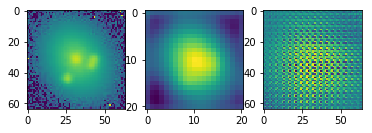

In [33]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        
        img = real_cpu+0.05*torch.rand_like(real_cpu)
        downsampled = F.upsample(img,scale_factor=1/3,mode='bilinear')
        kernel = kernel.to(device)
        img2 = F.conv2d(downsampled, kernel,padding=int(((kernel.shape[3])-1)/2))
        img2 = img2[:,:,:,:]
        
        plt.subplot(1,3,1)
        plt.imshow(real_cpu[1,0,:,:])      
        plt.subplot(1,3,2)
        plt.imshow(img2[1,0,:,:])
        img = netS(img2)
        im = img[1,0,:,:]
        plt.subplot(1,3,3)
        im = im.data.numpy()
        plt.imshow(im)
        stop
        


In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
#if netG != '':
#    netG.load_state_dict(torch.load(netG))
print(netG)

In [119]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#if netD != '':
#    netD.load_state_dict(torch.load(netD))
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [121]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with resampled, lower res, noise added images

        kernel = kernel.to(device)
        img = F.conv2d(real_cpu, kernel,padding=int(((kernel.shape[3])-1)/2))
        img = img+0.05*torch.rand_like(img)
        img = img[:,:,7:-7,7:-7]
        downsampled = F.upsample(img,scale_factor=1/3,mode='bilinear')
    
        
        downsampled_1d = downsampled.view([batch_size,nz,1,1])
        fake = netG(downsampled_1d)
        label.fill_(fake_label)
        fd = fake.detach()
        output = netD(fd.float())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)
    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/10][0/95] Loss_D: 1.4696 Loss_G: 20.0036 D(x): 0.5145 D(G(z)): 0.5358 / 0.0001
[0/10][1/95] Loss_D: 9.0122 Loss_G: 11.7399 D(x): 0.9994 D(G(z)): 0.9995 / 0.0000


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/shemmati/

KeyboardInterrupt: 

torch.Size([64, 1, 60, 60])
torch.Size([1, 1, 41, 41])
torch.Size([64, 1, 60, 60])


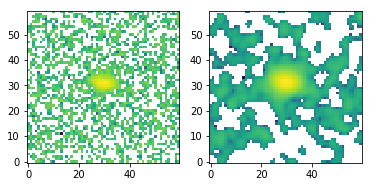

In [5]:
test_im = pyfits.getdata('gal_cutout.fits')
test_im = np.asarray(test_im,dtype=float)
data = np.repeat(test_im[:, :, np.newaxis], batchSize, axis=2)
data = np.repeat(data[:,:,:,np.newaxis],1,axis = 3)
data = torch.Tensor(data)
data = data.permute(2,3,0,1)

output = F.conv2d(data, kernel,padding=int(((kernel.shape[3])-1)/2))

print(data.shape)
print(kernel.shape)
print(output.shape)

convolved = output.data.numpy()
im = convolved[1,0,:,:]
plt.subplot(1,2,1)
plt.imshow(np.log10(test_im),origin='lower')
plt.subplot(1,2,2)
plt.imshow(np.log10(im),origin='lower')

In [23]:
noise = torch.randn(batchSize, nz, 1, 1, device=device)
print(noise.shape)
for i, data in enumerate(dataloader, 0):
    
    img =  data[0].to(device)    
    kernel = kernel.to(device)
    img = F.conv2d(img, kernel,padding=int(((kernel.shape[3])-1)/2))
    img = img+0.01*torch.rand_like(img)
    downsampled = F.upsample(img,scale_factor=0.25,mode='bilinear')
    d = downsampled.view([64,256,1,1])
    stop



torch.Size([64, 256, 1, 1])


NameError: name 'stop' is not defined